In [19]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.functional import F

from sklearn.metrics import f1_score
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import wandb

In [2]:
SEED = 1234

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class Formal_language_data():
    def __init__(self, min_length, max_length, data_size, character_type = ('a', 'b')):
        self.min_length = min_length
        self.max_length = max_length
        self.data_size = data_size
        self.character_type = character_type
    
    def sample_numbers(self):
        data_list = []
        if len(self.character_type) == 2:
            min_n = self.min_length // 2
            max_n = self.max_length // 2
            n_array = np.random.randint(min_n, max_n+1, self.data_size)
            for n in n_array:
                data = self.character_type[0]*n + self.character_type[1]*n
                data_list.append((data,1))

        elif len(self.character_type) == 3:
            min_n = self.min_length // 3
            max_n = self.max_length // 3
            n_array = np.random.randint(min_n, max_n+1, self.data_size)
            for n in n_array:
                data = self.character_type[0]*n + self.character_type[1]*n + self.character_type[2]*n
                data_list.append((data,1))
        return data_list
    
    def sample_non_numbers(self, min_length):
        data_list = []
        if len(self.character_type) == 2:
            n_array = np.random.randint(min_length, self.max_length, self.data_size) # sample a number between 1~seq_length-1
            m_array = self.max_length - n_array
            for i in range(len(n_array)):
                data = self.character_type[0]*n_array[i] + self.character_type[1]*m_array[i]
                data_list.append((data,0))

        elif len(self.character_type) == 3:
            target_sum = np.random.randint(min_length, self.max_length + 1, self.data_size) # sample a number between 4~seq_length
            n = np.random.randint(1, target_sum - 1)
            m = np.random.randint(1, target_sum - n)
            k = target_sum - n - m
            for i in range(len(n)):
                data = self.character_type[0]*n[i] + self.character_type[1]*m[i] + self.character_type[2]*k[i]
                data_list.append((data,0))
        return data_list

# Generate data

In [34]:
# Formal language one
ab_train_object = Formal_language_data(min_length = 1, max_length = 20, data_size = 10000, character_type = ('a', 'b'))
ab_train_data = ab_train_object.sample_numbers() + ab_train_object.sample_non_numbers(min_length = 1)

ab_valid_object = Formal_language_data(min_length = 21, max_length = 50, data_size = 1000, character_type = ('a', 'b'))
ab_valid_data = ab_valid_object.sample_numbers() + ab_valid_object.sample_non_numbers(min_length = 21)

ab_test_object = Formal_language_data(min_length = 21, max_length = 70, data_size = 1000, character_type = ('a', 'b'))
ab_test_data = ab_test_object.sample_numbers() 

# Formal language two
abc_train_object = Formal_language_data(min_length = 3, max_length = 20, data_size = 10000, character_type = ('a', 'b', 'c'))
abc_train_data = abc_train_object.sample_numbers() + abc_train_object.sample_non_numbers(min_length = 3)

abc_valid_object = Formal_language_data(min_length = 21, max_length = 50, data_size = 1000, character_type = ('a', 'b', 'c'))
abc_valid_data = abc_valid_object.sample_numbers() + abc_valid_object.sample_non_numbers(min_length = 21)

abc_test_object = Formal_language_data(min_length = 21, max_length = 70, data_size = 1000, character_type = ('a', 'b', 'c'))
abc_test_data = abc_test_object.sample_numbers() 

In [35]:
class Formal_language_dataset(Dataset):
    def __init__(self, data, max_length):
        self.data = data
        self.max_length = max_length

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sequence, label = self.data[idx]
        sequence_tensor = torch.tensor([ord(c) - ord('a') + 1 for c in sequence], dtype=torch.long)  # Convert sequence to tensor, where a = 1, b = 2, c=3.
        sequence_pad = torch.zeros(self.max_length, dtype=torch.long)
        sequence_pad[:len(sequence_tensor)] = sequence_tensor
        return sequence_pad, label        

In [36]:
# Formal language one dataset
ab_train_dataset = Formal_language_dataset(ab_train_data, max_length = 20)
ab_valid_dataset = Formal_language_dataset(ab_valid_data, max_length = 50)
ab_test_dataset = Formal_language_dataset(ab_test_data, max_length = 70)

# Formal language two dataset
abc_train_dataset = Formal_language_dataset(abc_train_data, max_length = 20)
abc_valid_dataset = Formal_language_dataset(abc_valid_data, max_length = 50)
abc_test_dataset = Formal_language_dataset(abc_test_data, max_length = 70)

print('Formal language one training dataset size: ', len(ab_train_dataset))
print('Formal language one validation dataset size: ', len(ab_valid_dataset))
print('Formal language one test dataset size: ', len(ab_test_dataset))

print('Formal language two training dataset size: ', len(abc_train_dataset))
print('Formal language two validation dataset size: ', len(abc_valid_dataset))
print('Formal language two test dataset size: ', len(abc_test_dataset))

Formal language one training dataset size:  20000
Formal language one validation dataset size:  2000
Formal language one test dataset size:  1000
Formal language two training dataset size:  20000
Formal language two validation dataset size:  2000
Formal language two test dataset size:  1000


In [8]:
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, input_size, hidden_size, num_layers, num_classes):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, input_size, padding_idx=0)
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.embedding(x) # (batch_size, seq_length, input_size)
        # Set initial hidden and cell states
        h0 = torch.randn(self.num_layers, x.size(0), self.hidden_size).to(x.device) # (num_layers, batch_size, hidden_size)
        # Forward propagate RNN
        out, _ = self.rnn(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [9]:
class SimpleLSTM(nn.Module):
    def __init__(self, vocab_size, input_size, hidden_size, num_layers, num_classes):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, input_size, padding_idx=0)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.embedding(x) # (batch_size, seq_length, input_size)
        h0 = torch.randn(self.num_layers, x.size(0), self.hidden_size).to(x.device) # (num_layers, batch_size, hidden_size)
        c0 = torch.randn(self.num_layers, x.size(0), self.hidden_size).to(x.device) # (num_layers, batch_size, hidden_size)
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [10]:
def loss_fn(outputs, labels):
    labels = F.one_hot(labels, num_classes=2)
    pos_weight = torch.tensor([1, 19])
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(outputs.device)
    loss = loss_fn(outputs, labels.float())
    return loss

In [11]:
def training_loop(model, train_loader, valid_loader, optimizer, epochs, device):
    # Training loop
    train_history = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for i, (data, labels) in enumerate(tqdm(train_loader)):
            # Forward pass
            data = data.to(device)
            labels = labels.to(device)
            outputs = model(data)
            loss = loss_fn(outputs, labels)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader.dataset)
        print('====> Epoch: {} Training loss: {:.10f}'.format(epoch, avg_train_loss))

        # validation
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for i, (data, labels) in enumerate(valid_loader):
                # Forward pass
                data = data.to(device)
                labels = labels.to(device)
                outputs = model(data)
                loss = loss_fn(outputs, labels)
                valid_loss += loss.item()

        avg_val_loss = valid_loss / len(valid_loader.dataset)
        wandb.log({"epoch": i+1, "train_loss": avg_train_loss, "valid_loss": avg_val_loss})
        print('====> Epoch: {} Validation loss: {:.10f}'.format(epoch, avg_val_loss))

# Hyper-parameters search in W & B platform

In [14]:
sweep_config = {
    "method": "random",
    "metric": {"name": "valid_loss", "goal": "minimize"},
    "parameters": {
        "epochs": {"values": [20, 50, 100]},
        "batch_size": {"values": [64, 128, 256]},
        "learning_rate": {"distribution": "uniform", "min": 0.00001, "max": 0.001},
        "optimizer": {"values": ["adam", "sgd"]},
        "hidden_size": {"values": [32, 64, 128]},
        "num_layers": {"values": [1, 2, 3]},
        "input_size": {"values": [3, 5, 10]}
    }
}

In [15]:
def sweep_model(config=None):
    with wandb.init(project=project_id, config=config):
        config = wandb.config

        train_loader = DataLoader(dataset=ab_train_dataset, batch_size=config.batch_size, shuffle=True)
        valid_loader = DataLoader(dataset=ab_valid_dataset, batch_size=config.batch_size, shuffle=True)
        # Initialize the model
        model = SimpleRNN(vocab_size = 3, input_size=config.input_size, hidden_size=config.hidden_size, num_layers=config.num_layers, num_classes=2).to(device)
        # Loss and optimizer

        if config.optimizer == 'adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
        elif config.optimizer == 'sgd':
            optimizer = torch.optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.9)
        
        wandb.watch(model, log="all")

        # Run the training loop
        training_loop(model, train_loader, valid_loader, optimizer, config.epochs, device)

project_id = 'formal_language_one_rnn'

sweep_id = wandb.sweep(sweep_config, project=project_id)

# run sweep
wandb.agent(sweep_id, function=sweep_model, count=20)

Create sweep with ID: segfi4e3
Sweep URL: https://wandb.ai/huanghaoran22/formal_language_one_rnn/sweeps/segfi4e3


wandb: Agent Starting Run: b75bc4vr with config:
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	hidden_size: 128
wandb: 	input_size: 10
wandb: 	learning_rate: 0.00048024849384887126
wandb: 	num_layers: 2
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 313/313 [00:02<00:00, 148.28it/s]


====> Epoch: 0 Training loss: 0.0077600444
====> Epoch: 0 Validation loss: 0.0688261869


100%|██████████| 313/313 [00:02<00:00, 155.24it/s]


====> Epoch: 1 Training loss: 0.0019483476
====> Epoch: 1 Validation loss: 0.0602917495


100%|██████████| 313/313 [00:02<00:00, 150.90it/s]


====> Epoch: 2 Training loss: 0.0016670880
====> Epoch: 2 Validation loss: 0.0771979537


100%|██████████| 313/313 [00:02<00:00, 148.31it/s]


====> Epoch: 3 Training loss: 0.0014837645
====> Epoch: 3 Validation loss: 0.0830535796


100%|██████████| 313/313 [00:02<00:00, 127.72it/s]


====> Epoch: 4 Training loss: 0.0014639968
====> Epoch: 4 Validation loss: 0.0437791769


100%|██████████| 313/313 [00:02<00:00, 110.36it/s]


====> Epoch: 5 Training loss: 0.0020568411
====> Epoch: 5 Validation loss: 0.0794124073


100%|██████████| 313/313 [00:02<00:00, 117.45it/s]


====> Epoch: 6 Training loss: 0.0013262028
====> Epoch: 6 Validation loss: 0.0620881057


100%|██████████| 313/313 [00:02<00:00, 139.93it/s]


====> Epoch: 7 Training loss: 0.0013267066
====> Epoch: 7 Validation loss: 0.0769705035


100%|██████████| 313/313 [00:02<00:00, 132.65it/s]


====> Epoch: 8 Training loss: 0.0013114345
====> Epoch: 8 Validation loss: 0.0806238906


100%|██████████| 313/313 [00:02<00:00, 130.04it/s]


====> Epoch: 9 Training loss: 0.0013086812
====> Epoch: 9 Validation loss: 0.0834104584


100%|██████████| 313/313 [00:02<00:00, 134.35it/s]


====> Epoch: 10 Training loss: 0.0012936144
====> Epoch: 10 Validation loss: 0.0803441091


100%|██████████| 313/313 [00:01<00:00, 158.50it/s]


====> Epoch: 11 Training loss: 0.0012890281
====> Epoch: 11 Validation loss: 0.0962847845


100%|██████████| 313/313 [00:01<00:00, 165.08it/s]


====> Epoch: 12 Training loss: 0.0012881716
====> Epoch: 12 Validation loss: 0.0900504688


100%|██████████| 313/313 [00:01<00:00, 160.22it/s]


====> Epoch: 13 Training loss: 0.0014153022
====> Epoch: 13 Validation loss: 0.0849854441


100%|██████████| 313/313 [00:02<00:00, 151.10it/s]


====> Epoch: 14 Training loss: 0.0012857781
====> Epoch: 14 Validation loss: 0.0874584900


100%|██████████| 313/313 [00:02<00:00, 115.41it/s]


====> Epoch: 15 Training loss: 0.0012821998
====> Epoch: 15 Validation loss: 0.0966413785


100%|██████████| 313/313 [00:02<00:00, 123.36it/s]


====> Epoch: 16 Training loss: 0.0012798820
====> Epoch: 16 Validation loss: 0.0861627515


100%|██████████| 313/313 [00:02<00:00, 133.70it/s]


====> Epoch: 17 Training loss: 0.0012814908
====> Epoch: 17 Validation loss: 0.0946834123


100%|██████████| 313/313 [00:02<00:00, 134.73it/s]


====> Epoch: 18 Training loss: 0.0012804384
====> Epoch: 18 Validation loss: 0.1053550316


100%|██████████| 313/313 [00:02<00:00, 136.19it/s]


====> Epoch: 19 Training loss: 0.0012758333
====> Epoch: 19 Validation loss: 0.0881784315


100%|██████████| 313/313 [00:02<00:00, 130.49it/s]


====> Epoch: 20 Training loss: 0.0016747794
====> Epoch: 20 Validation loss: 0.0138924527


100%|██████████| 313/313 [00:02<00:00, 137.93it/s]


====> Epoch: 21 Training loss: 0.0036645026
====> Epoch: 21 Validation loss: 0.0105967949


100%|██████████| 313/313 [00:02<00:00, 133.90it/s]


====> Epoch: 22 Training loss: 0.0013928291
====> Epoch: 22 Validation loss: 0.0139297596


100%|██████████| 313/313 [00:02<00:00, 135.35it/s]


====> Epoch: 23 Training loss: 0.0013284555
====> Epoch: 23 Validation loss: 0.0177052654


100%|██████████| 313/313 [00:02<00:00, 136.30it/s]


====> Epoch: 24 Training loss: 0.0013206217
====> Epoch: 24 Validation loss: 0.0142116931


100%|██████████| 313/313 [00:02<00:00, 134.96it/s]


====> Epoch: 25 Training loss: 0.0013044289
====> Epoch: 25 Validation loss: 0.0163916614


100%|██████████| 313/313 [00:02<00:00, 133.36it/s]


====> Epoch: 26 Training loss: 0.0012945239
====> Epoch: 26 Validation loss: 0.0141578381


100%|██████████| 313/313 [00:02<00:00, 136.78it/s]


====> Epoch: 27 Training loss: 0.0012892471
====> Epoch: 27 Validation loss: 0.0164036122


100%|██████████| 313/313 [00:02<00:00, 136.60it/s]


====> Epoch: 28 Training loss: 0.0012872419
====> Epoch: 28 Validation loss: 0.0227058838


100%|██████████| 313/313 [00:02<00:00, 134.58it/s]


====> Epoch: 29 Training loss: 0.0012860279
====> Epoch: 29 Validation loss: 0.0200321645


100%|██████████| 313/313 [00:02<00:00, 133.97it/s]


====> Epoch: 30 Training loss: 0.0012844181
====> Epoch: 30 Validation loss: 0.0045966323


100%|██████████| 313/313 [00:02<00:00, 134.84it/s]


====> Epoch: 31 Training loss: 0.0012816819
====> Epoch: 31 Validation loss: 0.0242740773


100%|██████████| 313/313 [00:02<00:00, 134.98it/s]


====> Epoch: 32 Training loss: 0.0012825531
====> Epoch: 32 Validation loss: 0.0244853613


100%|██████████| 313/313 [00:02<00:00, 137.04it/s]


====> Epoch: 33 Training loss: 0.0012746074
====> Epoch: 33 Validation loss: 0.0217358864


100%|██████████| 313/313 [00:02<00:00, 117.90it/s]


====> Epoch: 34 Training loss: 0.0012776286
====> Epoch: 34 Validation loss: 0.0288761303


100%|██████████| 313/313 [00:02<00:00, 111.51it/s]


====> Epoch: 35 Training loss: 0.0012698154
====> Epoch: 35 Validation loss: 0.0070639112


100%|██████████| 313/313 [00:02<00:00, 113.11it/s]


====> Epoch: 36 Training loss: 0.0012773616
====> Epoch: 36 Validation loss: 0.0242725541


100%|██████████| 313/313 [00:02<00:00, 115.03it/s]


====> Epoch: 37 Training loss: 0.0012731287
====> Epoch: 37 Validation loss: 0.0302205157


100%|██████████| 313/313 [00:02<00:00, 125.48it/s]


====> Epoch: 38 Training loss: 0.0012903203
====> Epoch: 38 Validation loss: 0.0360126119


100%|██████████| 313/313 [00:02<00:00, 112.89it/s]


====> Epoch: 39 Training loss: 0.0012736627
====> Epoch: 39 Validation loss: 0.0371702532


100%|██████████| 313/313 [00:02<00:00, 104.75it/s]


====> Epoch: 40 Training loss: 0.0012760720
====> Epoch: 40 Validation loss: 0.0356010128


100%|██████████| 313/313 [00:02<00:00, 105.39it/s]


====> Epoch: 41 Training loss: 0.0012696527
====> Epoch: 41 Validation loss: 0.0385990210


100%|██████████| 313/313 [00:02<00:00, 128.94it/s]


====> Epoch: 42 Training loss: 0.0012723858
====> Epoch: 42 Validation loss: 0.0343669902


100%|██████████| 313/313 [00:02<00:00, 118.80it/s]


====> Epoch: 43 Training loss: 0.0025543016
====> Epoch: 43 Validation loss: 0.0157567681


100%|██████████| 313/313 [00:02<00:00, 129.87it/s]


====> Epoch: 44 Training loss: 0.0013527052
====> Epoch: 44 Validation loss: 0.0251446527


100%|██████████| 313/313 [00:02<00:00, 149.76it/s]


====> Epoch: 45 Training loss: 0.0012996574
====> Epoch: 45 Validation loss: 0.0263303265


100%|██████████| 313/313 [00:02<00:00, 128.53it/s]


====> Epoch: 46 Training loss: 0.0012881794
====> Epoch: 46 Validation loss: 0.0275456773


100%|██████████| 313/313 [00:02<00:00, 130.90it/s]


====> Epoch: 47 Training loss: 0.0012873886
====> Epoch: 47 Validation loss: 0.0288219164


100%|██████████| 313/313 [00:02<00:00, 130.39it/s]


====> Epoch: 48 Training loss: 0.0012834816
====> Epoch: 48 Validation loss: 0.0301510479


100%|██████████| 313/313 [00:02<00:00, 131.48it/s]


====> Epoch: 49 Training loss: 0.0012851894
====> Epoch: 49 Validation loss: 0.0330207498


100%|██████████| 313/313 [00:02<00:00, 132.36it/s]


====> Epoch: 50 Training loss: 0.0012758229
====> Epoch: 50 Validation loss: 0.0323904739


100%|██████████| 313/313 [00:02<00:00, 131.88it/s]


====> Epoch: 51 Training loss: 0.0012810005
====> Epoch: 51 Validation loss: 0.0334696212


100%|██████████| 313/313 [00:02<00:00, 135.05it/s]


====> Epoch: 52 Training loss: 0.0012718257
====> Epoch: 52 Validation loss: 0.0368236110


100%|██████████| 313/313 [00:02<00:00, 131.17it/s]


====> Epoch: 53 Training loss: 0.0012818003
====> Epoch: 53 Validation loss: 0.0358909156


100%|██████████| 313/313 [00:02<00:00, 131.85it/s]


====> Epoch: 54 Training loss: 0.0012789814
====> Epoch: 54 Validation loss: 0.0368823504


100%|██████████| 313/313 [00:02<00:00, 132.85it/s]


====> Epoch: 55 Training loss: 0.0012761593
====> Epoch: 55 Validation loss: 0.0371116340


100%|██████████| 313/313 [00:02<00:00, 133.88it/s]


====> Epoch: 56 Training loss: 0.0012750084
====> Epoch: 56 Validation loss: 0.0414222851


100%|██████████| 313/313 [00:02<00:00, 133.30it/s]


====> Epoch: 57 Training loss: 0.0024861239
====> Epoch: 57 Validation loss: 0.0298635851


100%|██████████| 313/313 [00:02<00:00, 131.22it/s]


====> Epoch: 58 Training loss: 0.0013095996
====> Epoch: 58 Validation loss: 0.0382003105


100%|██████████| 313/313 [00:02<00:00, 127.01it/s]


====> Epoch: 59 Training loss: 0.0012823275
====> Epoch: 59 Validation loss: 0.0385685262


100%|██████████| 313/313 [00:02<00:00, 124.95it/s]


====> Epoch: 60 Training loss: 0.0012816659
====> Epoch: 60 Validation loss: 0.0416056904


100%|██████████| 313/313 [00:02<00:00, 132.35it/s]


====> Epoch: 61 Training loss: 0.0012808356
====> Epoch: 61 Validation loss: 0.0453218607


100%|██████████| 313/313 [00:02<00:00, 134.38it/s]


====> Epoch: 62 Training loss: 0.0012759313
====> Epoch: 62 Validation loss: 0.0447108096


100%|██████████| 313/313 [00:02<00:00, 132.57it/s]


====> Epoch: 63 Training loss: 0.0012767293
====> Epoch: 63 Validation loss: 0.0426121443


100%|██████████| 313/313 [00:02<00:00, 132.14it/s]


====> Epoch: 64 Training loss: 0.0012744883
====> Epoch: 64 Validation loss: 0.0457885429


100%|██████████| 313/313 [00:02<00:00, 133.12it/s]


====> Epoch: 65 Training loss: 0.0012749201
====> Epoch: 65 Validation loss: 0.0430530361


100%|██████████| 313/313 [00:02<00:00, 126.08it/s]


====> Epoch: 66 Training loss: 0.0012775884
====> Epoch: 66 Validation loss: 0.0461812323


100%|██████████| 313/313 [00:02<00:00, 129.56it/s]


====> Epoch: 67 Training loss: 0.0012723891
====> Epoch: 67 Validation loss: 0.0463634257


100%|██████████| 313/313 [00:02<00:00, 131.94it/s]


====> Epoch: 68 Training loss: 0.0012754721
====> Epoch: 68 Validation loss: 0.0458531597


100%|██████████| 313/313 [00:02<00:00, 131.50it/s]


====> Epoch: 69 Training loss: 0.0012728778
====> Epoch: 69 Validation loss: 0.0437165118


100%|██████████| 313/313 [00:02<00:00, 130.79it/s]


====> Epoch: 70 Training loss: 0.0012769948
====> Epoch: 70 Validation loss: 0.0457969471


100%|██████████| 313/313 [00:02<00:00, 133.08it/s]


====> Epoch: 71 Training loss: 0.0012733206
====> Epoch: 71 Validation loss: 0.0471227186


100%|██████████| 313/313 [00:02<00:00, 130.83it/s]


====> Epoch: 72 Training loss: 0.0012719801
====> Epoch: 72 Validation loss: 0.0462961202


100%|██████████| 313/313 [00:02<00:00, 131.47it/s]


====> Epoch: 73 Training loss: 0.0012732559
====> Epoch: 73 Validation loss: 0.0493951438


100%|██████████| 313/313 [00:02<00:00, 132.68it/s]


====> Epoch: 74 Training loss: 0.0012687726
====> Epoch: 74 Validation loss: 0.0471515467


100%|██████████| 313/313 [00:02<00:00, 131.83it/s]


====> Epoch: 75 Training loss: 0.0012784391
====> Epoch: 75 Validation loss: 0.0470964214


100%|██████████| 313/313 [00:02<00:00, 134.77it/s]


====> Epoch: 76 Training loss: 0.0012686587
====> Epoch: 76 Validation loss: 0.0491981245


100%|██████████| 313/313 [00:02<00:00, 128.68it/s]


====> Epoch: 77 Training loss: 0.0012744453
====> Epoch: 77 Validation loss: 0.0497372740


100%|██████████| 313/313 [00:02<00:00, 129.36it/s]


====> Epoch: 78 Training loss: 0.0012704695
====> Epoch: 78 Validation loss: 0.0534724628


100%|██████████| 313/313 [00:02<00:00, 125.93it/s]


====> Epoch: 79 Training loss: 0.0012746684
====> Epoch: 79 Validation loss: 0.0453478288


100%|██████████| 313/313 [00:02<00:00, 133.88it/s]


====> Epoch: 80 Training loss: 0.0012715662
====> Epoch: 80 Validation loss: 0.0502968593


100%|██████████| 313/313 [00:02<00:00, 133.46it/s]


====> Epoch: 81 Training loss: 0.0012715962
====> Epoch: 81 Validation loss: 0.0467058055


100%|██████████| 313/313 [00:02<00:00, 126.81it/s]


====> Epoch: 82 Training loss: 0.0012708998
====> Epoch: 82 Validation loss: 0.0497116792


100%|██████████| 313/313 [00:02<00:00, 128.52it/s]


====> Epoch: 83 Training loss: 0.0012700436
====> Epoch: 83 Validation loss: 0.0460507803


100%|██████████| 313/313 [00:02<00:00, 133.98it/s]


====> Epoch: 84 Training loss: 0.0012733467
====> Epoch: 84 Validation loss: 0.0453663633


100%|██████████| 313/313 [00:02<00:00, 134.10it/s]


====> Epoch: 85 Training loss: 0.0012646697
====> Epoch: 85 Validation loss: 0.0449412218


100%|██████████| 313/313 [00:02<00:00, 134.41it/s]


====> Epoch: 86 Training loss: 0.0012685342
====> Epoch: 86 Validation loss: 0.0518406115


100%|██████████| 313/313 [00:02<00:00, 127.45it/s]


====> Epoch: 87 Training loss: 0.0012717497
====> Epoch: 87 Validation loss: 0.0493052495


100%|██████████| 313/313 [00:02<00:00, 130.79it/s]


====> Epoch: 88 Training loss: 0.0012713401
====> Epoch: 88 Validation loss: 0.0498070770


100%|██████████| 313/313 [00:02<00:00, 128.06it/s]


====> Epoch: 89 Training loss: 0.0012740838
====> Epoch: 89 Validation loss: 0.0520660107


100%|██████████| 313/313 [00:02<00:00, 135.94it/s]


====> Epoch: 90 Training loss: 0.0012713575
====> Epoch: 90 Validation loss: 0.0531653924


100%|██████████| 313/313 [00:02<00:00, 132.11it/s]


====> Epoch: 91 Training loss: 0.0012730866
====> Epoch: 91 Validation loss: 0.0529205881


100%|██████████| 313/313 [00:02<00:00, 125.07it/s]


====> Epoch: 92 Training loss: 0.0012689473
====> Epoch: 92 Validation loss: 0.0501333489


100%|██████████| 313/313 [00:02<00:00, 128.78it/s]


====> Epoch: 93 Training loss: 0.0012712056
====> Epoch: 93 Validation loss: 0.0540076350


100%|██████████| 313/313 [00:02<00:00, 133.52it/s]


====> Epoch: 94 Training loss: 0.0012699769
====> Epoch: 94 Validation loss: 0.0552798157


100%|██████████| 313/313 [00:02<00:00, 129.34it/s]


====> Epoch: 95 Training loss: 0.0021109263
====> Epoch: 95 Validation loss: 0.0359205834


100%|██████████| 313/313 [00:02<00:00, 131.69it/s]


====> Epoch: 96 Training loss: 0.0013475730
====> Epoch: 96 Validation loss: 0.0353909646


100%|██████████| 313/313 [00:02<00:00, 130.86it/s]


====> Epoch: 97 Training loss: 0.0013002159
====> Epoch: 97 Validation loss: 0.0366780610


100%|██████████| 313/313 [00:02<00:00, 131.67it/s]


====> Epoch: 98 Training loss: 0.0012846404
====> Epoch: 98 Validation loss: 0.0383161670


100%|██████████| 313/313 [00:02<00:00, 126.74it/s]


====> Epoch: 99 Training loss: 0.0012772853
====> Epoch: 99 Validation loss: 0.0384932800


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▆▇▇▇▇▇██▂▂▂▂▁▂▁▃▃▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▄▄▅▄▅▅▃▄
epoch,32
train_loss,0.00128
valid_loss,0.03849


wandb: Agent Starting Run: fot4p52x with config:
wandb: 	batch_size: 256
wandb: 	epochs: 100
wandb: 	hidden_size: 64
wandb: 	input_size: 10
wandb: 	learning_rate: 0.0009171580322520966
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 79/79 [00:00<00:00, 93.51it/s]


====> Epoch: 0 Training loss: 0.0068863552
====> Epoch: 0 Validation loss: 0.0042062478


100%|██████████| 79/79 [00:00<00:00, 103.67it/s]


====> Epoch: 1 Training loss: 0.0034983541
====> Epoch: 1 Validation loss: 0.0025028951


100%|██████████| 79/79 [00:00<00:00, 101.31it/s]


====> Epoch: 2 Training loss: 0.0023512057
====> Epoch: 2 Validation loss: 0.0018105660


100%|██████████| 79/79 [00:00<00:00, 94.89it/s]


====> Epoch: 3 Training loss: 0.0018366790
====> Epoch: 3 Validation loss: 0.0017466405


100%|██████████| 79/79 [00:00<00:00, 99.09it/s] 


====> Epoch: 4 Training loss: 0.0011591631
====> Epoch: 4 Validation loss: 0.0031048647


100%|██████████| 79/79 [00:00<00:00, 99.76it/s] 


====> Epoch: 5 Training loss: 0.0007992886
====> Epoch: 5 Validation loss: 0.0062291729


100%|██████████| 79/79 [00:00<00:00, 90.99it/s]


====> Epoch: 6 Training loss: 0.0006796603
====> Epoch: 6 Validation loss: 0.0116358679


100%|██████████| 79/79 [00:00<00:00, 96.83it/s] 


====> Epoch: 7 Training loss: 0.0007298346
====> Epoch: 7 Validation loss: 0.0130865526


100%|██████████| 79/79 [00:00<00:00, 91.71it/s]


====> Epoch: 8 Training loss: 0.0006102375
====> Epoch: 8 Validation loss: 0.0157121488


100%|██████████| 79/79 [00:00<00:00, 99.18it/s] 


====> Epoch: 9 Training loss: 0.0005634897
====> Epoch: 9 Validation loss: 0.0177352096


100%|██████████| 79/79 [00:00<00:00, 97.61it/s]


====> Epoch: 10 Training loss: 0.0005618468
====> Epoch: 10 Validation loss: 0.0184683316


100%|██████████| 79/79 [00:00<00:00, 95.59it/s]


====> Epoch: 11 Training loss: 0.0005056343
====> Epoch: 11 Validation loss: 0.0201967113


100%|██████████| 79/79 [00:00<00:00, 94.32it/s]


====> Epoch: 12 Training loss: 0.0004822151
====> Epoch: 12 Validation loss: 0.0208750712


100%|██████████| 79/79 [00:00<00:00, 102.37it/s]


====> Epoch: 13 Training loss: 0.0004600852
====> Epoch: 13 Validation loss: 0.0225035405


100%|██████████| 79/79 [00:00<00:00, 102.49it/s]


====> Epoch: 14 Training loss: 0.0004403889
====> Epoch: 14 Validation loss: 0.0235334437


100%|██████████| 79/79 [00:00<00:00, 101.07it/s]


====> Epoch: 15 Training loss: 0.0004235623
====> Epoch: 15 Validation loss: 0.0227143592


100%|██████████| 79/79 [00:00<00:00, 101.20it/s]


====> Epoch: 16 Training loss: 0.0004245758
====> Epoch: 16 Validation loss: 0.0248153071


100%|██████████| 79/79 [00:00<00:00, 96.61it/s]


====> Epoch: 17 Training loss: 0.0004266882
====> Epoch: 17 Validation loss: 0.0241051700


100%|██████████| 79/79 [00:00<00:00, 95.07it/s]


====> Epoch: 18 Training loss: 0.0004061488
====> Epoch: 18 Validation loss: 0.0249679914


100%|██████████| 79/79 [00:00<00:00, 94.45it/s]


====> Epoch: 19 Training loss: 0.0003971898
====> Epoch: 19 Validation loss: 0.0254417477


100%|██████████| 79/79 [00:00<00:00, 94.98it/s]


====> Epoch: 20 Training loss: 0.0003874424
====> Epoch: 20 Validation loss: 0.0252592962


100%|██████████| 79/79 [00:00<00:00, 99.23it/s] 


====> Epoch: 21 Training loss: 0.0003960863
====> Epoch: 21 Validation loss: 0.0253330171


100%|██████████| 79/79 [00:00<00:00, 97.36it/s]


====> Epoch: 22 Training loss: 0.0003937315
====> Epoch: 22 Validation loss: 0.0250191555


100%|██████████| 79/79 [00:00<00:00, 92.87it/s]


====> Epoch: 23 Training loss: 0.0003830489
====> Epoch: 23 Validation loss: 0.0261375873


100%|██████████| 79/79 [00:00<00:00, 97.66it/s] 


====> Epoch: 24 Training loss: 0.0003805075
====> Epoch: 24 Validation loss: 0.0260096552


100%|██████████| 79/79 [00:00<00:00, 96.10it/s] 


====> Epoch: 25 Training loss: 0.0003826519
====> Epoch: 25 Validation loss: 0.0250688720


100%|██████████| 79/79 [00:00<00:00, 100.24it/s]


====> Epoch: 26 Training loss: 0.0003768126
====> Epoch: 26 Validation loss: 0.0260622978


100%|██████████| 79/79 [00:00<00:00, 99.65it/s] 


====> Epoch: 27 Training loss: 0.0003716262
====> Epoch: 27 Validation loss: 0.0255492519


100%|██████████| 79/79 [00:00<00:00, 102.67it/s]


====> Epoch: 28 Training loss: 0.0003811531
====> Epoch: 28 Validation loss: 0.0266933222


100%|██████████| 79/79 [00:00<00:00, 99.45it/s] 


====> Epoch: 29 Training loss: 0.0003708370
====> Epoch: 29 Validation loss: 0.0258165693


100%|██████████| 79/79 [00:00<00:00, 100.88it/s]


====> Epoch: 30 Training loss: 0.0003721320
====> Epoch: 30 Validation loss: 0.0262830842


100%|██████████| 79/79 [00:00<00:00, 94.39it/s]


====> Epoch: 31 Training loss: 0.0003591848
====> Epoch: 31 Validation loss: 0.0247687480


100%|██████████| 79/79 [00:00<00:00, 92.80it/s]


====> Epoch: 32 Training loss: 0.0003585873
====> Epoch: 32 Validation loss: 0.0250821807


100%|██████████| 79/79 [00:00<00:00, 96.77it/s] 


====> Epoch: 33 Training loss: 0.0003690862
====> Epoch: 33 Validation loss: 0.0251805575


100%|██████████| 79/79 [00:00<00:00, 93.24it/s]


====> Epoch: 34 Training loss: 0.0003577847
====> Epoch: 34 Validation loss: 0.0257279017


100%|██████████| 79/79 [00:00<00:00, 93.05it/s]


====> Epoch: 35 Training loss: 0.0003753314
====> Epoch: 35 Validation loss: 0.0255869894


100%|██████████| 79/79 [00:00<00:00, 95.15it/s]


====> Epoch: 36 Training loss: 0.0003610587
====> Epoch: 36 Validation loss: 0.0256490278


100%|██████████| 79/79 [00:00<00:00, 98.51it/s] 


====> Epoch: 37 Training loss: 0.0003611479
====> Epoch: 37 Validation loss: 0.0256536248


100%|██████████| 79/79 [00:00<00:00, 96.08it/s]


====> Epoch: 38 Training loss: 0.0003522435
====> Epoch: 38 Validation loss: 0.0245527034


100%|██████████| 79/79 [00:00<00:00, 97.07it/s]


====> Epoch: 39 Training loss: 0.0003525398
====> Epoch: 39 Validation loss: 0.0244216084


100%|██████████| 79/79 [00:00<00:00, 102.18it/s]


====> Epoch: 40 Training loss: 0.0003510882
====> Epoch: 40 Validation loss: 0.0242351673


100%|██████████| 79/79 [00:00<00:00, 89.45it/s]


====> Epoch: 41 Training loss: 0.0003517385
====> Epoch: 41 Validation loss: 0.0262296317


100%|██████████| 79/79 [00:00<00:00, 91.07it/s]


====> Epoch: 42 Training loss: 0.0003483307
====> Epoch: 42 Validation loss: 0.0256013854


100%|██████████| 79/79 [00:00<00:00, 97.13it/s] 


====> Epoch: 43 Training loss: 0.0003625110
====> Epoch: 43 Validation loss: 0.0252638121


100%|██████████| 79/79 [00:00<00:00, 95.95it/s]


====> Epoch: 44 Training loss: 0.0003582643
====> Epoch: 44 Validation loss: 0.0252701375


100%|██████████| 79/79 [00:00<00:00, 99.32it/s] 


====> Epoch: 45 Training loss: 0.0003446249
====> Epoch: 45 Validation loss: 0.0258064237


100%|██████████| 79/79 [00:00<00:00, 96.74it/s] 


====> Epoch: 46 Training loss: 0.0003456992
====> Epoch: 46 Validation loss: 0.0266475818


100%|██████████| 79/79 [00:00<00:00, 99.31it/s] 


====> Epoch: 47 Training loss: 0.0003502244
====> Epoch: 47 Validation loss: 0.0242318881


100%|██████████| 79/79 [00:00<00:00, 95.86it/s]


====> Epoch: 48 Training loss: 0.0003449897
====> Epoch: 48 Validation loss: 0.0256060040


100%|██████████| 79/79 [00:00<00:00, 99.10it/s] 


====> Epoch: 49 Training loss: 0.0003461886
====> Epoch: 49 Validation loss: 0.0259286091


100%|██████████| 79/79 [00:00<00:00, 95.67it/s]


====> Epoch: 50 Training loss: 0.0003568345
====> Epoch: 50 Validation loss: 0.0238963509


100%|██████████| 79/79 [00:00<00:00, 98.61it/s] 


====> Epoch: 51 Training loss: 0.0003437126
====> Epoch: 51 Validation loss: 0.0256459103


100%|██████████| 79/79 [00:00<00:00, 98.02it/s] 


====> Epoch: 52 Training loss: 0.0003417940
====> Epoch: 52 Validation loss: 0.0249529780


100%|██████████| 79/79 [00:00<00:00, 96.74it/s]


====> Epoch: 53 Training loss: 0.0003528856
====> Epoch: 53 Validation loss: 0.0245711617


100%|██████████| 79/79 [00:00<00:00, 99.46it/s] 


====> Epoch: 54 Training loss: 0.0003434802
====> Epoch: 54 Validation loss: 0.0246495416


100%|██████████| 79/79 [00:00<00:00, 92.78it/s]


====> Epoch: 55 Training loss: 0.0003452325
====> Epoch: 55 Validation loss: 0.0256513510


100%|██████████| 79/79 [00:00<00:00, 99.03it/s] 


====> Epoch: 56 Training loss: 0.0003422153
====> Epoch: 56 Validation loss: 0.0253000867


100%|██████████| 79/79 [00:00<00:00, 89.96it/s]


====> Epoch: 57 Training loss: 0.0003364913
====> Epoch: 57 Validation loss: 0.0255999160


100%|██████████| 79/79 [00:00<00:00, 94.55it/s]


====> Epoch: 58 Training loss: 0.0003435152
====> Epoch: 58 Validation loss: 0.0271238739


100%|██████████| 79/79 [00:00<00:00, 92.24it/s]


====> Epoch: 59 Training loss: 0.0003524327
====> Epoch: 59 Validation loss: 0.0265318797


100%|██████████| 79/79 [00:00<00:00, 94.46it/s]


====> Epoch: 60 Training loss: 0.0003438227
====> Epoch: 60 Validation loss: 0.0265191040


100%|██████████| 79/79 [00:00<00:00, 92.27it/s]


====> Epoch: 61 Training loss: 0.0003360243
====> Epoch: 61 Validation loss: 0.0251155145


100%|██████████| 79/79 [00:00<00:00, 98.86it/s] 


====> Epoch: 62 Training loss: 0.0003384249
====> Epoch: 62 Validation loss: 0.0272343626


100%|██████████| 79/79 [00:00<00:00, 93.87it/s]


====> Epoch: 63 Training loss: 0.0003353952
====> Epoch: 63 Validation loss: 0.0261610388


100%|██████████| 79/79 [00:00<00:00, 98.07it/s] 


====> Epoch: 64 Training loss: 0.0003360132
====> Epoch: 64 Validation loss: 0.0272797461


100%|██████████| 79/79 [00:00<00:00, 97.16it/s] 


====> Epoch: 65 Training loss: 0.0003413279
====> Epoch: 65 Validation loss: 0.0260034368


100%|██████████| 79/79 [00:00<00:00, 95.70it/s]


====> Epoch: 66 Training loss: 0.0003374195
====> Epoch: 66 Validation loss: 0.0258691065


100%|██████████| 79/79 [00:00<00:00, 103.14it/s]


====> Epoch: 67 Training loss: 0.0003371748
====> Epoch: 67 Validation loss: 0.0255038638


100%|██████████| 79/79 [00:00<00:00, 94.77it/s]


====> Epoch: 68 Training loss: 0.0003412418
====> Epoch: 68 Validation loss: 0.0274079752


100%|██████████| 79/79 [00:00<00:00, 95.26it/s]


====> Epoch: 69 Training loss: 0.0003308117
====> Epoch: 69 Validation loss: 0.0262604067


100%|██████████| 79/79 [00:00<00:00, 95.23it/s]


====> Epoch: 70 Training loss: 0.0003398671
====> Epoch: 70 Validation loss: 0.0266211975


100%|██████████| 79/79 [00:00<00:00, 97.45it/s] 


====> Epoch: 71 Training loss: 0.0003355582
====> Epoch: 71 Validation loss: 0.0257848296


100%|██████████| 79/79 [00:00<00:00, 93.24it/s]


====> Epoch: 72 Training loss: 0.0003369051
====> Epoch: 72 Validation loss: 0.0261175797


100%|██████████| 79/79 [00:00<00:00, 93.73it/s]


====> Epoch: 73 Training loss: 0.0003392789
====> Epoch: 73 Validation loss: 0.0260454409


100%|██████████| 79/79 [00:00<00:00, 95.95it/s]


====> Epoch: 74 Training loss: 0.0003342552
====> Epoch: 74 Validation loss: 0.0268874261


100%|██████████| 79/79 [00:00<00:00, 94.50it/s]


====> Epoch: 75 Training loss: 0.0003519883
====> Epoch: 75 Validation loss: 0.0266975162


100%|██████████| 79/79 [00:00<00:00, 93.91it/s]


====> Epoch: 76 Training loss: 0.0003391232
====> Epoch: 76 Validation loss: 0.0269463165


100%|██████████| 79/79 [00:00<00:00, 102.38it/s]


====> Epoch: 77 Training loss: 0.0003357186
====> Epoch: 77 Validation loss: 0.0281630168


100%|██████████| 79/79 [00:00<00:00, 94.79it/s]


====> Epoch: 78 Training loss: 0.0003292984
====> Epoch: 78 Validation loss: 0.0278921058


100%|██████████| 79/79 [00:00<00:00, 96.37it/s]


====> Epoch: 79 Training loss: 0.0003345833
====> Epoch: 79 Validation loss: 0.0263386035


100%|██████████| 79/79 [00:00<00:00, 81.51it/s]


====> Epoch: 80 Training loss: 0.0003344475
====> Epoch: 80 Validation loss: 0.0282393656


100%|██████████| 79/79 [00:00<00:00, 89.16it/s]


====> Epoch: 81 Training loss: 0.0003295134
====> Epoch: 81 Validation loss: 0.0269920940


100%|██████████| 79/79 [00:00<00:00, 91.07it/s]


====> Epoch: 82 Training loss: 0.0003353388
====> Epoch: 82 Validation loss: 0.0262884017


100%|██████████| 79/79 [00:00<00:00, 94.72it/s]


====> Epoch: 83 Training loss: 0.0003400295
====> Epoch: 83 Validation loss: 0.0259107199


100%|██████████| 79/79 [00:00<00:00, 93.15it/s]


====> Epoch: 84 Training loss: 0.0003340204
====> Epoch: 84 Validation loss: 0.0265156021


100%|██████████| 79/79 [00:00<00:00, 96.59it/s] 


====> Epoch: 85 Training loss: 0.0003288590
====> Epoch: 85 Validation loss: 0.0270388846


100%|██████████| 79/79 [00:00<00:00, 93.89it/s]


====> Epoch: 86 Training loss: 0.0003281183
====> Epoch: 86 Validation loss: 0.0276820650


100%|██████████| 79/79 [00:00<00:00, 92.61it/s]


====> Epoch: 87 Training loss: 0.0003311870
====> Epoch: 87 Validation loss: 0.0288057837


100%|██████████| 79/79 [00:00<00:00, 92.23it/s]


====> Epoch: 88 Training loss: 0.0003363046
====> Epoch: 88 Validation loss: 0.0271952553


100%|██████████| 79/79 [00:00<00:00, 93.65it/s]


====> Epoch: 89 Training loss: 0.0003402895
====> Epoch: 89 Validation loss: 0.0267860174


100%|██████████| 79/79 [00:00<00:00, 92.89it/s]


====> Epoch: 90 Training loss: 0.0003363229
====> Epoch: 90 Validation loss: 0.0275181837


100%|██████████| 79/79 [00:00<00:00, 96.23it/s] 


====> Epoch: 91 Training loss: 0.0003341137
====> Epoch: 91 Validation loss: 0.0275717840


100%|██████████| 79/79 [00:00<00:00, 92.96it/s]


====> Epoch: 92 Training loss: 0.0003380682
====> Epoch: 92 Validation loss: 0.0263160329


100%|██████████| 79/79 [00:00<00:00, 93.86it/s]


====> Epoch: 93 Training loss: 0.0003290906
====> Epoch: 93 Validation loss: 0.0271565802


100%|██████████| 79/79 [00:00<00:00, 97.85it/s] 


====> Epoch: 94 Training loss: 0.0003315905
====> Epoch: 94 Validation loss: 0.0272679186


100%|██████████| 79/79 [00:00<00:00, 100.64it/s]


====> Epoch: 95 Training loss: 0.0003322522
====> Epoch: 95 Validation loss: 0.0275378830


100%|██████████| 79/79 [00:00<00:00, 97.97it/s]


====> Epoch: 96 Training loss: 0.0003333670
====> Epoch: 96 Validation loss: 0.0286598117


100%|██████████| 79/79 [00:00<00:00, 94.78it/s]


====> Epoch: 97 Training loss: 0.0003314282
====> Epoch: 97 Validation loss: 0.0277818611


100%|██████████| 79/79 [00:00<00:00, 96.58it/s]


====> Epoch: 98 Training loss: 0.0003380470
====> Epoch: 98 Validation loss: 0.0275138412


100%|██████████| 79/79 [00:00<00:00, 96.88it/s] 


====> Epoch: 99 Training loss: 0.0003354926
====> Epoch: 99 Validation loss: 0.0274059207


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▂▁▂▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇█▇▇███▇██████
epoch,8
train_loss,0.00034
valid_loss,0.02741


wandb: Agent Starting Run: 91plgkbl with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	hidden_size: 32
wandb: 	input_size: 3
wandb: 	learning_rate: 0.0008469054971997352
wandb: 	num_layers: 3
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 157/157 [00:01<00:00, 125.65it/s]


====> Epoch: 0 Training loss: 0.0104342306
====> Epoch: 0 Validation loss: 0.0387394540


100%|██████████| 157/157 [00:01<00:00, 127.04it/s]


====> Epoch: 1 Training loss: 0.0028222718
====> Epoch: 1 Validation loss: 0.0111686552


100%|██████████| 157/157 [00:01<00:00, 114.26it/s]


====> Epoch: 2 Training loss: 0.0010942776
====> Epoch: 2 Validation loss: 0.0128973827


100%|██████████| 157/157 [00:01<00:00, 85.44it/s]


====> Epoch: 3 Training loss: 0.0008746367
====> Epoch: 3 Validation loss: 0.0134879285


100%|██████████| 157/157 [00:01<00:00, 89.90it/s]


====> Epoch: 4 Training loss: 0.0007709272
====> Epoch: 4 Validation loss: 0.0145109224


100%|██████████| 157/157 [00:01<00:00, 86.42it/s]


====> Epoch: 5 Training loss: 0.0007171591
====> Epoch: 5 Validation loss: 0.0148257564


100%|██████████| 157/157 [00:01<00:00, 87.33it/s]


====> Epoch: 6 Training loss: 0.0007140778
====> Epoch: 6 Validation loss: 0.0157388482


100%|██████████| 157/157 [00:01<00:00, 89.15it/s]


====> Epoch: 7 Training loss: 0.0009031119
====> Epoch: 7 Validation loss: 0.0160159357


100%|██████████| 157/157 [00:02<00:00, 74.28it/s]


====> Epoch: 8 Training loss: 0.0007118715
====> Epoch: 8 Validation loss: 0.0171558371


100%|██████████| 157/157 [00:03<00:00, 42.05it/s]


====> Epoch: 9 Training loss: 0.0006646271
====> Epoch: 9 Validation loss: 0.0175948818


100%|██████████| 157/157 [00:03<00:00, 40.43it/s]


====> Epoch: 10 Training loss: 0.0006590180
====> Epoch: 10 Validation loss: 0.0176562531


100%|██████████| 157/157 [00:01<00:00, 80.61it/s]


====> Epoch: 11 Training loss: 0.0006696319
====> Epoch: 11 Validation loss: 0.0180265186


100%|██████████| 157/157 [00:01<00:00, 106.74it/s]


====> Epoch: 12 Training loss: 0.0006597528
====> Epoch: 12 Validation loss: 0.0180096150


100%|██████████| 157/157 [00:01<00:00, 111.17it/s]


====> Epoch: 13 Training loss: 0.0006501921
====> Epoch: 13 Validation loss: 0.0181227656


100%|██████████| 157/157 [00:01<00:00, 86.94it/s]


====> Epoch: 14 Training loss: 0.0006569105
====> Epoch: 14 Validation loss: 0.0188806730


100%|██████████| 157/157 [00:01<00:00, 105.31it/s]


====> Epoch: 15 Training loss: 0.0006485440
====> Epoch: 15 Validation loss: 0.0192206686


100%|██████████| 157/157 [00:01<00:00, 103.38it/s]


====> Epoch: 16 Training loss: 0.0006476941
====> Epoch: 16 Validation loss: 0.0192659661


100%|██████████| 157/157 [00:01<00:00, 114.25it/s]


====> Epoch: 17 Training loss: 0.0006860955
====> Epoch: 17 Validation loss: 0.0191252742


100%|██████████| 157/157 [00:01<00:00, 120.62it/s]


====> Epoch: 18 Training loss: 0.0006438206
====> Epoch: 18 Validation loss: 0.0199803483


100%|██████████| 157/157 [00:01<00:00, 113.51it/s]


====> Epoch: 19 Training loss: 0.0006419221
====> Epoch: 19 Validation loss: 0.0192781440


100%|██████████| 157/157 [00:01<00:00, 114.88it/s]


====> Epoch: 20 Training loss: 0.0006436621
====> Epoch: 20 Validation loss: 0.0198020611


100%|██████████| 157/157 [00:01<00:00, 105.41it/s]


====> Epoch: 21 Training loss: 0.0006550395
====> Epoch: 21 Validation loss: 0.0194826901


100%|██████████| 157/157 [00:01<00:00, 103.12it/s]


====> Epoch: 22 Training loss: 0.0006428768
====> Epoch: 22 Validation loss: 0.0197684619


100%|██████████| 157/157 [00:01<00:00, 100.87it/s]


====> Epoch: 23 Training loss: 0.0006445890
====> Epoch: 23 Validation loss: 0.0199596412


100%|██████████| 157/157 [00:01<00:00, 106.18it/s]


====> Epoch: 24 Training loss: 0.0006426445
====> Epoch: 24 Validation loss: 0.0206153486


100%|██████████| 157/157 [00:01<00:00, 104.02it/s]


====> Epoch: 25 Training loss: 0.0006394517
====> Epoch: 25 Validation loss: 0.0202951078


100%|██████████| 157/157 [00:01<00:00, 104.66it/s]


====> Epoch: 26 Training loss: 0.0006414743
====> Epoch: 26 Validation loss: 0.0205403046


100%|██████████| 157/157 [00:01<00:00, 106.32it/s]


====> Epoch: 27 Training loss: 0.0006456752
====> Epoch: 27 Validation loss: 0.0211912547


100%|██████████| 157/157 [00:01<00:00, 105.51it/s]


====> Epoch: 28 Training loss: 0.0006367539
====> Epoch: 28 Validation loss: 0.0210090932


100%|██████████| 157/157 [00:01<00:00, 102.28it/s]


====> Epoch: 29 Training loss: 0.0006417561
====> Epoch: 29 Validation loss: 0.0213776158


100%|██████████| 157/157 [00:01<00:00, 102.30it/s]


====> Epoch: 30 Training loss: 0.0006396189
====> Epoch: 30 Validation loss: 0.0214879640


100%|██████████| 157/157 [00:01<00:00, 102.27it/s]


====> Epoch: 31 Training loss: 0.0006388623
====> Epoch: 31 Validation loss: 0.0213358934


100%|██████████| 157/157 [00:01<00:00, 103.10it/s]


====> Epoch: 32 Training loss: 0.0006411239
====> Epoch: 32 Validation loss: 0.0224779052


100%|██████████| 157/157 [00:01<00:00, 103.96it/s]


====> Epoch: 33 Training loss: 0.0006396189
====> Epoch: 33 Validation loss: 0.0222050291


100%|██████████| 157/157 [00:01<00:00, 104.84it/s]


====> Epoch: 34 Training loss: 0.0006382924
====> Epoch: 34 Validation loss: 0.0216000931


100%|██████████| 157/157 [00:01<00:00, 106.58it/s]


====> Epoch: 35 Training loss: 0.0006413333
====> Epoch: 35 Validation loss: 0.0226531674


100%|██████████| 157/157 [00:01<00:00, 108.29it/s]


====> Epoch: 36 Training loss: 0.0006397701
====> Epoch: 36 Validation loss: 0.0219491683


100%|██████████| 157/157 [00:01<00:00, 109.83it/s]


====> Epoch: 37 Training loss: 0.0006364048
====> Epoch: 37 Validation loss: 0.0217305565


100%|██████████| 157/157 [00:01<00:00, 104.59it/s]


====> Epoch: 38 Training loss: 0.0006396330
====> Epoch: 38 Validation loss: 0.0219658985


100%|██████████| 157/157 [00:01<00:00, 109.48it/s]


====> Epoch: 39 Training loss: 0.0006406071
====> Epoch: 39 Validation loss: 0.0221143729


100%|██████████| 157/157 [00:01<00:00, 106.95it/s]


====> Epoch: 40 Training loss: 0.0006397377
====> Epoch: 40 Validation loss: 0.0226782693


100%|██████████| 157/157 [00:01<00:00, 109.03it/s]


====> Epoch: 41 Training loss: 0.0006353023
====> Epoch: 41 Validation loss: 0.0224766226


100%|██████████| 157/157 [00:01<00:00, 108.11it/s]


====> Epoch: 42 Training loss: 0.0006395192
====> Epoch: 42 Validation loss: 0.0225159728


100%|██████████| 157/157 [00:01<00:00, 106.62it/s]


====> Epoch: 43 Training loss: 0.0006398144
====> Epoch: 43 Validation loss: 0.0228155109


100%|██████████| 157/157 [00:01<00:00, 102.07it/s]


====> Epoch: 44 Training loss: 0.0006422192
====> Epoch: 44 Validation loss: 0.0225080050


100%|██████████| 157/157 [00:01<00:00, 106.05it/s]


====> Epoch: 45 Training loss: 0.0006339687
====> Epoch: 45 Validation loss: 0.0234395922


100%|██████████| 157/157 [00:01<00:00, 106.82it/s]


====> Epoch: 46 Training loss: 0.0006351579
====> Epoch: 46 Validation loss: 0.0231707480


100%|██████████| 157/157 [00:01<00:00, 106.63it/s]


====> Epoch: 47 Training loss: 0.0006406076
====> Epoch: 47 Validation loss: 0.0230883784


100%|██████████| 157/157 [00:01<00:00, 107.31it/s]


====> Epoch: 48 Training loss: 0.0006371730
====> Epoch: 48 Validation loss: 0.0233583583


100%|██████████| 157/157 [00:01<00:00, 110.47it/s]


====> Epoch: 49 Training loss: 0.0015693357
====> Epoch: 49 Validation loss: 0.0154371699


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
valid_loss,█▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▂
epoch,16
train_loss,0.00157
valid_loss,0.01544


wandb: Agent Starting Run: ju9zvma1 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	hidden_size: 128
wandb: 	input_size: 3
wandb: 	learning_rate: 2.662625736908289e-05
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 157/157 [00:01<00:00, 151.56it/s]


====> Epoch: 0 Training loss: 0.0257508845
====> Epoch: 0 Validation loss: 0.0239070629


100%|██████████| 157/157 [00:00<00:00, 162.04it/s]


====> Epoch: 1 Training loss: 0.0209973235
====> Epoch: 1 Validation loss: 0.0191304488


100%|██████████| 157/157 [00:01<00:00, 154.61it/s]


====> Epoch: 2 Training loss: 0.0164306689
====> Epoch: 2 Validation loss: 0.0148183402


100%|██████████| 157/157 [00:01<00:00, 155.80it/s]


====> Epoch: 3 Training loss: 0.0129909512
====> Epoch: 3 Validation loss: 0.0122849372


100%|██████████| 157/157 [00:00<00:00, 157.21it/s]


====> Epoch: 4 Training loss: 0.0114556642
====> Epoch: 4 Validation loss: 0.0113949535


100%|██████████| 157/157 [00:01<00:00, 152.06it/s]


====> Epoch: 5 Training loss: 0.0109044725
====> Epoch: 5 Validation loss: 0.0110068087


100%|██████████| 157/157 [00:01<00:00, 150.89it/s]


====> Epoch: 6 Training loss: 0.0106152028
====> Epoch: 6 Validation loss: 0.0107581502


100%|██████████| 157/157 [00:00<00:00, 157.24it/s]


====> Epoch: 7 Training loss: 0.0103920421
====> Epoch: 7 Validation loss: 0.0105160941


100%|██████████| 157/157 [00:01<00:00, 151.43it/s]


====> Epoch: 8 Training loss: 0.0101801924
====> Epoch: 8 Validation loss: 0.0102758781


100%|██████████| 157/157 [00:01<00:00, 148.28it/s]


====> Epoch: 9 Training loss: 0.0099613037
====> Epoch: 9 Validation loss: 0.0100333646


100%|██████████| 157/157 [00:01<00:00, 149.51it/s]


====> Epoch: 10 Training loss: 0.0097338636
====> Epoch: 10 Validation loss: 0.0097666096


100%|██████████| 157/157 [00:01<00:00, 143.31it/s]


====> Epoch: 11 Training loss: 0.0094870169
====> Epoch: 11 Validation loss: 0.0094445382


100%|██████████| 157/157 [00:01<00:00, 152.59it/s]


====> Epoch: 12 Training loss: 0.0092170324
====> Epoch: 12 Validation loss: 0.0091232773


100%|██████████| 157/157 [00:01<00:00, 156.30it/s]


====> Epoch: 13 Training loss: 0.0089287385
====> Epoch: 13 Validation loss: 0.0087456169


100%|██████████| 157/157 [00:01<00:00, 151.14it/s]


====> Epoch: 14 Training loss: 0.0086274558
====> Epoch: 14 Validation loss: 0.0083828449


100%|██████████| 157/157 [00:01<00:00, 150.88it/s]


====> Epoch: 15 Training loss: 0.0083270457
====> Epoch: 15 Validation loss: 0.0080470054


100%|██████████| 157/157 [00:00<00:00, 157.12it/s]


====> Epoch: 16 Training loss: 0.0080481964
====> Epoch: 16 Validation loss: 0.0077561951


100%|██████████| 157/157 [00:01<00:00, 149.47it/s]


====> Epoch: 17 Training loss: 0.0077888391
====> Epoch: 17 Validation loss: 0.0075678873


100%|██████████| 157/157 [00:01<00:00, 156.00it/s]


====> Epoch: 18 Training loss: 0.0075344680
====> Epoch: 18 Validation loss: 0.0075641348


100%|██████████| 157/157 [00:01<00:00, 151.07it/s]


====> Epoch: 19 Training loss: 0.0073026566
====> Epoch: 19 Validation loss: 0.0077164955


100%|██████████| 157/157 [00:00<00:00, 162.79it/s]


====> Epoch: 20 Training loss: 0.0070743003
====> Epoch: 20 Validation loss: 0.0081019527


100%|██████████| 157/157 [00:00<00:00, 157.70it/s]


====> Epoch: 21 Training loss: 0.0068872493
====> Epoch: 21 Validation loss: 0.0092346306


100%|██████████| 157/157 [00:01<00:00, 156.89it/s]


====> Epoch: 22 Training loss: 0.0067359024
====> Epoch: 22 Validation loss: 0.0098892026


100%|██████████| 157/157 [00:01<00:00, 148.12it/s]


====> Epoch: 23 Training loss: 0.0066211089
====> Epoch: 23 Validation loss: 0.0105689910


100%|██████████| 157/157 [00:01<00:00, 156.01it/s]


====> Epoch: 24 Training loss: 0.0065208037
====> Epoch: 24 Validation loss: 0.0111659854


100%|██████████| 157/157 [00:01<00:00, 155.13it/s]


====> Epoch: 25 Training loss: 0.0064317301
====> Epoch: 25 Validation loss: 0.0119866689


100%|██████████| 157/157 [00:01<00:00, 153.69it/s]


====> Epoch: 26 Training loss: 0.0063516415
====> Epoch: 26 Validation loss: 0.0122307161


100%|██████████| 157/157 [00:00<00:00, 159.00it/s]


====> Epoch: 27 Training loss: 0.0062911041
====> Epoch: 27 Validation loss: 0.0131423765


100%|██████████| 157/157 [00:01<00:00, 153.68it/s]


====> Epoch: 28 Training loss: 0.0062308065
====> Epoch: 28 Validation loss: 0.0124454724


100%|██████████| 157/157 [00:01<00:00, 152.40it/s]


====> Epoch: 29 Training loss: 0.0061713078
====> Epoch: 29 Validation loss: 0.0123338307


100%|██████████| 157/157 [00:01<00:00, 154.86it/s]


====> Epoch: 30 Training loss: 0.0061061164
====> Epoch: 30 Validation loss: 0.0124171626


100%|██████████| 157/157 [00:01<00:00, 154.16it/s]


====> Epoch: 31 Training loss: 0.0060561635
====> Epoch: 31 Validation loss: 0.0130075448


100%|██████████| 157/157 [00:01<00:00, 153.45it/s]


====> Epoch: 32 Training loss: 0.0059814125
====> Epoch: 32 Validation loss: 0.0123931977


100%|██████████| 157/157 [00:01<00:00, 154.48it/s]


====> Epoch: 33 Training loss: 0.0059278650
====> Epoch: 33 Validation loss: 0.0124155222


100%|██████████| 157/157 [00:01<00:00, 148.91it/s]


====> Epoch: 34 Training loss: 0.0058933563
====> Epoch: 34 Validation loss: 0.0116731229


100%|██████████| 157/157 [00:01<00:00, 151.35it/s]


====> Epoch: 35 Training loss: 0.0058456285
====> Epoch: 35 Validation loss: 0.0115322937


100%|██████████| 157/157 [00:01<00:00, 147.50it/s]


====> Epoch: 36 Training loss: 0.0057732367
====> Epoch: 36 Validation loss: 0.0108384991


100%|██████████| 157/157 [00:01<00:00, 149.00it/s]


====> Epoch: 37 Training loss: 0.0057301885
====> Epoch: 37 Validation loss: 0.0111215846


100%|██████████| 157/157 [00:01<00:00, 149.71it/s]


====> Epoch: 38 Training loss: 0.0056887832
====> Epoch: 38 Validation loss: 0.0107934535


100%|██████████| 157/157 [00:01<00:00, 152.09it/s]


====> Epoch: 39 Training loss: 0.0056278284
====> Epoch: 39 Validation loss: 0.0096612259


100%|██████████| 157/157 [00:01<00:00, 150.44it/s]


====> Epoch: 40 Training loss: 0.0055945139
====> Epoch: 40 Validation loss: 0.0085750386


100%|██████████| 157/157 [00:01<00:00, 154.63it/s]


====> Epoch: 41 Training loss: 0.0055323420
====> Epoch: 41 Validation loss: 0.0080355484


100%|██████████| 157/157 [00:01<00:00, 152.27it/s]


====> Epoch: 42 Training loss: 0.0054710278
====> Epoch: 42 Validation loss: 0.0075865378


100%|██████████| 157/157 [00:01<00:00, 155.12it/s]


====> Epoch: 43 Training loss: 0.0054323262
====> Epoch: 43 Validation loss: 0.0079144303


100%|██████████| 157/157 [00:01<00:00, 149.24it/s]


====> Epoch: 44 Training loss: 0.0053610211
====> Epoch: 44 Validation loss: 0.0071230286


100%|██████████| 157/157 [00:01<00:00, 153.10it/s]


====> Epoch: 45 Training loss: 0.0053037574
====> Epoch: 45 Validation loss: 0.0068960293


100%|██████████| 157/157 [00:01<00:00, 154.37it/s]


====> Epoch: 46 Training loss: 0.0052557074
====> Epoch: 46 Validation loss: 0.0065398900


100%|██████████| 157/157 [00:01<00:00, 152.01it/s]


====> Epoch: 47 Training loss: 0.0052099534
====> Epoch: 47 Validation loss: 0.0059553127


100%|██████████| 157/157 [00:01<00:00, 150.56it/s]


====> Epoch: 48 Training loss: 0.0051616619
====> Epoch: 48 Validation loss: 0.0058481222


100%|██████████| 157/157 [00:00<00:00, 159.07it/s]


====> Epoch: 49 Training loss: 0.0050951863
====> Epoch: 49 Validation loss: 0.0057002946


100%|██████████| 157/157 [00:01<00:00, 148.84it/s]


====> Epoch: 50 Training loss: 0.0050497348
====> Epoch: 50 Validation loss: 0.0054203788


100%|██████████| 157/157 [00:01<00:00, 154.83it/s]


====> Epoch: 51 Training loss: 0.0049898846
====> Epoch: 51 Validation loss: 0.0053813394


100%|██████████| 157/157 [00:01<00:00, 148.85it/s]


====> Epoch: 52 Training loss: 0.0049440423
====> Epoch: 52 Validation loss: 0.0052411210


100%|██████████| 157/157 [00:01<00:00, 155.85it/s]


====> Epoch: 53 Training loss: 0.0048976326
====> Epoch: 53 Validation loss: 0.0051875936


100%|██████████| 157/157 [00:01<00:00, 154.44it/s]


====> Epoch: 54 Training loss: 0.0048235970
====> Epoch: 54 Validation loss: 0.0050784083


100%|██████████| 157/157 [00:00<00:00, 161.46it/s]


====> Epoch: 55 Training loss: 0.0048157018
====> Epoch: 55 Validation loss: 0.0050188171


100%|██████████| 157/157 [00:01<00:00, 151.97it/s]


====> Epoch: 56 Training loss: 0.0047096755
====> Epoch: 56 Validation loss: 0.0049615762


100%|██████████| 157/157 [00:01<00:00, 140.77it/s]


====> Epoch: 57 Training loss: 0.0046693650
====> Epoch: 57 Validation loss: 0.0049254391


100%|██████████| 157/157 [00:01<00:00, 150.21it/s]


====> Epoch: 58 Training loss: 0.0046331160
====> Epoch: 58 Validation loss: 0.0048386104


100%|██████████| 157/157 [00:01<00:00, 153.64it/s]


====> Epoch: 59 Training loss: 0.0045661760
====> Epoch: 59 Validation loss: 0.0047920035


100%|██████████| 157/157 [00:01<00:00, 150.51it/s]


====> Epoch: 60 Training loss: 0.0045314607
====> Epoch: 60 Validation loss: 0.0047472671


100%|██████████| 157/157 [00:01<00:00, 153.67it/s]


====> Epoch: 61 Training loss: 0.0044773582
====> Epoch: 61 Validation loss: 0.0047021335


100%|██████████| 157/157 [00:01<00:00, 151.04it/s]


====> Epoch: 62 Training loss: 0.0044519369
====> Epoch: 62 Validation loss: 0.0047569935


100%|██████████| 157/157 [00:01<00:00, 150.96it/s]


====> Epoch: 63 Training loss: 0.0043618885
====> Epoch: 63 Validation loss: 0.0046461058


100%|██████████| 157/157 [00:01<00:00, 155.95it/s]


====> Epoch: 64 Training loss: 0.0043480519
====> Epoch: 64 Validation loss: 0.0046133500


100%|██████████| 157/157 [00:01<00:00, 151.32it/s]


====> Epoch: 65 Training loss: 0.0042981662
====> Epoch: 65 Validation loss: 0.0046240938


100%|██████████| 157/157 [00:01<00:00, 152.26it/s]


====> Epoch: 66 Training loss: 0.0042350350
====> Epoch: 66 Validation loss: 0.0045779886


100%|██████████| 157/157 [00:01<00:00, 154.66it/s]


====> Epoch: 67 Training loss: 0.0041782625
====> Epoch: 67 Validation loss: 0.0045203739


100%|██████████| 157/157 [00:01<00:00, 155.46it/s]


====> Epoch: 68 Training loss: 0.0041279075
====> Epoch: 68 Validation loss: 0.0046084437


100%|██████████| 157/157 [00:01<00:00, 149.63it/s]


====> Epoch: 69 Training loss: 0.0040653998
====> Epoch: 69 Validation loss: 0.0045784276


100%|██████████| 157/157 [00:01<00:00, 151.07it/s]


====> Epoch: 70 Training loss: 0.0040176320
====> Epoch: 70 Validation loss: 0.0044849869


100%|██████████| 157/157 [00:01<00:00, 153.86it/s]


====> Epoch: 71 Training loss: 0.0039412887
====> Epoch: 71 Validation loss: 0.0044543442


100%|██████████| 157/157 [00:01<00:00, 150.58it/s]


====> Epoch: 72 Training loss: 0.0039097374
====> Epoch: 72 Validation loss: 0.0044500319


100%|██████████| 157/157 [00:01<00:00, 152.68it/s]


====> Epoch: 73 Training loss: 0.0038473670
====> Epoch: 73 Validation loss: 0.0044123656


100%|██████████| 157/157 [00:01<00:00, 155.09it/s]


====> Epoch: 74 Training loss: 0.0037766096
====> Epoch: 74 Validation loss: 0.0045336980


100%|██████████| 157/157 [00:01<00:00, 150.97it/s]


====> Epoch: 75 Training loss: 0.0036739479
====> Epoch: 75 Validation loss: 0.0044646244


100%|██████████| 157/157 [00:01<00:00, 151.50it/s]


====> Epoch: 76 Training loss: 0.0036277120
====> Epoch: 76 Validation loss: 0.0045856604


100%|██████████| 157/157 [00:01<00:00, 153.86it/s]


====> Epoch: 77 Training loss: 0.0035501860
====> Epoch: 77 Validation loss: 0.0051256520


100%|██████████| 157/157 [00:01<00:00, 154.53it/s]


====> Epoch: 78 Training loss: 0.0034534945
====> Epoch: 78 Validation loss: 0.0057031513


100%|██████████| 157/157 [00:01<00:00, 151.71it/s]


====> Epoch: 79 Training loss: 0.0033594074
====> Epoch: 79 Validation loss: 0.0053227359


100%|██████████| 157/157 [00:01<00:00, 145.89it/s]


====> Epoch: 80 Training loss: 0.0032912410
====> Epoch: 80 Validation loss: 0.0061871863


100%|██████████| 157/157 [00:01<00:00, 149.80it/s]


====> Epoch: 81 Training loss: 0.0032014272
====> Epoch: 81 Validation loss: 0.0063013211


100%|██████████| 157/157 [00:01<00:00, 149.89it/s]


====> Epoch: 82 Training loss: 0.0031008670
====> Epoch: 82 Validation loss: 0.0089064277


100%|██████████| 157/157 [00:01<00:00, 154.77it/s]


====> Epoch: 83 Training loss: 0.0030188934
====> Epoch: 83 Validation loss: 0.0086230502


100%|██████████| 157/157 [00:00<00:00, 160.03it/s]


====> Epoch: 84 Training loss: 0.0029463512
====> Epoch: 84 Validation loss: 0.0090843083


100%|██████████| 157/157 [00:01<00:00, 153.83it/s]


====> Epoch: 85 Training loss: 0.0028601637
====> Epoch: 85 Validation loss: 0.0097617843


100%|██████████| 157/157 [00:01<00:00, 151.82it/s]


====> Epoch: 86 Training loss: 0.0027958263
====> Epoch: 86 Validation loss: 0.0100477517


100%|██████████| 157/157 [00:01<00:00, 156.44it/s]


====> Epoch: 87 Training loss: 0.0027401145
====> Epoch: 87 Validation loss: 0.0100151333


100%|██████████| 157/157 [00:01<00:00, 156.81it/s]


====> Epoch: 88 Training loss: 0.0026818194
====> Epoch: 88 Validation loss: 0.0100571778


100%|██████████| 157/157 [00:01<00:00, 149.99it/s]


====> Epoch: 89 Training loss: 0.0026085824
====> Epoch: 89 Validation loss: 0.0109077247


100%|██████████| 157/157 [00:01<00:00, 148.91it/s]


====> Epoch: 90 Training loss: 0.0025778258
====> Epoch: 90 Validation loss: 0.0116836168


100%|██████████| 157/157 [00:01<00:00, 146.25it/s]


====> Epoch: 91 Training loss: 0.0025254194
====> Epoch: 91 Validation loss: 0.0116259326


100%|██████████| 157/157 [00:01<00:00, 147.39it/s]


====> Epoch: 92 Training loss: 0.0024717370
====> Epoch: 92 Validation loss: 0.0120947655


100%|██████████| 157/157 [00:01<00:00, 153.38it/s]


====> Epoch: 93 Training loss: 0.0024325070
====> Epoch: 93 Validation loss: 0.0116697971


100%|██████████| 157/157 [00:01<00:00, 154.56it/s]


====> Epoch: 94 Training loss: 0.0023922177
====> Epoch: 94 Validation loss: 0.0122633033


100%|██████████| 157/157 [00:00<00:00, 157.30it/s]


====> Epoch: 95 Training loss: 0.0023591148
====> Epoch: 95 Validation loss: 0.0128324089


100%|██████████| 157/157 [00:01<00:00, 154.30it/s]


====> Epoch: 96 Training loss: 0.0023086629
====> Epoch: 96 Validation loss: 0.0130653777


100%|██████████| 157/157 [00:01<00:00, 154.45it/s]


====> Epoch: 97 Training loss: 0.0022994096
====> Epoch: 97 Validation loss: 0.0130450732


100%|██████████| 157/157 [00:01<00:00, 146.25it/s]


====> Epoch: 98 Training loss: 0.0022464878
====> Epoch: 98 Validation loss: 0.0131847196


100%|██████████| 157/157 [00:01<00:00, 145.59it/s]

====> Epoch: 99 Training loss: 0.0022116460
====> Epoch: 99 Validation loss: 0.0139744667


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▅▃▃▃▃▂▂▂▃▄▄▄▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▃▄▄▄▄
epoch,16
train_loss,0.00221
valid_loss,0.01397


wandb: Agent Starting Run: 3k9nr8ms with config:
wandb: 	batch_size: 256
wandb: 	epochs: 100
wandb: 	hidden_size: 32
wandb: 	input_size: 10
wandb: 	learning_rate: 0.0002620199699319233
wandb: 	num_layers: 1
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 79/79 [00:00<00:00, 100.46it/s]


====> Epoch: 0 Training loss: 0.0123142559
====> Epoch: 0 Validation loss: 0.0091081263


100%|██████████| 79/79 [00:00<00:00, 96.45it/s] 


====> Epoch: 1 Training loss: 0.0065497759
====> Epoch: 1 Validation loss: 0.0047514797


100%|██████████| 79/79 [00:00<00:00, 91.88it/s]


====> Epoch: 2 Training loss: 0.0040455225
====> Epoch: 2 Validation loss: 0.0037833138


100%|██████████| 79/79 [00:00<00:00, 93.93it/s]


====> Epoch: 3 Training loss: 0.0032765299
====> Epoch: 3 Validation loss: 0.0029544395


100%|██████████| 79/79 [00:00<00:00, 96.96it/s]


====> Epoch: 4 Training loss: 0.0026880965
====> Epoch: 4 Validation loss: 0.0024173726


100%|██████████| 79/79 [00:00<00:00, 95.17it/s]


====> Epoch: 5 Training loss: 0.0023665519
====> Epoch: 5 Validation loss: 0.0021917866


100%|██████████| 79/79 [00:00<00:00, 91.84it/s]


====> Epoch: 6 Training loss: 0.0021499223
====> Epoch: 6 Validation loss: 0.0020392602


100%|██████████| 79/79 [00:00<00:00, 94.92it/s]


====> Epoch: 7 Training loss: 0.0019802058
====> Epoch: 7 Validation loss: 0.0019522050


100%|██████████| 79/79 [00:00<00:00, 95.29it/s] 


====> Epoch: 8 Training loss: 0.0018020449
====> Epoch: 8 Validation loss: 0.0018499261


100%|██████████| 79/79 [00:00<00:00, 108.34it/s]


====> Epoch: 9 Training loss: 0.0015508379
====> Epoch: 9 Validation loss: 0.0018112041


100%|██████████| 79/79 [00:00<00:00, 119.03it/s]


====> Epoch: 10 Training loss: 0.0013022989
====> Epoch: 10 Validation loss: 0.0018627142


100%|██████████| 79/79 [00:00<00:00, 124.34it/s]


====> Epoch: 11 Training loss: 0.0011302073
====> Epoch: 11 Validation loss: 0.0019786101


100%|██████████| 79/79 [00:00<00:00, 90.41it/s]


====> Epoch: 12 Training loss: 0.0010090450
====> Epoch: 12 Validation loss: 0.0021470122


100%|██████████| 79/79 [00:00<00:00, 95.85it/s] 


====> Epoch: 13 Training loss: 0.0009108696
====> Epoch: 13 Validation loss: 0.0023911864


100%|██████████| 79/79 [00:00<00:00, 100.60it/s]


====> Epoch: 14 Training loss: 0.0008310355
====> Epoch: 14 Validation loss: 0.0026220913


100%|██████████| 79/79 [00:00<00:00, 119.50it/s]


====> Epoch: 15 Training loss: 0.0007699917
====> Epoch: 15 Validation loss: 0.0028777355


100%|██████████| 79/79 [00:00<00:00, 126.00it/s]


====> Epoch: 16 Training loss: 0.0007309979
====> Epoch: 16 Validation loss: 0.0030656158


100%|██████████| 79/79 [00:00<00:00, 115.99it/s]


====> Epoch: 17 Training loss: 0.0006877998
====> Epoch: 17 Validation loss: 0.0032886202


100%|██████████| 79/79 [00:00<00:00, 117.32it/s]


====> Epoch: 18 Training loss: 0.0006597777
====> Epoch: 18 Validation loss: 0.0035186676


100%|██████████| 79/79 [00:00<00:00, 114.07it/s]


====> Epoch: 19 Training loss: 0.0006220819
====> Epoch: 19 Validation loss: 0.0037412671


100%|██████████| 79/79 [00:00<00:00, 112.35it/s]


====> Epoch: 20 Training loss: 0.0006055583
====> Epoch: 20 Validation loss: 0.0039465080


100%|██████████| 79/79 [00:00<00:00, 112.69it/s]


====> Epoch: 21 Training loss: 0.0005900937
====> Epoch: 21 Validation loss: 0.0041750785


100%|██████████| 79/79 [00:00<00:00, 109.75it/s]


====> Epoch: 22 Training loss: 0.0005677392
====> Epoch: 22 Validation loss: 0.0042973109


100%|██████████| 79/79 [00:00<00:00, 92.42it/s] 


====> Epoch: 23 Training loss: 0.0005466783
====> Epoch: 23 Validation loss: 0.0045477387


100%|██████████| 79/79 [00:00<00:00, 79.78it/s]


====> Epoch: 24 Training loss: 0.0005347313
====> Epoch: 24 Validation loss: 0.0047846376


100%|██████████| 79/79 [00:00<00:00, 85.18it/s]


====> Epoch: 25 Training loss: 0.0005171195
====> Epoch: 25 Validation loss: 0.0048332788


100%|██████████| 79/79 [00:00<00:00, 83.65it/s]


====> Epoch: 26 Training loss: 0.0005043647
====> Epoch: 26 Validation loss: 0.0050713170


100%|██████████| 79/79 [00:00<00:00, 84.73it/s]


====> Epoch: 27 Training loss: 0.0004997381
====> Epoch: 27 Validation loss: 0.0051257671


100%|██████████| 79/79 [00:00<00:00, 81.08it/s]


====> Epoch: 28 Training loss: 0.0004807060
====> Epoch: 28 Validation loss: 0.0053379094


100%|██████████| 79/79 [00:00<00:00, 84.69it/s]


====> Epoch: 29 Training loss: 0.0004752363
====> Epoch: 29 Validation loss: 0.0055002017


100%|██████████| 79/79 [00:00<00:00, 85.95it/s]


====> Epoch: 30 Training loss: 0.0004610666
====> Epoch: 30 Validation loss: 0.0056128904


100%|██████████| 79/79 [00:00<00:00, 87.13it/s]


====> Epoch: 31 Training loss: 0.0004510088
====> Epoch: 31 Validation loss: 0.0057984712


100%|██████████| 79/79 [00:00<00:00, 82.87it/s]


====> Epoch: 32 Training loss: 0.0004428777
====> Epoch: 32 Validation loss: 0.0060156623


100%|██████████| 79/79 [00:01<00:00, 76.15it/s]


====> Epoch: 33 Training loss: 0.0004436813
====> Epoch: 33 Validation loss: 0.0060404501


100%|██████████| 79/79 [00:01<00:00, 74.85it/s]


====> Epoch: 34 Training loss: 0.0004279959
====> Epoch: 34 Validation loss: 0.0062882091


100%|██████████| 79/79 [00:00<00:00, 110.52it/s]


====> Epoch: 35 Training loss: 0.0004153269
====> Epoch: 35 Validation loss: 0.0064685198


100%|██████████| 79/79 [00:00<00:00, 111.94it/s]


====> Epoch: 36 Training loss: 0.0004103288
====> Epoch: 36 Validation loss: 0.0066365428


100%|██████████| 79/79 [00:00<00:00, 100.89it/s]


====> Epoch: 37 Training loss: 0.0004079290
====> Epoch: 37 Validation loss: 0.0066069748


100%|██████████| 79/79 [00:00<00:00, 83.40it/s] 


====> Epoch: 38 Training loss: 0.0004020231
====> Epoch: 38 Validation loss: 0.0067292037


100%|██████████| 79/79 [00:01<00:00, 78.19it/s]


====> Epoch: 39 Training loss: 0.0003924969
====> Epoch: 39 Validation loss: 0.0070626416


100%|██████████| 79/79 [00:01<00:00, 73.53it/s]


====> Epoch: 40 Training loss: 0.0003954857
====> Epoch: 40 Validation loss: 0.0070659035


100%|██████████| 79/79 [00:00<00:00, 89.07it/s]


====> Epoch: 41 Training loss: 0.0003826814
====> Epoch: 41 Validation loss: 0.0071610947


100%|██████████| 79/79 [00:00<00:00, 97.54it/s] 


====> Epoch: 42 Training loss: 0.0003781407
====> Epoch: 42 Validation loss: 0.0071399596


100%|██████████| 79/79 [00:00<00:00, 94.18it/s] 


====> Epoch: 43 Training loss: 0.0003774703
====> Epoch: 43 Validation loss: 0.0074722965


100%|██████████| 79/79 [00:00<00:00, 85.36it/s] 


====> Epoch: 44 Training loss: 0.0003738395
====> Epoch: 44 Validation loss: 0.0073400003


100%|██████████| 79/79 [00:01<00:00, 61.19it/s]


====> Epoch: 45 Training loss: 0.0003688167
====> Epoch: 45 Validation loss: 0.0073861823


100%|██████████| 79/79 [00:00<00:00, 96.99it/s] 


====> Epoch: 46 Training loss: 0.0003635430
====> Epoch: 46 Validation loss: 0.0076723524


100%|██████████| 79/79 [00:00<00:00, 96.31it/s]


====> Epoch: 47 Training loss: 0.0003765054
====> Epoch: 47 Validation loss: 0.0078406668


100%|██████████| 79/79 [00:00<00:00, 105.34it/s]


====> Epoch: 48 Training loss: 0.0003615231
====> Epoch: 48 Validation loss: 0.0079633461


100%|██████████| 79/79 [00:00<00:00, 100.65it/s]


====> Epoch: 49 Training loss: 0.0003557918
====> Epoch: 49 Validation loss: 0.0079831411


100%|██████████| 79/79 [00:00<00:00, 90.95it/s]


====> Epoch: 50 Training loss: 0.0003566156
====> Epoch: 50 Validation loss: 0.0081509363


100%|██████████| 79/79 [00:00<00:00, 94.06it/s]


====> Epoch: 51 Training loss: 0.0003687528
====> Epoch: 51 Validation loss: 0.0080679114


100%|██████████| 79/79 [00:00<00:00, 84.29it/s] 


====> Epoch: 52 Training loss: 0.0003515976
====> Epoch: 52 Validation loss: 0.0084265185


100%|██████████| 79/79 [00:01<00:00, 73.88it/s]


====> Epoch: 53 Training loss: 0.0003512778
====> Epoch: 53 Validation loss: 0.0086915338


100%|██████████| 79/79 [00:00<00:00, 98.67it/s]


====> Epoch: 54 Training loss: 0.0003575716
====> Epoch: 54 Validation loss: 0.0085288808


100%|██████████| 79/79 [00:00<00:00, 93.77it/s]


====> Epoch: 55 Training loss: 0.0003492429
====> Epoch: 55 Validation loss: 0.0085905772


100%|██████████| 79/79 [00:00<00:00, 92.09it/s]


====> Epoch: 56 Training loss: 0.0003551099
====> Epoch: 56 Validation loss: 0.0083323069


100%|██████████| 79/79 [00:01<00:00, 77.44it/s]


====> Epoch: 57 Training loss: 0.0003464239
====> Epoch: 57 Validation loss: 0.0088069645


100%|██████████| 79/79 [00:01<00:00, 73.96it/s]


====> Epoch: 58 Training loss: 0.0003439759
====> Epoch: 58 Validation loss: 0.0088909481


100%|██████████| 79/79 [00:01<00:00, 76.27it/s]


====> Epoch: 59 Training loss: 0.0003450252
====> Epoch: 59 Validation loss: 0.0087169556


100%|██████████| 79/79 [00:01<00:00, 72.60it/s]


====> Epoch: 60 Training loss: 0.0003625017
====> Epoch: 60 Validation loss: 0.0090040335


100%|██████████| 79/79 [00:01<00:00, 73.96it/s]


====> Epoch: 61 Training loss: 0.0003406660
====> Epoch: 61 Validation loss: 0.0092099618


100%|██████████| 79/79 [00:01<00:00, 71.74it/s]


====> Epoch: 62 Training loss: 0.0003442943
====> Epoch: 62 Validation loss: 0.0089016539


100%|██████████| 79/79 [00:01<00:00, 73.92it/s]


====> Epoch: 63 Training loss: 0.0003438919
====> Epoch: 63 Validation loss: 0.0091097535


100%|██████████| 79/79 [00:00<00:00, 108.40it/s]


====> Epoch: 64 Training loss: 0.0003352162
====> Epoch: 64 Validation loss: 0.0088941578


100%|██████████| 79/79 [00:00<00:00, 105.62it/s]


====> Epoch: 65 Training loss: 0.0003395831
====> Epoch: 65 Validation loss: 0.0092554215


100%|██████████| 79/79 [00:00<00:00, 112.13it/s]


====> Epoch: 66 Training loss: 0.0003353984
====> Epoch: 66 Validation loss: 0.0095261897


100%|██████████| 79/79 [00:00<00:00, 100.82it/s]


====> Epoch: 67 Training loss: 0.0003561358
====> Epoch: 67 Validation loss: 0.0093741314


100%|██████████| 79/79 [00:00<00:00, 92.32it/s]


====> Epoch: 68 Training loss: 0.0003394216
====> Epoch: 68 Validation loss: 0.0094768480


100%|██████████| 79/79 [00:00<00:00, 91.17it/s]


====> Epoch: 69 Training loss: 0.0003389074
====> Epoch: 69 Validation loss: 0.0094649141


100%|██████████| 79/79 [00:00<00:00, 92.97it/s] 


====> Epoch: 70 Training loss: 0.0003339603
====> Epoch: 70 Validation loss: 0.0093700717


100%|██████████| 79/79 [00:00<00:00, 98.52it/s] 


====> Epoch: 71 Training loss: 0.0003401784
====> Epoch: 71 Validation loss: 0.0096595251


100%|██████████| 79/79 [00:00<00:00, 102.87it/s]


====> Epoch: 72 Training loss: 0.0003350607
====> Epoch: 72 Validation loss: 0.0097505777


100%|██████████| 79/79 [00:01<00:00, 77.65it/s]


====> Epoch: 73 Training loss: 0.0003371667
====> Epoch: 73 Validation loss: 0.0097452515


100%|██████████| 79/79 [00:01<00:00, 60.22it/s]


====> Epoch: 74 Training loss: 0.0003334241
====> Epoch: 74 Validation loss: 0.0097970386


100%|██████████| 79/79 [00:01<00:00, 59.24it/s]


====> Epoch: 75 Training loss: 0.0003320805
====> Epoch: 75 Validation loss: 0.0098149120


100%|██████████| 79/79 [00:01<00:00, 60.11it/s]


====> Epoch: 76 Training loss: 0.0003331959
====> Epoch: 76 Validation loss: 0.0099296517


100%|██████████| 79/79 [00:01<00:00, 61.03it/s]


====> Epoch: 77 Training loss: 0.0003273831
====> Epoch: 77 Validation loss: 0.0100293227


100%|██████████| 79/79 [00:01<00:00, 60.92it/s]


====> Epoch: 78 Training loss: 0.0003329942
====> Epoch: 78 Validation loss: 0.0100848517


100%|██████████| 79/79 [00:01<00:00, 60.11it/s]


====> Epoch: 79 Training loss: 0.0003279039
====> Epoch: 79 Validation loss: 0.0100083005


100%|██████████| 79/79 [00:01<00:00, 61.45it/s]


====> Epoch: 80 Training loss: 0.0003292363
====> Epoch: 80 Validation loss: 0.0097341466


100%|██████████| 79/79 [00:01<00:00, 61.06it/s]


====> Epoch: 81 Training loss: 0.0003320305
====> Epoch: 81 Validation loss: 0.0103109125


100%|██████████| 79/79 [00:01<00:00, 67.92it/s]


====> Epoch: 82 Training loss: 0.0003323004
====> Epoch: 82 Validation loss: 0.0097905429


100%|██████████| 79/79 [00:01<00:00, 55.14it/s]


====> Epoch: 83 Training loss: 0.0003392182
====> Epoch: 83 Validation loss: 0.0097303200


100%|██████████| 79/79 [00:01<00:00, 56.96it/s]


====> Epoch: 84 Training loss: 0.0003329577
====> Epoch: 84 Validation loss: 0.0103727921


100%|██████████| 79/79 [00:01<00:00, 59.33it/s]


====> Epoch: 85 Training loss: 0.0003295711
====> Epoch: 85 Validation loss: 0.0101893082


100%|██████████| 79/79 [00:01<00:00, 59.33it/s]


====> Epoch: 86 Training loss: 0.0003301552
====> Epoch: 86 Validation loss: 0.0103069119


100%|██████████| 79/79 [00:01<00:00, 61.44it/s]


====> Epoch: 87 Training loss: 0.0003287943
====> Epoch: 87 Validation loss: 0.0103480766


100%|██████████| 79/79 [00:01<00:00, 61.40it/s]


====> Epoch: 88 Training loss: 0.0003338146
====> Epoch: 88 Validation loss: 0.0105807111


100%|██████████| 79/79 [00:01<00:00, 64.03it/s]


====> Epoch: 89 Training loss: 0.0003299848
====> Epoch: 89 Validation loss: 0.0102904583


100%|██████████| 79/79 [00:01<00:00, 77.29it/s]


====> Epoch: 90 Training loss: 0.0003311131
====> Epoch: 90 Validation loss: 0.0104522641


100%|██████████| 79/79 [00:00<00:00, 94.48it/s]


====> Epoch: 91 Training loss: 0.0003240609
====> Epoch: 91 Validation loss: 0.0107267388


100%|██████████| 79/79 [00:01<00:00, 59.90it/s]


====> Epoch: 92 Training loss: 0.0003230813
====> Epoch: 92 Validation loss: 0.0107412412


100%|██████████| 79/79 [00:01<00:00, 60.71it/s]


====> Epoch: 93 Training loss: 0.0003340063
====> Epoch: 93 Validation loss: 0.0109822227


100%|██████████| 79/79 [00:01<00:00, 56.86it/s]


====> Epoch: 94 Training loss: 0.0003275206
====> Epoch: 94 Validation loss: 0.0108021666


100%|██████████| 79/79 [00:01<00:00, 61.01it/s]


====> Epoch: 95 Training loss: 0.0003294735
====> Epoch: 95 Validation loss: 0.0107370811


100%|██████████| 79/79 [00:01<00:00, 61.50it/s]


====> Epoch: 96 Training loss: 0.0003287684
====> Epoch: 96 Validation loss: 0.0108287166


100%|██████████| 79/79 [00:01<00:00, 63.26it/s]


====> Epoch: 97 Training loss: 0.0003256533
====> Epoch: 97 Validation loss: 0.0109535545


100%|██████████| 79/79 [00:01<00:00, 58.61it/s]


====> Epoch: 98 Training loss: 0.0003322842
====> Epoch: 98 Validation loss: 0.0111449637


100%|██████████| 79/79 [00:01<00:00, 56.75it/s]


====> Epoch: 99 Training loss: 0.0003270923
====> Epoch: 99 Validation loss: 0.0110371615


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▇▂▁▁▁▁▂▂▃▃▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████
epoch,8
train_loss,0.00033
valid_loss,0.01104


wandb: Agent Starting Run: s0nps8pg with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	hidden_size: 128
wandb: 	input_size: 3
wandb: 	learning_rate: 0.0004865147518420434
wandb: 	num_layers: 1
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 157/157 [00:02<00:00, 77.05it/s]


====> Epoch: 0 Training loss: 0.0088513266
====> Epoch: 0 Validation loss: 0.0168888864


100%|██████████| 157/157 [00:01<00:00, 81.93it/s]


====> Epoch: 1 Training loss: 0.0028747199
====> Epoch: 1 Validation loss: 0.0223172616


100%|██████████| 157/157 [00:01<00:00, 83.63it/s]


====> Epoch: 2 Training loss: 0.0013056699
====> Epoch: 2 Validation loss: 0.0136447987


100%|██████████| 157/157 [00:02<00:00, 77.73it/s]


====> Epoch: 3 Training loss: 0.0010669494
====> Epoch: 3 Validation loss: 0.0358317364


100%|██████████| 157/157 [00:01<00:00, 79.77it/s]


====> Epoch: 4 Training loss: 0.0009316728
====> Epoch: 4 Validation loss: 0.0275826245


100%|██████████| 157/157 [00:01<00:00, 80.59it/s]


====> Epoch: 5 Training loss: 0.0008800605
====> Epoch: 5 Validation loss: 0.0342512249


100%|██████████| 157/157 [00:01<00:00, 84.11it/s]


====> Epoch: 6 Training loss: 0.0008004690
====> Epoch: 6 Validation loss: 0.0457895375


100%|██████████| 157/157 [00:01<00:00, 86.43it/s]


====> Epoch: 7 Training loss: 0.0008321864
====> Epoch: 7 Validation loss: 0.0409124460


100%|██████████| 157/157 [00:01<00:00, 80.70it/s]


====> Epoch: 8 Training loss: 0.0007722195
====> Epoch: 8 Validation loss: 0.0510752765


100%|██████████| 157/157 [00:01<00:00, 82.90it/s]


====> Epoch: 9 Training loss: 0.0007310623
====> Epoch: 9 Validation loss: 0.0469479343


100%|██████████| 157/157 [00:01<00:00, 84.07it/s]


====> Epoch: 10 Training loss: 0.0007389472
====> Epoch: 10 Validation loss: 0.0499599442


100%|██████████| 157/157 [00:01<00:00, 82.02it/s]


====> Epoch: 11 Training loss: 0.0007017850
====> Epoch: 11 Validation loss: 0.0618893861


100%|██████████| 157/157 [00:01<00:00, 82.70it/s]


====> Epoch: 12 Training loss: 0.0007820362
====> Epoch: 12 Validation loss: 0.0582234075


100%|██████████| 157/157 [00:01<00:00, 103.21it/s]


====> Epoch: 13 Training loss: 0.0006895382
====> Epoch: 13 Validation loss: 0.0663696856


100%|██████████| 157/157 [00:01<00:00, 133.02it/s]


====> Epoch: 14 Training loss: 0.0007015924
====> Epoch: 14 Validation loss: 0.0542517121


100%|██████████| 157/157 [00:02<00:00, 73.39it/s]


====> Epoch: 15 Training loss: 0.0006900631
====> Epoch: 15 Validation loss: 0.0615099878


100%|██████████| 157/157 [00:02<00:00, 78.34it/s]


====> Epoch: 16 Training loss: 0.0007041831
====> Epoch: 16 Validation loss: 0.0564644059


100%|██████████| 157/157 [00:02<00:00, 75.39it/s]


====> Epoch: 17 Training loss: 0.0006800728
====> Epoch: 17 Validation loss: 0.0779942777


100%|██████████| 157/157 [00:01<00:00, 78.55it/s]


====> Epoch: 18 Training loss: 0.0006632170
====> Epoch: 18 Validation loss: 0.0741165025


100%|██████████| 157/157 [00:02<00:00, 77.97it/s]


====> Epoch: 19 Training loss: 0.0006723122
====> Epoch: 19 Validation loss: 0.0813517771


100%|██████████| 157/157 [00:02<00:00, 77.12it/s]


====> Epoch: 20 Training loss: 0.0006862495
====> Epoch: 20 Validation loss: 0.0754733810


100%|██████████| 157/157 [00:02<00:00, 76.66it/s]


====> Epoch: 21 Training loss: 0.0006791779
====> Epoch: 21 Validation loss: 0.0721526213


100%|██████████| 157/157 [00:01<00:00, 83.49it/s]


====> Epoch: 22 Training loss: 0.0006662106
====> Epoch: 22 Validation loss: 0.0675687454


100%|██████████| 157/157 [00:01<00:00, 79.30it/s]


====> Epoch: 23 Training loss: 0.0006853785
====> Epoch: 23 Validation loss: 0.0650371213


100%|██████████| 157/157 [00:01<00:00, 84.09it/s]


====> Epoch: 24 Training loss: 0.0006699012
====> Epoch: 24 Validation loss: 0.0778893590


100%|██████████| 157/157 [00:01<00:00, 79.83it/s]


====> Epoch: 25 Training loss: 0.0006654252
====> Epoch: 25 Validation loss: 0.0518291641


100%|██████████| 157/157 [00:02<00:00, 69.80it/s]


====> Epoch: 26 Training loss: 0.0006648049
====> Epoch: 26 Validation loss: 0.0778289633


100%|██████████| 157/157 [00:02<00:00, 65.37it/s]


====> Epoch: 27 Training loss: 0.0006578662
====> Epoch: 27 Validation loss: 0.0760750558


100%|██████████| 157/157 [00:02<00:00, 74.65it/s]


====> Epoch: 28 Training loss: 0.0006563311
====> Epoch: 28 Validation loss: 0.0885797858


100%|██████████| 157/157 [00:02<00:00, 77.75it/s]


====> Epoch: 29 Training loss: 0.0006629205
====> Epoch: 29 Validation loss: 0.0779404089


100%|██████████| 157/157 [00:02<00:00, 75.95it/s]


====> Epoch: 30 Training loss: 0.0006541642
====> Epoch: 30 Validation loss: 0.0859728386


100%|██████████| 157/157 [00:01<00:00, 104.64it/s]


====> Epoch: 31 Training loss: 0.0006548510
====> Epoch: 31 Validation loss: 0.0835724773


100%|██████████| 157/157 [00:01<00:00, 101.47it/s]


====> Epoch: 32 Training loss: 0.0006599233
====> Epoch: 32 Validation loss: 0.0909006753


100%|██████████| 157/157 [00:02<00:00, 73.70it/s]


====> Epoch: 33 Training loss: 0.0006420948
====> Epoch: 33 Validation loss: 0.0915358038


100%|██████████| 157/157 [00:02<00:00, 76.65it/s]


====> Epoch: 34 Training loss: 0.0006598206
====> Epoch: 34 Validation loss: 0.0797253103


100%|██████████| 157/157 [00:02<00:00, 75.81it/s]


====> Epoch: 35 Training loss: 0.0006552075
====> Epoch: 35 Validation loss: 0.0749670293


100%|██████████| 157/157 [00:02<00:00, 77.32it/s]


====> Epoch: 36 Training loss: 0.0006618566
====> Epoch: 36 Validation loss: 0.0867662523


100%|██████████| 157/157 [00:02<00:00, 77.86it/s]


====> Epoch: 37 Training loss: 0.0006544206
====> Epoch: 37 Validation loss: 0.0868069627


100%|██████████| 157/157 [00:02<00:00, 64.63it/s]


====> Epoch: 38 Training loss: 0.0006535533
====> Epoch: 38 Validation loss: 0.0604266787


100%|██████████| 157/157 [00:02<00:00, 78.46it/s]


====> Epoch: 39 Training loss: 0.0006472116
====> Epoch: 39 Validation loss: 0.0861765585


100%|██████████| 157/157 [00:02<00:00, 77.69it/s]


====> Epoch: 40 Training loss: 0.0006438138
====> Epoch: 40 Validation loss: 0.0808626039


100%|██████████| 157/157 [00:02<00:00, 77.09it/s]


====> Epoch: 41 Training loss: 0.0006448698
====> Epoch: 41 Validation loss: 0.0637742357


100%|██████████| 157/157 [00:02<00:00, 74.33it/s]


====> Epoch: 42 Training loss: 0.0006420093
====> Epoch: 42 Validation loss: 0.0669714499


100%|██████████| 157/157 [00:02<00:00, 77.55it/s]


====> Epoch: 43 Training loss: 0.0006457395
====> Epoch: 43 Validation loss: 0.0837538064


100%|██████████| 157/157 [00:01<00:00, 81.83it/s]


====> Epoch: 44 Training loss: 0.0006509030
====> Epoch: 44 Validation loss: 0.0903276124


100%|██████████| 157/157 [00:02<00:00, 73.56it/s]


====> Epoch: 45 Training loss: 0.0006502815
====> Epoch: 45 Validation loss: 0.0438116060


100%|██████████| 157/157 [00:02<00:00, 74.66it/s]


====> Epoch: 46 Training loss: 0.0009098358
====> Epoch: 46 Validation loss: 0.0180491180


100%|██████████| 157/157 [00:02<00:00, 73.51it/s]


====> Epoch: 47 Training loss: 0.0006539534
====> Epoch: 47 Validation loss: 0.0242711589


100%|██████████| 157/157 [00:02<00:00, 73.53it/s]


====> Epoch: 48 Training loss: 0.0006619125
====> Epoch: 48 Validation loss: 0.0158448413


100%|██████████| 157/157 [00:02<00:00, 74.13it/s]


====> Epoch: 49 Training loss: 0.0006537155
====> Epoch: 49 Validation loss: 0.0205938134


100%|██████████| 157/157 [00:02<00:00, 77.95it/s]


====> Epoch: 50 Training loss: 0.0006504330
====> Epoch: 50 Validation loss: 0.0211972117


100%|██████████| 157/157 [00:02<00:00, 77.76it/s]


====> Epoch: 51 Training loss: 0.0006465931
====> Epoch: 51 Validation loss: 0.0248497002


100%|██████████| 157/157 [00:02<00:00, 77.95it/s]


====> Epoch: 52 Training loss: 0.0006439883
====> Epoch: 52 Validation loss: 0.0290274780


100%|██████████| 157/157 [00:02<00:00, 74.05it/s]


====> Epoch: 53 Training loss: 0.0006410806
====> Epoch: 53 Validation loss: 0.0306004651


100%|██████████| 157/157 [00:01<00:00, 81.14it/s]


====> Epoch: 54 Training loss: 0.0006444730
====> Epoch: 54 Validation loss: 0.0323131518


100%|██████████| 157/157 [00:02<00:00, 74.69it/s]


====> Epoch: 55 Training loss: 0.0006403579
====> Epoch: 55 Validation loss: 0.0371092664


100%|██████████| 157/157 [00:02<00:00, 76.67it/s]


====> Epoch: 56 Training loss: 0.0006469074
====> Epoch: 56 Validation loss: 0.0354216436


100%|██████████| 157/157 [00:02<00:00, 77.19it/s]


====> Epoch: 57 Training loss: 0.0006417844
====> Epoch: 57 Validation loss: 0.0351996716


100%|██████████| 157/157 [00:02<00:00, 78.06it/s]


====> Epoch: 58 Training loss: 0.0006397829
====> Epoch: 58 Validation loss: 0.0378428231


100%|██████████| 157/157 [00:01<00:00, 79.24it/s]


====> Epoch: 59 Training loss: 0.0006415680
====> Epoch: 59 Validation loss: 0.0388247074


100%|██████████| 157/157 [00:02<00:00, 76.55it/s]


====> Epoch: 60 Training loss: 0.0006389515
====> Epoch: 60 Validation loss: 0.0438010931


100%|██████████| 157/157 [00:02<00:00, 76.53it/s]


====> Epoch: 61 Training loss: 0.0006424475
====> Epoch: 61 Validation loss: 0.0400720773


100%|██████████| 157/157 [00:02<00:00, 78.04it/s]


====> Epoch: 62 Training loss: 0.0006414193
====> Epoch: 62 Validation loss: 0.0424577920


100%|██████████| 157/157 [00:01<00:00, 79.03it/s]


====> Epoch: 63 Training loss: 0.0006560096
====> Epoch: 63 Validation loss: 0.0435941367


100%|██████████| 157/157 [00:02<00:00, 59.28it/s]


====> Epoch: 64 Training loss: 0.0014052066
====> Epoch: 64 Validation loss: 0.0153807997


100%|██████████| 157/157 [00:02<00:00, 68.39it/s]


====> Epoch: 65 Training loss: 0.0006611385
====> Epoch: 65 Validation loss: 0.0257631130


100%|██████████| 157/157 [00:02<00:00, 77.24it/s]


====> Epoch: 66 Training loss: 0.0006474384
====> Epoch: 66 Validation loss: 0.0279738600


100%|██████████| 157/157 [00:01<00:00, 88.03it/s] 


====> Epoch: 67 Training loss: 0.0006508765
====> Epoch: 67 Validation loss: 0.0315883733


100%|██████████| 157/157 [00:01<00:00, 139.54it/s]


====> Epoch: 68 Training loss: 0.0006421318
====> Epoch: 68 Validation loss: 0.0348551468


100%|██████████| 157/157 [00:01<00:00, 132.54it/s]


====> Epoch: 69 Training loss: 0.0006435164
====> Epoch: 69 Validation loss: 0.0403243320


100%|██████████| 157/157 [00:01<00:00, 123.35it/s]


====> Epoch: 70 Training loss: 0.0006416390
====> Epoch: 70 Validation loss: 0.0430391694


100%|██████████| 157/157 [00:01<00:00, 122.05it/s]


====> Epoch: 71 Training loss: 0.0006423461
====> Epoch: 71 Validation loss: 0.0435250781


100%|██████████| 157/157 [00:01<00:00, 112.42it/s]


====> Epoch: 72 Training loss: 0.0006455555
====> Epoch: 72 Validation loss: 0.0471071680


100%|██████████| 157/157 [00:01<00:00, 119.51it/s]


====> Epoch: 73 Training loss: 0.0006441015
====> Epoch: 73 Validation loss: 0.0468639656


100%|██████████| 157/157 [00:01<00:00, 130.88it/s]


====> Epoch: 74 Training loss: 0.0006444085
====> Epoch: 74 Validation loss: 0.0504045763


100%|██████████| 157/157 [00:01<00:00, 114.18it/s]


====> Epoch: 75 Training loss: 0.0006432168
====> Epoch: 75 Validation loss: 0.0535190396


100%|██████████| 157/157 [00:01<00:00, 122.80it/s]


====> Epoch: 76 Training loss: 0.0006494579
====> Epoch: 76 Validation loss: 0.0553164480


100%|██████████| 157/157 [00:01<00:00, 100.71it/s]


====> Epoch: 77 Training loss: 0.0006399372
====> Epoch: 77 Validation loss: 0.0582642353


100%|██████████| 157/157 [00:02<00:00, 75.22it/s]


====> Epoch: 78 Training loss: 0.0006366037
====> Epoch: 78 Validation loss: 0.0596875529


100%|██████████| 157/157 [00:02<00:00, 74.93it/s]


====> Epoch: 79 Training loss: 0.0006439514
====> Epoch: 79 Validation loss: 0.0568327140


100%|██████████| 157/157 [00:02<00:00, 77.81it/s]


====> Epoch: 80 Training loss: 0.0006431116
====> Epoch: 80 Validation loss: 0.0585934316


100%|██████████| 157/157 [00:01<00:00, 79.30it/s]


====> Epoch: 81 Training loss: 0.0006403053
====> Epoch: 81 Validation loss: 0.0576679448


100%|██████████| 157/157 [00:02<00:00, 77.87it/s]


====> Epoch: 82 Training loss: 0.0006408225
====> Epoch: 82 Validation loss: 0.0578513184


100%|██████████| 157/157 [00:01<00:00, 79.85it/s]


====> Epoch: 83 Training loss: 0.0006432711
====> Epoch: 83 Validation loss: 0.0589239502


100%|██████████| 157/157 [00:02<00:00, 78.07it/s]


====> Epoch: 84 Training loss: 0.0006398061
====> Epoch: 84 Validation loss: 0.0650557842


100%|██████████| 157/157 [00:01<00:00, 81.20it/s]


====> Epoch: 85 Training loss: 0.0006414587
====> Epoch: 85 Validation loss: 0.0616866937


100%|██████████| 157/157 [00:01<00:00, 80.55it/s]


====> Epoch: 86 Training loss: 0.0006439679
====> Epoch: 86 Validation loss: 0.0605406040


100%|██████████| 157/157 [00:02<00:00, 74.71it/s]


====> Epoch: 87 Training loss: 0.0006460753
====> Epoch: 87 Validation loss: 0.0600278389


100%|██████████| 157/157 [00:02<00:00, 66.33it/s]


====> Epoch: 88 Training loss: 0.0006402083
====> Epoch: 88 Validation loss: 0.0641085134


100%|██████████| 157/157 [00:02<00:00, 78.35it/s]


====> Epoch: 89 Training loss: 0.0006402531
====> Epoch: 89 Validation loss: 0.0679062726


100%|██████████| 157/157 [00:02<00:00, 77.07it/s]


====> Epoch: 90 Training loss: 0.0006373899
====> Epoch: 90 Validation loss: 0.0666275858


100%|██████████| 157/157 [00:02<00:00, 76.10it/s]


====> Epoch: 91 Training loss: 0.0006408774
====> Epoch: 91 Validation loss: 0.0664100275


100%|██████████| 157/157 [00:02<00:00, 77.15it/s]


====> Epoch: 92 Training loss: 0.0006424568
====> Epoch: 92 Validation loss: 0.0676538701


100%|██████████| 157/157 [00:01<00:00, 82.58it/s]


====> Epoch: 93 Training loss: 0.0006394565
====> Epoch: 93 Validation loss: 0.0675340841


100%|██████████| 157/157 [00:02<00:00, 66.38it/s]


====> Epoch: 94 Training loss: 0.0006476574
====> Epoch: 94 Validation loss: 0.0666250856


100%|██████████| 157/157 [00:02<00:00, 77.56it/s]


====> Epoch: 95 Training loss: 0.0006397961
====> Epoch: 95 Validation loss: 0.0622231230


100%|██████████| 157/157 [00:01<00:00, 85.66it/s]


====> Epoch: 96 Training loss: 0.0006460029
====> Epoch: 96 Validation loss: 0.0668419728


100%|██████████| 157/157 [00:01<00:00, 80.27it/s]


====> Epoch: 97 Training loss: 0.0007183538
====> Epoch: 97 Validation loss: 0.0555798216


100%|██████████| 157/157 [00:02<00:00, 75.18it/s]


====> Epoch: 98 Training loss: 0.0006478097
====> Epoch: 98 Validation loss: 0.0583108269


100%|██████████| 157/157 [00:02<00:00, 74.95it/s]


====> Epoch: 99 Training loss: 0.0006463050
====> Epoch: 99 Validation loss: 0.0572085043


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▁▁▃▃▄▅▅▇▇▆▄▇██▇▅▇▇▄▁▂▃▃▃▄▄▂▃▄▄▅▅▅▅▅▆▆▆▆▅
epoch,16
train_loss,0.00065
valid_loss,0.05721


wandb: Agent Starting Run: gs1ee749 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	hidden_size: 64
wandb: 	input_size: 3
wandb: 	learning_rate: 0.0005759085773425743
wandb: 	num_layers: 2
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 157/157 [00:01<00:00, 81.04it/s]


====> Epoch: 0 Training loss: 0.0124815046
====> Epoch: 0 Validation loss: 0.0096684789


100%|██████████| 157/157 [00:01<00:00, 86.30it/s]


====> Epoch: 1 Training loss: 0.0074414131
====> Epoch: 1 Validation loss: 0.0049321508


100%|██████████| 157/157 [00:03<00:00, 49.22it/s]


====> Epoch: 2 Training loss: 0.0044591650
====> Epoch: 2 Validation loss: 0.0040800464


100%|██████████| 157/157 [00:01<00:00, 83.28it/s]


====> Epoch: 3 Training loss: 0.0021594655
====> Epoch: 3 Validation loss: 0.0101209202


100%|██████████| 157/157 [00:01<00:00, 83.28it/s]


====> Epoch: 4 Training loss: 0.0015670251
====> Epoch: 4 Validation loss: 0.0237371454


100%|██████████| 157/157 [00:01<00:00, 83.40it/s]


====> Epoch: 5 Training loss: 0.0013756424
====> Epoch: 5 Validation loss: 0.0305323789


100%|██████████| 157/157 [00:01<00:00, 84.34it/s]


====> Epoch: 6 Training loss: 0.0011992771
====> Epoch: 6 Validation loss: 0.0404290850


100%|██████████| 157/157 [00:01<00:00, 86.22it/s]


====> Epoch: 7 Training loss: 0.0011351962
====> Epoch: 7 Validation loss: 0.0438952992


100%|██████████| 157/157 [00:01<00:00, 82.54it/s]


====> Epoch: 8 Training loss: 0.0011855519
====> Epoch: 8 Validation loss: 0.0346591656


100%|██████████| 157/157 [00:01<00:00, 79.74it/s]


====> Epoch: 9 Training loss: 0.0010150134
====> Epoch: 9 Validation loss: 0.0475147736


100%|██████████| 157/157 [00:01<00:00, 83.68it/s]


====> Epoch: 10 Training loss: 0.0009788291
====> Epoch: 10 Validation loss: 0.0500870053


100%|██████████| 157/157 [00:01<00:00, 84.78it/s]


====> Epoch: 11 Training loss: 0.0009908810
====> Epoch: 11 Validation loss: 0.0537341512


100%|██████████| 157/157 [00:01<00:00, 82.69it/s]


====> Epoch: 12 Training loss: 0.0009069253
====> Epoch: 12 Validation loss: 0.0528572631


100%|██████████| 157/157 [00:01<00:00, 86.56it/s]


====> Epoch: 13 Training loss: 0.0009206973
====> Epoch: 13 Validation loss: 0.0545392420


100%|██████████| 157/157 [00:01<00:00, 87.06it/s]


====> Epoch: 14 Training loss: 0.0008962612
====> Epoch: 14 Validation loss: 0.0549217137


100%|██████████| 157/157 [00:01<00:00, 90.93it/s]


====> Epoch: 15 Training loss: 0.0008479673
====> Epoch: 15 Validation loss: 0.0575687611


100%|██████████| 157/157 [00:01<00:00, 86.06it/s]


====> Epoch: 16 Training loss: 0.0008377285
====> Epoch: 16 Validation loss: 0.0571929079


100%|██████████| 157/157 [00:01<00:00, 87.03it/s]


====> Epoch: 17 Training loss: 0.0008279230
====> Epoch: 17 Validation loss: 0.0581396992


100%|██████████| 157/157 [00:01<00:00, 89.52it/s]


====> Epoch: 18 Training loss: 0.0008112901
====> Epoch: 18 Validation loss: 0.0557410409


100%|██████████| 157/157 [00:01<00:00, 90.58it/s]


====> Epoch: 19 Training loss: 0.0007935530
====> Epoch: 19 Validation loss: 0.0576260104


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▂▁▁▂▄▄▆▆▅▇▇▇▇███████
epoch,16
train_loss,0.00079
valid_loss,0.05763


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9x7mzmbz with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	hidden_size: 32
wandb: 	input_size: 3
wandb: 	learning_rate: 0.0009640856335599626
wandb: 	num_layers: 1
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 313/313 [00:03<00:00, 98.65it/s] 


====> Epoch: 0 Training loss: 0.0153195375
====> Epoch: 0 Validation loss: 0.0072020396


100%|██████████| 313/313 [00:03<00:00, 96.64it/s]


====> Epoch: 1 Training loss: 0.0038561029
====> Epoch: 1 Validation loss: 0.0156389593


100%|██████████| 313/313 [00:03<00:00, 97.34it/s] 


====> Epoch: 2 Training loss: 0.0024819688
====> Epoch: 2 Validation loss: 0.0232696977


100%|██████████| 313/313 [00:03<00:00, 97.23it/s] 


====> Epoch: 3 Training loss: 0.0021924123
====> Epoch: 3 Validation loss: 0.0289606303


100%|██████████| 313/313 [00:03<00:00, 97.27it/s] 


====> Epoch: 4 Training loss: 0.0018581509
====> Epoch: 4 Validation loss: 0.0353809680


100%|██████████| 313/313 [00:03<00:00, 97.81it/s] 


====> Epoch: 5 Training loss: 0.0016192066
====> Epoch: 5 Validation loss: 0.0413376626


100%|██████████| 313/313 [00:01<00:00, 164.76it/s]


====> Epoch: 6 Training loss: 0.0015144011
====> Epoch: 6 Validation loss: 0.0442014216


100%|██████████| 313/313 [00:01<00:00, 181.19it/s]


====> Epoch: 7 Training loss: 0.0014475927
====> Epoch: 7 Validation loss: 0.0485301051


100%|██████████| 313/313 [00:01<00:00, 173.13it/s]


====> Epoch: 8 Training loss: 0.0020187680
====> Epoch: 8 Validation loss: 0.0386515418


100%|██████████| 313/313 [00:01<00:00, 167.41it/s]


====> Epoch: 9 Training loss: 0.0013729440
====> Epoch: 9 Validation loss: 0.0450659329


100%|██████████| 313/313 [00:02<00:00, 109.83it/s]


====> Epoch: 10 Training loss: 0.0013593946
====> Epoch: 10 Validation loss: 0.0458991408


100%|██████████| 313/313 [00:03<00:00, 91.00it/s] 


====> Epoch: 11 Training loss: 0.0013944541
====> Epoch: 11 Validation loss: 0.0472482840


100%|██████████| 313/313 [00:03<00:00, 95.38it/s] 


====> Epoch: 12 Training loss: 0.0013508985
====> Epoch: 12 Validation loss: 0.0449908542


100%|██████████| 313/313 [00:03<00:00, 97.82it/s] 


====> Epoch: 13 Training loss: 0.0013863185
====> Epoch: 13 Validation loss: 0.0430276805


100%|██████████| 313/313 [00:03<00:00, 98.27it/s] 


====> Epoch: 14 Training loss: 0.0016356570
====> Epoch: 14 Validation loss: 0.0401342623


100%|██████████| 313/313 [00:03<00:00, 94.35it/s] 


====> Epoch: 15 Training loss: 0.0013179644
====> Epoch: 15 Validation loss: 0.0439746066


100%|██████████| 313/313 [00:03<00:00, 98.15it/s] 


====> Epoch: 16 Training loss: 0.0013073776
====> Epoch: 16 Validation loss: 0.0474398411


100%|██████████| 313/313 [00:02<00:00, 109.30it/s]


====> Epoch: 17 Training loss: 0.0013011480
====> Epoch: 17 Validation loss: 0.0448500110


100%|██████████| 313/313 [00:01<00:00, 171.07it/s]


====> Epoch: 18 Training loss: 0.0018102296
====> Epoch: 18 Validation loss: 0.0428460163


100%|██████████| 313/313 [00:01<00:00, 166.34it/s]


====> Epoch: 19 Training loss: 0.0012983151
====> Epoch: 19 Validation loss: 0.0432246266


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▁▂▄▅▆▇▇█▆▇██▇▇▇▇█▇▇▇
epoch,32
train_loss,0.0013
valid_loss,0.04322


wandb: Agent Starting Run: aevsvvye with config:
wandb: 	batch_size: 256
wandb: 	epochs: 100
wandb: 	hidden_size: 128
wandb: 	input_size: 5
wandb: 	learning_rate: 0.00048775124613566873
wandb: 	num_layers: 2
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 79/79 [00:01<00:00, 59.46it/s]


====> Epoch: 0 Training loss: 0.0077129359
====> Epoch: 0 Validation loss: 0.0048649943


100%|██████████| 79/79 [00:01<00:00, 59.35it/s]


====> Epoch: 1 Training loss: 0.0041687798
====> Epoch: 1 Validation loss: 0.0031536423


100%|██████████| 79/79 [00:01<00:00, 59.96it/s]


====> Epoch: 2 Training loss: 0.0029268276
====> Epoch: 2 Validation loss: 0.0024826028


100%|██████████| 79/79 [00:01<00:00, 60.18it/s]


====> Epoch: 3 Training loss: 0.0023493946
====> Epoch: 3 Validation loss: 0.0020896420


100%|██████████| 79/79 [00:01<00:00, 54.48it/s]


====> Epoch: 4 Training loss: 0.0016753808
====> Epoch: 4 Validation loss: 0.0023631144


100%|██████████| 79/79 [00:01<00:00, 57.17it/s]


====> Epoch: 5 Training loss: 0.0010632556
====> Epoch: 5 Validation loss: 0.0044648981


100%|██████████| 79/79 [00:01<00:00, 57.97it/s]


====> Epoch: 6 Training loss: 0.0008782305
====> Epoch: 6 Validation loss: 0.0049990630


100%|██████████| 79/79 [00:01<00:00, 58.75it/s]


====> Epoch: 7 Training loss: 0.0007875991
====> Epoch: 7 Validation loss: 0.0091876065


100%|██████████| 79/79 [00:01<00:00, 55.16it/s]


====> Epoch: 8 Training loss: 0.0007300172
====> Epoch: 8 Validation loss: 0.0127593274


100%|██████████| 79/79 [00:01<00:00, 60.74it/s]


====> Epoch: 9 Training loss: 0.0006767877
====> Epoch: 9 Validation loss: 0.0154031507


100%|██████████| 79/79 [00:01<00:00, 60.01it/s]


====> Epoch: 10 Training loss: 0.0006641879
====> Epoch: 10 Validation loss: 0.0194015741


100%|██████████| 79/79 [00:01<00:00, 55.58it/s]


====> Epoch: 11 Training loss: 0.0006160214
====> Epoch: 11 Validation loss: 0.0216112998


100%|██████████| 79/79 [00:01<00:00, 58.10it/s]


====> Epoch: 12 Training loss: 0.0005850209
====> Epoch: 12 Validation loss: 0.0243338990


100%|██████████| 79/79 [00:01<00:00, 58.08it/s]


====> Epoch: 13 Training loss: 0.0005596237
====> Epoch: 13 Validation loss: 0.0259948041


100%|██████████| 79/79 [00:02<00:00, 38.43it/s]


====> Epoch: 14 Training loss: 0.0005400626
====> Epoch: 14 Validation loss: 0.0274941704


100%|██████████| 79/79 [00:01<00:00, 58.00it/s]


====> Epoch: 15 Training loss: 0.0005680269
====> Epoch: 15 Validation loss: 0.0283934221


100%|██████████| 79/79 [00:01<00:00, 52.47it/s]


====> Epoch: 16 Training loss: 0.0005078872
====> Epoch: 16 Validation loss: 0.0293354983


100%|██████████| 79/79 [00:01<00:00, 59.55it/s]


====> Epoch: 17 Training loss: 0.0005495705
====> Epoch: 17 Validation loss: 0.0299199741


100%|██████████| 79/79 [00:01<00:00, 59.34it/s]


====> Epoch: 18 Training loss: 0.0004776148
====> Epoch: 18 Validation loss: 0.0300464950


100%|██████████| 79/79 [00:01<00:00, 59.93it/s]


====> Epoch: 19 Training loss: 0.0004724461
====> Epoch: 19 Validation loss: 0.0309060552


100%|██████████| 79/79 [00:01<00:00, 59.02it/s]


====> Epoch: 20 Training loss: 0.0004591772
====> Epoch: 20 Validation loss: 0.0312410336


100%|██████████| 79/79 [00:01<00:00, 60.12it/s]


====> Epoch: 21 Training loss: 0.0004431340
====> Epoch: 21 Validation loss: 0.0320520759


100%|██████████| 79/79 [00:01<00:00, 60.12it/s]


====> Epoch: 22 Training loss: 0.0004435350
====> Epoch: 22 Validation loss: 0.0321478643


100%|██████████| 79/79 [00:01<00:00, 67.86it/s]


====> Epoch: 23 Training loss: 0.0004230953
====> Epoch: 23 Validation loss: 0.0323877897


100%|██████████| 79/79 [00:00<00:00, 84.16it/s]


====> Epoch: 24 Training loss: 0.0004253434
====> Epoch: 24 Validation loss: 0.0329010434


100%|██████████| 79/79 [00:00<00:00, 81.43it/s]


====> Epoch: 25 Training loss: 0.0004294875
====> Epoch: 25 Validation loss: 0.0335567927


100%|██████████| 79/79 [00:00<00:00, 85.58it/s]


====> Epoch: 26 Training loss: 0.0004207317
====> Epoch: 26 Validation loss: 0.0335539401


100%|██████████| 79/79 [00:00<00:00, 83.05it/s]


====> Epoch: 27 Training loss: 0.0004072555
====> Epoch: 27 Validation loss: 0.0334564369


100%|██████████| 79/79 [00:00<00:00, 82.15it/s]


====> Epoch: 28 Training loss: 0.0004017254
====> Epoch: 28 Validation loss: 0.0339058852


100%|██████████| 79/79 [00:00<00:00, 86.26it/s] 


====> Epoch: 29 Training loss: 0.0003946919
====> Epoch: 29 Validation loss: 0.0333400493


100%|██████████| 79/79 [00:01<00:00, 58.48it/s]


====> Epoch: 30 Training loss: 0.0003823921
====> Epoch: 30 Validation loss: 0.0331866429


100%|██████████| 79/79 [00:01<00:00, 58.45it/s]


====> Epoch: 31 Training loss: 0.0003853488
====> Epoch: 31 Validation loss: 0.0332787406


100%|██████████| 79/79 [00:01<00:00, 59.24it/s]


====> Epoch: 32 Training loss: 0.0003925943
====> Epoch: 32 Validation loss: 0.0340947742


100%|██████████| 79/79 [00:01<00:00, 64.17it/s]


====> Epoch: 33 Training loss: 0.0003809780
====> Epoch: 33 Validation loss: 0.0323584681


100%|██████████| 79/79 [00:01<00:00, 53.82it/s]


====> Epoch: 34 Training loss: 0.0003801907
====> Epoch: 34 Validation loss: 0.0326587784


100%|██████████| 79/79 [00:01<00:00, 57.83it/s]


====> Epoch: 35 Training loss: 0.0003838555
====> Epoch: 35 Validation loss: 0.0331469367


100%|██████████| 79/79 [00:01<00:00, 60.29it/s]


====> Epoch: 36 Training loss: 0.0003867259
====> Epoch: 36 Validation loss: 0.0332312777


100%|██████████| 79/79 [00:01<00:00, 58.74it/s]


====> Epoch: 37 Training loss: 0.0003792743
====> Epoch: 37 Validation loss: 0.0328987761


100%|██████████| 79/79 [00:01<00:00, 58.49it/s]


====> Epoch: 38 Training loss: 0.0003798951
====> Epoch: 38 Validation loss: 0.0326795990


100%|██████████| 79/79 [00:01<00:00, 56.34it/s]


====> Epoch: 39 Training loss: 0.0003715658
====> Epoch: 39 Validation loss: 0.0335439892


100%|██████████| 79/79 [00:01<00:00, 57.07it/s]


====> Epoch: 40 Training loss: 0.0003784936
====> Epoch: 40 Validation loss: 0.0340081482


100%|██████████| 79/79 [00:01<00:00, 56.69it/s]


====> Epoch: 41 Training loss: 0.0003698898
====> Epoch: 41 Validation loss: 0.0336018698


100%|██████████| 79/79 [00:01<00:00, 59.09it/s]


====> Epoch: 42 Training loss: 0.0003690464
====> Epoch: 42 Validation loss: 0.0330046463


100%|██████████| 79/79 [00:01<00:00, 58.64it/s]


====> Epoch: 43 Training loss: 0.0003604573
====> Epoch: 43 Validation loss: 0.0315281961


100%|██████████| 79/79 [00:01<00:00, 60.91it/s]


====> Epoch: 44 Training loss: 0.0003702135
====> Epoch: 44 Validation loss: 0.0318279874


100%|██████████| 79/79 [00:01<00:00, 46.87it/s]


====> Epoch: 45 Training loss: 0.0003676264
====> Epoch: 45 Validation loss: 0.0312509136


100%|██████████| 79/79 [00:01<00:00, 40.33it/s]


====> Epoch: 46 Training loss: 0.0003633968
====> Epoch: 46 Validation loss: 0.0327119997


100%|██████████| 79/79 [00:01<00:00, 57.75it/s]


====> Epoch: 47 Training loss: 0.0003616866
====> Epoch: 47 Validation loss: 0.0320977488


100%|██████████| 79/79 [00:01<00:00, 57.91it/s]


====> Epoch: 48 Training loss: 0.0003582970
====> Epoch: 48 Validation loss: 0.0334860287


100%|██████████| 79/79 [00:01<00:00, 60.67it/s]


====> Epoch: 49 Training loss: 0.0003561256
====> Epoch: 49 Validation loss: 0.0323300681


100%|██████████| 79/79 [00:01<00:00, 56.47it/s]


====> Epoch: 50 Training loss: 0.0003653339
====> Epoch: 50 Validation loss: 0.0305176048


100%|██████████| 79/79 [00:01<00:00, 59.74it/s]


====> Epoch: 51 Training loss: 0.0003551715
====> Epoch: 51 Validation loss: 0.0306932157


100%|██████████| 79/79 [00:01<00:00, 61.47it/s]


====> Epoch: 52 Training loss: 0.0003754065
====> Epoch: 52 Validation loss: 0.0306726389


100%|██████████| 79/79 [00:01<00:00, 60.04it/s]


====> Epoch: 53 Training loss: 0.0003542787
====> Epoch: 53 Validation loss: 0.0318350554


100%|██████████| 79/79 [00:01<00:00, 55.88it/s]


====> Epoch: 54 Training loss: 0.0003515425
====> Epoch: 54 Validation loss: 0.0316436167


100%|██████████| 79/79 [00:01<00:00, 59.57it/s]


====> Epoch: 55 Training loss: 0.0003578344
====> Epoch: 55 Validation loss: 0.0322263505


100%|██████████| 79/79 [00:01<00:00, 57.36it/s]


====> Epoch: 56 Training loss: 0.0003486992
====> Epoch: 56 Validation loss: 0.0311227896


100%|██████████| 79/79 [00:01<00:00, 56.53it/s]


====> Epoch: 57 Training loss: 0.0003665466
====> Epoch: 57 Validation loss: 0.0301412787


100%|██████████| 79/79 [00:01<00:00, 59.16it/s]


====> Epoch: 58 Training loss: 0.0003652337
====> Epoch: 58 Validation loss: 0.0296952367


100%|██████████| 79/79 [00:01<00:00, 59.03it/s]


====> Epoch: 59 Training loss: 0.0003541535
====> Epoch: 59 Validation loss: 0.0322076774


100%|██████████| 79/79 [00:01<00:00, 58.60it/s]


====> Epoch: 60 Training loss: 0.0003586746
====> Epoch: 60 Validation loss: 0.0322444291


100%|██████████| 79/79 [00:01<00:00, 58.71it/s]


====> Epoch: 61 Training loss: 0.0003505092
====> Epoch: 61 Validation loss: 0.0313519261


100%|██████████| 79/79 [00:01<00:00, 58.49it/s]


====> Epoch: 62 Training loss: 0.0003495113
====> Epoch: 62 Validation loss: 0.0304809639


100%|██████████| 79/79 [00:01<00:00, 59.54it/s]


====> Epoch: 63 Training loss: 0.0003482755
====> Epoch: 63 Validation loss: 0.0316266091


100%|██████████| 79/79 [00:01<00:00, 60.00it/s]


====> Epoch: 64 Training loss: 0.0003463803
====> Epoch: 64 Validation loss: 0.0326199384


100%|██████████| 79/79 [00:01<00:00, 59.99it/s]


====> Epoch: 65 Training loss: 0.0003497826
====> Epoch: 65 Validation loss: 0.0311007147


100%|██████████| 79/79 [00:01<00:00, 72.37it/s]


====> Epoch: 66 Training loss: 0.0003450578
====> Epoch: 66 Validation loss: 0.0323102334


100%|██████████| 79/79 [00:00<00:00, 102.90it/s]


====> Epoch: 67 Training loss: 0.0003499988
====> Epoch: 67 Validation loss: 0.0321411357


100%|██████████| 79/79 [00:00<00:00, 98.20it/s] 


====> Epoch: 68 Training loss: 0.0003512753
====> Epoch: 68 Validation loss: 0.0304920821


100%|██████████| 79/79 [00:01<00:00, 78.60it/s]


====> Epoch: 69 Training loss: 0.0003452332
====> Epoch: 69 Validation loss: 0.0302013354


100%|██████████| 79/79 [00:00<00:00, 82.23it/s]


====> Epoch: 70 Training loss: 0.0003473524
====> Epoch: 70 Validation loss: 0.0290131824


100%|██████████| 79/79 [00:00<00:00, 81.89it/s]


====> Epoch: 71 Training loss: 0.0003519245
====> Epoch: 71 Validation loss: 0.0303553166


100%|██████████| 79/79 [00:00<00:00, 85.67it/s]


====> Epoch: 72 Training loss: 0.0003484088
====> Epoch: 72 Validation loss: 0.0307143605


100%|██████████| 79/79 [00:00<00:00, 83.49it/s]


====> Epoch: 73 Training loss: 0.0003527716
====> Epoch: 73 Validation loss: 0.0305183480


100%|██████████| 79/79 [00:00<00:00, 126.17it/s]


====> Epoch: 74 Training loss: 0.0003441581
====> Epoch: 74 Validation loss: 0.0305665469


100%|██████████| 79/79 [00:00<00:00, 118.18it/s]


====> Epoch: 75 Training loss: 0.0003449166
====> Epoch: 75 Validation loss: 0.0317114418


100%|██████████| 79/79 [00:00<00:00, 104.05it/s]


====> Epoch: 76 Training loss: 0.0003455442
====> Epoch: 76 Validation loss: 0.0318907065


100%|██████████| 79/79 [00:00<00:00, 93.25it/s] 


====> Epoch: 77 Training loss: 0.0003417136
====> Epoch: 77 Validation loss: 0.0310238101


100%|██████████| 79/79 [00:00<00:00, 90.93it/s]


====> Epoch: 78 Training loss: 0.0003424345
====> Epoch: 78 Validation loss: 0.0315387573


100%|██████████| 79/79 [00:00<00:00, 112.94it/s]


====> Epoch: 79 Training loss: 0.0003485373
====> Epoch: 79 Validation loss: 0.0296515100


100%|██████████| 79/79 [00:00<00:00, 109.01it/s]


====> Epoch: 80 Training loss: 0.0003512411
====> Epoch: 80 Validation loss: 0.0319320610


100%|██████████| 79/79 [00:00<00:00, 105.90it/s]


====> Epoch: 81 Training loss: 0.0003390613
====> Epoch: 81 Validation loss: 0.0306994462


100%|██████████| 79/79 [00:00<00:00, 112.02it/s]


====> Epoch: 82 Training loss: 0.0003420171
====> Epoch: 82 Validation loss: 0.0312788975


100%|██████████| 79/79 [00:00<00:00, 115.15it/s]


====> Epoch: 83 Training loss: 0.0003454276
====> Epoch: 83 Validation loss: 0.0306381540


100%|██████████| 79/79 [00:00<00:00, 106.30it/s]


====> Epoch: 84 Training loss: 0.0003458418
====> Epoch: 84 Validation loss: 0.0313932371


100%|██████████| 79/79 [00:00<00:00, 106.19it/s]


====> Epoch: 85 Training loss: 0.0003494156
====> Epoch: 85 Validation loss: 0.0306291502


100%|██████████| 79/79 [00:00<00:00, 107.64it/s]


====> Epoch: 86 Training loss: 0.0003419146
====> Epoch: 86 Validation loss: 0.0323780081


100%|██████████| 79/79 [00:00<00:00, 98.16it/s] 


====> Epoch: 87 Training loss: 0.0003441082
====> Epoch: 87 Validation loss: 0.0311739306


100%|██████████| 79/79 [00:01<00:00, 77.64it/s]


====> Epoch: 88 Training loss: 0.0003460776
====> Epoch: 88 Validation loss: 0.0302984340


100%|██████████| 79/79 [00:01<00:00, 77.83it/s]


====> Epoch: 89 Training loss: 0.0003356309
====> Epoch: 89 Validation loss: 0.0300516307


100%|██████████| 79/79 [00:00<00:00, 86.53it/s]


====> Epoch: 90 Training loss: 0.0003439885
====> Epoch: 90 Validation loss: 0.0329748502


100%|██████████| 79/79 [00:00<00:00, 81.68it/s]


====> Epoch: 91 Training loss: 0.0003375169
====> Epoch: 91 Validation loss: 0.0308211565


100%|██████████| 79/79 [00:00<00:00, 84.30it/s]


====> Epoch: 92 Training loss: 0.0003567972
====> Epoch: 92 Validation loss: 0.0320430646


100%|██████████| 79/79 [00:00<00:00, 83.36it/s]


====> Epoch: 93 Training loss: 0.0003369625
====> Epoch: 93 Validation loss: 0.0307447553


100%|██████████| 79/79 [00:00<00:00, 82.37it/s]


====> Epoch: 94 Training loss: 0.0003422632
====> Epoch: 94 Validation loss: 0.0310331595


100%|██████████| 79/79 [00:00<00:00, 84.40it/s]


====> Epoch: 95 Training loss: 0.0003413627
====> Epoch: 95 Validation loss: 0.0307812757


100%|██████████| 79/79 [00:01<00:00, 77.71it/s]


====> Epoch: 96 Training loss: 0.0003368130
====> Epoch: 96 Validation loss: 0.0305900068


100%|██████████| 79/79 [00:00<00:00, 82.01it/s]


====> Epoch: 97 Training loss: 0.0003393191
====> Epoch: 97 Validation loss: 0.0314824483


100%|██████████| 79/79 [00:00<00:00, 84.91it/s]


====> Epoch: 98 Training loss: 0.0003498176
====> Epoch: 98 Validation loss: 0.0316047816


100%|██████████| 79/79 [00:00<00:00, 83.18it/s]

====> Epoch: 99 Training loss: 0.0003686791
====> Epoch: 99 Validation loss: 0.0329023004


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▂▁▁▂▅▆▇▇▇████████▇▇█▇██▇█▇█▇▇▇█▇▇▇█▇▇▇▇█
epoch,8
train_loss,0.00037
valid_loss,0.0329


wandb: Agent Starting Run: sew679f7 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	hidden_size: 128
wandb: 	input_size: 10
wandb: 	learning_rate: 0.0008339310974047543
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 313/313 [00:02<00:00, 116.38it/s]


====> Epoch: 0 Training loss: 0.0137066153
====> Epoch: 0 Validation loss: 0.0072340388


100%|██████████| 313/313 [00:02<00:00, 118.66it/s]


====> Epoch: 1 Training loss: 0.0033057447
====> Epoch: 1 Validation loss: 0.0388073771


100%|██████████| 313/313 [00:02<00:00, 117.93it/s]


====> Epoch: 2 Training loss: 0.0020285443
====> Epoch: 2 Validation loss: 0.0776029540


100%|██████████| 313/313 [00:02<00:00, 117.34it/s]


====> Epoch: 3 Training loss: 0.0018040547
====> Epoch: 3 Validation loss: 0.0919323752


100%|██████████| 313/313 [00:02<00:00, 135.65it/s]


====> Epoch: 4 Training loss: 0.0015443415
====> Epoch: 4 Validation loss: 0.0919086092


100%|██████████| 313/313 [00:02<00:00, 143.14it/s]


====> Epoch: 5 Training loss: 0.0014688732
====> Epoch: 5 Validation loss: 0.1029733781


100%|██████████| 313/313 [00:02<00:00, 146.18it/s]


====> Epoch: 6 Training loss: 0.0014881867
====> Epoch: 6 Validation loss: 0.1010249115


100%|██████████| 313/313 [00:02<00:00, 145.21it/s]


====> Epoch: 7 Training loss: 0.0014316289
====> Epoch: 7 Validation loss: 0.1044544331


100%|██████████| 313/313 [00:01<00:00, 160.38it/s]


====> Epoch: 8 Training loss: 0.0014258061
====> Epoch: 8 Validation loss: 0.0999567845


100%|██████████| 313/313 [00:02<00:00, 147.87it/s]


====> Epoch: 9 Training loss: 0.0013921552
====> Epoch: 9 Validation loss: 0.1050036331


100%|██████████| 313/313 [00:02<00:00, 152.03it/s]


====> Epoch: 10 Training loss: 0.0013683075
====> Epoch: 10 Validation loss: 0.1090257537


100%|██████████| 313/313 [00:02<00:00, 142.55it/s]


====> Epoch: 11 Training loss: 0.0013730953
====> Epoch: 11 Validation loss: 0.1055870653


100%|██████████| 313/313 [00:02<00:00, 154.21it/s]


====> Epoch: 12 Training loss: 0.0013779061
====> Epoch: 12 Validation loss: 0.1061266040


100%|██████████| 313/313 [00:02<00:00, 151.03it/s]


====> Epoch: 13 Training loss: 0.0013506685
====> Epoch: 13 Validation loss: 0.1140812005


100%|██████████| 313/313 [00:02<00:00, 140.89it/s]


====> Epoch: 14 Training loss: 0.0013696017
====> Epoch: 14 Validation loss: 0.1110538666


100%|██████████| 313/313 [00:02<00:00, 139.98it/s]


====> Epoch: 15 Training loss: 0.0013501714
====> Epoch: 15 Validation loss: 0.1066231950


100%|██████████| 313/313 [00:02<00:00, 126.20it/s]


====> Epoch: 16 Training loss: 0.0013355152
====> Epoch: 16 Validation loss: 0.1102853997


100%|██████████| 313/313 [00:02<00:00, 125.08it/s]


====> Epoch: 17 Training loss: 0.0013361649
====> Epoch: 17 Validation loss: 0.1125072725


100%|██████████| 313/313 [00:02<00:00, 117.38it/s]


====> Epoch: 18 Training loss: 0.0013513020
====> Epoch: 18 Validation loss: 0.1150401995


100%|██████████| 313/313 [00:02<00:00, 138.50it/s]


====> Epoch: 19 Training loss: 0.0013226332
====> Epoch: 19 Validation loss: 0.1107798033


100%|██████████| 313/313 [00:02<00:00, 142.32it/s]


====> Epoch: 20 Training loss: 0.0013286781
====> Epoch: 20 Validation loss: 0.1192236654


100%|██████████| 313/313 [00:02<00:00, 142.03it/s]


====> Epoch: 21 Training loss: 0.0013217981
====> Epoch: 21 Validation loss: 0.1058166150


100%|██████████| 313/313 [00:02<00:00, 142.84it/s]


====> Epoch: 22 Training loss: 0.0013205181
====> Epoch: 22 Validation loss: 0.1165237517


100%|██████████| 313/313 [00:02<00:00, 138.04it/s]


====> Epoch: 23 Training loss: 0.0013268083
====> Epoch: 23 Validation loss: 0.1119139365


100%|██████████| 313/313 [00:02<00:00, 152.33it/s]


====> Epoch: 24 Training loss: 0.0013115611
====> Epoch: 24 Validation loss: 0.1154167739


100%|██████████| 313/313 [00:02<00:00, 138.03it/s]


====> Epoch: 25 Training loss: 0.0013155917
====> Epoch: 25 Validation loss: 0.1151371423


100%|██████████| 313/313 [00:01<00:00, 191.31it/s]


====> Epoch: 26 Training loss: 0.0013353149
====> Epoch: 26 Validation loss: 0.1222562221


100%|██████████| 313/313 [00:01<00:00, 166.51it/s]


====> Epoch: 27 Training loss: 0.0013193103
====> Epoch: 27 Validation loss: 0.1223127209


100%|██████████| 313/313 [00:01<00:00, 164.79it/s]


====> Epoch: 28 Training loss: 0.0013121292
====> Epoch: 28 Validation loss: 0.1329083757


100%|██████████| 313/313 [00:01<00:00, 163.95it/s]


====> Epoch: 29 Training loss: 0.0013095931
====> Epoch: 29 Validation loss: 0.1240080042


100%|██████████| 313/313 [00:01<00:00, 157.37it/s]


====> Epoch: 30 Training loss: 0.0013030364
====> Epoch: 30 Validation loss: 0.1228905897


100%|██████████| 313/313 [00:02<00:00, 154.83it/s]


====> Epoch: 31 Training loss: 0.0013020604
====> Epoch: 31 Validation loss: 0.1179460666


100%|██████████| 313/313 [00:02<00:00, 109.03it/s]


====> Epoch: 32 Training loss: 0.0012972022
====> Epoch: 32 Validation loss: 0.1233740882


100%|██████████| 313/313 [00:02<00:00, 125.99it/s]


====> Epoch: 33 Training loss: 0.0012975517
====> Epoch: 33 Validation loss: 0.1220214737


100%|██████████| 313/313 [00:02<00:00, 154.69it/s]


====> Epoch: 34 Training loss: 0.0012921409
====> Epoch: 34 Validation loss: 0.1269523244


100%|██████████| 313/313 [00:01<00:00, 161.79it/s]


====> Epoch: 35 Training loss: 0.0013050585
====> Epoch: 35 Validation loss: 0.1366607240


100%|██████████| 313/313 [00:01<00:00, 170.03it/s]


====> Epoch: 36 Training loss: 0.0012964107
====> Epoch: 36 Validation loss: 0.1311406531


100%|██████████| 313/313 [00:01<00:00, 169.50it/s]


====> Epoch: 37 Training loss: 0.0013133540
====> Epoch: 37 Validation loss: 0.1273404842


100%|██████████| 313/313 [00:01<00:00, 173.50it/s]


====> Epoch: 38 Training loss: 0.0013007416
====> Epoch: 38 Validation loss: 0.1183202127


100%|██████████| 313/313 [00:01<00:00, 175.52it/s]


====> Epoch: 39 Training loss: 0.0012976040
====> Epoch: 39 Validation loss: 0.1287720903


100%|██████████| 313/313 [00:01<00:00, 171.46it/s]


====> Epoch: 40 Training loss: 0.0012970251
====> Epoch: 40 Validation loss: 0.1312519039


100%|██████████| 313/313 [00:01<00:00, 176.08it/s]


====> Epoch: 41 Training loss: 0.0012948207
====> Epoch: 41 Validation loss: 0.1287853966


100%|██████████| 313/313 [00:01<00:00, 172.15it/s]


====> Epoch: 42 Training loss: 0.0012938645
====> Epoch: 42 Validation loss: 0.1337927694


100%|██████████| 313/313 [00:01<00:00, 173.19it/s]


====> Epoch: 43 Training loss: 0.0012960946
====> Epoch: 43 Validation loss: 0.1365673055


100%|██████████| 313/313 [00:01<00:00, 170.53it/s]


====> Epoch: 44 Training loss: 0.0013026675
====> Epoch: 44 Validation loss: 0.1395305279


100%|██████████| 313/313 [00:01<00:00, 173.03it/s]


====> Epoch: 45 Training loss: 0.0012908326
====> Epoch: 45 Validation loss: 0.1267068526


100%|██████████| 313/313 [00:01<00:00, 172.63it/s]


====> Epoch: 46 Training loss: 0.0012915264
====> Epoch: 46 Validation loss: 0.1471395466


100%|██████████| 313/313 [00:01<00:00, 172.26it/s]


====> Epoch: 47 Training loss: 0.0012900173
====> Epoch: 47 Validation loss: 0.1298218960


100%|██████████| 313/313 [00:01<00:00, 176.78it/s]


====> Epoch: 48 Training loss: 0.0012955348
====> Epoch: 48 Validation loss: 0.1264955003


100%|██████████| 313/313 [00:01<00:00, 173.72it/s]


====> Epoch: 49 Training loss: 0.0012917698
====> Epoch: 49 Validation loss: 0.1374192566


100%|██████████| 313/313 [00:01<00:00, 174.23it/s]


====> Epoch: 50 Training loss: 0.0012944844
====> Epoch: 50 Validation loss: 0.1387361224


100%|██████████| 313/313 [00:01<00:00, 176.91it/s]


====> Epoch: 51 Training loss: 0.0012850892
====> Epoch: 51 Validation loss: 0.1228170694


100%|██████████| 313/313 [00:01<00:00, 170.03it/s]


====> Epoch: 52 Training loss: 0.0012854726
====> Epoch: 52 Validation loss: 0.1290193293


100%|██████████| 313/313 [00:01<00:00, 172.64it/s]


====> Epoch: 53 Training loss: 0.0012873121
====> Epoch: 53 Validation loss: 0.1294722493


100%|██████████| 313/313 [00:01<00:00, 172.80it/s]


====> Epoch: 54 Training loss: 0.0012943146
====> Epoch: 54 Validation loss: 0.1266698333


100%|██████████| 313/313 [00:01<00:00, 171.58it/s]


====> Epoch: 55 Training loss: 0.0012914951
====> Epoch: 55 Validation loss: 0.1394847128


100%|██████████| 313/313 [00:01<00:00, 178.65it/s]


====> Epoch: 56 Training loss: 0.0012941369
====> Epoch: 56 Validation loss: 0.1492932490


100%|██████████| 313/313 [00:01<00:00, 174.23it/s]


====> Epoch: 57 Training loss: 0.0012922495
====> Epoch: 57 Validation loss: 0.1366522527


100%|██████████| 313/313 [00:01<00:00, 178.75it/s]


====> Epoch: 58 Training loss: 0.0012892145
====> Epoch: 58 Validation loss: 0.1306304114


100%|██████████| 313/313 [00:01<00:00, 175.58it/s]


====> Epoch: 59 Training loss: 0.0012832411
====> Epoch: 59 Validation loss: 0.1223521408


100%|██████████| 313/313 [00:01<00:00, 169.78it/s]


====> Epoch: 60 Training loss: 0.0012924595
====> Epoch: 60 Validation loss: 0.1406790320


100%|██████████| 313/313 [00:01<00:00, 172.96it/s]


====> Epoch: 61 Training loss: 0.0012871022
====> Epoch: 61 Validation loss: 0.1274374462


100%|██████████| 313/313 [00:01<00:00, 181.81it/s]


====> Epoch: 62 Training loss: 0.0012917840
====> Epoch: 62 Validation loss: 0.1304356099


100%|██████████| 313/313 [00:01<00:00, 202.49it/s]


====> Epoch: 63 Training loss: 0.0012934608
====> Epoch: 63 Validation loss: 0.1290827074


100%|██████████| 313/313 [00:01<00:00, 195.26it/s]


====> Epoch: 64 Training loss: 0.0012933717
====> Epoch: 64 Validation loss: 0.1343626852


100%|██████████| 313/313 [00:02<00:00, 124.42it/s]


====> Epoch: 65 Training loss: 0.0012834182
====> Epoch: 65 Validation loss: 0.1358757014


100%|██████████| 313/313 [00:02<00:00, 139.46it/s]


====> Epoch: 66 Training loss: 0.0012868431
====> Epoch: 66 Validation loss: 0.1371769828


100%|██████████| 313/313 [00:02<00:00, 137.65it/s]


====> Epoch: 67 Training loss: 0.0012854275
====> Epoch: 67 Validation loss: 0.1360981829


100%|██████████| 313/313 [00:02<00:00, 139.54it/s]


====> Epoch: 68 Training loss: 0.0012873781
====> Epoch: 68 Validation loss: 0.1298627061


100%|██████████| 313/313 [00:02<00:00, 111.40it/s]


====> Epoch: 69 Training loss: 0.0012812239
====> Epoch: 69 Validation loss: 0.1329368618


100%|██████████| 313/313 [00:02<00:00, 148.15it/s]


====> Epoch: 70 Training loss: 0.0012833382
====> Epoch: 70 Validation loss: 0.1370894275


100%|██████████| 313/313 [00:02<00:00, 151.22it/s]


====> Epoch: 71 Training loss: 0.0012852453
====> Epoch: 71 Validation loss: 0.1327413334


100%|██████████| 313/313 [00:02<00:00, 152.51it/s]


====> Epoch: 72 Training loss: 0.0012907075
====> Epoch: 72 Validation loss: 0.1312237068


100%|██████████| 313/313 [00:02<00:00, 142.24it/s]


====> Epoch: 73 Training loss: 0.0012752806
====> Epoch: 73 Validation loss: 0.1298060186


100%|██████████| 313/313 [00:01<00:00, 180.34it/s]


====> Epoch: 74 Training loss: 0.0012851267
====> Epoch: 74 Validation loss: 0.1330991288


100%|██████████| 313/313 [00:02<00:00, 151.97it/s]


====> Epoch: 75 Training loss: 0.0012799543
====> Epoch: 75 Validation loss: 0.1355432425


100%|██████████| 313/313 [00:02<00:00, 127.06it/s]


====> Epoch: 76 Training loss: 0.0012782612
====> Epoch: 76 Validation loss: 0.1355792352


100%|██████████| 313/313 [00:02<00:00, 136.53it/s]


====> Epoch: 77 Training loss: 0.0012814746
====> Epoch: 77 Validation loss: 0.1284424504


100%|██████████| 313/313 [00:02<00:00, 107.46it/s]


====> Epoch: 78 Training loss: 0.0012807356
====> Epoch: 78 Validation loss: 0.1479783369


100%|██████████| 313/313 [00:03<00:00, 85.00it/s]


====> Epoch: 79 Training loss: 0.0012823276
====> Epoch: 79 Validation loss: 0.1338596100


100%|██████████| 313/313 [00:03<00:00, 85.14it/s]


====> Epoch: 80 Training loss: 0.0012845914
====> Epoch: 80 Validation loss: 0.1448889707


100%|██████████| 313/313 [00:03<00:00, 85.93it/s]


====> Epoch: 81 Training loss: 0.0012798937
====> Epoch: 81 Validation loss: 0.1334240499


100%|██████████| 313/313 [00:03<00:00, 87.26it/s] 


====> Epoch: 82 Training loss: 0.0012844054
====> Epoch: 82 Validation loss: 0.1317972360


100%|██████████| 313/313 [00:03<00:00, 86.90it/s]


====> Epoch: 83 Training loss: 0.0012802930
====> Epoch: 83 Validation loss: 0.1398954608


100%|██████████| 313/313 [00:03<00:00, 83.23it/s]


====> Epoch: 84 Training loss: 0.0012838955
====> Epoch: 84 Validation loss: 0.1345637622


100%|██████████| 313/313 [00:03<00:00, 84.54it/s]


====> Epoch: 85 Training loss: 0.0012786004
====> Epoch: 85 Validation loss: 0.1383309329


100%|██████████| 313/313 [00:03<00:00, 91.21it/s]


====> Epoch: 86 Training loss: 0.0012809882
====> Epoch: 86 Validation loss: 0.1391113590


100%|██████████| 313/313 [00:03<00:00, 78.64it/s]


====> Epoch: 87 Training loss: 0.0012820179
====> Epoch: 87 Validation loss: 0.1414044991


100%|██████████| 313/313 [00:03<00:00, 86.92it/s]


====> Epoch: 88 Training loss: 0.0012744563
====> Epoch: 88 Validation loss: 0.1482514358


100%|██████████| 313/313 [00:03<00:00, 83.27it/s]


====> Epoch: 89 Training loss: 0.0012832856
====> Epoch: 89 Validation loss: 0.1493115733


100%|██████████| 313/313 [00:03<00:00, 83.93it/s]


====> Epoch: 90 Training loss: 0.0012775932
====> Epoch: 90 Validation loss: 0.1533456614


100%|██████████| 313/313 [00:03<00:00, 87.79it/s] 


====> Epoch: 91 Training loss: 0.0012791083
====> Epoch: 91 Validation loss: 0.1511107409


100%|██████████| 313/313 [00:03<00:00, 84.18it/s]


====> Epoch: 92 Training loss: 0.0012797791
====> Epoch: 92 Validation loss: 0.1487790469


100%|██████████| 313/313 [00:03<00:00, 85.01it/s]


====> Epoch: 93 Training loss: 0.0012902100
====> Epoch: 93 Validation loss: 0.1511652575


100%|██████████| 313/313 [00:03<00:00, 83.90it/s]


====> Epoch: 94 Training loss: 0.0012717702
====> Epoch: 94 Validation loss: 0.1327907702


100%|██████████| 313/313 [00:03<00:00, 82.69it/s]


====> Epoch: 95 Training loss: 0.0012805607
====> Epoch: 95 Validation loss: 0.1396234194


100%|██████████| 313/313 [00:03<00:00, 82.35it/s] 


====> Epoch: 96 Training loss: 0.0012778746
====> Epoch: 96 Validation loss: 0.1324827324


100%|██████████| 313/313 [00:03<00:00, 86.56it/s]


====> Epoch: 97 Training loss: 0.0012774388
====> Epoch: 97 Validation loss: 0.1399645083


100%|██████████| 313/313 [00:03<00:00, 81.96it/s]


====> Epoch: 98 Training loss: 0.0012846124
====> Epoch: 98 Validation loss: 0.1372684823


100%|██████████| 313/313 [00:04<00:00, 77.72it/s]


====> Epoch: 99 Training loss: 0.0012766999
====> Epoch: 99 Validation loss: 0.1305965468


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▁▄▆▆▆▆▆▆▆▆▆▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇███▇▇
epoch,32
train_loss,0.00128
valid_loss,0.1306


wandb: Agent Starting Run: wd7ws6xo with config:
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	hidden_size: 64
wandb: 	input_size: 10
wandb: 	learning_rate: 0.0005708841028877784
wandb: 	num_layers: 1
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 313/313 [00:03<00:00, 86.34it/s]


====> Epoch: 0 Training loss: 0.0151814571
====> Epoch: 0 Validation loss: 0.0081525475


100%|██████████| 313/313 [00:03<00:00, 86.60it/s]


====> Epoch: 1 Training loss: 0.0059406454
====> Epoch: 1 Validation loss: 0.0124326084


100%|██████████| 313/313 [00:03<00:00, 87.66it/s]


====> Epoch: 2 Training loss: 0.0028061516
====> Epoch: 2 Validation loss: 0.0549496265


100%|██████████| 313/313 [00:03<00:00, 90.75it/s] 


====> Epoch: 3 Training loss: 0.0021859513
====> Epoch: 3 Validation loss: 0.0676268030


100%|██████████| 313/313 [00:03<00:00, 83.63it/s]


====> Epoch: 4 Training loss: 0.0019899657
====> Epoch: 4 Validation loss: 0.0702914220


100%|██████████| 313/313 [00:03<00:00, 89.60it/s]


====> Epoch: 5 Training loss: 0.0019523315
====> Epoch: 5 Validation loss: 0.0093783845


100%|██████████| 313/313 [00:03<00:00, 86.49it/s] 


====> Epoch: 6 Training loss: 0.0016992658
====> Epoch: 6 Validation loss: 0.0437914434


100%|██████████| 313/313 [00:03<00:00, 83.23it/s]


====> Epoch: 7 Training loss: 0.0018420545
====> Epoch: 7 Validation loss: 0.0169976982


100%|██████████| 313/313 [00:03<00:00, 90.41it/s]


====> Epoch: 8 Training loss: 0.0015563643
====> Epoch: 8 Validation loss: 0.0056517502


100%|██████████| 313/313 [00:03<00:00, 88.61it/s]


====> Epoch: 9 Training loss: 0.0015039809
====> Epoch: 9 Validation loss: 0.0466180643


100%|██████████| 313/313 [00:03<00:00, 88.15it/s]


====> Epoch: 10 Training loss: 0.0015043708
====> Epoch: 10 Validation loss: 0.0663159142


100%|██████████| 313/313 [00:03<00:00, 89.70it/s]


====> Epoch: 11 Training loss: 0.0014552698
====> Epoch: 11 Validation loss: 0.0679650657


100%|██████████| 313/313 [00:03<00:00, 84.62it/s]


====> Epoch: 12 Training loss: 0.0014374143
====> Epoch: 12 Validation loss: 0.0718573911


100%|██████████| 313/313 [00:03<00:00, 95.32it/s] 


====> Epoch: 13 Training loss: 0.0014129833
====> Epoch: 13 Validation loss: 0.0803015006


100%|██████████| 313/313 [00:03<00:00, 91.59it/s]


====> Epoch: 14 Training loss: 0.0014409269
====> Epoch: 14 Validation loss: 0.0840498037


100%|██████████| 313/313 [00:03<00:00, 88.54it/s]


====> Epoch: 15 Training loss: 0.0013544917
====> Epoch: 15 Validation loss: 0.0822263663


100%|██████████| 313/313 [00:03<00:00, 92.53it/s] 


====> Epoch: 16 Training loss: 0.0013784261
====> Epoch: 16 Validation loss: 0.0872370949


100%|██████████| 313/313 [00:03<00:00, 87.67it/s] 


====> Epoch: 17 Training loss: 0.0013994863
====> Epoch: 17 Validation loss: 0.0782861231


100%|██████████| 313/313 [00:03<00:00, 94.97it/s]


====> Epoch: 18 Training loss: 0.0013614650
====> Epoch: 18 Validation loss: 0.0933924215


100%|██████████| 313/313 [00:03<00:00, 93.03it/s]


====> Epoch: 19 Training loss: 0.0013400606
====> Epoch: 19 Validation loss: 0.0970586222


100%|██████████| 313/313 [00:03<00:00, 87.92it/s]


====> Epoch: 20 Training loss: 0.0014373104
====> Epoch: 20 Validation loss: 0.0974746308


100%|██████████| 313/313 [00:03<00:00, 89.82it/s]


====> Epoch: 21 Training loss: 0.0013152124
====> Epoch: 21 Validation loss: 0.0969927691


100%|██████████| 313/313 [00:03<00:00, 91.64it/s] 


====> Epoch: 22 Training loss: 0.0013165723
====> Epoch: 22 Validation loss: 0.1046814376


100%|██████████| 313/313 [00:03<00:00, 83.56it/s]


====> Epoch: 23 Training loss: 0.0013151225
====> Epoch: 23 Validation loss: 0.1037164799


100%|██████████| 313/313 [00:03<00:00, 91.46it/s]


====> Epoch: 24 Training loss: 0.0013311530
====> Epoch: 24 Validation loss: 0.1094189921


100%|██████████| 313/313 [00:02<00:00, 120.78it/s]


====> Epoch: 25 Training loss: 0.0013101318
====> Epoch: 25 Validation loss: 0.1114467537


100%|██████████| 313/313 [00:03<00:00, 90.96it/s]


====> Epoch: 26 Training loss: 0.0013110340
====> Epoch: 26 Validation loss: 0.1073383205


100%|██████████| 313/313 [00:02<00:00, 106.14it/s]


====> Epoch: 27 Training loss: 0.0013554232
====> Epoch: 27 Validation loss: 0.1115791429


100%|██████████| 313/313 [00:02<00:00, 133.22it/s]


====> Epoch: 28 Training loss: 0.0013044131
====> Epoch: 28 Validation loss: 0.1126189808


100%|██████████| 313/313 [00:02<00:00, 130.54it/s]


====> Epoch: 29 Training loss: 0.0012830517
====> Epoch: 29 Validation loss: 0.1271181022


100%|██████████| 313/313 [00:02<00:00, 130.49it/s]


====> Epoch: 30 Training loss: 0.0014134048
====> Epoch: 30 Validation loss: 0.0672381503


100%|██████████| 313/313 [00:02<00:00, 145.01it/s]


====> Epoch: 31 Training loss: 0.0013203014
====> Epoch: 31 Validation loss: 0.1000600528


100%|██████████| 313/313 [00:01<00:00, 158.20it/s]


====> Epoch: 32 Training loss: 0.0012893177
====> Epoch: 32 Validation loss: 0.1025818050


100%|██████████| 313/313 [00:02<00:00, 153.69it/s]


====> Epoch: 33 Training loss: 0.0012961949
====> Epoch: 33 Validation loss: 0.1082685062


100%|██████████| 313/313 [00:02<00:00, 155.84it/s]


====> Epoch: 34 Training loss: 0.0012905174
====> Epoch: 34 Validation loss: 0.1070492254


100%|██████████| 313/313 [00:03<00:00, 88.40it/s]


====> Epoch: 35 Training loss: 0.0012957427
====> Epoch: 35 Validation loss: 0.1151834645


100%|██████████| 313/313 [00:03<00:00, 87.04it/s] 


====> Epoch: 36 Training loss: 0.0012912304
====> Epoch: 36 Validation loss: 0.1247726694


100%|██████████| 313/313 [00:03<00:00, 89.06it/s]


====> Epoch: 37 Training loss: 0.0012849431
====> Epoch: 37 Validation loss: 0.1215750897


100%|██████████| 313/313 [00:03<00:00, 92.67it/s]


====> Epoch: 38 Training loss: 0.0012848334
====> Epoch: 38 Validation loss: 0.1139275224


100%|██████████| 313/313 [00:03<00:00, 93.07it/s]


====> Epoch: 39 Training loss: 0.0012906203
====> Epoch: 39 Validation loss: 0.1393008109


100%|██████████| 313/313 [00:03<00:00, 92.61it/s]


====> Epoch: 40 Training loss: 0.0012952122
====> Epoch: 40 Validation loss: 0.1365378490


100%|██████████| 313/313 [00:03<00:00, 90.06it/s]


====> Epoch: 41 Training loss: 0.0012828554
====> Epoch: 41 Validation loss: 0.1405741354


100%|██████████| 313/313 [00:03<00:00, 85.52it/s]


====> Epoch: 42 Training loss: 0.0012836438
====> Epoch: 42 Validation loss: 0.1477697490


100%|██████████| 313/313 [00:03<00:00, 83.80it/s]


====> Epoch: 43 Training loss: 0.0012826146
====> Epoch: 43 Validation loss: 0.1369097117


100%|██████████| 313/313 [00:03<00:00, 90.30it/s]


====> Epoch: 44 Training loss: 0.0012828756
====> Epoch: 44 Validation loss: 0.1460209750


100%|██████████| 313/313 [00:03<00:00, 94.37it/s] 


====> Epoch: 45 Training loss: 0.0012730056
====> Epoch: 45 Validation loss: 0.1452468050


100%|██████████| 313/313 [00:03<00:00, 83.15it/s]


====> Epoch: 46 Training loss: 0.0012782899
====> Epoch: 46 Validation loss: 0.1498609471


100%|██████████| 313/313 [00:03<00:00, 90.76it/s]


====> Epoch: 47 Training loss: 0.0012831237
====> Epoch: 47 Validation loss: 0.1512583950


100%|██████████| 313/313 [00:03<00:00, 93.38it/s]


====> Epoch: 48 Training loss: 0.0012769638
====> Epoch: 48 Validation loss: 0.1485950951


100%|██████████| 313/313 [00:03<00:00, 94.22it/s] 


====> Epoch: 49 Training loss: 0.0012867427
====> Epoch: 49 Validation loss: 0.1409062673


100%|██████████| 313/313 [00:02<00:00, 110.89it/s]


====> Epoch: 50 Training loss: 0.0012733982
====> Epoch: 50 Validation loss: 0.1461944969


100%|██████████| 313/313 [00:01<00:00, 170.61it/s]


====> Epoch: 51 Training loss: 0.0012773337
====> Epoch: 51 Validation loss: 0.1402501963


100%|██████████| 313/313 [00:02<00:00, 106.66it/s]


====> Epoch: 52 Training loss: 0.0012779570
====> Epoch: 52 Validation loss: 0.1384348331


100%|██████████| 313/313 [00:03<00:00, 90.07it/s]


====> Epoch: 53 Training loss: 0.0012899516
====> Epoch: 53 Validation loss: 0.1339708720


100%|██████████| 313/313 [00:03<00:00, 89.56it/s]


====> Epoch: 54 Training loss: 0.0012731336
====> Epoch: 54 Validation loss: 0.1329587273


100%|██████████| 313/313 [00:03<00:00, 89.33it/s]


====> Epoch: 55 Training loss: 0.0012710251
====> Epoch: 55 Validation loss: 0.1492041401


100%|██████████| 313/313 [00:03<00:00, 90.26it/s] 


====> Epoch: 56 Training loss: 0.0012738846
====> Epoch: 56 Validation loss: 0.1538993452


100%|██████████| 313/313 [00:03<00:00, 88.70it/s]


====> Epoch: 57 Training loss: 0.0012734961
====> Epoch: 57 Validation loss: 0.1407949436


100%|██████████| 313/313 [00:03<00:00, 91.53it/s]


====> Epoch: 58 Training loss: 0.0012719783
====> Epoch: 58 Validation loss: 0.1505262239


100%|██████████| 313/313 [00:03<00:00, 87.51it/s]


====> Epoch: 59 Training loss: 0.0012711171
====> Epoch: 59 Validation loss: 0.1323323421


100%|██████████| 313/313 [00:03<00:00, 87.46it/s]


====> Epoch: 60 Training loss: 0.0012718185
====> Epoch: 60 Validation loss: 0.1372253757


100%|██████████| 313/313 [00:03<00:00, 91.69it/s]


====> Epoch: 61 Training loss: 0.0012737194
====> Epoch: 61 Validation loss: 0.1479519013


100%|██████████| 313/313 [00:02<00:00, 125.74it/s]


====> Epoch: 62 Training loss: 0.0012709212
====> Epoch: 62 Validation loss: 0.1314604645


100%|██████████| 313/313 [00:03<00:00, 87.07it/s]


====> Epoch: 63 Training loss: 0.0012720481
====> Epoch: 63 Validation loss: 0.1584199831


100%|██████████| 313/313 [00:03<00:00, 89.62it/s] 


====> Epoch: 64 Training loss: 0.0012721330
====> Epoch: 64 Validation loss: 0.1397415307


100%|██████████| 313/313 [00:03<00:00, 89.87it/s]


====> Epoch: 65 Training loss: 0.0012739008
====> Epoch: 65 Validation loss: 0.1467284356


100%|██████████| 313/313 [00:03<00:00, 83.17it/s]


====> Epoch: 66 Training loss: 0.0012789742
====> Epoch: 66 Validation loss: 0.1175257612


100%|██████████| 313/313 [00:03<00:00, 89.12it/s] 


====> Epoch: 67 Training loss: 0.0012679712
====> Epoch: 67 Validation loss: 0.1132481866


100%|██████████| 313/313 [00:02<00:00, 107.08it/s]


====> Epoch: 68 Training loss: 0.0012803594
====> Epoch: 68 Validation loss: 0.1269451055


100%|██████████| 313/313 [00:03<00:00, 78.25it/s]


====> Epoch: 69 Training loss: 0.0012693674
====> Epoch: 69 Validation loss: 0.1665388247


100%|██████████| 313/313 [00:03<00:00, 89.61it/s]


====> Epoch: 70 Training loss: 0.0012701333
====> Epoch: 70 Validation loss: 0.1164640966


100%|██████████| 313/313 [00:03<00:00, 90.52it/s] 


====> Epoch: 71 Training loss: 0.0012705594
====> Epoch: 71 Validation loss: 0.1865736270


100%|██████████| 313/313 [00:03<00:00, 88.97it/s]


====> Epoch: 72 Training loss: 0.0012690201
====> Epoch: 72 Validation loss: 0.1741568069


100%|██████████| 313/313 [00:03<00:00, 96.47it/s] 


====> Epoch: 73 Training loss: 0.0012715272
====> Epoch: 73 Validation loss: 0.1329702494


100%|██████████| 313/313 [00:03<00:00, 94.09it/s] 


====> Epoch: 74 Training loss: 0.0012697212
====> Epoch: 74 Validation loss: 0.1464330792


100%|██████████| 313/313 [00:03<00:00, 90.80it/s] 


====> Epoch: 75 Training loss: 0.0012704784
====> Epoch: 75 Validation loss: 0.1746268947


100%|██████████| 313/313 [00:03<00:00, 93.17it/s] 


====> Epoch: 76 Training loss: 0.0012699757
====> Epoch: 76 Validation loss: 0.1243546996


100%|██████████| 313/313 [00:02<00:00, 134.03it/s]


====> Epoch: 77 Training loss: 0.0012703293
====> Epoch: 77 Validation loss: 0.2096024283


100%|██████████| 313/313 [00:02<00:00, 112.63it/s]


====> Epoch: 78 Training loss: 0.0012711331
====> Epoch: 78 Validation loss: 0.1462260461


100%|██████████| 313/313 [00:02<00:00, 142.78it/s]


====> Epoch: 79 Training loss: 0.0012709258
====> Epoch: 79 Validation loss: 0.1128001661


100%|██████████| 313/313 [00:01<00:00, 190.04it/s]


====> Epoch: 80 Training loss: 0.0012690398
====> Epoch: 80 Validation loss: 0.1144622530


100%|██████████| 313/313 [00:01<00:00, 184.07it/s]


====> Epoch: 81 Training loss: 0.0012724636
====> Epoch: 81 Validation loss: 0.1227411115


100%|██████████| 313/313 [00:01<00:00, 162.59it/s]


====> Epoch: 82 Training loss: 0.0012705243
====> Epoch: 82 Validation loss: 0.1824996099


100%|██████████| 313/313 [00:02<00:00, 153.02it/s]


====> Epoch: 83 Training loss: 0.0012786971
====> Epoch: 83 Validation loss: 0.1438851933


100%|██████████| 313/313 [00:01<00:00, 168.14it/s]


====> Epoch: 84 Training loss: 0.0012739388
====> Epoch: 84 Validation loss: 0.1478560506


100%|██████████| 313/313 [00:03<00:00, 103.55it/s]


====> Epoch: 85 Training loss: 0.0012711279
====> Epoch: 85 Validation loss: 0.1566217382


100%|██████████| 313/313 [00:03<00:00, 82.07it/s]


====> Epoch: 86 Training loss: 0.0012725718
====> Epoch: 86 Validation loss: 0.1683513157


100%|██████████| 313/313 [00:03<00:00, 97.20it/s] 


====> Epoch: 87 Training loss: 0.0012695044
====> Epoch: 87 Validation loss: 0.1694729939


100%|██████████| 313/313 [00:03<00:00, 93.10it/s]


====> Epoch: 88 Training loss: 0.0012682118
====> Epoch: 88 Validation loss: 0.1808769825


100%|██████████| 313/313 [00:02<00:00, 113.77it/s]


====> Epoch: 89 Training loss: 0.0012696476
====> Epoch: 89 Validation loss: 0.1844561374


100%|██████████| 313/313 [00:03<00:00, 100.73it/s]


====> Epoch: 90 Training loss: 0.0012726417
====> Epoch: 90 Validation loss: 0.1749358835


100%|██████████| 313/313 [00:03<00:00, 86.52it/s]


====> Epoch: 91 Training loss: 0.0012672485
====> Epoch: 91 Validation loss: 0.1893098044


100%|██████████| 313/313 [00:03<00:00, 85.93it/s]


====> Epoch: 92 Training loss: 0.0012697028
====> Epoch: 92 Validation loss: 0.1834449961


100%|██████████| 313/313 [00:03<00:00, 84.78it/s]


====> Epoch: 93 Training loss: 0.0012706501
====> Epoch: 93 Validation loss: 0.1769364758


100%|██████████| 313/313 [00:03<00:00, 90.21it/s]


====> Epoch: 94 Training loss: 0.0012681876
====> Epoch: 94 Validation loss: 0.1900434002


100%|██████████| 313/313 [00:03<00:00, 88.18it/s]


====> Epoch: 95 Training loss: 0.0012669707
====> Epoch: 95 Validation loss: 0.1848818665


100%|██████████| 313/313 [00:03<00:00, 88.52it/s]


====> Epoch: 96 Training loss: 0.0013946956
====> Epoch: 96 Validation loss: 0.0396039670


100%|██████████| 313/313 [00:03<00:00, 85.49it/s]


====> Epoch: 97 Training loss: 0.0012739767
====> Epoch: 97 Validation loss: 0.0445689044


100%|██████████| 313/313 [00:03<00:00, 89.11it/s]


====> Epoch: 98 Training loss: 0.0012708596
====> Epoch: 98 Validation loss: 0.0493746917


100%|██████████| 313/313 [00:02<00:00, 120.34it/s]

====> Epoch: 99 Training loss: 0.0012698309
====> Epoch: 99 Validation loss: 0.0548827771


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▁▃▁▁▃▃▄▄▄▅▅▅▃▅▅▅▆▆▆▆▆▆▆▇▆▇▅▆█▆▅▆▅▆▇███▂▃
epoch,32
train_loss,0.00127
valid_loss,0.05488


wandb: Agent Starting Run: 6ydbmcro with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	hidden_size: 128
wandb: 	input_size: 10
wandb: 	learning_rate: 0.0004902992038741293
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 313/313 [00:03<00:00, 83.83it/s]


====> Epoch: 0 Training loss: 0.0149787483
====> Epoch: 0 Validation loss: 0.0075933290


100%|██████████| 313/313 [00:03<00:00, 84.27it/s] 


====> Epoch: 1 Training loss: 0.0043207834
====> Epoch: 1 Validation loss: 0.0263095346


100%|██████████| 313/313 [00:03<00:00, 80.55it/s]


====> Epoch: 2 Training loss: 0.0026387854
====> Epoch: 2 Validation loss: 0.0598050728


100%|██████████| 313/313 [00:03<00:00, 82.05it/s]


====> Epoch: 3 Training loss: 0.0022479064
====> Epoch: 3 Validation loss: 0.0694827341


100%|██████████| 313/313 [00:03<00:00, 81.27it/s]


====> Epoch: 4 Training loss: 0.0018630286
====> Epoch: 4 Validation loss: 0.0810130599


100%|██████████| 313/313 [00:02<00:00, 107.78it/s]


====> Epoch: 5 Training loss: 0.0017453643
====> Epoch: 5 Validation loss: 0.0824883967


100%|██████████| 313/313 [00:01<00:00, 176.86it/s]


====> Epoch: 6 Training loss: 0.0016017524
====> Epoch: 6 Validation loss: 0.0873426181


100%|██████████| 313/313 [00:01<00:00, 172.40it/s]


====> Epoch: 7 Training loss: 0.0015206416
====> Epoch: 7 Validation loss: 0.0908172808


100%|██████████| 313/313 [00:02<00:00, 156.43it/s]


====> Epoch: 8 Training loss: 0.0014801544
====> Epoch: 8 Validation loss: 0.0937118556


100%|██████████| 313/313 [00:01<00:00, 193.52it/s]


====> Epoch: 9 Training loss: 0.0014540669
====> Epoch: 9 Validation loss: 0.0962852039


100%|██████████| 313/313 [00:01<00:00, 189.89it/s]


====> Epoch: 10 Training loss: 0.0014572098
====> Epoch: 10 Validation loss: 0.0917593348


100%|██████████| 313/313 [00:01<00:00, 182.21it/s]


====> Epoch: 11 Training loss: 0.0014217859
====> Epoch: 11 Validation loss: 0.0918167804


100%|██████████| 313/313 [00:02<00:00, 152.15it/s]


====> Epoch: 12 Training loss: 0.0014191906
====> Epoch: 12 Validation loss: 0.0967615346


100%|██████████| 313/313 [00:02<00:00, 133.11it/s]


====> Epoch: 13 Training loss: 0.0014073077
====> Epoch: 13 Validation loss: 0.1017437129


100%|██████████| 313/313 [00:02<00:00, 134.39it/s]


====> Epoch: 14 Training loss: 0.0014094227
====> Epoch: 14 Validation loss: 0.0951159215


100%|██████████| 313/313 [00:02<00:00, 139.38it/s]


====> Epoch: 15 Training loss: 0.0013797499
====> Epoch: 15 Validation loss: 0.0937199733


100%|██████████| 313/313 [00:02<00:00, 136.57it/s]


====> Epoch: 16 Training loss: 0.0013963346
====> Epoch: 16 Validation loss: 0.0994262541


100%|██████████| 313/313 [00:02<00:00, 133.52it/s]


====> Epoch: 17 Training loss: 0.0013689821
====> Epoch: 17 Validation loss: 0.1058373865


100%|██████████| 313/313 [00:02<00:00, 133.02it/s]


====> Epoch: 18 Training loss: 0.0013432705
====> Epoch: 18 Validation loss: 0.0982066253


100%|██████████| 313/313 [00:02<00:00, 130.41it/s]


====> Epoch: 19 Training loss: 0.0013606150
====> Epoch: 19 Validation loss: 0.1057009688


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▁▂▅▅▆▆▇▇▇▇▇▇▇█▇▇██▇█
epoch,32
train_loss,0.00136
valid_loss,0.1057


wandb: Agent Starting Run: ho15yonl with config:
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	hidden_size: 128
wandb: 	input_size: 5
wandb: 	learning_rate: 0.0004488446582315448
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 157/157 [00:01<00:00, 88.33it/s]


====> Epoch: 0 Training loss: 0.0130274038
====> Epoch: 0 Validation loss: 0.0085784561


100%|██████████| 157/157 [00:01<00:00, 86.68it/s]


====> Epoch: 1 Training loss: 0.0063300983
====> Epoch: 1 Validation loss: 0.0044146952


100%|██████████| 157/157 [00:01<00:00, 86.61it/s]


====> Epoch: 2 Training loss: 0.0025364669
====> Epoch: 2 Validation loss: 0.0098260188


100%|██████████| 157/157 [00:01<00:00, 117.96it/s]


====> Epoch: 3 Training loss: 0.0016078878
====> Epoch: 3 Validation loss: 0.0186556588


100%|██████████| 157/157 [00:01<00:00, 124.38it/s]


====> Epoch: 4 Training loss: 0.0013190212
====> Epoch: 4 Validation loss: 0.0231790292


100%|██████████| 157/157 [00:01<00:00, 123.04it/s]


====> Epoch: 5 Training loss: 0.0011817546
====> Epoch: 5 Validation loss: 0.0272797657


100%|██████████| 157/157 [00:01<00:00, 118.03it/s]


====> Epoch: 6 Training loss: 0.0011154535
====> Epoch: 6 Validation loss: 0.0283490131


100%|██████████| 157/157 [00:01<00:00, 103.07it/s]


====> Epoch: 7 Training loss: 0.0010512133
====> Epoch: 7 Validation loss: 0.0298134568


100%|██████████| 157/157 [00:01<00:00, 149.93it/s]


====> Epoch: 8 Training loss: 0.0009674079
====> Epoch: 8 Validation loss: 0.0307410650


100%|██████████| 157/157 [00:00<00:00, 166.08it/s]


====> Epoch: 9 Training loss: 0.0009472803
====> Epoch: 9 Validation loss: 0.0317366681


100%|██████████| 157/157 [00:00<00:00, 158.79it/s]


====> Epoch: 10 Training loss: 0.0009002327
====> Epoch: 10 Validation loss: 0.0315287622


100%|██████████| 157/157 [00:01<00:00, 143.88it/s]


====> Epoch: 11 Training loss: 0.0008654522
====> Epoch: 11 Validation loss: 0.0319214231


100%|██████████| 157/157 [00:01<00:00, 132.88it/s]


====> Epoch: 12 Training loss: 0.0008481848
====> Epoch: 12 Validation loss: 0.0330320647


100%|██████████| 157/157 [00:01<00:00, 129.90it/s]


====> Epoch: 13 Training loss: 0.0008056104
====> Epoch: 13 Validation loss: 0.0323723345


100%|██████████| 157/157 [00:01<00:00, 135.32it/s]


====> Epoch: 14 Training loss: 0.0007849328
====> Epoch: 14 Validation loss: 0.0330784409


100%|██████████| 157/157 [00:01<00:00, 118.07it/s]


====> Epoch: 15 Training loss: 0.0007833322
====> Epoch: 15 Validation loss: 0.0324029055


100%|██████████| 157/157 [00:01<00:00, 128.16it/s]


====> Epoch: 16 Training loss: 0.0007517242
====> Epoch: 16 Validation loss: 0.0339659933


100%|██████████| 157/157 [00:01<00:00, 134.69it/s]


====> Epoch: 17 Training loss: 0.0007407589
====> Epoch: 17 Validation loss: 0.0339018886


100%|██████████| 157/157 [00:01<00:00, 148.62it/s]


====> Epoch: 18 Training loss: 0.0007333868
====> Epoch: 18 Validation loss: 0.0360282500


100%|██████████| 157/157 [00:01<00:00, 142.33it/s]

====> Epoch: 19 Training loss: 0.0007388823
====> Epoch: 19 Validation loss: 0.0346190990


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▂▁▂▄▅▆▆▇▇▇▇▇▇▇▇▇████
epoch,16
train_loss,0.00074
valid_loss,0.03462


wandb: Agent Starting Run: gh0tykxn with config:
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	hidden_size: 32
wandb: 	input_size: 3
wandb: 	learning_rate: 0.0007354689269894648
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 157/157 [00:01<00:00, 152.82it/s]


====> Epoch: 0 Training loss: 0.0129616498
====> Epoch: 0 Validation loss: 0.0091176091


100%|██████████| 157/157 [00:00<00:00, 164.60it/s]


====> Epoch: 1 Training loss: 0.0074604114
====> Epoch: 1 Validation loss: 0.0056928849


100%|██████████| 157/157 [00:01<00:00, 155.25it/s]


====> Epoch: 2 Training loss: 0.0058231851
====> Epoch: 2 Validation loss: 0.0047447382


100%|██████████| 157/157 [00:00<00:00, 158.29it/s]


====> Epoch: 3 Training loss: 0.0048090176
====> Epoch: 3 Validation loss: 0.0040205857


100%|██████████| 157/157 [00:00<00:00, 165.49it/s]


====> Epoch: 4 Training loss: 0.0041265126
====> Epoch: 4 Validation loss: 0.0035682686


100%|██████████| 157/157 [00:01<00:00, 150.40it/s]


====> Epoch: 5 Training loss: 0.0037594784
====> Epoch: 5 Validation loss: 0.0035040658


100%|██████████| 157/157 [00:01<00:00, 132.55it/s]


====> Epoch: 6 Training loss: 0.0034925451
====> Epoch: 6 Validation loss: 0.0032673379


100%|██████████| 157/157 [00:00<00:00, 164.64it/s]


====> Epoch: 7 Training loss: 0.0030627237
====> Epoch: 7 Validation loss: 0.0032550067


100%|██████████| 157/157 [00:00<00:00, 165.83it/s]


====> Epoch: 8 Training loss: 0.0021845099
====> Epoch: 8 Validation loss: 0.0044655978


100%|██████████| 157/157 [00:00<00:00, 164.61it/s]


====> Epoch: 9 Training loss: 0.0016440528
====> Epoch: 9 Validation loss: 0.0064847211


100%|██████████| 157/157 [00:01<00:00, 148.84it/s]


====> Epoch: 10 Training loss: 0.0014266777
====> Epoch: 10 Validation loss: 0.0075821172


100%|██████████| 157/157 [00:01<00:00, 127.88it/s]


====> Epoch: 11 Training loss: 0.0013166650
====> Epoch: 11 Validation loss: 0.0085134660


100%|██████████| 157/157 [00:01<00:00, 142.34it/s]


====> Epoch: 12 Training loss: 0.0012324804
====> Epoch: 12 Validation loss: 0.0090365566


100%|██████████| 157/157 [00:00<00:00, 211.96it/s]


====> Epoch: 13 Training loss: 0.0011634503
====> Epoch: 13 Validation loss: 0.0095046339


100%|██████████| 157/157 [00:00<00:00, 176.74it/s]


====> Epoch: 14 Training loss: 0.0011079671
====> Epoch: 14 Validation loss: 0.0102199388


100%|██████████| 157/157 [00:00<00:00, 170.27it/s]


====> Epoch: 15 Training loss: 0.0010813847
====> Epoch: 15 Validation loss: 0.0109682611


100%|██████████| 157/157 [00:00<00:00, 169.50it/s]


====> Epoch: 16 Training loss: 0.0010384989
====> Epoch: 16 Validation loss: 0.0108218924


100%|██████████| 157/157 [00:00<00:00, 163.02it/s]


====> Epoch: 17 Training loss: 0.0010209168
====> Epoch: 17 Validation loss: 0.0115190700


100%|██████████| 157/157 [00:00<00:00, 169.50it/s]


====> Epoch: 18 Training loss: 0.0009905088
====> Epoch: 18 Validation loss: 0.0115632944


100%|██████████| 157/157 [00:00<00:00, 165.17it/s]

====> Epoch: 19 Training loss: 0.0009542784
====> Epoch: 19 Validation loss: 0.0121707583


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▆▃▂▂▁▁▁▁▂▄▄▅▆▆▆▇▇▇██
epoch,16
train_loss,0.00095
valid_loss,0.01217


wandb: Agent Starting Run: a701jfn7 with config:
wandb: 	batch_size: 256
wandb: 	epochs: 100
wandb: 	hidden_size: 128
wandb: 	input_size: 5
wandb: 	learning_rate: 0.0004447736854900577
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 79/79 [00:00<00:00, 105.86it/s]


====> Epoch: 0 Training loss: 0.0090740885
====> Epoch: 0 Validation loss: 0.0052855519


100%|██████████| 79/79 [00:00<00:00, 113.11it/s]


====> Epoch: 1 Training loss: 0.0049588055
====> Epoch: 1 Validation loss: 0.0046180296


100%|██████████| 79/79 [00:00<00:00, 114.21it/s]


====> Epoch: 2 Training loss: 0.0039254979
====> Epoch: 2 Validation loss: 0.0027663868


100%|██████████| 79/79 [00:00<00:00, 115.51it/s]


====> Epoch: 3 Training loss: 0.0030267407
====> Epoch: 3 Validation loss: 0.0023043495


100%|██████████| 79/79 [00:00<00:00, 112.83it/s]


====> Epoch: 4 Training loss: 0.0026742162
====> Epoch: 4 Validation loss: 0.0021234844


100%|██████████| 79/79 [00:00<00:00, 116.28it/s]


====> Epoch: 5 Training loss: 0.0024436273
====> Epoch: 5 Validation loss: 0.0020587298


100%|██████████| 79/79 [00:00<00:00, 113.26it/s]


====> Epoch: 6 Training loss: 0.0021962852
====> Epoch: 6 Validation loss: 0.0019519229


100%|██████████| 79/79 [00:00<00:00, 116.24it/s]


====> Epoch: 7 Training loss: 0.0019115011
====> Epoch: 7 Validation loss: 0.0019393824


100%|██████████| 79/79 [00:00<00:00, 114.96it/s]


====> Epoch: 8 Training loss: 0.0015204775
====> Epoch: 8 Validation loss: 0.0015091251


100%|██████████| 79/79 [00:00<00:00, 113.81it/s]


====> Epoch: 9 Training loss: 0.0012451507
====> Epoch: 9 Validation loss: 0.0011919316


100%|██████████| 79/79 [00:00<00:00, 116.09it/s]


====> Epoch: 10 Training loss: 0.0010593943
====> Epoch: 10 Validation loss: 0.0010391794


100%|██████████| 79/79 [00:00<00:00, 111.88it/s]


====> Epoch: 11 Training loss: 0.0009632419
====> Epoch: 11 Validation loss: 0.0009476708


100%|██████████| 79/79 [00:00<00:00, 113.24it/s]


====> Epoch: 12 Training loss: 0.0008930664
====> Epoch: 12 Validation loss: 0.0009460570


100%|██████████| 79/79 [00:00<00:00, 117.05it/s]


====> Epoch: 13 Training loss: 0.0008338965
====> Epoch: 13 Validation loss: 0.0009183542


100%|██████████| 79/79 [00:00<00:00, 115.43it/s]


====> Epoch: 14 Training loss: 0.0007906031
====> Epoch: 14 Validation loss: 0.0008756630


100%|██████████| 79/79 [00:00<00:00, 111.28it/s]


====> Epoch: 15 Training loss: 0.0007614290
====> Epoch: 15 Validation loss: 0.0008560862


100%|██████████| 79/79 [00:00<00:00, 118.94it/s]


====> Epoch: 16 Training loss: 0.0007313874
====> Epoch: 16 Validation loss: 0.0007247783


100%|██████████| 79/79 [00:00<00:00, 117.42it/s]


====> Epoch: 17 Training loss: 0.0007280724
====> Epoch: 17 Validation loss: 0.0008726689


100%|██████████| 79/79 [00:00<00:00, 112.70it/s]


====> Epoch: 18 Training loss: 0.0006915358
====> Epoch: 18 Validation loss: 0.0008210149


100%|██████████| 79/79 [00:00<00:00, 118.86it/s]


====> Epoch: 19 Training loss: 0.0006757201
====> Epoch: 19 Validation loss: 0.0010484580


100%|██████████| 79/79 [00:00<00:00, 114.92it/s]


====> Epoch: 20 Training loss: 0.0006653061
====> Epoch: 20 Validation loss: 0.0011741687


100%|██████████| 79/79 [00:00<00:00, 112.70it/s]


====> Epoch: 21 Training loss: 0.0006607154
====> Epoch: 21 Validation loss: 0.0037233630


100%|██████████| 79/79 [00:00<00:00, 111.32it/s]


====> Epoch: 22 Training loss: 0.0006332081
====> Epoch: 22 Validation loss: 0.0056977568


100%|██████████| 79/79 [00:00<00:00, 112.76it/s]


====> Epoch: 23 Training loss: 0.0006291899
====> Epoch: 23 Validation loss: 0.0011677812


100%|██████████| 79/79 [00:00<00:00, 116.22it/s]


====> Epoch: 24 Training loss: 0.0006333406
====> Epoch: 24 Validation loss: 0.0069828994


100%|██████████| 79/79 [00:00<00:00, 110.07it/s]


====> Epoch: 25 Training loss: 0.0006078579
====> Epoch: 25 Validation loss: 0.0066420556


100%|██████████| 79/79 [00:00<00:00, 112.23it/s]


====> Epoch: 26 Training loss: 0.0005846127
====> Epoch: 26 Validation loss: 0.0015632999


100%|██████████| 79/79 [00:00<00:00, 113.22it/s]


====> Epoch: 27 Training loss: 0.0005884711
====> Epoch: 27 Validation loss: 0.0011608477


100%|██████████| 79/79 [00:00<00:00, 114.79it/s]


====> Epoch: 28 Training loss: 0.0005932496
====> Epoch: 28 Validation loss: 0.0093215710


100%|██████████| 79/79 [00:00<00:00, 115.01it/s]


====> Epoch: 29 Training loss: 0.0005724916
====> Epoch: 29 Validation loss: 0.0038366055


100%|██████████| 79/79 [00:00<00:00, 114.01it/s]


====> Epoch: 30 Training loss: 0.0005677330
====> Epoch: 30 Validation loss: 0.0175408474


100%|██████████| 79/79 [00:00<00:00, 114.11it/s]


====> Epoch: 31 Training loss: 0.0005579126
====> Epoch: 31 Validation loss: 0.0213358995


100%|██████████| 79/79 [00:00<00:00, 115.05it/s]


====> Epoch: 32 Training loss: 0.0005628792
====> Epoch: 32 Validation loss: 0.0136823288


100%|██████████| 79/79 [00:00<00:00, 114.00it/s]


====> Epoch: 33 Training loss: 0.0005434301
====> Epoch: 33 Validation loss: 0.0189800955


100%|██████████| 79/79 [00:00<00:00, 111.32it/s]


====> Epoch: 34 Training loss: 0.0005541809
====> Epoch: 34 Validation loss: 0.0462057981


100%|██████████| 79/79 [00:00<00:00, 116.77it/s]


====> Epoch: 35 Training loss: 0.0005341102
====> Epoch: 35 Validation loss: 0.0220152116


100%|██████████| 79/79 [00:00<00:00, 111.95it/s]


====> Epoch: 36 Training loss: 0.0005201847
====> Epoch: 36 Validation loss: 0.0024469420


100%|██████████| 79/79 [00:00<00:00, 111.19it/s]


====> Epoch: 37 Training loss: 0.0005385516
====> Epoch: 37 Validation loss: 0.0019434693


100%|██████████| 79/79 [00:00<00:00, 115.38it/s]


====> Epoch: 38 Training loss: 0.0005099466
====> Epoch: 38 Validation loss: 0.0280670781


100%|██████████| 79/79 [00:00<00:00, 113.89it/s]


====> Epoch: 39 Training loss: 0.0005000522
====> Epoch: 39 Validation loss: 0.0030115482


100%|██████████| 79/79 [00:00<00:00, 117.82it/s]


====> Epoch: 40 Training loss: 0.0005467918
====> Epoch: 40 Validation loss: 0.0066836504


100%|██████████| 79/79 [00:00<00:00, 117.61it/s]


====> Epoch: 41 Training loss: 0.0005070940
====> Epoch: 41 Validation loss: 0.0280177004


100%|██████████| 79/79 [00:00<00:00, 129.96it/s]


====> Epoch: 42 Training loss: 0.0005142523
====> Epoch: 42 Validation loss: 0.0030965073


100%|██████████| 79/79 [00:00<00:00, 136.24it/s]


====> Epoch: 43 Training loss: 0.0004922792
====> Epoch: 43 Validation loss: 0.0020772389


100%|██████████| 79/79 [00:00<00:00, 133.92it/s]


====> Epoch: 44 Training loss: 0.0005479690
====> Epoch: 44 Validation loss: 0.0206956837


100%|██████████| 79/79 [00:00<00:00, 115.46it/s]


====> Epoch: 45 Training loss: 0.0005326217
====> Epoch: 45 Validation loss: 0.0152540424


100%|██████████| 79/79 [00:00<00:00, 113.01it/s]


====> Epoch: 46 Training loss: 0.0004799007
====> Epoch: 46 Validation loss: 0.0139153451


100%|██████████| 79/79 [00:00<00:00, 108.25it/s]


====> Epoch: 47 Training loss: 0.0005334534
====> Epoch: 47 Validation loss: 0.0004735607


100%|██████████| 79/79 [00:00<00:00, 81.41it/s]


====> Epoch: 48 Training loss: 0.0005258226
====> Epoch: 48 Validation loss: 0.0081944504


100%|██████████| 79/79 [00:01<00:00, 73.90it/s]


====> Epoch: 49 Training loss: 0.0004749159
====> Epoch: 49 Validation loss: 0.0145291886


100%|██████████| 79/79 [00:00<00:00, 90.86it/s]


====> Epoch: 50 Training loss: 0.0004588557
====> Epoch: 50 Validation loss: 0.0147984717


100%|██████████| 79/79 [00:00<00:00, 105.37it/s]


====> Epoch: 51 Training loss: 0.0004674764
====> Epoch: 51 Validation loss: 0.0033030268


100%|██████████| 79/79 [00:00<00:00, 106.42it/s]


====> Epoch: 52 Training loss: 0.0004672609
====> Epoch: 52 Validation loss: 0.0014983236


100%|██████████| 79/79 [00:00<00:00, 106.92it/s]


====> Epoch: 53 Training loss: 0.0004719550
====> Epoch: 53 Validation loss: 0.0022761556


100%|██████████| 79/79 [00:00<00:00, 107.30it/s]


====> Epoch: 54 Training loss: 0.0004753413
====> Epoch: 54 Validation loss: 0.0034334069


100%|██████████| 79/79 [00:00<00:00, 103.45it/s]


====> Epoch: 55 Training loss: 0.0004381394
====> Epoch: 55 Validation loss: 0.0110270370


100%|██████████| 79/79 [00:00<00:00, 104.80it/s]


====> Epoch: 56 Training loss: 0.0004463198
====> Epoch: 56 Validation loss: 0.0047301943


100%|██████████| 79/79 [00:00<00:00, 102.37it/s]


====> Epoch: 57 Training loss: 0.0004500054
====> Epoch: 57 Validation loss: 0.0010484470


100%|██████████| 79/79 [00:00<00:00, 103.53it/s]


====> Epoch: 58 Training loss: 0.0004391241
====> Epoch: 58 Validation loss: 0.0039152848


100%|██████████| 79/79 [00:00<00:00, 112.12it/s]


====> Epoch: 59 Training loss: 0.0004310561
====> Epoch: 59 Validation loss: 0.0021384529


100%|██████████| 79/79 [00:00<00:00, 107.99it/s]


====> Epoch: 60 Training loss: 0.0004524581
====> Epoch: 60 Validation loss: 0.0074990760


100%|██████████| 79/79 [00:00<00:00, 103.79it/s]


====> Epoch: 61 Training loss: 0.0005500601
====> Epoch: 61 Validation loss: 0.0347804973


100%|██████████| 79/79 [00:00<00:00, 101.23it/s]


====> Epoch: 62 Training loss: 0.0004375296
====> Epoch: 62 Validation loss: 0.0028867028


100%|██████████| 79/79 [00:00<00:00, 105.95it/s]


====> Epoch: 63 Training loss: 0.0004606851
====> Epoch: 63 Validation loss: 0.0079551900


100%|██████████| 79/79 [00:00<00:00, 104.74it/s]


====> Epoch: 64 Training loss: 0.0004430378
====> Epoch: 64 Validation loss: 0.0253682289


100%|██████████| 79/79 [00:01<00:00, 72.68it/s] 


====> Epoch: 65 Training loss: 0.0004456640
====> Epoch: 65 Validation loss: 0.0070309357


100%|██████████| 79/79 [00:01<00:00, 76.16it/s]


====> Epoch: 66 Training loss: 0.0004183503
====> Epoch: 66 Validation loss: 0.0149713328


100%|██████████| 79/79 [00:00<00:00, 109.53it/s]


====> Epoch: 67 Training loss: 0.0004304695
====> Epoch: 67 Validation loss: 0.0032507853


100%|██████████| 79/79 [00:00<00:00, 107.08it/s]


====> Epoch: 68 Training loss: 0.0004123126
====> Epoch: 68 Validation loss: 0.0071163995


100%|██████████| 79/79 [00:00<00:00, 101.70it/s]


====> Epoch: 69 Training loss: 0.0004206951
====> Epoch: 69 Validation loss: 0.0031759026


100%|██████████| 79/79 [00:00<00:00, 107.45it/s]


====> Epoch: 70 Training loss: 0.0004293042
====> Epoch: 70 Validation loss: 0.0265988884


100%|██████████| 79/79 [00:00<00:00, 106.68it/s]


====> Epoch: 71 Training loss: 0.0004390268
====> Epoch: 71 Validation loss: 0.0140240963


100%|██████████| 79/79 [00:00<00:00, 108.16it/s]


====> Epoch: 72 Training loss: 0.0004062177
====> Epoch: 72 Validation loss: 0.0024879178


100%|██████████| 79/79 [00:00<00:00, 104.24it/s]


====> Epoch: 73 Training loss: 0.0004392543
====> Epoch: 73 Validation loss: 0.0016033748


100%|██████████| 79/79 [00:00<00:00, 105.73it/s]


====> Epoch: 74 Training loss: 0.0004239860
====> Epoch: 74 Validation loss: 0.0110562793


100%|██████████| 79/79 [00:00<00:00, 91.68it/s] 


====> Epoch: 75 Training loss: 0.0004006447
====> Epoch: 75 Validation loss: 0.0026409868


100%|██████████| 79/79 [00:00<00:00, 86.18it/s]


====> Epoch: 76 Training loss: 0.0004241801
====> Epoch: 76 Validation loss: 0.0096829687


100%|██████████| 79/79 [00:00<00:00, 87.11it/s]


====> Epoch: 77 Training loss: 0.0004007305
====> Epoch: 77 Validation loss: 0.0169435501


100%|██████████| 79/79 [00:00<00:00, 89.55it/s]


====> Epoch: 78 Training loss: 0.0004561037
====> Epoch: 78 Validation loss: 0.0024852212


100%|██████████| 79/79 [00:00<00:00, 95.19it/s]


====> Epoch: 79 Training loss: 0.0003967449
====> Epoch: 79 Validation loss: 0.0084076798


100%|██████████| 79/79 [00:00<00:00, 93.54it/s]


====> Epoch: 80 Training loss: 0.0003990324
====> Epoch: 80 Validation loss: 0.0037677929


100%|██████████| 79/79 [00:00<00:00, 95.95it/s]


====> Epoch: 81 Training loss: 0.0003913334
====> Epoch: 81 Validation loss: 0.0173364019


100%|██████████| 79/79 [00:00<00:00, 99.64it/s] 


====> Epoch: 82 Training loss: 0.0003894683
====> Epoch: 82 Validation loss: 0.0044835693


100%|██████████| 79/79 [00:00<00:00, 113.26it/s]


====> Epoch: 83 Training loss: 0.0004040727
====> Epoch: 83 Validation loss: 0.0141397357


100%|██████████| 79/79 [00:00<00:00, 103.45it/s]


====> Epoch: 84 Training loss: 0.0004135608
====> Epoch: 84 Validation loss: 0.0016228572


100%|██████████| 79/79 [00:00<00:00, 89.70it/s] 


====> Epoch: 85 Training loss: 0.0003946433
====> Epoch: 85 Validation loss: 0.0257148886


100%|██████████| 79/79 [00:01<00:00, 60.40it/s]


====> Epoch: 86 Training loss: 0.0003958019
====> Epoch: 86 Validation loss: 0.0071171636


100%|██████████| 79/79 [00:01<00:00, 60.13it/s]


====> Epoch: 87 Training loss: 0.0004193317
====> Epoch: 87 Validation loss: 0.0065272275


100%|██████████| 79/79 [00:01<00:00, 60.35it/s]


====> Epoch: 88 Training loss: 0.0003872116
====> Epoch: 88 Validation loss: 0.0030243700


100%|██████████| 79/79 [00:01<00:00, 60.53it/s]


====> Epoch: 89 Training loss: 0.0003847431
====> Epoch: 89 Validation loss: 0.0398601708


100%|██████████| 79/79 [00:01<00:00, 60.12it/s]


====> Epoch: 90 Training loss: 0.0003889007
====> Epoch: 90 Validation loss: 0.0168502669


100%|██████████| 79/79 [00:01<00:00, 60.00it/s]


====> Epoch: 91 Training loss: 0.0003832259
====> Epoch: 91 Validation loss: 0.0047569199


100%|██████████| 79/79 [00:01<00:00, 55.67it/s]


====> Epoch: 92 Training loss: 0.0003810274
====> Epoch: 92 Validation loss: 0.0160875089


100%|██████████| 79/79 [00:01<00:00, 56.51it/s]


====> Epoch: 93 Training loss: 0.0003799354
====> Epoch: 93 Validation loss: 0.0187258873


100%|██████████| 79/79 [00:01<00:00, 59.29it/s]


====> Epoch: 94 Training loss: 0.0003731671
====> Epoch: 94 Validation loss: 0.0167886722


100%|██████████| 79/79 [00:01<00:00, 60.25it/s]


====> Epoch: 95 Training loss: 0.0129237579
====> Epoch: 95 Validation loss: 0.0019407732


100%|██████████| 79/79 [00:01<00:00, 60.11it/s]


====> Epoch: 96 Training loss: 0.0013081405
====> Epoch: 96 Validation loss: 0.0012964708


100%|██████████| 79/79 [00:01<00:00, 58.75it/s]


====> Epoch: 97 Training loss: 0.0007577087
====> Epoch: 97 Validation loss: 0.0014462448


100%|██████████| 79/79 [00:01<00:00, 60.26it/s]


====> Epoch: 98 Training loss: 0.0006316627
====> Epoch: 98 Validation loss: 0.0014331769


100%|██████████| 79/79 [00:01<00:00, 60.13it/s]


====> Epoch: 99 Training loss: 0.0005934182
====> Epoch: 99 Validation loss: 0.0014874476


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
valid_loss,▂▁▁▁▁▁▁▁▁▂▂▁▅▆▆█▂▁▅▃▅▁▄▂▃▃▅▃▄▁▃▁▅▄▃▂▂▆▁▁
epoch,8
train_loss,0.00059
valid_loss,0.00149


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ch5sb0j4 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	hidden_size: 64
wandb: 	input_size: 3
wandb: 	learning_rate: 0.0005605301227244
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 157/157 [00:02<00:00, 69.05it/s]


====> Epoch: 0 Training loss: 0.0120658508
====> Epoch: 0 Validation loss: 0.0076114914


100%|██████████| 157/157 [00:02<00:00, 64.91it/s]


====> Epoch: 1 Training loss: 0.0066220429
====> Epoch: 1 Validation loss: 0.0048902311


100%|██████████| 157/157 [00:02<00:00, 67.40it/s]


====> Epoch: 2 Training loss: 0.0039569773
====> Epoch: 2 Validation loss: 0.0044152957


100%|██████████| 157/157 [00:02<00:00, 66.44it/s]


====> Epoch: 3 Training loss: 0.0018125871
====> Epoch: 3 Validation loss: 0.0120512989


100%|██████████| 157/157 [00:02<00:00, 65.28it/s]


====> Epoch: 4 Training loss: 0.0013175113
====> Epoch: 4 Validation loss: 0.0200591792


100%|██████████| 157/157 [00:02<00:00, 70.95it/s]


====> Epoch: 5 Training loss: 0.0011730692
====> Epoch: 5 Validation loss: 0.0247419459


100%|██████████| 157/157 [00:02<00:00, 67.80it/s]


====> Epoch: 6 Training loss: 0.0010406436
====> Epoch: 6 Validation loss: 0.0280112242


100%|██████████| 157/157 [00:02<00:00, 69.28it/s]


====> Epoch: 7 Training loss: 0.0009730177
====> Epoch: 7 Validation loss: 0.0278088411


100%|██████████| 157/157 [00:02<00:00, 68.19it/s]


====> Epoch: 8 Training loss: 0.0008878274
====> Epoch: 8 Validation loss: 0.0288928179


100%|██████████| 157/157 [00:02<00:00, 73.09it/s]


====> Epoch: 9 Training loss: 0.0008357435
====> Epoch: 9 Validation loss: 0.0287199088


100%|██████████| 157/157 [00:02<00:00, 63.83it/s]


====> Epoch: 10 Training loss: 0.0008402374
====> Epoch: 10 Validation loss: 0.0284136634


100%|██████████| 157/157 [00:02<00:00, 67.37it/s]


====> Epoch: 11 Training loss: 0.0008224792
====> Epoch: 11 Validation loss: 0.0289718602


100%|██████████| 157/157 [00:02<00:00, 65.03it/s]


====> Epoch: 12 Training loss: 0.0008142930
====> Epoch: 12 Validation loss: 0.0285085149


100%|██████████| 157/157 [00:02<00:00, 69.14it/s]


====> Epoch: 13 Training loss: 0.0007930804
====> Epoch: 13 Validation loss: 0.0296411688


100%|██████████| 157/157 [00:02<00:00, 71.44it/s]


====> Epoch: 14 Training loss: 0.0007576197
====> Epoch: 14 Validation loss: 0.0308494886


100%|██████████| 157/157 [00:01<00:00, 79.15it/s]


====> Epoch: 15 Training loss: 0.0007470725
====> Epoch: 15 Validation loss: 0.0304732263


100%|██████████| 157/157 [00:02<00:00, 69.81it/s]


====> Epoch: 16 Training loss: 0.0007490365
====> Epoch: 16 Validation loss: 0.0306479992


100%|██████████| 157/157 [00:02<00:00, 59.91it/s]


====> Epoch: 17 Training loss: 0.0007445050
====> Epoch: 17 Validation loss: 0.0297090159


100%|██████████| 157/157 [00:02<00:00, 68.77it/s]


====> Epoch: 18 Training loss: 0.0007377114
====> Epoch: 18 Validation loss: 0.0299461499


100%|██████████| 157/157 [00:02<00:00, 70.36it/s]


====> Epoch: 19 Training loss: 0.0007223224
====> Epoch: 19 Validation loss: 0.0310399048


100%|██████████| 157/157 [00:02<00:00, 69.30it/s]


====> Epoch: 20 Training loss: 0.0007231398
====> Epoch: 20 Validation loss: 0.0313088972


100%|██████████| 157/157 [00:02<00:00, 71.86it/s]


====> Epoch: 21 Training loss: 0.0007301487
====> Epoch: 21 Validation loss: 0.0296473922


100%|██████████| 157/157 [00:02<00:00, 63.00it/s]


====> Epoch: 22 Training loss: 0.0007108530
====> Epoch: 22 Validation loss: 0.0303625292


100%|██████████| 157/157 [00:02<00:00, 73.76it/s]


====> Epoch: 23 Training loss: 0.0007187266
====> Epoch: 23 Validation loss: 0.0315245842


100%|██████████| 157/157 [00:02<00:00, 66.01it/s]


====> Epoch: 24 Training loss: 0.0007045344
====> Epoch: 24 Validation loss: 0.0319273391


100%|██████████| 157/157 [00:02<00:00, 64.96it/s]


====> Epoch: 25 Training loss: 0.0006993585
====> Epoch: 25 Validation loss: 0.0319769959


100%|██████████| 157/157 [00:02<00:00, 71.30it/s]


====> Epoch: 26 Training loss: 0.0007129560
====> Epoch: 26 Validation loss: 0.0313862392


100%|██████████| 157/157 [00:02<00:00, 59.00it/s]


====> Epoch: 27 Training loss: 0.0007133757
====> Epoch: 27 Validation loss: 0.0319627974


100%|██████████| 157/157 [00:02<00:00, 67.32it/s]


====> Epoch: 28 Training loss: 0.0007080570
====> Epoch: 28 Validation loss: 0.0343043782


100%|██████████| 157/157 [00:02<00:00, 68.28it/s]


====> Epoch: 29 Training loss: 0.0007002634
====> Epoch: 29 Validation loss: 0.0338060734


100%|██████████| 157/157 [00:02<00:00, 67.82it/s]


====> Epoch: 30 Training loss: 0.0007175711
====> Epoch: 30 Validation loss: 0.0342530589


100%|██████████| 157/157 [00:02<00:00, 70.86it/s]


====> Epoch: 31 Training loss: 0.0006920269
====> Epoch: 31 Validation loss: 0.0325945452


100%|██████████| 157/157 [00:02<00:00, 54.26it/s]


====> Epoch: 32 Training loss: 0.0006855164
====> Epoch: 32 Validation loss: 0.0340468118


100%|██████████| 157/157 [00:02<00:00, 68.78it/s]


====> Epoch: 33 Training loss: 0.0006928020
====> Epoch: 33 Validation loss: 0.0321899699


100%|██████████| 157/157 [00:02<00:00, 68.65it/s]


====> Epoch: 34 Training loss: 0.0006950194
====> Epoch: 34 Validation loss: 0.0339033053


100%|██████████| 157/157 [00:02<00:00, 72.43it/s]


====> Epoch: 35 Training loss: 0.0006966273
====> Epoch: 35 Validation loss: 0.0331450665


100%|██████████| 157/157 [00:02<00:00, 67.33it/s]


====> Epoch: 36 Training loss: 0.0006877501
====> Epoch: 36 Validation loss: 0.0328638399


100%|██████████| 157/157 [00:02<00:00, 65.91it/s]


====> Epoch: 37 Training loss: 0.0006930961
====> Epoch: 37 Validation loss: 0.0337328831


100%|██████████| 157/157 [00:02<00:00, 68.52it/s]


====> Epoch: 38 Training loss: 0.0006914059
====> Epoch: 38 Validation loss: 0.0347810848


100%|██████████| 157/157 [00:02<00:00, 71.37it/s]


====> Epoch: 39 Training loss: 0.0006801656
====> Epoch: 39 Validation loss: 0.0340314088


100%|██████████| 157/157 [00:02<00:00, 67.05it/s]


====> Epoch: 40 Training loss: 0.0006833743
====> Epoch: 40 Validation loss: 0.0336817400


100%|██████████| 157/157 [00:01<00:00, 88.53it/s] 


====> Epoch: 41 Training loss: 0.0006767574
====> Epoch: 41 Validation loss: 0.0320726663


100%|██████████| 157/157 [00:01<00:00, 136.30it/s]


====> Epoch: 42 Training loss: 0.0006825269
====> Epoch: 42 Validation loss: 0.0338938171


100%|██████████| 157/157 [00:01<00:00, 128.16it/s]


====> Epoch: 43 Training loss: 0.0006728689
====> Epoch: 43 Validation loss: 0.0342712891


100%|██████████| 157/157 [00:01<00:00, 124.00it/s]


====> Epoch: 44 Training loss: 0.0006729629
====> Epoch: 44 Validation loss: 0.0325382941


100%|██████████| 157/157 [00:01<00:00, 123.12it/s]


====> Epoch: 45 Training loss: 0.0006756560
====> Epoch: 45 Validation loss: 0.0328447583


100%|██████████| 157/157 [00:01<00:00, 118.37it/s]


====> Epoch: 46 Training loss: 0.0006818051
====> Epoch: 46 Validation loss: 0.0355191761


100%|██████████| 157/157 [00:01<00:00, 114.55it/s]


====> Epoch: 47 Training loss: 0.0006786838
====> Epoch: 47 Validation loss: 0.0340423317


100%|██████████| 157/157 [00:01<00:00, 117.99it/s]


====> Epoch: 48 Training loss: 0.0006674001
====> Epoch: 48 Validation loss: 0.0333636140


100%|██████████| 157/157 [00:01<00:00, 116.28it/s]


====> Epoch: 49 Training loss: 0.0006752047
====> Epoch: 49 Validation loss: 0.0338992260


100%|██████████| 157/157 [00:01<00:00, 115.27it/s]


====> Epoch: 50 Training loss: 0.0006730738
====> Epoch: 50 Validation loss: 0.0340989791


100%|██████████| 157/157 [00:01<00:00, 117.38it/s]


====> Epoch: 51 Training loss: 0.0006699944
====> Epoch: 51 Validation loss: 0.0332943678


100%|██████████| 157/157 [00:01<00:00, 114.12it/s]


====> Epoch: 52 Training loss: 0.0006755305
====> Epoch: 52 Validation loss: 0.0353988380


100%|██████████| 157/157 [00:01<00:00, 115.83it/s]


====> Epoch: 53 Training loss: 0.0006680648
====> Epoch: 53 Validation loss: 0.0363751356


100%|██████████| 157/157 [00:01<00:00, 115.17it/s]


====> Epoch: 54 Training loss: 0.0006730104
====> Epoch: 54 Validation loss: 0.0351116388


100%|██████████| 157/157 [00:01<00:00, 114.43it/s]


====> Epoch: 55 Training loss: 0.0006687091
====> Epoch: 55 Validation loss: 0.0360385902


100%|██████████| 157/157 [00:01<00:00, 114.68it/s]


====> Epoch: 56 Training loss: 0.0006605207
====> Epoch: 56 Validation loss: 0.0356952636


100%|██████████| 157/157 [00:01<00:00, 112.29it/s]


====> Epoch: 57 Training loss: 0.0006667059
====> Epoch: 57 Validation loss: 0.0349395415


100%|██████████| 157/157 [00:01<00:00, 92.19it/s] 


====> Epoch: 58 Training loss: 0.0006730857
====> Epoch: 58 Validation loss: 0.0358032895


100%|██████████| 157/157 [00:02<00:00, 56.86it/s]


====> Epoch: 59 Training loss: 0.0006709942
====> Epoch: 59 Validation loss: 0.0364996555


100%|██████████| 157/157 [00:02<00:00, 68.45it/s]


====> Epoch: 60 Training loss: 0.0006725023
====> Epoch: 60 Validation loss: 0.0380937616


100%|██████████| 157/157 [00:02<00:00, 71.48it/s]


====> Epoch: 61 Training loss: 0.0006606246
====> Epoch: 61 Validation loss: 0.0344526253


100%|██████████| 157/157 [00:02<00:00, 72.62it/s]


====> Epoch: 62 Training loss: 0.0006637412
====> Epoch: 62 Validation loss: 0.0360476003


100%|██████████| 157/157 [00:02<00:00, 65.90it/s]


====> Epoch: 63 Training loss: 0.0006645494
====> Epoch: 63 Validation loss: 0.0344049660


100%|██████████| 157/157 [00:02<00:00, 71.34it/s]


====> Epoch: 64 Training loss: 0.0006738971
====> Epoch: 64 Validation loss: 0.0360513820


100%|██████████| 157/157 [00:02<00:00, 65.03it/s]


====> Epoch: 65 Training loss: 0.0006639835
====> Epoch: 65 Validation loss: 0.0350485775


100%|██████████| 157/157 [00:02<00:00, 55.52it/s]


====> Epoch: 66 Training loss: 0.0006610622
====> Epoch: 66 Validation loss: 0.0366103476


100%|██████████| 157/157 [00:02<00:00, 71.37it/s]


====> Epoch: 67 Training loss: 0.0006661287
====> Epoch: 67 Validation loss: 0.0370817176


100%|██████████| 157/157 [00:02<00:00, 73.74it/s]


====> Epoch: 68 Training loss: 0.0006632196
====> Epoch: 68 Validation loss: 0.0354783657


100%|██████████| 157/157 [00:03<00:00, 50.84it/s]


====> Epoch: 69 Training loss: 0.0006573452
====> Epoch: 69 Validation loss: 0.0372544792


100%|██████████| 157/157 [00:02<00:00, 63.91it/s]


====> Epoch: 70 Training loss: 0.0006635258
====> Epoch: 70 Validation loss: 0.0357189085


100%|██████████| 157/157 [00:02<00:00, 70.08it/s]


====> Epoch: 71 Training loss: 0.0006637340
====> Epoch: 71 Validation loss: 0.0378656462


100%|██████████| 157/157 [00:02<00:00, 68.87it/s]


====> Epoch: 72 Training loss: 0.0006636366
====> Epoch: 72 Validation loss: 0.0373586267


100%|██████████| 157/157 [00:02<00:00, 68.94it/s]


====> Epoch: 73 Training loss: 0.0006641378
====> Epoch: 73 Validation loss: 0.0365864710


100%|██████████| 157/157 [00:02<00:00, 66.38it/s]


====> Epoch: 74 Training loss: 0.0006569978
====> Epoch: 74 Validation loss: 0.0374000814


100%|██████████| 157/157 [00:02<00:00, 63.70it/s]


====> Epoch: 75 Training loss: 0.0006632497
====> Epoch: 75 Validation loss: 0.0374062222


100%|██████████| 157/157 [00:02<00:00, 67.75it/s]


====> Epoch: 76 Training loss: 0.0006637985
====> Epoch: 76 Validation loss: 0.0367109581


100%|██████████| 157/157 [00:02<00:00, 68.76it/s]


====> Epoch: 77 Training loss: 0.0006645820
====> Epoch: 77 Validation loss: 0.0358824732


100%|██████████| 157/157 [00:02<00:00, 67.13it/s]


====> Epoch: 78 Training loss: 0.0006608067
====> Epoch: 78 Validation loss: 0.0361043184


100%|██████████| 157/157 [00:02<00:00, 69.50it/s]


====> Epoch: 79 Training loss: 0.0006539785
====> Epoch: 79 Validation loss: 0.0369099668


100%|██████████| 157/157 [00:02<00:00, 70.00it/s]


====> Epoch: 80 Training loss: 0.0006675455
====> Epoch: 80 Validation loss: 0.0359986370


100%|██████████| 157/157 [00:02<00:00, 73.08it/s]


====> Epoch: 81 Training loss: 0.0006625870
====> Epoch: 81 Validation loss: 0.0373701785


100%|██████████| 157/157 [00:01<00:00, 125.96it/s]


====> Epoch: 82 Training loss: 0.0006556860
====> Epoch: 82 Validation loss: 0.0370589988


100%|██████████| 157/157 [00:02<00:00, 70.25it/s]


====> Epoch: 83 Training loss: 0.0006620639
====> Epoch: 83 Validation loss: 0.0393571711


100%|██████████| 157/157 [00:02<00:00, 64.87it/s]


====> Epoch: 84 Training loss: 0.0006624430
====> Epoch: 84 Validation loss: 0.0376900081


100%|██████████| 157/157 [00:02<00:00, 67.44it/s]


====> Epoch: 85 Training loss: 0.0006611568
====> Epoch: 85 Validation loss: 0.0376085168


100%|██████████| 157/157 [00:02<00:00, 70.88it/s]


====> Epoch: 86 Training loss: 0.0006538508
====> Epoch: 86 Validation loss: 0.0397274735


100%|██████████| 157/157 [00:02<00:00, 57.41it/s]


====> Epoch: 87 Training loss: 0.0006599719
====> Epoch: 87 Validation loss: 0.0403368238


100%|██████████| 157/157 [00:02<00:00, 67.28it/s]


====> Epoch: 88 Training loss: 0.0006592336
====> Epoch: 88 Validation loss: 0.0391668348


100%|██████████| 157/157 [00:02<00:00, 70.77it/s]


====> Epoch: 89 Training loss: 0.0006635885
====> Epoch: 89 Validation loss: 0.0393077216


100%|██████████| 157/157 [00:02<00:00, 70.46it/s]


====> Epoch: 90 Training loss: 0.0006546984
====> Epoch: 90 Validation loss: 0.0374023825


100%|██████████| 157/157 [00:02<00:00, 65.42it/s]


====> Epoch: 91 Training loss: 0.0006605587
====> Epoch: 91 Validation loss: 0.0375199353


100%|██████████| 157/157 [00:02<00:00, 66.00it/s]


====> Epoch: 92 Training loss: 0.0006641078
====> Epoch: 92 Validation loss: 0.0369201665


100%|██████████| 157/157 [00:02<00:00, 73.45it/s]


====> Epoch: 93 Training loss: 0.0006542493
====> Epoch: 93 Validation loss: 0.0384275286


100%|██████████| 157/157 [00:01<00:00, 79.85it/s]


====> Epoch: 94 Training loss: 0.0006599169
====> Epoch: 94 Validation loss: 0.0383526374


100%|██████████| 157/157 [00:01<00:00, 123.47it/s]


====> Epoch: 95 Training loss: 0.0006672691
====> Epoch: 95 Validation loss: 0.0384875902


100%|██████████| 157/157 [00:01<00:00, 129.38it/s]


====> Epoch: 96 Training loss: 0.0006555279
====> Epoch: 96 Validation loss: 0.0395146973


100%|██████████| 157/157 [00:01<00:00, 123.27it/s]


====> Epoch: 97 Training loss: 0.0006553597
====> Epoch: 97 Validation loss: 0.0400702096


100%|██████████| 157/157 [00:01<00:00, 86.29it/s] 


====> Epoch: 98 Training loss: 0.0006604241
====> Epoch: 98 Validation loss: 0.0399380391


100%|██████████| 157/157 [00:03<00:00, 50.37it/s]


====> Epoch: 99 Training loss: 0.0006619836
====> Epoch: 99 Validation loss: 0.0375030377


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▂▁▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇█▇▇▇████████
epoch,16
train_loss,0.00066
valid_loss,0.0375


wandb: Agent Starting Run: nszruklp with config:
wandb: 	batch_size: 256
wandb: 	epochs: 20
wandb: 	hidden_size: 32
wandb: 	input_size: 10
wandb: 	learning_rate: 0.0008248172900115356
wandb: 	num_layers: 1
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 79/79 [00:01<00:00, 58.60it/s]


====> Epoch: 0 Training loss: 0.0081219887
====> Epoch: 0 Validation loss: 0.0038724247


100%|██████████| 79/79 [00:01<00:00, 52.27it/s]


====> Epoch: 1 Training loss: 0.0029125289
====> Epoch: 1 Validation loss: 0.0022235953


100%|██████████| 79/79 [00:01<00:00, 51.09it/s]


====> Epoch: 2 Training loss: 0.0019341067
====> Epoch: 2 Validation loss: 0.0020274501


100%|██████████| 79/79 [00:01<00:00, 56.71it/s]


====> Epoch: 3 Training loss: 0.0011359997
====> Epoch: 3 Validation loss: 0.0012721871


100%|██████████| 79/79 [00:01<00:00, 56.92it/s]


====> Epoch: 4 Training loss: 0.0011676866
====> Epoch: 4 Validation loss: 0.0008875593


100%|██████████| 79/79 [00:01<00:00, 57.35it/s]


====> Epoch: 5 Training loss: 0.0013066878
====> Epoch: 5 Validation loss: 0.0024342652


100%|██████████| 79/79 [00:01<00:00, 56.50it/s]


====> Epoch: 6 Training loss: 0.0011430979
====> Epoch: 6 Validation loss: 0.0019627368


100%|██████████| 79/79 [00:01<00:00, 55.86it/s]


====> Epoch: 7 Training loss: 0.0012073267
====> Epoch: 7 Validation loss: 0.0034132241


100%|██████████| 79/79 [00:01<00:00, 59.09it/s]


====> Epoch: 8 Training loss: 0.0008561491
====> Epoch: 8 Validation loss: 0.0030095154


100%|██████████| 79/79 [00:01<00:00, 59.13it/s]


====> Epoch: 9 Training loss: 0.0007557580
====> Epoch: 9 Validation loss: 0.0118204322


100%|██████████| 79/79 [00:01<00:00, 59.28it/s]


====> Epoch: 10 Training loss: 0.0007329534
====> Epoch: 10 Validation loss: 0.0021510707


100%|██████████| 79/79 [00:01<00:00, 42.06it/s]


====> Epoch: 11 Training loss: 0.0007924261
====> Epoch: 11 Validation loss: 0.0135741183


100%|██████████| 79/79 [00:01<00:00, 53.33it/s]


====> Epoch: 12 Training loss: 0.0010278159
====> Epoch: 12 Validation loss: 0.0021000542


100%|██████████| 79/79 [00:01<00:00, 54.68it/s]


====> Epoch: 13 Training loss: 0.0008408238
====> Epoch: 13 Validation loss: 0.0012543625


100%|██████████| 79/79 [00:01<00:00, 56.93it/s]


====> Epoch: 14 Training loss: 0.0009490078
====> Epoch: 14 Validation loss: 0.0110985903


100%|██████████| 79/79 [00:01<00:00, 58.12it/s]


====> Epoch: 15 Training loss: 0.0009333719
====> Epoch: 15 Validation loss: 0.0009060836


100%|██████████| 79/79 [00:01<00:00, 57.97it/s]


====> Epoch: 16 Training loss: 0.0008735243
====> Epoch: 16 Validation loss: 0.0012170368


100%|██████████| 79/79 [00:01<00:00, 58.68it/s]


====> Epoch: 17 Training loss: 0.0007126608
====> Epoch: 17 Validation loss: 0.0104110696


100%|██████████| 79/79 [00:01<00:00, 60.09it/s]


====> Epoch: 18 Training loss: 0.0009832663
====> Epoch: 18 Validation loss: 0.0007514190


100%|██████████| 79/79 [00:01<00:00, 58.73it/s]


====> Epoch: 19 Training loss: 0.0006331182
====> Epoch: 19 Validation loss: 0.0021882399


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▃▂▂▁▁▂▂▂▂▇▂█▂▁▇▁▁▆▁▂
epoch,8
train_loss,0.00063
valid_loss,0.00219


wandb: Agent Starting Run: cscnw7ay with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	hidden_size: 32
wandb: 	input_size: 3
wandb: 	learning_rate: 0.00012661545318355463
wandb: 	num_layers: 3
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 157/157 [00:03<00:00, 45.65it/s]


====> Epoch: 0 Training loss: 0.0166446151
====> Epoch: 0 Validation loss: 0.0112120416


100%|██████████| 157/157 [00:02<00:00, 53.58it/s]


====> Epoch: 1 Training loss: 0.0101488839
====> Epoch: 1 Validation loss: 0.0094627652


100%|██████████| 157/157 [00:02<00:00, 57.90it/s]


====> Epoch: 2 Training loss: 0.0074282971
====> Epoch: 2 Validation loss: 0.0149400774


100%|██████████| 157/157 [00:02<00:00, 57.46it/s]


====> Epoch: 3 Training loss: 0.0063324230
====> Epoch: 3 Validation loss: 0.0146674334


100%|██████████| 157/157 [00:02<00:00, 58.22it/s]


====> Epoch: 4 Training loss: 0.0055852955
====> Epoch: 4 Validation loss: 0.0134706918


100%|██████████| 157/157 [00:02<00:00, 56.08it/s]


====> Epoch: 5 Training loss: 0.0049934278
====> Epoch: 5 Validation loss: 0.0129229292


100%|██████████| 157/157 [00:02<00:00, 57.37it/s]


====> Epoch: 6 Training loss: 0.0041238639
====> Epoch: 6 Validation loss: 0.0087951502


100%|██████████| 157/157 [00:03<00:00, 45.66it/s]


====> Epoch: 7 Training loss: 0.0022946518
====> Epoch: 7 Validation loss: 0.0138615104


100%|██████████| 157/157 [00:02<00:00, 59.16it/s]


====> Epoch: 8 Training loss: 0.0018354701
====> Epoch: 8 Validation loss: 0.0152457321


100%|██████████| 157/157 [00:02<00:00, 58.51it/s]


====> Epoch: 9 Training loss: 0.0015863148
====> Epoch: 9 Validation loss: 0.0164856542


100%|██████████| 157/157 [00:02<00:00, 58.15it/s]


====> Epoch: 10 Training loss: 0.0014685804
====> Epoch: 10 Validation loss: 0.0181166575


100%|██████████| 157/157 [00:03<00:00, 49.10it/s]


====> Epoch: 11 Training loss: 0.0013365048
====> Epoch: 11 Validation loss: 0.0162013144


100%|██████████| 157/157 [00:02<00:00, 58.12it/s]


====> Epoch: 12 Training loss: 0.0012391590
====> Epoch: 12 Validation loss: 0.0180309965


100%|██████████| 157/157 [00:02<00:00, 59.58it/s]


====> Epoch: 13 Training loss: 0.0011731689
====> Epoch: 13 Validation loss: 0.0189027008


100%|██████████| 157/157 [00:02<00:00, 72.24it/s] 


====> Epoch: 14 Training loss: 0.0011143802
====> Epoch: 14 Validation loss: 0.0205547799


100%|██████████| 157/157 [00:01<00:00, 111.04it/s]


====> Epoch: 15 Training loss: 0.0010673634
====> Epoch: 15 Validation loss: 0.0232453791


100%|██████████| 157/157 [00:02<00:00, 76.90it/s]


====> Epoch: 16 Training loss: 0.0010334181
====> Epoch: 16 Validation loss: 0.0216449370


100%|██████████| 157/157 [00:02<00:00, 70.34it/s]


====> Epoch: 17 Training loss: 0.0009982176
====> Epoch: 17 Validation loss: 0.0307804705


100%|██████████| 157/157 [00:02<00:00, 71.76it/s]


====> Epoch: 18 Training loss: 0.0009848775
====> Epoch: 18 Validation loss: 0.0185080928


100%|██████████| 157/157 [00:01<00:00, 122.59it/s]


====> Epoch: 19 Training loss: 0.0009383547
====> Epoch: 19 Validation loss: 0.0281650728


100%|██████████| 157/157 [00:01<00:00, 120.19it/s]


====> Epoch: 20 Training loss: 0.0009093243
====> Epoch: 20 Validation loss: 0.0284819501


100%|██████████| 157/157 [00:01<00:00, 120.49it/s]


====> Epoch: 21 Training loss: 0.0009087284
====> Epoch: 21 Validation loss: 0.0303312959


100%|██████████| 157/157 [00:01<00:00, 113.54it/s]


====> Epoch: 22 Training loss: 0.0008819754
====> Epoch: 22 Validation loss: 0.0313420099


100%|██████████| 157/157 [00:01<00:00, 111.93it/s]


====> Epoch: 23 Training loss: 0.0008658213
====> Epoch: 23 Validation loss: 0.0332961578


100%|██████████| 157/157 [00:03<00:00, 44.00it/s]


====> Epoch: 24 Training loss: 0.0008616031
====> Epoch: 24 Validation loss: 0.0321184296


100%|██████████| 157/157 [00:02<00:00, 58.12it/s]


====> Epoch: 25 Training loss: 0.0008404866
====> Epoch: 25 Validation loss: 0.0342999299


100%|██████████| 157/157 [00:02<00:00, 59.56it/s]


====> Epoch: 26 Training loss: 0.0008063517
====> Epoch: 26 Validation loss: 0.0351029954


100%|██████████| 157/157 [00:02<00:00, 59.27it/s]


====> Epoch: 27 Training loss: 0.0007971841
====> Epoch: 27 Validation loss: 0.0363640492


100%|██████████| 157/157 [00:02<00:00, 58.15it/s]


====> Epoch: 28 Training loss: 0.0007799906
====> Epoch: 28 Validation loss: 0.0357933472


100%|██████████| 157/157 [00:02<00:00, 58.24it/s]


====> Epoch: 29 Training loss: 0.0008183918
====> Epoch: 29 Validation loss: 0.0373038710


100%|██████████| 157/157 [00:02<00:00, 59.99it/s]


====> Epoch: 30 Training loss: 0.0007623035
====> Epoch: 30 Validation loss: 0.0380249954


100%|██████████| 157/157 [00:03<00:00, 48.64it/s]


====> Epoch: 31 Training loss: 0.0007812948
====> Epoch: 31 Validation loss: 0.0387847776


100%|██████████| 157/157 [00:02<00:00, 58.10it/s]


====> Epoch: 32 Training loss: 0.0007590113
====> Epoch: 32 Validation loss: 0.0392071137


100%|██████████| 157/157 [00:02<00:00, 59.51it/s]


====> Epoch: 33 Training loss: 0.0007362013
====> Epoch: 33 Validation loss: 0.0402788610


100%|██████████| 157/157 [00:02<00:00, 58.65it/s]


====> Epoch: 34 Training loss: 0.0007305591
====> Epoch: 34 Validation loss: 0.0408506024


100%|██████████| 157/157 [00:02<00:00, 58.88it/s]


====> Epoch: 35 Training loss: 0.0007289468
====> Epoch: 35 Validation loss: 0.0420260619


100%|██████████| 157/157 [00:03<00:00, 45.13it/s]


====> Epoch: 36 Training loss: 0.0007490182
====> Epoch: 36 Validation loss: 0.0416753733


100%|██████████| 157/157 [00:02<00:00, 58.86it/s]


====> Epoch: 37 Training loss: 0.0007385747
====> Epoch: 37 Validation loss: 0.0420232961


100%|██████████| 157/157 [00:02<00:00, 55.85it/s]


====> Epoch: 38 Training loss: 0.0007161531
====> Epoch: 38 Validation loss: 0.0422254934


100%|██████████| 157/157 [00:02<00:00, 57.85it/s]


====> Epoch: 39 Training loss: 0.0007077239
====> Epoch: 39 Validation loss: 0.0423496251


100%|██████████| 157/157 [00:02<00:00, 57.51it/s]


====> Epoch: 40 Training loss: 0.0007035123
====> Epoch: 40 Validation loss: 0.0428589746


100%|██████████| 157/157 [00:02<00:00, 59.22it/s]


====> Epoch: 41 Training loss: 0.0007209862
====> Epoch: 41 Validation loss: 0.0432465469


100%|██████████| 157/157 [00:02<00:00, 60.15it/s]


====> Epoch: 42 Training loss: 0.0007095148
====> Epoch: 42 Validation loss: 0.0441169835


100%|██████████| 157/157 [00:02<00:00, 57.88it/s]


====> Epoch: 43 Training loss: 0.0006908217
====> Epoch: 43 Validation loss: 0.0442931175


100%|██████████| 157/157 [00:02<00:00, 57.89it/s]


====> Epoch: 44 Training loss: 0.0007048611
====> Epoch: 44 Validation loss: 0.0445327362


100%|██████████| 157/157 [00:02<00:00, 53.01it/s]


====> Epoch: 45 Training loss: 0.0006880884
====> Epoch: 45 Validation loss: 0.0453428930


100%|██████████| 157/157 [00:02<00:00, 59.06it/s]


====> Epoch: 46 Training loss: 0.0007060203
====> Epoch: 46 Validation loss: 0.0458602535


100%|██████████| 157/157 [00:02<00:00, 61.08it/s]


====> Epoch: 47 Training loss: 0.0006795089
====> Epoch: 47 Validation loss: 0.0454445624


100%|██████████| 157/157 [00:02<00:00, 54.45it/s]


====> Epoch: 48 Training loss: 0.0006785607
====> Epoch: 48 Validation loss: 0.0465088197


100%|██████████| 157/157 [00:02<00:00, 60.32it/s]


====> Epoch: 49 Training loss: 0.0006776954
====> Epoch: 49 Validation loss: 0.0462746946


100%|██████████| 157/157 [00:02<00:00, 60.08it/s]


====> Epoch: 50 Training loss: 0.0006811492
====> Epoch: 50 Validation loss: 0.0468677496


100%|██████████| 157/157 [00:03<00:00, 45.93it/s]


====> Epoch: 51 Training loss: 0.0006893682
====> Epoch: 51 Validation loss: 0.0472785935


100%|██████████| 157/157 [00:02<00:00, 55.59it/s]


====> Epoch: 52 Training loss: 0.0006656179
====> Epoch: 52 Validation loss: 0.0466157229


100%|██████████| 157/157 [00:02<00:00, 58.35it/s]


====> Epoch: 53 Training loss: 0.0006814263
====> Epoch: 53 Validation loss: 0.0478218623


100%|██████████| 157/157 [00:02<00:00, 60.00it/s]


====> Epoch: 54 Training loss: 0.0006742296
====> Epoch: 54 Validation loss: 0.0482056735


100%|██████████| 157/157 [00:02<00:00, 60.38it/s]


====> Epoch: 55 Training loss: 0.0006779713
====> Epoch: 55 Validation loss: 0.0479218897


100%|██████████| 157/157 [00:03<00:00, 45.17it/s]


====> Epoch: 56 Training loss: 0.0006685081
====> Epoch: 56 Validation loss: 0.0479310364


100%|██████████| 157/157 [00:02<00:00, 59.27it/s]


====> Epoch: 57 Training loss: 0.0006684121
====> Epoch: 57 Validation loss: 0.0484074862


100%|██████████| 157/157 [00:02<00:00, 61.10it/s]


====> Epoch: 58 Training loss: 0.0006699847
====> Epoch: 58 Validation loss: 0.0483680525


100%|██████████| 157/157 [00:02<00:00, 59.91it/s]


====> Epoch: 59 Training loss: 0.0006658345
====> Epoch: 59 Validation loss: 0.0478718175


100%|██████████| 157/157 [00:03<00:00, 49.92it/s]


====> Epoch: 60 Training loss: 0.0006777151
====> Epoch: 60 Validation loss: 0.0483390782


100%|██████████| 157/157 [00:02<00:00, 59.76it/s]


====> Epoch: 61 Training loss: 0.0006570645
====> Epoch: 61 Validation loss: 0.0484925574


100%|██████████| 157/157 [00:02<00:00, 61.07it/s]


====> Epoch: 62 Training loss: 0.0006759695
====> Epoch: 62 Validation loss: 0.0477798896


100%|██████████| 157/157 [00:02<00:00, 56.81it/s]


====> Epoch: 63 Training loss: 0.0006507655
====> Epoch: 63 Validation loss: 0.0492060182


100%|██████████| 157/157 [00:02<00:00, 54.11it/s]


====> Epoch: 64 Training loss: 0.0006548010
====> Epoch: 64 Validation loss: 0.0490403609


100%|██████████| 157/157 [00:01<00:00, 84.78it/s] 


====> Epoch: 65 Training loss: 0.0006553157
====> Epoch: 65 Validation loss: 0.0501594447


100%|██████████| 157/157 [00:01<00:00, 102.26it/s]


====> Epoch: 66 Training loss: 0.0006485882
====> Epoch: 66 Validation loss: 0.0502113624


100%|██████████| 157/157 [00:01<00:00, 96.67it/s] 


====> Epoch: 67 Training loss: 0.0006548680
====> Epoch: 67 Validation loss: 0.0500553240


100%|██████████| 157/157 [00:01<00:00, 96.77it/s] 


====> Epoch: 68 Training loss: 0.0006640683
====> Epoch: 68 Validation loss: 0.0496104159


100%|██████████| 157/157 [00:01<00:00, 85.74it/s]


====> Epoch: 69 Training loss: 0.0006577200
====> Epoch: 69 Validation loss: 0.0500155548


100%|██████████| 157/157 [00:01<00:00, 84.48it/s]


====> Epoch: 70 Training loss: 0.0006536412
====> Epoch: 70 Validation loss: 0.0508784057


100%|██████████| 157/157 [00:01<00:00, 85.42it/s]


====> Epoch: 71 Training loss: 0.0006489966
====> Epoch: 71 Validation loss: 0.0509443145


100%|██████████| 157/157 [00:01<00:00, 86.17it/s]


====> Epoch: 72 Training loss: 0.0006492039
====> Epoch: 72 Validation loss: 0.0510239646


100%|██████████| 157/157 [00:01<00:00, 84.96it/s]


====> Epoch: 73 Training loss: 0.0006564742
====> Epoch: 73 Validation loss: 0.0517489233


100%|██████████| 157/157 [00:01<00:00, 83.99it/s]


====> Epoch: 74 Training loss: 0.0006514455
====> Epoch: 74 Validation loss: 0.0519858627


100%|██████████| 157/157 [00:01<00:00, 82.82it/s]


====> Epoch: 75 Training loss: 0.0006519366
====> Epoch: 75 Validation loss: 0.0518047168


100%|██████████| 157/157 [00:01<00:00, 86.58it/s]


====> Epoch: 76 Training loss: 0.0006623958
====> Epoch: 76 Validation loss: 0.0512698500


100%|██████████| 157/157 [00:01<00:00, 87.58it/s]


====> Epoch: 77 Training loss: 0.0006478469
====> Epoch: 77 Validation loss: 0.0517586255


100%|██████████| 157/157 [00:01<00:00, 85.68it/s]


====> Epoch: 78 Training loss: 0.0006462353
====> Epoch: 78 Validation loss: 0.0521564775


100%|██████████| 157/157 [00:01<00:00, 87.05it/s]


====> Epoch: 79 Training loss: 0.0006459383
====> Epoch: 79 Validation loss: 0.0529327787


100%|██████████| 157/157 [00:01<00:00, 88.67it/s]


====> Epoch: 80 Training loss: 0.0006510472
====> Epoch: 80 Validation loss: 0.0527815812


100%|██████████| 157/157 [00:01<00:00, 85.02it/s]


====> Epoch: 81 Training loss: 0.0006435965
====> Epoch: 81 Validation loss: 0.0537016345


100%|██████████| 157/157 [00:01<00:00, 85.64it/s]


====> Epoch: 82 Training loss: 0.0006520744
====> Epoch: 82 Validation loss: 0.0534443958


100%|██████████| 157/157 [00:01<00:00, 88.84it/s]


====> Epoch: 83 Training loss: 0.0006522478
====> Epoch: 83 Validation loss: 0.0527621429


100%|██████████| 157/157 [00:02<00:00, 73.37it/s]


====> Epoch: 84 Training loss: 0.0006428084
====> Epoch: 84 Validation loss: 0.0528769965


100%|██████████| 157/157 [00:02<00:00, 74.47it/s]


====> Epoch: 85 Training loss: 0.0006427802
====> Epoch: 85 Validation loss: 0.0539526545


100%|██████████| 157/157 [00:02<00:00, 75.07it/s]


====> Epoch: 86 Training loss: 0.0006469861
====> Epoch: 86 Validation loss: 0.0544685798


100%|██████████| 157/157 [00:01<00:00, 92.95it/s]


====> Epoch: 87 Training loss: 0.0006429000
====> Epoch: 87 Validation loss: 0.0531063361


100%|██████████| 157/157 [00:01<00:00, 94.89it/s]


====> Epoch: 88 Training loss: 0.0006436725
====> Epoch: 88 Validation loss: 0.0538687608


100%|██████████| 157/157 [00:01<00:00, 91.15it/s]


====> Epoch: 89 Training loss: 0.0006535622
====> Epoch: 89 Validation loss: 0.0531155939


100%|██████████| 157/157 [00:01<00:00, 91.94it/s]


====> Epoch: 90 Training loss: 0.0006409874
====> Epoch: 90 Validation loss: 0.0544293690


100%|██████████| 157/157 [00:01<00:00, 94.51it/s]


====> Epoch: 91 Training loss: 0.0006456222
====> Epoch: 91 Validation loss: 0.0538952619


100%|██████████| 157/157 [00:01<00:00, 92.65it/s]


====> Epoch: 92 Training loss: 0.0006484512
====> Epoch: 92 Validation loss: 0.0543402230


100%|██████████| 157/157 [00:01<00:00, 97.03it/s]


====> Epoch: 93 Training loss: 0.0006426202
====> Epoch: 93 Validation loss: 0.0533501745


100%|██████████| 157/157 [00:01<00:00, 98.42it/s]


====> Epoch: 94 Training loss: 0.0006500771
====> Epoch: 94 Validation loss: 0.0563487046


100%|██████████| 157/157 [00:01<00:00, 94.16it/s]


====> Epoch: 95 Training loss: 0.0006462456
====> Epoch: 95 Validation loss: 0.0544038625


100%|██████████| 157/157 [00:01<00:00, 93.34it/s]


====> Epoch: 96 Training loss: 0.0006428361
====> Epoch: 96 Validation loss: 0.0548379940


100%|██████████| 157/157 [00:01<00:00, 97.97it/s]


====> Epoch: 97 Training loss: 0.0006425290
====> Epoch: 97 Validation loss: 0.0547269104


100%|██████████| 157/157 [00:01<00:00, 95.03it/s]


====> Epoch: 98 Training loss: 0.0006412022
====> Epoch: 98 Validation loss: 0.0548674259


100%|██████████| 157/157 [00:01<00:00, 91.41it/s]

====> Epoch: 99 Training loss: 0.0006427818
====> Epoch: 99 Validation loss: 0.0535343600


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▁▂▁▁▂▂▃▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇█████████
epoch,16
train_loss,0.00064
valid_loss,0.05353


wandb: Agent Starting Run: oi2zq4ve with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	hidden_size: 32
wandb: 	input_size: 3
wandb: 	learning_rate: 0.00017693856087408797
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 157/157 [00:01<00:00, 109.21it/s]


====> Epoch: 0 Training loss: 0.0175332790
====> Epoch: 0 Validation loss: 0.0113635986


100%|██████████| 157/157 [00:02<00:00, 64.97it/s]


====> Epoch: 1 Training loss: 0.0105551248
====> Epoch: 1 Validation loss: 0.0104178671


100%|██████████| 157/157 [00:02<00:00, 65.99it/s]


====> Epoch: 2 Training loss: 0.0099275300
====> Epoch: 2 Validation loss: 0.0095598387


100%|██████████| 157/157 [00:02<00:00, 68.14it/s]


====> Epoch: 3 Training loss: 0.0082835054
====> Epoch: 3 Validation loss: 0.0067138745


100%|██████████| 157/157 [00:02<00:00, 68.78it/s]


====> Epoch: 4 Training loss: 0.0063316192
====> Epoch: 4 Validation loss: 0.0055432842


100%|██████████| 157/157 [00:02<00:00, 71.20it/s]


====> Epoch: 5 Training loss: 0.0054567143
====> Epoch: 5 Validation loss: 0.0048903724


100%|██████████| 157/157 [00:02<00:00, 70.63it/s]


====> Epoch: 6 Training loss: 0.0050060332
====> Epoch: 6 Validation loss: 0.0047074723


100%|██████████| 157/157 [00:02<00:00, 69.27it/s]


====> Epoch: 7 Training loss: 0.0046975493
====> Epoch: 7 Validation loss: 0.0041688312


100%|██████████| 157/157 [00:02<00:00, 68.27it/s]


====> Epoch: 8 Training loss: 0.0044517672
====> Epoch: 8 Validation loss: 0.0038125270


100%|██████████| 157/157 [00:02<00:00, 70.45it/s]


====> Epoch: 9 Training loss: 0.0042278240
====> Epoch: 9 Validation loss: 0.0037089166


100%|██████████| 157/157 [00:02<00:00, 67.27it/s]


====> Epoch: 10 Training loss: 0.0038884764
====> Epoch: 10 Validation loss: 0.0037799418


100%|██████████| 157/157 [00:02<00:00, 69.44it/s]


====> Epoch: 11 Training loss: 0.0030749117
====> Epoch: 11 Validation loss: 0.0062227885


100%|██████████| 157/157 [00:02<00:00, 69.33it/s]


====> Epoch: 12 Training loss: 0.0023867433
====> Epoch: 12 Validation loss: 0.0080928783


100%|██████████| 157/157 [00:02<00:00, 76.71it/s]


====> Epoch: 13 Training loss: 0.0021222934
====> Epoch: 13 Validation loss: 0.0073804120


100%|██████████| 157/157 [00:02<00:00, 70.23it/s]


====> Epoch: 14 Training loss: 0.0020039133
====> Epoch: 14 Validation loss: 0.0054885974


100%|██████████| 157/157 [00:02<00:00, 68.28it/s]


====> Epoch: 15 Training loss: 0.0018981271
====> Epoch: 15 Validation loss: 0.0057664435


100%|██████████| 157/157 [00:02<00:00, 69.81it/s]


====> Epoch: 16 Training loss: 0.0017178901
====> Epoch: 16 Validation loss: 0.0055425354


100%|██████████| 157/157 [00:02<00:00, 65.91it/s]


====> Epoch: 17 Training loss: 0.0016062970
====> Epoch: 17 Validation loss: 0.0040420219


100%|██████████| 157/157 [00:02<00:00, 63.65it/s]


====> Epoch: 18 Training loss: 0.0015782775
====> Epoch: 18 Validation loss: 0.0030313938


100%|██████████| 157/157 [00:02<00:00, 68.32it/s]


====> Epoch: 19 Training loss: 0.0015379262
====> Epoch: 19 Validation loss: 0.0031297652


100%|██████████| 157/157 [00:02<00:00, 69.31it/s]


====> Epoch: 20 Training loss: 0.0014617610
====> Epoch: 20 Validation loss: 0.0055850060


100%|██████████| 157/157 [00:02<00:00, 70.07it/s]


====> Epoch: 21 Training loss: 0.0013830613
====> Epoch: 21 Validation loss: 0.0043132758


100%|██████████| 157/157 [00:02<00:00, 72.63it/s]


====> Epoch: 22 Training loss: 0.0013595364
====> Epoch: 22 Validation loss: 0.0049556288


100%|██████████| 157/157 [00:02<00:00, 73.21it/s]


====> Epoch: 23 Training loss: 0.0013623796
====> Epoch: 23 Validation loss: 0.0102555015


100%|██████████| 157/157 [00:02<00:00, 67.74it/s]


====> Epoch: 24 Training loss: 0.0012700074
====> Epoch: 24 Validation loss: 0.0121606450


100%|██████████| 157/157 [00:02<00:00, 58.96it/s]


====> Epoch: 25 Training loss: 0.0012864622
====> Epoch: 25 Validation loss: 0.0134840826


100%|██████████| 157/157 [00:02<00:00, 67.39it/s]


====> Epoch: 26 Training loss: 0.0012842430
====> Epoch: 26 Validation loss: 0.0168810412


100%|██████████| 157/157 [00:02<00:00, 67.43it/s]


====> Epoch: 27 Training loss: 0.0012714574
====> Epoch: 27 Validation loss: 0.0175460543


100%|██████████| 157/157 [00:02<00:00, 65.56it/s]


====> Epoch: 28 Training loss: 0.0012319575
====> Epoch: 28 Validation loss: 0.0179628456


100%|██████████| 157/157 [00:02<00:00, 73.20it/s]


====> Epoch: 29 Training loss: 0.0011769743
====> Epoch: 29 Validation loss: 0.0196770787


100%|██████████| 157/157 [00:02<00:00, 57.04it/s]


====> Epoch: 30 Training loss: 0.0011495991
====> Epoch: 30 Validation loss: 0.0207599181


100%|██████████| 157/157 [00:02<00:00, 67.74it/s]


====> Epoch: 31 Training loss: 0.0011444549
====> Epoch: 31 Validation loss: 0.0274511503


100%|██████████| 157/157 [00:02<00:00, 72.17it/s]


====> Epoch: 32 Training loss: 0.0012073817
====> Epoch: 32 Validation loss: 0.0441875463


100%|██████████| 157/157 [00:02<00:00, 66.81it/s]


====> Epoch: 33 Training loss: 0.0011486226
====> Epoch: 33 Validation loss: 0.0447595853


100%|██████████| 157/157 [00:02<00:00, 66.22it/s]


====> Epoch: 34 Training loss: 0.0011211803
====> Epoch: 34 Validation loss: 0.0370065224


100%|██████████| 157/157 [00:02<00:00, 69.36it/s]


====> Epoch: 35 Training loss: 0.0011211165
====> Epoch: 35 Validation loss: 0.0439454229


100%|██████████| 157/157 [00:02<00:00, 73.59it/s]


====> Epoch: 36 Training loss: 0.0010626818
====> Epoch: 36 Validation loss: 0.0430366329


100%|██████████| 157/157 [00:02<00:00, 60.85it/s]


====> Epoch: 37 Training loss: 0.0010822169
====> Epoch: 37 Validation loss: 0.0453409481


100%|██████████| 157/157 [00:01<00:00, 79.65it/s]


====> Epoch: 38 Training loss: 0.0010388838
====> Epoch: 38 Validation loss: 0.0472229134


100%|██████████| 157/157 [00:01<00:00, 93.17it/s] 


====> Epoch: 39 Training loss: 0.0010360564
====> Epoch: 39 Validation loss: 0.0476142532


100%|██████████| 157/157 [00:01<00:00, 89.66it/s]


====> Epoch: 40 Training loss: 0.0010191461
====> Epoch: 40 Validation loss: 0.0471590804


100%|██████████| 157/157 [00:02<00:00, 78.40it/s]


====> Epoch: 41 Training loss: 0.0010015048
====> Epoch: 41 Validation loss: 0.0500265896


100%|██████████| 157/157 [00:02<00:00, 65.51it/s]


====> Epoch: 42 Training loss: 0.0009919033
====> Epoch: 42 Validation loss: 0.0506110907


100%|██████████| 157/157 [00:02<00:00, 67.69it/s]


====> Epoch: 43 Training loss: 0.0009971076
====> Epoch: 43 Validation loss: 0.0506044252


100%|██████████| 157/157 [00:02<00:00, 68.72it/s]


====> Epoch: 44 Training loss: 0.0009827758
====> Epoch: 44 Validation loss: 0.0524482367


100%|██████████| 157/157 [00:02<00:00, 55.42it/s]


====> Epoch: 45 Training loss: 0.0009578066
====> Epoch: 45 Validation loss: 0.0510991737


100%|██████████| 157/157 [00:02<00:00, 67.85it/s]


====> Epoch: 46 Training loss: 0.0009877417
====> Epoch: 46 Validation loss: 0.0583467305


100%|██████████| 157/157 [00:02<00:00, 68.73it/s]


====> Epoch: 47 Training loss: 0.0009446465
====> Epoch: 47 Validation loss: 0.0541278079


100%|██████████| 157/157 [00:02<00:00, 69.80it/s]


====> Epoch: 48 Training loss: 0.0009534968
====> Epoch: 48 Validation loss: 0.0573536959


100%|██████████| 157/157 [00:02<00:00, 65.99it/s]


====> Epoch: 49 Training loss: 0.0009653751
====> Epoch: 49 Validation loss: 0.0532025464


100%|██████████| 157/157 [00:02<00:00, 70.35it/s]


====> Epoch: 50 Training loss: 0.0009002565
====> Epoch: 50 Validation loss: 0.0547506850


100%|██████████| 157/157 [00:02<00:00, 72.37it/s]


====> Epoch: 51 Training loss: 0.0009031910
====> Epoch: 51 Validation loss: 0.0606309283


100%|██████████| 157/157 [00:02<00:00, 71.26it/s]


====> Epoch: 52 Training loss: 0.0008938987
====> Epoch: 52 Validation loss: 0.0617280357


100%|██████████| 157/157 [00:02<00:00, 61.18it/s]


====> Epoch: 53 Training loss: 0.0008860036
====> Epoch: 53 Validation loss: 0.0595343804


100%|██████████| 157/157 [00:02<00:00, 69.99it/s]


====> Epoch: 54 Training loss: 0.0009422914
====> Epoch: 54 Validation loss: 0.0631258414


100%|██████████| 157/157 [00:02<00:00, 72.09it/s]


====> Epoch: 55 Training loss: 0.0008896634
====> Epoch: 55 Validation loss: 0.0649477646


100%|██████████| 157/157 [00:01<00:00, 79.85it/s] 


====> Epoch: 56 Training loss: 0.0008906963
====> Epoch: 56 Validation loss: 0.0635655262


100%|██████████| 157/157 [00:01<00:00, 125.31it/s]


====> Epoch: 57 Training loss: 0.0008489114
====> Epoch: 57 Validation loss: 0.0655375457


100%|██████████| 157/157 [00:01<00:00, 131.89it/s]


====> Epoch: 58 Training loss: 0.0008813947
====> Epoch: 58 Validation loss: 0.0662708972


100%|██████████| 157/157 [00:01<00:00, 86.06it/s]


====> Epoch: 59 Training loss: 0.0008592045
====> Epoch: 59 Validation loss: 0.0661157262


100%|██████████| 157/157 [00:02<00:00, 68.79it/s]


====> Epoch: 60 Training loss: 0.0008681840
====> Epoch: 60 Validation loss: 0.0675801634


100%|██████████| 157/157 [00:02<00:00, 66.83it/s]


====> Epoch: 61 Training loss: 0.0008372097
====> Epoch: 61 Validation loss: 0.0675801427


100%|██████████| 157/157 [00:02<00:00, 65.95it/s]


====> Epoch: 62 Training loss: 0.0008267635
====> Epoch: 62 Validation loss: 0.0695712826


100%|██████████| 157/157 [00:02<00:00, 61.87it/s]


====> Epoch: 63 Training loss: 0.0008415096
====> Epoch: 63 Validation loss: 0.0669529371


100%|██████████| 157/157 [00:02<00:00, 65.70it/s]


====> Epoch: 64 Training loss: 0.0008354475
====> Epoch: 64 Validation loss: 0.0692978070


100%|██████████| 157/157 [00:02<00:00, 68.38it/s]


====> Epoch: 65 Training loss: 0.0008383646
====> Epoch: 65 Validation loss: 0.0697126536


100%|██████████| 157/157 [00:02<00:00, 67.98it/s]


====> Epoch: 66 Training loss: 0.0008101788
====> Epoch: 66 Validation loss: 0.0693149008


100%|██████████| 157/157 [00:02<00:00, 64.23it/s]


====> Epoch: 67 Training loss: 0.0008271350
====> Epoch: 67 Validation loss: 0.0693818164


100%|██████████| 157/157 [00:02<00:00, 65.77it/s]


====> Epoch: 68 Training loss: 0.0008085395
====> Epoch: 68 Validation loss: 0.0661322744


100%|██████████| 157/157 [00:02<00:00, 65.30it/s]


====> Epoch: 69 Training loss: 0.0008078768
====> Epoch: 69 Validation loss: 0.0690703301


100%|██████████| 157/157 [00:02<00:00, 64.18it/s]


====> Epoch: 70 Training loss: 0.0008109770
====> Epoch: 70 Validation loss: 0.0689924564


100%|██████████| 157/157 [00:02<00:00, 66.46it/s]


====> Epoch: 71 Training loss: 0.0007983614
====> Epoch: 71 Validation loss: 0.0715823076


100%|██████████| 157/157 [00:02<00:00, 68.82it/s]


====> Epoch: 72 Training loss: 0.0008207543
====> Epoch: 72 Validation loss: 0.0688119848


100%|██████████| 157/157 [00:02<00:00, 63.67it/s]


====> Epoch: 73 Training loss: 0.0007889292
====> Epoch: 73 Validation loss: 0.0688492873


100%|██████████| 157/157 [00:02<00:00, 65.86it/s]


====> Epoch: 74 Training loss: 0.0008184072
====> Epoch: 74 Validation loss: 0.0729763589


100%|██████████| 157/157 [00:02<00:00, 64.09it/s]


====> Epoch: 75 Training loss: 0.0008447842
====> Epoch: 75 Validation loss: 0.0706983700


100%|██████████| 157/157 [00:02<00:00, 63.71it/s]


====> Epoch: 76 Training loss: 0.0007889030
====> Epoch: 76 Validation loss: 0.0731741524


100%|██████████| 157/157 [00:02<00:00, 63.68it/s]


====> Epoch: 77 Training loss: 0.0007847471
====> Epoch: 77 Validation loss: 0.0706839840


100%|██████████| 157/157 [00:02<00:00, 63.59it/s]


====> Epoch: 78 Training loss: 0.0008081292
====> Epoch: 78 Validation loss: 0.0710313716


100%|██████████| 157/157 [00:02<00:00, 65.50it/s]


====> Epoch: 79 Training loss: 0.0007771116
====> Epoch: 79 Validation loss: 0.0723007455


100%|██████████| 157/157 [00:02<00:00, 59.15it/s]


====> Epoch: 80 Training loss: 0.0007804342
====> Epoch: 80 Validation loss: 0.0746347272


100%|██████████| 157/157 [00:02<00:00, 58.63it/s]


====> Epoch: 81 Training loss: 0.0007692566
====> Epoch: 81 Validation loss: 0.0719924431


100%|██████████| 157/157 [00:02<00:00, 66.03it/s]


====> Epoch: 82 Training loss: 0.0007714951
====> Epoch: 82 Validation loss: 0.0720902343


100%|██████████| 157/157 [00:02<00:00, 67.02it/s]


====> Epoch: 83 Training loss: 0.0007649640
====> Epoch: 83 Validation loss: 0.0720012689


100%|██████████| 157/157 [00:02<00:00, 72.50it/s]


====> Epoch: 84 Training loss: 0.0007534718
====> Epoch: 84 Validation loss: 0.0703174177


100%|██████████| 157/157 [00:02<00:00, 55.68it/s]


====> Epoch: 85 Training loss: 0.0007536781
====> Epoch: 85 Validation loss: 0.0736231439


100%|██████████| 157/157 [00:02<00:00, 74.22it/s]


====> Epoch: 86 Training loss: 0.0007539037
====> Epoch: 86 Validation loss: 0.0745358276


100%|██████████| 157/157 [00:02<00:00, 69.71it/s]


====> Epoch: 87 Training loss: 0.0007627663
====> Epoch: 87 Validation loss: 0.0686754634


100%|██████████| 157/157 [00:02<00:00, 63.97it/s]


====> Epoch: 88 Training loss: 0.0007517967
====> Epoch: 88 Validation loss: 0.0733996456


100%|██████████| 157/157 [00:02<00:00, 67.40it/s]


====> Epoch: 89 Training loss: 0.0007411615
====> Epoch: 89 Validation loss: 0.0762454753


100%|██████████| 157/157 [00:02<00:00, 66.65it/s]


====> Epoch: 90 Training loss: 0.0007353751
====> Epoch: 90 Validation loss: 0.0734613132


100%|██████████| 157/157 [00:02<00:00, 66.77it/s]


====> Epoch: 91 Training loss: 0.0007411943
====> Epoch: 91 Validation loss: 0.0742273116


100%|██████████| 157/157 [00:03<00:00, 50.61it/s]


====> Epoch: 92 Training loss: 0.0007480948
====> Epoch: 92 Validation loss: 0.0717504487


100%|██████████| 157/157 [00:02<00:00, 68.37it/s]


====> Epoch: 93 Training loss: 0.0007753969
====> Epoch: 93 Validation loss: 0.0742402794


100%|██████████| 157/157 [00:02<00:00, 70.32it/s]


====> Epoch: 94 Training loss: 0.0007522673
====> Epoch: 94 Validation loss: 0.0777332494


100%|██████████| 157/157 [00:02<00:00, 68.14it/s]


====> Epoch: 95 Training loss: 0.0007390458
====> Epoch: 95 Validation loss: 0.0734930689


100%|██████████| 157/157 [00:01<00:00, 86.55it/s]


====> Epoch: 96 Training loss: 0.0007486217
====> Epoch: 96 Validation loss: 0.0742633750


100%|██████████| 157/157 [00:01<00:00, 93.00it/s]


====> Epoch: 97 Training loss: 0.0007694929
====> Epoch: 97 Validation loss: 0.0762560418


100%|██████████| 157/157 [00:01<00:00, 93.19it/s]


====> Epoch: 98 Training loss: 0.0007191973
====> Epoch: 98 Validation loss: 0.0765263994


100%|██████████| 157/157 [00:01<00:00, 119.20it/s]


====> Epoch: 99 Training loss: 0.0007493147
====> Epoch: 99 Validation loss: 0.0753748770


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▂▂▁▁▁▁▁▁▁▁▂▂▃▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█▇██████████
epoch,16
train_loss,0.00075
valid_loss,0.07537


wandb: Agent Starting Run: 0icblmzi with config:
wandb: 	batch_size: 256
wandb: 	epochs: 100
wandb: 	hidden_size: 32
wandb: 	input_size: 10
wandb: 	learning_rate: 0.000940487029592154
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 79/79 [00:01<00:00, 57.72it/s]


====> Epoch: 0 Training loss: 0.0066992154
====> Epoch: 0 Validation loss: 0.0034336574


100%|██████████| 79/79 [00:01<00:00, 57.22it/s]


====> Epoch: 1 Training loss: 0.0029411112
====> Epoch: 1 Validation loss: 0.0020662682


100%|██████████| 79/79 [00:01<00:00, 55.09it/s]


====> Epoch: 2 Training loss: 0.0022169207
====> Epoch: 2 Validation loss: 0.0018654730


100%|██████████| 79/79 [00:01<00:00, 53.43it/s]


====> Epoch: 3 Training loss: 0.0019532391
====> Epoch: 3 Validation loss: 0.0018950713


100%|██████████| 79/79 [00:01<00:00, 55.71it/s]


====> Epoch: 4 Training loss: 0.0014185888
====> Epoch: 4 Validation loss: 0.0024101792


100%|██████████| 79/79 [00:01<00:00, 58.42it/s]


====> Epoch: 5 Training loss: 0.0009130170
====> Epoch: 5 Validation loss: 0.0040609906


100%|██████████| 79/79 [00:01<00:00, 56.99it/s]


====> Epoch: 6 Training loss: 0.0007923026
====> Epoch: 6 Validation loss: 0.0062177986


100%|██████████| 79/79 [00:01<00:00, 55.03it/s]


====> Epoch: 7 Training loss: 0.0007942348
====> Epoch: 7 Validation loss: 0.0082145720


100%|██████████| 79/79 [00:01<00:00, 63.29it/s]


====> Epoch: 8 Training loss: 0.0006798926
====> Epoch: 8 Validation loss: 0.0098882430


100%|██████████| 79/79 [00:01<00:00, 48.90it/s]


====> Epoch: 9 Training loss: 0.0006411701
====> Epoch: 9 Validation loss: 0.0113716145


100%|██████████| 79/79 [00:01<00:00, 56.31it/s]


====> Epoch: 10 Training loss: 0.0006052144
====> Epoch: 10 Validation loss: 0.0123739990


100%|██████████| 79/79 [00:01<00:00, 59.19it/s]


====> Epoch: 11 Training loss: 0.0005756716
====> Epoch: 11 Validation loss: 0.0132405494


100%|██████████| 79/79 [00:01<00:00, 56.07it/s]


====> Epoch: 12 Training loss: 0.0005204329
====> Epoch: 12 Validation loss: 0.0136405244


100%|██████████| 79/79 [00:01<00:00, 56.01it/s]


====> Epoch: 13 Training loss: 0.0004918569
====> Epoch: 13 Validation loss: 0.0140734380


100%|██████████| 79/79 [00:01<00:00, 57.75it/s]


====> Epoch: 14 Training loss: 0.0004810870
====> Epoch: 14 Validation loss: 0.0144521751


100%|██████████| 79/79 [00:01<00:00, 57.02it/s]


====> Epoch: 15 Training loss: 0.0004621561
====> Epoch: 15 Validation loss: 0.0148279972


100%|██████████| 79/79 [00:01<00:00, 59.14it/s]


====> Epoch: 16 Training loss: 0.0004479931
====> Epoch: 16 Validation loss: 0.0147366362


100%|██████████| 79/79 [00:01<00:00, 56.75it/s]


====> Epoch: 17 Training loss: 0.0004401997
====> Epoch: 17 Validation loss: 0.0145379509


100%|██████████| 79/79 [00:01<00:00, 55.23it/s]


====> Epoch: 18 Training loss: 0.0004275724
====> Epoch: 18 Validation loss: 0.0147639837


100%|██████████| 79/79 [00:01<00:00, 57.24it/s]


====> Epoch: 19 Training loss: 0.0004156756
====> Epoch: 19 Validation loss: 0.0147247849


100%|██████████| 79/79 [00:01<00:00, 58.14it/s]


====> Epoch: 20 Training loss: 0.0004193631
====> Epoch: 20 Validation loss: 0.0149725111


100%|██████████| 79/79 [00:01<00:00, 52.85it/s]


====> Epoch: 21 Training loss: 0.0003940970
====> Epoch: 21 Validation loss: 0.0151994014


100%|██████████| 79/79 [00:01<00:00, 56.71it/s]


====> Epoch: 22 Training loss: 0.0003882168
====> Epoch: 22 Validation loss: 0.0153095855


100%|██████████| 79/79 [00:01<00:00, 56.53it/s]


====> Epoch: 23 Training loss: 0.0003805999
====> Epoch: 23 Validation loss: 0.0156382430


100%|██████████| 79/79 [00:01<00:00, 58.56it/s]


====> Epoch: 24 Training loss: 0.0003904264
====> Epoch: 24 Validation loss: 0.0154044988


100%|██████████| 79/79 [00:01<00:00, 56.99it/s]


====> Epoch: 25 Training loss: 0.0003904237
====> Epoch: 25 Validation loss: 0.0155038835


100%|██████████| 79/79 [00:01<00:00, 58.72it/s]


====> Epoch: 26 Training loss: 0.0003853904
====> Epoch: 26 Validation loss: 0.0157583418


100%|██████████| 79/79 [00:01<00:00, 57.42it/s]


====> Epoch: 27 Training loss: 0.0003737798
====> Epoch: 27 Validation loss: 0.0160048792


100%|██████████| 79/79 [00:01<00:00, 55.66it/s]


====> Epoch: 28 Training loss: 0.0003706384
====> Epoch: 28 Validation loss: 0.0161118838


100%|██████████| 79/79 [00:01<00:00, 55.46it/s]


====> Epoch: 29 Training loss: 0.0003772721
====> Epoch: 29 Validation loss: 0.0156148915


100%|██████████| 79/79 [00:01<00:00, 53.64it/s]


====> Epoch: 30 Training loss: 0.0003709932
====> Epoch: 30 Validation loss: 0.0160781531


100%|██████████| 79/79 [00:01<00:00, 58.66it/s]


====> Epoch: 31 Training loss: 0.0003677895
====> Epoch: 31 Validation loss: 0.0162352268


100%|██████████| 79/79 [00:01<00:00, 55.88it/s]


====> Epoch: 32 Training loss: 0.0003658747
====> Epoch: 32 Validation loss: 0.0165167224


100%|██████████| 79/79 [00:01<00:00, 55.15it/s]


====> Epoch: 33 Training loss: 0.0003618339
====> Epoch: 33 Validation loss: 0.0160001726


100%|██████████| 79/79 [00:01<00:00, 57.43it/s]


====> Epoch: 34 Training loss: 0.0003722666
====> Epoch: 34 Validation loss: 0.0167678971


100%|██████████| 79/79 [00:01<00:00, 55.81it/s]


====> Epoch: 35 Training loss: 0.0003525350
====> Epoch: 35 Validation loss: 0.0167909123


100%|██████████| 79/79 [00:01<00:00, 55.78it/s]


====> Epoch: 36 Training loss: 0.0003568044
====> Epoch: 36 Validation loss: 0.0169669461


100%|██████████| 79/79 [00:01<00:00, 49.87it/s]


====> Epoch: 37 Training loss: 0.0003652832
====> Epoch: 37 Validation loss: 0.0164943452


100%|██████████| 79/79 [00:01<00:00, 52.48it/s]


====> Epoch: 38 Training loss: 0.0003569593
====> Epoch: 38 Validation loss: 0.0170420444


100%|██████████| 79/79 [00:01<00:00, 55.67it/s]


====> Epoch: 39 Training loss: 0.0003535641
====> Epoch: 39 Validation loss: 0.0165922376


100%|██████████| 79/79 [00:01<00:00, 55.90it/s]


====> Epoch: 40 Training loss: 0.0003506483
====> Epoch: 40 Validation loss: 0.0169959418


100%|██████████| 79/79 [00:01<00:00, 52.59it/s]


====> Epoch: 41 Training loss: 0.0003561931
====> Epoch: 41 Validation loss: 0.0166870341


100%|██████████| 79/79 [00:01<00:00, 54.05it/s]


====> Epoch: 42 Training loss: 0.0003520720
====> Epoch: 42 Validation loss: 0.0174743618


100%|██████████| 79/79 [00:01<00:00, 55.65it/s]


====> Epoch: 43 Training loss: 0.0003501278
====> Epoch: 43 Validation loss: 0.0172877706


100%|██████████| 79/79 [00:01<00:00, 53.98it/s]


====> Epoch: 44 Training loss: 0.0003502614
====> Epoch: 44 Validation loss: 0.0169329338


100%|██████████| 79/79 [00:01<00:00, 55.07it/s]


====> Epoch: 45 Training loss: 0.0003509357
====> Epoch: 45 Validation loss: 0.0172080728


100%|██████████| 79/79 [00:01<00:00, 54.71it/s]


====> Epoch: 46 Training loss: 0.0003491070
====> Epoch: 46 Validation loss: 0.0176071523


100%|██████████| 79/79 [00:01<00:00, 54.57it/s]


====> Epoch: 47 Training loss: 0.0003594175
====> Epoch: 47 Validation loss: 0.0177619562


100%|██████████| 79/79 [00:01<00:00, 57.35it/s]


====> Epoch: 48 Training loss: 0.0003451602
====> Epoch: 48 Validation loss: 0.0175844827


100%|██████████| 79/79 [00:01<00:00, 57.72it/s]


====> Epoch: 49 Training loss: 0.0003516674
====> Epoch: 49 Validation loss: 0.0178180883


100%|██████████| 79/79 [00:01<00:00, 54.03it/s]


====> Epoch: 50 Training loss: 0.0003480298
====> Epoch: 50 Validation loss: 0.0178736143


100%|██████████| 79/79 [00:01<00:00, 66.67it/s]


====> Epoch: 51 Training loss: 0.0003454858
====> Epoch: 51 Validation loss: 0.0178143389


100%|██████████| 79/79 [00:01<00:00, 55.94it/s]


====> Epoch: 52 Training loss: 0.0003478225
====> Epoch: 52 Validation loss: 0.0177890340


100%|██████████| 79/79 [00:01<00:00, 52.57it/s]


====> Epoch: 53 Training loss: 0.0003493838
====> Epoch: 53 Validation loss: 0.0173527157


100%|██████████| 79/79 [00:01<00:00, 58.70it/s]


====> Epoch: 54 Training loss: 0.0003373443
====> Epoch: 54 Validation loss: 0.0176259987


100%|██████████| 79/79 [00:01<00:00, 55.32it/s]


====> Epoch: 55 Training loss: 0.0003399571
====> Epoch: 55 Validation loss: 0.0184605411


100%|██████████| 79/79 [00:01<00:00, 60.64it/s]


====> Epoch: 56 Training loss: 0.0003413379
====> Epoch: 56 Validation loss: 0.0182013935


100%|██████████| 79/79 [00:01<00:00, 54.42it/s]


====> Epoch: 57 Training loss: 0.0003408415
====> Epoch: 57 Validation loss: 0.0179824286


100%|██████████| 79/79 [00:01<00:00, 58.03it/s]


====> Epoch: 58 Training loss: 0.0003375386
====> Epoch: 58 Validation loss: 0.0179448653


100%|██████████| 79/79 [00:01<00:00, 59.34it/s]


====> Epoch: 59 Training loss: 0.0003352736
====> Epoch: 59 Validation loss: 0.0180670894


100%|██████████| 79/79 [00:01<00:00, 56.48it/s]


====> Epoch: 60 Training loss: 0.0003384132
====> Epoch: 60 Validation loss: 0.0186370562


100%|██████████| 79/79 [00:01<00:00, 45.79it/s]


====> Epoch: 61 Training loss: 0.0003443854
====> Epoch: 61 Validation loss: 0.0184279679


100%|██████████| 79/79 [00:01<00:00, 49.88it/s]


====> Epoch: 62 Training loss: 0.0003323563
====> Epoch: 62 Validation loss: 0.0180540080


100%|██████████| 79/79 [00:01<00:00, 52.60it/s]


====> Epoch: 63 Training loss: 0.0003420611
====> Epoch: 63 Validation loss: 0.0187397827


100%|██████████| 79/79 [00:01<00:00, 56.74it/s]


====> Epoch: 64 Training loss: 0.0003370978
====> Epoch: 64 Validation loss: 0.0188504374


100%|██████████| 79/79 [00:01<00:00, 55.06it/s]


====> Epoch: 65 Training loss: 0.0003401208
====> Epoch: 65 Validation loss: 0.0185935738


100%|██████████| 79/79 [00:01<00:00, 57.15it/s]


====> Epoch: 66 Training loss: 0.0003402043
====> Epoch: 66 Validation loss: 0.0181300761


100%|██████████| 79/79 [00:01<00:00, 57.06it/s]


====> Epoch: 67 Training loss: 0.0003390198
====> Epoch: 67 Validation loss: 0.0185688736


100%|██████████| 79/79 [00:01<00:00, 57.44it/s]


====> Epoch: 68 Training loss: 0.0003394576
====> Epoch: 68 Validation loss: 0.0184675914


100%|██████████| 79/79 [00:01<00:00, 56.77it/s]


====> Epoch: 69 Training loss: 0.0003370810
====> Epoch: 69 Validation loss: 0.0185050447


100%|██████████| 79/79 [00:01<00:00, 54.53it/s]


====> Epoch: 70 Training loss: 0.0003370302
====> Epoch: 70 Validation loss: 0.0185477426


100%|██████████| 79/79 [00:01<00:00, 50.52it/s]


====> Epoch: 71 Training loss: 0.0003384847
====> Epoch: 71 Validation loss: 0.0190813813


100%|██████████| 79/79 [00:00<00:00, 100.05it/s]


====> Epoch: 72 Training loss: 0.0003338268
====> Epoch: 72 Validation loss: 0.0188704884


100%|██████████| 79/79 [00:00<00:00, 94.54it/s] 


====> Epoch: 73 Training loss: 0.0003354593
====> Epoch: 73 Validation loss: 0.0184824877


100%|██████████| 79/79 [00:00<00:00, 100.64it/s]


====> Epoch: 74 Training loss: 0.0003333542
====> Epoch: 74 Validation loss: 0.0191260797


100%|██████████| 79/79 [00:00<00:00, 95.50it/s]


====> Epoch: 75 Training loss: 0.0003342885
====> Epoch: 75 Validation loss: 0.0192696340


100%|██████████| 79/79 [00:00<00:00, 95.46it/s] 


====> Epoch: 76 Training loss: 0.0003334214
====> Epoch: 76 Validation loss: 0.0193206189


100%|██████████| 79/79 [00:00<00:00, 94.37it/s]


====> Epoch: 77 Training loss: 0.0003348475
====> Epoch: 77 Validation loss: 0.0191057729


100%|██████████| 79/79 [00:00<00:00, 96.72it/s] 


====> Epoch: 78 Training loss: 0.0003380113
====> Epoch: 78 Validation loss: 0.0193811542


100%|██████████| 79/79 [00:00<00:00, 92.04it/s]


====> Epoch: 79 Training loss: 0.0003350145
====> Epoch: 79 Validation loss: 0.0194503082


100%|██████████| 79/79 [00:00<00:00, 90.51it/s]


====> Epoch: 80 Training loss: 0.0003385991
====> Epoch: 80 Validation loss: 0.0193392835


100%|██████████| 79/79 [00:00<00:00, 95.53it/s]


====> Epoch: 81 Training loss: 0.0003314878
====> Epoch: 81 Validation loss: 0.0193122559


100%|██████████| 79/79 [00:00<00:00, 97.59it/s] 


====> Epoch: 82 Training loss: 0.0003341681
====> Epoch: 82 Validation loss: 0.0189716122


100%|██████████| 79/79 [00:00<00:00, 91.63it/s]


====> Epoch: 83 Training loss: 0.0003332913
====> Epoch: 83 Validation loss: 0.0195051525


100%|██████████| 79/79 [00:00<00:00, 85.56it/s]


====> Epoch: 84 Training loss: 0.0003303940
====> Epoch: 84 Validation loss: 0.0193963279


100%|██████████| 79/79 [00:00<00:00, 87.69it/s]


====> Epoch: 85 Training loss: 0.0003311221
====> Epoch: 85 Validation loss: 0.0196068435


100%|██████████| 79/79 [00:00<00:00, 89.47it/s]


====> Epoch: 86 Training loss: 0.0003311714
====> Epoch: 86 Validation loss: 0.0199945327


100%|██████████| 79/79 [00:01<00:00, 75.88it/s]


====> Epoch: 87 Training loss: 0.0003365926
====> Epoch: 87 Validation loss: 0.0199150095


100%|██████████| 79/79 [00:01<00:00, 73.01it/s]


====> Epoch: 88 Training loss: 0.0003337951
====> Epoch: 88 Validation loss: 0.0196480103


100%|██████████| 79/79 [00:01<00:00, 76.03it/s]


====> Epoch: 89 Training loss: 0.0003316212
====> Epoch: 89 Validation loss: 0.0196377919


100%|██████████| 79/79 [00:01<00:00, 74.09it/s]


====> Epoch: 90 Training loss: 0.0003294399
====> Epoch: 90 Validation loss: 0.0195743948


100%|██████████| 79/79 [00:01<00:00, 78.92it/s]


====> Epoch: 91 Training loss: 0.0003308101
====> Epoch: 91 Validation loss: 0.0195242299


100%|██████████| 79/79 [00:01<00:00, 70.77it/s]


====> Epoch: 92 Training loss: 0.0003332950
====> Epoch: 92 Validation loss: 0.0195253742


100%|██████████| 79/79 [00:01<00:00, 64.55it/s]


====> Epoch: 93 Training loss: 0.0003342219
====> Epoch: 93 Validation loss: 0.0197059410


100%|██████████| 79/79 [00:01<00:00, 65.18it/s]


====> Epoch: 94 Training loss: 0.0003336016
====> Epoch: 94 Validation loss: 0.0196524082


100%|██████████| 79/79 [00:01<00:00, 66.70it/s]


====> Epoch: 95 Training loss: 0.0003292566
====> Epoch: 95 Validation loss: 0.0197918746


100%|██████████| 79/79 [00:01<00:00, 65.66it/s]


====> Epoch: 96 Training loss: 0.0003295316
====> Epoch: 96 Validation loss: 0.0196257099


100%|██████████| 79/79 [00:01<00:00, 77.08it/s]


====> Epoch: 97 Training loss: 0.0003283780
====> Epoch: 97 Validation loss: 0.0198988796


100%|██████████| 79/79 [00:00<00:00, 84.73it/s]


====> Epoch: 98 Training loss: 0.0003336510
====> Epoch: 98 Validation loss: 0.0199948542


100%|██████████| 79/79 [00:00<00:00, 86.77it/s]


====> Epoch: 99 Training loss: 0.0003348248
====> Epoch: 99 Validation loss: 0.0198290346


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▂▁▂▃▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇█▇██████████
epoch,8
train_loss,0.00033
valid_loss,0.01983


In [16]:
def sweep_model(config=None):
    with wandb.init(project=project_id, config=config):
        config = wandb.config

        train_loader = DataLoader(dataset=abc_train_dataset, batch_size=config.batch_size, shuffle=True)
        valid_loader = DataLoader(dataset=abc_valid_dataset, batch_size=config.batch_size, shuffle=True)
        # Initialize the model
        model = SimpleRNN(vocab_size = 4, input_size=config.input_size, hidden_size=config.hidden_size, num_layers=config.num_layers, num_classes=2).to(device)
        # Loss and optimizer

        if config.optimizer == 'adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
        elif config.optimizer == 'sgd':
            optimizer = torch.optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.9)
        
        wandb.watch(model, log="all")

        # Run the training loop
        training_loop(model, train_loader, valid_loader, optimizer, config.epochs, device)

project_id = 'formal_language_two_rnn'

sweep_id = wandb.sweep(sweep_config, project=project_id)

# run sweep
wandb.agent(sweep_id, function=sweep_model, count=20)

Create sweep with ID: algkf7vx
Sweep URL: https://wandb.ai/huanghaoran22/formal_language_two_rnn/sweeps/algkf7vx


wandb: Agent Starting Run: ofh2zp5t with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	hidden_size: 64
wandb: 	input_size: 5
wandb: 	learning_rate: 0.0006688713630570557
wandb: 	num_layers: 2
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 313/313 [00:01<00:00, 156.95it/s]


====> Epoch: 0 Training loss: 0.0229026503
====> Epoch: 0 Validation loss: 0.0213495801


100%|██████████| 313/313 [00:01<00:00, 177.06it/s]


====> Epoch: 1 Training loss: 0.0208822343
====> Epoch: 1 Validation loss: 0.0214281960


100%|██████████| 313/313 [00:01<00:00, 177.64it/s]


====> Epoch: 2 Training loss: 0.0208369151
====> Epoch: 2 Validation loss: 0.0214073167


100%|██████████| 313/313 [00:01<00:00, 176.70it/s]


====> Epoch: 3 Training loss: 0.0207644519
====> Epoch: 3 Validation loss: 0.0213504030


100%|██████████| 313/313 [00:01<00:00, 175.76it/s]


====> Epoch: 4 Training loss: 0.0205919050
====> Epoch: 4 Validation loss: 0.0212847041


100%|██████████| 313/313 [00:01<00:00, 175.24it/s]


====> Epoch: 5 Training loss: 0.0185213863
====> Epoch: 5 Validation loss: 0.0218303247


100%|██████████| 313/313 [00:01<00:00, 175.85it/s]


====> Epoch: 6 Training loss: 0.0158790723
====> Epoch: 6 Validation loss: 0.0199661208


100%|██████████| 313/313 [00:01<00:00, 182.55it/s]


====> Epoch: 7 Training loss: 0.0145069005
====> Epoch: 7 Validation loss: 0.0202856753


100%|██████████| 313/313 [00:01<00:00, 180.17it/s]


====> Epoch: 8 Training loss: 0.0133236938
====> Epoch: 8 Validation loss: 0.0200466717


100%|██████████| 313/313 [00:02<00:00, 109.49it/s]


====> Epoch: 9 Training loss: 0.0126462387
====> Epoch: 9 Validation loss: 0.0200795168


100%|██████████| 313/313 [00:02<00:00, 129.65it/s]


====> Epoch: 10 Training loss: 0.0118947035
====> Epoch: 10 Validation loss: 0.0194809897


100%|██████████| 313/313 [00:02<00:00, 123.53it/s]


====> Epoch: 11 Training loss: 0.0106248696
====> Epoch: 11 Validation loss: 0.0207027012


100%|██████████| 313/313 [00:02<00:00, 129.98it/s]


====> Epoch: 12 Training loss: 0.0101998540
====> Epoch: 12 Validation loss: 0.0235046536


100%|██████████| 313/313 [00:02<00:00, 124.36it/s]


====> Epoch: 13 Training loss: 0.0086264152
====> Epoch: 13 Validation loss: 0.0449954724


100%|██████████| 313/313 [00:02<00:00, 150.39it/s]


====> Epoch: 14 Training loss: 0.0078467097
====> Epoch: 14 Validation loss: 0.0710548534


100%|██████████| 313/313 [00:01<00:00, 160.20it/s]


====> Epoch: 15 Training loss: 0.0089103922
====> Epoch: 15 Validation loss: 0.0394161282


100%|██████████| 313/313 [00:01<00:00, 157.19it/s]


====> Epoch: 16 Training loss: 0.0070367256
====> Epoch: 16 Validation loss: 0.1221177771


100%|██████████| 313/313 [00:02<00:00, 156.32it/s]


====> Epoch: 17 Training loss: 0.0141938063
====> Epoch: 17 Validation loss: 0.0202452609


100%|██████████| 313/313 [00:02<00:00, 154.62it/s]


====> Epoch: 18 Training loss: 0.0197040085
====> Epoch: 18 Validation loss: 0.0201677512


100%|██████████| 313/313 [00:01<00:00, 167.88it/s]


====> Epoch: 19 Training loss: 0.0123187393
====> Epoch: 19 Validation loss: 0.0095395344


100%|██████████| 313/313 [00:01<00:00, 195.43it/s]


====> Epoch: 20 Training loss: 0.0074003182
====> Epoch: 20 Validation loss: 0.0093763389


100%|██████████| 313/313 [00:02<00:00, 138.87it/s]


====> Epoch: 21 Training loss: 0.0067754754
====> Epoch: 21 Validation loss: 0.0095157666


100%|██████████| 313/313 [00:02<00:00, 149.95it/s]


====> Epoch: 22 Training loss: 0.0064339310
====> Epoch: 22 Validation loss: 0.0266960948


100%|██████████| 313/313 [00:01<00:00, 166.85it/s]


====> Epoch: 23 Training loss: 0.0062524462
====> Epoch: 23 Validation loss: 0.0186606011


100%|██████████| 313/313 [00:01<00:00, 168.20it/s]


====> Epoch: 24 Training loss: 0.0066598272
====> Epoch: 24 Validation loss: 0.1770259380


100%|██████████| 313/313 [00:02<00:00, 145.03it/s]


====> Epoch: 25 Training loss: 0.0052866663
====> Epoch: 25 Validation loss: 0.2677609916


100%|██████████| 313/313 [00:01<00:00, 181.49it/s]


====> Epoch: 26 Training loss: 0.0047189858
====> Epoch: 26 Validation loss: 0.3202942986


100%|██████████| 313/313 [00:02<00:00, 146.72it/s]


====> Epoch: 27 Training loss: 0.0063260812
====> Epoch: 27 Validation loss: 0.3347750549


100%|██████████| 313/313 [00:02<00:00, 142.19it/s]


====> Epoch: 28 Training loss: 0.0041022138
====> Epoch: 28 Validation loss: 0.3517888384


100%|██████████| 313/313 [00:02<00:00, 149.89it/s]


====> Epoch: 29 Training loss: 0.0047927675
====> Epoch: 29 Validation loss: 0.3647959995


100%|██████████| 313/313 [00:02<00:00, 151.70it/s]


====> Epoch: 30 Training loss: 0.0038043759
====> Epoch: 30 Validation loss: 0.3970094090


100%|██████████| 313/313 [00:02<00:00, 151.85it/s]


====> Epoch: 31 Training loss: 0.0036843088
====> Epoch: 31 Validation loss: 0.4293509092


100%|██████████| 313/313 [00:02<00:00, 154.03it/s]


====> Epoch: 32 Training loss: 0.0035560130
====> Epoch: 32 Validation loss: 0.4438104992


100%|██████████| 313/313 [00:02<00:00, 151.05it/s]


====> Epoch: 33 Training loss: 0.0037073892
====> Epoch: 33 Validation loss: 0.4459754915


100%|██████████| 313/313 [00:02<00:00, 143.87it/s]


====> Epoch: 34 Training loss: 0.0037232206
====> Epoch: 34 Validation loss: 0.3534451790


100%|██████████| 313/313 [00:02<00:00, 147.74it/s]


====> Epoch: 35 Training loss: 0.0044881787
====> Epoch: 35 Validation loss: 0.4307678547


100%|██████████| 313/313 [00:02<00:00, 154.17it/s]


====> Epoch: 36 Training loss: 0.0034040073
====> Epoch: 36 Validation loss: 0.4574652777


100%|██████████| 313/313 [00:02<00:00, 146.06it/s]


====> Epoch: 37 Training loss: 0.0033521517
====> Epoch: 37 Validation loss: 0.4804146576


100%|██████████| 313/313 [00:02<00:00, 148.29it/s]


====> Epoch: 38 Training loss: 0.0033291644
====> Epoch: 38 Validation loss: 0.4982619390


100%|██████████| 313/313 [00:02<00:00, 150.60it/s]


====> Epoch: 39 Training loss: 0.0033004120
====> Epoch: 39 Validation loss: 0.5140047798


100%|██████████| 313/313 [00:02<00:00, 147.99it/s]


====> Epoch: 40 Training loss: 0.0032988060
====> Epoch: 40 Validation loss: 0.5206999454


100%|██████████| 313/313 [00:02<00:00, 148.70it/s]


====> Epoch: 41 Training loss: 0.0032830525
====> Epoch: 41 Validation loss: 0.5293427744


100%|██████████| 313/313 [00:02<00:00, 144.70it/s]


====> Epoch: 42 Training loss: 0.0032686546
====> Epoch: 42 Validation loss: 0.5360497866


100%|██████████| 313/313 [00:02<00:00, 144.59it/s]


====> Epoch: 43 Training loss: 0.0032944551
====> Epoch: 43 Validation loss: 0.5493253937


100%|██████████| 313/313 [00:02<00:00, 148.29it/s]


====> Epoch: 44 Training loss: 0.0032946461
====> Epoch: 44 Validation loss: 0.5402686377


100%|██████████| 313/313 [00:02<00:00, 143.04it/s]


====> Epoch: 45 Training loss: 0.0032550670
====> Epoch: 45 Validation loss: 0.5500304260


100%|██████████| 313/313 [00:02<00:00, 148.05it/s]


====> Epoch: 46 Training loss: 0.0136862064
====> Epoch: 46 Validation loss: 0.0104846810


100%|██████████| 313/313 [00:02<00:00, 148.97it/s]


====> Epoch: 47 Training loss: 0.0096336091
====> Epoch: 47 Validation loss: 0.0095520973


100%|██████████| 313/313 [00:02<00:00, 146.45it/s]


====> Epoch: 48 Training loss: 0.0084798414
====> Epoch: 48 Validation loss: 0.0100218943


100%|██████████| 313/313 [00:02<00:00, 144.05it/s]


====> Epoch: 49 Training loss: 0.0075143381
====> Epoch: 49 Validation loss: 0.0095930598


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▇▇▆▅▅▅▄▄▃▃▃▂▅▇▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▃▃
valid_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▄▅▅▅▆▆▇▇▆▇▇▇█████▁▁▁
epoch,32
train_loss,0.00751
valid_loss,0.00959


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pi5lkq54 with config:
wandb: 	batch_size: 256
wandb: 	epochs: 50
wandb: 	hidden_size: 128
wandb: 	input_size: 3
wandb: 	learning_rate: 7.16682351644417e-05
wandb: 	num_layers: 3
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 79/79 [00:01<00:00, 65.62it/s]


====> Epoch: 0 Training loss: 0.0087097017
====> Epoch: 0 Validation loss: 0.0053540729


100%|██████████| 79/79 [00:01<00:00, 66.74it/s]


====> Epoch: 1 Training loss: 0.0052843384
====> Epoch: 1 Validation loss: 0.0053539793


100%|██████████| 79/79 [00:01<00:00, 65.23it/s]


====> Epoch: 2 Training loss: 0.0052817430
====> Epoch: 2 Validation loss: 0.0053452281


100%|██████████| 79/79 [00:01<00:00, 64.58it/s]


====> Epoch: 3 Training loss: 0.0051674801
====> Epoch: 3 Validation loss: 0.0052874952


100%|██████████| 79/79 [00:01<00:00, 68.46it/s]


====> Epoch: 4 Training loss: 0.0044188132
====> Epoch: 4 Validation loss: 0.0051844206


100%|██████████| 79/79 [00:01<00:00, 65.60it/s]


====> Epoch: 5 Training loss: 0.0039249495
====> Epoch: 5 Validation loss: 0.0053517499


100%|██████████| 79/79 [00:01<00:00, 63.97it/s]


====> Epoch: 6 Training loss: 0.0036376815
====> Epoch: 6 Validation loss: 0.0053465436


100%|██████████| 79/79 [00:01<00:00, 65.37it/s]


====> Epoch: 7 Training loss: 0.0035017008
====> Epoch: 7 Validation loss: 0.0052694594


100%|██████████| 79/79 [00:01<00:00, 63.64it/s]


====> Epoch: 8 Training loss: 0.0033227515
====> Epoch: 8 Validation loss: 0.0051756031


100%|██████████| 79/79 [00:01<00:00, 66.21it/s]


====> Epoch: 9 Training loss: 0.0031808049
====> Epoch: 9 Validation loss: 0.0051341745


100%|██████████| 79/79 [00:01<00:00, 68.66it/s]


====> Epoch: 10 Training loss: 0.0030468745
====> Epoch: 10 Validation loss: 0.0050129112


100%|██████████| 79/79 [00:01<00:00, 65.23it/s]


====> Epoch: 11 Training loss: 0.0027950621
====> Epoch: 11 Validation loss: 0.0050846859


100%|██████████| 79/79 [00:01<00:00, 69.55it/s]


====> Epoch: 12 Training loss: 0.0026273691
====> Epoch: 12 Validation loss: 0.0052417872


100%|██████████| 79/79 [00:01<00:00, 67.26it/s]


====> Epoch: 13 Training loss: 0.0025155283
====> Epoch: 13 Validation loss: 0.0055162856


100%|██████████| 79/79 [00:01<00:00, 66.31it/s]


====> Epoch: 14 Training loss: 0.0024791555
====> Epoch: 14 Validation loss: 0.0055904561


100%|██████████| 79/79 [00:01<00:00, 64.15it/s]


====> Epoch: 15 Training loss: 0.0023220123
====> Epoch: 15 Validation loss: 0.0060921952


100%|██████████| 79/79 [00:01<00:00, 69.48it/s]


====> Epoch: 16 Training loss: 0.0021883619
====> Epoch: 16 Validation loss: 0.0061427519


100%|██████████| 79/79 [00:01<00:00, 67.91it/s]


====> Epoch: 17 Training loss: 0.0020627242
====> Epoch: 17 Validation loss: 0.0066065820


100%|██████████| 79/79 [00:01<00:00, 66.80it/s]


====> Epoch: 18 Training loss: 0.0019025358
====> Epoch: 18 Validation loss: 0.0070490928


100%|██████████| 79/79 [00:01<00:00, 68.33it/s]


====> Epoch: 19 Training loss: 0.0017736446
====> Epoch: 19 Validation loss: 0.0087549672


100%|██████████| 79/79 [00:01<00:00, 64.77it/s]


====> Epoch: 20 Training loss: 0.0016109332
====> Epoch: 20 Validation loss: 0.0101022751


100%|██████████| 79/79 [00:01<00:00, 63.37it/s]


====> Epoch: 21 Training loss: 0.0015271316
====> Epoch: 21 Validation loss: 0.0130053465


100%|██████████| 79/79 [00:01<00:00, 64.94it/s]


====> Epoch: 22 Training loss: 0.0015927379
====> Epoch: 22 Validation loss: 0.0180869907


100%|██████████| 79/79 [00:01<00:00, 64.20it/s]


====> Epoch: 23 Training loss: 0.0014192418
====> Epoch: 23 Validation loss: 0.0171490424


100%|██████████| 79/79 [00:01<00:00, 63.76it/s]


====> Epoch: 24 Training loss: 0.0012801852
====> Epoch: 24 Validation loss: 0.0190979140


100%|██████████| 79/79 [00:01<00:00, 65.40it/s]


====> Epoch: 25 Training loss: 0.0012711940
====> Epoch: 25 Validation loss: 0.0200936680


100%|██████████| 79/79 [00:01<00:00, 64.81it/s]


====> Epoch: 26 Training loss: 0.0011873511
====> Epoch: 26 Validation loss: 0.0228433223


100%|██████████| 79/79 [00:01<00:00, 67.85it/s]


====> Epoch: 27 Training loss: 0.0011709892
====> Epoch: 27 Validation loss: 0.0247446690


100%|██████████| 79/79 [00:01<00:00, 68.01it/s]


====> Epoch: 28 Training loss: 0.0011186175
====> Epoch: 28 Validation loss: 0.0251180451


100%|██████████| 79/79 [00:01<00:00, 66.11it/s]


====> Epoch: 29 Training loss: 0.0010825344
====> Epoch: 29 Validation loss: 0.0257172847


100%|██████████| 79/79 [00:01<00:00, 65.66it/s]


====> Epoch: 30 Training loss: 0.0010583264
====> Epoch: 30 Validation loss: 0.0269940329


100%|██████████| 79/79 [00:01<00:00, 69.12it/s]


====> Epoch: 31 Training loss: 0.0010573025
====> Epoch: 31 Validation loss: 0.0292551179


100%|██████████| 79/79 [00:01<00:00, 67.91it/s]


====> Epoch: 32 Training loss: 0.0010429032
====> Epoch: 32 Validation loss: 0.0302238095


100%|██████████| 79/79 [00:01<00:00, 66.31it/s]


====> Epoch: 33 Training loss: 0.0010106575
====> Epoch: 33 Validation loss: 0.0288404956


100%|██████████| 79/79 [00:01<00:00, 63.64it/s]


====> Epoch: 34 Training loss: 0.0009860527
====> Epoch: 34 Validation loss: 0.0329209888


100%|██████████| 79/79 [00:01<00:00, 65.12it/s]


====> Epoch: 35 Training loss: 0.0009585033
====> Epoch: 35 Validation loss: 0.0347016561


100%|██████████| 79/79 [00:01<00:00, 62.76it/s]


====> Epoch: 36 Training loss: 0.0010218771
====> Epoch: 36 Validation loss: 0.0344566977


100%|██████████| 79/79 [00:01<00:00, 61.83it/s]


====> Epoch: 37 Training loss: 0.0009492228
====> Epoch: 37 Validation loss: 0.0338361206


100%|██████████| 79/79 [00:01<00:00, 62.42it/s]


====> Epoch: 38 Training loss: 0.0009494138
====> Epoch: 38 Validation loss: 0.0365156336


100%|██████████| 79/79 [00:01<00:00, 64.20it/s]


====> Epoch: 39 Training loss: 0.0009485039
====> Epoch: 39 Validation loss: 0.0377362437


100%|██████████| 79/79 [00:01<00:00, 66.82it/s]


====> Epoch: 40 Training loss: 0.0010217396
====> Epoch: 40 Validation loss: 0.0350067034


100%|██████████| 79/79 [00:01<00:00, 70.31it/s]


====> Epoch: 41 Training loss: 0.0015833299
====> Epoch: 41 Validation loss: 0.0354216714


100%|██████████| 79/79 [00:01<00:00, 64.51it/s]


====> Epoch: 42 Training loss: 0.0010091141
====> Epoch: 42 Validation loss: 0.0379401541


100%|██████████| 79/79 [00:01<00:00, 65.76it/s]


====> Epoch: 43 Training loss: 0.0009153507
====> Epoch: 43 Validation loss: 0.0393142991


100%|██████████| 79/79 [00:01<00:00, 63.67it/s]


====> Epoch: 44 Training loss: 0.0008993928
====> Epoch: 44 Validation loss: 0.0404380355


100%|██████████| 79/79 [00:01<00:00, 67.04it/s]


====> Epoch: 45 Training loss: 0.0008959246
====> Epoch: 45 Validation loss: 0.0422760801


100%|██████████| 79/79 [00:01<00:00, 64.03it/s]


====> Epoch: 46 Training loss: 0.0008782970
====> Epoch: 46 Validation loss: 0.0417434111


100%|██████████| 79/79 [00:01<00:00, 65.34it/s]


====> Epoch: 47 Training loss: 0.0008705313
====> Epoch: 47 Validation loss: 0.0422234769


100%|██████████| 79/79 [00:01<00:00, 64.71it/s]


====> Epoch: 48 Training loss: 0.0008474953
====> Epoch: 48 Validation loss: 0.0439022689


100%|██████████| 79/79 [00:01<00:00, 63.78it/s]

====> Epoch: 49 Training loss: 0.0008484197
====> Epoch: 49 Validation loss: 0.0450660558


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▅▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
valid_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▄▄▅▅▅▅▅▆▆▆▇▆▆▇▇█▇██
epoch,8
train_loss,0.00085
valid_loss,0.04507


wandb: Agent Starting Run: hg7qrkot with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	hidden_size: 32
wandb: 	input_size: 10
wandb: 	learning_rate: 0.0007121211981191059
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 313/313 [00:01<00:00, 158.55it/s]


====> Epoch: 0 Training loss: 0.0235419119
====> Epoch: 0 Validation loss: 0.0213817239


100%|██████████| 313/313 [00:02<00:00, 154.30it/s]


====> Epoch: 1 Training loss: 0.0208793873
====> Epoch: 1 Validation loss: 0.0213720583


100%|██████████| 313/313 [00:02<00:00, 154.58it/s]


====> Epoch: 2 Training loss: 0.0207989221
====> Epoch: 2 Validation loss: 0.0213937366


100%|██████████| 313/313 [00:01<00:00, 161.16it/s]


====> Epoch: 3 Training loss: 0.0206897413
====> Epoch: 3 Validation loss: 0.0212022931


100%|██████████| 313/313 [00:01<00:00, 163.74it/s]


====> Epoch: 4 Training loss: 0.0204591758
====> Epoch: 4 Validation loss: 0.0210123553


100%|██████████| 313/313 [00:01<00:00, 156.69it/s]


====> Epoch: 5 Training loss: 0.0193513306
====> Epoch: 5 Validation loss: 0.0193583811


100%|██████████| 313/313 [00:01<00:00, 159.23it/s]


====> Epoch: 6 Training loss: 0.0165446099
====> Epoch: 6 Validation loss: 0.0201628583


100%|██████████| 313/313 [00:02<00:00, 155.19it/s]


====> Epoch: 7 Training loss: 0.0166863523
====> Epoch: 7 Validation loss: 0.0201823929


100%|██████████| 313/313 [00:01<00:00, 159.73it/s]


====> Epoch: 8 Training loss: 0.0148569324
====> Epoch: 8 Validation loss: 0.0198572036


100%|██████████| 313/313 [00:01<00:00, 159.64it/s]


====> Epoch: 9 Training loss: 0.0147900984
====> Epoch: 9 Validation loss: 0.0205301516


100%|██████████| 313/313 [00:02<00:00, 151.72it/s]


====> Epoch: 10 Training loss: 0.0139785866
====> Epoch: 10 Validation loss: 0.0202271982


100%|██████████| 313/313 [00:01<00:00, 158.69it/s]


====> Epoch: 11 Training loss: 0.0128599050
====> Epoch: 11 Validation loss: 0.0205284193


100%|██████████| 313/313 [00:02<00:00, 154.46it/s]


====> Epoch: 12 Training loss: 0.0127685114
====> Epoch: 12 Validation loss: 0.0196470850


100%|██████████| 313/313 [00:01<00:00, 159.37it/s]


====> Epoch: 13 Training loss: 0.0126133150
====> Epoch: 13 Validation loss: 0.0194121848


100%|██████████| 313/313 [00:01<00:00, 156.67it/s]


====> Epoch: 14 Training loss: 0.0121844157
====> Epoch: 14 Validation loss: 0.0193669122


100%|██████████| 313/313 [00:01<00:00, 157.97it/s]


====> Epoch: 15 Training loss: 0.0113631026
====> Epoch: 15 Validation loss: 0.0192234945


100%|██████████| 313/313 [00:01<00:00, 164.22it/s]


====> Epoch: 16 Training loss: 0.0134948044
====> Epoch: 16 Validation loss: 0.0196928838


100%|██████████| 313/313 [00:01<00:00, 159.36it/s]


====> Epoch: 17 Training loss: 0.0096835283
====> Epoch: 17 Validation loss: 0.0305242990


100%|██████████| 313/313 [00:01<00:00, 157.13it/s]


====> Epoch: 18 Training loss: 0.0105267773
====> Epoch: 18 Validation loss: 0.0341121951


100%|██████████| 313/313 [00:01<00:00, 165.93it/s]


====> Epoch: 19 Training loss: 0.0075090400
====> Epoch: 19 Validation loss: 0.1264923370


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▇▇▇▆▅▅▄▄▄▃▃▃▃▃▄▂▂▁
valid_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂█
epoch,32
train_loss,0.00751
valid_loss,0.12649


wandb: Agent Starting Run: l6doy6dv with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	hidden_size: 32
wandb: 	input_size: 3
wandb: 	learning_rate: 0.00015652191823027975
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 313/313 [00:01<00:00, 162.11it/s]


====> Epoch: 0 Training loss: 0.0304670376
====> Epoch: 0 Validation loss: 0.0217090696


100%|██████████| 313/313 [00:02<00:00, 155.41it/s]


====> Epoch: 1 Training loss: 0.0208005954
====> Epoch: 1 Validation loss: 0.0213961005


100%|██████████| 313/313 [00:01<00:00, 159.35it/s]


====> Epoch: 2 Training loss: 0.0185973488
====> Epoch: 2 Validation loss: 0.0199528094


100%|██████████| 313/313 [00:01<00:00, 156.72it/s]


====> Epoch: 3 Training loss: 0.0165067205
====> Epoch: 3 Validation loss: 0.0197482059


100%|██████████| 313/313 [00:01<00:00, 160.56it/s]


====> Epoch: 4 Training loss: 0.0160534348
====> Epoch: 4 Validation loss: 0.0203509995


100%|██████████| 313/313 [00:01<00:00, 161.82it/s]


====> Epoch: 5 Training loss: 0.0158552638
====> Epoch: 5 Validation loss: 0.0203286883


100%|██████████| 313/313 [00:02<00:00, 155.76it/s]


====> Epoch: 6 Training loss: 0.0155712549
====> Epoch: 6 Validation loss: 0.0206082522


100%|██████████| 313/313 [00:01<00:00, 159.65it/s]


====> Epoch: 7 Training loss: 0.0153300580
====> Epoch: 7 Validation loss: 0.0208550287


100%|██████████| 313/313 [00:01<00:00, 159.44it/s]


====> Epoch: 8 Training loss: 0.0152278631
====> Epoch: 8 Validation loss: 0.0206679156


100%|██████████| 313/313 [00:01<00:00, 160.53it/s]


====> Epoch: 9 Training loss: 0.0150674679
====> Epoch: 9 Validation loss: 0.0207361176


100%|██████████| 313/313 [00:01<00:00, 166.78it/s]


====> Epoch: 10 Training loss: 0.0148789375
====> Epoch: 10 Validation loss: 0.0209767265


100%|██████████| 313/313 [00:01<00:00, 162.52it/s]


====> Epoch: 11 Training loss: 0.0146595248
====> Epoch: 11 Validation loss: 0.0209294538


100%|██████████| 313/313 [00:01<00:00, 158.01it/s]


====> Epoch: 12 Training loss: 0.0144927161
====> Epoch: 12 Validation loss: 0.0208501799


100%|██████████| 313/313 [00:01<00:00, 165.33it/s]


====> Epoch: 13 Training loss: 0.0143508589
====> Epoch: 13 Validation loss: 0.0207440963


100%|██████████| 313/313 [00:01<00:00, 159.42it/s]


====> Epoch: 14 Training loss: 0.0142487987
====> Epoch: 14 Validation loss: 0.0212260173


100%|██████████| 313/313 [00:01<00:00, 168.35it/s]


====> Epoch: 15 Training loss: 0.0141643885
====> Epoch: 15 Validation loss: 0.0207314518


100%|██████████| 313/313 [00:01<00:00, 169.62it/s]


====> Epoch: 16 Training loss: 0.0139324444
====> Epoch: 16 Validation loss: 0.0212536904


100%|██████████| 313/313 [00:01<00:00, 172.31it/s]


====> Epoch: 17 Training loss: 0.0138204163
====> Epoch: 17 Validation loss: 0.0209915293


100%|██████████| 313/313 [00:01<00:00, 174.28it/s]


====> Epoch: 18 Training loss: 0.0137100254
====> Epoch: 18 Validation loss: 0.0205233709


100%|██████████| 313/313 [00:01<00:00, 173.30it/s]


====> Epoch: 19 Training loss: 0.0134400897
====> Epoch: 19 Validation loss: 0.0206531228


100%|██████████| 313/313 [00:01<00:00, 173.46it/s]


====> Epoch: 20 Training loss: 0.0132937793
====> Epoch: 20 Validation loss: 0.0206839413


100%|██████████| 313/313 [00:01<00:00, 174.26it/s]


====> Epoch: 21 Training loss: 0.0131780154
====> Epoch: 21 Validation loss: 0.0205131029


100%|██████████| 313/313 [00:01<00:00, 169.24it/s]


====> Epoch: 22 Training loss: 0.0130788221
====> Epoch: 22 Validation loss: 0.0206797234


100%|██████████| 313/313 [00:01<00:00, 170.67it/s]


====> Epoch: 23 Training loss: 0.0129329002
====> Epoch: 23 Validation loss: 0.0207207288


100%|██████████| 313/313 [00:01<00:00, 169.19it/s]


====> Epoch: 24 Training loss: 0.0128477785
====> Epoch: 24 Validation loss: 0.0206287444


100%|██████████| 313/313 [00:01<00:00, 172.35it/s]


====> Epoch: 25 Training loss: 0.0126487741
====> Epoch: 25 Validation loss: 0.0206755666


100%|██████████| 313/313 [00:01<00:00, 174.33it/s]


====> Epoch: 26 Training loss: 0.0126008756
====> Epoch: 26 Validation loss: 0.0201729152


100%|██████████| 313/313 [00:01<00:00, 182.79it/s]


====> Epoch: 27 Training loss: 0.0125078138
====> Epoch: 27 Validation loss: 0.0205527160


100%|██████████| 313/313 [00:01<00:00, 175.49it/s]


====> Epoch: 28 Training loss: 0.0123246851
====> Epoch: 28 Validation loss: 0.0208506474


100%|██████████| 313/313 [00:01<00:00, 173.53it/s]


====> Epoch: 29 Training loss: 0.0122828217
====> Epoch: 29 Validation loss: 0.0203627293


100%|██████████| 313/313 [00:01<00:00, 172.75it/s]


====> Epoch: 30 Training loss: 0.0122181132
====> Epoch: 30 Validation loss: 0.0203452728


100%|██████████| 313/313 [00:01<00:00, 169.52it/s]


====> Epoch: 31 Training loss: 0.0120489226
====> Epoch: 31 Validation loss: 0.0200733999


100%|██████████| 313/313 [00:01<00:00, 169.10it/s]


====> Epoch: 32 Training loss: 0.0118721901
====> Epoch: 32 Validation loss: 0.0201100891


100%|██████████| 313/313 [00:01<00:00, 171.00it/s]


====> Epoch: 33 Training loss: 0.0117679659
====> Epoch: 33 Validation loss: 0.0200130514


100%|██████████| 313/313 [00:01<00:00, 169.43it/s]


====> Epoch: 34 Training loss: 0.0117048218
====> Epoch: 34 Validation loss: 0.0199481637


100%|██████████| 313/313 [00:01<00:00, 168.81it/s]


====> Epoch: 35 Training loss: 0.0115663284
====> Epoch: 35 Validation loss: 0.0194624761


100%|██████████| 313/313 [00:01<00:00, 172.28it/s]


====> Epoch: 36 Training loss: 0.0113173373
====> Epoch: 36 Validation loss: 0.0194676434


100%|██████████| 313/313 [00:01<00:00, 171.20it/s]


====> Epoch: 37 Training loss: 0.0109434725
====> Epoch: 37 Validation loss: 0.0194496257


100%|██████████| 313/313 [00:01<00:00, 172.73it/s]


====> Epoch: 38 Training loss: 0.0106813511
====> Epoch: 38 Validation loss: 0.0196737409


100%|██████████| 313/313 [00:01<00:00, 169.72it/s]


====> Epoch: 39 Training loss: 0.0104285276
====> Epoch: 39 Validation loss: 0.0195028823


100%|██████████| 313/313 [00:01<00:00, 169.60it/s]


====> Epoch: 40 Training loss: 0.0101444482
====> Epoch: 40 Validation loss: 0.0199269689


100%|██████████| 313/313 [00:01<00:00, 166.99it/s]


====> Epoch: 41 Training loss: 0.0099682489
====> Epoch: 41 Validation loss: 0.0206519580


100%|██████████| 313/313 [00:01<00:00, 169.96it/s]


====> Epoch: 42 Training loss: 0.0098376962
====> Epoch: 42 Validation loss: 0.0213181278


100%|██████████| 313/313 [00:01<00:00, 170.37it/s]


====> Epoch: 43 Training loss: 0.0097150212
====> Epoch: 43 Validation loss: 0.0224966666


100%|██████████| 313/313 [00:01<00:00, 169.54it/s]


====> Epoch: 44 Training loss: 0.0090875772
====> Epoch: 44 Validation loss: 0.0239604939


100%|██████████| 313/313 [00:01<00:00, 170.68it/s]


====> Epoch: 45 Training loss: 0.0089655392
====> Epoch: 45 Validation loss: 0.0258290746


100%|██████████| 313/313 [00:01<00:00, 166.18it/s]


====> Epoch: 46 Training loss: 0.0091280199
====> Epoch: 46 Validation loss: 0.0280560498


100%|██████████| 313/313 [00:01<00:00, 166.40it/s]


====> Epoch: 47 Training loss: 0.0084726516
====> Epoch: 47 Validation loss: 0.0312627989


100%|██████████| 313/313 [00:01<00:00, 169.34it/s]


====> Epoch: 48 Training loss: 0.0082619299
====> Epoch: 48 Validation loss: 0.0344118546


100%|██████████| 313/313 [00:01<00:00, 165.78it/s]

====> Epoch: 49 Training loss: 0.0078865882
====> Epoch: 49 Validation loss: 0.0392648660


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
valid_loss,▂▂▁▁▁▁▁▁▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▅█
epoch,32
train_loss,0.00789
valid_loss,0.03926


wandb: Agent Starting Run: jjdue8bu with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	hidden_size: 64
wandb: 	input_size: 5
wandb: 	learning_rate: 0.0002355607624280802
wandb: 	num_layers: 2
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 157/157 [00:01<00:00, 122.69it/s]


====> Epoch: 0 Training loss: 0.0159859237
====> Epoch: 0 Validation loss: 0.0107404295


100%|██████████| 157/157 [00:01<00:00, 127.43it/s]


====> Epoch: 1 Training loss: 0.0105116746
====> Epoch: 1 Validation loss: 0.0107159862


100%|██████████| 157/157 [00:01<00:00, 128.48it/s]


====> Epoch: 2 Training loss: 0.0104961032
====> Epoch: 2 Validation loss: 0.0106984886


100%|██████████| 157/157 [00:01<00:00, 131.22it/s]


====> Epoch: 3 Training loss: 0.0104862698
====> Epoch: 3 Validation loss: 0.0107146589


100%|██████████| 157/157 [00:01<00:00, 129.20it/s]


====> Epoch: 4 Training loss: 0.0104853247
====> Epoch: 4 Validation loss: 0.0107068586


100%|██████████| 157/157 [00:01<00:00, 132.00it/s]


====> Epoch: 5 Training loss: 0.0104794078
====> Epoch: 5 Validation loss: 0.0107036136


100%|██████████| 157/157 [00:01<00:00, 128.46it/s]


====> Epoch: 6 Training loss: 0.0104717233
====> Epoch: 6 Validation loss: 0.0106759840


100%|██████████| 157/157 [00:01<00:00, 121.43it/s]


====> Epoch: 7 Training loss: 0.0104667077
====> Epoch: 7 Validation loss: 0.0106901757


100%|██████████| 157/157 [00:01<00:00, 126.37it/s]


====> Epoch: 8 Training loss: 0.0104485768
====> Epoch: 8 Validation loss: 0.0106710835


100%|██████████| 157/157 [00:01<00:00, 125.55it/s]


====> Epoch: 9 Training loss: 0.0104345808
====> Epoch: 9 Validation loss: 0.0106792662


100%|██████████| 157/157 [00:01<00:00, 126.23it/s]


====> Epoch: 10 Training loss: 0.0104159161
====> Epoch: 10 Validation loss: 0.0106599143


100%|██████████| 157/157 [00:01<00:00, 128.38it/s]


====> Epoch: 11 Training loss: 0.0103973968
====> Epoch: 11 Validation loss: 0.0106537126


100%|██████████| 157/157 [00:01<00:00, 127.91it/s]


====> Epoch: 12 Training loss: 0.0103735381
====> Epoch: 12 Validation loss: 0.0106260961


100%|██████████| 157/157 [00:01<00:00, 130.92it/s]


====> Epoch: 13 Training loss: 0.0103256241
====> Epoch: 13 Validation loss: 0.0106254961


100%|██████████| 157/157 [00:01<00:00, 127.68it/s]


====> Epoch: 14 Training loss: 0.0102797072
====> Epoch: 14 Validation loss: 0.0106207337


100%|██████████| 157/157 [00:01<00:00, 127.32it/s]


====> Epoch: 15 Training loss: 0.0102220247
====> Epoch: 15 Validation loss: 0.0105770664


100%|██████████| 157/157 [00:01<00:00, 127.78it/s]


====> Epoch: 16 Training loss: 0.0101556269
====> Epoch: 16 Validation loss: 0.0105265055


100%|██████████| 157/157 [00:01<00:00, 120.07it/s]


====> Epoch: 17 Training loss: 0.0100784153
====> Epoch: 17 Validation loss: 0.0104959201


100%|██████████| 157/157 [00:01<00:00, 129.43it/s]


====> Epoch: 18 Training loss: 0.0099997848
====> Epoch: 18 Validation loss: 0.0104996365


100%|██████████| 157/157 [00:01<00:00, 126.11it/s]


====> Epoch: 19 Training loss: 0.0098937580
====> Epoch: 19 Validation loss: 0.0104887608


100%|██████████| 157/157 [00:01<00:00, 127.03it/s]


====> Epoch: 20 Training loss: 0.0097726169
====> Epoch: 20 Validation loss: 0.0105072087


100%|██████████| 157/157 [00:01<00:00, 126.99it/s]


====> Epoch: 21 Training loss: 0.0095514998
====> Epoch: 21 Validation loss: 0.0107980430


100%|██████████| 157/157 [00:01<00:00, 121.70it/s]


====> Epoch: 22 Training loss: 0.0085760602
====> Epoch: 22 Validation loss: 0.0257917933


100%|██████████| 157/157 [00:01<00:00, 119.12it/s]


====> Epoch: 23 Training loss: 0.0070012130
====> Epoch: 23 Validation loss: 0.0453774607


100%|██████████| 157/157 [00:01<00:00, 117.36it/s]


====> Epoch: 24 Training loss: 0.0063013020
====> Epoch: 24 Validation loss: 0.0603406639


100%|██████████| 157/157 [00:01<00:00, 118.78it/s]


====> Epoch: 25 Training loss: 0.0059064895
====> Epoch: 25 Validation loss: 0.0695995202


100%|██████████| 157/157 [00:01<00:00, 125.50it/s]


====> Epoch: 26 Training loss: 0.0057254261
====> Epoch: 26 Validation loss: 0.0742958145


100%|██████████| 157/157 [00:01<00:00, 131.58it/s]


====> Epoch: 27 Training loss: 0.0054631984
====> Epoch: 27 Validation loss: 0.0789160593


100%|██████████| 157/157 [00:01<00:00, 125.63it/s]


====> Epoch: 28 Training loss: 0.0053029581
====> Epoch: 28 Validation loss: 0.0849037476


100%|██████████| 157/157 [00:01<00:00, 123.54it/s]


====> Epoch: 29 Training loss: 0.0051858081
====> Epoch: 29 Validation loss: 0.0859669847


100%|██████████| 157/157 [00:01<00:00, 127.22it/s]


====> Epoch: 30 Training loss: 0.0050541495
====> Epoch: 30 Validation loss: 0.0851203766


100%|██████████| 157/157 [00:01<00:00, 130.82it/s]


====> Epoch: 31 Training loss: 0.0049584782
====> Epoch: 31 Validation loss: 0.0924797378


100%|██████████| 157/157 [00:01<00:00, 122.66it/s]


====> Epoch: 32 Training loss: 0.0048012733
====> Epoch: 32 Validation loss: 0.0906465926


100%|██████████| 157/157 [00:01<00:00, 127.82it/s]


====> Epoch: 33 Training loss: 0.0046645575
====> Epoch: 33 Validation loss: 0.0930212789


100%|██████████| 157/157 [00:01<00:00, 128.56it/s]


====> Epoch: 34 Training loss: 0.0045384434
====> Epoch: 34 Validation loss: 0.0966685753


100%|██████████| 157/157 [00:01<00:00, 132.75it/s]


====> Epoch: 35 Training loss: 0.0043574460
====> Epoch: 35 Validation loss: 0.1034150610


100%|██████████| 157/157 [00:01<00:00, 130.55it/s]


====> Epoch: 36 Training loss: 0.0040500094
====> Epoch: 36 Validation loss: 0.1238245659


100%|██████████| 157/157 [00:01<00:00, 130.48it/s]


====> Epoch: 37 Training loss: 0.0036192404
====> Epoch: 37 Validation loss: 0.1232371526


100%|██████████| 157/157 [00:01<00:00, 128.89it/s]


====> Epoch: 38 Training loss: 0.0032386541
====> Epoch: 38 Validation loss: 0.1284416308


100%|██████████| 157/157 [00:01<00:00, 128.07it/s]


====> Epoch: 39 Training loss: 0.0029818867
====> Epoch: 39 Validation loss: 0.1230112324


100%|██████████| 157/157 [00:01<00:00, 125.63it/s]


====> Epoch: 40 Training loss: 0.0028885195
====> Epoch: 40 Validation loss: 0.1244919024


100%|██████████| 157/157 [00:01<00:00, 127.07it/s]


====> Epoch: 41 Training loss: 0.0027689399
====> Epoch: 41 Validation loss: 0.1155730515


100%|██████████| 157/157 [00:01<00:00, 128.53it/s]


====> Epoch: 42 Training loss: 0.0025986304
====> Epoch: 42 Validation loss: 0.1285979362


100%|██████████| 157/157 [00:01<00:00, 125.77it/s]


====> Epoch: 43 Training loss: 0.0024874461
====> Epoch: 43 Validation loss: 0.1274138556


100%|██████████| 157/157 [00:01<00:00, 127.09it/s]


====> Epoch: 44 Training loss: 0.0023625648
====> Epoch: 44 Validation loss: 0.1277904954


100%|██████████| 157/157 [00:01<00:00, 127.30it/s]


====> Epoch: 45 Training loss: 0.0024562285
====> Epoch: 45 Validation loss: 0.1224024830


100%|██████████| 157/157 [00:01<00:00, 121.17it/s]


====> Epoch: 46 Training loss: 0.0024736370
====> Epoch: 46 Validation loss: 0.1150017066


100%|██████████| 157/157 [00:01<00:00, 123.70it/s]


====> Epoch: 47 Training loss: 0.0024525871
====> Epoch: 47 Validation loss: 0.1146836147


100%|██████████| 157/157 [00:01<00:00, 125.10it/s]


====> Epoch: 48 Training loss: 0.0024132724
====> Epoch: 48 Validation loss: 0.1158727589


100%|██████████| 157/157 [00:01<00:00, 125.64it/s]


====> Epoch: 49 Training loss: 0.0022399572
====> Epoch: 49 Validation loss: 0.1275320406


100%|██████████| 157/157 [00:01<00:00, 127.12it/s]


====> Epoch: 50 Training loss: 0.0022345438
====> Epoch: 50 Validation loss: 0.1263664680


100%|██████████| 157/157 [00:01<00:00, 133.08it/s]


====> Epoch: 51 Training loss: 0.0021480171
====> Epoch: 51 Validation loss: 0.1258321390


100%|██████████| 157/157 [00:01<00:00, 130.82it/s]


====> Epoch: 52 Training loss: 0.0026876688
====> Epoch: 52 Validation loss: 0.1276356106


100%|██████████| 157/157 [00:01<00:00, 137.06it/s]


====> Epoch: 53 Training loss: 0.0021547817
====> Epoch: 53 Validation loss: 0.1296805816


100%|██████████| 157/157 [00:01<00:00, 138.44it/s]


====> Epoch: 54 Training loss: 0.0020136053
====> Epoch: 54 Validation loss: 0.1323967447


100%|██████████| 157/157 [00:01<00:00, 133.54it/s]


====> Epoch: 55 Training loss: 0.0020006543
====> Epoch: 55 Validation loss: 0.1297460456


100%|██████████| 157/157 [00:01<00:00, 136.33it/s]


====> Epoch: 56 Training loss: 0.0019953698
====> Epoch: 56 Validation loss: 0.1334694295


100%|██████████| 157/157 [00:01<00:00, 131.49it/s]


====> Epoch: 57 Training loss: 0.0019458581
====> Epoch: 57 Validation loss: 0.1310041633


100%|██████████| 157/157 [00:01<00:00, 135.60it/s]


====> Epoch: 58 Training loss: 0.0019047693
====> Epoch: 58 Validation loss: 0.1331056037


100%|██████████| 157/157 [00:01<00:00, 138.50it/s]


====> Epoch: 59 Training loss: 0.0018521846
====> Epoch: 59 Validation loss: 0.1308771176


100%|██████████| 157/157 [00:01<00:00, 139.28it/s]


====> Epoch: 60 Training loss: 0.0017954843
====> Epoch: 60 Validation loss: 0.1265188575


100%|██████████| 157/157 [00:01<00:00, 126.62it/s]


====> Epoch: 61 Training loss: 0.0018551393
====> Epoch: 61 Validation loss: 0.1406480498


100%|██████████| 157/157 [00:01<00:00, 141.12it/s]


====> Epoch: 62 Training loss: 0.0017879754
====> Epoch: 62 Validation loss: 0.1445253534


100%|██████████| 157/157 [00:01<00:00, 128.78it/s]


====> Epoch: 63 Training loss: 0.0017916011
====> Epoch: 63 Validation loss: 0.1387423134


100%|██████████| 157/157 [00:01<00:00, 136.13it/s]


====> Epoch: 64 Training loss: 0.0017524687
====> Epoch: 64 Validation loss: 0.1422219801


100%|██████████| 157/157 [00:01<00:00, 133.67it/s]


====> Epoch: 65 Training loss: 0.0017666356
====> Epoch: 65 Validation loss: 0.1391110444


100%|██████████| 157/157 [00:01<00:00, 132.24it/s]


====> Epoch: 66 Training loss: 0.0016830385
====> Epoch: 66 Validation loss: 0.1407867208


100%|██████████| 157/157 [00:01<00:00, 135.63it/s]


====> Epoch: 67 Training loss: 0.0017031862
====> Epoch: 67 Validation loss: 0.1417144194


100%|██████████| 157/157 [00:01<00:00, 134.20it/s]


====> Epoch: 68 Training loss: 0.0017447344
====> Epoch: 68 Validation loss: 0.1479578962


100%|██████████| 157/157 [00:01<00:00, 133.46it/s]


====> Epoch: 69 Training loss: 0.0016495337
====> Epoch: 69 Validation loss: 0.1464731283


100%|██████████| 157/157 [00:01<00:00, 130.53it/s]


====> Epoch: 70 Training loss: 0.0050870849
====> Epoch: 70 Validation loss: 0.1479306474


100%|██████████| 157/157 [00:01<00:00, 133.63it/s]


====> Epoch: 71 Training loss: 0.0034737850
====> Epoch: 71 Validation loss: 0.1462048078


100%|██████████| 157/157 [00:01<00:00, 131.58it/s]


====> Epoch: 72 Training loss: 0.0023539229
====> Epoch: 72 Validation loss: 0.1506759439


100%|██████████| 157/157 [00:01<00:00, 132.12it/s]


====> Epoch: 73 Training loss: 0.0020764978
====> Epoch: 73 Validation loss: 0.1435503969


100%|██████████| 157/157 [00:01<00:00, 134.36it/s]


====> Epoch: 74 Training loss: 0.0018952976
====> Epoch: 74 Validation loss: 0.1500304704


100%|██████████| 157/157 [00:01<00:00, 133.30it/s]


====> Epoch: 75 Training loss: 0.0018307639
====> Epoch: 75 Validation loss: 0.1517536731


100%|██████████| 157/157 [00:01<00:00, 137.88it/s]


====> Epoch: 76 Training loss: 0.0020156365
====> Epoch: 76 Validation loss: 0.1442669139


100%|██████████| 157/157 [00:01<00:00, 134.75it/s]


====> Epoch: 77 Training loss: 0.0016958383
====> Epoch: 77 Validation loss: 0.1459650202


100%|██████████| 157/157 [00:01<00:00, 132.87it/s]


====> Epoch: 78 Training loss: 0.0021489780
====> Epoch: 78 Validation loss: 0.1460808191


100%|██████████| 157/157 [00:01<00:00, 136.36it/s]


====> Epoch: 79 Training loss: 0.0017077920
====> Epoch: 79 Validation loss: 0.1510778022


100%|██████████| 157/157 [00:01<00:00, 134.06it/s]


====> Epoch: 80 Training loss: 0.0016146180
====> Epoch: 80 Validation loss: 0.1533043756


100%|██████████| 157/157 [00:01<00:00, 133.73it/s]


====> Epoch: 81 Training loss: 0.0015787032
====> Epoch: 81 Validation loss: 0.1492085190


100%|██████████| 157/157 [00:01<00:00, 128.82it/s]


====> Epoch: 82 Training loss: 0.0015973674
====> Epoch: 82 Validation loss: 0.1547050805


100%|██████████| 157/157 [00:01<00:00, 135.46it/s]


====> Epoch: 83 Training loss: 0.0016336099
====> Epoch: 83 Validation loss: 0.1550811272


100%|██████████| 157/157 [00:01<00:00, 140.28it/s]


====> Epoch: 84 Training loss: 0.0017833928
====> Epoch: 84 Validation loss: 0.1450312262


100%|██████████| 157/157 [00:01<00:00, 138.54it/s]


====> Epoch: 85 Training loss: 0.0017139689
====> Epoch: 85 Validation loss: 0.1541567287


100%|██████████| 157/157 [00:01<00:00, 133.30it/s]


====> Epoch: 86 Training loss: 0.0044628946
====> Epoch: 86 Validation loss: 0.1455844040


100%|██████████| 157/157 [00:01<00:00, 142.64it/s]


====> Epoch: 87 Training loss: 0.0035033232
====> Epoch: 87 Validation loss: 0.1565305138


100%|██████████| 157/157 [00:01<00:00, 143.59it/s]


====> Epoch: 88 Training loss: 0.0022212016
====> Epoch: 88 Validation loss: 0.1555835447


100%|██████████| 157/157 [00:01<00:00, 133.32it/s]


====> Epoch: 89 Training loss: 0.0023734761
====> Epoch: 89 Validation loss: 0.1461877522


100%|██████████| 157/157 [00:01<00:00, 134.74it/s]


====> Epoch: 90 Training loss: 0.0018819676
====> Epoch: 90 Validation loss: 0.1571524825


100%|██████████| 157/157 [00:01<00:00, 133.60it/s]


====> Epoch: 91 Training loss: 0.0017213432
====> Epoch: 91 Validation loss: 0.1604102745


100%|██████████| 157/157 [00:01<00:00, 133.21it/s]


====> Epoch: 92 Training loss: 0.0016724799
====> Epoch: 92 Validation loss: 0.1603472972


100%|██████████| 157/157 [00:01<00:00, 137.35it/s]


====> Epoch: 93 Training loss: 0.0016520590
====> Epoch: 93 Validation loss: 0.1583877478


100%|██████████| 157/157 [00:01<00:00, 132.38it/s]


====> Epoch: 94 Training loss: 0.0016019969
====> Epoch: 94 Validation loss: 0.1527516966


100%|██████████| 157/157 [00:01<00:00, 131.87it/s]


====> Epoch: 95 Training loss: 0.0016372560
====> Epoch: 95 Validation loss: 0.1636123028


100%|██████████| 157/157 [00:01<00:00, 137.40it/s]


====> Epoch: 96 Training loss: 0.0015764738
====> Epoch: 96 Validation loss: 0.1632796040


100%|██████████| 157/157 [00:01<00:00, 134.32it/s]


====> Epoch: 97 Training loss: 0.0015450327
====> Epoch: 97 Validation loss: 0.1636742783


100%|██████████| 157/157 [00:01<00:00, 134.71it/s]


====> Epoch: 98 Training loss: 0.0016762999
====> Epoch: 98 Validation loss: 0.1555759144


100%|██████████| 157/157 [00:01<00:00, 132.80it/s]


====> Epoch: 99 Training loss: 0.0015001550
====> Epoch: 99 Validation loss: 0.1627953300


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▅▅▅▅▅▅▅▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁
valid_loss,▁▁▁▁▁▁▁▁▁▂▄▄▄▅▅▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇█▇█████
epoch,16
train_loss,0.0015
valid_loss,0.1628


wandb: Agent Starting Run: plmmliof with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	hidden_size: 128
wandb: 	input_size: 5
wandb: 	learning_rate: 0.000499450539954046
wandb: 	num_layers: 2
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 157/157 [00:01<00:00, 104.66it/s]


====> Epoch: 0 Training loss: 0.0111945626
====> Epoch: 0 Validation loss: 0.0107878392


100%|██████████| 157/157 [00:01<00:00, 112.42it/s]


====> Epoch: 1 Training loss: 0.0070647607
====> Epoch: 1 Validation loss: 0.0095422100


100%|██████████| 157/157 [00:01<00:00, 112.50it/s]


====> Epoch: 2 Training loss: 0.0090426195
====> Epoch: 2 Validation loss: 0.0106138294


100%|██████████| 157/157 [00:01<00:00, 113.45it/s]


====> Epoch: 3 Training loss: 0.0071798098
====> Epoch: 3 Validation loss: 0.0100086116


100%|██████████| 157/157 [00:01<00:00, 120.37it/s]


====> Epoch: 4 Training loss: 0.0052682566
====> Epoch: 4 Validation loss: 0.0107884686


100%|██████████| 157/157 [00:01<00:00, 115.71it/s]


====> Epoch: 5 Training loss: 0.0042634047
====> Epoch: 5 Validation loss: 0.0154515132


100%|██████████| 157/157 [00:01<00:00, 114.87it/s]


====> Epoch: 6 Training loss: 0.0033694991
====> Epoch: 6 Validation loss: 0.0360589973


100%|██████████| 157/157 [00:01<00:00, 129.39it/s]


====> Epoch: 7 Training loss: 0.0024406235
====> Epoch: 7 Validation loss: 0.0505099919


100%|██████████| 157/157 [00:01<00:00, 119.16it/s]


====> Epoch: 8 Training loss: 0.0019284784
====> Epoch: 8 Validation loss: 0.0916986971


100%|██████████| 157/157 [00:01<00:00, 108.86it/s]


====> Epoch: 9 Training loss: 0.0023616452
====> Epoch: 9 Validation loss: 0.0572096512


100%|██████████| 157/157 [00:01<00:00, 137.68it/s]


====> Epoch: 10 Training loss: 0.0016535593
====> Epoch: 10 Validation loss: 0.1254040427


100%|██████████| 157/157 [00:01<00:00, 139.47it/s]


====> Epoch: 11 Training loss: 0.0015907141
====> Epoch: 11 Validation loss: 0.1572690802


100%|██████████| 157/157 [00:01<00:00, 135.50it/s]


====> Epoch: 12 Training loss: 0.0015607847
====> Epoch: 12 Validation loss: 0.1634438953


100%|██████████| 157/157 [00:01<00:00, 138.08it/s]


====> Epoch: 13 Training loss: 0.0055183295
====> Epoch: 13 Validation loss: 0.0228047398


100%|██████████| 157/157 [00:01<00:00, 138.66it/s]


====> Epoch: 14 Training loss: 0.0053217537
====> Epoch: 14 Validation loss: 0.0050658822


100%|██████████| 157/157 [00:01<00:00, 115.11it/s]


====> Epoch: 15 Training loss: 0.0036088301
====> Epoch: 15 Validation loss: 0.0059026281


100%|██████████| 157/157 [00:01<00:00, 98.14it/s] 


====> Epoch: 16 Training loss: 0.0026200820
====> Epoch: 16 Validation loss: 0.0096538558


100%|██████████| 157/157 [00:01<00:00, 94.32it/s]


====> Epoch: 17 Training loss: 0.0020456990
====> Epoch: 17 Validation loss: 0.0248596063


100%|██████████| 157/157 [00:01<00:00, 94.65it/s]


====> Epoch: 18 Training loss: 0.0017695587
====> Epoch: 18 Validation loss: 0.0486430256


100%|██████████| 157/157 [00:01<00:00, 94.33it/s]


====> Epoch: 19 Training loss: 0.0015104111
====> Epoch: 19 Validation loss: 0.0870297894


100%|██████████| 157/157 [00:01<00:00, 89.88it/s]


====> Epoch: 20 Training loss: 0.0013925396
====> Epoch: 20 Validation loss: 0.1140075998


100%|██████████| 157/157 [00:01<00:00, 91.92it/s]


====> Epoch: 21 Training loss: 0.0012568111
====> Epoch: 21 Validation loss: 0.1373062768


100%|██████████| 157/157 [00:01<00:00, 91.72it/s]


====> Epoch: 22 Training loss: 0.0019351964
====> Epoch: 22 Validation loss: 0.1109508371


100%|██████████| 157/157 [00:01<00:00, 99.13it/s] 


====> Epoch: 23 Training loss: 0.0013495596
====> Epoch: 23 Validation loss: 0.1205745163


100%|██████████| 157/157 [00:01<00:00, 91.75it/s]


====> Epoch: 24 Training loss: 0.0011931468
====> Epoch: 24 Validation loss: 0.1540792341


100%|██████████| 157/157 [00:01<00:00, 97.80it/s] 


====> Epoch: 25 Training loss: 0.0011721783
====> Epoch: 25 Validation loss: 0.1406653285


100%|██████████| 157/157 [00:02<00:00, 69.92it/s]


====> Epoch: 26 Training loss: 0.0013498539
====> Epoch: 26 Validation loss: 0.1347524443


100%|██████████| 157/157 [00:02<00:00, 65.84it/s]


====> Epoch: 27 Training loss: 0.0011148821
====> Epoch: 27 Validation loss: 0.1541601968


100%|██████████| 157/157 [00:01<00:00, 79.07it/s]


====> Epoch: 28 Training loss: 0.0010882049
====> Epoch: 28 Validation loss: 0.1793160124


100%|██████████| 157/157 [00:01<00:00, 102.08it/s]


====> Epoch: 29 Training loss: 0.0010744809
====> Epoch: 29 Validation loss: 0.1787952652


100%|██████████| 157/157 [00:01<00:00, 93.85it/s]


====> Epoch: 30 Training loss: 0.0010640421
====> Epoch: 30 Validation loss: 0.1996380224


100%|██████████| 157/157 [00:01<00:00, 99.57it/s] 


====> Epoch: 31 Training loss: 0.0010501459
====> Epoch: 31 Validation loss: 0.2008765793


100%|██████████| 157/157 [00:01<00:00, 121.41it/s]


====> Epoch: 32 Training loss: 0.0010507521
====> Epoch: 32 Validation loss: 0.1997292118


100%|██████████| 157/157 [00:01<00:00, 106.74it/s]


====> Epoch: 33 Training loss: 0.0010512828
====> Epoch: 33 Validation loss: 0.2133174562


100%|██████████| 157/157 [00:01<00:00, 124.95it/s]


====> Epoch: 34 Training loss: 0.0010386394
====> Epoch: 34 Validation loss: 0.2230732574


100%|██████████| 157/157 [00:01<00:00, 132.48it/s]


====> Epoch: 35 Training loss: 0.0010508634
====> Epoch: 35 Validation loss: 0.2386479998


100%|██████████| 157/157 [00:01<00:00, 130.83it/s]


====> Epoch: 36 Training loss: 0.0041488295
====> Epoch: 36 Validation loss: 0.0211338983


100%|██████████| 157/157 [00:01<00:00, 123.55it/s]


====> Epoch: 37 Training loss: 0.0025442061
====> Epoch: 37 Validation loss: 0.0481452878


100%|██████████| 157/157 [00:01<00:00, 118.13it/s]


====> Epoch: 38 Training loss: 0.0019736583
====> Epoch: 38 Validation loss: 0.0617418699


100%|██████████| 157/157 [00:01<00:00, 119.00it/s]


====> Epoch: 39 Training loss: 0.0039344299
====> Epoch: 39 Validation loss: 0.0372645773


100%|██████████| 157/157 [00:01<00:00, 120.53it/s]


====> Epoch: 40 Training loss: 0.0019461564
====> Epoch: 40 Validation loss: 0.0610514908


100%|██████████| 157/157 [00:01<00:00, 120.86it/s]


====> Epoch: 41 Training loss: 0.0014193477
====> Epoch: 41 Validation loss: 0.0789421029


100%|██████████| 157/157 [00:01<00:00, 120.35it/s]


====> Epoch: 42 Training loss: 0.0014840640
====> Epoch: 42 Validation loss: 0.0713850431


100%|██████████| 157/157 [00:01<00:00, 119.31it/s]


====> Epoch: 43 Training loss: 0.0012027029
====> Epoch: 43 Validation loss: 0.1160720067


100%|██████████| 157/157 [00:01<00:00, 122.17it/s]


====> Epoch: 44 Training loss: 0.0011199260
====> Epoch: 44 Validation loss: 0.1298970327


100%|██████████| 157/157 [00:01<00:00, 121.45it/s]


====> Epoch: 45 Training loss: 0.0011027880
====> Epoch: 45 Validation loss: 0.1333303456


100%|██████████| 157/157 [00:01<00:00, 118.68it/s]


====> Epoch: 46 Training loss: 0.0011241873
====> Epoch: 46 Validation loss: 0.1306605082


100%|██████████| 157/157 [00:01<00:00, 120.11it/s]


====> Epoch: 47 Training loss: 0.0010913901
====> Epoch: 47 Validation loss: 0.1287267032


100%|██████████| 157/157 [00:01<00:00, 121.72it/s]


====> Epoch: 48 Training loss: 0.0010635296
====> Epoch: 48 Validation loss: 0.1332609630


100%|██████████| 157/157 [00:01<00:00, 119.60it/s]


====> Epoch: 49 Training loss: 0.0030632676
====> Epoch: 49 Validation loss: 0.0060216660


100%|██████████| 157/157 [00:01<00:00, 118.68it/s]


====> Epoch: 50 Training loss: 0.0030406723
====> Epoch: 50 Validation loss: 0.0359092520


100%|██████████| 157/157 [00:01<00:00, 120.81it/s]


====> Epoch: 51 Training loss: 0.0019813260
====> Epoch: 51 Validation loss: 0.0756487865


100%|██████████| 157/157 [00:01<00:00, 117.16it/s]


====> Epoch: 52 Training loss: 0.0015858876
====> Epoch: 52 Validation loss: 0.1066686001


100%|██████████| 157/157 [00:01<00:00, 122.78it/s]


====> Epoch: 53 Training loss: 0.0013772614
====> Epoch: 53 Validation loss: 0.1197061124


100%|██████████| 157/157 [00:01<00:00, 119.55it/s]


====> Epoch: 54 Training loss: 0.0012296102
====> Epoch: 54 Validation loss: 0.1392424755


100%|██████████| 157/157 [00:01<00:00, 119.41it/s]


====> Epoch: 55 Training loss: 0.0011710073
====> Epoch: 55 Validation loss: 0.1657715588


100%|██████████| 157/157 [00:01<00:00, 123.22it/s]


====> Epoch: 56 Training loss: 0.0011317249
====> Epoch: 56 Validation loss: 0.1628251228


100%|██████████| 157/157 [00:01<00:00, 118.69it/s]


====> Epoch: 57 Training loss: 0.0010995321
====> Epoch: 57 Validation loss: 0.1837550488


100%|██████████| 157/157 [00:01<00:00, 122.05it/s]


====> Epoch: 58 Training loss: 0.0010788679
====> Epoch: 58 Validation loss: 0.1892870998


100%|██████████| 157/157 [00:01<00:00, 120.30it/s]


====> Epoch: 59 Training loss: 0.0010939621
====> Epoch: 59 Validation loss: 0.1859471645


100%|██████████| 157/157 [00:01<00:00, 123.02it/s]


====> Epoch: 60 Training loss: 0.0010640622
====> Epoch: 60 Validation loss: 0.1896201572


100%|██████████| 157/157 [00:01<00:00, 120.37it/s]


====> Epoch: 61 Training loss: 0.0010752068
====> Epoch: 61 Validation loss: 0.1606020660


100%|██████████| 157/157 [00:01<00:00, 118.80it/s]


====> Epoch: 62 Training loss: 0.0010673626
====> Epoch: 62 Validation loss: 0.2190185747


100%|██████████| 157/157 [00:01<00:00, 117.43it/s]


====> Epoch: 63 Training loss: 0.0010569576
====> Epoch: 63 Validation loss: 0.2456688328


100%|██████████| 157/157 [00:01<00:00, 119.84it/s]


====> Epoch: 64 Training loss: 0.0010335547
====> Epoch: 64 Validation loss: 0.2436292963


100%|██████████| 157/157 [00:01<00:00, 120.48it/s]


====> Epoch: 65 Training loss: 0.0010430685
====> Epoch: 65 Validation loss: 0.2327338514


100%|██████████| 157/157 [00:01<00:00, 124.95it/s]


====> Epoch: 66 Training loss: 0.0010354642
====> Epoch: 66 Validation loss: 0.2148914480


100%|██████████| 157/157 [00:01<00:00, 126.31it/s]


====> Epoch: 67 Training loss: 0.0010378716
====> Epoch: 67 Validation loss: 0.2477902107


100%|██████████| 157/157 [00:01<00:00, 119.34it/s]


====> Epoch: 68 Training loss: 0.0010310007
====> Epoch: 68 Validation loss: 0.2253783970


100%|██████████| 157/157 [00:01<00:00, 116.91it/s]


====> Epoch: 69 Training loss: 0.0010395085
====> Epoch: 69 Validation loss: 0.2403009691


100%|██████████| 157/157 [00:01<00:00, 117.29it/s]


====> Epoch: 70 Training loss: 0.0010342470
====> Epoch: 70 Validation loss: 0.2435779963


100%|██████████| 157/157 [00:01<00:00, 118.47it/s]


====> Epoch: 71 Training loss: 0.0010327766
====> Epoch: 71 Validation loss: 0.2465221434


100%|██████████| 157/157 [00:01<00:00, 117.71it/s]


====> Epoch: 72 Training loss: 0.0011539788
====> Epoch: 72 Validation loss: 0.2326033888


100%|██████████| 157/157 [00:01<00:00, 118.85it/s]


====> Epoch: 73 Training loss: 0.0010417416
====> Epoch: 73 Validation loss: 0.2430225172


100%|██████████| 157/157 [00:01<00:00, 117.84it/s]


====> Epoch: 74 Training loss: 0.0010319360
====> Epoch: 74 Validation loss: 0.2367392941


100%|██████████| 157/157 [00:01<00:00, 118.47it/s]


====> Epoch: 75 Training loss: 0.0010276026
====> Epoch: 75 Validation loss: 0.2501073313


100%|██████████| 157/157 [00:01<00:00, 121.73it/s]


====> Epoch: 76 Training loss: 0.0010236771
====> Epoch: 76 Validation loss: 0.2434219542


100%|██████████| 157/157 [00:01<00:00, 119.74it/s]


====> Epoch: 77 Training loss: 0.0010266424
====> Epoch: 77 Validation loss: 0.2596393900


100%|██████████| 157/157 [00:01<00:00, 119.46it/s]


====> Epoch: 78 Training loss: 0.0010280160
====> Epoch: 78 Validation loss: 0.2767119827


100%|██████████| 157/157 [00:01<00:00, 120.30it/s]


====> Epoch: 79 Training loss: 0.0010307661
====> Epoch: 79 Validation loss: 0.2716222124


100%|██████████| 157/157 [00:01<00:00, 119.29it/s]


====> Epoch: 80 Training loss: 0.0010265070
====> Epoch: 80 Validation loss: 0.2746450586


100%|██████████| 157/157 [00:01<00:00, 119.54it/s]


====> Epoch: 81 Training loss: 0.0026075708
====> Epoch: 81 Validation loss: 0.0877584152


100%|██████████| 157/157 [00:01<00:00, 117.15it/s]


====> Epoch: 82 Training loss: 0.0019460256
====> Epoch: 82 Validation loss: 0.0458380284


100%|██████████| 157/157 [00:01<00:00, 120.60it/s]


====> Epoch: 83 Training loss: 0.0013773214
====> Epoch: 83 Validation loss: 0.1084711747


100%|██████████| 157/157 [00:01<00:00, 118.17it/s]


====> Epoch: 84 Training loss: 0.0014575045
====> Epoch: 84 Validation loss: 0.1002187228


100%|██████████| 157/157 [00:01<00:00, 119.02it/s]


====> Epoch: 85 Training loss: 0.0011835675
====> Epoch: 85 Validation loss: 0.1481080484


100%|██████████| 157/157 [00:01<00:00, 117.01it/s]


====> Epoch: 86 Training loss: 0.0013590301
====> Epoch: 86 Validation loss: 0.0968262868


100%|██████████| 157/157 [00:01<00:00, 117.53it/s]


====> Epoch: 87 Training loss: 0.0012095393
====> Epoch: 87 Validation loss: 0.1645742016


100%|██████████| 157/157 [00:01<00:00, 117.16it/s]


====> Epoch: 88 Training loss: 0.0010331307
====> Epoch: 88 Validation loss: 0.1846397676


100%|██████████| 157/157 [00:01<00:00, 119.46it/s]


====> Epoch: 89 Training loss: 0.0010304830
====> Epoch: 89 Validation loss: 0.1920890446


100%|██████████| 157/157 [00:01<00:00, 116.13it/s]


====> Epoch: 90 Training loss: 0.0010395072
====> Epoch: 90 Validation loss: 0.1999598532


100%|██████████| 157/157 [00:01<00:00, 118.12it/s]


====> Epoch: 91 Training loss: 0.0010252399
====> Epoch: 91 Validation loss: 0.1958305559


100%|██████████| 157/157 [00:01<00:00, 120.34it/s]


====> Epoch: 92 Training loss: 0.0010292510
====> Epoch: 92 Validation loss: 0.2118931026


100%|██████████| 157/157 [00:01<00:00, 116.36it/s]


====> Epoch: 93 Training loss: 0.0010235121
====> Epoch: 93 Validation loss: 0.2107918797


100%|██████████| 157/157 [00:01<00:00, 121.60it/s]


====> Epoch: 94 Training loss: 0.0010275231
====> Epoch: 94 Validation loss: 0.2286648874


100%|██████████| 157/157 [00:01<00:00, 120.59it/s]


====> Epoch: 95 Training loss: 0.0010310314
====> Epoch: 95 Validation loss: 0.1972385817


100%|██████████| 157/157 [00:01<00:00, 117.46it/s]


====> Epoch: 96 Training loss: 0.0010220706
====> Epoch: 96 Validation loss: 0.2188699083


100%|██████████| 157/157 [00:01<00:00, 115.43it/s]


====> Epoch: 97 Training loss: 0.0019663023
====> Epoch: 97 Validation loss: 0.0579679724


100%|██████████| 157/157 [00:01<00:00, 117.40it/s]


====> Epoch: 98 Training loss: 0.0019513676
====> Epoch: 98 Validation loss: 0.1071182985


100%|██████████| 157/157 [00:01<00:00, 121.60it/s]


====> Epoch: 99 Training loss: 0.0014378827
====> Epoch: 99 Validation loss: 0.2056258965


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▃▂▁▁▃▂▁▂▁▁▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
valid_loss,▁▁▁▂▄▅▁▁▄▄▄▅▆▆▇▂▂▄▄▄▂▄▅▆▆▇▆▇▇▇▇█▃▄▃▆▆▆▇▆
epoch,16
train_loss,0.00144
valid_loss,0.20563


wandb: Agent Starting Run: 1cm9p1c2 with config:
wandb: 	batch_size: 256
wandb: 	epochs: 100
wandb: 	hidden_size: 128
wandb: 	input_size: 3
wandb: 	learning_rate: 0.0008848346451004056
wandb: 	num_layers: 3
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 79/79 [00:01<00:00, 72.61it/s]


====> Epoch: 0 Training loss: 0.0057237243
====> Epoch: 0 Validation loss: 0.0053581672


100%|██████████| 79/79 [00:00<00:00, 80.49it/s]


====> Epoch: 1 Training loss: 0.0052868138
====> Epoch: 1 Validation loss: 0.0053550297


100%|██████████| 79/79 [00:00<00:00, 82.20it/s]


====> Epoch: 2 Training loss: 0.0053766544
====> Epoch: 2 Validation loss: 0.0053570773


100%|██████████| 79/79 [00:00<00:00, 81.36it/s]


====> Epoch: 3 Training loss: 0.0053016883
====> Epoch: 3 Validation loss: 0.0053623423


100%|██████████| 79/79 [00:00<00:00, 81.51it/s]


====> Epoch: 4 Training loss: 0.0052747612
====> Epoch: 4 Validation loss: 0.0052941595


100%|██████████| 79/79 [00:00<00:00, 79.18it/s]


====> Epoch: 5 Training loss: 0.0033788612
====> Epoch: 5 Validation loss: 0.0031199133


100%|██████████| 79/79 [00:00<00:00, 80.29it/s]


====> Epoch: 6 Training loss: 0.0024883939
====> Epoch: 6 Validation loss: 0.0052016486


100%|██████████| 79/79 [00:00<00:00, 82.48it/s]


====> Epoch: 7 Training loss: 0.0021718460
====> Epoch: 7 Validation loss: 0.0093520914


100%|██████████| 79/79 [00:00<00:00, 79.11it/s]


====> Epoch: 8 Training loss: 0.0016255208
====> Epoch: 8 Validation loss: 0.0140014427


100%|██████████| 79/79 [00:00<00:00, 81.63it/s]


====> Epoch: 9 Training loss: 0.0015472846
====> Epoch: 9 Validation loss: 0.0099846971


100%|██████████| 79/79 [00:00<00:00, 83.63it/s]


====> Epoch: 10 Training loss: 0.0022984209
====> Epoch: 10 Validation loss: 0.0063605940


100%|██████████| 79/79 [00:01<00:00, 78.69it/s]


====> Epoch: 11 Training loss: 0.0018313098
====> Epoch: 11 Validation loss: 0.0036917252


100%|██████████| 79/79 [00:00<00:00, 81.36it/s]


====> Epoch: 12 Training loss: 0.0011933619
====> Epoch: 12 Validation loss: 0.0333342943


100%|██████████| 79/79 [00:00<00:00, 79.36it/s]


====> Epoch: 13 Training loss: 0.0009756846
====> Epoch: 13 Validation loss: 0.0533892593


100%|██████████| 79/79 [00:00<00:00, 79.98it/s]


====> Epoch: 14 Training loss: 0.0017283239
====> Epoch: 14 Validation loss: 0.0410283928


100%|██████████| 79/79 [00:01<00:00, 77.90it/s]


====> Epoch: 15 Training loss: 0.0026476242
====> Epoch: 15 Validation loss: 0.0024785994


100%|██████████| 79/79 [00:00<00:00, 83.70it/s]


====> Epoch: 16 Training loss: 0.0023504266
====> Epoch: 16 Validation loss: 0.0026482552


100%|██████████| 79/79 [00:00<00:00, 81.34it/s]


====> Epoch: 17 Training loss: 0.0019150994
====> Epoch: 17 Validation loss: 0.0024062994


100%|██████████| 79/79 [00:01<00:00, 75.72it/s]


====> Epoch: 18 Training loss: 0.0014944671
====> Epoch: 18 Validation loss: 0.0068351439


100%|██████████| 79/79 [00:00<00:00, 80.77it/s]


====> Epoch: 19 Training loss: 0.0015119713
====> Epoch: 19 Validation loss: 0.0203265531


100%|██████████| 79/79 [00:00<00:00, 83.15it/s]


====> Epoch: 20 Training loss: 0.0010782500
====> Epoch: 20 Validation loss: 0.0449318862


100%|██████████| 79/79 [00:00<00:00, 80.57it/s]


====> Epoch: 21 Training loss: 0.0012601669
====> Epoch: 21 Validation loss: 0.0273323324


100%|██████████| 79/79 [00:00<00:00, 84.27it/s]


====> Epoch: 22 Training loss: 0.0009262816
====> Epoch: 22 Validation loss: 0.0606161609


100%|██████████| 79/79 [00:00<00:00, 79.43it/s]


====> Epoch: 23 Training loss: 0.0017915488
====> Epoch: 23 Validation loss: 0.0023949985


100%|██████████| 79/79 [00:01<00:00, 78.79it/s]


====> Epoch: 24 Training loss: 0.0017844955
====> Epoch: 24 Validation loss: 0.0122693018


100%|██████████| 79/79 [00:00<00:00, 81.12it/s]


====> Epoch: 25 Training loss: 0.0017301167
====> Epoch: 25 Validation loss: 0.0180146432


100%|██████████| 79/79 [00:00<00:00, 80.38it/s]


====> Epoch: 26 Training loss: 0.0014228184
====> Epoch: 26 Validation loss: 0.0281679320


100%|██████████| 79/79 [00:01<00:00, 77.45it/s]


====> Epoch: 27 Training loss: 0.0011345206
====> Epoch: 27 Validation loss: 0.0295307088


100%|██████████| 79/79 [00:01<00:00, 78.80it/s]


====> Epoch: 28 Training loss: 0.0009255579
====> Epoch: 28 Validation loss: 0.0332752266


100%|██████████| 79/79 [00:00<00:00, 81.30it/s]


====> Epoch: 29 Training loss: 0.0010015258
====> Epoch: 29 Validation loss: 0.0539512987


100%|██████████| 79/79 [00:00<00:00, 79.94it/s]


====> Epoch: 30 Training loss: 0.0008159102
====> Epoch: 30 Validation loss: 0.0572710190


100%|██████████| 79/79 [00:00<00:00, 81.67it/s]


====> Epoch: 31 Training loss: 0.0009028943
====> Epoch: 31 Validation loss: 0.0403279867


100%|██████████| 79/79 [00:00<00:00, 80.69it/s]


====> Epoch: 32 Training loss: 0.0008191723
====> Epoch: 32 Validation loss: 0.0466468468


100%|██████████| 79/79 [00:00<00:00, 83.16it/s]


====> Epoch: 33 Training loss: 0.0009046540
====> Epoch: 33 Validation loss: 0.0403805752


100%|██████████| 79/79 [00:00<00:00, 81.19it/s]


====> Epoch: 34 Training loss: 0.0008071845
====> Epoch: 34 Validation loss: 0.0324180915


100%|██████████| 79/79 [00:00<00:00, 79.28it/s]


====> Epoch: 35 Training loss: 0.0007966303
====> Epoch: 35 Validation loss: 0.0541062365


100%|██████████| 79/79 [00:00<00:00, 79.06it/s]


====> Epoch: 36 Training loss: 0.0010166571
====> Epoch: 36 Validation loss: 0.0398785663


100%|██████████| 79/79 [00:00<00:00, 81.23it/s]


====> Epoch: 37 Training loss: 0.0008757135
====> Epoch: 37 Validation loss: 0.0425334496


100%|██████████| 79/79 [00:00<00:00, 79.26it/s]


====> Epoch: 38 Training loss: 0.0008409451
====> Epoch: 38 Validation loss: 0.0488554053


100%|██████████| 79/79 [00:00<00:00, 79.18it/s]


====> Epoch: 39 Training loss: 0.0008020975
====> Epoch: 39 Validation loss: 0.0497963257


100%|██████████| 79/79 [00:01<00:00, 78.79it/s]


====> Epoch: 40 Training loss: 0.0008168170
====> Epoch: 40 Validation loss: 0.0477530346


100%|██████████| 79/79 [00:00<00:00, 82.14it/s]


====> Epoch: 41 Training loss: 0.0008116841
====> Epoch: 41 Validation loss: 0.0495475135


100%|██████████| 79/79 [00:00<00:00, 80.98it/s]


====> Epoch: 42 Training loss: 0.0008110714
====> Epoch: 42 Validation loss: 0.0532195935


100%|██████████| 79/79 [00:00<00:00, 80.47it/s]


====> Epoch: 43 Training loss: 0.0007674315
====> Epoch: 43 Validation loss: 0.0547601204


100%|██████████| 79/79 [00:00<00:00, 80.61it/s]


====> Epoch: 44 Training loss: 0.0010643750
====> Epoch: 44 Validation loss: 0.0428006320


100%|██████████| 79/79 [00:00<00:00, 79.00it/s]


====> Epoch: 45 Training loss: 0.0008364990
====> Epoch: 45 Validation loss: 0.0601833615


100%|██████████| 79/79 [00:01<00:00, 76.60it/s]


====> Epoch: 46 Training loss: 0.0008034695
====> Epoch: 46 Validation loss: 0.0614650187


100%|██████████| 79/79 [00:00<00:00, 81.81it/s]


====> Epoch: 47 Training loss: 0.0008028829
====> Epoch: 47 Validation loss: 0.0599347668


100%|██████████| 79/79 [00:00<00:00, 80.55it/s]


====> Epoch: 48 Training loss: 0.0008399744
====> Epoch: 48 Validation loss: 0.0537976961


100%|██████████| 79/79 [00:00<00:00, 80.78it/s]


====> Epoch: 49 Training loss: 0.0008690729
====> Epoch: 49 Validation loss: 0.0580562711


100%|██████████| 79/79 [00:00<00:00, 80.81it/s]


====> Epoch: 50 Training loss: 0.0008016133
====> Epoch: 50 Validation loss: 0.0654882135


100%|██████████| 79/79 [00:00<00:00, 83.71it/s]


====> Epoch: 51 Training loss: 0.0008698498
====> Epoch: 51 Validation loss: 0.0649097834


100%|██████████| 79/79 [00:00<00:00, 80.28it/s]


====> Epoch: 52 Training loss: 0.0021645833
====> Epoch: 52 Validation loss: 0.0206444714


100%|██████████| 79/79 [00:00<00:00, 84.08it/s]


====> Epoch: 53 Training loss: 0.0009796533
====> Epoch: 53 Validation loss: 0.0341337090


100%|██████████| 79/79 [00:00<00:00, 80.27it/s]


====> Epoch: 54 Training loss: 0.0008025799
====> Epoch: 54 Validation loss: 0.0453051620


100%|██████████| 79/79 [00:00<00:00, 82.21it/s]


====> Epoch: 55 Training loss: 0.0007541708
====> Epoch: 55 Validation loss: 0.0525134039


100%|██████████| 79/79 [00:00<00:00, 81.19it/s]


====> Epoch: 56 Training loss: 0.0009301784
====> Epoch: 56 Validation loss: 0.0676608481


100%|██████████| 79/79 [00:01<00:00, 76.29it/s]


====> Epoch: 57 Training loss: 0.0007430482
====> Epoch: 57 Validation loss: 0.0661408744


100%|██████████| 79/79 [00:01<00:00, 75.65it/s]


====> Epoch: 58 Training loss: 0.0007143019
====> Epoch: 58 Validation loss: 0.0650788198


100%|██████████| 79/79 [00:00<00:00, 79.52it/s]


====> Epoch: 59 Training loss: 0.0007870792
====> Epoch: 59 Validation loss: 0.0783557425


100%|██████████| 79/79 [00:00<00:00, 79.21it/s]


====> Epoch: 60 Training loss: 0.0009191217
====> Epoch: 60 Validation loss: 0.0637125435


100%|██████████| 79/79 [00:00<00:00, 80.49it/s]


====> Epoch: 61 Training loss: 0.0007031543
====> Epoch: 61 Validation loss: 0.0460081854


100%|██████████| 79/79 [00:00<00:00, 81.09it/s]


====> Epoch: 62 Training loss: 0.0009085391
====> Epoch: 62 Validation loss: 0.0749920406


100%|██████████| 79/79 [00:01<00:00, 78.08it/s]


====> Epoch: 63 Training loss: 0.0007317530
====> Epoch: 63 Validation loss: 0.0790797873


100%|██████████| 79/79 [00:00<00:00, 80.62it/s]


====> Epoch: 64 Training loss: 0.0007202841
====> Epoch: 64 Validation loss: 0.0818485117


100%|██████████| 79/79 [00:00<00:00, 80.62it/s]


====> Epoch: 65 Training loss: 0.0006973326
====> Epoch: 65 Validation loss: 0.0870491505


100%|██████████| 79/79 [00:00<00:00, 82.72it/s]


====> Epoch: 66 Training loss: 0.0006907698
====> Epoch: 66 Validation loss: 0.0917277641


100%|██████████| 79/79 [00:00<00:00, 82.96it/s]


====> Epoch: 67 Training loss: 0.0007520237
====> Epoch: 67 Validation loss: 0.0806028442


100%|██████████| 79/79 [00:00<00:00, 80.08it/s]


====> Epoch: 68 Training loss: 0.0006892511
====> Epoch: 68 Validation loss: 0.0888032484


100%|██████████| 79/79 [00:00<00:00, 79.60it/s]


====> Epoch: 69 Training loss: 0.0007608438
====> Epoch: 69 Validation loss: 0.0725019217


100%|██████████| 79/79 [00:00<00:00, 79.49it/s]


====> Epoch: 70 Training loss: 0.0007573886
====> Epoch: 70 Validation loss: 0.1110176888


100%|██████████| 79/79 [00:01<00:00, 78.25it/s]


====> Epoch: 71 Training loss: 0.0008492349
====> Epoch: 71 Validation loss: 0.0960716124


100%|██████████| 79/79 [00:00<00:00, 80.97it/s]


====> Epoch: 72 Training loss: 0.0006797985
====> Epoch: 72 Validation loss: 0.0658064051


100%|██████████| 79/79 [00:00<00:00, 81.04it/s]


====> Epoch: 73 Training loss: 0.0007176616
====> Epoch: 73 Validation loss: 0.0902339277


100%|██████████| 79/79 [00:00<00:00, 81.11it/s]


====> Epoch: 74 Training loss: 0.0008104791
====> Epoch: 74 Validation loss: 0.1228649378


100%|██████████| 79/79 [00:01<00:00, 78.10it/s]


====> Epoch: 75 Training loss: 0.0006298189
====> Epoch: 75 Validation loss: 0.1317438822


100%|██████████| 79/79 [00:00<00:00, 81.87it/s]


====> Epoch: 76 Training loss: 0.0005612588
====> Epoch: 76 Validation loss: 0.1029389505


100%|██████████| 79/79 [00:01<00:00, 77.70it/s]


====> Epoch: 77 Training loss: 0.0022413216
====> Epoch: 77 Validation loss: 0.0083739891


100%|██████████| 79/79 [00:01<00:00, 78.26it/s]


====> Epoch: 78 Training loss: 0.0021129039
====> Epoch: 78 Validation loss: 0.0134667578


100%|██████████| 79/79 [00:00<00:00, 81.46it/s]


====> Epoch: 79 Training loss: 0.0016013093
====> Epoch: 79 Validation loss: 0.0089385335


100%|██████████| 79/79 [00:01<00:00, 75.34it/s]


====> Epoch: 80 Training loss: 0.0013616852
====> Epoch: 80 Validation loss: 0.0311034625


100%|██████████| 79/79 [00:01<00:00, 78.28it/s]


====> Epoch: 81 Training loss: 0.0008792308
====> Epoch: 81 Validation loss: 0.0449663849


100%|██████████| 79/79 [00:00<00:00, 80.81it/s]


====> Epoch: 82 Training loss: 0.0007670090
====> Epoch: 82 Validation loss: 0.0509944682


100%|██████████| 79/79 [00:00<00:00, 81.47it/s]


====> Epoch: 83 Training loss: 0.0007088637
====> Epoch: 83 Validation loss: 0.0555661321


100%|██████████| 79/79 [00:00<00:00, 81.30it/s]


====> Epoch: 84 Training loss: 0.0006662811
====> Epoch: 84 Validation loss: 0.0590585566


100%|██████████| 79/79 [00:00<00:00, 81.44it/s]


====> Epoch: 85 Training loss: 0.0006698682
====> Epoch: 85 Validation loss: 0.0592991171


100%|██████████| 79/79 [00:00<00:00, 83.00it/s]


====> Epoch: 86 Training loss: 0.0006510188
====> Epoch: 86 Validation loss: 0.0631920352


100%|██████████| 79/79 [00:00<00:00, 81.77it/s]


====> Epoch: 87 Training loss: 0.0006291876
====> Epoch: 87 Validation loss: 0.0488329558


100%|██████████| 79/79 [00:00<00:00, 79.29it/s]


====> Epoch: 88 Training loss: 0.0006219648
====> Epoch: 88 Validation loss: 0.0688695092


100%|██████████| 79/79 [00:00<00:00, 79.58it/s]


====> Epoch: 89 Training loss: 0.0005693218
====> Epoch: 89 Validation loss: 0.0739155254


100%|██████████| 79/79 [00:00<00:00, 82.19it/s]


====> Epoch: 90 Training loss: 0.0005519196
====> Epoch: 90 Validation loss: 0.0752394838


100%|██████████| 79/79 [00:00<00:00, 81.10it/s]


====> Epoch: 91 Training loss: 0.0005435959
====> Epoch: 91 Validation loss: 0.0756857948


100%|██████████| 79/79 [00:00<00:00, 79.18it/s]


====> Epoch: 92 Training loss: 0.0005238514
====> Epoch: 92 Validation loss: 0.0782610645


100%|██████████| 79/79 [00:00<00:00, 81.01it/s]


====> Epoch: 93 Training loss: 0.0005378276
====> Epoch: 93 Validation loss: 0.0795138159


100%|██████████| 79/79 [00:00<00:00, 80.64it/s]


====> Epoch: 94 Training loss: 0.0005249726
====> Epoch: 94 Validation loss: 0.0814612684


100%|██████████| 79/79 [00:00<00:00, 82.34it/s]


====> Epoch: 95 Training loss: 0.0005528011
====> Epoch: 95 Validation loss: 0.0859659815


100%|██████████| 79/79 [00:00<00:00, 82.66it/s]


====> Epoch: 96 Training loss: 0.0005367211
====> Epoch: 96 Validation loss: 0.0875417004


100%|██████████| 79/79 [00:00<00:00, 79.95it/s]


====> Epoch: 97 Training loss: 0.0005173608
====> Epoch: 97 Validation loss: 0.0885530348


100%|██████████| 79/79 [00:00<00:00, 80.05it/s]


====> Epoch: 98 Training loss: 0.0005145276
====> Epoch: 98 Validation loss: 0.0891952572


100%|██████████| 79/79 [00:00<00:00, 80.80it/s]

====> Epoch: 99 Training loss: 0.0005162198
====> Epoch: 99 Validation loss: 0.0903756809


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,██▅▃▃▂▄▃▂▂▃▂▁▂▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁
valid_loss,▁▁▁▁▁▃▁▁▄▅▂▃▅▄▅▄▄▅▅▅▅▃▄▅▅▆▇▇█▇█▂▄▅▅▆▆▆▇▇
epoch,8
train_loss,0.00052
valid_loss,0.09038


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ohyelr46 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	hidden_size: 32
wandb: 	input_size: 10
wandb: 	learning_rate: 0.0005274507681320011
wandb: 	num_layers: 2
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 313/313 [00:02<00:00, 141.53it/s]


====> Epoch: 0 Training loss: 0.0221113309
====> Epoch: 0 Validation loss: 0.0206338735


100%|██████████| 313/313 [00:02<00:00, 146.83it/s]


====> Epoch: 1 Training loss: 0.0165317478
====> Epoch: 1 Validation loss: 0.0199585269


100%|██████████| 313/313 [00:02<00:00, 144.51it/s]


====> Epoch: 2 Training loss: 0.0067917712
====> Epoch: 2 Validation loss: 0.2580729551


100%|██████████| 313/313 [00:02<00:00, 144.36it/s]


====> Epoch: 3 Training loss: 0.0037495134
====> Epoch: 3 Validation loss: 0.2476782160


100%|██████████| 313/313 [00:02<00:00, 143.46it/s]


====> Epoch: 4 Training loss: 0.0029910041
====> Epoch: 4 Validation loss: 0.2911031923


100%|██████████| 313/313 [00:02<00:00, 143.82it/s]


====> Epoch: 5 Training loss: 0.0027817996
====> Epoch: 5 Validation loss: 0.3209514866


100%|██████████| 313/313 [00:02<00:00, 145.93it/s]


====> Epoch: 6 Training loss: 0.0028831864
====> Epoch: 6 Validation loss: 0.3536739125


100%|██████████| 313/313 [00:02<00:00, 141.86it/s]


====> Epoch: 7 Training loss: 0.0025680720
====> Epoch: 7 Validation loss: 0.4065815077


100%|██████████| 313/313 [00:02<00:00, 145.41it/s]


====> Epoch: 8 Training loss: 0.0028179468
====> Epoch: 8 Validation loss: 0.2843469257


100%|██████████| 313/313 [00:02<00:00, 145.66it/s]


====> Epoch: 9 Training loss: 0.0025101775
====> Epoch: 9 Validation loss: 0.4118010054


100%|██████████| 313/313 [00:02<00:00, 146.19it/s]


====> Epoch: 10 Training loss: 0.0024561058
====> Epoch: 10 Validation loss: 0.4377725954


100%|██████████| 313/313 [00:02<00:00, 142.58it/s]


====> Epoch: 11 Training loss: 0.0025510887
====> Epoch: 11 Validation loss: 0.4335628123


100%|██████████| 313/313 [00:02<00:00, 143.44it/s]


====> Epoch: 12 Training loss: 0.0025243128
====> Epoch: 12 Validation loss: 0.4554230537


100%|██████████| 313/313 [00:02<00:00, 146.75it/s]


====> Epoch: 13 Training loss: 0.0028538902
====> Epoch: 13 Validation loss: 0.4632171173


100%|██████████| 313/313 [00:02<00:00, 143.85it/s]


====> Epoch: 14 Training loss: 0.0023765016
====> Epoch: 14 Validation loss: 0.5608335352


100%|██████████| 313/313 [00:02<00:00, 144.32it/s]


====> Epoch: 15 Training loss: 0.0024771626
====> Epoch: 15 Validation loss: 0.3953398218


100%|██████████| 313/313 [00:02<00:00, 146.41it/s]


====> Epoch: 16 Training loss: 0.0025323042
====> Epoch: 16 Validation loss: 0.4950391512


100%|██████████| 313/313 [00:02<00:00, 143.99it/s]


====> Epoch: 17 Training loss: 0.0023119607
====> Epoch: 17 Validation loss: 0.5086168804


100%|██████████| 313/313 [00:02<00:00, 146.13it/s]


====> Epoch: 18 Training loss: 0.0023168044
====> Epoch: 18 Validation loss: 0.5513494587


100%|██████████| 313/313 [00:02<00:00, 144.84it/s]


====> Epoch: 19 Training loss: 0.0038397513
====> Epoch: 19 Validation loss: 0.3897162037


100%|██████████| 313/313 [00:02<00:00, 143.83it/s]


====> Epoch: 20 Training loss: 0.0024325093
====> Epoch: 20 Validation loss: 0.4695470657


100%|██████████| 313/313 [00:02<00:00, 144.12it/s]


====> Epoch: 21 Training loss: 0.0023077327
====> Epoch: 21 Validation loss: 0.4818786421


100%|██████████| 313/313 [00:02<00:00, 147.81it/s]


====> Epoch: 22 Training loss: 0.0022526721
====> Epoch: 22 Validation loss: 0.5033405161


100%|██████████| 313/313 [00:02<00:00, 141.40it/s]


====> Epoch: 23 Training loss: 0.0022632594
====> Epoch: 23 Validation loss: 0.5079492455


100%|██████████| 313/313 [00:02<00:00, 144.24it/s]


====> Epoch: 24 Training loss: 0.0022276515
====> Epoch: 24 Validation loss: 0.5247984924


100%|██████████| 313/313 [00:02<00:00, 144.61it/s]


====> Epoch: 25 Training loss: 0.0022958878
====> Epoch: 25 Validation loss: 0.5279417934


100%|██████████| 313/313 [00:02<00:00, 142.49it/s]


====> Epoch: 26 Training loss: 0.0022501675
====> Epoch: 26 Validation loss: 0.5457886581


100%|██████████| 313/313 [00:02<00:00, 148.06it/s]


====> Epoch: 27 Training loss: 0.0025787996
====> Epoch: 27 Validation loss: 0.5355834723


100%|██████████| 313/313 [00:02<00:00, 145.29it/s]


====> Epoch: 28 Training loss: 0.0022276515
====> Epoch: 28 Validation loss: 0.5642226677


100%|██████████| 313/313 [00:02<00:00, 147.45it/s]


====> Epoch: 29 Training loss: 0.0024240067
====> Epoch: 29 Validation loss: 0.4960793152


100%|██████████| 313/313 [00:02<00:00, 145.96it/s]


====> Epoch: 30 Training loss: 0.0022153201
====> Epoch: 30 Validation loss: 0.5482314425


100%|██████████| 313/313 [00:02<00:00, 142.47it/s]


====> Epoch: 31 Training loss: 0.0024665474
====> Epoch: 31 Validation loss: 0.5277750196


100%|██████████| 313/313 [00:02<00:00, 146.79it/s]


====> Epoch: 32 Training loss: 0.0022118350
====> Epoch: 32 Validation loss: 0.5522292795


100%|██████████| 313/313 [00:02<00:00, 144.28it/s]


====> Epoch: 33 Training loss: 0.0022449273
====> Epoch: 33 Validation loss: 0.5901629400


100%|██████████| 313/313 [00:02<00:00, 143.59it/s]


====> Epoch: 34 Training loss: 0.0021874172
====> Epoch: 34 Validation loss: 0.5367800293


100%|██████████| 313/313 [00:02<00:00, 141.09it/s]


====> Epoch: 35 Training loss: 0.0021932635
====> Epoch: 35 Validation loss: 0.5849576788


100%|██████████| 313/313 [00:02<00:00, 142.14it/s]


====> Epoch: 36 Training loss: 0.0031717890
====> Epoch: 36 Validation loss: 0.4009833574


100%|██████████| 313/313 [00:02<00:00, 141.35it/s]


====> Epoch: 37 Training loss: 0.0024560580
====> Epoch: 37 Validation loss: 0.5427137384


100%|██████████| 313/313 [00:02<00:00, 145.84it/s]


====> Epoch: 38 Training loss: 0.0022217123
====> Epoch: 38 Validation loss: 0.5348977423


100%|██████████| 313/313 [00:02<00:00, 145.38it/s]


====> Epoch: 39 Training loss: 0.0021857603
====> Epoch: 39 Validation loss: 0.5525253801


100%|██████████| 313/313 [00:02<00:00, 142.49it/s]


====> Epoch: 40 Training loss: 0.0021884473
====> Epoch: 40 Validation loss: 0.5512839308


100%|██████████| 313/313 [00:02<00:00, 144.18it/s]


====> Epoch: 41 Training loss: 0.0021701183
====> Epoch: 41 Validation loss: 0.5924138870


100%|██████████| 313/313 [00:02<00:00, 145.28it/s]


====> Epoch: 42 Training loss: 0.0021763481
====> Epoch: 42 Validation loss: 0.5793316250


100%|██████████| 313/313 [00:02<00:00, 143.03it/s]


====> Epoch: 43 Training loss: 0.0021651887
====> Epoch: 43 Validation loss: 0.6031831169


100%|██████████| 313/313 [00:02<00:00, 140.83it/s]


====> Epoch: 44 Training loss: 0.0022118254
====> Epoch: 44 Validation loss: 0.5703580570


100%|██████████| 313/313 [00:02<00:00, 145.02it/s]


====> Epoch: 45 Training loss: 0.0021984797
====> Epoch: 45 Validation loss: 0.6199739857


100%|██████████| 313/313 [00:02<00:00, 144.03it/s]


====> Epoch: 46 Training loss: 0.0021600552
====> Epoch: 46 Validation loss: 0.6441672630


100%|██████████| 313/313 [00:02<00:00, 146.09it/s]


====> Epoch: 47 Training loss: 0.0021345434
====> Epoch: 47 Validation loss: 0.6435817404


100%|██████████| 313/313 [00:02<00:00, 145.34it/s]


====> Epoch: 48 Training loss: 0.0021278491
====> Epoch: 48 Validation loss: 0.6739702091


100%|██████████| 313/313 [00:02<00:00, 139.88it/s]


====> Epoch: 49 Training loss: 0.0022005970
====> Epoch: 49 Validation loss: 0.4931770601


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▁▁▄▄▄▅▅▄▆▆▆▆▅▆▆▇▆▆▆▆▇▇▇▇▇▇▇▇▇▅▇▇▇▇▇████▆
epoch,32
train_loss,0.0022
valid_loss,0.49318


wandb: Agent Starting Run: n9dmqhrr with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	hidden_size: 32
wandb: 	input_size: 10
wandb: 	learning_rate: 0.0005647271122827529
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 313/313 [00:01<00:00, 158.18it/s]


====> Epoch: 0 Training loss: 0.0227682342
====> Epoch: 0 Validation loss: 0.0214051471


100%|██████████| 313/313 [00:01<00:00, 174.42it/s]


====> Epoch: 1 Training loss: 0.0208418801
====> Epoch: 1 Validation loss: 0.0213887697


100%|██████████| 313/313 [00:01<00:00, 195.97it/s]


====> Epoch: 2 Training loss: 0.0196076609
====> Epoch: 2 Validation loss: 0.0192599669


100%|██████████| 313/313 [00:02<00:00, 134.77it/s]


====> Epoch: 3 Training loss: 0.0150235735
====> Epoch: 3 Validation loss: 0.0215529895


100%|██████████| 313/313 [00:01<00:00, 195.11it/s]


====> Epoch: 4 Training loss: 0.0140008034
====> Epoch: 4 Validation loss: 0.0208686599


100%|██████████| 313/313 [00:01<00:00, 192.05it/s]


====> Epoch: 5 Training loss: 0.0135285973
====> Epoch: 5 Validation loss: 0.0202935412


100%|██████████| 313/313 [00:01<00:00, 171.31it/s]


====> Epoch: 6 Training loss: 0.0130037030
====> Epoch: 6 Validation loss: 0.0206003986


100%|██████████| 313/313 [00:01<00:00, 169.87it/s]


====> Epoch: 7 Training loss: 0.0125666467
====> Epoch: 7 Validation loss: 0.0206773882


100%|██████████| 313/313 [00:01<00:00, 181.46it/s]


====> Epoch: 8 Training loss: 0.0120488156
====> Epoch: 8 Validation loss: 0.0204856759


100%|██████████| 313/313 [00:01<00:00, 193.37it/s]


====> Epoch: 9 Training loss: 0.0116879886
====> Epoch: 9 Validation loss: 0.0206269964


100%|██████████| 313/313 [00:01<00:00, 184.71it/s]


====> Epoch: 10 Training loss: 0.0113378152
====> Epoch: 10 Validation loss: 0.0198277792


100%|██████████| 313/313 [00:01<00:00, 185.36it/s]


====> Epoch: 11 Training loss: 0.0103664061
====> Epoch: 11 Validation loss: 0.0202105880


100%|██████████| 313/313 [00:01<00:00, 182.56it/s]


====> Epoch: 12 Training loss: 0.0145922254
====> Epoch: 12 Validation loss: 0.0212840740


100%|██████████| 313/313 [00:01<00:00, 164.80it/s]


====> Epoch: 13 Training loss: 0.0205108444
====> Epoch: 13 Validation loss: 0.0214465923


100%|██████████| 313/313 [00:01<00:00, 165.59it/s]


====> Epoch: 14 Training loss: 0.0208865404
====> Epoch: 14 Validation loss: 0.0214691918


100%|██████████| 313/313 [00:01<00:00, 178.12it/s]


====> Epoch: 15 Training loss: 0.0208657767
====> Epoch: 15 Validation loss: 0.0213065920


100%|██████████| 313/313 [00:01<00:00, 190.00it/s]


====> Epoch: 16 Training loss: 0.0208080652
====> Epoch: 16 Validation loss: 0.0214222559


100%|██████████| 313/313 [00:01<00:00, 182.15it/s]


====> Epoch: 17 Training loss: 0.0207563648
====> Epoch: 17 Validation loss: 0.0214188919


100%|██████████| 313/313 [00:01<00:00, 184.05it/s]


====> Epoch: 18 Training loss: 0.0206095787
====> Epoch: 18 Validation loss: 0.0213120632


100%|██████████| 313/313 [00:01<00:00, 178.19it/s]


====> Epoch: 19 Training loss: 0.0203039904
====> Epoch: 19 Validation loss: 0.0209818841


100%|██████████| 313/313 [00:01<00:00, 177.17it/s]


====> Epoch: 20 Training loss: 0.0197573433
====> Epoch: 20 Validation loss: 0.0213262300


100%|██████████| 313/313 [00:02<00:00, 142.28it/s]


====> Epoch: 21 Training loss: 0.0202515467
====> Epoch: 21 Validation loss: 0.0220556177


100%|██████████| 313/313 [00:01<00:00, 189.62it/s]


====> Epoch: 22 Training loss: 0.0205440052
====> Epoch: 22 Validation loss: 0.0212711018


100%|██████████| 313/313 [00:01<00:00, 175.38it/s]


====> Epoch: 23 Training loss: 0.0190808723
====> Epoch: 23 Validation loss: 0.0221056967


100%|██████████| 313/313 [00:02<00:00, 146.40it/s]


====> Epoch: 24 Training loss: 0.0205182303
====> Epoch: 24 Validation loss: 0.0212502872


100%|██████████| 313/313 [00:02<00:00, 116.01it/s]


====> Epoch: 25 Training loss: 0.0202033265
====> Epoch: 25 Validation loss: 0.0211865729


100%|██████████| 313/313 [00:02<00:00, 115.92it/s]


====> Epoch: 26 Training loss: 0.0191260127
====> Epoch: 26 Validation loss: 0.0209870896


100%|██████████| 313/313 [00:02<00:00, 115.27it/s]


====> Epoch: 27 Training loss: 0.0171827825
====> Epoch: 27 Validation loss: 0.0204394218


100%|██████████| 313/313 [00:02<00:00, 115.49it/s]


====> Epoch: 28 Training loss: 0.0158207114
====> Epoch: 28 Validation loss: 0.0203893965


100%|██████████| 313/313 [00:02<00:00, 119.13it/s]


====> Epoch: 29 Training loss: 0.0180790244
====> Epoch: 29 Validation loss: 0.0207213174


100%|██████████| 313/313 [00:02<00:00, 116.62it/s]


====> Epoch: 30 Training loss: 0.0149902375
====> Epoch: 30 Validation loss: 0.0211437097


100%|██████████| 313/313 [00:02<00:00, 117.23it/s]


====> Epoch: 31 Training loss: 0.0169918491
====> Epoch: 31 Validation loss: 0.0207956651


100%|██████████| 313/313 [00:02<00:00, 116.17it/s]


====> Epoch: 32 Training loss: 0.0147376190
====> Epoch: 32 Validation loss: 0.0204443853


100%|██████████| 313/313 [00:02<00:00, 114.59it/s]


====> Epoch: 33 Training loss: 0.0140396642
====> Epoch: 33 Validation loss: 0.0203502964


100%|██████████| 313/313 [00:02<00:00, 117.02it/s]


====> Epoch: 34 Training loss: 0.0133434692
====> Epoch: 34 Validation loss: 0.0195705293


100%|██████████| 313/313 [00:02<00:00, 115.11it/s]


====> Epoch: 35 Training loss: 0.0132030407
====> Epoch: 35 Validation loss: 0.0197197160


100%|██████████| 313/313 [00:02<00:00, 119.44it/s]


====> Epoch: 36 Training loss: 0.0143569882
====> Epoch: 36 Validation loss: 0.0184029329


100%|██████████| 313/313 [00:02<00:00, 118.69it/s]


====> Epoch: 37 Training loss: 0.0099214829
====> Epoch: 37 Validation loss: 0.0128686756


100%|██████████| 313/313 [00:02<00:00, 116.56it/s]


====> Epoch: 38 Training loss: 0.0064748210
====> Epoch: 38 Validation loss: 0.0100238110


100%|██████████| 313/313 [00:02<00:00, 115.28it/s]


====> Epoch: 39 Training loss: 0.0060155195
====> Epoch: 39 Validation loss: 0.0099573893


100%|██████████| 313/313 [00:02<00:00, 116.10it/s]


====> Epoch: 40 Training loss: 0.0058736887
====> Epoch: 40 Validation loss: 0.0095577005


100%|██████████| 313/313 [00:02<00:00, 113.70it/s]


====> Epoch: 41 Training loss: 0.0057000228
====> Epoch: 41 Validation loss: 0.0094078053


100%|██████████| 313/313 [00:02<00:00, 117.37it/s]


====> Epoch: 42 Training loss: 0.0056291534
====> Epoch: 42 Validation loss: 0.0096374546


100%|██████████| 313/313 [00:02<00:00, 115.72it/s]


====> Epoch: 43 Training loss: 0.0055892425
====> Epoch: 43 Validation loss: 0.0094692438


100%|██████████| 313/313 [00:02<00:00, 118.22it/s]


====> Epoch: 44 Training loss: 0.0054707402
====> Epoch: 44 Validation loss: 0.0093640441


100%|██████████| 313/313 [00:02<00:00, 119.83it/s]


====> Epoch: 45 Training loss: 0.0053713286
====> Epoch: 45 Validation loss: 0.0094271490


100%|██████████| 313/313 [00:02<00:00, 115.00it/s]


====> Epoch: 46 Training loss: 0.0052791972
====> Epoch: 46 Validation loss: 0.0091218336


100%|██████████| 313/313 [00:02<00:00, 113.67it/s]


====> Epoch: 47 Training loss: 0.0052772535
====> Epoch: 47 Validation loss: 0.0093644408


100%|██████████| 313/313 [00:02<00:00, 113.62it/s]


====> Epoch: 48 Training loss: 0.0050403834
====> Epoch: 48 Validation loss: 0.0099310737


100%|██████████| 313/313 [00:02<00:00, 114.45it/s]


====> Epoch: 49 Training loss: 0.0049722410
====> Epoch: 49 Validation loss: 0.0099279337


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▇▅▄▄▄▄▄▃▅▇▇▇▇▇▇▇▇▇▇▇▆▅▅▆▅▅▄▅▃▂▁▁▁▁▁▁▁▁
valid_loss,██▆█▇▇▇▇▇▇███████████▇▇▇▇▇▇▇▇▆▃▁▁▁▁▁▁▁▁▁
epoch,32
train_loss,0.00497
valid_loss,0.00993


wandb: Agent Starting Run: fc7l3s3m with config:
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	hidden_size: 128
wandb: 	input_size: 3
wandb: 	learning_rate: 4.740827014549088e-05
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 313/313 [00:02<00:00, 104.35it/s]


====> Epoch: 0 Training loss: 0.0380568692
====> Epoch: 0 Validation loss: 0.0232769291


100%|██████████| 313/313 [00:01<00:00, 189.59it/s]


====> Epoch: 1 Training loss: 0.0213633038
====> Epoch: 1 Validation loss: 0.0214747006


100%|██████████| 313/313 [00:01<00:00, 190.02it/s]


====> Epoch: 2 Training loss: 0.0209648786
====> Epoch: 2 Validation loss: 0.0213594035


100%|██████████| 313/313 [00:01<00:00, 192.53it/s]


====> Epoch: 3 Training loss: 0.0209600220
====> Epoch: 3 Validation loss: 0.0213806760


100%|██████████| 313/313 [00:01<00:00, 197.27it/s]


====> Epoch: 4 Training loss: 0.0209531418
====> Epoch: 4 Validation loss: 0.0214285300


100%|██████████| 313/313 [00:01<00:00, 190.95it/s]


====> Epoch: 5 Training loss: 0.0209545851
====> Epoch: 5 Validation loss: 0.0213790435


100%|██████████| 313/313 [00:01<00:00, 196.01it/s]


====> Epoch: 6 Training loss: 0.0209511819
====> Epoch: 6 Validation loss: 0.0213764237


100%|██████████| 313/313 [00:01<00:00, 190.34it/s]


====> Epoch: 7 Training loss: 0.0209506441
====> Epoch: 7 Validation loss: 0.0213287745


100%|██████████| 313/313 [00:01<00:00, 190.60it/s]


====> Epoch: 8 Training loss: 0.0209446884
====> Epoch: 8 Validation loss: 0.0214693620


100%|██████████| 313/313 [00:01<00:00, 192.72it/s]


====> Epoch: 9 Training loss: 0.0209447434
====> Epoch: 9 Validation loss: 0.0214924173


100%|██████████| 313/313 [00:01<00:00, 186.64it/s]


====> Epoch: 10 Training loss: 0.0209402701
====> Epoch: 10 Validation loss: 0.0213499082


100%|██████████| 313/313 [00:01<00:00, 191.38it/s]


====> Epoch: 11 Training loss: 0.0209358617
====> Epoch: 11 Validation loss: 0.0213955314


100%|██████████| 313/313 [00:01<00:00, 189.03it/s]


====> Epoch: 12 Training loss: 0.0209340016
====> Epoch: 12 Validation loss: 0.0214416322


100%|██████████| 313/313 [00:01<00:00, 174.81it/s]


====> Epoch: 13 Training loss: 0.0209294261
====> Epoch: 13 Validation loss: 0.0213211675


100%|██████████| 313/313 [00:01<00:00, 188.14it/s]


====> Epoch: 14 Training loss: 0.0209268652
====> Epoch: 14 Validation loss: 0.0213208646


100%|██████████| 313/313 [00:01<00:00, 194.46it/s]


====> Epoch: 15 Training loss: 0.0209209509
====> Epoch: 15 Validation loss: 0.0214872944


100%|██████████| 313/313 [00:01<00:00, 195.84it/s]


====> Epoch: 16 Training loss: 0.0209185844
====> Epoch: 16 Validation loss: 0.0213645729


100%|██████████| 313/313 [00:01<00:00, 193.57it/s]


====> Epoch: 17 Training loss: 0.0209139001
====> Epoch: 17 Validation loss: 0.0214828566


100%|██████████| 313/313 [00:01<00:00, 185.36it/s]


====> Epoch: 18 Training loss: 0.0209105815
====> Epoch: 18 Validation loss: 0.0214099067


100%|██████████| 313/313 [00:01<00:00, 204.02it/s]


====> Epoch: 19 Training loss: 0.0209087133
====> Epoch: 19 Validation loss: 0.0214787387


100%|██████████| 313/313 [00:01<00:00, 176.44it/s]


====> Epoch: 20 Training loss: 0.0209050391
====> Epoch: 20 Validation loss: 0.0213114594


100%|██████████| 313/313 [00:01<00:00, 176.78it/s]


====> Epoch: 21 Training loss: 0.0209069922
====> Epoch: 21 Validation loss: 0.0214287010


100%|██████████| 313/313 [00:01<00:00, 189.25it/s]


====> Epoch: 22 Training loss: 0.0208960789
====> Epoch: 22 Validation loss: 0.0213795020


100%|██████████| 313/313 [00:01<00:00, 176.46it/s]


====> Epoch: 23 Training loss: 0.0208887628
====> Epoch: 23 Validation loss: 0.0214474146


100%|██████████| 313/313 [00:01<00:00, 182.76it/s]


====> Epoch: 24 Training loss: 0.0208833880
====> Epoch: 24 Validation loss: 0.0214232908


100%|██████████| 313/313 [00:01<00:00, 181.43it/s]


====> Epoch: 25 Training loss: 0.0208812458
====> Epoch: 25 Validation loss: 0.0213010440


100%|██████████| 313/313 [00:01<00:00, 182.52it/s]


====> Epoch: 26 Training loss: 0.0208781237
====> Epoch: 26 Validation loss: 0.0213937069


100%|██████████| 313/313 [00:01<00:00, 197.72it/s]


====> Epoch: 27 Training loss: 0.0208650966
====> Epoch: 27 Validation loss: 0.0214381115


100%|██████████| 313/313 [00:01<00:00, 197.69it/s]


====> Epoch: 28 Training loss: 0.0208576311
====> Epoch: 28 Validation loss: 0.0213866561


100%|██████████| 313/313 [00:01<00:00, 201.44it/s]


====> Epoch: 29 Training loss: 0.0208500984
====> Epoch: 29 Validation loss: 0.0214033614


100%|██████████| 313/313 [00:01<00:00, 204.06it/s]


====> Epoch: 30 Training loss: 0.0208394760
====> Epoch: 30 Validation loss: 0.0213285088


100%|██████████| 313/313 [00:01<00:00, 199.77it/s]


====> Epoch: 31 Training loss: 0.0208323560
====> Epoch: 31 Validation loss: 0.0213706999


100%|██████████| 313/313 [00:01<00:00, 205.22it/s]


====> Epoch: 32 Training loss: 0.0208130813
====> Epoch: 32 Validation loss: 0.0213444633


100%|██████████| 313/313 [00:01<00:00, 200.70it/s]


====> Epoch: 33 Training loss: 0.0207957159
====> Epoch: 33 Validation loss: 0.0213823792


100%|██████████| 313/313 [00:01<00:00, 205.17it/s]


====> Epoch: 34 Training loss: 0.0207770925
====> Epoch: 34 Validation loss: 0.0213241134


100%|██████████| 313/313 [00:01<00:00, 204.21it/s]


====> Epoch: 35 Training loss: 0.0207468079
====> Epoch: 35 Validation loss: 0.0212578401


100%|██████████| 313/313 [00:01<00:00, 210.02it/s]


====> Epoch: 36 Training loss: 0.0207119996
====> Epoch: 36 Validation loss: 0.0212690284


100%|██████████| 313/313 [00:01<00:00, 198.49it/s]


====> Epoch: 37 Training loss: 0.0206664356
====> Epoch: 37 Validation loss: 0.0212933177


100%|██████████| 313/313 [00:01<00:00, 202.72it/s]


====> Epoch: 38 Training loss: 0.0205901897
====> Epoch: 38 Validation loss: 0.0212992014


100%|██████████| 313/313 [00:01<00:00, 206.21it/s]


====> Epoch: 39 Training loss: 0.0204601723
====> Epoch: 39 Validation loss: 0.0212347077


100%|██████████| 313/313 [00:01<00:00, 202.26it/s]


====> Epoch: 40 Training loss: 0.0202238261
====> Epoch: 40 Validation loss: 0.0210639368


100%|██████████| 313/313 [00:01<00:00, 205.38it/s]


====> Epoch: 41 Training loss: 0.0197498298
====> Epoch: 41 Validation loss: 0.0206961659


100%|██████████| 313/313 [00:01<00:00, 206.76it/s]


====> Epoch: 42 Training loss: 0.0191599173
====> Epoch: 42 Validation loss: 0.0207997124


100%|██████████| 313/313 [00:01<00:00, 202.48it/s]


====> Epoch: 43 Training loss: 0.0185904174
====> Epoch: 43 Validation loss: 0.0205605883


100%|██████████| 313/313 [00:01<00:00, 202.57it/s]


====> Epoch: 44 Training loss: 0.0178471777
====> Epoch: 44 Validation loss: 0.0206105698


100%|██████████| 313/313 [00:01<00:00, 206.50it/s]


====> Epoch: 45 Training loss: 0.0167768765
====> Epoch: 45 Validation loss: 0.0208915934


100%|██████████| 313/313 [00:01<00:00, 199.62it/s]


====> Epoch: 46 Training loss: 0.0157732457
====> Epoch: 46 Validation loss: 0.0215715601


100%|██████████| 313/313 [00:01<00:00, 201.35it/s]


====> Epoch: 47 Training loss: 0.0153568992
====> Epoch: 47 Validation loss: 0.0222089944


100%|██████████| 313/313 [00:01<00:00, 184.29it/s]


====> Epoch: 48 Training loss: 0.0151083463
====> Epoch: 48 Validation loss: 0.0216646603


100%|██████████| 313/313 [00:01<00:00, 178.56it/s]


====> Epoch: 49 Training loss: 0.0148812940
====> Epoch: 49 Validation loss: 0.0219775845


100%|██████████| 313/313 [00:01<00:00, 177.81it/s]


====> Epoch: 50 Training loss: 0.0146382068
====> Epoch: 50 Validation loss: 0.0221916311


100%|██████████| 313/313 [00:01<00:00, 185.92it/s]


====> Epoch: 51 Training loss: 0.0145011613
====> Epoch: 51 Validation loss: 0.0221009975


100%|██████████| 313/313 [00:01<00:00, 186.48it/s]


====> Epoch: 52 Training loss: 0.0142434245
====> Epoch: 52 Validation loss: 0.0214669428


100%|██████████| 313/313 [00:01<00:00, 194.93it/s]


====> Epoch: 53 Training loss: 0.0141714737
====> Epoch: 53 Validation loss: 0.0217437697


100%|██████████| 313/313 [00:01<00:00, 188.58it/s]


====> Epoch: 54 Training loss: 0.0140406506
====> Epoch: 54 Validation loss: 0.0212856459


100%|██████████| 313/313 [00:01<00:00, 192.11it/s]


====> Epoch: 55 Training loss: 0.0139198027
====> Epoch: 55 Validation loss: 0.0214347715


100%|██████████| 313/313 [00:01<00:00, 188.53it/s]


====> Epoch: 56 Training loss: 0.0137378234
====> Epoch: 56 Validation loss: 0.0210173538


100%|██████████| 313/313 [00:01<00:00, 185.47it/s]


====> Epoch: 57 Training loss: 0.0136805186
====> Epoch: 57 Validation loss: 0.0211853431


100%|██████████| 313/313 [00:01<00:00, 188.80it/s]


====> Epoch: 58 Training loss: 0.0135647702
====> Epoch: 58 Validation loss: 0.0211430590


100%|██████████| 313/313 [00:01<00:00, 194.50it/s]


====> Epoch: 59 Training loss: 0.0134902567
====> Epoch: 59 Validation loss: 0.0210606416


100%|██████████| 313/313 [00:01<00:00, 192.49it/s]


====> Epoch: 60 Training loss: 0.0134018361
====> Epoch: 60 Validation loss: 0.0211745014


100%|██████████| 313/313 [00:01<00:00, 192.30it/s]


====> Epoch: 61 Training loss: 0.0133204530
====> Epoch: 61 Validation loss: 0.0208585842


100%|██████████| 313/313 [00:01<00:00, 191.52it/s]


====> Epoch: 62 Training loss: 0.0131769848
====> Epoch: 62 Validation loss: 0.0209995655


100%|██████████| 313/313 [00:01<00:00, 195.13it/s]


====> Epoch: 63 Training loss: 0.0131050061
====> Epoch: 63 Validation loss: 0.0210589012


100%|██████████| 313/313 [00:01<00:00, 187.57it/s]


====> Epoch: 64 Training loss: 0.0130499538
====> Epoch: 64 Validation loss: 0.0207832783


100%|██████████| 313/313 [00:01<00:00, 193.84it/s]


====> Epoch: 65 Training loss: 0.0130404428
====> Epoch: 65 Validation loss: 0.0207175860


100%|██████████| 313/313 [00:01<00:00, 186.75it/s]


====> Epoch: 66 Training loss: 0.0129047439
====> Epoch: 66 Validation loss: 0.0208049992


100%|██████████| 313/313 [00:01<00:00, 190.19it/s]


====> Epoch: 67 Training loss: 0.0128508353
====> Epoch: 67 Validation loss: 0.0209563735


100%|██████████| 313/313 [00:01<00:00, 196.37it/s]


====> Epoch: 68 Training loss: 0.0128330962
====> Epoch: 68 Validation loss: 0.0205619750


100%|██████████| 313/313 [00:01<00:00, 192.33it/s]


====> Epoch: 69 Training loss: 0.0127570132
====> Epoch: 69 Validation loss: 0.0204106069


100%|██████████| 313/313 [00:01<00:00, 195.41it/s]


====> Epoch: 70 Training loss: 0.0126734557
====> Epoch: 70 Validation loss: 0.0203491016


100%|██████████| 313/313 [00:01<00:00, 193.14it/s]


====> Epoch: 71 Training loss: 0.0125919052
====> Epoch: 71 Validation loss: 0.0206321089


100%|██████████| 313/313 [00:01<00:00, 192.31it/s]


====> Epoch: 72 Training loss: 0.0125686314
====> Epoch: 72 Validation loss: 0.0203103789


100%|██████████| 313/313 [00:01<00:00, 193.85it/s]


====> Epoch: 73 Training loss: 0.0124822393
====> Epoch: 73 Validation loss: 0.0205328951


100%|██████████| 313/313 [00:01<00:00, 192.45it/s]


====> Epoch: 74 Training loss: 0.0124293972
====> Epoch: 74 Validation loss: 0.0206769252


100%|██████████| 313/313 [00:01<00:00, 196.86it/s]


====> Epoch: 75 Training loss: 0.0123697233
====> Epoch: 75 Validation loss: 0.0205331581


100%|██████████| 313/313 [00:01<00:00, 193.08it/s]


====> Epoch: 76 Training loss: 0.0123274867
====> Epoch: 76 Validation loss: 0.0203538134


100%|██████████| 313/313 [00:01<00:00, 197.15it/s]


====> Epoch: 77 Training loss: 0.0122424231
====> Epoch: 77 Validation loss: 0.0201608858


100%|██████████| 313/313 [00:01<00:00, 193.46it/s]


====> Epoch: 78 Training loss: 0.0121647829
====> Epoch: 78 Validation loss: 0.0205503204


100%|██████████| 313/313 [00:01<00:00, 190.17it/s]


====> Epoch: 79 Training loss: 0.0120295519
====> Epoch: 79 Validation loss: 0.0199356197


100%|██████████| 313/313 [00:01<00:00, 201.16it/s]


====> Epoch: 80 Training loss: 0.0119846462
====> Epoch: 80 Validation loss: 0.0199427552


100%|██████████| 313/313 [00:01<00:00, 191.89it/s]


====> Epoch: 81 Training loss: 0.0119306870
====> Epoch: 81 Validation loss: 0.0201918242


100%|██████████| 313/313 [00:01<00:00, 195.86it/s]


====> Epoch: 82 Training loss: 0.0117887895
====> Epoch: 82 Validation loss: 0.0199476513


100%|██████████| 313/313 [00:01<00:00, 194.15it/s]


====> Epoch: 83 Training loss: 0.0117262560
====> Epoch: 83 Validation loss: 0.0200278990


100%|██████████| 313/313 [00:01<00:00, 193.99it/s]


====> Epoch: 84 Training loss: 0.0115501976
====> Epoch: 84 Validation loss: 0.0199724815


100%|██████████| 313/313 [00:01<00:00, 193.84it/s]


====> Epoch: 85 Training loss: 0.0114713014
====> Epoch: 85 Validation loss: 0.0198240570


100%|██████████| 313/313 [00:01<00:00, 194.06it/s]


====> Epoch: 86 Training loss: 0.0113726668
====> Epoch: 86 Validation loss: 0.0199478443


100%|██████████| 313/313 [00:01<00:00, 192.21it/s]


====> Epoch: 87 Training loss: 0.0112179892
====> Epoch: 87 Validation loss: 0.0197805665


100%|██████████| 313/313 [00:01<00:00, 195.01it/s]


====> Epoch: 88 Training loss: 0.0111454399
====> Epoch: 88 Validation loss: 0.0199511746


100%|██████████| 313/313 [00:01<00:00, 188.75it/s]


====> Epoch: 89 Training loss: 0.0110070145
====> Epoch: 89 Validation loss: 0.0201573235


100%|██████████| 313/313 [00:01<00:00, 196.60it/s]


====> Epoch: 90 Training loss: 0.0108882978
====> Epoch: 90 Validation loss: 0.0202415201


100%|██████████| 313/313 [00:01<00:00, 196.50it/s]


====> Epoch: 91 Training loss: 0.0107849256
====> Epoch: 91 Validation loss: 0.0205120486


100%|██████████| 313/313 [00:01<00:00, 192.91it/s]


====> Epoch: 92 Training loss: 0.0106568428
====> Epoch: 92 Validation loss: 0.0207195251


100%|██████████| 313/313 [00:01<00:00, 193.96it/s]


====> Epoch: 93 Training loss: 0.0105737339
====> Epoch: 93 Validation loss: 0.0209887329


100%|██████████| 313/313 [00:01<00:00, 197.78it/s]


====> Epoch: 94 Training loss: 0.0104605958
====> Epoch: 94 Validation loss: 0.0212082731


100%|██████████| 313/313 [00:01<00:00, 191.56it/s]


====> Epoch: 95 Training loss: 0.0104371565
====> Epoch: 95 Validation loss: 0.0213198027


100%|██████████| 313/313 [00:01<00:00, 193.68it/s]


====> Epoch: 96 Training loss: 0.0102797061
====> Epoch: 96 Validation loss: 0.0215822402


100%|██████████| 313/313 [00:01<00:00, 195.19it/s]


====> Epoch: 97 Training loss: 0.0101531182
====> Epoch: 97 Validation loss: 0.0219178097


100%|██████████| 313/313 [00:01<00:00, 196.08it/s]


====> Epoch: 98 Training loss: 0.0100743719
====> Epoch: 98 Validation loss: 0.0222274504


100%|██████████| 313/313 [00:01<00:00, 189.82it/s]

====> Epoch: 99 Training loss: 0.0099928425
====> Epoch: 99 Validation loss: 0.0226292402


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
valid_loss,█▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▂▃▅▆▅▄▄▄▃▃▂▂▂▂▂▂▁▁▁▂▃▄▇
epoch,32
train_loss,0.00999
valid_loss,0.02263


wandb: Agent Starting Run: l526p1ie with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	hidden_size: 128
wandb: 	input_size: 5
wandb: 	learning_rate: 0.0007875329372642237
wandb: 	num_layers: 2
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 157/157 [00:01<00:00, 116.37it/s]


====> Epoch: 0 Training loss: 0.0083014760
====> Epoch: 0 Validation loss: 0.0100583993


100%|██████████| 157/157 [00:01<00:00, 132.34it/s]


====> Epoch: 1 Training loss: 0.0060971880
====> Epoch: 1 Validation loss: 0.0102787494


100%|██████████| 157/157 [00:01<00:00, 118.72it/s]


====> Epoch: 2 Training loss: 0.0059607607
====> Epoch: 2 Validation loss: 0.0113405252


100%|██████████| 157/157 [00:01<00:00, 122.77it/s]


====> Epoch: 3 Training loss: 0.0057672704
====> Epoch: 3 Validation loss: 0.0418703027


100%|██████████| 157/157 [00:01<00:00, 125.13it/s]


====> Epoch: 4 Training loss: 0.0048128408
====> Epoch: 4 Validation loss: 0.0527924922


100%|██████████| 157/157 [00:01<00:00, 122.99it/s]


====> Epoch: 5 Training loss: 0.0053854562
====> Epoch: 5 Validation loss: 0.0101027884


100%|██████████| 157/157 [00:01<00:00, 118.30it/s]


====> Epoch: 6 Training loss: 0.0058267788
====> Epoch: 6 Validation loss: 0.0100834067


100%|██████████| 157/157 [00:01<00:00, 126.03it/s]


====> Epoch: 7 Training loss: 0.0080053394
====> Epoch: 7 Validation loss: 0.0051636795


100%|██████████| 157/157 [00:01<00:00, 123.78it/s]


====> Epoch: 8 Training loss: 0.0044434709
====> Epoch: 8 Validation loss: 0.0046786932


100%|██████████| 157/157 [00:01<00:00, 123.32it/s]


====> Epoch: 9 Training loss: 0.0043630190
====> Epoch: 9 Validation loss: 0.0046975529


100%|██████████| 157/157 [00:01<00:00, 123.25it/s]


====> Epoch: 10 Training loss: 0.0034504400
====> Epoch: 10 Validation loss: 0.0045393898


100%|██████████| 157/157 [00:01<00:00, 121.17it/s]


====> Epoch: 11 Training loss: 0.0043743573
====> Epoch: 11 Validation loss: 0.0047488246


100%|██████████| 157/157 [00:01<00:00, 120.00it/s]


====> Epoch: 12 Training loss: 0.0039426445
====> Epoch: 12 Validation loss: 0.0046673389


100%|██████████| 157/157 [00:01<00:00, 123.29it/s]


====> Epoch: 13 Training loss: 0.0033671570
====> Epoch: 13 Validation loss: 0.0048520185


100%|██████████| 157/157 [00:01<00:00, 120.60it/s]


====> Epoch: 14 Training loss: 0.0027103862
====> Epoch: 14 Validation loss: 0.0097523118


100%|██████████| 157/157 [00:01<00:00, 124.00it/s]


====> Epoch: 15 Training loss: 0.0022094939
====> Epoch: 15 Validation loss: 0.0232803526


100%|██████████| 157/157 [00:01<00:00, 123.28it/s]


====> Epoch: 16 Training loss: 0.0034714811
====> Epoch: 16 Validation loss: 0.0047613002


100%|██████████| 157/157 [00:01<00:00, 120.23it/s]


====> Epoch: 17 Training loss: 0.0028480065
====> Epoch: 17 Validation loss: 0.0084214376


100%|██████████| 157/157 [00:01<00:00, 117.67it/s]


====> Epoch: 18 Training loss: 0.0022064269
====> Epoch: 18 Validation loss: 0.0329451575


100%|██████████| 157/157 [00:01<00:00, 122.39it/s]


====> Epoch: 19 Training loss: 0.0049232509
====> Epoch: 19 Validation loss: 0.0046372712


100%|██████████| 157/157 [00:01<00:00, 115.54it/s]


====> Epoch: 20 Training loss: 0.0037895738
====> Epoch: 20 Validation loss: 0.0092769302


100%|██████████| 157/157 [00:01<00:00, 119.70it/s]


====> Epoch: 21 Training loss: 0.0027898325
====> Epoch: 21 Validation loss: 0.0085601623


100%|██████████| 157/157 [00:01<00:00, 114.56it/s]


====> Epoch: 22 Training loss: 0.0021380513
====> Epoch: 22 Validation loss: 0.0164373040


100%|██████████| 157/157 [00:01<00:00, 122.60it/s]


====> Epoch: 23 Training loss: 0.0026702522
====> Epoch: 23 Validation loss: 0.0179307617


100%|██████████| 157/157 [00:01<00:00, 116.49it/s]


====> Epoch: 24 Training loss: 0.0018449218
====> Epoch: 24 Validation loss: 0.0287708466


100%|██████████| 157/157 [00:01<00:00, 123.45it/s]


====> Epoch: 25 Training loss: 0.0014077766
====> Epoch: 25 Validation loss: 0.1200829172


100%|██████████| 157/157 [00:01<00:00, 121.47it/s]


====> Epoch: 26 Training loss: 0.0012270675
====> Epoch: 26 Validation loss: 0.0910917301


100%|██████████| 157/157 [00:01<00:00, 121.76it/s]


====> Epoch: 27 Training loss: 0.0011982585
====> Epoch: 27 Validation loss: 0.0956100554


100%|██████████| 157/157 [00:01<00:00, 121.27it/s]


====> Epoch: 28 Training loss: 0.0011047802
====> Epoch: 28 Validation loss: 0.1451635079


100%|██████████| 157/157 [00:01<00:00, 123.62it/s]


====> Epoch: 29 Training loss: 0.0022792859
====> Epoch: 29 Validation loss: 0.0048250964


100%|██████████| 157/157 [00:01<00:00, 117.40it/s]


====> Epoch: 30 Training loss: 0.0109330908
====> Epoch: 30 Validation loss: 0.0075997328


100%|██████████| 157/157 [00:01<00:00, 118.78it/s]


====> Epoch: 31 Training loss: 0.0052575535
====> Epoch: 31 Validation loss: 0.0052429870


100%|██████████| 157/157 [00:01<00:00, 126.59it/s]


====> Epoch: 32 Training loss: 0.0045113654
====> Epoch: 32 Validation loss: 0.0049963113


100%|██████████| 157/157 [00:01<00:00, 115.64it/s]


====> Epoch: 33 Training loss: 0.0033218858
====> Epoch: 33 Validation loss: 0.0041656579


100%|██████████| 157/157 [00:01<00:00, 121.65it/s]


====> Epoch: 34 Training loss: 0.0028511217
====> Epoch: 34 Validation loss: 0.0059036135


100%|██████████| 157/157 [00:01<00:00, 117.50it/s]


====> Epoch: 35 Training loss: 0.0035771111
====> Epoch: 35 Validation loss: 0.0043147581


100%|██████████| 157/157 [00:01<00:00, 126.46it/s]


====> Epoch: 36 Training loss: 0.0046613598
====> Epoch: 36 Validation loss: 0.0053059773


100%|██████████| 157/157 [00:01<00:00, 122.00it/s]


====> Epoch: 37 Training loss: 0.0044519263
====> Epoch: 37 Validation loss: 0.0085814366


100%|██████████| 157/157 [00:01<00:00, 122.74it/s]


====> Epoch: 38 Training loss: 0.0044063179
====> Epoch: 38 Validation loss: 0.0047915263


100%|██████████| 157/157 [00:01<00:00, 122.89it/s]


====> Epoch: 39 Training loss: 0.0044673457
====> Epoch: 39 Validation loss: 0.0061697209


100%|██████████| 157/157 [00:01<00:00, 115.12it/s]


====> Epoch: 40 Training loss: 0.0037678654
====> Epoch: 40 Validation loss: 0.0160566635


100%|██████████| 157/157 [00:01<00:00, 122.69it/s]


====> Epoch: 41 Training loss: 0.0028385565
====> Epoch: 41 Validation loss: 0.0318709033


100%|██████████| 157/157 [00:01<00:00, 118.91it/s]


====> Epoch: 42 Training loss: 0.0024066499
====> Epoch: 42 Validation loss: 0.0674073403


100%|██████████| 157/157 [00:01<00:00, 119.62it/s]


====> Epoch: 43 Training loss: 0.0016392230
====> Epoch: 43 Validation loss: 0.0894011371


100%|██████████| 157/157 [00:01<00:00, 122.28it/s]


====> Epoch: 44 Training loss: 0.0016226553
====> Epoch: 44 Validation loss: 0.0297130356


100%|██████████| 157/157 [00:01<00:00, 122.52it/s]


====> Epoch: 45 Training loss: 0.0059037815
====> Epoch: 45 Validation loss: 0.0043459661


100%|██████████| 157/157 [00:01<00:00, 117.34it/s]


====> Epoch: 46 Training loss: 0.0044251365
====> Epoch: 46 Validation loss: 0.0045669016


100%|██████████| 157/157 [00:01<00:00, 122.69it/s]


====> Epoch: 47 Training loss: 0.0044061521
====> Epoch: 47 Validation loss: 0.0053386378


100%|██████████| 157/157 [00:01<00:00, 124.51it/s]


====> Epoch: 48 Training loss: 0.0050472693
====> Epoch: 48 Validation loss: 0.0049086669


100%|██████████| 157/157 [00:01<00:00, 119.81it/s]

====> Epoch: 49 Training loss: 0.0041396436
====> Epoch: 49 Validation loss: 0.0229593350


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▆▅▄▄▄▄▆▃▃▃▃▃▂▃▂▂▃▂▂▂▁▁▁▁█▄▃▃▃▄▃▃▃▂▂▁▄▃▃▃
valid_loss,▁▁▁▃▁▁▁▁▁▁▁▁▂▁▁▂▁▁▂▂▇▅▆█▁▁▁▁▁▁▁▁▂▂▄▅▁▁▁▂
epoch,16
train_loss,0.00414
valid_loss,0.02296


wandb: Agent Starting Run: pp5octqx with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	hidden_size: 32
wandb: 	input_size: 5
wandb: 	learning_rate: 0.0005191853099487929
wandb: 	num_layers: 2
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 157/157 [00:01<00:00, 113.19it/s]


====> Epoch: 0 Training loss: 0.0125947571
====> Epoch: 0 Validation loss: 0.0107284502


100%|██████████| 157/157 [00:01<00:00, 123.29it/s]


====> Epoch: 1 Training loss: 0.0101739448
====> Epoch: 1 Validation loss: 0.0100895831


100%|██████████| 157/157 [00:01<00:00, 126.58it/s]


====> Epoch: 2 Training loss: 0.0075090955
====> Epoch: 2 Validation loss: 0.0103939223


100%|██████████| 157/157 [00:01<00:00, 125.57it/s]


====> Epoch: 3 Training loss: 0.0065474285
====> Epoch: 3 Validation loss: 0.0099686029


100%|██████████| 157/157 [00:01<00:00, 128.37it/s]


====> Epoch: 4 Training loss: 0.0062355104
====> Epoch: 4 Validation loss: 0.0629235392


100%|██████████| 157/157 [00:01<00:00, 124.97it/s]


====> Epoch: 5 Training loss: 0.0058970108
====> Epoch: 5 Validation loss: 0.0824151201


100%|██████████| 157/157 [00:01<00:00, 121.23it/s]


====> Epoch: 6 Training loss: 0.0051924557
====> Epoch: 6 Validation loss: 0.0890128980


100%|██████████| 157/157 [00:01<00:00, 130.73it/s]


====> Epoch: 7 Training loss: 0.0042911581
====> Epoch: 7 Validation loss: 0.0901009803


100%|██████████| 157/157 [00:01<00:00, 127.82it/s]


====> Epoch: 8 Training loss: 0.0040880507
====> Epoch: 8 Validation loss: 0.1096933260


100%|██████████| 157/157 [00:01<00:00, 126.45it/s]


====> Epoch: 9 Training loss: 0.0035450383
====> Epoch: 9 Validation loss: 0.1015863223


100%|██████████| 157/157 [00:01<00:00, 127.36it/s]


====> Epoch: 10 Training loss: 0.0029106371
====> Epoch: 10 Validation loss: 0.1044349952


100%|██████████| 157/157 [00:01<00:00, 126.48it/s]


====> Epoch: 11 Training loss: 0.0053015822
====> Epoch: 11 Validation loss: 0.1083690987


100%|██████████| 157/157 [00:01<00:00, 124.47it/s]


====> Epoch: 12 Training loss: 0.0029896206
====> Epoch: 12 Validation loss: 0.1074532752


100%|██████████| 157/157 [00:01<00:00, 124.81it/s]


====> Epoch: 13 Training loss: 0.0023813326
====> Epoch: 13 Validation loss: 0.1146355476


100%|██████████| 157/157 [00:01<00:00, 129.51it/s]


====> Epoch: 14 Training loss: 0.0022235688
====> Epoch: 14 Validation loss: 0.1250509691


100%|██████████| 157/157 [00:01<00:00, 124.27it/s]


====> Epoch: 15 Training loss: 0.0019735331
====> Epoch: 15 Validation loss: 0.1355709305


100%|██████████| 157/157 [00:01<00:00, 126.29it/s]


====> Epoch: 16 Training loss: 0.0019383383
====> Epoch: 16 Validation loss: 0.1439050527


100%|██████████| 157/157 [00:01<00:00, 126.85it/s]


====> Epoch: 17 Training loss: 0.0017096919
====> Epoch: 17 Validation loss: 0.1531051307


100%|██████████| 157/157 [00:01<00:00, 89.58it/s]


====> Epoch: 18 Training loss: 0.0017664333
====> Epoch: 18 Validation loss: 0.1580404921


100%|██████████| 157/157 [00:01<00:00, 91.26it/s]


====> Epoch: 19 Training loss: 0.0015855150
====> Epoch: 19 Validation loss: 0.1677999258


100%|██████████| 157/157 [00:01<00:00, 90.59it/s]


====> Epoch: 20 Training loss: 0.0018144258
====> Epoch: 20 Validation loss: 0.1686839423


100%|██████████| 157/157 [00:01<00:00, 97.34it/s]


====> Epoch: 21 Training loss: 0.0015383284
====> Epoch: 21 Validation loss: 0.1834989481


100%|██████████| 157/157 [00:01<00:00, 95.15it/s]


====> Epoch: 22 Training loss: 0.0015071028
====> Epoch: 22 Validation loss: 0.1873740845


100%|██████████| 157/157 [00:01<00:00, 106.10it/s]


====> Epoch: 23 Training loss: 0.0015392777
====> Epoch: 23 Validation loss: 0.1886164198


100%|██████████| 157/157 [00:01<00:00, 99.94it/s] 


====> Epoch: 24 Training loss: 0.0016713028
====> Epoch: 24 Validation loss: 0.2027443085


100%|██████████| 157/157 [00:01<00:00, 101.95it/s]


====> Epoch: 25 Training loss: 0.0013682468
====> Epoch: 25 Validation loss: 0.2048406305


100%|██████████| 157/157 [00:01<00:00, 99.53it/s] 


====> Epoch: 26 Training loss: 0.0013892706
====> Epoch: 26 Validation loss: 0.2001003599


100%|██████████| 157/157 [00:01<00:00, 100.60it/s]


====> Epoch: 27 Training loss: 0.0014275487
====> Epoch: 27 Validation loss: 0.2043824453


100%|██████████| 157/157 [00:01<00:00, 103.06it/s]


====> Epoch: 28 Training loss: 0.0013490512
====> Epoch: 28 Validation loss: 0.2030698767


100%|██████████| 157/157 [00:01<00:00, 94.10it/s]


====> Epoch: 29 Training loss: 0.0023585295
====> Epoch: 29 Validation loss: 0.1919964666


100%|██████████| 157/157 [00:01<00:00, 139.00it/s]


====> Epoch: 30 Training loss: 0.0043532502
====> Epoch: 30 Validation loss: 0.2139538422


100%|██████████| 157/157 [00:01<00:00, 95.10it/s] 


====> Epoch: 31 Training loss: 0.0028426954
====> Epoch: 31 Validation loss: 0.2051594076


100%|██████████| 157/157 [00:01<00:00, 133.98it/s]


====> Epoch: 32 Training loss: 0.0022367596
====> Epoch: 32 Validation loss: 0.2012321033


100%|██████████| 157/157 [00:01<00:00, 152.65it/s]


====> Epoch: 33 Training loss: 0.0015283734
====> Epoch: 33 Validation loss: 0.2007166491


100%|██████████| 157/157 [00:01<00:00, 130.15it/s]


====> Epoch: 34 Training loss: 0.0014079586
====> Epoch: 34 Validation loss: 0.2054099569


100%|██████████| 157/157 [00:01<00:00, 132.52it/s]


====> Epoch: 35 Training loss: 0.0013771877
====> Epoch: 35 Validation loss: 0.2047876673


100%|██████████| 157/157 [00:01<00:00, 99.30it/s] 


====> Epoch: 36 Training loss: 0.0013373258
====> Epoch: 36 Validation loss: 0.2055354023


100%|██████████| 157/157 [00:01<00:00, 105.38it/s]


====> Epoch: 37 Training loss: 0.0013155055
====> Epoch: 37 Validation loss: 0.2076603260


100%|██████████| 157/157 [00:01<00:00, 110.03it/s]


====> Epoch: 38 Training loss: 0.0013449530
====> Epoch: 38 Validation loss: 0.1851930161


100%|██████████| 157/157 [00:01<00:00, 112.41it/s]


====> Epoch: 39 Training loss: 0.0012914437
====> Epoch: 39 Validation loss: 0.1837245255


100%|██████████| 157/157 [00:01<00:00, 108.47it/s]


====> Epoch: 40 Training loss: 0.0013153821
====> Epoch: 40 Validation loss: 0.2026387796


100%|██████████| 157/157 [00:01<00:00, 117.08it/s]


====> Epoch: 41 Training loss: 0.0013364118
====> Epoch: 41 Validation loss: 0.1958168106


100%|██████████| 157/157 [00:01<00:00, 116.14it/s]


====> Epoch: 42 Training loss: 0.0012220505
====> Epoch: 42 Validation loss: 0.1935825615


100%|██████████| 157/157 [00:01<00:00, 114.96it/s]


====> Epoch: 43 Training loss: 0.0012498875
====> Epoch: 43 Validation loss: 0.2050268383


100%|██████████| 157/157 [00:01<00:00, 116.29it/s]


====> Epoch: 44 Training loss: 0.0012761542
====> Epoch: 44 Validation loss: 0.2056562824


100%|██████████| 157/157 [00:01<00:00, 113.02it/s]


====> Epoch: 45 Training loss: 0.0012374373
====> Epoch: 45 Validation loss: 0.2006834803


100%|██████████| 157/157 [00:01<00:00, 115.19it/s]


====> Epoch: 46 Training loss: 0.0012032258
====> Epoch: 46 Validation loss: 0.1987244291


100%|██████████| 157/157 [00:01<00:00, 114.42it/s]


====> Epoch: 47 Training loss: 0.0012424908
====> Epoch: 47 Validation loss: 0.2008051033


100%|██████████| 157/157 [00:01<00:00, 113.53it/s]


====> Epoch: 48 Training loss: 0.0013542575
====> Epoch: 48 Validation loss: 0.2073652287


100%|██████████| 157/157 [00:01<00:00, 115.95it/s]

====> Epoch: 49 Training loss: 0.0012656584
====> Epoch: 49 Validation loss: 0.2031866798


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▅▄▄▃▃▃▂▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▁▁▁▁▃▄▄▄▄▄▄▅▅▆▆▆▆▇▇▇███████████▇█▇▇██▇██
epoch,16
train_loss,0.00127
valid_loss,0.20319


wandb: Agent Starting Run: ae653n0d with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	hidden_size: 128
wandb: 	input_size: 10
wandb: 	learning_rate: 0.0006058117284374095
wandb: 	num_layers: 2
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 157/157 [00:01<00:00, 134.55it/s]


====> Epoch: 0 Training loss: 0.0128124002
====> Epoch: 0 Validation loss: 0.0107055071


100%|██████████| 157/157 [00:01<00:00, 138.79it/s]


====> Epoch: 1 Training loss: 0.0104517024
====> Epoch: 1 Validation loss: 0.0106875578


100%|██████████| 157/157 [00:01<00:00, 140.60it/s]


====> Epoch: 2 Training loss: 0.0103769350
====> Epoch: 2 Validation loss: 0.0106391506


100%|██████████| 157/157 [00:01<00:00, 141.30it/s]


====> Epoch: 3 Training loss: 0.0100356900
====> Epoch: 3 Validation loss: 0.0104219847


100%|██████████| 157/157 [00:01<00:00, 141.16it/s]


====> Epoch: 4 Training loss: 0.0083803185
====> Epoch: 4 Validation loss: 0.0108176323


100%|██████████| 157/157 [00:01<00:00, 139.87it/s]


====> Epoch: 5 Training loss: 0.0075769648
====> Epoch: 5 Validation loss: 0.0102745884


100%|██████████| 157/157 [00:01<00:00, 135.57it/s]


====> Epoch: 6 Training loss: 0.0072341819
====> Epoch: 6 Validation loss: 0.0102317299


100%|██████████| 157/157 [00:01<00:00, 143.53it/s]


====> Epoch: 7 Training loss: 0.0068683829
====> Epoch: 7 Validation loss: 0.0103474852


100%|██████████| 157/157 [00:00<00:00, 183.25it/s]


====> Epoch: 8 Training loss: 0.0066417102
====> Epoch: 8 Validation loss: 0.0101166324


100%|██████████| 157/157 [00:00<00:00, 182.11it/s]


====> Epoch: 9 Training loss: 0.0063651906
====> Epoch: 9 Validation loss: 0.0101072591


100%|██████████| 157/157 [00:00<00:00, 176.40it/s]


====> Epoch: 10 Training loss: 0.0060951043
====> Epoch: 10 Validation loss: 0.0098700239


100%|██████████| 157/157 [00:01<00:00, 142.55it/s]


====> Epoch: 11 Training loss: 0.0057139243
====> Epoch: 11 Validation loss: 0.0097410749


100%|██████████| 157/157 [00:01<00:00, 106.74it/s]


====> Epoch: 12 Training loss: 0.0052858221
====> Epoch: 12 Validation loss: 0.0103466468


100%|██████████| 157/157 [00:01<00:00, 103.80it/s]


====> Epoch: 13 Training loss: 0.0048883478
====> Epoch: 13 Validation loss: 0.0119538838


100%|██████████| 157/157 [00:01<00:00, 127.98it/s]


====> Epoch: 14 Training loss: 0.0045398119
====> Epoch: 14 Validation loss: 0.0149745189


100%|██████████| 157/157 [00:01<00:00, 132.15it/s]


====> Epoch: 15 Training loss: 0.0041387456
====> Epoch: 15 Validation loss: 0.0239654303


100%|██████████| 157/157 [00:01<00:00, 133.16it/s]


====> Epoch: 16 Training loss: 0.0037640933
====> Epoch: 16 Validation loss: 0.0363811858


100%|██████████| 157/157 [00:01<00:00, 92.67it/s] 


====> Epoch: 17 Training loss: 0.0083584868
====> Epoch: 17 Validation loss: 0.0106111478


100%|██████████| 157/157 [00:01<00:00, 126.07it/s]


====> Epoch: 18 Training loss: 0.0084127057
====> Epoch: 18 Validation loss: 0.0100398722


100%|██████████| 157/157 [00:01<00:00, 137.14it/s]


====> Epoch: 19 Training loss: 0.0041443000
====> Epoch: 19 Validation loss: 0.0481032588


100%|██████████| 157/157 [00:01<00:00, 135.34it/s]


====> Epoch: 20 Training loss: 0.0035281457
====> Epoch: 20 Validation loss: 0.0628629653


100%|██████████| 157/157 [00:01<00:00, 141.82it/s]


====> Epoch: 21 Training loss: 0.0031024637
====> Epoch: 21 Validation loss: 0.0761058667


100%|██████████| 157/157 [00:01<00:00, 141.57it/s]


====> Epoch: 22 Training loss: 0.0030722560
====> Epoch: 22 Validation loss: 0.0777107749


100%|██████████| 157/157 [00:01<00:00, 137.28it/s]


====> Epoch: 23 Training loss: 0.0124951229
====> Epoch: 23 Validation loss: 0.0106083682


100%|██████████| 157/157 [00:01<00:00, 141.81it/s]


====> Epoch: 24 Training loss: 0.0103751967
====> Epoch: 24 Validation loss: 0.0105460334


100%|██████████| 157/157 [00:01<00:00, 138.46it/s]


====> Epoch: 25 Training loss: 0.0102560721
====> Epoch: 25 Validation loss: 0.0104682413


100%|██████████| 157/157 [00:01<00:00, 130.87it/s]


====> Epoch: 26 Training loss: 0.0101044167
====> Epoch: 26 Validation loss: 0.0104292786


100%|██████████| 157/157 [00:01<00:00, 144.35it/s]


====> Epoch: 27 Training loss: 0.0099118447
====> Epoch: 27 Validation loss: 0.0103035890


100%|██████████| 157/157 [00:01<00:00, 153.74it/s]


====> Epoch: 28 Training loss: 0.0095868440
====> Epoch: 28 Validation loss: 0.0101363165


100%|██████████| 157/157 [00:01<00:00, 128.52it/s]


====> Epoch: 29 Training loss: 0.0088035882
====> Epoch: 29 Validation loss: 0.0085673084


100%|██████████| 157/157 [00:01<00:00, 112.30it/s]


====> Epoch: 30 Training loss: 0.0053668621
====> Epoch: 30 Validation loss: 0.0054340034


100%|██████████| 157/157 [00:01<00:00, 111.84it/s]


====> Epoch: 31 Training loss: 0.0036370099
====> Epoch: 31 Validation loss: 0.0056720743


100%|██████████| 157/157 [00:01<00:00, 120.12it/s]


====> Epoch: 32 Training loss: 0.0032162939
====> Epoch: 32 Validation loss: 0.0249853595


100%|██████████| 157/157 [00:01<00:00, 125.21it/s]


====> Epoch: 33 Training loss: 0.0028548721
====> Epoch: 33 Validation loss: 0.0509972417


100%|██████████| 157/157 [00:01<00:00, 115.76it/s]


====> Epoch: 34 Training loss: 0.0025857230
====> Epoch: 34 Validation loss: 0.0788574514


100%|██████████| 157/157 [00:02<00:00, 78.00it/s]


====> Epoch: 35 Training loss: 0.0023958497
====> Epoch: 35 Validation loss: 0.1033297238


100%|██████████| 157/157 [00:02<00:00, 78.06it/s]


====> Epoch: 36 Training loss: 0.0022569053
====> Epoch: 36 Validation loss: 0.1175724125


100%|██████████| 157/157 [00:02<00:00, 75.71it/s]


====> Epoch: 37 Training loss: 0.0021727368
====> Epoch: 37 Validation loss: 0.1349564400


100%|██████████| 157/157 [00:02<00:00, 76.28it/s]


====> Epoch: 38 Training loss: 0.0020787348
====> Epoch: 38 Validation loss: 0.1494795151


100%|██████████| 157/157 [00:02<00:00, 75.87it/s]


====> Epoch: 39 Training loss: 0.0021577389
====> Epoch: 39 Validation loss: 0.1454038868


100%|██████████| 157/157 [00:02<00:00, 70.04it/s]


====> Epoch: 40 Training loss: 0.0023380950
====> Epoch: 40 Validation loss: 0.1644183617


100%|██████████| 157/157 [00:02<00:00, 77.30it/s]


====> Epoch: 41 Training loss: 0.0020743941
====> Epoch: 41 Validation loss: 0.1739408960


100%|██████████| 157/157 [00:01<00:00, 78.66it/s]


====> Epoch: 42 Training loss: 0.0019035780
====> Epoch: 42 Validation loss: 0.1810822144


100%|██████████| 157/157 [00:01<00:00, 83.31it/s]


====> Epoch: 43 Training loss: 0.0018750878
====> Epoch: 43 Validation loss: 0.1909745913


100%|██████████| 157/157 [00:01<00:00, 79.38it/s]


====> Epoch: 44 Training loss: 0.0018285180
====> Epoch: 44 Validation loss: 0.1986649675


100%|██████████| 157/157 [00:01<00:00, 78.67it/s]


====> Epoch: 45 Training loss: 0.0018735867
====> Epoch: 45 Validation loss: 0.2078516550


100%|██████████| 157/157 [00:02<00:00, 76.91it/s]


====> Epoch: 46 Training loss: 0.0019527891
====> Epoch: 46 Validation loss: 0.2117676363


100%|██████████| 157/157 [00:01<00:00, 98.59it/s] 


====> Epoch: 47 Training loss: 0.0017324308
====> Epoch: 47 Validation loss: 0.2227094612


100%|██████████| 157/157 [00:01<00:00, 141.06it/s]


====> Epoch: 48 Training loss: 0.0018341723
====> Epoch: 48 Validation loss: 0.2429099436


100%|██████████| 157/157 [00:01<00:00, 139.40it/s]


====> Epoch: 49 Training loss: 0.0017621934
====> Epoch: 49 Validation loss: 0.2324575529


100%|██████████| 157/157 [00:02<00:00, 63.64it/s]


====> Epoch: 50 Training loss: 0.0019011053
====> Epoch: 50 Validation loss: 0.2485734034


100%|██████████| 157/157 [00:02<00:00, 66.53it/s]


====> Epoch: 51 Training loss: 0.0016908362
====> Epoch: 51 Validation loss: 0.2445838413


100%|██████████| 157/157 [00:02<00:00, 74.27it/s]


====> Epoch: 52 Training loss: 0.0016550557
====> Epoch: 52 Validation loss: 0.2473381996


100%|██████████| 157/157 [00:02<00:00, 77.30it/s]


====> Epoch: 53 Training loss: 0.0026980489
====> Epoch: 53 Validation loss: 0.2581686096


100%|██████████| 157/157 [00:02<00:00, 76.71it/s]


====> Epoch: 54 Training loss: 0.0017316490
====> Epoch: 54 Validation loss: 0.2463610601


100%|██████████| 157/157 [00:02<00:00, 77.22it/s]


====> Epoch: 55 Training loss: 0.0019783524
====> Epoch: 55 Validation loss: 0.2376934948


100%|██████████| 157/157 [00:02<00:00, 75.34it/s]


====> Epoch: 56 Training loss: 0.0016862507
====> Epoch: 56 Validation loss: 0.2464688139


100%|██████████| 157/157 [00:02<00:00, 77.92it/s]


====> Epoch: 57 Training loss: 0.0016645848
====> Epoch: 57 Validation loss: 0.2551716204


100%|██████████| 157/157 [00:01<00:00, 79.11it/s]


====> Epoch: 58 Training loss: 0.0016502454
====> Epoch: 58 Validation loss: 0.2606958227


100%|██████████| 157/157 [00:02<00:00, 68.99it/s]


====> Epoch: 59 Training loss: 0.0016175323
====> Epoch: 59 Validation loss: 0.2633716145


100%|██████████| 157/157 [00:02<00:00, 70.07it/s]


====> Epoch: 60 Training loss: 0.0016387651
====> Epoch: 60 Validation loss: 0.2743582859


100%|██████████| 157/157 [00:02<00:00, 76.61it/s]


====> Epoch: 61 Training loss: 0.0015968625
====> Epoch: 61 Validation loss: 0.2724307423


100%|██████████| 157/157 [00:01<00:00, 79.50it/s]


====> Epoch: 62 Training loss: 0.0016283205
====> Epoch: 62 Validation loss: 0.2759608431


100%|██████████| 157/157 [00:02<00:00, 71.39it/s]


====> Epoch: 63 Training loss: 0.0016070307
====> Epoch: 63 Validation loss: 0.2785918798


100%|██████████| 157/157 [00:02<00:00, 77.99it/s]


====> Epoch: 64 Training loss: 0.0016273244
====> Epoch: 64 Validation loss: 0.2865025272


100%|██████████| 157/157 [00:02<00:00, 73.50it/s]


====> Epoch: 65 Training loss: 0.0015507650
====> Epoch: 65 Validation loss: 0.2871337576


100%|██████████| 157/157 [00:02<00:00, 73.85it/s]


====> Epoch: 66 Training loss: 0.0016022797
====> Epoch: 66 Validation loss: 0.2899386015


100%|██████████| 157/157 [00:02<00:00, 70.37it/s]


====> Epoch: 67 Training loss: 0.0015595419
====> Epoch: 67 Validation loss: 0.3008901501


100%|██████████| 157/157 [00:02<00:00, 66.85it/s]


====> Epoch: 68 Training loss: 0.0016131566
====> Epoch: 68 Validation loss: 0.3018084240


100%|██████████| 157/157 [00:02<00:00, 76.38it/s]


====> Epoch: 69 Training loss: 0.0015593387
====> Epoch: 69 Validation loss: 0.3038605137


100%|██████████| 157/157 [00:01<00:00, 79.26it/s]


====> Epoch: 70 Training loss: 0.0015426613
====> Epoch: 70 Validation loss: 0.3020413876


100%|██████████| 157/157 [00:01<00:00, 80.20it/s]


====> Epoch: 71 Training loss: 0.0015288519
====> Epoch: 71 Validation loss: 0.3114272614


100%|██████████| 157/157 [00:02<00:00, 64.25it/s]


====> Epoch: 72 Training loss: 0.0015256637
====> Epoch: 72 Validation loss: 0.3126583872


100%|██████████| 157/157 [00:02<00:00, 74.83it/s]


====> Epoch: 73 Training loss: 0.0015300493
====> Epoch: 73 Validation loss: 0.3164937134


100%|██████████| 157/157 [00:02<00:00, 75.40it/s]


====> Epoch: 74 Training loss: 0.0015092620
====> Epoch: 74 Validation loss: 0.3182926941


100%|██████████| 157/157 [00:01<00:00, 79.81it/s]


====> Epoch: 75 Training loss: 0.0015062132
====> Epoch: 75 Validation loss: 0.3229343052


100%|██████████| 157/157 [00:02<00:00, 65.56it/s]


====> Epoch: 76 Training loss: 0.0015693740
====> Epoch: 76 Validation loss: 0.3334024639


100%|██████████| 157/157 [00:01<00:00, 80.45it/s]


====> Epoch: 77 Training loss: 0.0015377092
====> Epoch: 77 Validation loss: 0.3293570976


100%|██████████| 157/157 [00:01<00:00, 85.06it/s]


====> Epoch: 78 Training loss: 0.0015031584
====> Epoch: 78 Validation loss: 0.3336319084


100%|██████████| 157/157 [00:02<00:00, 72.70it/s]


====> Epoch: 79 Training loss: 0.0015154374
====> Epoch: 79 Validation loss: 0.3381388988


100%|██████████| 157/157 [00:02<00:00, 72.58it/s]


====> Epoch: 80 Training loss: 0.0015099812
====> Epoch: 80 Validation loss: 0.3369032593


100%|██████████| 157/157 [00:02<00:00, 77.77it/s]


====> Epoch: 81 Training loss: 0.0016002639
====> Epoch: 81 Validation loss: 0.3303280792


100%|██████████| 157/157 [00:02<00:00, 65.48it/s]


====> Epoch: 82 Training loss: 0.0015485564
====> Epoch: 82 Validation loss: 0.3388856812


100%|██████████| 157/157 [00:02<00:00, 65.54it/s]


====> Epoch: 83 Training loss: 0.0014983861
====> Epoch: 83 Validation loss: 0.3403474693


100%|██████████| 157/157 [00:02<00:00, 77.39it/s]


====> Epoch: 84 Training loss: 0.0015399154
====> Epoch: 84 Validation loss: 0.3449479046


100%|██████████| 157/157 [00:01<00:00, 79.37it/s]


====> Epoch: 85 Training loss: 0.0014644916
====> Epoch: 85 Validation loss: 0.3366828003


100%|██████████| 157/157 [00:01<00:00, 81.79it/s]


====> Epoch: 86 Training loss: 0.0014714768
====> Epoch: 86 Validation loss: 0.3450024929


100%|██████████| 157/157 [00:02<00:00, 65.83it/s]


====> Epoch: 87 Training loss: 0.0014416672
====> Epoch: 87 Validation loss: 0.3429128971


100%|██████████| 157/157 [00:02<00:00, 74.69it/s]


====> Epoch: 88 Training loss: 0.0014311655
====> Epoch: 88 Validation loss: 0.3452594757


100%|██████████| 157/157 [00:01<00:00, 82.77it/s]


====> Epoch: 89 Training loss: 0.0016392287
====> Epoch: 89 Validation loss: 0.3427654533


100%|██████████| 157/157 [00:02<00:00, 77.26it/s]


====> Epoch: 90 Training loss: 0.0015122040
====> Epoch: 90 Validation loss: 0.3519725361


100%|██████████| 157/157 [00:02<00:00, 77.90it/s]


====> Epoch: 91 Training loss: 0.0014206675
====> Epoch: 91 Validation loss: 0.3418482094


100%|██████████| 157/157 [00:02<00:00, 70.90it/s]


====> Epoch: 92 Training loss: 0.0014308818
====> Epoch: 92 Validation loss: 0.3464639645


100%|██████████| 157/157 [00:02<00:00, 68.71it/s]


====> Epoch: 93 Training loss: 0.0013799206
====> Epoch: 93 Validation loss: 0.3474120483


100%|██████████| 157/157 [00:02<00:00, 77.56it/s]


====> Epoch: 94 Training loss: 0.0165845406
====> Epoch: 94 Validation loss: 0.0136795902


100%|██████████| 157/157 [00:02<00:00, 74.80it/s]


====> Epoch: 95 Training loss: 0.0066132403
====> Epoch: 95 Validation loss: 0.0102302786


100%|██████████| 157/157 [00:02<00:00, 75.92it/s]


====> Epoch: 96 Training loss: 0.0051552071
====> Epoch: 96 Validation loss: 0.0102943171


100%|██████████| 157/157 [00:02<00:00, 76.54it/s]


====> Epoch: 97 Training loss: 0.0047497154
====> Epoch: 97 Validation loss: 0.0118748787


100%|██████████| 157/157 [00:02<00:00, 77.34it/s]


====> Epoch: 98 Training loss: 0.0044571919
====> Epoch: 98 Validation loss: 0.0117410716


100%|██████████| 157/157 [00:01<00:00, 80.49it/s]

====> Epoch: 99 Training loss: 0.0042133567
====> Epoch: 99 Validation loss: 0.0118936560


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▅▄▄▃▃▅▂▂▆▆▃▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃
valid_loss,▁▁▁▁▁▁▁▁▂▂▁▁▁▂▃▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇████████▁▁
epoch,16
train_loss,0.00421
valid_loss,0.01189


wandb: Agent Starting Run: uzyno5zt with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	hidden_size: 128
wandb: 	input_size: 5
wandb: 	learning_rate: 0.0006243561980536343
wandb: 	num_layers: 2
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 313/313 [00:03<00:00, 83.27it/s]


====> Epoch: 0 Training loss: 0.0227745117
====> Epoch: 0 Validation loss: 0.0212936656


100%|██████████| 313/313 [00:03<00:00, 88.21it/s]


====> Epoch: 1 Training loss: 0.0203972853
====> Epoch: 1 Validation loss: 0.0205970312


100%|██████████| 313/313 [00:03<00:00, 92.47it/s]


====> Epoch: 2 Training loss: 0.0155255294
====> Epoch: 2 Validation loss: 0.0191059099


100%|██████████| 313/313 [00:03<00:00, 91.18it/s]


====> Epoch: 3 Training loss: 0.0142886255
====> Epoch: 3 Validation loss: 0.0183235193


100%|██████████| 313/313 [00:03<00:00, 95.06it/s] 


====> Epoch: 4 Training loss: 0.0130783612
====> Epoch: 4 Validation loss: 0.0191273624


100%|██████████| 313/313 [00:04<00:00, 77.04it/s] 


====> Epoch: 5 Training loss: 0.0117454950
====> Epoch: 5 Validation loss: 0.0196704333


100%|██████████| 313/313 [00:03<00:00, 83.12it/s]


====> Epoch: 6 Training loss: 0.0100269509
====> Epoch: 6 Validation loss: 0.0251224384


100%|██████████| 313/313 [00:03<00:00, 86.23it/s]


====> Epoch: 7 Training loss: 0.0088688692
====> Epoch: 7 Validation loss: 0.0384171964


100%|██████████| 313/313 [00:02<00:00, 104.48it/s]


====> Epoch: 8 Training loss: 0.0078932427
====> Epoch: 8 Validation loss: 0.0754957858


100%|██████████| 313/313 [00:03<00:00, 93.34it/s] 


====> Epoch: 9 Training loss: 0.0139570626
====> Epoch: 9 Validation loss: 0.0207306176


100%|██████████| 313/313 [00:03<00:00, 83.42it/s]


====> Epoch: 10 Training loss: 0.0182212813
====> Epoch: 10 Validation loss: 0.0208636631


100%|██████████| 313/313 [00:03<00:00, 81.34it/s] 


====> Epoch: 11 Training loss: 0.0105763383
====> Epoch: 11 Validation loss: 0.0117219341


100%|██████████| 313/313 [00:03<00:00, 97.91it/s] 


====> Epoch: 12 Training loss: 0.0071339272
====> Epoch: 12 Validation loss: 0.0168327158


100%|██████████| 313/313 [00:03<00:00, 91.77it/s]


====> Epoch: 13 Training loss: 0.0084872002
====> Epoch: 13 Validation loss: 0.0094983759


100%|██████████| 313/313 [00:02<00:00, 126.56it/s]


====> Epoch: 14 Training loss: 0.0081754384
====> Epoch: 14 Validation loss: 0.0095785505


100%|██████████| 313/313 [00:03<00:00, 91.21it/s]


====> Epoch: 15 Training loss: 0.0069492198
====> Epoch: 15 Validation loss: 0.0114300066


100%|██████████| 313/313 [00:03<00:00, 87.86it/s]


====> Epoch: 16 Training loss: 0.0062769717
====> Epoch: 16 Validation loss: 0.0237724555


100%|██████████| 313/313 [00:03<00:00, 92.97it/s] 


====> Epoch: 17 Training loss: 0.0058876472
====> Epoch: 17 Validation loss: 0.0134053186


100%|██████████| 313/313 [00:03<00:00, 83.86it/s]


====> Epoch: 18 Training loss: 0.0054801995
====> Epoch: 18 Validation loss: 0.2670235834


100%|██████████| 313/313 [00:03<00:00, 90.37it/s]


====> Epoch: 19 Training loss: 0.0044928255
====> Epoch: 19 Validation loss: 0.3480459642


100%|██████████| 313/313 [00:03<00:00, 91.58it/s]


====> Epoch: 20 Training loss: 0.0052161043
====> Epoch: 20 Validation loss: 0.4001487613


100%|██████████| 313/313 [00:03<00:00, 83.32it/s]


====> Epoch: 21 Training loss: 0.0042983777
====> Epoch: 21 Validation loss: 0.4925294294


100%|██████████| 313/313 [00:03<00:00, 90.40it/s]


====> Epoch: 22 Training loss: 0.0037783679
====> Epoch: 22 Validation loss: 0.5111961546


100%|██████████| 313/313 [00:03<00:00, 91.94it/s]


====> Epoch: 23 Training loss: 0.0035446758
====> Epoch: 23 Validation loss: 0.5427057590


100%|██████████| 313/313 [00:03<00:00, 91.57it/s]


====> Epoch: 24 Training loss: 0.0038606959
====> Epoch: 24 Validation loss: 0.5721833420


100%|██████████| 313/313 [00:03<00:00, 89.48it/s]


====> Epoch: 25 Training loss: 0.0034885480
====> Epoch: 25 Validation loss: 0.5655404711


100%|██████████| 313/313 [00:03<00:00, 88.75it/s]


====> Epoch: 26 Training loss: 0.0033188821
====> Epoch: 26 Validation loss: 0.6106601009


100%|██████████| 313/313 [00:03<00:00, 88.37it/s]


====> Epoch: 27 Training loss: 0.0037507261
====> Epoch: 27 Validation loss: 0.5961989679


100%|██████████| 313/313 [00:03<00:00, 88.69it/s]


====> Epoch: 28 Training loss: 0.0032810023
====> Epoch: 28 Validation loss: 0.6016546049


100%|██████████| 313/313 [00:02<00:00, 116.06it/s]


====> Epoch: 29 Training loss: 0.0031876500
====> Epoch: 29 Validation loss: 0.6081332979


100%|██████████| 313/313 [00:02<00:00, 104.99it/s]


====> Epoch: 30 Training loss: 0.0031131417
====> Epoch: 30 Validation loss: 0.6372870388


100%|██████████| 313/313 [00:04<00:00, 75.84it/s]


====> Epoch: 31 Training loss: 0.0030204567
====> Epoch: 31 Validation loss: 0.6301273832


100%|██████████| 313/313 [00:03<00:00, 93.15it/s]


====> Epoch: 32 Training loss: 0.0033647646
====> Epoch: 32 Validation loss: 0.6167174578


100%|██████████| 313/313 [00:03<00:00, 89.87it/s] 


====> Epoch: 33 Training loss: 0.0029503807
====> Epoch: 33 Validation loss: 0.6154928646


100%|██████████| 313/313 [00:03<00:00, 88.24it/s]


====> Epoch: 34 Training loss: 0.0028881952
====> Epoch: 34 Validation loss: 0.6417373457


100%|██████████| 313/313 [00:03<00:00, 91.28it/s]


====> Epoch: 35 Training loss: 0.0030059687
====> Epoch: 35 Validation loss: 0.6414446354


100%|██████████| 313/313 [00:03<00:00, 88.62it/s]


====> Epoch: 36 Training loss: 0.0027817867
====> Epoch: 36 Validation loss: 0.6197570953


100%|██████████| 313/313 [00:03<00:00, 89.08it/s]


====> Epoch: 37 Training loss: 0.0030668575
====> Epoch: 37 Validation loss: 0.6609032583


100%|██████████| 313/313 [00:03<00:00, 86.34it/s] 


====> Epoch: 38 Training loss: 0.0026967270
====> Epoch: 38 Validation loss: 0.6695183105


100%|██████████| 313/313 [00:03<00:00, 84.26it/s]


====> Epoch: 39 Training loss: 0.0027281544
====> Epoch: 39 Validation loss: 0.6857265816


100%|██████████| 313/313 [00:03<00:00, 88.71it/s]


====> Epoch: 40 Training loss: 0.0150114409
====> Epoch: 40 Validation loss: 0.0260033580


100%|██████████| 313/313 [00:03<00:00, 90.76it/s] 


====> Epoch: 41 Training loss: 0.0074666460
====> Epoch: 41 Validation loss: 0.0646256670


100%|██████████| 313/313 [00:03<00:00, 89.84it/s]


====> Epoch: 42 Training loss: 0.0067429643
====> Epoch: 42 Validation loss: 0.3556406713


100%|██████████| 313/313 [00:03<00:00, 91.21it/s]


====> Epoch: 43 Training loss: 0.0059946009
====> Epoch: 43 Validation loss: 0.0131786534


100%|██████████| 313/313 [00:03<00:00, 90.74it/s]


====> Epoch: 44 Training loss: 0.0044609068
====> Epoch: 44 Validation loss: 0.0973592438


100%|██████████| 313/313 [00:03<00:00, 91.15it/s]


====> Epoch: 45 Training loss: 0.0036187667
====> Epoch: 45 Validation loss: 0.1981235318


100%|██████████| 313/313 [00:03<00:00, 86.65it/s]


====> Epoch: 46 Training loss: 0.0033118824
====> Epoch: 46 Validation loss: 0.2227048488


100%|██████████| 313/313 [00:03<00:00, 86.14it/s]


====> Epoch: 47 Training loss: 0.0033162641
====> Epoch: 47 Validation loss: 0.2897285981


100%|██████████| 313/313 [00:03<00:00, 86.18it/s]


====> Epoch: 48 Training loss: 0.0031961915
====> Epoch: 48 Validation loss: 0.2568813887


100%|██████████| 313/313 [00:03<00:00, 90.60it/s]


====> Epoch: 49 Training loss: 0.0029879676
====> Epoch: 49 Validation loss: 0.2970416932


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▅▅▄▄▃▃▆▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▃▂▂▁▁▁▁
valid_loss,▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▄▅▆▆▇▇▇▇▇██▇▇█▇██▁▂▅▁▃▃▄▄
epoch,32
train_loss,0.00299
valid_loss,0.29704


wandb: Agent Starting Run: 1kqwwp65 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	hidden_size: 128
wandb: 	input_size: 5
wandb: 	learning_rate: 0.0003553592579318528
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 157/157 [00:02<00:00, 67.33it/s]


====> Epoch: 0 Training loss: 0.0130345351
====> Epoch: 0 Validation loss: 0.0107198291


100%|██████████| 157/157 [00:02<00:00, 68.47it/s]


====> Epoch: 1 Training loss: 0.0104993453
====> Epoch: 1 Validation loss: 0.0107066058


100%|██████████| 157/157 [00:02<00:00, 67.89it/s]


====> Epoch: 2 Training loss: 0.0104947838
====> Epoch: 2 Validation loss: 0.0107019887


100%|██████████| 157/157 [00:02<00:00, 71.25it/s]


====> Epoch: 3 Training loss: 0.0104916605
====> Epoch: 3 Validation loss: 0.0106922831


100%|██████████| 157/157 [00:02<00:00, 70.09it/s]


====> Epoch: 4 Training loss: 0.0104857590
====> Epoch: 4 Validation loss: 0.0106987493


100%|██████████| 157/157 [00:01<00:00, 108.42it/s]


====> Epoch: 5 Training loss: 0.0104756186
====> Epoch: 5 Validation loss: 0.0106950451


100%|██████████| 157/157 [00:01<00:00, 106.22it/s]


====> Epoch: 6 Training loss: 0.0104694122
====> Epoch: 6 Validation loss: 0.0107100181


100%|██████████| 157/157 [00:01<00:00, 101.06it/s]


====> Epoch: 7 Training loss: 0.0104515295
====> Epoch: 7 Validation loss: 0.0106908634


100%|██████████| 157/157 [00:01<00:00, 119.64it/s]


====> Epoch: 8 Training loss: 0.0104370763
====> Epoch: 8 Validation loss: 0.0106642051


100%|██████████| 157/157 [00:01<00:00, 111.74it/s]


====> Epoch: 9 Training loss: 0.0104112840
====> Epoch: 9 Validation loss: 0.0106797016


100%|██████████| 157/157 [00:01<00:00, 105.60it/s]


====> Epoch: 10 Training loss: 0.0103775072
====> Epoch: 10 Validation loss: 0.0106550964


100%|██████████| 157/157 [00:01<00:00, 97.37it/s]


====> Epoch: 11 Training loss: 0.0103030132
====> Epoch: 11 Validation loss: 0.0106118046


100%|██████████| 157/157 [00:01<00:00, 86.31it/s]


====> Epoch: 12 Training loss: 0.0100440073
====> Epoch: 12 Validation loss: 0.0104166598


100%|██████████| 157/157 [00:01<00:00, 88.55it/s]


====> Epoch: 13 Training loss: 0.0089220272
====> Epoch: 13 Validation loss: 0.0112030805


100%|██████████| 157/157 [00:01<00:00, 109.42it/s]


====> Epoch: 14 Training loss: 0.0078468645
====> Epoch: 14 Validation loss: 0.0111750074


100%|██████████| 157/157 [00:01<00:00, 144.80it/s]


====> Epoch: 15 Training loss: 0.0074383139
====> Epoch: 15 Validation loss: 0.0108579491


100%|██████████| 157/157 [00:01<00:00, 139.47it/s]


====> Epoch: 16 Training loss: 0.0071711205
====> Epoch: 16 Validation loss: 0.0109306803


100%|██████████| 157/157 [00:01<00:00, 138.04it/s]


====> Epoch: 17 Training loss: 0.0069667579
====> Epoch: 17 Validation loss: 0.0104201770


100%|██████████| 157/157 [00:01<00:00, 137.65it/s]


====> Epoch: 18 Training loss: 0.0068269673
====> Epoch: 18 Validation loss: 0.0102944523


100%|██████████| 157/157 [00:01<00:00, 135.32it/s]


====> Epoch: 19 Training loss: 0.0066040507
====> Epoch: 19 Validation loss: 0.0104138435


100%|██████████| 157/157 [00:01<00:00, 84.83it/s] 


====> Epoch: 20 Training loss: 0.0064027814
====> Epoch: 20 Validation loss: 0.0103068866


100%|██████████| 157/157 [00:02<00:00, 60.43it/s]


====> Epoch: 21 Training loss: 0.0062159037
====> Epoch: 21 Validation loss: 0.0100595165


100%|██████████| 157/157 [00:02<00:00, 68.50it/s]


====> Epoch: 22 Training loss: 0.0060150132
====> Epoch: 22 Validation loss: 0.0102192637


100%|██████████| 157/157 [00:02<00:00, 68.77it/s]


====> Epoch: 23 Training loss: 0.0057585256
====> Epoch: 23 Validation loss: 0.0101517444


100%|██████████| 157/157 [00:02<00:00, 72.60it/s]


====> Epoch: 24 Training loss: 0.0055207622
====> Epoch: 24 Validation loss: 0.0103106207


100%|██████████| 157/157 [00:02<00:00, 69.86it/s]


====> Epoch: 25 Training loss: 0.0053394308
====> Epoch: 25 Validation loss: 0.0106215614


100%|██████████| 157/157 [00:02<00:00, 72.49it/s]


====> Epoch: 26 Training loss: 0.0051040139
====> Epoch: 26 Validation loss: 0.0109558238


100%|██████████| 157/157 [00:02<00:00, 71.98it/s]


====> Epoch: 27 Training loss: 0.0048208117
====> Epoch: 27 Validation loss: 0.0116385376


100%|██████████| 157/157 [00:02<00:00, 69.05it/s]


====> Epoch: 28 Training loss: 0.0046182187
====> Epoch: 28 Validation loss: 0.0119360523


100%|██████████| 157/157 [00:02<00:00, 71.30it/s]


====> Epoch: 29 Training loss: 0.0045062512
====> Epoch: 29 Validation loss: 0.0140276936


100%|██████████| 157/157 [00:02<00:00, 75.29it/s]


====> Epoch: 30 Training loss: 0.0042089955
====> Epoch: 30 Validation loss: 0.0159769623


100%|██████████| 157/157 [00:02<00:00, 72.14it/s]


====> Epoch: 31 Training loss: 0.0043646545
====> Epoch: 31 Validation loss: 0.0173242501


100%|██████████| 157/157 [00:02<00:00, 70.14it/s]


====> Epoch: 32 Training loss: 0.0086147198
====> Epoch: 32 Validation loss: 0.0100680634


100%|██████████| 157/157 [00:02<00:00, 63.87it/s]


====> Epoch: 33 Training loss: 0.0052969573
====> Epoch: 33 Validation loss: 0.0117426839


100%|██████████| 157/157 [00:02<00:00, 64.94it/s]


====> Epoch: 34 Training loss: 0.0042700140
====> Epoch: 34 Validation loss: 0.0146366072


100%|██████████| 157/157 [00:02<00:00, 65.88it/s]


====> Epoch: 35 Training loss: 0.0039217020
====> Epoch: 35 Validation loss: 0.0228086663


100%|██████████| 157/157 [00:02<00:00, 69.94it/s]


====> Epoch: 36 Training loss: 0.0035346153
====> Epoch: 36 Validation loss: 0.0265259023


100%|██████████| 157/157 [00:02<00:00, 63.40it/s]


====> Epoch: 37 Training loss: 0.0033482668
====> Epoch: 37 Validation loss: 0.0414380057


100%|██████████| 157/157 [00:02<00:00, 66.37it/s]


====> Epoch: 38 Training loss: 0.0031454077
====> Epoch: 38 Validation loss: 0.0534217901


100%|██████████| 157/157 [00:02<00:00, 70.34it/s]


====> Epoch: 39 Training loss: 0.0033061417
====> Epoch: 39 Validation loss: 0.0608018243


100%|██████████| 157/157 [00:02<00:00, 70.72it/s]


====> Epoch: 40 Training loss: 0.0028326735
====> Epoch: 40 Validation loss: 0.0667091894


100%|██████████| 157/157 [00:02<00:00, 69.78it/s]


====> Epoch: 41 Training loss: 0.0027077585
====> Epoch: 41 Validation loss: 0.0841762257


100%|██████████| 157/157 [00:02<00:00, 62.85it/s]


====> Epoch: 42 Training loss: 0.0026177680
====> Epoch: 42 Validation loss: 0.0901781335


100%|██████████| 157/157 [00:02<00:00, 67.72it/s]


====> Epoch: 43 Training loss: 0.0026239475
====> Epoch: 43 Validation loss: 0.1004166589


100%|██████████| 157/157 [00:02<00:00, 68.00it/s]


====> Epoch: 44 Training loss: 0.0059777918
====> Epoch: 44 Validation loss: 0.0150045299


100%|██████████| 157/157 [00:02<00:00, 71.49it/s]


====> Epoch: 45 Training loss: 0.0051426335
====> Epoch: 45 Validation loss: 0.0513949230


100%|██████████| 157/157 [00:02<00:00, 62.75it/s]


====> Epoch: 46 Training loss: 0.0028111069
====> Epoch: 46 Validation loss: 0.0761238430


100%|██████████| 157/157 [00:02<00:00, 73.52it/s]


====> Epoch: 47 Training loss: 0.0025743463
====> Epoch: 47 Validation loss: 0.0904618678


100%|██████████| 157/157 [00:01<00:00, 131.94it/s]


====> Epoch: 48 Training loss: 0.0027735233
====> Epoch: 48 Validation loss: 0.0805791416


100%|██████████| 157/157 [00:01<00:00, 130.38it/s]

====> Epoch: 49 Training loss: 0.0035859262
====> Epoch: 49 Validation loss: 0.0974914002


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▆▆▆▆▆▆▆▆▆▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▅▃▂▂▂▁▁▁▁▁▃▁▁▂
valid_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂▃▄▅▇▇█▄▆▇█
epoch,16
train_loss,0.00359
valid_loss,0.09749


wandb: Agent Starting Run: l4352ie0 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	hidden_size: 64
wandb: 	input_size: 5
wandb: 	learning_rate: 0.0007170468033513804
wandb: 	num_layers: 3
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 313/313 [00:04<00:00, 66.89it/s]


====> Epoch: 0 Training loss: 0.0199207508
====> Epoch: 0 Validation loss: 0.0205686432


100%|██████████| 313/313 [00:04<00:00, 68.37it/s]


====> Epoch: 1 Training loss: 0.0097533813
====> Epoch: 1 Validation loss: 0.0649460611


100%|██████████| 313/313 [00:04<00:00, 67.18it/s]


====> Epoch: 2 Training loss: 0.0051333810
====> Epoch: 2 Validation loss: 0.1675752239


100%|██████████| 313/313 [00:05<00:00, 61.64it/s]


====> Epoch: 3 Training loss: 0.0044225188
====> Epoch: 3 Validation loss: 0.2843131971


100%|██████████| 313/313 [00:04<00:00, 69.04it/s]


====> Epoch: 4 Training loss: 0.0064616921
====> Epoch: 4 Validation loss: 0.0106326969


100%|██████████| 313/313 [00:04<00:00, 65.11it/s]


====> Epoch: 5 Training loss: 0.0053523260
====> Epoch: 5 Validation loss: 0.2783731790


100%|██████████| 313/313 [00:05<00:00, 61.73it/s]


====> Epoch: 6 Training loss: 0.0036910547
====> Epoch: 6 Validation loss: 0.3598092895


100%|██████████| 313/313 [00:04<00:00, 67.90it/s]


====> Epoch: 7 Training loss: 0.0033259198
====> Epoch: 7 Validation loss: 0.4000003147


100%|██████████| 313/313 [00:04<00:00, 64.54it/s]


====> Epoch: 8 Training loss: 0.0067357786
====> Epoch: 8 Validation loss: 0.2292805896


100%|██████████| 313/313 [00:04<00:00, 63.48it/s]


====> Epoch: 9 Training loss: 0.0071777892
====> Epoch: 9 Validation loss: 0.0154232410


100%|██████████| 313/313 [00:04<00:00, 66.90it/s]


====> Epoch: 10 Training loss: 0.0057213386
====> Epoch: 10 Validation loss: 0.0676816765


100%|██████████| 313/313 [00:04<00:00, 68.46it/s]


====> Epoch: 11 Training loss: 0.0038896088
====> Epoch: 11 Validation loss: 0.3202321777


100%|██████████| 313/313 [00:04<00:00, 67.09it/s]


====> Epoch: 12 Training loss: 0.0033939681
====> Epoch: 12 Validation loss: 0.3656073198


100%|██████████| 313/313 [00:04<00:00, 64.72it/s]


====> Epoch: 13 Training loss: 0.0032486468
====> Epoch: 13 Validation loss: 0.3517369347


100%|██████████| 313/313 [00:04<00:00, 64.62it/s]


====> Epoch: 14 Training loss: 0.0032384366
====> Epoch: 14 Validation loss: 0.4080720425


100%|██████████| 313/313 [00:04<00:00, 64.26it/s]


====> Epoch: 15 Training loss: 0.0108900920
====> Epoch: 15 Validation loss: 0.0101223948


100%|██████████| 313/313 [00:04<00:00, 66.22it/s]


====> Epoch: 16 Training loss: 0.0084476134
====> Epoch: 16 Validation loss: 0.0100733725


100%|██████████| 313/313 [00:04<00:00, 66.60it/s]


====> Epoch: 17 Training loss: 0.0063857602
====> Epoch: 17 Validation loss: 0.0145270611


100%|██████████| 313/313 [00:04<00:00, 66.83it/s]


====> Epoch: 18 Training loss: 0.0054802988
====> Epoch: 18 Validation loss: 0.0586866151


100%|██████████| 313/313 [00:04<00:00, 68.08it/s]


====> Epoch: 19 Training loss: 0.0046257593
====> Epoch: 19 Validation loss: 0.0822421625


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▂▁▂▂▁▁▂▃▂▁▁▁▁▄▃▂▂▂
valid_loss,▁▂▄▆▁▆▇█▅▁▂▆▇▇█▁▁▁▂▂
epoch,32
train_loss,0.00463
valid_loss,0.08224


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: glleou7h with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	hidden_size: 32
wandb: 	input_size: 5
wandb: 	learning_rate: 0.0008347250881284301
wandb: 	num_layers: 2
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 313/313 [00:03<00:00, 78.90it/s]


====> Epoch: 0 Training loss: 0.0190835993
====> Epoch: 0 Validation loss: 0.0203455194


100%|██████████| 313/313 [00:03<00:00, 86.59it/s]


====> Epoch: 1 Training loss: 0.0127461391
====> Epoch: 1 Validation loss: 0.0205444189


100%|██████████| 313/313 [00:04<00:00, 75.37it/s]


====> Epoch: 2 Training loss: 0.0122368348
====> Epoch: 2 Validation loss: 0.0205633840


100%|██████████| 313/313 [00:03<00:00, 78.34it/s]


====> Epoch: 3 Training loss: 0.0116202123
====> Epoch: 3 Validation loss: 0.0199390522


100%|██████████| 313/313 [00:04<00:00, 69.28it/s]


====> Epoch: 4 Training loss: 0.0104662743
====> Epoch: 4 Validation loss: 0.0198886925


100%|██████████| 313/313 [00:04<00:00, 74.89it/s]


====> Epoch: 5 Training loss: 0.0087051277
====> Epoch: 5 Validation loss: 0.0233164110


100%|██████████| 313/313 [00:04<00:00, 73.18it/s]


====> Epoch: 6 Training loss: 0.0079239059
====> Epoch: 6 Validation loss: 0.0360998619


100%|██████████| 313/313 [00:02<00:00, 125.50it/s]


====> Epoch: 7 Training loss: 0.0065865974
====> Epoch: 7 Validation loss: 0.0633996902


100%|██████████| 313/313 [00:02<00:00, 146.61it/s]


====> Epoch: 8 Training loss: 0.0056554769
====> Epoch: 8 Validation loss: 0.1020876031


100%|██████████| 313/313 [00:02<00:00, 135.13it/s]


====> Epoch: 9 Training loss: 0.0061725046
====> Epoch: 9 Validation loss: 0.1275776336


100%|██████████| 313/313 [00:02<00:00, 129.21it/s]


====> Epoch: 10 Training loss: 0.0084475749
====> Epoch: 10 Validation loss: 0.0352747673


100%|██████████| 313/313 [00:02<00:00, 112.95it/s]


====> Epoch: 11 Training loss: 0.0163226362
====> Epoch: 11 Validation loss: 0.0210564870


100%|██████████| 313/313 [00:02<00:00, 104.54it/s]


====> Epoch: 12 Training loss: 0.0058917670
====> Epoch: 12 Validation loss: 0.1132283769


100%|██████████| 313/313 [00:04<00:00, 75.49it/s]


====> Epoch: 13 Training loss: 0.0044284875
====> Epoch: 13 Validation loss: 0.1394343369


100%|██████████| 313/313 [00:03<00:00, 80.99it/s]


====> Epoch: 14 Training loss: 0.0053518608
====> Epoch: 14 Validation loss: 0.1532877369


100%|██████████| 313/313 [00:04<00:00, 73.30it/s] 


====> Epoch: 15 Training loss: 0.0041030281
====> Epoch: 15 Validation loss: 0.1631469388


100%|██████████| 313/313 [00:04<00:00, 68.72it/s]


====> Epoch: 16 Training loss: 0.0038955943
====> Epoch: 16 Validation loss: 0.1767605371


100%|██████████| 313/313 [00:03<00:00, 81.57it/s]


====> Epoch: 17 Training loss: 0.0038688065
====> Epoch: 17 Validation loss: 0.1931510549


100%|██████████| 313/313 [00:05<00:00, 61.01it/s]


====> Epoch: 18 Training loss: 0.0192433593
====> Epoch: 18 Validation loss: 0.0195406057


100%|██████████| 313/313 [00:04<00:00, 75.24it/s]


====> Epoch: 19 Training loss: 0.0060612222
====> Epoch: 19 Validation loss: 0.0680596091


100%|██████████| 313/313 [00:04<00:00, 75.16it/s]


====> Epoch: 20 Training loss: 0.0051208499
====> Epoch: 20 Validation loss: 0.1624357696


100%|██████████| 313/313 [00:04<00:00, 77.44it/s]


====> Epoch: 21 Training loss: 0.0040280744
====> Epoch: 21 Validation loss: 0.1966322336


100%|██████████| 313/313 [00:04<00:00, 69.85it/s]


====> Epoch: 22 Training loss: 0.0038880917
====> Epoch: 22 Validation loss: 0.1975879662


100%|██████████| 313/313 [00:04<00:00, 71.36it/s]


====> Epoch: 23 Training loss: 0.0038057148
====> Epoch: 23 Validation loss: 0.2049337697


100%|██████████| 313/313 [00:04<00:00, 71.45it/s]


====> Epoch: 24 Training loss: 0.0048755756
====> Epoch: 24 Validation loss: 0.2087168274


100%|██████████| 313/313 [00:04<00:00, 65.45it/s]


====> Epoch: 25 Training loss: 0.0037011920
====> Epoch: 25 Validation loss: 0.2227775931


100%|██████████| 313/313 [00:04<00:00, 76.29it/s]


====> Epoch: 26 Training loss: 0.0035860990
====> Epoch: 26 Validation loss: 0.2224095364


100%|██████████| 313/313 [00:04<00:00, 76.65it/s]


====> Epoch: 27 Training loss: 0.0036569694
====> Epoch: 27 Validation loss: 0.2320348892


100%|██████████| 313/313 [00:04<00:00, 75.26it/s]


====> Epoch: 28 Training loss: 0.0034206385
====> Epoch: 28 Validation loss: 0.2424069600


100%|██████████| 313/313 [00:04<00:00, 76.11it/s]


====> Epoch: 29 Training loss: 0.0033872714
====> Epoch: 29 Validation loss: 0.2549565544


100%|██████████| 313/313 [00:04<00:00, 73.11it/s]


====> Epoch: 30 Training loss: 0.0033637017
====> Epoch: 30 Validation loss: 0.2654290814


100%|██████████| 313/313 [00:03<00:00, 78.32it/s]


====> Epoch: 31 Training loss: 0.0033988054
====> Epoch: 31 Validation loss: 0.2771914191


100%|██████████| 313/313 [00:03<00:00, 102.67it/s]


====> Epoch: 32 Training loss: 0.0033355712
====> Epoch: 32 Validation loss: 0.2873662734


100%|██████████| 313/313 [00:04<00:00, 72.78it/s]


====> Epoch: 33 Training loss: 0.0033155469
====> Epoch: 33 Validation loss: 0.2993782992


100%|██████████| 313/313 [00:04<00:00, 73.87it/s]


====> Epoch: 34 Training loss: 0.0032773634
====> Epoch: 34 Validation loss: 0.3114218011


100%|██████████| 313/313 [00:04<00:00, 72.56it/s]


====> Epoch: 35 Training loss: 0.0035333402
====> Epoch: 35 Validation loss: 0.2968880682


100%|██████████| 313/313 [00:04<00:00, 71.12it/s]


====> Epoch: 36 Training loss: 0.0111657023
====> Epoch: 36 Validation loss: 0.0220219837


100%|██████████| 313/313 [00:04<00:00, 74.05it/s]


====> Epoch: 37 Training loss: 0.0114550198
====> Epoch: 37 Validation loss: 0.0100060956


100%|██████████| 313/313 [00:04<00:00, 77.30it/s]


====> Epoch: 38 Training loss: 0.0089302253
====> Epoch: 38 Validation loss: 0.0098133422


100%|██████████| 313/313 [00:04<00:00, 77.91it/s]


====> Epoch: 39 Training loss: 0.0077078673
====> Epoch: 39 Validation loss: 0.0102760476


100%|██████████| 313/313 [00:04<00:00, 71.02it/s]


====> Epoch: 40 Training loss: 0.0050566755
====> Epoch: 40 Validation loss: 0.0310180278


100%|██████████| 313/313 [00:04<00:00, 77.21it/s]


====> Epoch: 41 Training loss: 0.0040796596
====> Epoch: 41 Validation loss: 0.1170000942


100%|██████████| 313/313 [00:03<00:00, 80.33it/s] 


====> Epoch: 42 Training loss: 0.0043354537
====> Epoch: 42 Validation loss: 0.1117602274


100%|██████████| 313/313 [00:04<00:00, 74.56it/s]


====> Epoch: 43 Training loss: 0.0048693475
====> Epoch: 43 Validation loss: 0.1107969346


100%|██████████| 313/313 [00:02<00:00, 117.65it/s]


====> Epoch: 44 Training loss: 0.0035956581
====> Epoch: 44 Validation loss: 0.1258341638


100%|██████████| 313/313 [00:02<00:00, 112.07it/s]


====> Epoch: 45 Training loss: 0.0035280652
====> Epoch: 45 Validation loss: 0.1463676710


100%|██████████| 313/313 [00:02<00:00, 110.31it/s]


====> Epoch: 46 Training loss: 0.0034481651
====> Epoch: 46 Validation loss: 0.1606269970


100%|██████████| 313/313 [00:02<00:00, 126.90it/s]


====> Epoch: 47 Training loss: 0.0034115891
====> Epoch: 47 Validation loss: 0.1798219562


100%|██████████| 313/313 [00:02<00:00, 155.29it/s]


====> Epoch: 48 Training loss: 0.0033827541
====> Epoch: 48 Validation loss: 0.1902676077


100%|██████████| 313/313 [00:02<00:00, 144.59it/s]


====> Epoch: 49 Training loss: 0.0033461983
====> Epoch: 49 Validation loss: 0.2036247730


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▅▅▃▃▂▂▃▇▂▁▁▁▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▄▅▃▂▁▁▂▁▁▁▁
valid_loss,▁▁▁▁▁▂▂▃▂▁▃▄▅▅▅▁▅▆▆▆▆▆▆▇▇▇███▁▁▁▂▄▃▃▄▅▅▆
epoch,32
train_loss,0.00335
valid_loss,0.20362


wandb: Agent Starting Run: e1m803n0 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	hidden_size: 128
wandb: 	input_size: 5
wandb: 	learning_rate: 0.0004021707092943833
wandb: 	num_layers: 2
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 157/157 [00:02<00:00, 67.24it/s]


====> Epoch: 0 Training loss: 0.0135726436
====> Epoch: 0 Validation loss: 0.0106683922


100%|██████████| 157/157 [00:02<00:00, 65.99it/s]


====> Epoch: 1 Training loss: 0.0104444051
====> Epoch: 1 Validation loss: 0.0106762279


100%|██████████| 157/157 [00:02<00:00, 75.39it/s]


====> Epoch: 2 Training loss: 0.0104240608
====> Epoch: 2 Validation loss: 0.0106781004


100%|██████████| 157/157 [00:01<00:00, 79.80it/s]


====> Epoch: 3 Training loss: 0.0103910923
====> Epoch: 3 Validation loss: 0.0106384345


100%|██████████| 157/157 [00:01<00:00, 81.77it/s]


====> Epoch: 4 Training loss: 0.0103566943
====> Epoch: 4 Validation loss: 0.0106236781


100%|██████████| 157/157 [00:02<00:00, 64.18it/s]


====> Epoch: 5 Training loss: 0.0103114572
====> Epoch: 5 Validation loss: 0.0105752467


100%|██████████| 157/157 [00:02<00:00, 70.13it/s]


====> Epoch: 6 Training loss: 0.0102464105
====> Epoch: 6 Validation loss: 0.0105645792


100%|██████████| 157/157 [00:02<00:00, 72.47it/s]


====> Epoch: 7 Training loss: 0.0101724403
====> Epoch: 7 Validation loss: 0.0105225328


100%|██████████| 157/157 [00:01<00:00, 81.53it/s]


====> Epoch: 8 Training loss: 0.0100626276
====> Epoch: 8 Validation loss: 0.0104512026


100%|██████████| 157/157 [00:02<00:00, 77.58it/s]


====> Epoch: 9 Training loss: 0.0095363987
====> Epoch: 9 Validation loss: 0.0095784509


100%|██████████| 157/157 [00:02<00:00, 77.65it/s]


====> Epoch: 10 Training loss: 0.0083597694
====> Epoch: 10 Validation loss: 0.0103080415


100%|██████████| 157/157 [00:02<00:00, 77.42it/s]


====> Epoch: 11 Training loss: 0.0076915939
====> Epoch: 11 Validation loss: 0.0104511706


100%|██████████| 157/157 [00:02<00:00, 77.97it/s]


====> Epoch: 12 Training loss: 0.0072554552
====> Epoch: 12 Validation loss: 0.0106246381


100%|██████████| 157/157 [00:01<00:00, 79.14it/s]


====> Epoch: 13 Training loss: 0.0070283873
====> Epoch: 13 Validation loss: 0.0102152776


100%|██████████| 157/157 [00:01<00:00, 78.67it/s]


====> Epoch: 14 Training loss: 0.0068214186
====> Epoch: 14 Validation loss: 0.0103759942


100%|██████████| 157/157 [00:02<00:00, 68.71it/s]


====> Epoch: 15 Training loss: 0.0065420321
====> Epoch: 15 Validation loss: 0.0100018476


100%|██████████| 157/157 [00:01<00:00, 84.20it/s]


====> Epoch: 16 Training loss: 0.0067578897
====> Epoch: 16 Validation loss: 0.0102555237


100%|██████████| 157/157 [00:01<00:00, 78.60it/s]


====> Epoch: 17 Training loss: 0.0063621380
====> Epoch: 17 Validation loss: 0.0098022158


100%|██████████| 157/157 [00:02<00:00, 78.16it/s]


====> Epoch: 18 Training loss: 0.0058443382
====> Epoch: 18 Validation loss: 0.0098404107


100%|██████████| 157/157 [00:02<00:00, 76.48it/s]


====> Epoch: 19 Training loss: 0.0054775467
====> Epoch: 19 Validation loss: 0.0103788481


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▅▅▅▅▅▅▅▅▃▃▃▂▂▂▂▂▁▁
valid_loss,█████▇▇▇▇▁▆▇█▅▆▄▅▂▃▆
epoch,16
train_loss,0.00548
valid_loss,0.01038


wandb: Agent Starting Run: d18g1nqm with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	hidden_size: 128
wandb: 	input_size: 5
wandb: 	learning_rate: 0.000945963508352357
wandb: 	num_layers: 2
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 157/157 [00:02<00:00, 61.15it/s]


====> Epoch: 0 Training loss: 0.0124466183
====> Epoch: 0 Validation loss: 0.0106979159


100%|██████████| 157/157 [00:02<00:00, 71.34it/s]


====> Epoch: 1 Training loss: 0.0104331390
====> Epoch: 1 Validation loss: 0.0106424866


100%|██████████| 157/157 [00:02<00:00, 72.89it/s]


====> Epoch: 2 Training loss: 0.0103580248
====> Epoch: 2 Validation loss: 0.0106024386


100%|██████████| 157/157 [00:02<00:00, 72.48it/s]


====> Epoch: 3 Training loss: 0.0102148672
====> Epoch: 3 Validation loss: 0.0105265053


100%|██████████| 157/157 [00:02<00:00, 67.84it/s]


====> Epoch: 4 Training loss: 0.0096052740
====> Epoch: 4 Validation loss: 0.0096421185


100%|██████████| 157/157 [00:02<00:00, 69.69it/s]


====> Epoch: 5 Training loss: 0.0076231580
====> Epoch: 5 Validation loss: 0.0091362697


100%|██████████| 157/157 [00:02<00:00, 75.89it/s]


====> Epoch: 6 Training loss: 0.0069989528
====> Epoch: 6 Validation loss: 0.0101293261


100%|██████████| 157/157 [00:02<00:00, 76.22it/s]


====> Epoch: 7 Training loss: 0.0067357401
====> Epoch: 7 Validation loss: 0.0100325962


100%|██████████| 157/157 [00:01<00:00, 81.45it/s]


====> Epoch: 8 Training loss: 0.0063494069
====> Epoch: 8 Validation loss: 0.0096010646


100%|██████████| 157/157 [00:02<00:00, 78.39it/s]


====> Epoch: 9 Training loss: 0.0059537607
====> Epoch: 9 Validation loss: 0.0096331098


100%|██████████| 157/157 [00:01<00:00, 79.07it/s]


====> Epoch: 10 Training loss: 0.0051160682
====> Epoch: 10 Validation loss: 0.0121267275


100%|██████████| 157/157 [00:02<00:00, 70.92it/s]


====> Epoch: 11 Training loss: 0.0045319550
====> Epoch: 11 Validation loss: 0.0159001629


100%|██████████| 157/157 [00:02<00:00, 68.71it/s]


====> Epoch: 12 Training loss: 0.0045339035
====> Epoch: 12 Validation loss: 0.0193291389


100%|██████████| 157/157 [00:02<00:00, 65.14it/s]


====> Epoch: 13 Training loss: 0.0042852861
====> Epoch: 13 Validation loss: 0.0156513786


100%|██████████| 157/157 [00:02<00:00, 72.17it/s]


====> Epoch: 14 Training loss: 0.0042364959
====> Epoch: 14 Validation loss: 0.0339737885


100%|██████████| 157/157 [00:02<00:00, 75.35it/s]


====> Epoch: 15 Training loss: 0.0033557340
====> Epoch: 15 Validation loss: 0.0486673913


100%|██████████| 157/157 [00:02<00:00, 72.47it/s]


====> Epoch: 16 Training loss: 0.0030500235
====> Epoch: 16 Validation loss: 0.0405064428


100%|██████████| 157/157 [00:02<00:00, 75.44it/s]


====> Epoch: 17 Training loss: 0.0024514583
====> Epoch: 17 Validation loss: 0.1081596432


100%|██████████| 157/157 [00:02<00:00, 73.62it/s]


====> Epoch: 18 Training loss: 0.0022122644
====> Epoch: 18 Validation loss: 0.1187803965


100%|██████████| 157/157 [00:02<00:00, 72.52it/s]


====> Epoch: 19 Training loss: 0.0020164173
====> Epoch: 19 Validation loss: 0.1278680921


100%|██████████| 157/157 [00:02<00:00, 72.06it/s]


====> Epoch: 20 Training loss: 0.0018604550
====> Epoch: 20 Validation loss: 0.1615283384


100%|██████████| 157/157 [00:02<00:00, 74.31it/s]


====> Epoch: 21 Training loss: 0.0018819069
====> Epoch: 21 Validation loss: 0.1614284735


100%|██████████| 157/157 [00:02<00:00, 77.00it/s]


====> Epoch: 22 Training loss: 0.0017901011
====> Epoch: 22 Validation loss: 0.1677332249


100%|██████████| 157/157 [00:02<00:00, 73.20it/s]


====> Epoch: 23 Training loss: 0.0017323605
====> Epoch: 23 Validation loss: 0.1785489111


100%|██████████| 157/157 [00:02<00:00, 73.48it/s]


====> Epoch: 24 Training loss: 0.0017528157
====> Epoch: 24 Validation loss: 0.1717882204


100%|██████████| 157/157 [00:02<00:00, 74.96it/s]


====> Epoch: 25 Training loss: 0.0017238202
====> Epoch: 25 Validation loss: 0.1950048885


100%|██████████| 157/157 [00:02<00:00, 75.94it/s]


====> Epoch: 26 Training loss: 0.0017028508
====> Epoch: 26 Validation loss: 0.2079305840


100%|██████████| 157/157 [00:02<00:00, 74.93it/s]


====> Epoch: 27 Training loss: 0.0017025012
====> Epoch: 27 Validation loss: 0.2107450762


100%|██████████| 157/157 [00:01<00:00, 84.62it/s]


====> Epoch: 28 Training loss: 0.0016837910
====> Epoch: 28 Validation loss: 0.2161604929


100%|██████████| 157/157 [00:02<00:00, 66.67it/s]


====> Epoch: 29 Training loss: 0.0016852190
====> Epoch: 29 Validation loss: 0.2324461422


100%|██████████| 157/157 [00:02<00:00, 74.04it/s]


====> Epoch: 30 Training loss: 0.0016798680
====> Epoch: 30 Validation loss: 0.2310616808


100%|██████████| 157/157 [00:02<00:00, 74.37it/s]


====> Epoch: 31 Training loss: 0.0016724947
====> Epoch: 31 Validation loss: 0.2427348480


100%|██████████| 157/157 [00:01<00:00, 79.10it/s]


====> Epoch: 32 Training loss: 0.0016519660
====> Epoch: 32 Validation loss: 0.2464242926


100%|██████████| 157/157 [00:01<00:00, 83.27it/s]


====> Epoch: 33 Training loss: 0.0016299900
====> Epoch: 33 Validation loss: 0.2454109154


100%|██████████| 157/157 [00:02<00:00, 63.22it/s]


====> Epoch: 34 Training loss: 0.0016284242
====> Epoch: 34 Validation loss: 0.2536866369


100%|██████████| 157/157 [00:02<00:00, 75.52it/s]


====> Epoch: 35 Training loss: 0.0016354094
====> Epoch: 35 Validation loss: 0.2560391207


100%|██████████| 157/157 [00:02<00:00, 76.11it/s]


====> Epoch: 36 Training loss: 0.0016618135
====> Epoch: 36 Validation loss: 0.2473555441


100%|██████████| 157/157 [00:02<00:00, 75.93it/s]


====> Epoch: 37 Training loss: 0.0016442777
====> Epoch: 37 Validation loss: 0.2615287943


100%|██████████| 157/157 [00:02<00:00, 74.72it/s]


====> Epoch: 38 Training loss: 0.0016356703
====> Epoch: 38 Validation loss: 0.2599686613


100%|██████████| 157/157 [00:01<00:00, 82.76it/s]


====> Epoch: 39 Training loss: 0.0016168073
====> Epoch: 39 Validation loss: 0.2656009932


100%|██████████| 157/157 [00:01<00:00, 81.09it/s]


====> Epoch: 40 Training loss: 0.0016263490
====> Epoch: 40 Validation loss: 0.2608670988


100%|██████████| 157/157 [00:02<00:00, 75.63it/s]


====> Epoch: 41 Training loss: 0.0016086415
====> Epoch: 41 Validation loss: 0.2648930483


100%|██████████| 157/157 [00:01<00:00, 86.61it/s]


====> Epoch: 42 Training loss: 0.0016245881
====> Epoch: 42 Validation loss: 0.2718870583


100%|██████████| 157/157 [00:02<00:00, 74.05it/s]


====> Epoch: 43 Training loss: 0.0016235595
====> Epoch: 43 Validation loss: 0.2664964743


100%|██████████| 157/157 [00:02<00:00, 67.38it/s]


====> Epoch: 44 Training loss: 0.0016208929
====> Epoch: 44 Validation loss: 0.2711150980


100%|██████████| 157/157 [00:02<00:00, 72.48it/s]


====> Epoch: 45 Training loss: 0.0016177791
====> Epoch: 45 Validation loss: 0.2721505299


100%|██████████| 157/157 [00:02<00:00, 73.22it/s]


====> Epoch: 46 Training loss: 0.0016105823
====> Epoch: 46 Validation loss: 0.2724375839


100%|██████████| 157/157 [00:01<00:00, 79.71it/s]


====> Epoch: 47 Training loss: 0.0016221018
====> Epoch: 47 Validation loss: 0.2786802387


100%|██████████| 157/157 [00:01<00:00, 82.73it/s] 


====> Epoch: 48 Training loss: 0.0015891299
====> Epoch: 48 Validation loss: 0.2789558697


100%|██████████| 157/157 [00:02<00:00, 62.03it/s]


====> Epoch: 49 Training loss: 0.0016178138
====> Epoch: 49 Validation loss: 0.2772453184


100%|██████████| 157/157 [00:02<00:00, 63.68it/s]


====> Epoch: 50 Training loss: 0.0079689767
====> Epoch: 50 Validation loss: 0.0061355399


100%|██████████| 157/157 [00:02<00:00, 75.34it/s]


====> Epoch: 51 Training loss: 0.0054039534
====> Epoch: 51 Validation loss: 0.0096764370


100%|██████████| 157/157 [00:02<00:00, 76.68it/s]


====> Epoch: 52 Training loss: 0.0042024484
====> Epoch: 52 Validation loss: 0.0330154147


100%|██████████| 157/157 [00:02<00:00, 64.69it/s]


====> Epoch: 53 Training loss: 0.0034760246
====> Epoch: 53 Validation loss: 0.0382548419


100%|██████████| 157/157 [00:02<00:00, 73.67it/s]


====> Epoch: 54 Training loss: 0.0031184785
====> Epoch: 54 Validation loss: 0.0525815475


100%|██████████| 157/157 [00:02<00:00, 75.37it/s]


====> Epoch: 55 Training loss: 0.0027962917
====> Epoch: 55 Validation loss: 0.0724533710


100%|██████████| 157/157 [00:01<00:00, 83.17it/s]


====> Epoch: 56 Training loss: 0.0026977337
====> Epoch: 56 Validation loss: 0.0659078045


100%|██████████| 157/157 [00:01<00:00, 82.08it/s]


====> Epoch: 57 Training loss: 0.0025078206
====> Epoch: 57 Validation loss: 0.0881042380


100%|██████████| 157/157 [00:02<00:00, 74.20it/s]


====> Epoch: 58 Training loss: 0.0023324303
====> Epoch: 58 Validation loss: 0.1000057268


100%|██████████| 157/157 [00:02<00:00, 62.81it/s]


====> Epoch: 59 Training loss: 0.0022733010
====> Epoch: 59 Validation loss: 0.0899268403


100%|██████████| 157/157 [00:02<00:00, 70.97it/s]


====> Epoch: 60 Training loss: 0.0022036845
====> Epoch: 60 Validation loss: 0.1413242822


100%|██████████| 157/157 [00:02<00:00, 77.85it/s]


====> Epoch: 61 Training loss: 0.0020942198
====> Epoch: 61 Validation loss: 0.1671653757


100%|██████████| 157/157 [00:01<00:00, 78.93it/s]


====> Epoch: 62 Training loss: 0.0020231796
====> Epoch: 62 Validation loss: 0.1586523972


100%|██████████| 157/157 [00:02<00:00, 74.33it/s]


====> Epoch: 63 Training loss: 0.0019454491
====> Epoch: 63 Validation loss: 0.2225561934


100%|██████████| 157/157 [00:02<00:00, 62.43it/s]


====> Epoch: 64 Training loss: 0.0018834684
====> Epoch: 64 Validation loss: 0.2250630884


100%|██████████| 157/157 [00:02<00:00, 69.07it/s]


====> Epoch: 65 Training loss: 0.0018948958
====> Epoch: 65 Validation loss: 0.2297064457


100%|██████████| 157/157 [00:02<00:00, 74.08it/s]


====> Epoch: 66 Training loss: 0.0018378188
====> Epoch: 66 Validation loss: 0.2418577356


100%|██████████| 157/157 [00:02<00:00, 78.37it/s]


====> Epoch: 67 Training loss: 0.0016171362
====> Epoch: 67 Validation loss: 0.2628654261


100%|██████████| 157/157 [00:01<00:00, 83.47it/s]


====> Epoch: 68 Training loss: 0.0015090502
====> Epoch: 68 Validation loss: 0.2728931599


100%|██████████| 157/157 [00:01<00:00, 80.40it/s]


====> Epoch: 69 Training loss: 0.0013793448
====> Epoch: 69 Validation loss: 0.2820542393


100%|██████████| 157/157 [00:02<00:00, 67.71it/s]


====> Epoch: 70 Training loss: 0.0014161804
====> Epoch: 70 Validation loss: 0.2986764002


100%|██████████| 157/157 [00:02<00:00, 75.57it/s]


====> Epoch: 71 Training loss: 0.0013882462
====> Epoch: 71 Validation loss: 0.3090166235


100%|██████████| 157/157 [00:02<00:00, 74.10it/s]


====> Epoch: 72 Training loss: 0.0012652637
====> Epoch: 72 Validation loss: 0.3230818310


100%|██████████| 157/157 [00:02<00:00, 73.11it/s]


====> Epoch: 73 Training loss: 0.0012903281
====> Epoch: 73 Validation loss: 0.3195784740


100%|██████████| 157/157 [00:02<00:00, 63.33it/s]


====> Epoch: 74 Training loss: 0.0012850676
====> Epoch: 74 Validation loss: 0.3405245228


100%|██████████| 157/157 [00:02<00:00, 70.99it/s]


====> Epoch: 75 Training loss: 0.0012098109
====> Epoch: 75 Validation loss: 0.3523046246


100%|██████████| 157/157 [00:02<00:00, 73.75it/s]


====> Epoch: 76 Training loss: 0.0011898582
====> Epoch: 76 Validation loss: 0.3674982910


100%|██████████| 157/157 [00:01<00:00, 82.60it/s]


====> Epoch: 77 Training loss: 0.0011517669
====> Epoch: 77 Validation loss: 0.3659143143


100%|██████████| 157/157 [00:02<00:00, 72.59it/s]


====> Epoch: 78 Training loss: 0.0011807469
====> Epoch: 78 Validation loss: 0.3634268360


100%|██████████| 157/157 [00:01<00:00, 98.33it/s] 


====> Epoch: 79 Training loss: 0.0041195317
====> Epoch: 79 Validation loss: 0.0075420431


100%|██████████| 157/157 [00:01<00:00, 140.02it/s]


====> Epoch: 80 Training loss: 0.0030241342
====> Epoch: 80 Validation loss: 0.0193781202


100%|██████████| 157/157 [00:01<00:00, 137.94it/s]


====> Epoch: 81 Training loss: 0.0021124922
====> Epoch: 81 Validation loss: 0.0363659978


100%|██████████| 157/157 [00:01<00:00, 144.10it/s]


====> Epoch: 82 Training loss: 0.0018251914
====> Epoch: 82 Validation loss: 0.0617940001


100%|██████████| 157/157 [00:01<00:00, 136.24it/s]


====> Epoch: 83 Training loss: 0.0016346408
====> Epoch: 83 Validation loss: 0.0857823977


100%|██████████| 157/157 [00:01<00:00, 142.55it/s]


====> Epoch: 84 Training loss: 0.0014308793
====> Epoch: 84 Validation loss: 0.1261102748


100%|██████████| 157/157 [00:01<00:00, 127.56it/s]


====> Epoch: 85 Training loss: 0.0012897881
====> Epoch: 85 Validation loss: 0.1680713472


100%|██████████| 157/157 [00:01<00:00, 120.36it/s]


====> Epoch: 86 Training loss: 0.0012524224
====> Epoch: 86 Validation loss: 0.1763736858


100%|██████████| 157/157 [00:01<00:00, 117.42it/s]


====> Epoch: 87 Training loss: 0.0012361973
====> Epoch: 87 Validation loss: 0.2027375736


100%|██████████| 157/157 [00:01<00:00, 121.01it/s]


====> Epoch: 88 Training loss: 0.0012148737
====> Epoch: 88 Validation loss: 0.2146193628


100%|██████████| 157/157 [00:01<00:00, 132.30it/s]


====> Epoch: 89 Training loss: 0.0011946686
====> Epoch: 89 Validation loss: 0.2180208454


100%|██████████| 157/157 [00:01<00:00, 136.12it/s]


====> Epoch: 90 Training loss: 0.0012813931
====> Epoch: 90 Validation loss: 0.1697782288


100%|██████████| 157/157 [00:02<00:00, 71.12it/s]


====> Epoch: 91 Training loss: 0.0012101083
====> Epoch: 91 Validation loss: 0.2251220121


100%|██████████| 157/157 [00:02<00:00, 69.34it/s]


====> Epoch: 92 Training loss: 0.0011915813
====> Epoch: 92 Validation loss: 0.2372160892


100%|██████████| 157/157 [00:02<00:00, 73.68it/s]


====> Epoch: 93 Training loss: 0.0011613082
====> Epoch: 93 Validation loss: 0.2463612995


100%|██████████| 157/157 [00:01<00:00, 79.69it/s]


====> Epoch: 94 Training loss: 0.0011570570
====> Epoch: 94 Validation loss: 0.2593378477


100%|██████████| 157/157 [00:02<00:00, 67.75it/s]


====> Epoch: 95 Training loss: 0.0011477999
====> Epoch: 95 Validation loss: 0.2385009480


100%|██████████| 157/157 [00:02<00:00, 66.80it/s]


====> Epoch: 96 Training loss: 0.0011482508
====> Epoch: 96 Validation loss: 0.2613587914


100%|██████████| 157/157 [00:02<00:00, 73.05it/s]


====> Epoch: 97 Training loss: 0.0011424085
====> Epoch: 97 Validation loss: 0.2731664858


100%|██████████| 157/157 [00:02<00:00, 74.70it/s]


====> Epoch: 98 Training loss: 0.0011511625
====> Epoch: 98 Validation loss: 0.2709778090


100%|██████████| 157/157 [00:02<00:00, 77.35it/s]


====> Epoch: 99 Training loss: 0.0011410963
====> Epoch: 99 Validation loss: 0.2697469654


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▅▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
valid_loss,▁▁▁▁▁▁▂▃▄▄▅▅▅▆▆▆▆▆▆▆▁▂▂▃▄▅▆▆▇▇██▂▃▄▅▅▆▆▆
epoch,16
train_loss,0.00114
valid_loss,0.26975


wandb: Agent Starting Run: ysunal8i with config:
wandb: 	batch_size: 256
wandb: 	epochs: 50
wandb: 	hidden_size: 128
wandb: 	input_size: 10
wandb: 	learning_rate: 0.00014882156015913437
wandb: 	num_layers: 3
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 79/79 [00:01<00:00, 44.36it/s]


====> Epoch: 0 Training loss: 0.0070573392
====> Epoch: 0 Validation loss: 0.0053517856


100%|██████████| 79/79 [00:01<00:00, 40.21it/s]


====> Epoch: 1 Training loss: 0.0050311229
====> Epoch: 1 Validation loss: 0.0051150166


100%|██████████| 79/79 [00:01<00:00, 43.82it/s]


====> Epoch: 2 Training loss: 0.0035006540
====> Epoch: 2 Validation loss: 0.0052216241


100%|██████████| 79/79 [00:01<00:00, 46.41it/s]


====> Epoch: 3 Training loss: 0.0032227438
====> Epoch: 3 Validation loss: 0.0052046643


100%|██████████| 79/79 [00:01<00:00, 44.28it/s]


====> Epoch: 4 Training loss: 0.0029424783
====> Epoch: 4 Validation loss: 0.0049776150


100%|██████████| 79/79 [00:02<00:00, 37.83it/s]


====> Epoch: 5 Training loss: 0.0025432369
====> Epoch: 5 Validation loss: 0.0050430327


100%|██████████| 79/79 [00:01<00:00, 45.69it/s]


====> Epoch: 6 Training loss: 0.0022549528
====> Epoch: 6 Validation loss: 0.0056239787


100%|██████████| 79/79 [00:01<00:00, 47.33it/s]


====> Epoch: 7 Training loss: 0.0019803814
====> Epoch: 7 Validation loss: 0.0063739824


100%|██████████| 79/79 [00:01<00:00, 45.93it/s]


====> Epoch: 8 Training loss: 0.0018835208
====> Epoch: 8 Validation loss: 0.0071873820


100%|██████████| 79/79 [00:01<00:00, 48.67it/s]


====> Epoch: 9 Training loss: 0.0015637898
====> Epoch: 9 Validation loss: 0.0101337517


100%|██████████| 79/79 [00:01<00:00, 46.56it/s]


====> Epoch: 10 Training loss: 0.0014604767
====> Epoch: 10 Validation loss: 0.0129253511


100%|██████████| 79/79 [00:01<00:00, 46.91it/s]


====> Epoch: 11 Training loss: 0.0013774599
====> Epoch: 11 Validation loss: 0.0205499363


100%|██████████| 79/79 [00:01<00:00, 45.52it/s]


====> Epoch: 12 Training loss: 0.0011882070
====> Epoch: 12 Validation loss: 0.0213741217


100%|██████████| 79/79 [00:01<00:00, 51.92it/s]


====> Epoch: 13 Training loss: 0.0012407094
====> Epoch: 13 Validation loss: 0.0303829288


100%|██████████| 79/79 [00:01<00:00, 49.43it/s]


====> Epoch: 14 Training loss: 0.0011530588
====> Epoch: 14 Validation loss: 0.0254215238


100%|██████████| 79/79 [00:01<00:00, 44.20it/s]


====> Epoch: 15 Training loss: 0.0011568588
====> Epoch: 15 Validation loss: 0.0302433109


100%|██████████| 79/79 [00:01<00:00, 51.27it/s]


====> Epoch: 16 Training loss: 0.0010887815
====> Epoch: 16 Validation loss: 0.0319043846


100%|██████████| 79/79 [00:01<00:00, 43.64it/s]


====> Epoch: 17 Training loss: 0.0010731152
====> Epoch: 17 Validation loss: 0.0393524475


100%|██████████| 79/79 [00:01<00:00, 40.62it/s]


====> Epoch: 18 Training loss: 0.0010327115
====> Epoch: 18 Validation loss: 0.0423512077


100%|██████████| 79/79 [00:01<00:00, 44.33it/s]


====> Epoch: 19 Training loss: 0.0009984099
====> Epoch: 19 Validation loss: 0.0436090393


100%|██████████| 79/79 [00:01<00:00, 48.22it/s]


====> Epoch: 20 Training loss: 0.0010726918
====> Epoch: 20 Validation loss: 0.0522204547


100%|██████████| 79/79 [00:01<00:00, 46.69it/s]


====> Epoch: 21 Training loss: 0.0010054028
====> Epoch: 21 Validation loss: 0.0505949740


100%|██████████| 79/79 [00:01<00:00, 46.97it/s]


====> Epoch: 22 Training loss: 0.0010083076
====> Epoch: 22 Validation loss: 0.0545880938


100%|██████████| 79/79 [00:01<00:00, 54.48it/s]


====> Epoch: 23 Training loss: 0.0009980661
====> Epoch: 23 Validation loss: 0.0560553317


100%|██████████| 79/79 [00:01<00:00, 69.18it/s]


====> Epoch: 24 Training loss: 0.0009387529
====> Epoch: 24 Validation loss: 0.0415422611


100%|██████████| 79/79 [00:01<00:00, 55.01it/s]


====> Epoch: 25 Training loss: 0.0009358962
====> Epoch: 25 Validation loss: 0.0651944594


100%|██████████| 79/79 [00:01<00:00, 52.81it/s]


====> Epoch: 26 Training loss: 0.0009214087
====> Epoch: 26 Validation loss: 0.0719528055


100%|██████████| 79/79 [00:01<00:00, 51.49it/s]


====> Epoch: 27 Training loss: 0.0009009882
====> Epoch: 27 Validation loss: 0.0575981765


100%|██████████| 79/79 [00:01<00:00, 56.32it/s]


====> Epoch: 28 Training loss: 0.0008940274
====> Epoch: 28 Validation loss: 0.0563350692


100%|██████████| 79/79 [00:00<00:00, 86.75it/s]


====> Epoch: 29 Training loss: 0.0009083327
====> Epoch: 29 Validation loss: 0.0601834426


100%|██████████| 79/79 [00:00<00:00, 82.97it/s]


====> Epoch: 30 Training loss: 0.0008973501
====> Epoch: 30 Validation loss: 0.0574442062


100%|██████████| 79/79 [00:00<00:00, 84.12it/s]


====> Epoch: 31 Training loss: 0.0009229471
====> Epoch: 31 Validation loss: 0.0660659566


100%|██████████| 79/79 [00:00<00:00, 81.57it/s]


====> Epoch: 32 Training loss: 0.0008683532
====> Epoch: 32 Validation loss: 0.0624616618


100%|██████████| 79/79 [00:00<00:00, 83.35it/s]


====> Epoch: 33 Training loss: 0.0008310624
====> Epoch: 33 Validation loss: 0.0679134312


100%|██████████| 79/79 [00:01<00:00, 75.88it/s]


====> Epoch: 34 Training loss: 0.0008332478
====> Epoch: 34 Validation loss: 0.0660132957


100%|██████████| 79/79 [00:00<00:00, 80.38it/s]


====> Epoch: 35 Training loss: 0.0008205648
====> Epoch: 35 Validation loss: 0.0675333190


100%|██████████| 79/79 [00:02<00:00, 34.61it/s]


====> Epoch: 36 Training loss: 0.0009823296
====> Epoch: 36 Validation loss: 0.0889161396


100%|██████████| 79/79 [00:02<00:00, 37.27it/s]


====> Epoch: 37 Training loss: 0.0008837808
====> Epoch: 37 Validation loss: 0.0820503397


100%|██████████| 79/79 [00:01<00:00, 48.76it/s]


====> Epoch: 38 Training loss: 0.0008237667
====> Epoch: 38 Validation loss: 0.0733981962


100%|██████████| 79/79 [00:01<00:00, 48.55it/s]


====> Epoch: 39 Training loss: 0.0007997886
====> Epoch: 39 Validation loss: 0.0937735224


100%|██████████| 79/79 [00:01<00:00, 45.91it/s]


====> Epoch: 40 Training loss: 0.0008712708
====> Epoch: 40 Validation loss: 0.0761647749


100%|██████████| 79/79 [00:01<00:00, 48.93it/s]


====> Epoch: 41 Training loss: 0.0008187119
====> Epoch: 41 Validation loss: 0.0880618343


100%|██████████| 79/79 [00:01<00:00, 49.47it/s]


====> Epoch: 42 Training loss: 0.0008002401
====> Epoch: 42 Validation loss: 0.0934976673


100%|██████████| 79/79 [00:02<00:00, 38.86it/s]


====> Epoch: 43 Training loss: 0.0007868300
====> Epoch: 43 Validation loss: 0.0773112736


100%|██████████| 79/79 [00:01<00:00, 43.74it/s]


====> Epoch: 44 Training loss: 0.0007852829
====> Epoch: 44 Validation loss: 0.0906038647


100%|██████████| 79/79 [00:01<00:00, 45.18it/s]


====> Epoch: 45 Training loss: 0.0007964420
====> Epoch: 45 Validation loss: 0.0814263163


100%|██████████| 79/79 [00:01<00:00, 44.43it/s]


====> Epoch: 46 Training loss: 0.0007613943
====> Epoch: 46 Validation loss: 0.1020323124


100%|██████████| 79/79 [00:01<00:00, 47.77it/s]


====> Epoch: 47 Training loss: 0.0007557148
====> Epoch: 47 Validation loss: 0.1017759523


100%|██████████| 79/79 [00:01<00:00, 39.83it/s]


====> Epoch: 48 Training loss: 0.0080416690
====> Epoch: 48 Validation loss: 0.0093976747


100%|██████████| 79/79 [00:02<00:00, 38.86it/s]


====> Epoch: 49 Training loss: 0.0046300971
====> Epoch: 49 Validation loss: 0.0102164018


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▄▄▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅
valid_loss,▁▁▁▁▁▁▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▅▅▅▅▅▆▆▇▇▆▆▇▇▆▇██▁
epoch,8
train_loss,0.00463
valid_loss,0.01022


In [17]:
def sweep_model(config=None):
    with wandb.init(project=project_id, config=config):
        config = wandb.config

        train_loader = DataLoader(dataset=ab_train_dataset, batch_size=config.batch_size, shuffle=True)
        valid_loader = DataLoader(dataset=ab_valid_dataset, batch_size=config.batch_size, shuffle=True)
        # Initialize the model
        model = SimpleLSTM(vocab_size = 3, input_size=config.input_size, hidden_size=config.hidden_size, num_layers=config.num_layers, num_classes=2).to(device)
        # Loss and optimizer

        if config.optimizer == 'adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
        elif config.optimizer == 'sgd':
            optimizer = torch.optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.9)
        
        wandb.watch(model, log="all")

        # Run the training loop
        training_loop(model, train_loader, valid_loader, optimizer, config.epochs, device)

project_id = 'formal_language_one_lstm'

sweep_id = wandb.sweep(sweep_config, project=project_id)

# run sweep
wandb.agent(sweep_id, function=sweep_model, count=20)

Create sweep with ID: vxpc59fh
Sweep URL: https://wandb.ai/huanghaoran22/formal_language_one_lstm/sweeps/vxpc59fh


wandb: Agent Starting Run: fjlnfy0l with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	hidden_size: 32
wandb: 	input_size: 10
wandb: 	learning_rate: 0.0009211595876783977
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 313/313 [00:01<00:00, 195.66it/s]


====> Epoch: 0 Training loss: 0.0261634667
====> Epoch: 0 Validation loss: 0.0166581530


100%|██████████| 313/313 [00:01<00:00, 217.42it/s]


====> Epoch: 1 Training loss: 0.0143741549
====> Epoch: 1 Validation loss: 0.0114578313


100%|██████████| 313/313 [00:01<00:00, 205.56it/s]


====> Epoch: 2 Training loss: 0.0114319362
====> Epoch: 2 Validation loss: 0.0093169829


100%|██████████| 313/313 [00:01<00:00, 218.75it/s]


====> Epoch: 3 Training loss: 0.0097860706
====> Epoch: 3 Validation loss: 0.0082174785


100%|██████████| 313/313 [00:01<00:00, 213.19it/s]


====> Epoch: 4 Training loss: 0.0088570288
====> Epoch: 4 Validation loss: 0.0074405543


100%|██████████| 313/313 [00:01<00:00, 204.93it/s]


====> Epoch: 5 Training loss: 0.0083430704
====> Epoch: 5 Validation loss: 0.0071558358


100%|██████████| 313/313 [00:01<00:00, 207.40it/s]


====> Epoch: 6 Training loss: 0.0080154976
====> Epoch: 6 Validation loss: 0.0069185476


100%|██████████| 313/313 [00:01<00:00, 206.40it/s]


====> Epoch: 7 Training loss: 0.0077643817
====> Epoch: 7 Validation loss: 0.0067534097


100%|██████████| 313/313 [00:01<00:00, 207.08it/s]


====> Epoch: 8 Training loss: 0.0075824220
====> Epoch: 8 Validation loss: 0.0067603952


100%|██████████| 313/313 [00:01<00:00, 219.42it/s]


====> Epoch: 9 Training loss: 0.0074227762
====> Epoch: 9 Validation loss: 0.0064098509


100%|██████████| 313/313 [00:01<00:00, 213.69it/s]


====> Epoch: 10 Training loss: 0.0072508364
====> Epoch: 10 Validation loss: 0.0062815407


100%|██████████| 313/313 [00:01<00:00, 214.78it/s]


====> Epoch: 11 Training loss: 0.0070780279
====> Epoch: 11 Validation loss: 0.0063602117


100%|██████████| 313/313 [00:01<00:00, 218.38it/s]


====> Epoch: 12 Training loss: 0.0068268244
====> Epoch: 12 Validation loss: 0.0063295248


100%|██████████| 313/313 [00:01<00:00, 221.77it/s]


====> Epoch: 13 Training loss: 0.0056723974
====> Epoch: 13 Validation loss: 0.0078148169


100%|██████████| 313/313 [00:01<00:00, 215.34it/s]


====> Epoch: 14 Training loss: 0.0037306179
====> Epoch: 14 Validation loss: 0.0120579937


100%|██████████| 313/313 [00:01<00:00, 211.86it/s]


====> Epoch: 15 Training loss: 0.0029907193
====> Epoch: 15 Validation loss: 0.0145889147


100%|██████████| 313/313 [00:01<00:00, 217.82it/s]


====> Epoch: 16 Training loss: 0.0026463492
====> Epoch: 16 Validation loss: 0.0158829212


100%|██████████| 313/313 [00:01<00:00, 219.45it/s]


====> Epoch: 17 Training loss: 0.0024400845
====> Epoch: 17 Validation loss: 0.0178686695


100%|██████████| 313/313 [00:01<00:00, 193.95it/s]


====> Epoch: 18 Training loss: 0.0023232667
====> Epoch: 18 Validation loss: 0.0201713812


100%|██████████| 313/313 [00:01<00:00, 212.10it/s]


====> Epoch: 19 Training loss: 0.0021687437
====> Epoch: 19 Validation loss: 0.0224847156


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁
valid_loss,▅▃▂▂▂▁▁▁▁▁▁▁▁▂▃▅▅▆▇█
epoch,32
train_loss,0.00217
valid_loss,0.02248


wandb: Agent Starting Run: izblf1s4 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	hidden_size: 32
wandb: 	input_size: 5
wandb: 	learning_rate: 0.0001853225752159728
wandb: 	num_layers: 1
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 157/157 [00:01<00:00, 109.31it/s]


====> Epoch: 0 Training loss: 0.0258281466
====> Epoch: 0 Validation loss: 0.0166703548


100%|██████████| 157/157 [00:01<00:00, 118.72it/s]


====> Epoch: 1 Training loss: 0.0111618606
====> Epoch: 1 Validation loss: 0.0094105242


100%|██████████| 157/157 [00:01<00:00, 126.66it/s]


====> Epoch: 2 Training loss: 0.0076430521
====> Epoch: 2 Validation loss: 0.0061791513


100%|██████████| 157/157 [00:01<00:00, 117.41it/s]


====> Epoch: 3 Training loss: 0.0060020860
====> Epoch: 3 Validation loss: 0.0050830620


100%|██████████| 157/157 [00:01<00:00, 113.55it/s]


====> Epoch: 4 Training loss: 0.0052622713
====> Epoch: 4 Validation loss: 0.0045836849


100%|██████████| 157/157 [00:01<00:00, 127.17it/s]


====> Epoch: 5 Training loss: 0.0047793272
====> Epoch: 5 Validation loss: 0.0042626837


100%|██████████| 157/157 [00:01<00:00, 120.27it/s]


====> Epoch: 6 Training loss: 0.0043267409
====> Epoch: 6 Validation loss: 0.0042986625


100%|██████████| 157/157 [00:01<00:00, 150.02it/s]


====> Epoch: 7 Training loss: 0.0036259044
====> Epoch: 7 Validation loss: 0.0051122742


100%|██████████| 157/157 [00:01<00:00, 135.97it/s]


====> Epoch: 8 Training loss: 0.0029830091
====> Epoch: 8 Validation loss: 0.0067552108


100%|██████████| 157/157 [00:01<00:00, 116.71it/s]


====> Epoch: 9 Training loss: 0.0025285345
====> Epoch: 9 Validation loss: 0.0089932306


100%|██████████| 157/157 [00:01<00:00, 121.51it/s]


====> Epoch: 10 Training loss: 0.0022081604
====> Epoch: 10 Validation loss: 0.0110679878


100%|██████████| 157/157 [00:01<00:00, 124.07it/s]


====> Epoch: 11 Training loss: 0.0019552974
====> Epoch: 11 Validation loss: 0.0133298577


100%|██████████| 157/157 [00:01<00:00, 128.23it/s]


====> Epoch: 12 Training loss: 0.0017981773
====> Epoch: 12 Validation loss: 0.0140948995


100%|██████████| 157/157 [00:01<00:00, 124.90it/s]


====> Epoch: 13 Training loss: 0.0016278507
====> Epoch: 13 Validation loss: 0.0152805955


100%|██████████| 157/157 [00:01<00:00, 120.84it/s]


====> Epoch: 14 Training loss: 0.0015067742
====> Epoch: 14 Validation loss: 0.0158920720


100%|██████████| 157/157 [00:01<00:00, 121.53it/s]


====> Epoch: 15 Training loss: 0.0014213620
====> Epoch: 15 Validation loss: 0.0169363906


100%|██████████| 157/157 [00:01<00:00, 124.39it/s]


====> Epoch: 16 Training loss: 0.0013631271
====> Epoch: 16 Validation loss: 0.0174628739


100%|██████████| 157/157 [00:01<00:00, 128.23it/s]


====> Epoch: 17 Training loss: 0.0012818264
====> Epoch: 17 Validation loss: 0.0181840807


100%|██████████| 157/157 [00:01<00:00, 123.70it/s]


====> Epoch: 18 Training loss: 0.0012227292
====> Epoch: 18 Validation loss: 0.0191789891


100%|██████████| 157/157 [00:01<00:00, 126.96it/s]


====> Epoch: 19 Training loss: 0.0011638447
====> Epoch: 19 Validation loss: 0.0193918126


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▇▃▂▁▁▁▁▁▂▃▄▅▆▆▆▇▇▇██
epoch,16
train_loss,0.00116
valid_loss,0.01939


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6f4qykqq with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	hidden_size: 128
wandb: 	input_size: 3
wandb: 	learning_rate: 0.0008593984044023796
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 313/313 [00:02<00:00, 119.39it/s]


====> Epoch: 0 Training loss: 0.0268848526
====> Epoch: 0 Validation loss: 0.0214200173


100%|██████████| 313/313 [00:02<00:00, 124.14it/s]


====> Epoch: 1 Training loss: 0.0209033411
====> Epoch: 1 Validation loss: 0.0214285175


100%|██████████| 313/313 [00:02<00:00, 116.41it/s]


====> Epoch: 2 Training loss: 0.0208275667
====> Epoch: 2 Validation loss: 0.0212904067


100%|██████████| 313/313 [00:02<00:00, 121.95it/s]


====> Epoch: 3 Training loss: 0.0207105790
====> Epoch: 3 Validation loss: 0.0210322400


100%|██████████| 313/313 [00:02<00:00, 126.28it/s]


====> Epoch: 4 Training loss: 0.0204741165
====> Epoch: 4 Validation loss: 0.0206326056


100%|██████████| 313/313 [00:02<00:00, 126.16it/s]


====> Epoch: 5 Training loss: 0.0196877098
====> Epoch: 5 Validation loss: 0.0189573114


100%|██████████| 313/313 [00:02<00:00, 122.18it/s]


====> Epoch: 6 Training loss: 0.0161444501
====> Epoch: 6 Validation loss: 0.0124967886


100%|██████████| 313/313 [00:02<00:00, 123.55it/s]


====> Epoch: 7 Training loss: 0.0125016342
====> Epoch: 7 Validation loss: 0.0101779619


100%|██████████| 313/313 [00:02<00:00, 120.58it/s]


====> Epoch: 8 Training loss: 0.0108369192
====> Epoch: 8 Validation loss: 0.0088312004


100%|██████████| 313/313 [00:02<00:00, 120.81it/s]


====> Epoch: 9 Training loss: 0.0097213630
====> Epoch: 9 Validation loss: 0.0081925976


100%|██████████| 313/313 [00:02<00:00, 123.72it/s]


====> Epoch: 10 Training loss: 0.0086554296
====> Epoch: 10 Validation loss: 0.0082631399


100%|██████████| 313/313 [00:02<00:00, 122.26it/s]


====> Epoch: 11 Training loss: 0.0065354355
====> Epoch: 11 Validation loss: 0.0266962765


100%|██████████| 313/313 [00:02<00:00, 120.65it/s]


====> Epoch: 12 Training loss: 0.0046491537
====> Epoch: 12 Validation loss: 0.0573541352


100%|██████████| 313/313 [00:02<00:00, 120.15it/s]


====> Epoch: 13 Training loss: 0.0037857360
====> Epoch: 13 Validation loss: 0.0800552204


100%|██████████| 313/313 [00:02<00:00, 117.96it/s]


====> Epoch: 14 Training loss: 0.0034708775
====> Epoch: 14 Validation loss: 0.0964516256


100%|██████████| 313/313 [00:02<00:00, 123.99it/s]


====> Epoch: 15 Training loss: 0.0033350670
====> Epoch: 15 Validation loss: 0.1131038152


100%|██████████| 313/313 [00:02<00:00, 126.55it/s]


====> Epoch: 16 Training loss: 0.0029706743
====> Epoch: 16 Validation loss: 0.1252463295


100%|██████████| 313/313 [00:02<00:00, 124.88it/s]


====> Epoch: 17 Training loss: 0.0029101511
====> Epoch: 17 Validation loss: 0.1381596913


100%|██████████| 313/313 [00:02<00:00, 121.05it/s]


====> Epoch: 18 Training loss: 0.0027539022
====> Epoch: 18 Validation loss: 0.1437350981


100%|██████████| 313/313 [00:02<00:00, 123.83it/s]


====> Epoch: 19 Training loss: 0.0026379257
====> Epoch: 19 Validation loss: 0.1484017447


100%|██████████| 313/313 [00:02<00:00, 121.62it/s]


====> Epoch: 20 Training loss: 0.0024482894
====> Epoch: 20 Validation loss: 0.1601370878


100%|██████████| 313/313 [00:02<00:00, 123.23it/s]


====> Epoch: 21 Training loss: 0.0024820001
====> Epoch: 21 Validation loss: 0.1694677482


100%|██████████| 313/313 [00:02<00:00, 113.11it/s]


====> Epoch: 22 Training loss: 0.0023534450
====> Epoch: 22 Validation loss: 0.1731110542


100%|██████████| 313/313 [00:02<00:00, 116.61it/s]


====> Epoch: 23 Training loss: 0.0024034552
====> Epoch: 23 Validation loss: 0.1767932904


100%|██████████| 313/313 [00:02<00:00, 119.62it/s]


====> Epoch: 24 Training loss: 0.0022330901
====> Epoch: 24 Validation loss: 0.1832528462


100%|██████████| 313/313 [00:02<00:00, 120.97it/s]


====> Epoch: 25 Training loss: 0.0022235779
====> Epoch: 25 Validation loss: 0.1921571867


100%|██████████| 313/313 [00:02<00:00, 121.04it/s]


====> Epoch: 26 Training loss: 0.0021294988
====> Epoch: 26 Validation loss: 0.1919463583


100%|██████████| 313/313 [00:02<00:00, 125.53it/s]


====> Epoch: 27 Training loss: 0.0020232775
====> Epoch: 27 Validation loss: 0.1941016178


100%|██████████| 313/313 [00:02<00:00, 122.63it/s]


====> Epoch: 28 Training loss: 0.0019571610
====> Epoch: 28 Validation loss: 0.2030923152


100%|██████████| 313/313 [00:02<00:00, 116.79it/s]


====> Epoch: 29 Training loss: 0.0019664079
====> Epoch: 29 Validation loss: 0.2110621145


100%|██████████| 313/313 [00:02<00:00, 126.14it/s]


====> Epoch: 30 Training loss: 0.0018945676
====> Epoch: 30 Validation loss: 0.2105811517


100%|██████████| 313/313 [00:02<00:00, 121.77it/s]


====> Epoch: 31 Training loss: 0.0017816728
====> Epoch: 31 Validation loss: 0.2213223612


100%|██████████| 313/313 [00:02<00:00, 122.97it/s]


====> Epoch: 32 Training loss: 0.0018052480
====> Epoch: 32 Validation loss: 0.2156559663


100%|██████████| 313/313 [00:02<00:00, 122.03it/s]


====> Epoch: 33 Training loss: 0.0017733999
====> Epoch: 33 Validation loss: 0.2201631908


100%|██████████| 313/313 [00:02<00:00, 117.65it/s]


====> Epoch: 34 Training loss: 0.0017223547
====> Epoch: 34 Validation loss: 0.2264752972


100%|██████████| 313/313 [00:02<00:00, 121.26it/s]


====> Epoch: 35 Training loss: 0.0016493441
====> Epoch: 35 Validation loss: 0.2363338146


100%|██████████| 313/313 [00:02<00:00, 121.78it/s]


====> Epoch: 36 Training loss: 0.0016862443
====> Epoch: 36 Validation loss: 0.2290331130


100%|██████████| 313/313 [00:02<00:00, 120.87it/s]


====> Epoch: 37 Training loss: 0.0016660610
====> Epoch: 37 Validation loss: 0.2349806201


100%|██████████| 313/313 [00:02<00:00, 121.17it/s]


====> Epoch: 38 Training loss: 0.0016310664
====> Epoch: 38 Validation loss: 0.2355076702


100%|██████████| 313/313 [00:02<00:00, 125.78it/s]


====> Epoch: 39 Training loss: 0.0015814245
====> Epoch: 39 Validation loss: 0.2455803852


100%|██████████| 313/313 [00:02<00:00, 124.15it/s]


====> Epoch: 40 Training loss: 0.0015425133
====> Epoch: 40 Validation loss: 0.2496092138


100%|██████████| 313/313 [00:02<00:00, 124.14it/s]


====> Epoch: 41 Training loss: 0.0015367619
====> Epoch: 41 Validation loss: 0.2431834304


100%|██████████| 313/313 [00:02<00:00, 118.84it/s]


====> Epoch: 42 Training loss: 0.0015511968
====> Epoch: 42 Validation loss: 0.2586383507


100%|██████████| 313/313 [00:02<00:00, 120.23it/s]


====> Epoch: 43 Training loss: 0.0014960867
====> Epoch: 43 Validation loss: 0.2461748335


100%|██████████| 313/313 [00:02<00:00, 112.05it/s]


====> Epoch: 44 Training loss: 0.0014956319
====> Epoch: 44 Validation loss: 0.2512301335


100%|██████████| 313/313 [00:02<00:00, 115.22it/s]


====> Epoch: 45 Training loss: 0.0014920654
====> Epoch: 45 Validation loss: 0.2591279511


100%|██████████| 313/313 [00:02<00:00, 120.33it/s]


====> Epoch: 46 Training loss: 0.0014743865
====> Epoch: 46 Validation loss: 0.2516979313


100%|██████████| 313/313 [00:02<00:00, 118.30it/s]


====> Epoch: 47 Training loss: 0.0014666485
====> Epoch: 47 Validation loss: 0.2549554179


100%|██████████| 313/313 [00:02<00:00, 123.59it/s]


====> Epoch: 48 Training loss: 0.0014457048
====> Epoch: 48 Validation loss: 0.2583317852


100%|██████████| 313/313 [00:02<00:00, 118.13it/s]


====> Epoch: 49 Training loss: 0.0014297769
====> Epoch: 49 Validation loss: 0.2588650470


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▆▆▆▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▁▁▁▁▁▁▁▁▁▂▂▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████
epoch,32
train_loss,0.00143
valid_loss,0.25887


wandb: Agent Starting Run: uqdpm95s with config:
wandb: 	batch_size: 256
wandb: 	epochs: 20
wandb: 	hidden_size: 128
wandb: 	input_size: 10
wandb: 	learning_rate: 7.445586579472704e-05
wandb: 	num_layers: 1
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 79/79 [00:01<00:00, 73.02it/s]


====> Epoch: 0 Training loss: 0.0141151981
====> Epoch: 0 Validation loss: 0.0133025612


100%|██████████| 79/79 [00:01<00:00, 74.96it/s]


====> Epoch: 1 Training loss: 0.0083485856
====> Epoch: 1 Validation loss: 0.0053132139


100%|██████████| 79/79 [00:01<00:00, 71.45it/s]


====> Epoch: 2 Training loss: 0.0049900382
====> Epoch: 2 Validation loss: 0.0046010851


100%|██████████| 79/79 [00:01<00:00, 74.38it/s]


====> Epoch: 3 Training loss: 0.0039735134
====> Epoch: 3 Validation loss: 0.0032947050


100%|██████████| 79/79 [00:01<00:00, 74.58it/s]


====> Epoch: 4 Training loss: 0.0030499221
====> Epoch: 4 Validation loss: 0.0029592378


100%|██████████| 79/79 [00:01<00:00, 77.57it/s]


====> Epoch: 5 Training loss: 0.0026485894
====> Epoch: 5 Validation loss: 0.0030692320


100%|██████████| 79/79 [00:01<00:00, 71.82it/s]


====> Epoch: 6 Training loss: 0.0023580893
====> Epoch: 6 Validation loss: 0.0039009810


100%|██████████| 79/79 [00:01<00:00, 76.48it/s]


====> Epoch: 7 Training loss: 0.0020656008
====> Epoch: 7 Validation loss: 0.0065897738


100%|██████████| 79/79 [00:01<00:00, 73.56it/s]


====> Epoch: 8 Training loss: 0.0017966674
====> Epoch: 8 Validation loss: 0.0135659897


100%|██████████| 79/79 [00:01<00:00, 74.76it/s]


====> Epoch: 9 Training loss: 0.0015963431
====> Epoch: 9 Validation loss: 0.0174239764


100%|██████████| 79/79 [00:01<00:00, 77.33it/s]


====> Epoch: 10 Training loss: 0.0014166699
====> Epoch: 10 Validation loss: 0.0192839723


100%|██████████| 79/79 [00:01<00:00, 75.53it/s]


====> Epoch: 11 Training loss: 0.0012866616
====> Epoch: 11 Validation loss: 0.0232258112


100%|██████████| 79/79 [00:01<00:00, 77.66it/s]


====> Epoch: 12 Training loss: 0.0011625694
====> Epoch: 12 Validation loss: 0.0205407627


100%|██████████| 79/79 [00:01<00:00, 72.39it/s]


====> Epoch: 13 Training loss: 0.0010467909
====> Epoch: 13 Validation loss: 0.0184044321


100%|██████████| 79/79 [00:01<00:00, 75.65it/s]


====> Epoch: 14 Training loss: 0.0009632762
====> Epoch: 14 Validation loss: 0.0050546184


100%|██████████| 79/79 [00:01<00:00, 68.53it/s]


====> Epoch: 15 Training loss: 0.0008829568
====> Epoch: 15 Validation loss: 0.0083419906


100%|██████████| 79/79 [00:01<00:00, 71.81it/s]


====> Epoch: 16 Training loss: 0.0008058909
====> Epoch: 16 Validation loss: 0.0038517214


100%|██████████| 79/79 [00:01<00:00, 74.42it/s]


====> Epoch: 17 Training loss: 0.0007547543
====> Epoch: 17 Validation loss: 0.0147257297


100%|██████████| 79/79 [00:01<00:00, 76.50it/s]


====> Epoch: 18 Training loss: 0.0007268669
====> Epoch: 18 Validation loss: 0.0064655902


100%|██████████| 79/79 [00:01<00:00, 77.85it/s]


====> Epoch: 19 Training loss: 0.0006900581
====> Epoch: 19 Validation loss: 0.0091716068


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▅▂▂▁▁▁▁▂▅▆▇█▇▆▂▃▁▅▂▃
epoch,8
train_loss,0.00069
valid_loss,0.00917


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0h9507sl with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	hidden_size: 32
wandb: 	input_size: 5
wandb: 	learning_rate: 0.00024193332558109963
wandb: 	num_layers: 2
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 157/157 [00:00<00:00, 168.07it/s]


====> Epoch: 0 Training loss: 0.0251457011
====> Epoch: 0 Validation loss: 0.0192999828


100%|██████████| 157/157 [00:01<00:00, 155.50it/s]


====> Epoch: 1 Training loss: 0.0159946162
====> Epoch: 1 Validation loss: 0.0141419142


100%|██████████| 157/157 [00:01<00:00, 139.26it/s]


====> Epoch: 2 Training loss: 0.0127706520
====> Epoch: 2 Validation loss: 0.0121755047


100%|██████████| 157/157 [00:01<00:00, 153.19it/s]


====> Epoch: 3 Training loss: 0.0114926170
====> Epoch: 3 Validation loss: 0.0113646477


100%|██████████| 157/157 [00:01<00:00, 155.00it/s]


====> Epoch: 4 Training loss: 0.0109547230
====> Epoch: 4 Validation loss: 0.0110064959


100%|██████████| 157/157 [00:01<00:00, 118.06it/s]


====> Epoch: 5 Training loss: 0.0107115938
====> Epoch: 5 Validation loss: 0.0108283342


100%|██████████| 157/157 [00:01<00:00, 105.34it/s]


====> Epoch: 6 Training loss: 0.0105955347
====> Epoch: 6 Validation loss: 0.0107587954


100%|██████████| 157/157 [00:01<00:00, 114.55it/s]


====> Epoch: 7 Training loss: 0.0105306846
====> Epoch: 7 Validation loss: 0.0107034876


100%|██████████| 157/157 [00:01<00:00, 117.53it/s]


====> Epoch: 8 Training loss: 0.0104920525
====> Epoch: 8 Validation loss: 0.0106628581


100%|██████████| 157/157 [00:01<00:00, 95.72it/s] 


====> Epoch: 9 Training loss: 0.0104674822
====> Epoch: 9 Validation loss: 0.0106525434


100%|██████████| 157/157 [00:01<00:00, 96.92it/s] 


====> Epoch: 10 Training loss: 0.0104438628
====> Epoch: 10 Validation loss: 0.0106182532


100%|██████████| 157/157 [00:01<00:00, 94.14it/s]


====> Epoch: 11 Training loss: 0.0104164356
====> Epoch: 11 Validation loss: 0.0105963598


100%|██████████| 157/157 [00:01<00:00, 97.15it/s] 


====> Epoch: 12 Training loss: 0.0103903354
====> Epoch: 12 Validation loss: 0.0105682086


100%|██████████| 157/157 [00:01<00:00, 116.46it/s]


====> Epoch: 13 Training loss: 0.0103674898
====> Epoch: 13 Validation loss: 0.0105341803


100%|██████████| 157/157 [00:01<00:00, 110.41it/s]


====> Epoch: 14 Training loss: 0.0103351023
====> Epoch: 14 Validation loss: 0.0105105033


100%|██████████| 157/157 [00:01<00:00, 124.21it/s]


====> Epoch: 15 Training loss: 0.0103026527
====> Epoch: 15 Validation loss: 0.0104662490


100%|██████████| 157/157 [00:01<00:00, 147.73it/s]


====> Epoch: 16 Training loss: 0.0102599688
====> Epoch: 16 Validation loss: 0.0103987212


100%|██████████| 157/157 [00:00<00:00, 160.63it/s]


====> Epoch: 17 Training loss: 0.0102052590
====> Epoch: 17 Validation loss: 0.0103303809


100%|██████████| 157/157 [00:01<00:00, 143.72it/s]


====> Epoch: 18 Training loss: 0.0101390887
====> Epoch: 18 Validation loss: 0.0102537428


100%|██████████| 157/157 [00:01<00:00, 149.31it/s]


====> Epoch: 19 Training loss: 0.0100630712
====> Epoch: 19 Validation loss: 0.0101199974


100%|██████████| 157/157 [00:01<00:00, 147.71it/s]


====> Epoch: 20 Training loss: 0.0099610560
====> Epoch: 20 Validation loss: 0.0099887283


100%|██████████| 157/157 [00:01<00:00, 112.67it/s]


====> Epoch: 21 Training loss: 0.0098176742
====> Epoch: 21 Validation loss: 0.0098100833


100%|██████████| 157/157 [00:01<00:00, 123.68it/s]


====> Epoch: 22 Training loss: 0.0096400595
====> Epoch: 22 Validation loss: 0.0095673171


100%|██████████| 157/157 [00:01<00:00, 127.40it/s]


====> Epoch: 23 Training loss: 0.0094122217
====> Epoch: 23 Validation loss: 0.0092622520


100%|██████████| 157/157 [00:01<00:00, 125.43it/s]


====> Epoch: 24 Training loss: 0.0091283024
====> Epoch: 24 Validation loss: 0.0088795779


100%|██████████| 157/157 [00:00<00:00, 158.44it/s]


====> Epoch: 25 Training loss: 0.0088004783
====> Epoch: 25 Validation loss: 0.0084626273


100%|██████████| 157/157 [00:01<00:00, 142.19it/s]


====> Epoch: 26 Training loss: 0.0084255582
====> Epoch: 26 Validation loss: 0.0080142740


100%|██████████| 157/157 [00:01<00:00, 96.31it/s]


====> Epoch: 27 Training loss: 0.0080436397
====> Epoch: 27 Validation loss: 0.0075768643


100%|██████████| 157/157 [00:01<00:00, 106.63it/s]


====> Epoch: 28 Training loss: 0.0076740127
====> Epoch: 28 Validation loss: 0.0071591298


100%|██████████| 157/157 [00:01<00:00, 117.98it/s]


====> Epoch: 29 Training loss: 0.0073203785
====> Epoch: 29 Validation loss: 0.0067809747


100%|██████████| 157/157 [00:01<00:00, 112.62it/s]


====> Epoch: 30 Training loss: 0.0070150577
====> Epoch: 30 Validation loss: 0.0064731494


100%|██████████| 157/157 [00:01<00:00, 83.49it/s] 


====> Epoch: 31 Training loss: 0.0067398489
====> Epoch: 31 Validation loss: 0.0061825737


100%|██████████| 157/157 [00:01<00:00, 124.21it/s]


====> Epoch: 32 Training loss: 0.0065042467
====> Epoch: 32 Validation loss: 0.0059135484


100%|██████████| 157/157 [00:01<00:00, 128.47it/s]


====> Epoch: 33 Training loss: 0.0063063865
====> Epoch: 33 Validation loss: 0.0056763699


100%|██████████| 157/157 [00:01<00:00, 130.76it/s]


====> Epoch: 34 Training loss: 0.0061145607
====> Epoch: 34 Validation loss: 0.0054719276


100%|██████████| 157/157 [00:01<00:00, 126.42it/s]


====> Epoch: 35 Training loss: 0.0059613931
====> Epoch: 35 Validation loss: 0.0053111614


100%|██████████| 157/157 [00:01<00:00, 125.62it/s]


====> Epoch: 36 Training loss: 0.0058194869
====> Epoch: 36 Validation loss: 0.0051618090


100%|██████████| 157/157 [00:01<00:00, 118.26it/s]


====> Epoch: 37 Training loss: 0.0056899680
====> Epoch: 37 Validation loss: 0.0050159175


100%|██████████| 157/157 [00:01<00:00, 118.04it/s]


====> Epoch: 38 Training loss: 0.0055755034
====> Epoch: 38 Validation loss: 0.0048611805


100%|██████████| 157/157 [00:01<00:00, 123.04it/s]


====> Epoch: 39 Training loss: 0.0054873140
====> Epoch: 39 Validation loss: 0.0047693574


100%|██████████| 157/157 [00:01<00:00, 126.38it/s]


====> Epoch: 40 Training loss: 0.0053842361
====> Epoch: 40 Validation loss: 0.0046766104


100%|██████████| 157/157 [00:01<00:00, 131.94it/s]


====> Epoch: 41 Training loss: 0.0052925534
====> Epoch: 41 Validation loss: 0.0046573803


100%|██████████| 157/157 [00:01<00:00, 125.91it/s]


====> Epoch: 42 Training loss: 0.0052193158
====> Epoch: 42 Validation loss: 0.0045257051


100%|██████████| 157/157 [00:01<00:00, 120.68it/s]


====> Epoch: 43 Training loss: 0.0051361722
====> Epoch: 43 Validation loss: 0.0044658623


100%|██████████| 157/157 [00:01<00:00, 121.13it/s]


====> Epoch: 44 Training loss: 0.0050594538
====> Epoch: 44 Validation loss: 0.0044159564


100%|██████████| 157/157 [00:01<00:00, 121.78it/s]


====> Epoch: 45 Training loss: 0.0049939317
====> Epoch: 45 Validation loss: 0.0043099825


100%|██████████| 157/157 [00:01<00:00, 125.87it/s]


====> Epoch: 46 Training loss: 0.0049326913
====> Epoch: 46 Validation loss: 0.0042802312


100%|██████████| 157/157 [00:01<00:00, 125.84it/s]


====> Epoch: 47 Training loss: 0.0048782141
====> Epoch: 47 Validation loss: 0.0041507935


100%|██████████| 157/157 [00:01<00:00, 79.47it/s]


====> Epoch: 48 Training loss: 0.0048334314
====> Epoch: 48 Validation loss: 0.0041575922


100%|██████████| 157/157 [00:02<00:00, 75.45it/s]


====> Epoch: 49 Training loss: 0.0047685824
====> Epoch: 49 Validation loss: 0.0040973697


100%|██████████| 157/157 [00:02<00:00, 76.01it/s]


====> Epoch: 50 Training loss: 0.0047372762
====> Epoch: 50 Validation loss: 0.0040875024


100%|██████████| 157/157 [00:01<00:00, 79.28it/s]


====> Epoch: 51 Training loss: 0.0046721380
====> Epoch: 51 Validation loss: 0.0040720998


100%|██████████| 157/157 [00:01<00:00, 78.57it/s]


====> Epoch: 52 Training loss: 0.0046363883
====> Epoch: 52 Validation loss: 0.0039935873


100%|██████████| 157/157 [00:02<00:00, 74.98it/s]


====> Epoch: 53 Training loss: 0.0045964815
====> Epoch: 53 Validation loss: 0.0039341854


100%|██████████| 157/157 [00:02<00:00, 75.87it/s]


====> Epoch: 54 Training loss: 0.0045549029
====> Epoch: 54 Validation loss: 0.0039471226


100%|██████████| 157/157 [00:02<00:00, 77.41it/s]


====> Epoch: 55 Training loss: 0.0045223064
====> Epoch: 55 Validation loss: 0.0038894600


100%|██████████| 157/157 [00:02<00:00, 76.65it/s]


====> Epoch: 56 Training loss: 0.0044866258
====> Epoch: 56 Validation loss: 0.0038652354


100%|██████████| 157/157 [00:01<00:00, 111.62it/s]


====> Epoch: 57 Training loss: 0.0044516223
====> Epoch: 57 Validation loss: 0.0038730376


100%|██████████| 157/157 [00:02<00:00, 74.32it/s]


====> Epoch: 58 Training loss: 0.0044202675
====> Epoch: 58 Validation loss: 0.0038193367


100%|██████████| 157/157 [00:02<00:00, 65.85it/s]


====> Epoch: 59 Training loss: 0.0043849975
====> Epoch: 59 Validation loss: 0.0038183522


100%|██████████| 157/157 [00:02<00:00, 75.41it/s]


====> Epoch: 60 Training loss: 0.0043503002
====> Epoch: 60 Validation loss: 0.0037366731


100%|██████████| 157/157 [00:02<00:00, 76.53it/s]


====> Epoch: 61 Training loss: 0.0043327289
====> Epoch: 61 Validation loss: 0.0037640877


100%|██████████| 157/157 [00:02<00:00, 74.08it/s]


====> Epoch: 62 Training loss: 0.0043060409
====> Epoch: 62 Validation loss: 0.0037517216


100%|██████████| 157/157 [00:02<00:00, 65.45it/s]


====> Epoch: 63 Training loss: 0.0042855239
====> Epoch: 63 Validation loss: 0.0037584113


100%|██████████| 157/157 [00:02<00:00, 72.67it/s]


====> Epoch: 64 Training loss: 0.0042635298
====> Epoch: 64 Validation loss: 0.0036957620


100%|██████████| 157/157 [00:01<00:00, 78.65it/s]


====> Epoch: 65 Training loss: 0.0042251129
====> Epoch: 65 Validation loss: 0.0036714244


100%|██████████| 157/157 [00:02<00:00, 78.44it/s]


====> Epoch: 66 Training loss: 0.0042058101
====> Epoch: 66 Validation loss: 0.0036474796


100%|██████████| 157/157 [00:02<00:00, 71.68it/s]


====> Epoch: 67 Training loss: 0.0041834560
====> Epoch: 67 Validation loss: 0.0036924653


100%|██████████| 157/157 [00:02<00:00, 74.39it/s]


====> Epoch: 68 Training loss: 0.0041652539
====> Epoch: 68 Validation loss: 0.0035758276


100%|██████████| 157/157 [00:02<00:00, 73.04it/s]


====> Epoch: 69 Training loss: 0.0041342064
====> Epoch: 69 Validation loss: 0.0035967377


100%|██████████| 157/157 [00:02<00:00, 69.84it/s]


====> Epoch: 70 Training loss: 0.0041247778
====> Epoch: 70 Validation loss: 0.0036540764


100%|██████████| 157/157 [00:02<00:00, 73.17it/s]


====> Epoch: 71 Training loss: 0.0040932492
====> Epoch: 71 Validation loss: 0.0036467512


100%|██████████| 157/157 [00:02<00:00, 75.25it/s]


====> Epoch: 72 Training loss: 0.0040653996
====> Epoch: 72 Validation loss: 0.0036198137


100%|██████████| 157/157 [00:02<00:00, 68.38it/s]


====> Epoch: 73 Training loss: 0.0040336007
====> Epoch: 73 Validation loss: 0.0035885334


100%|██████████| 157/157 [00:01<00:00, 85.82it/s] 


====> Epoch: 74 Training loss: 0.0040123380
====> Epoch: 74 Validation loss: 0.0035953781


100%|██████████| 157/157 [00:02<00:00, 71.51it/s]


====> Epoch: 75 Training loss: 0.0039882066
====> Epoch: 75 Validation loss: 0.0035739725


100%|██████████| 157/157 [00:02<00:00, 72.94it/s]


====> Epoch: 76 Training loss: 0.0039627088
====> Epoch: 76 Validation loss: 0.0035186988


100%|██████████| 157/157 [00:02<00:00, 71.94it/s]


====> Epoch: 77 Training loss: 0.0039538761
====> Epoch: 77 Validation loss: 0.0035711533


100%|██████████| 157/157 [00:02<00:00, 75.53it/s]


====> Epoch: 78 Training loss: 0.0039134626
====> Epoch: 78 Validation loss: 0.0035655180


100%|██████████| 157/157 [00:02<00:00, 62.03it/s]


====> Epoch: 79 Training loss: 0.0038968218
====> Epoch: 79 Validation loss: 0.0035081062


100%|██████████| 157/157 [00:02<00:00, 68.35it/s]


====> Epoch: 80 Training loss: 0.0038663399
====> Epoch: 80 Validation loss: 0.0034769281


100%|██████████| 157/157 [00:02<00:00, 74.34it/s]


====> Epoch: 81 Training loss: 0.0038286279
====> Epoch: 81 Validation loss: 0.0036158305


100%|██████████| 157/157 [00:02<00:00, 75.91it/s]


====> Epoch: 82 Training loss: 0.0037793810
====> Epoch: 82 Validation loss: 0.0035565787


100%|██████████| 157/157 [00:02<00:00, 76.08it/s]


====> Epoch: 83 Training loss: 0.0037484649
====> Epoch: 83 Validation loss: 0.0035170704


100%|██████████| 157/157 [00:02<00:00, 69.74it/s]


====> Epoch: 84 Training loss: 0.0036952638
====> Epoch: 84 Validation loss: 0.0035323973


100%|██████████| 157/157 [00:02<00:00, 71.73it/s]


====> Epoch: 85 Training loss: 0.0036396427
====> Epoch: 85 Validation loss: 0.0035266477


100%|██████████| 157/157 [00:02<00:00, 73.81it/s]


====> Epoch: 86 Training loss: 0.0035647103
====> Epoch: 86 Validation loss: 0.0034712136


100%|██████████| 157/157 [00:02<00:00, 75.90it/s]


====> Epoch: 87 Training loss: 0.0034826632
====> Epoch: 87 Validation loss: 0.0034653665


100%|██████████| 157/157 [00:02<00:00, 76.79it/s]


====> Epoch: 88 Training loss: 0.0033963917
====> Epoch: 88 Validation loss: 0.0035335131


100%|██████████| 157/157 [00:02<00:00, 69.29it/s]


====> Epoch: 89 Training loss: 0.0032604800
====> Epoch: 89 Validation loss: 0.0036302165


100%|██████████| 157/157 [00:02<00:00, 69.64it/s]


====> Epoch: 90 Training loss: 0.0031094995
====> Epoch: 90 Validation loss: 0.0036995059


100%|██████████| 157/157 [00:02<00:00, 73.79it/s]


====> Epoch: 91 Training loss: 0.0029181439
====> Epoch: 91 Validation loss: 0.0039172992


100%|██████████| 157/157 [00:02<00:00, 74.73it/s]


====> Epoch: 92 Training loss: 0.0027267722
====> Epoch: 92 Validation loss: 0.0044215282


100%|██████████| 157/157 [00:02<00:00, 75.98it/s]


====> Epoch: 93 Training loss: 0.0025372345
====> Epoch: 93 Validation loss: 0.0049393850


100%|██████████| 157/157 [00:02<00:00, 78.11it/s]


====> Epoch: 94 Training loss: 0.0023714246
====> Epoch: 94 Validation loss: 0.0056757658


100%|██████████| 157/157 [00:01<00:00, 79.48it/s]


====> Epoch: 95 Training loss: 0.0022478865
====> Epoch: 95 Validation loss: 0.0064696362


100%|██████████| 157/157 [00:02<00:00, 65.89it/s]


====> Epoch: 96 Training loss: 0.0021356764
====> Epoch: 96 Validation loss: 0.0073122756


100%|██████████| 157/157 [00:02<00:00, 67.84it/s]


====> Epoch: 97 Training loss: 0.0020361075
====> Epoch: 97 Validation loss: 0.0079905855


100%|██████████| 157/157 [00:02<00:00, 72.64it/s]


====> Epoch: 98 Training loss: 0.0019697329
====> Epoch: 98 Validation loss: 0.0087467197


100%|██████████| 157/157 [00:02<00:00, 71.86it/s]


====> Epoch: 99 Training loss: 0.0018882485
====> Epoch: 99 Validation loss: 0.0095929486


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
valid_loss,█▅▄▄▄▄▄▄▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▄
epoch,16
train_loss,0.00189
valid_loss,0.00959


wandb: Agent Starting Run: ayf6j8kh with config:
wandb: 	batch_size: 256
wandb: 	epochs: 100
wandb: 	hidden_size: 64
wandb: 	input_size: 5
wandb: 	learning_rate: 0.00045583915526674736
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 79/79 [00:01<00:00, 53.95it/s]


====> Epoch: 0 Training loss: 0.0116806188
====> Epoch: 0 Validation loss: 0.0090440545


100%|██████████| 79/79 [00:01<00:00, 55.68it/s]


====> Epoch: 1 Training loss: 0.0075748064
====> Epoch: 1 Validation loss: 0.0066823926


100%|██████████| 79/79 [00:01<00:00, 41.92it/s]


====> Epoch: 2 Training loss: 0.0061309963
====> Epoch: 2 Validation loss: 0.0058542218


100%|██████████| 79/79 [00:01<00:00, 46.12it/s]


====> Epoch: 3 Training loss: 0.0056057502
====> Epoch: 3 Validation loss: 0.0055448993


100%|██████████| 79/79 [00:01<00:00, 63.69it/s]


====> Epoch: 4 Training loss: 0.0054083394
====> Epoch: 4 Validation loss: 0.0054269759


100%|██████████| 79/79 [00:01<00:00, 57.81it/s]


====> Epoch: 5 Training loss: 0.0053341864
====> Epoch: 5 Validation loss: 0.0053782296


100%|██████████| 79/79 [00:01<00:00, 56.26it/s]


====> Epoch: 6 Training loss: 0.0052938599
====> Epoch: 6 Validation loss: 0.0053514692


100%|██████████| 79/79 [00:01<00:00, 56.99it/s]


====> Epoch: 7 Training loss: 0.0052824034
====> Epoch: 7 Validation loss: 0.0053473805


100%|██████████| 79/79 [00:01<00:00, 56.34it/s]


====> Epoch: 8 Training loss: 0.0052735695
====> Epoch: 8 Validation loss: 0.0053353347


100%|██████████| 79/79 [00:01<00:00, 56.49it/s]


====> Epoch: 9 Training loss: 0.0052770833
====> Epoch: 9 Validation loss: 0.0053348104


100%|██████████| 79/79 [00:01<00:00, 59.29it/s]


====> Epoch: 10 Training loss: 0.0052641664
====> Epoch: 10 Validation loss: 0.0053327918


100%|██████████| 79/79 [00:01<00:00, 55.78it/s]


====> Epoch: 11 Training loss: 0.0052679790
====> Epoch: 11 Validation loss: 0.0053304285


100%|██████████| 79/79 [00:01<00:00, 54.15it/s]


====> Epoch: 12 Training loss: 0.0052664178
====> Epoch: 12 Validation loss: 0.0053313575


100%|██████████| 79/79 [00:01<00:00, 57.81it/s]


====> Epoch: 13 Training loss: 0.0052621145
====> Epoch: 13 Validation loss: 0.0053261458


100%|██████████| 79/79 [00:01<00:00, 58.75it/s]


====> Epoch: 14 Training loss: 0.0052617677
====> Epoch: 14 Validation loss: 0.0053276279


100%|██████████| 79/79 [00:01<00:00, 57.31it/s]


====> Epoch: 15 Training loss: 0.0052557782
====> Epoch: 15 Validation loss: 0.0053165696


100%|██████████| 79/79 [00:01<00:00, 57.61it/s]


====> Epoch: 16 Training loss: 0.0052564599
====> Epoch: 16 Validation loss: 0.0053166614


100%|██████████| 79/79 [00:01<00:00, 56.51it/s]


====> Epoch: 17 Training loss: 0.0052457910
====> Epoch: 17 Validation loss: 0.0053055038


100%|██████████| 79/79 [00:01<00:00, 57.94it/s]


====> Epoch: 18 Training loss: 0.0052419479
====> Epoch: 18 Validation loss: 0.0053020336


100%|██████████| 79/79 [00:01<00:00, 57.46it/s]


====> Epoch: 19 Training loss: 0.0052402992
====> Epoch: 19 Validation loss: 0.0052978970


100%|██████████| 79/79 [00:01<00:00, 50.90it/s]


====> Epoch: 20 Training loss: 0.0052342808
====> Epoch: 20 Validation loss: 0.0052963803


100%|██████████| 79/79 [00:01<00:00, 55.02it/s]


====> Epoch: 21 Training loss: 0.0052275514
====> Epoch: 21 Validation loss: 0.0052862049


100%|██████████| 79/79 [00:01<00:00, 56.31it/s]


====> Epoch: 22 Training loss: 0.0052246597
====> Epoch: 22 Validation loss: 0.0052820910


100%|██████████| 79/79 [00:01<00:00, 55.08it/s]


====> Epoch: 23 Training loss: 0.0052180785
====> Epoch: 23 Validation loss: 0.0052727609


100%|██████████| 79/79 [00:01<00:00, 56.41it/s]


====> Epoch: 24 Training loss: 0.0052111608
====> Epoch: 24 Validation loss: 0.0052659678


100%|██████████| 79/79 [00:01<00:00, 55.20it/s]


====> Epoch: 25 Training loss: 0.0052017885
====> Epoch: 25 Validation loss: 0.0052521417


100%|██████████| 79/79 [00:01<00:00, 56.66it/s]


====> Epoch: 26 Training loss: 0.0051969288
====> Epoch: 26 Validation loss: 0.0052455162


100%|██████████| 79/79 [00:01<00:00, 54.50it/s]


====> Epoch: 27 Training loss: 0.0051880820
====> Epoch: 27 Validation loss: 0.0052265038


100%|██████████| 79/79 [00:01<00:00, 58.02it/s]


====> Epoch: 28 Training loss: 0.0051710779
====> Epoch: 28 Validation loss: 0.0052165518


100%|██████████| 79/79 [00:01<00:00, 53.32it/s]


====> Epoch: 29 Training loss: 0.0051616893
====> Epoch: 29 Validation loss: 0.0052000193


100%|██████████| 79/79 [00:01<00:00, 57.31it/s]


====> Epoch: 30 Training loss: 0.0051426277
====> Epoch: 30 Validation loss: 0.0051803520


100%|██████████| 79/79 [00:01<00:00, 56.36it/s]


====> Epoch: 31 Training loss: 0.0051222660
====> Epoch: 31 Validation loss: 0.0051643565


100%|██████████| 79/79 [00:01<00:00, 58.63it/s]


====> Epoch: 32 Training loss: 0.0051004794
====> Epoch: 32 Validation loss: 0.0051293122


100%|██████████| 79/79 [00:01<00:00, 59.23it/s]


====> Epoch: 33 Training loss: 0.0050802386
====> Epoch: 33 Validation loss: 0.0051005087


100%|██████████| 79/79 [00:01<00:00, 56.43it/s]


====> Epoch: 34 Training loss: 0.0050566905
====> Epoch: 34 Validation loss: 0.0050676901


100%|██████████| 79/79 [00:01<00:00, 56.59it/s]


====> Epoch: 35 Training loss: 0.0050182202
====> Epoch: 35 Validation loss: 0.0050186206


100%|██████████| 79/79 [00:01<00:00, 57.81it/s]


====> Epoch: 36 Training loss: 0.0049740121
====> Epoch: 36 Validation loss: 0.0049683149


100%|██████████| 79/79 [00:01<00:00, 56.55it/s]


====> Epoch: 37 Training loss: 0.0049236690
====> Epoch: 37 Validation loss: 0.0048955663


100%|██████████| 79/79 [00:01<00:00, 56.28it/s]


====> Epoch: 38 Training loss: 0.0048592781
====> Epoch: 38 Validation loss: 0.0048189325


100%|██████████| 79/79 [00:01<00:00, 55.80it/s]


====> Epoch: 39 Training loss: 0.0047762163
====> Epoch: 39 Validation loss: 0.0047224460


100%|██████████| 79/79 [00:01<00:00, 56.12it/s]


====> Epoch: 40 Training loss: 0.0046839878
====> Epoch: 40 Validation loss: 0.0045891468


100%|██████████| 79/79 [00:01<00:00, 57.98it/s]


====> Epoch: 41 Training loss: 0.0045753112
====> Epoch: 41 Validation loss: 0.0044451241


100%|██████████| 79/79 [00:01<00:00, 56.09it/s]


====> Epoch: 42 Training loss: 0.0044493139
====> Epoch: 42 Validation loss: 0.0042845402


100%|██████████| 79/79 [00:01<00:00, 59.64it/s]


====> Epoch: 43 Training loss: 0.0043045001
====> Epoch: 43 Validation loss: 0.0040949418


100%|██████████| 79/79 [00:01<00:00, 58.30it/s]


====> Epoch: 44 Training loss: 0.0041441144
====> Epoch: 44 Validation loss: 0.0039118740


100%|██████████| 79/79 [00:01<00:00, 50.85it/s]


====> Epoch: 45 Training loss: 0.0039842575
====> Epoch: 45 Validation loss: 0.0037273884


100%|██████████| 79/79 [00:01<00:00, 51.00it/s]


====> Epoch: 46 Training loss: 0.0038313346
====> Epoch: 46 Validation loss: 0.0035564054


100%|██████████| 79/79 [00:01<00:00, 56.34it/s]


====> Epoch: 47 Training loss: 0.0036888901
====> Epoch: 47 Validation loss: 0.0033884162


100%|██████████| 79/79 [00:01<00:00, 56.55it/s]


====> Epoch: 48 Training loss: 0.0035505193
====> Epoch: 48 Validation loss: 0.0032263705


100%|██████████| 79/79 [00:01<00:00, 55.85it/s]


====> Epoch: 49 Training loss: 0.0034358068
====> Epoch: 49 Validation loss: 0.0031053536


100%|██████████| 79/79 [00:01<00:00, 56.49it/s]


====> Epoch: 50 Training loss: 0.0033327341
====> Epoch: 50 Validation loss: 0.0029772848


100%|██████████| 79/79 [00:01<00:00, 57.92it/s]


====> Epoch: 51 Training loss: 0.0032357687
====> Epoch: 51 Validation loss: 0.0028880881


100%|██████████| 79/79 [00:01<00:00, 55.13it/s]


====> Epoch: 52 Training loss: 0.0031511279
====> Epoch: 52 Validation loss: 0.0027705420


100%|██████████| 79/79 [00:01<00:00, 55.09it/s]


====> Epoch: 53 Training loss: 0.0030891269
====> Epoch: 53 Validation loss: 0.0027193664


100%|██████████| 79/79 [00:01<00:00, 57.19it/s]


====> Epoch: 54 Training loss: 0.0030084733
====> Epoch: 54 Validation loss: 0.0026363859


100%|██████████| 79/79 [00:01<00:00, 55.11it/s]


====> Epoch: 55 Training loss: 0.0029417531
====> Epoch: 55 Validation loss: 0.0025704750


100%|██████████| 79/79 [00:01<00:00, 54.30it/s]


====> Epoch: 56 Training loss: 0.0028810241
====> Epoch: 56 Validation loss: 0.0025339994


100%|██████████| 79/79 [00:01<00:00, 56.39it/s]


====> Epoch: 57 Training loss: 0.0028336824
====> Epoch: 57 Validation loss: 0.0024364914


100%|██████████| 79/79 [00:01<00:00, 56.35it/s]


====> Epoch: 58 Training loss: 0.0027714871
====> Epoch: 58 Validation loss: 0.0024448283


100%|██████████| 79/79 [00:01<00:00, 55.22it/s]


====> Epoch: 59 Training loss: 0.0027340579
====> Epoch: 59 Validation loss: 0.0024187275


100%|██████████| 79/79 [00:01<00:00, 53.82it/s]


====> Epoch: 60 Training loss: 0.0026788854
====> Epoch: 60 Validation loss: 0.0023525571


100%|██████████| 79/79 [00:01<00:00, 56.38it/s]


====> Epoch: 61 Training loss: 0.0026330322
====> Epoch: 61 Validation loss: 0.0022924789


100%|██████████| 79/79 [00:01<00:00, 55.24it/s]


====> Epoch: 62 Training loss: 0.0025866588
====> Epoch: 62 Validation loss: 0.0022506946


100%|██████████| 79/79 [00:01<00:00, 57.80it/s]


====> Epoch: 63 Training loss: 0.0025634843
====> Epoch: 63 Validation loss: 0.0022074592


100%|██████████| 79/79 [00:01<00:00, 57.85it/s]


====> Epoch: 64 Training loss: 0.0025099395
====> Epoch: 64 Validation loss: 0.0022407649


100%|██████████| 79/79 [00:01<00:00, 55.07it/s]


====> Epoch: 65 Training loss: 0.0024817377
====> Epoch: 65 Validation loss: 0.0021745092


100%|██████████| 79/79 [00:01<00:00, 56.34it/s]


====> Epoch: 66 Training loss: 0.0024532666
====> Epoch: 66 Validation loss: 0.0021603379


100%|██████████| 79/79 [00:01<00:00, 55.96it/s]


====> Epoch: 67 Training loss: 0.0024077742
====> Epoch: 67 Validation loss: 0.0020879067


100%|██████████| 79/79 [00:01<00:00, 56.47it/s]


====> Epoch: 68 Training loss: 0.0023775504
====> Epoch: 68 Validation loss: 0.0021011180


100%|██████████| 79/79 [00:01<00:00, 57.84it/s]


====> Epoch: 69 Training loss: 0.0023618583
====> Epoch: 69 Validation loss: 0.0020578913


100%|██████████| 79/79 [00:01<00:00, 54.40it/s]


====> Epoch: 70 Training loss: 0.0023129634
====> Epoch: 70 Validation loss: 0.0020635257


100%|██████████| 79/79 [00:01<00:00, 55.83it/s]


====> Epoch: 71 Training loss: 0.0022797922
====> Epoch: 71 Validation loss: 0.0020690786


100%|██████████| 79/79 [00:01<00:00, 55.81it/s]


====> Epoch: 72 Training loss: 0.0022490004
====> Epoch: 72 Validation loss: 0.0020052219


100%|██████████| 79/79 [00:01<00:00, 57.84it/s]


====> Epoch: 73 Training loss: 0.0022052763
====> Epoch: 73 Validation loss: 0.0019842261


100%|██████████| 79/79 [00:01<00:00, 57.02it/s]


====> Epoch: 74 Training loss: 0.0021725096
====> Epoch: 74 Validation loss: 0.0020098644


100%|██████████| 79/79 [00:01<00:00, 58.29it/s]


====> Epoch: 75 Training loss: 0.0021236499
====> Epoch: 75 Validation loss: 0.0019783315


100%|██████████| 79/79 [00:01<00:00, 47.10it/s]


====> Epoch: 76 Training loss: 0.0020793930
====> Epoch: 76 Validation loss: 0.0020379623


100%|██████████| 79/79 [00:01<00:00, 50.77it/s]


====> Epoch: 77 Training loss: 0.0019972672
====> Epoch: 77 Validation loss: 0.0020297752


100%|██████████| 79/79 [00:01<00:00, 50.42it/s]


====> Epoch: 78 Training loss: 0.0019381065
====> Epoch: 78 Validation loss: 0.0021089207


100%|██████████| 79/79 [00:01<00:00, 52.62it/s]


====> Epoch: 79 Training loss: 0.0018083622
====> Epoch: 79 Validation loss: 0.0022992447


100%|██████████| 79/79 [00:01<00:00, 55.15it/s]


====> Epoch: 80 Training loss: 0.0016786097
====> Epoch: 80 Validation loss: 0.0026166531


100%|██████████| 79/79 [00:01<00:00, 53.86it/s]


====> Epoch: 81 Training loss: 0.0015385839
====> Epoch: 81 Validation loss: 0.0033443360


100%|██████████| 79/79 [00:01<00:00, 57.24it/s]


====> Epoch: 82 Training loss: 0.0014155589
====> Epoch: 82 Validation loss: 0.0041782843


100%|██████████| 79/79 [00:01<00:00, 60.28it/s]


====> Epoch: 83 Training loss: 0.0013171342
====> Epoch: 83 Validation loss: 0.0050392381


100%|██████████| 79/79 [00:01<00:00, 57.29it/s]


====> Epoch: 84 Training loss: 0.0012199459
====> Epoch: 84 Validation loss: 0.0060418935


100%|██████████| 79/79 [00:01<00:00, 55.71it/s]


====> Epoch: 85 Training loss: 0.0011726843
====> Epoch: 85 Validation loss: 0.0067661509


100%|██████████| 79/79 [00:01<00:00, 56.33it/s]


====> Epoch: 86 Training loss: 0.0011289232
====> Epoch: 86 Validation loss: 0.0076406068


100%|██████████| 79/79 [00:01<00:00, 55.64it/s]


====> Epoch: 87 Training loss: 0.0010716805
====> Epoch: 87 Validation loss: 0.0083581368


100%|██████████| 79/79 [00:01<00:00, 49.47it/s]


====> Epoch: 88 Training loss: 0.0010188497
====> Epoch: 88 Validation loss: 0.0091789776


100%|██████████| 79/79 [00:01<00:00, 49.82it/s]


====> Epoch: 89 Training loss: 0.0010338907
====> Epoch: 89 Validation loss: 0.0099804435


100%|██████████| 79/79 [00:01<00:00, 47.98it/s]


====> Epoch: 90 Training loss: 0.0009658499
====> Epoch: 90 Validation loss: 0.0107541679


100%|██████████| 79/79 [00:01<00:00, 49.98it/s]


====> Epoch: 91 Training loss: 0.0009449569
====> Epoch: 91 Validation loss: 0.0114893280


100%|██████████| 79/79 [00:01<00:00, 57.06it/s]


====> Epoch: 92 Training loss: 0.0009238196
====> Epoch: 92 Validation loss: 0.0122195314


100%|██████████| 79/79 [00:01<00:00, 56.40it/s]


====> Epoch: 93 Training loss: 0.0009030071
====> Epoch: 93 Validation loss: 0.0131403726


100%|██████████| 79/79 [00:01<00:00, 58.09it/s]


====> Epoch: 94 Training loss: 0.0008812603
====> Epoch: 94 Validation loss: 0.0137374187


100%|██████████| 79/79 [00:01<00:00, 56.37it/s]


====> Epoch: 95 Training loss: 0.0008686370
====> Epoch: 95 Validation loss: 0.0144116641


100%|██████████| 79/79 [00:01<00:00, 52.92it/s]


====> Epoch: 96 Training loss: 0.0008756540
====> Epoch: 96 Validation loss: 0.0149064400


100%|██████████| 79/79 [00:01<00:00, 57.93it/s]


====> Epoch: 97 Training loss: 0.0008539416
====> Epoch: 97 Validation loss: 0.0155519940


100%|██████████| 79/79 [00:01<00:00, 57.66it/s]


====> Epoch: 98 Training loss: 0.0008180552
====> Epoch: 98 Validation loss: 0.0161925586


100%|██████████| 79/79 [00:01<00:00, 56.94it/s]


====> Epoch: 99 Training loss: 0.0008093439
====> Epoch: 99 Validation loss: 0.0168129727


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
valid_loss,▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▄▄▅▆▇█
epoch,8
train_loss,0.00081
valid_loss,0.01681


wandb: Agent Starting Run: 9vsv9sva with config:
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	hidden_size: 128
wandb: 	input_size: 5
wandb: 	learning_rate: 0.0008607831293183943
wandb: 	num_layers: 1
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 157/157 [00:01<00:00, 99.81it/s]


====> Epoch: 0 Training loss: 0.0092411900
====> Epoch: 0 Validation loss: 0.0236240921


100%|██████████| 157/157 [00:01<00:00, 90.77it/s]


====> Epoch: 1 Training loss: 0.0018414735
====> Epoch: 1 Validation loss: 0.0460037653


100%|██████████| 157/157 [00:01<00:00, 88.74it/s]


====> Epoch: 2 Training loss: 0.0011427419
====> Epoch: 2 Validation loss: 0.0875945716


100%|██████████| 157/157 [00:01<00:00, 114.41it/s]


====> Epoch: 3 Training loss: 0.0009000894
====> Epoch: 3 Validation loss: 0.1237747908


100%|██████████| 157/157 [00:01<00:00, 137.28it/s]


====> Epoch: 4 Training loss: 0.0008108141
====> Epoch: 4 Validation loss: 0.1174965477


100%|██████████| 157/157 [00:01<00:00, 139.92it/s]


====> Epoch: 5 Training loss: 0.0007974056
====> Epoch: 5 Validation loss: 0.1525295525


100%|██████████| 157/157 [00:01<00:00, 141.48it/s]


====> Epoch: 6 Training loss: 0.0008891245
====> Epoch: 6 Validation loss: 0.1065317268


100%|██████████| 157/157 [00:01<00:00, 141.80it/s]


====> Epoch: 7 Training loss: 0.0006870016
====> Epoch: 7 Validation loss: 0.1383009906


100%|██████████| 157/157 [00:01<00:00, 142.90it/s]


====> Epoch: 8 Training loss: 0.0007289078
====> Epoch: 8 Validation loss: 0.0506855724


100%|██████████| 157/157 [00:01<00:00, 78.90it/s]


====> Epoch: 9 Training loss: 0.0006810714
====> Epoch: 9 Validation loss: 0.0567439456


100%|██████████| 157/157 [00:02<00:00, 58.18it/s]


====> Epoch: 10 Training loss: 0.0006617361
====> Epoch: 10 Validation loss: 0.0607194896


100%|██████████| 157/157 [00:02<00:00, 68.37it/s]


====> Epoch: 11 Training loss: 0.0006608305
====> Epoch: 11 Validation loss: 0.0649624791


100%|██████████| 157/157 [00:02<00:00, 72.61it/s]


====> Epoch: 12 Training loss: 0.0006557398
====> Epoch: 12 Validation loss: 0.0645332429


100%|██████████| 157/157 [00:02<00:00, 72.80it/s]


====> Epoch: 13 Training loss: 0.0006663001
====> Epoch: 13 Validation loss: 0.0685321150


100%|██████████| 157/157 [00:02<00:00, 68.81it/s]


====> Epoch: 14 Training loss: 0.0006629010
====> Epoch: 14 Validation loss: 0.0728244464


100%|██████████| 157/157 [00:02<00:00, 70.93it/s]


====> Epoch: 15 Training loss: 0.0006647904
====> Epoch: 15 Validation loss: 0.0699543159


100%|██████████| 157/157 [00:02<00:00, 69.87it/s]


====> Epoch: 16 Training loss: 0.0006643853
====> Epoch: 16 Validation loss: 0.0754607732


100%|██████████| 157/157 [00:02<00:00, 68.17it/s]


====> Epoch: 17 Training loss: 0.0007453071
====> Epoch: 17 Validation loss: 0.0662449603


100%|██████████| 157/157 [00:02<00:00, 65.54it/s]


====> Epoch: 18 Training loss: 0.0006547892
====> Epoch: 18 Validation loss: 0.0757649217


100%|██████████| 157/157 [00:02<00:00, 73.18it/s]


====> Epoch: 19 Training loss: 0.0006519462
====> Epoch: 19 Validation loss: 0.0758369727


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▁▂▄▆▆█▆▇▂▃▃▃▃▃▄▄▄▃▄▄
epoch,16
train_loss,0.00065
valid_loss,0.07584


wandb: Agent Starting Run: fnouhyrl with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	hidden_size: 64
wandb: 	input_size: 5
wandb: 	learning_rate: 0.00021915783262108172
wandb: 	num_layers: 2
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 313/313 [00:03<00:00, 93.47it/s] 


====> Epoch: 0 Training loss: 0.0407150635
====> Epoch: 0 Validation loss: 0.0282949127


100%|██████████| 313/313 [00:03<00:00, 88.98it/s]


====> Epoch: 1 Training loss: 0.0240801701
====> Epoch: 1 Validation loss: 0.0225895574


100%|██████████| 313/313 [00:03<00:00, 88.67it/s]


====> Epoch: 2 Training loss: 0.0214899925
====> Epoch: 2 Validation loss: 0.0215831459


100%|██████████| 313/313 [00:03<00:00, 89.64it/s] 


====> Epoch: 3 Training loss: 0.0209419535
====> Epoch: 3 Validation loss: 0.0212117617


100%|██████████| 313/313 [00:03<00:00, 78.56it/s]


====> Epoch: 4 Training loss: 0.0206898408
====> Epoch: 4 Validation loss: 0.0210220326


100%|██████████| 313/313 [00:03<00:00, 92.87it/s] 


====> Epoch: 5 Training loss: 0.0204654549
====> Epoch: 5 Validation loss: 0.0206518455


100%|██████████| 313/313 [00:03<00:00, 85.08it/s]


====> Epoch: 6 Training loss: 0.0201902420
====> Epoch: 6 Validation loss: 0.0203724490


100%|██████████| 313/313 [00:03<00:00, 87.75it/s]


====> Epoch: 7 Training loss: 0.0198238849
====> Epoch: 7 Validation loss: 0.0198320650


100%|██████████| 313/313 [00:03<00:00, 90.08it/s]


====> Epoch: 8 Training loss: 0.0193106556
====> Epoch: 8 Validation loss: 0.0190552364


100%|██████████| 313/313 [00:03<00:00, 87.02it/s] 


====> Epoch: 9 Training loss: 0.0185783913
====> Epoch: 9 Validation loss: 0.0180352145


100%|██████████| 313/313 [00:03<00:00, 90.08it/s]


====> Epoch: 10 Training loss: 0.0175791965
====> Epoch: 10 Validation loss: 0.0166423672


100%|██████████| 313/313 [00:03<00:00, 87.92it/s]


====> Epoch: 11 Training loss: 0.0163721594
====> Epoch: 11 Validation loss: 0.0151970376


100%|██████████| 313/313 [00:03<00:00, 86.20it/s]


====> Epoch: 12 Training loss: 0.0151296336
====> Epoch: 12 Validation loss: 0.0137924027


100%|██████████| 313/313 [00:03<00:00, 88.88it/s]


====> Epoch: 13 Training loss: 0.0139424541
====> Epoch: 13 Validation loss: 0.0123861081


100%|██████████| 313/313 [00:03<00:00, 85.47it/s]


====> Epoch: 14 Training loss: 0.0128546164
====> Epoch: 14 Validation loss: 0.0112453541


100%|██████████| 313/313 [00:03<00:00, 86.49it/s]


====> Epoch: 15 Training loss: 0.0119118687
====> Epoch: 15 Validation loss: 0.0105355751


100%|██████████| 313/313 [00:03<00:00, 88.10it/s]


====> Epoch: 16 Training loss: 0.0111901564
====> Epoch: 16 Validation loss: 0.0098818556


100%|██████████| 313/313 [00:03<00:00, 88.93it/s]


====> Epoch: 17 Training loss: 0.0106443731
====> Epoch: 17 Validation loss: 0.0092330222


100%|██████████| 313/313 [00:04<00:00, 77.29it/s]


====> Epoch: 18 Training loss: 0.0102287056
====> Epoch: 18 Validation loss: 0.0088177336


100%|██████████| 313/313 [00:03<00:00, 89.41it/s]


====> Epoch: 19 Training loss: 0.0098945903
====> Epoch: 19 Validation loss: 0.0085199426


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▄▄▃▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁
valid_loss,█▆▆▅▅▅▅▅▅▄▄▃▃▂▂▂▁▁▁▁
epoch,32
train_loss,0.00989
valid_loss,0.00852


wandb: Agent Starting Run: eig2v8ns with config:
wandb: 	batch_size: 256
wandb: 	epochs: 100
wandb: 	hidden_size: 64
wandb: 	input_size: 3
wandb: 	learning_rate: 0.0002379663224818583
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 79/79 [00:01<00:00, 53.22it/s]


====> Epoch: 0 Training loss: 0.0124576538
====> Epoch: 0 Validation loss: 0.0108105335


100%|██████████| 79/79 [00:01<00:00, 56.97it/s]


====> Epoch: 1 Training loss: 0.0094613937
====> Epoch: 1 Validation loss: 0.0085390309


100%|██████████| 79/79 [00:01<00:00, 50.97it/s]


====> Epoch: 2 Training loss: 0.0077308466
====> Epoch: 2 Validation loss: 0.0072361944


100%|██████████| 79/79 [00:01<00:00, 57.24it/s]


====> Epoch: 3 Training loss: 0.0067433384
====> Epoch: 3 Validation loss: 0.0064882180


100%|██████████| 79/79 [00:01<00:00, 54.70it/s]


====> Epoch: 4 Training loss: 0.0061710785
====> Epoch: 4 Validation loss: 0.0060441913


100%|██████████| 79/79 [00:01<00:00, 57.07it/s]


====> Epoch: 5 Training loss: 0.0058268350
====> Epoch: 5 Validation loss: 0.0057760628


100%|██████████| 79/79 [00:01<00:00, 56.39it/s]


====> Epoch: 6 Training loss: 0.0056208858
====> Epoch: 6 Validation loss: 0.0056160865


100%|██████████| 79/79 [00:01<00:00, 55.14it/s]


====> Epoch: 7 Training loss: 0.0054922040
====> Epoch: 7 Validation loss: 0.0055172078


100%|██████████| 79/79 [00:01<00:00, 56.92it/s]


====> Epoch: 8 Training loss: 0.0054164019
====> Epoch: 8 Validation loss: 0.0054585332


100%|██████████| 79/79 [00:01<00:00, 57.20it/s]


====> Epoch: 9 Training loss: 0.0053742375
====> Epoch: 9 Validation loss: 0.0054165100


100%|██████████| 79/79 [00:01<00:00, 56.17it/s]


====> Epoch: 10 Training loss: 0.0053364504
====> Epoch: 10 Validation loss: 0.0053920617


100%|██████████| 79/79 [00:01<00:00, 55.14it/s]


====> Epoch: 11 Training loss: 0.0053248471
====> Epoch: 11 Validation loss: 0.0053805727


100%|██████████| 79/79 [00:01<00:00, 57.04it/s]


====> Epoch: 12 Training loss: 0.0053060974
====> Epoch: 12 Validation loss: 0.0053709064


100%|██████████| 79/79 [00:01<00:00, 56.50it/s]


====> Epoch: 13 Training loss: 0.0053068310
====> Epoch: 13 Validation loss: 0.0053619307


100%|██████████| 79/79 [00:01<00:00, 54.86it/s]


====> Epoch: 14 Training loss: 0.0052966728
====> Epoch: 14 Validation loss: 0.0053536739


100%|██████████| 79/79 [00:01<00:00, 44.80it/s]


====> Epoch: 15 Training loss: 0.0052951971
====> Epoch: 15 Validation loss: 0.0053508215


100%|██████████| 79/79 [00:01<00:00, 51.17it/s]


====> Epoch: 16 Training loss: 0.0052873166
====> Epoch: 16 Validation loss: 0.0053518868


100%|██████████| 79/79 [00:01<00:00, 59.58it/s]


====> Epoch: 17 Training loss: 0.0052887861
====> Epoch: 17 Validation loss: 0.0053483987


100%|██████████| 79/79 [00:01<00:00, 59.45it/s]


====> Epoch: 18 Training loss: 0.0052882499
====> Epoch: 18 Validation loss: 0.0053448001


100%|██████████| 79/79 [00:01<00:00, 58.61it/s]


====> Epoch: 19 Training loss: 0.0052776169
====> Epoch: 19 Validation loss: 0.0053436587


100%|██████████| 79/79 [00:01<00:00, 56.60it/s]


====> Epoch: 20 Training loss: 0.0052734632
====> Epoch: 20 Validation loss: 0.0053459911


100%|██████████| 79/79 [00:01<00:00, 62.03it/s]


====> Epoch: 21 Training loss: 0.0052747121
====> Epoch: 21 Validation loss: 0.0053454339


100%|██████████| 79/79 [00:01<00:00, 77.66it/s]


====> Epoch: 22 Training loss: 0.0052787477
====> Epoch: 22 Validation loss: 0.0053471950


100%|██████████| 79/79 [00:02<00:00, 36.54it/s]


====> Epoch: 23 Training loss: 0.0052789602
====> Epoch: 23 Validation loss: 0.0053388277


100%|██████████| 79/79 [00:01<00:00, 43.15it/s]


====> Epoch: 24 Training loss: 0.0052643300
====> Epoch: 24 Validation loss: 0.0053415268


100%|██████████| 79/79 [00:01<00:00, 61.57it/s]


====> Epoch: 25 Training loss: 0.0052712165
====> Epoch: 25 Validation loss: 0.0053375387


100%|██████████| 79/79 [00:01<00:00, 58.47it/s]


====> Epoch: 26 Training loss: 0.0052672759
====> Epoch: 26 Validation loss: 0.0053375819


100%|██████████| 79/79 [00:01<00:00, 56.06it/s]


====> Epoch: 27 Training loss: 0.0052700853
====> Epoch: 27 Validation loss: 0.0053366476


100%|██████████| 79/79 [00:01<00:00, 55.99it/s]


====> Epoch: 28 Training loss: 0.0052621407
====> Epoch: 28 Validation loss: 0.0053312727


100%|██████████| 79/79 [00:01<00:00, 57.89it/s]


====> Epoch: 29 Training loss: 0.0052690874
====> Epoch: 29 Validation loss: 0.0053339293


100%|██████████| 79/79 [00:01<00:00, 57.13it/s]


====> Epoch: 30 Training loss: 0.0052665264
====> Epoch: 30 Validation loss: 0.0053315728


100%|██████████| 79/79 [00:01<00:00, 53.31it/s]


====> Epoch: 31 Training loss: 0.0052706612
====> Epoch: 31 Validation loss: 0.0053292589


100%|██████████| 79/79 [00:01<00:00, 51.49it/s]


====> Epoch: 32 Training loss: 0.0052638794
====> Epoch: 32 Validation loss: 0.0053322752


100%|██████████| 79/79 [00:01<00:00, 53.85it/s]


====> Epoch: 33 Training loss: 0.0052707108
====> Epoch: 33 Validation loss: 0.0053261710


100%|██████████| 79/79 [00:01<00:00, 52.11it/s]


====> Epoch: 34 Training loss: 0.0052584969
====> Epoch: 34 Validation loss: 0.0053228566


100%|██████████| 79/79 [00:01<00:00, 52.05it/s]


====> Epoch: 35 Training loss: 0.0052584287
====> Epoch: 35 Validation loss: 0.0053266243


100%|██████████| 79/79 [00:01<00:00, 55.42it/s]


====> Epoch: 36 Training loss: 0.0052583349
====> Epoch: 36 Validation loss: 0.0053218081


100%|██████████| 79/79 [00:01<00:00, 54.36it/s]


====> Epoch: 37 Training loss: 0.0052595784
====> Epoch: 37 Validation loss: 0.0053201398


100%|██████████| 79/79 [00:01<00:00, 56.47it/s]


====> Epoch: 38 Training loss: 0.0052566305
====> Epoch: 38 Validation loss: 0.0053165718


100%|██████████| 79/79 [00:01<00:00, 53.86it/s]


====> Epoch: 39 Training loss: 0.0052538144
====> Epoch: 39 Validation loss: 0.0053147388


100%|██████████| 79/79 [00:01<00:00, 56.29it/s]


====> Epoch: 40 Training loss: 0.0052492945
====> Epoch: 40 Validation loss: 0.0053151041


100%|██████████| 79/79 [00:01<00:00, 57.22it/s]


====> Epoch: 41 Training loss: 0.0052490312
====> Epoch: 41 Validation loss: 0.0053136163


100%|██████████| 79/79 [00:01<00:00, 55.24it/s]


====> Epoch: 42 Training loss: 0.0052486372
====> Epoch: 42 Validation loss: 0.0053130105


100%|██████████| 79/79 [00:01<00:00, 58.40it/s]


====> Epoch: 43 Training loss: 0.0052496128
====> Epoch: 43 Validation loss: 0.0053059510


100%|██████████| 79/79 [00:01<00:00, 51.43it/s]


====> Epoch: 44 Training loss: 0.0052448913
====> Epoch: 44 Validation loss: 0.0053059987


100%|██████████| 79/79 [00:01<00:00, 57.08it/s]


====> Epoch: 45 Training loss: 0.0052471593
====> Epoch: 45 Validation loss: 0.0053028275


100%|██████████| 79/79 [00:01<00:00, 57.13it/s]


====> Epoch: 46 Training loss: 0.0052382537
====> Epoch: 46 Validation loss: 0.0053031710


100%|██████████| 79/79 [00:01<00:00, 57.65it/s]


====> Epoch: 47 Training loss: 0.0052362006
====> Epoch: 47 Validation loss: 0.0052958968


100%|██████████| 79/79 [00:01<00:00, 55.06it/s]


====> Epoch: 48 Training loss: 0.0052381490
====> Epoch: 48 Validation loss: 0.0053037118


100%|██████████| 79/79 [00:01<00:00, 59.29it/s]


====> Epoch: 49 Training loss: 0.0052331774
====> Epoch: 49 Validation loss: 0.0052939084


100%|██████████| 79/79 [00:01<00:00, 51.54it/s]


====> Epoch: 50 Training loss: 0.0052375859
====> Epoch: 50 Validation loss: 0.0052901076


100%|██████████| 79/79 [00:01<00:00, 49.40it/s]


====> Epoch: 51 Training loss: 0.0052336798
====> Epoch: 51 Validation loss: 0.0052877048


100%|██████████| 79/79 [00:01<00:00, 55.12it/s]


====> Epoch: 52 Training loss: 0.0052325408
====> Epoch: 52 Validation loss: 0.0052851488


100%|██████████| 79/79 [00:01<00:00, 57.07it/s]


====> Epoch: 53 Training loss: 0.0052312725
====> Epoch: 53 Validation loss: 0.0052815250


100%|██████████| 79/79 [00:01<00:00, 58.54it/s]


====> Epoch: 54 Training loss: 0.0052175993
====> Epoch: 54 Validation loss: 0.0052756852


100%|██████████| 79/79 [00:01<00:00, 49.81it/s]


====> Epoch: 55 Training loss: 0.0052225361
====> Epoch: 55 Validation loss: 0.0052733927


100%|██████████| 79/79 [00:01<00:00, 46.47it/s]


====> Epoch: 56 Training loss: 0.0052138639
====> Epoch: 56 Validation loss: 0.0052715635


100%|██████████| 79/79 [00:01<00:00, 50.50it/s]


====> Epoch: 57 Training loss: 0.0052228347
====> Epoch: 57 Validation loss: 0.0052684186


100%|██████████| 79/79 [00:01<00:00, 54.44it/s]


====> Epoch: 58 Training loss: 0.0052086899
====> Epoch: 58 Validation loss: 0.0052630362


100%|██████████| 79/79 [00:01<00:00, 55.09it/s]


====> Epoch: 59 Training loss: 0.0052062666
====> Epoch: 59 Validation loss: 0.0052524959


100%|██████████| 79/79 [00:01<00:00, 58.78it/s]


====> Epoch: 60 Training loss: 0.0052051576
====> Epoch: 60 Validation loss: 0.0052533913


100%|██████████| 79/79 [00:01<00:00, 58.97it/s]


====> Epoch: 61 Training loss: 0.0051967426
====> Epoch: 61 Validation loss: 0.0052515938


100%|██████████| 79/79 [00:01<00:00, 57.64it/s]


====> Epoch: 62 Training loss: 0.0051964334
====> Epoch: 62 Validation loss: 0.0052429162


100%|██████████| 79/79 [00:01<00:00, 48.03it/s]


====> Epoch: 63 Training loss: 0.0051812130
====> Epoch: 63 Validation loss: 0.0052408851


100%|██████████| 79/79 [00:01<00:00, 43.81it/s]


====> Epoch: 64 Training loss: 0.0051910116
====> Epoch: 64 Validation loss: 0.0052283182


100%|██████████| 79/79 [00:01<00:00, 51.51it/s]


====> Epoch: 65 Training loss: 0.0051764002
====> Epoch: 65 Validation loss: 0.0052283540


100%|██████████| 79/79 [00:01<00:00, 53.23it/s]


====> Epoch: 66 Training loss: 0.0051747274
====> Epoch: 66 Validation loss: 0.0052226198


100%|██████████| 79/79 [00:01<00:00, 54.34it/s]


====> Epoch: 67 Training loss: 0.0051663996
====> Epoch: 67 Validation loss: 0.0052124681


100%|██████████| 79/79 [00:01<00:00, 56.49it/s]


====> Epoch: 68 Training loss: 0.0051610434
====> Epoch: 68 Validation loss: 0.0052084812


100%|██████████| 79/79 [00:01<00:00, 55.76it/s]


====> Epoch: 69 Training loss: 0.0051595734
====> Epoch: 69 Validation loss: 0.0051957373


100%|██████████| 79/79 [00:01<00:00, 54.99it/s]


====> Epoch: 70 Training loss: 0.0051494363
====> Epoch: 70 Validation loss: 0.0051810907


100%|██████████| 79/79 [00:01<00:00, 55.02it/s]


====> Epoch: 71 Training loss: 0.0051401281
====> Epoch: 71 Validation loss: 0.0051827199


100%|██████████| 79/79 [00:01<00:00, 58.61it/s]


====> Epoch: 72 Training loss: 0.0051318728
====> Epoch: 72 Validation loss: 0.0051678401


100%|██████████| 79/79 [00:01<00:00, 58.97it/s]


====> Epoch: 73 Training loss: 0.0051207477
====> Epoch: 73 Validation loss: 0.0051524746


100%|██████████| 79/79 [00:01<00:00, 45.59it/s]


====> Epoch: 74 Training loss: 0.0051092584
====> Epoch: 74 Validation loss: 0.0051413395


100%|██████████| 79/79 [00:01<00:00, 50.90it/s]


====> Epoch: 75 Training loss: 0.0050980772
====> Epoch: 75 Validation loss: 0.0051323348


100%|██████████| 79/79 [00:01<00:00, 55.14it/s]


====> Epoch: 76 Training loss: 0.0050894486
====> Epoch: 76 Validation loss: 0.0051166921


100%|██████████| 79/79 [00:01<00:00, 56.01it/s]


====> Epoch: 77 Training loss: 0.0050707605
====> Epoch: 77 Validation loss: 0.0051024659


100%|██████████| 79/79 [00:01<00:00, 56.23it/s]


====> Epoch: 78 Training loss: 0.0050586852
====> Epoch: 78 Validation loss: 0.0050827077


100%|██████████| 79/79 [00:01<00:00, 58.52it/s]


====> Epoch: 79 Training loss: 0.0050414418
====> Epoch: 79 Validation loss: 0.0050612213


100%|██████████| 79/79 [00:01<00:00, 55.71it/s]


====> Epoch: 80 Training loss: 0.0050270835
====> Epoch: 80 Validation loss: 0.0050383232


100%|██████████| 79/79 [00:01<00:00, 56.98it/s]


====> Epoch: 81 Training loss: 0.0049973044
====> Epoch: 81 Validation loss: 0.0050091867


100%|██████████| 79/79 [00:01<00:00, 54.43it/s]


====> Epoch: 82 Training loss: 0.0049743634
====> Epoch: 82 Validation loss: 0.0049934859


100%|██████████| 79/79 [00:01<00:00, 52.61it/s]


====> Epoch: 83 Training loss: 0.0049542052
====> Epoch: 83 Validation loss: 0.0049525134


100%|██████████| 79/79 [00:01<00:00, 58.40it/s]


====> Epoch: 84 Training loss: 0.0049307820
====> Epoch: 84 Validation loss: 0.0049159734


100%|██████████| 79/79 [00:01<00:00, 55.70it/s]


====> Epoch: 85 Training loss: 0.0049012028
====> Epoch: 85 Validation loss: 0.0048823813


100%|██████████| 79/79 [00:01<00:00, 59.25it/s]


====> Epoch: 86 Training loss: 0.0048638331
====> Epoch: 86 Validation loss: 0.0048387768


100%|██████████| 79/79 [00:01<00:00, 58.52it/s]


====> Epoch: 87 Training loss: 0.0048237581
====> Epoch: 87 Validation loss: 0.0047860454


100%|██████████| 79/79 [00:01<00:00, 56.44it/s]


====> Epoch: 88 Training loss: 0.0047820082
====> Epoch: 88 Validation loss: 0.0047321975


100%|██████████| 79/79 [00:01<00:00, 59.49it/s]


====> Epoch: 89 Training loss: 0.0047351882
====> Epoch: 89 Validation loss: 0.0046665444


100%|██████████| 79/79 [00:01<00:00, 55.05it/s]


====> Epoch: 90 Training loss: 0.0046800631
====> Epoch: 90 Validation loss: 0.0046066422


100%|██████████| 79/79 [00:01<00:00, 57.78it/s]


====> Epoch: 91 Training loss: 0.0046157376
====> Epoch: 91 Validation loss: 0.0045244125


100%|██████████| 79/79 [00:01<00:00, 59.30it/s]


====> Epoch: 92 Training loss: 0.0045559809
====> Epoch: 92 Validation loss: 0.0044402439


100%|██████████| 79/79 [00:01<00:00, 58.73it/s]


====> Epoch: 93 Training loss: 0.0044769636
====> Epoch: 93 Validation loss: 0.0043492344


100%|██████████| 79/79 [00:01<00:00, 57.05it/s]


====> Epoch: 94 Training loss: 0.0044022426
====> Epoch: 94 Validation loss: 0.0042580771


100%|██████████| 79/79 [00:01<00:00, 56.25it/s]


====> Epoch: 95 Training loss: 0.0043247986
====> Epoch: 95 Validation loss: 0.0041611476


100%|██████████| 79/79 [00:01<00:00, 57.08it/s]


====> Epoch: 96 Training loss: 0.0042492772
====> Epoch: 96 Validation loss: 0.0040648102


100%|██████████| 79/79 [00:01<00:00, 51.53it/s]


====> Epoch: 97 Training loss: 0.0041725125
====> Epoch: 97 Validation loss: 0.0039740755


100%|██████████| 79/79 [00:01<00:00, 54.50it/s]


====> Epoch: 98 Training loss: 0.0040919633
====> Epoch: 98 Validation loss: 0.0038802029


100%|██████████| 79/79 [00:01<00:00, 54.98it/s]


====> Epoch: 99 Training loss: 0.0040178196
====> Epoch: 99 Validation loss: 0.0037835445


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
valid_loss,█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁
epoch,8
train_loss,0.00402
valid_loss,0.00378


wandb: Agent Starting Run: ift41lsn with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	hidden_size: 64
wandb: 	input_size: 10
wandb: 	learning_rate: 0.0008315941110168839
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 157/157 [00:02<00:00, 67.41it/s]


====> Epoch: 0 Training loss: 0.0161235583
====> Epoch: 0 Validation loss: 0.0114314358


100%|██████████| 157/157 [00:02<00:00, 68.75it/s]


====> Epoch: 1 Training loss: 0.0107220519
====> Epoch: 1 Validation loss: 0.0107313035


100%|██████████| 157/157 [00:02<00:00, 68.43it/s]


====> Epoch: 2 Training loss: 0.0105040277
====> Epoch: 2 Validation loss: 0.0106697744


100%|██████████| 157/157 [00:02<00:00, 68.25it/s]


====> Epoch: 3 Training loss: 0.0104715156
====> Epoch: 3 Validation loss: 0.0106617942


100%|██████████| 157/157 [00:02<00:00, 70.48it/s]


====> Epoch: 4 Training loss: 0.0104337246
====> Epoch: 4 Validation loss: 0.0106214737


100%|██████████| 157/157 [00:02<00:00, 73.60it/s]


====> Epoch: 5 Training loss: 0.0104001309
====> Epoch: 5 Validation loss: 0.0105670800


100%|██████████| 157/157 [00:02<00:00, 69.21it/s]


====> Epoch: 6 Training loss: 0.0103573994
====> Epoch: 6 Validation loss: 0.0104783027


100%|██████████| 157/157 [00:02<00:00, 67.34it/s]


====> Epoch: 7 Training loss: 0.0102736331
====> Epoch: 7 Validation loss: 0.0103843040


100%|██████████| 157/157 [00:02<00:00, 58.57it/s]


====> Epoch: 8 Training loss: 0.0101431736
====> Epoch: 8 Validation loss: 0.0102193648


100%|██████████| 157/157 [00:01<00:00, 81.90it/s]


====> Epoch: 9 Training loss: 0.0099204039
====> Epoch: 9 Validation loss: 0.0098282909


100%|██████████| 157/157 [00:02<00:00, 68.27it/s]


====> Epoch: 10 Training loss: 0.0094297899
====> Epoch: 10 Validation loss: 0.0089824196


100%|██████████| 157/157 [00:01<00:00, 79.77it/s]


====> Epoch: 11 Training loss: 0.0084472132
====> Epoch: 11 Validation loss: 0.0075030617


100%|██████████| 157/157 [00:01<00:00, 95.09it/s]


====> Epoch: 12 Training loss: 0.0072945558
====> Epoch: 12 Validation loss: 0.0062777358


100%|██████████| 157/157 [00:01<00:00, 97.13it/s] 


====> Epoch: 13 Training loss: 0.0064523752
====> Epoch: 13 Validation loss: 0.0054451222


100%|██████████| 157/157 [00:01<00:00, 119.14it/s]


====> Epoch: 14 Training loss: 0.0059029717
====> Epoch: 14 Validation loss: 0.0049594822


100%|██████████| 157/157 [00:01<00:00, 137.54it/s]


====> Epoch: 15 Training loss: 0.0055191874
====> Epoch: 15 Validation loss: 0.0047947857


100%|██████████| 157/157 [00:01<00:00, 142.43it/s]


====> Epoch: 16 Training loss: 0.0052104138
====> Epoch: 16 Validation loss: 0.0043534184


100%|██████████| 157/157 [00:01<00:00, 130.51it/s]


====> Epoch: 17 Training loss: 0.0049607284
====> Epoch: 17 Validation loss: 0.0042402630


100%|██████████| 157/157 [00:01<00:00, 79.94it/s]


====> Epoch: 18 Training loss: 0.0047316783
====> Epoch: 18 Validation loss: 0.0042356393


100%|██████████| 157/157 [00:02<00:00, 60.09it/s]


====> Epoch: 19 Training loss: 0.0044442600
====> Epoch: 19 Validation loss: 0.0041224577


100%|██████████| 157/157 [00:02<00:00, 70.28it/s]


====> Epoch: 20 Training loss: 0.0038465798
====> Epoch: 20 Validation loss: 0.0063666009


100%|██████████| 157/157 [00:02<00:00, 77.30it/s]


====> Epoch: 21 Training loss: 0.0028546620
====> Epoch: 21 Validation loss: 0.0137786632


100%|██████████| 157/157 [00:02<00:00, 72.31it/s]


====> Epoch: 22 Training loss: 0.0023636409
====> Epoch: 22 Validation loss: 0.0193825488


100%|██████████| 157/157 [00:02<00:00, 71.40it/s]


====> Epoch: 23 Training loss: 0.0020881759
====> Epoch: 23 Validation loss: 0.0245859467


100%|██████████| 157/157 [00:02<00:00, 69.29it/s]


====> Epoch: 24 Training loss: 0.0019013490
====> Epoch: 24 Validation loss: 0.0290476282


100%|██████████| 157/157 [00:02<00:00, 68.75it/s]


====> Epoch: 25 Training loss: 0.0017676584
====> Epoch: 25 Validation loss: 0.0326596476


100%|██████████| 157/157 [00:02<00:00, 71.76it/s]


====> Epoch: 26 Training loss: 0.0016742501
====> Epoch: 26 Validation loss: 0.0365433741


100%|██████████| 157/157 [00:02<00:00, 65.31it/s]


====> Epoch: 27 Training loss: 0.0015596356
====> Epoch: 27 Validation loss: 0.0408471251


100%|██████████| 157/157 [00:02<00:00, 66.43it/s]


====> Epoch: 28 Training loss: 0.0015099967
====> Epoch: 28 Validation loss: 0.0435909153


100%|██████████| 157/157 [00:02<00:00, 70.70it/s]


====> Epoch: 29 Training loss: 0.0014815516
====> Epoch: 29 Validation loss: 0.0472355224


100%|██████████| 157/157 [00:02<00:00, 70.17it/s]


====> Epoch: 30 Training loss: 0.0014323954
====> Epoch: 30 Validation loss: 0.0508402990


100%|██████████| 157/157 [00:02<00:00, 66.91it/s]


====> Epoch: 31 Training loss: 0.0013861833
====> Epoch: 31 Validation loss: 0.0529455698


100%|██████████| 157/157 [00:02<00:00, 66.49it/s]


====> Epoch: 32 Training loss: 0.0013566364
====> Epoch: 32 Validation loss: 0.0562143062


100%|██████████| 157/157 [00:02<00:00, 67.65it/s]


====> Epoch: 33 Training loss: 0.0013661538
====> Epoch: 33 Validation loss: 0.0584012101


100%|██████████| 157/157 [00:02<00:00, 60.43it/s]


====> Epoch: 34 Training loss: 0.0012697269
====> Epoch: 34 Validation loss: 0.0597320769


100%|██████████| 157/157 [00:02<00:00, 67.70it/s]


====> Epoch: 35 Training loss: 0.0012462311
====> Epoch: 35 Validation loss: 0.0629663477


100%|██████████| 157/157 [00:02<00:00, 71.02it/s]


====> Epoch: 36 Training loss: 0.0012435554
====> Epoch: 36 Validation loss: 0.0654290040


100%|██████████| 157/157 [00:02<00:00, 72.65it/s]


====> Epoch: 37 Training loss: 0.0012284304
====> Epoch: 37 Validation loss: 0.0667411602


100%|██████████| 157/157 [00:02<00:00, 72.09it/s]


====> Epoch: 38 Training loss: 0.0011768226
====> Epoch: 38 Validation loss: 0.0695954347


100%|██████████| 157/157 [00:02<00:00, 73.98it/s]


====> Epoch: 39 Training loss: 0.0011497367
====> Epoch: 39 Validation loss: 0.0713329313


100%|██████████| 157/157 [00:02<00:00, 68.11it/s]


====> Epoch: 40 Training loss: 0.0011435363
====> Epoch: 40 Validation loss: 0.0721353724


100%|██████████| 157/157 [00:02<00:00, 70.54it/s]


====> Epoch: 41 Training loss: 0.0011164041
====> Epoch: 41 Validation loss: 0.0749730659


100%|██████████| 157/157 [00:02<00:00, 59.55it/s]


====> Epoch: 42 Training loss: 0.0010966214
====> Epoch: 42 Validation loss: 0.0773051414


100%|██████████| 157/157 [00:02<00:00, 62.61it/s]


====> Epoch: 43 Training loss: 0.0010756038
====> Epoch: 43 Validation loss: 0.0793066273


100%|██████████| 157/157 [00:02<00:00, 68.69it/s]


====> Epoch: 44 Training loss: 0.0011051421
====> Epoch: 44 Validation loss: 0.0800031631


100%|██████████| 157/157 [00:02<00:00, 70.91it/s]


====> Epoch: 45 Training loss: 0.0010513818
====> Epoch: 45 Validation loss: 0.0827962413


100%|██████████| 157/157 [00:02<00:00, 76.56it/s]


====> Epoch: 46 Training loss: 0.0010175461
====> Epoch: 46 Validation loss: 0.0838013804


100%|██████████| 157/157 [00:02<00:00, 70.69it/s]


====> Epoch: 47 Training loss: 0.0009953215
====> Epoch: 47 Validation loss: 0.0853777966


100%|██████████| 157/157 [00:02<00:00, 71.44it/s]


====> Epoch: 48 Training loss: 0.0010127409
====> Epoch: 48 Validation loss: 0.0870570660


100%|██████████| 157/157 [00:02<00:00, 73.03it/s]


====> Epoch: 49 Training loss: 0.0009878832
====> Epoch: 49 Validation loss: 0.0885931821


100%|██████████| 157/157 [00:02<00:00, 70.28it/s]


====> Epoch: 50 Training loss: 0.0009674900
====> Epoch: 50 Validation loss: 0.0892177372


100%|██████████| 157/157 [00:02<00:00, 66.83it/s]


====> Epoch: 51 Training loss: 0.0009533684
====> Epoch: 51 Validation loss: 0.0922675071


100%|██████████| 157/157 [00:02<00:00, 65.61it/s]


====> Epoch: 52 Training loss: 0.0009603618
====> Epoch: 52 Validation loss: 0.0927351780


100%|██████████| 157/157 [00:02<00:00, 70.82it/s]


====> Epoch: 53 Training loss: 0.0009650354
====> Epoch: 53 Validation loss: 0.0942890434


100%|██████████| 157/157 [00:02<00:00, 70.99it/s]


====> Epoch: 54 Training loss: 0.0009221690
====> Epoch: 54 Validation loss: 0.0951345451


100%|██████████| 157/157 [00:02<00:00, 75.42it/s]


====> Epoch: 55 Training loss: 0.0009077927
====> Epoch: 55 Validation loss: 0.0974797029


100%|██████████| 157/157 [00:02<00:00, 54.48it/s]


====> Epoch: 56 Training loss: 0.0008750612
====> Epoch: 56 Validation loss: 0.0985011194


100%|██████████| 157/157 [00:02<00:00, 55.73it/s]


====> Epoch: 57 Training loss: 0.0008821751
====> Epoch: 57 Validation loss: 0.0995836706


100%|██████████| 157/157 [00:01<00:00, 79.78it/s]


====> Epoch: 58 Training loss: 0.0008924966
====> Epoch: 58 Validation loss: 0.1011966386


100%|██████████| 157/157 [00:02<00:00, 68.96it/s]


====> Epoch: 59 Training loss: 0.0008582761
====> Epoch: 59 Validation loss: 0.1024414058


100%|██████████| 157/157 [00:02<00:00, 68.31it/s]


====> Epoch: 60 Training loss: 0.0008963832
====> Epoch: 60 Validation loss: 0.1038988361


100%|██████████| 157/157 [00:02<00:00, 66.41it/s]


====> Epoch: 61 Training loss: 0.0008725357
====> Epoch: 61 Validation loss: 0.1051570787


100%|██████████| 157/157 [00:02<00:00, 65.38it/s]


====> Epoch: 62 Training loss: 0.0008485444
====> Epoch: 62 Validation loss: 0.1062229948


100%|██████████| 157/157 [00:02<00:00, 68.45it/s]


====> Epoch: 63 Training loss: 0.0008162122
====> Epoch: 63 Validation loss: 0.1063504758


100%|██████████| 157/157 [00:02<00:00, 67.72it/s]


====> Epoch: 64 Training loss: 0.0008095090
====> Epoch: 64 Validation loss: 0.1090469761


100%|██████████| 157/157 [00:02<00:00, 69.37it/s]


====> Epoch: 65 Training loss: 0.0008175270
====> Epoch: 65 Validation loss: 0.1092593882


100%|██████████| 157/157 [00:02<00:00, 71.40it/s]


====> Epoch: 66 Training loss: 0.0008143609
====> Epoch: 66 Validation loss: 0.1106038308


100%|██████████| 157/157 [00:02<00:00, 62.11it/s]


====> Epoch: 67 Training loss: 0.0008739198
====> Epoch: 67 Validation loss: 0.1133541384


100%|██████████| 157/157 [00:02<00:00, 67.35it/s]


====> Epoch: 68 Training loss: 0.0007961026
====> Epoch: 68 Validation loss: 0.1131231575


100%|██████████| 157/157 [00:02<00:00, 67.93it/s]


====> Epoch: 69 Training loss: 0.0007786414
====> Epoch: 69 Validation loss: 0.1127650537


100%|██████████| 157/157 [00:02<00:00, 68.78it/s]


====> Epoch: 70 Training loss: 0.0007760517
====> Epoch: 70 Validation loss: 0.1149595337


100%|██████████| 157/157 [00:02<00:00, 76.61it/s]


====> Epoch: 71 Training loss: 0.0007800561
====> Epoch: 71 Validation loss: 0.1174249091


100%|██████████| 157/157 [00:02<00:00, 55.11it/s]


====> Epoch: 72 Training loss: 0.0008161340
====> Epoch: 72 Validation loss: 0.1189588842


100%|██████████| 157/157 [00:02<00:00, 55.14it/s]


====> Epoch: 73 Training loss: 0.0007829914
====> Epoch: 73 Validation loss: 0.1174591184


100%|██████████| 157/157 [00:02<00:00, 63.64it/s]


====> Epoch: 74 Training loss: 0.0007779170
====> Epoch: 74 Validation loss: 0.1208601227


100%|██████████| 157/157 [00:02<00:00, 68.96it/s]


====> Epoch: 75 Training loss: 0.0007630703
====> Epoch: 75 Validation loss: 0.1202891030


100%|██████████| 157/157 [00:02<00:00, 65.45it/s]


====> Epoch: 76 Training loss: 0.0007501104
====> Epoch: 76 Validation loss: 0.1208418665


100%|██████████| 157/157 [00:02<00:00, 65.47it/s]


====> Epoch: 77 Training loss: 0.0007534981
====> Epoch: 77 Validation loss: 0.1221481090


100%|██████████| 157/157 [00:02<00:00, 68.92it/s]


====> Epoch: 78 Training loss: 0.0007349484
====> Epoch: 78 Validation loss: 0.1242444096


100%|██████████| 157/157 [00:02<00:00, 69.16it/s]


====> Epoch: 79 Training loss: 0.0007501823
====> Epoch: 79 Validation loss: 0.1235659213


100%|██████████| 157/157 [00:02<00:00, 73.59it/s]


====> Epoch: 80 Training loss: 0.0007569384
====> Epoch: 80 Validation loss: 0.1253528929


100%|██████████| 157/157 [00:02<00:00, 71.99it/s]


====> Epoch: 81 Training loss: 0.0007491587
====> Epoch: 81 Validation loss: 0.1274149432


100%|██████████| 157/157 [00:02<00:00, 74.27it/s]


====> Epoch: 82 Training loss: 0.0007305768
====> Epoch: 82 Validation loss: 0.1272623239


100%|██████████| 157/157 [00:02<00:00, 74.04it/s]


====> Epoch: 83 Training loss: 0.0007284281
====> Epoch: 83 Validation loss: 0.1275417109


100%|██████████| 157/157 [00:02<00:00, 64.89it/s]


====> Epoch: 84 Training loss: 0.0007171953
====> Epoch: 84 Validation loss: 0.1282900848


100%|██████████| 157/157 [00:02<00:00, 65.55it/s]


====> Epoch: 85 Training loss: 0.0007254434
====> Epoch: 85 Validation loss: 0.1301441998


100%|██████████| 157/157 [00:02<00:00, 74.95it/s]


====> Epoch: 86 Training loss: 0.0007237330
====> Epoch: 86 Validation loss: 0.1302555532


100%|██████████| 157/157 [00:02<00:00, 73.61it/s]


====> Epoch: 87 Training loss: 0.0007324369
====> Epoch: 87 Validation loss: 0.1308742890


100%|██████████| 157/157 [00:02<00:00, 70.60it/s]


====> Epoch: 88 Training loss: 0.0007096598
====> Epoch: 88 Validation loss: 0.1317602348


100%|██████████| 157/157 [00:02<00:00, 73.65it/s]


====> Epoch: 89 Training loss: 0.0007051134
====> Epoch: 89 Validation loss: 0.1319940472


100%|██████████| 157/157 [00:02<00:00, 71.76it/s]


====> Epoch: 90 Training loss: 0.0007246828
====> Epoch: 90 Validation loss: 0.1334896102


100%|██████████| 157/157 [00:02<00:00, 65.94it/s]


====> Epoch: 91 Training loss: 0.0007105500
====> Epoch: 91 Validation loss: 0.1333516860


100%|██████████| 157/157 [00:01<00:00, 86.13it/s] 


====> Epoch: 92 Training loss: 0.0007071795
====> Epoch: 92 Validation loss: 0.1344478550


100%|██████████| 157/157 [00:01<00:00, 141.05it/s]


====> Epoch: 93 Training loss: 0.0007098880
====> Epoch: 93 Validation loss: 0.1357758508


100%|██████████| 157/157 [00:01<00:00, 130.94it/s]


====> Epoch: 94 Training loss: 0.0007019195
====> Epoch: 94 Validation loss: 0.1368108935


100%|██████████| 157/157 [00:01<00:00, 131.48it/s]


====> Epoch: 95 Training loss: 0.0007142953
====> Epoch: 95 Validation loss: 0.1361834025


100%|██████████| 157/157 [00:01<00:00, 130.67it/s]


====> Epoch: 96 Training loss: 0.0006950780
====> Epoch: 96 Validation loss: 0.1361437149


100%|██████████| 157/157 [00:01<00:00, 134.04it/s]


====> Epoch: 97 Training loss: 0.0006948022
====> Epoch: 97 Validation loss: 0.1351044145


100%|██████████| 157/157 [00:01<00:00, 129.99it/s]


====> Epoch: 98 Training loss: 0.0007070090
====> Epoch: 98 Validation loss: 0.1363123198


100%|██████████| 157/157 [00:01<00:00, 132.70it/s]


====> Epoch: 99 Training loss: 0.0006905807
====> Epoch: 99 Validation loss: 0.1360603833


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▅▅▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▁▁▁▁▁▁▁▁▁▂▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████████
epoch,16
train_loss,0.00069
valid_loss,0.13606


wandb: Agent Starting Run: jmn3mwll with config:
wandb: 	batch_size: 256
wandb: 	epochs: 100
wandb: 	hidden_size: 64
wandb: 	input_size: 3
wandb: 	learning_rate: 0.0009230963426177752
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 79/79 [00:01<00:00, 51.14it/s]


====> Epoch: 0 Training loss: 0.0102527010
====> Epoch: 0 Validation loss: 0.0068934042


100%|██████████| 79/79 [00:01<00:00, 56.49it/s]


====> Epoch: 1 Training loss: 0.0059217026
====> Epoch: 1 Validation loss: 0.0054560918


100%|██████████| 79/79 [00:01<00:00, 59.42it/s]


====> Epoch: 2 Training loss: 0.0052218329
====> Epoch: 2 Validation loss: 0.0051142703


100%|██████████| 79/79 [00:01<00:00, 60.23it/s]


====> Epoch: 3 Training loss: 0.0049876058
====> Epoch: 3 Validation loss: 0.0048894625


100%|██████████| 79/79 [00:01<00:00, 69.81it/s]


====> Epoch: 4 Training loss: 0.0047765750
====> Epoch: 4 Validation loss: 0.0046162183


100%|██████████| 79/79 [00:01<00:00, 60.38it/s]


====> Epoch: 5 Training loss: 0.0045060127
====> Epoch: 5 Validation loss: 0.0042555712


100%|██████████| 79/79 [00:01<00:00, 60.16it/s]


====> Epoch: 6 Training loss: 0.0041871712
====> Epoch: 6 Validation loss: 0.0038557935


100%|██████████| 79/79 [00:01<00:00, 60.26it/s]


====> Epoch: 7 Training loss: 0.0039030758
====> Epoch: 7 Validation loss: 0.0035301631


100%|██████████| 79/79 [00:01<00:00, 60.24it/s]


====> Epoch: 8 Training loss: 0.0036829614
====> Epoch: 8 Validation loss: 0.0032879047


100%|██████████| 79/79 [00:01<00:00, 60.41it/s]


====> Epoch: 9 Training loss: 0.0035269264
====> Epoch: 9 Validation loss: 0.0031057994


100%|██████████| 79/79 [00:01<00:00, 64.83it/s]


====> Epoch: 10 Training loss: 0.0033980154
====> Epoch: 10 Validation loss: 0.0029624855


100%|██████████| 79/79 [00:01<00:00, 61.26it/s]


====> Epoch: 11 Training loss: 0.0032646484
====> Epoch: 11 Validation loss: 0.0028388410


100%|██████████| 79/79 [00:01<00:00, 59.59it/s]


====> Epoch: 12 Training loss: 0.0031681411
====> Epoch: 12 Validation loss: 0.0027226712


100%|██████████| 79/79 [00:01<00:00, 60.10it/s]


====> Epoch: 13 Training loss: 0.0030719007
====> Epoch: 13 Validation loss: 0.0026336010


100%|██████████| 79/79 [00:01<00:00, 60.41it/s]


====> Epoch: 14 Training loss: 0.0029794313
====> Epoch: 14 Validation loss: 0.0025423346


100%|██████████| 79/79 [00:01<00:00, 60.17it/s]


====> Epoch: 15 Training loss: 0.0028962283
====> Epoch: 15 Validation loss: 0.0024587772


100%|██████████| 79/79 [00:01<00:00, 60.62it/s]


====> Epoch: 16 Training loss: 0.0028127560
====> Epoch: 16 Validation loss: 0.0024014819


100%|██████████| 79/79 [00:01<00:00, 60.27it/s]


====> Epoch: 17 Training loss: 0.0027411689
====> Epoch: 17 Validation loss: 0.0023241459


100%|██████████| 79/79 [00:01<00:00, 60.96it/s]


====> Epoch: 18 Training loss: 0.0026850522
====> Epoch: 18 Validation loss: 0.0022674137


100%|██████████| 79/79 [00:01<00:00, 59.39it/s]


====> Epoch: 19 Training loss: 0.0026207769
====> Epoch: 19 Validation loss: 0.0022128723


100%|██████████| 79/79 [00:01<00:00, 59.30it/s]


====> Epoch: 20 Training loss: 0.0025651956
====> Epoch: 20 Validation loss: 0.0021609149


100%|██████████| 79/79 [00:01<00:00, 60.08it/s]


====> Epoch: 21 Training loss: 0.0025021295
====> Epoch: 21 Validation loss: 0.0021125187


100%|██████████| 79/79 [00:01<00:00, 55.55it/s]


====> Epoch: 22 Training loss: 0.0024600768
====> Epoch: 22 Validation loss: 0.0020763126


100%|██████████| 79/79 [00:01<00:00, 56.50it/s]


====> Epoch: 23 Training loss: 0.0024123154
====> Epoch: 23 Validation loss: 0.0020534016


100%|██████████| 79/79 [00:01<00:00, 57.96it/s]


====> Epoch: 24 Training loss: 0.0023882949
====> Epoch: 24 Validation loss: 0.0020033644


100%|██████████| 79/79 [00:01<00:00, 59.48it/s]


====> Epoch: 25 Training loss: 0.0023353728
====> Epoch: 25 Validation loss: 0.0019824202


100%|██████████| 79/79 [00:01<00:00, 59.93it/s]


====> Epoch: 26 Training loss: 0.0023264543
====> Epoch: 26 Validation loss: 0.0019444748


100%|██████████| 79/79 [00:01<00:00, 58.61it/s]


====> Epoch: 27 Training loss: 0.0022720593
====> Epoch: 27 Validation loss: 0.0019071957


100%|██████████| 79/79 [00:01<00:00, 60.52it/s]


====> Epoch: 28 Training loss: 0.0022217202
====> Epoch: 28 Validation loss: 0.0018922278


100%|██████████| 79/79 [00:01<00:00, 66.50it/s]


====> Epoch: 29 Training loss: 0.0021907807
====> Epoch: 29 Validation loss: 0.0018635145


100%|██████████| 79/79 [00:01<00:00, 62.98it/s]


====> Epoch: 30 Training loss: 0.0021745368
====> Epoch: 30 Validation loss: 0.0018317612


100%|██████████| 79/79 [00:01<00:00, 64.07it/s]


====> Epoch: 31 Training loss: 0.0021344905
====> Epoch: 31 Validation loss: 0.0018192174


100%|██████████| 79/79 [00:01<00:00, 60.66it/s]


====> Epoch: 32 Training loss: 0.0021008665
====> Epoch: 32 Validation loss: 0.0018165662


100%|██████████| 79/79 [00:01<00:00, 60.11it/s]


====> Epoch: 33 Training loss: 0.0020871266
====> Epoch: 33 Validation loss: 0.0017794428


100%|██████████| 79/79 [00:01<00:00, 59.30it/s]


====> Epoch: 34 Training loss: 0.0020612711
====> Epoch: 34 Validation loss: 0.0017622349


100%|██████████| 79/79 [00:01<00:00, 61.46it/s]


====> Epoch: 35 Training loss: 0.0020286366
====> Epoch: 35 Validation loss: 0.0017553773


100%|██████████| 79/79 [00:01<00:00, 56.54it/s]


====> Epoch: 36 Training loss: 0.0020044794
====> Epoch: 36 Validation loss: 0.0017379351


100%|██████████| 79/79 [00:01<00:00, 57.89it/s]


====> Epoch: 37 Training loss: 0.0019855056
====> Epoch: 37 Validation loss: 0.0017481987


100%|██████████| 79/79 [00:01<00:00, 59.28it/s]


====> Epoch: 38 Training loss: 0.0019922027
====> Epoch: 38 Validation loss: 0.0017222890


100%|██████████| 79/79 [00:01<00:00, 59.28it/s]


====> Epoch: 39 Training loss: 0.0019546212
====> Epoch: 39 Validation loss: 0.0017103631


100%|██████████| 79/79 [00:01<00:00, 59.17it/s]


====> Epoch: 40 Training loss: 0.0019342866
====> Epoch: 40 Validation loss: 0.0016909020


100%|██████████| 79/79 [00:01<00:00, 60.15it/s]


====> Epoch: 41 Training loss: 0.0019260436
====> Epoch: 41 Validation loss: 0.0016887046


100%|██████████| 79/79 [00:01<00:00, 60.50it/s]


====> Epoch: 42 Training loss: 0.0019283896
====> Epoch: 42 Validation loss: 0.0017011359


100%|██████████| 79/79 [00:01<00:00, 59.60it/s]


====> Epoch: 43 Training loss: 0.0019050264
====> Epoch: 43 Validation loss: 0.0016933895


100%|██████████| 79/79 [00:01<00:00, 60.02it/s]


====> Epoch: 44 Training loss: 0.0018864699
====> Epoch: 44 Validation loss: 0.0016905003


100%|██████████| 79/79 [00:01<00:00, 60.11it/s]


====> Epoch: 45 Training loss: 0.0018578689
====> Epoch: 45 Validation loss: 0.0016886194


100%|██████████| 79/79 [00:01<00:00, 60.41it/s]


====> Epoch: 46 Training loss: 0.0018543256
====> Epoch: 46 Validation loss: 0.0016757987


100%|██████████| 79/79 [00:01<00:00, 60.27it/s]


====> Epoch: 47 Training loss: 0.0018285121
====> Epoch: 47 Validation loss: 0.0016460157


100%|██████████| 79/79 [00:01<00:00, 59.89it/s]


====> Epoch: 48 Training loss: 0.0017963823
====> Epoch: 48 Validation loss: 0.0016503561


100%|██████████| 79/79 [00:01<00:00, 62.65it/s]


====> Epoch: 49 Training loss: 0.0017609240
====> Epoch: 49 Validation loss: 0.0016387561


100%|██████████| 79/79 [00:01<00:00, 58.79it/s]


====> Epoch: 50 Training loss: 0.0017118569
====> Epoch: 50 Validation loss: 0.0016589611


100%|██████████| 79/79 [00:01<00:00, 60.46it/s]


====> Epoch: 51 Training loss: 0.0016131830
====> Epoch: 51 Validation loss: 0.0016737377


100%|██████████| 79/79 [00:01<00:00, 63.76it/s]


====> Epoch: 52 Training loss: 0.0014913089
====> Epoch: 52 Validation loss: 0.0018012010


100%|██████████| 79/79 [00:01<00:00, 60.13it/s]


====> Epoch: 53 Training loss: 0.0013211215
====> Epoch: 53 Validation loss: 0.0020672824


100%|██████████| 79/79 [00:01<00:00, 67.95it/s]


====> Epoch: 54 Training loss: 0.0011821544
====> Epoch: 54 Validation loss: 0.0024340425


100%|██████████| 79/79 [00:00<00:00, 97.18it/s]


====> Epoch: 55 Training loss: 0.0010733295
====> Epoch: 55 Validation loss: 0.0028279554


100%|██████████| 79/79 [00:01<00:00, 68.12it/s] 


====> Epoch: 56 Training loss: 0.0009979264
====> Epoch: 56 Validation loss: 0.0031796190


100%|██████████| 79/79 [00:01<00:00, 59.59it/s]


====> Epoch: 57 Training loss: 0.0009451071
====> Epoch: 57 Validation loss: 0.0034465283


100%|██████████| 79/79 [00:01<00:00, 59.38it/s]


====> Epoch: 58 Training loss: 0.0008950684
====> Epoch: 58 Validation loss: 0.0037774035


100%|██████████| 79/79 [00:01<00:00, 62.72it/s]


====> Epoch: 59 Training loss: 0.0008526764
====> Epoch: 59 Validation loss: 0.0040414627


100%|██████████| 79/79 [00:01<00:00, 60.41it/s]


====> Epoch: 60 Training loss: 0.0008167324
====> Epoch: 60 Validation loss: 0.0043364027


100%|██████████| 79/79 [00:01<00:00, 60.03it/s]


====> Epoch: 61 Training loss: 0.0007914434
====> Epoch: 61 Validation loss: 0.0044639932


100%|██████████| 79/79 [00:01<00:00, 60.35it/s]


====> Epoch: 62 Training loss: 0.0007648254
====> Epoch: 62 Validation loss: 0.0047991430


100%|██████████| 79/79 [00:01<00:00, 60.21it/s]


====> Epoch: 63 Training loss: 0.0007440609
====> Epoch: 63 Validation loss: 0.0050278894


100%|██████████| 79/79 [00:01<00:00, 59.75it/s]


====> Epoch: 64 Training loss: 0.0007252241
====> Epoch: 64 Validation loss: 0.0052029006


100%|██████████| 79/79 [00:01<00:00, 59.47it/s]


====> Epoch: 65 Training loss: 0.0006980179
====> Epoch: 65 Validation loss: 0.0053148035


100%|██████████| 79/79 [00:01<00:00, 60.08it/s]


====> Epoch: 66 Training loss: 0.0006796550
====> Epoch: 66 Validation loss: 0.0054789352


100%|██████████| 79/79 [00:01<00:00, 59.68it/s]


====> Epoch: 67 Training loss: 0.0006711659
====> Epoch: 67 Validation loss: 0.0056355834


100%|██████████| 79/79 [00:01<00:00, 60.02it/s]


====> Epoch: 68 Training loss: 0.0006481874
====> Epoch: 68 Validation loss: 0.0059013677


100%|██████████| 79/79 [00:01<00:00, 59.75it/s]


====> Epoch: 69 Training loss: 0.0006434431
====> Epoch: 69 Validation loss: 0.0060224475


100%|██████████| 79/79 [00:01<00:00, 60.11it/s]


====> Epoch: 70 Training loss: 0.0006280018
====> Epoch: 70 Validation loss: 0.0061404288


100%|██████████| 79/79 [00:01<00:00, 60.06it/s]


====> Epoch: 71 Training loss: 0.0006056811
====> Epoch: 71 Validation loss: 0.0063725369


100%|██████████| 79/79 [00:01<00:00, 60.56it/s]


====> Epoch: 72 Training loss: 0.0005939080
====> Epoch: 72 Validation loss: 0.0065235132


100%|██████████| 79/79 [00:01<00:00, 66.78it/s]


====> Epoch: 73 Training loss: 0.0005974011
====> Epoch: 73 Validation loss: 0.0066810442


100%|██████████| 79/79 [00:01<00:00, 60.87it/s]


====> Epoch: 74 Training loss: 0.0005792430
====> Epoch: 74 Validation loss: 0.0068187640


100%|██████████| 79/79 [00:01<00:00, 58.85it/s]


====> Epoch: 75 Training loss: 0.0005692631
====> Epoch: 75 Validation loss: 0.0069352420


100%|██████████| 79/79 [00:01<00:00, 60.03it/s]


====> Epoch: 76 Training loss: 0.0005599765
====> Epoch: 76 Validation loss: 0.0071315509


100%|██████████| 79/79 [00:01<00:00, 59.53it/s]


====> Epoch: 77 Training loss: 0.0005478780
====> Epoch: 77 Validation loss: 0.0071173591


100%|██████████| 79/79 [00:01<00:00, 60.22it/s]


====> Epoch: 78 Training loss: 0.0005419102
====> Epoch: 78 Validation loss: 0.0073037406


100%|██████████| 79/79 [00:01<00:00, 60.76it/s]


====> Epoch: 79 Training loss: 0.0005347871
====> Epoch: 79 Validation loss: 0.0074096956


100%|██████████| 79/79 [00:01<00:00, 59.31it/s]


====> Epoch: 80 Training loss: 0.0005283571
====> Epoch: 80 Validation loss: 0.0076933511


100%|██████████| 79/79 [00:01<00:00, 60.11it/s]


====> Epoch: 81 Training loss: 0.0005132064
====> Epoch: 81 Validation loss: 0.0076992735


100%|██████████| 79/79 [00:01<00:00, 60.08it/s]


====> Epoch: 82 Training loss: 0.0005084571
====> Epoch: 82 Validation loss: 0.0077610233


100%|██████████| 79/79 [00:01<00:00, 60.07it/s]


====> Epoch: 83 Training loss: 0.0005064124
====> Epoch: 83 Validation loss: 0.0079100956


100%|██████████| 79/79 [00:01<00:00, 60.88it/s]


====> Epoch: 84 Training loss: 0.0004981291
====> Epoch: 84 Validation loss: 0.0079464439


100%|██████████| 79/79 [00:01<00:00, 60.32it/s]


====> Epoch: 85 Training loss: 0.0004918049
====> Epoch: 85 Validation loss: 0.0080212086


100%|██████████| 79/79 [00:01<00:00, 60.45it/s]


====> Epoch: 86 Training loss: 0.0004862494
====> Epoch: 86 Validation loss: 0.0081367940


100%|██████████| 79/79 [00:01<00:00, 58.73it/s]


====> Epoch: 87 Training loss: 0.0004805520
====> Epoch: 87 Validation loss: 0.0084327177


100%|██████████| 79/79 [00:01<00:00, 60.95it/s]


====> Epoch: 88 Training loss: 0.0004826104
====> Epoch: 88 Validation loss: 0.0083097874


100%|██████████| 79/79 [00:01<00:00, 66.83it/s]


====> Epoch: 89 Training loss: 0.0004727120
====> Epoch: 89 Validation loss: 0.0084932148


100%|██████████| 79/79 [00:01<00:00, 60.60it/s]


====> Epoch: 90 Training loss: 0.0004632164
====> Epoch: 90 Validation loss: 0.0085613698


100%|██████████| 79/79 [00:01<00:00, 61.93it/s]


====> Epoch: 91 Training loss: 0.0004666127
====> Epoch: 91 Validation loss: 0.0086288078


100%|██████████| 79/79 [00:01<00:00, 58.01it/s]


====> Epoch: 92 Training loss: 0.0004585917
====> Epoch: 92 Validation loss: 0.0086896597


100%|██████████| 79/79 [00:01<00:00, 60.21it/s]


====> Epoch: 93 Training loss: 0.0004546757
====> Epoch: 93 Validation loss: 0.0088095621


100%|██████████| 79/79 [00:01<00:00, 59.56it/s]


====> Epoch: 94 Training loss: 0.0004518473
====> Epoch: 94 Validation loss: 0.0089592497


100%|██████████| 79/79 [00:01<00:00, 60.44it/s]


====> Epoch: 95 Training loss: 0.0004519210
====> Epoch: 95 Validation loss: 0.0090003515


100%|██████████| 79/79 [00:01<00:00, 60.67it/s]


====> Epoch: 96 Training loss: 0.0004606072
====> Epoch: 96 Validation loss: 0.0090233408


100%|██████████| 79/79 [00:01<00:00, 60.28it/s]


====> Epoch: 97 Training loss: 0.0004450700
====> Epoch: 97 Validation loss: 0.0090749323


100%|██████████| 79/79 [00:01<00:00, 59.97it/s]


====> Epoch: 98 Training loss: 0.0004434235
====> Epoch: 98 Validation loss: 0.0091121864


100%|██████████| 79/79 [00:01<00:00, 60.36it/s]


====> Epoch: 99 Training loss: 0.0004368505
====> Epoch: 99 Validation loss: 0.0094689252


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▆▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▄▄▅▅▆▆▆▆▇▇▇▇▇██
epoch,8
train_loss,0.00044
valid_loss,0.00947


wandb: Agent Starting Run: fm40zi5e with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	hidden_size: 128
wandb: 	input_size: 3
wandb: 	learning_rate: 4.855500481581535e-05
wandb: 	num_layers: 3
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 313/313 [00:03<00:00, 83.69it/s] 


====> Epoch: 0 Training loss: 0.0324870920
====> Epoch: 0 Validation loss: 0.0186021784


100%|██████████| 313/313 [00:03<00:00, 80.76it/s] 


====> Epoch: 1 Training loss: 0.0165840865
====> Epoch: 1 Validation loss: 0.0176883135


100%|██████████| 313/313 [00:02<00:00, 115.54it/s]


====> Epoch: 2 Training loss: 0.0150744512
====> Epoch: 2 Validation loss: 0.0180376915


100%|██████████| 313/313 [00:05<00:00, 60.64it/s] 


====> Epoch: 3 Training loss: 0.0097696074
====> Epoch: 3 Validation loss: 0.0436232185


100%|██████████| 313/313 [00:05<00:00, 57.23it/s]


====> Epoch: 4 Training loss: 0.0054702478
====> Epoch: 4 Validation loss: 0.0788806666


100%|██████████| 313/313 [00:05<00:00, 60.44it/s]


====> Epoch: 5 Training loss: 0.0038831842
====> Epoch: 5 Validation loss: 0.0903565865


100%|██████████| 313/313 [00:05<00:00, 59.06it/s]


====> Epoch: 6 Training loss: 0.0031424152
====> Epoch: 6 Validation loss: 0.1005689428


100%|██████████| 313/313 [00:05<00:00, 56.79it/s]


====> Epoch: 7 Training loss: 0.0026370589
====> Epoch: 7 Validation loss: 0.1042799928


100%|██████████| 313/313 [00:05<00:00, 58.94it/s]


====> Epoch: 8 Training loss: 0.0023299109
====> Epoch: 8 Validation loss: 0.1034938424


100%|██████████| 313/313 [00:05<00:00, 59.40it/s]


====> Epoch: 9 Training loss: 0.0021018739
====> Epoch: 9 Validation loss: 0.1033067036


100%|██████████| 313/313 [00:05<00:00, 59.24it/s]


====> Epoch: 10 Training loss: 0.0018924390
====> Epoch: 10 Validation loss: 0.1122806778


100%|██████████| 313/313 [00:05<00:00, 59.85it/s]


====> Epoch: 11 Training loss: 0.0017681212
====> Epoch: 11 Validation loss: 0.1112245644


100%|██████████| 313/313 [00:05<00:00, 57.94it/s]


====> Epoch: 12 Training loss: 0.0016584247
====> Epoch: 12 Validation loss: 0.1135173917


100%|██████████| 313/313 [00:05<00:00, 58.17it/s]


====> Epoch: 13 Training loss: 0.0015862421
====> Epoch: 13 Validation loss: 0.1235880120


100%|██████████| 313/313 [00:05<00:00, 59.66it/s]


====> Epoch: 14 Training loss: 0.0015408174
====> Epoch: 14 Validation loss: 0.1222341924


100%|██████████| 313/313 [00:05<00:00, 59.59it/s]


====> Epoch: 15 Training loss: 0.0014957512
====> Epoch: 15 Validation loss: 0.1236928104


100%|██████████| 313/313 [00:05<00:00, 59.73it/s]


====> Epoch: 16 Training loss: 0.0014625987
====> Epoch: 16 Validation loss: 0.1252374790


100%|██████████| 313/313 [00:05<00:00, 59.25it/s]


====> Epoch: 17 Training loss: 0.0014532596
====> Epoch: 17 Validation loss: 0.1262903887


100%|██████████| 313/313 [00:05<00:00, 58.72it/s]


====> Epoch: 18 Training loss: 0.0014161863
====> Epoch: 18 Validation loss: 0.1183226895


100%|██████████| 313/313 [00:05<00:00, 57.28it/s]


====> Epoch: 19 Training loss: 0.0013883591
====> Epoch: 19 Validation loss: 0.1339437337


100%|██████████| 313/313 [00:05<00:00, 59.53it/s]


====> Epoch: 20 Training loss: 0.0013913456
====> Epoch: 20 Validation loss: 0.1233986022


100%|██████████| 313/313 [00:05<00:00, 58.00it/s]


====> Epoch: 21 Training loss: 0.0013677194
====> Epoch: 21 Validation loss: 0.1229723970


100%|██████████| 313/313 [00:05<00:00, 59.78it/s]


====> Epoch: 22 Training loss: 0.0013652258
====> Epoch: 22 Validation loss: 0.1290952618


100%|██████████| 313/313 [00:05<00:00, 60.59it/s]


====> Epoch: 23 Training loss: 0.0013478154
====> Epoch: 23 Validation loss: 0.1306377423


100%|██████████| 313/313 [00:05<00:00, 59.90it/s]


====> Epoch: 24 Training loss: 0.0013537154
====> Epoch: 24 Validation loss: 0.1295610011


100%|██████████| 313/313 [00:05<00:00, 59.31it/s]


====> Epoch: 25 Training loss: 0.0013392826
====> Epoch: 25 Validation loss: 0.1310793864


100%|██████████| 313/313 [00:05<00:00, 58.71it/s]


====> Epoch: 26 Training loss: 0.0013404635
====> Epoch: 26 Validation loss: 0.1181601487


100%|██████████| 313/313 [00:05<00:00, 59.35it/s]


====> Epoch: 27 Training loss: 0.0013312342
====> Epoch: 27 Validation loss: 0.1257345402


100%|██████████| 313/313 [00:05<00:00, 59.08it/s]


====> Epoch: 28 Training loss: 0.0013290731
====> Epoch: 28 Validation loss: 0.1385067067


100%|██████████| 313/313 [00:05<00:00, 58.95it/s]


====> Epoch: 29 Training loss: 0.0013216977
====> Epoch: 29 Validation loss: 0.1225668938


100%|██████████| 313/313 [00:05<00:00, 57.24it/s]


====> Epoch: 30 Training loss: 0.0013192745
====> Epoch: 30 Validation loss: 0.1442958378


100%|██████████| 313/313 [00:05<00:00, 59.24it/s]


====> Epoch: 31 Training loss: 0.0013194234
====> Epoch: 31 Validation loss: 0.1357911731


100%|██████████| 313/313 [00:05<00:00, 59.89it/s]


====> Epoch: 32 Training loss: 0.0013142899
====> Epoch: 32 Validation loss: 0.1292247763


100%|██████████| 313/313 [00:05<00:00, 52.80it/s]


====> Epoch: 33 Training loss: 0.0013391395
====> Epoch: 33 Validation loss: 0.1411794224


100%|██████████| 313/313 [00:05<00:00, 60.43it/s]


====> Epoch: 34 Training loss: 0.0013106661
====> Epoch: 34 Validation loss: 0.1499950941


100%|██████████| 313/313 [00:05<00:00, 58.20it/s]


====> Epoch: 35 Training loss: 0.0013010313
====> Epoch: 35 Validation loss: 0.1391271918


100%|██████████| 313/313 [00:05<00:00, 55.90it/s]


====> Epoch: 36 Training loss: 0.0013172530
====> Epoch: 36 Validation loss: 0.1506828947


100%|██████████| 313/313 [00:05<00:00, 60.02it/s]


====> Epoch: 37 Training loss: 0.0013027403
====> Epoch: 37 Validation loss: 0.1340147052


100%|██████████| 313/313 [00:05<00:00, 60.44it/s]


====> Epoch: 38 Training loss: 0.0012972174
====> Epoch: 38 Validation loss: 0.1414366771


100%|██████████| 313/313 [00:06<00:00, 48.55it/s]


====> Epoch: 39 Training loss: 0.0012992128
====> Epoch: 39 Validation loss: 0.1313892697


100%|██████████| 313/313 [00:05<00:00, 60.10it/s]


====> Epoch: 40 Training loss: 0.0013080277
====> Epoch: 40 Validation loss: 0.1469462788


100%|██████████| 313/313 [00:05<00:00, 59.69it/s]


====> Epoch: 41 Training loss: 0.0013032937
====> Epoch: 41 Validation loss: 0.1288987269


100%|██████████| 313/313 [00:05<00:00, 60.13it/s]


====> Epoch: 42 Training loss: 0.0012932714
====> Epoch: 42 Validation loss: 0.1318158857


100%|██████████| 313/313 [00:05<00:00, 59.45it/s]


====> Epoch: 43 Training loss: 0.0013013336
====> Epoch: 43 Validation loss: 0.1217762984


100%|██████████| 313/313 [00:05<00:00, 57.26it/s]


====> Epoch: 44 Training loss: 0.0012954771
====> Epoch: 44 Validation loss: 0.1339516649


100%|██████████| 313/313 [00:05<00:00, 60.99it/s]


====> Epoch: 45 Training loss: 0.0012934064
====> Epoch: 45 Validation loss: 0.1496509607


100%|██████████| 313/313 [00:05<00:00, 58.57it/s]


====> Epoch: 46 Training loss: 0.0012949733
====> Epoch: 46 Validation loss: 0.1460576396


100%|██████████| 313/313 [00:05<00:00, 57.97it/s]


====> Epoch: 47 Training loss: 0.0012869632
====> Epoch: 47 Validation loss: 0.1358699539


100%|██████████| 313/313 [00:05<00:00, 59.42it/s]


====> Epoch: 48 Training loss: 0.0012899263
====> Epoch: 48 Validation loss: 0.1113836412


100%|██████████| 313/313 [00:05<00:00, 56.48it/s]


====> Epoch: 49 Training loss: 0.0012896557
====> Epoch: 49 Validation loss: 0.1428818313


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▁▁▁▂▅▅▆▆▆▆▆▇▇▇▇▆▇▇▇▇▇▆▇▇█▇▇▇▇█▇██▇▇▆██▇█
epoch,32
train_loss,0.00129
valid_loss,0.14288


wandb: Agent Starting Run: sero221k with config:
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	hidden_size: 128
wandb: 	input_size: 3
wandb: 	learning_rate: 0.00013693106296027476
wandb: 	num_layers: 2
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 157/157 [00:02<00:00, 61.51it/s]


====> Epoch: 0 Training loss: 0.0251515842
====> Epoch: 0 Validation loss: 0.0216001849


100%|██████████| 157/157 [00:02<00:00, 62.44it/s]


====> Epoch: 1 Training loss: 0.0186126595
====> Epoch: 1 Validation loss: 0.0167891952


100%|██████████| 157/157 [00:02<00:00, 55.50it/s]


====> Epoch: 2 Training loss: 0.0149937607
====> Epoch: 2 Validation loss: 0.0140591720


100%|██████████| 157/157 [00:02<00:00, 58.02it/s]


====> Epoch: 3 Training loss: 0.0129783649
====> Epoch: 3 Validation loss: 0.0125516432


100%|██████████| 157/157 [00:02<00:00, 59.78it/s]


====> Epoch: 4 Training loss: 0.0118631593
====> Epoch: 4 Validation loss: 0.0117244311


100%|██████████| 157/157 [00:02<00:00, 60.42it/s]


====> Epoch: 5 Training loss: 0.0112505304
====> Epoch: 5 Validation loss: 0.0112652751


100%|██████████| 157/157 [00:02<00:00, 60.05it/s]


====> Epoch: 6 Training loss: 0.0109090926
====> Epoch: 6 Validation loss: 0.0110118572


100%|██████████| 157/157 [00:02<00:00, 61.84it/s]


====> Epoch: 7 Training loss: 0.0107144272
====> Epoch: 7 Validation loss: 0.0108484225


100%|██████████| 157/157 [00:02<00:00, 61.58it/s]


====> Epoch: 8 Training loss: 0.0105973544
====> Epoch: 8 Validation loss: 0.0107368364


100%|██████████| 157/157 [00:02<00:00, 60.41it/s]


====> Epoch: 9 Training loss: 0.0105173627
====> Epoch: 9 Validation loss: 0.0106782640


100%|██████████| 157/157 [00:02<00:00, 60.87it/s]


====> Epoch: 10 Training loss: 0.0104548978
====> Epoch: 10 Validation loss: 0.0106066766


100%|██████████| 157/157 [00:02<00:00, 60.07it/s]


====> Epoch: 11 Training loss: 0.0104050283
====> Epoch: 11 Validation loss: 0.0105586927


100%|██████████| 157/157 [00:02<00:00, 59.24it/s]


====> Epoch: 12 Training loss: 0.0103564874
====> Epoch: 12 Validation loss: 0.0104848948


100%|██████████| 157/157 [00:02<00:00, 62.71it/s]


====> Epoch: 13 Training loss: 0.0103044305
====> Epoch: 13 Validation loss: 0.0104419469


100%|██████████| 157/157 [00:02<00:00, 56.50it/s]


====> Epoch: 14 Training loss: 0.0102596564
====> Epoch: 14 Validation loss: 0.0103719322


100%|██████████| 157/157 [00:02<00:00, 60.10it/s]


====> Epoch: 15 Training loss: 0.0102067975
====> Epoch: 15 Validation loss: 0.0103203569


100%|██████████| 157/157 [00:02<00:00, 61.71it/s]


====> Epoch: 16 Training loss: 0.0101541499
====> Epoch: 16 Validation loss: 0.0102421076


100%|██████████| 157/157 [00:02<00:00, 58.70it/s]


====> Epoch: 17 Training loss: 0.0100988161
====> Epoch: 17 Validation loss: 0.0101588899


100%|██████████| 157/157 [00:02<00:00, 52.35it/s]


====> Epoch: 18 Training loss: 0.0100333011
====> Epoch: 18 Validation loss: 0.0101023031


100%|██████████| 157/157 [00:02<00:00, 55.80it/s]


====> Epoch: 19 Training loss: 0.0099618956
====> Epoch: 19 Validation loss: 0.0099887303


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,16
train_loss,0.00996
valid_loss,0.00999


wandb: Agent Starting Run: iva6gkun with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	hidden_size: 32
wandb: 	input_size: 5
wandb: 	learning_rate: 0.0003123098491465678
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 157/157 [00:02<00:00, 71.32it/s]


====> Epoch: 0 Training loss: 0.0229645811
====> Epoch: 0 Validation loss: 0.0168662131


100%|██████████| 157/157 [00:02<00:00, 72.68it/s]


====> Epoch: 1 Training loss: 0.0140273219
====> Epoch: 1 Validation loss: 0.0125910313


100%|██████████| 157/157 [00:01<00:00, 99.24it/s] 


====> Epoch: 2 Training loss: 0.0116332837
====> Epoch: 2 Validation loss: 0.0113471104


100%|██████████| 157/157 [00:01<00:00, 128.20it/s]


====> Epoch: 3 Training loss: 0.0109028919
====> Epoch: 3 Validation loss: 0.0109473317


100%|██████████| 157/157 [00:01<00:00, 121.20it/s]


====> Epoch: 4 Training loss: 0.0106501119
====> Epoch: 4 Validation loss: 0.0107805032


100%|██████████| 157/157 [00:01<00:00, 115.22it/s]


====> Epoch: 5 Training loss: 0.0105529800
====> Epoch: 5 Validation loss: 0.0107280053


100%|██████████| 157/157 [00:01<00:00, 118.40it/s]


====> Epoch: 6 Training loss: 0.0105123750
====> Epoch: 6 Validation loss: 0.0107150283


100%|██████████| 157/157 [00:01<00:00, 136.33it/s]


====> Epoch: 7 Training loss: 0.0104949896
====> Epoch: 7 Validation loss: 0.0106937665


100%|██████████| 157/157 [00:00<00:00, 170.55it/s]


====> Epoch: 8 Training loss: 0.0104835516
====> Epoch: 8 Validation loss: 0.0106793347


100%|██████████| 157/157 [00:01<00:00, 148.78it/s]


====> Epoch: 9 Training loss: 0.0104740493
====> Epoch: 9 Validation loss: 0.0106642076


100%|██████████| 157/157 [00:01<00:00, 119.56it/s]


====> Epoch: 10 Training loss: 0.0104666024
====> Epoch: 10 Validation loss: 0.0106538264


100%|██████████| 157/157 [00:01<00:00, 144.80it/s]


====> Epoch: 11 Training loss: 0.0104628767
====> Epoch: 11 Validation loss: 0.0106453961


100%|██████████| 157/157 [00:00<00:00, 163.40it/s]


====> Epoch: 12 Training loss: 0.0104542780
====> Epoch: 12 Validation loss: 0.0106463462


100%|██████████| 157/157 [00:00<00:00, 159.04it/s]


====> Epoch: 13 Training loss: 0.0104403008
====> Epoch: 13 Validation loss: 0.0106393243


100%|██████████| 157/157 [00:00<00:00, 158.02it/s]


====> Epoch: 14 Training loss: 0.0104338324
====> Epoch: 14 Validation loss: 0.0106056357


100%|██████████| 157/157 [00:01<00:00, 154.92it/s]


====> Epoch: 15 Training loss: 0.0104183875
====> Epoch: 15 Validation loss: 0.0106178574


100%|██████████| 157/157 [00:01<00:00, 155.51it/s]


====> Epoch: 16 Training loss: 0.0104135375
====> Epoch: 16 Validation loss: 0.0106029472


100%|██████████| 157/157 [00:01<00:00, 143.68it/s]


====> Epoch: 17 Training loss: 0.0103980496
====> Epoch: 17 Validation loss: 0.0105981128


100%|██████████| 157/157 [00:01<00:00, 113.01it/s]


====> Epoch: 18 Training loss: 0.0103881778
====> Epoch: 18 Validation loss: 0.0105588425


100%|██████████| 157/157 [00:01<00:00, 103.63it/s]


====> Epoch: 19 Training loss: 0.0103772560
====> Epoch: 19 Validation loss: 0.0105470144


100%|██████████| 157/157 [00:01<00:00, 98.39it/s] 


====> Epoch: 20 Training loss: 0.0103559006
====> Epoch: 20 Validation loss: 0.0105322074


100%|██████████| 157/157 [00:00<00:00, 162.88it/s]


====> Epoch: 21 Training loss: 0.0103327843
====> Epoch: 21 Validation loss: 0.0105047796


100%|██████████| 157/157 [00:00<00:00, 167.62it/s]


====> Epoch: 22 Training loss: 0.0103125033
====> Epoch: 22 Validation loss: 0.0104693741


100%|██████████| 157/157 [00:01<00:00, 149.67it/s]


====> Epoch: 23 Training loss: 0.0102780949
====> Epoch: 23 Validation loss: 0.0104370496


100%|██████████| 157/157 [00:00<00:00, 163.63it/s]


====> Epoch: 24 Training loss: 0.0102423187
====> Epoch: 24 Validation loss: 0.0103865440


100%|██████████| 157/157 [00:01<00:00, 113.00it/s]


====> Epoch: 25 Training loss: 0.0101944522
====> Epoch: 25 Validation loss: 0.0103370193


100%|██████████| 157/157 [00:01<00:00, 101.13it/s]


====> Epoch: 26 Training loss: 0.0101401331
====> Epoch: 26 Validation loss: 0.0102539473


100%|██████████| 157/157 [00:01<00:00, 104.87it/s]


====> Epoch: 27 Training loss: 0.0100636698
====> Epoch: 27 Validation loss: 0.0101553353


100%|██████████| 157/157 [00:01<00:00, 105.74it/s]


====> Epoch: 28 Training loss: 0.0099619703
====> Epoch: 28 Validation loss: 0.0100105551


100%|██████████| 157/157 [00:01<00:00, 95.79it/s]


====> Epoch: 29 Training loss: 0.0098218038
====> Epoch: 29 Validation loss: 0.0098254772


100%|██████████| 157/157 [00:01<00:00, 103.70it/s]


====> Epoch: 30 Training loss: 0.0096199142
====> Epoch: 30 Validation loss: 0.0095411102


100%|██████████| 157/157 [00:01<00:00, 92.04it/s]


====> Epoch: 31 Training loss: 0.0093505236
====> Epoch: 31 Validation loss: 0.0091964263


100%|██████████| 157/157 [00:01<00:00, 98.82it/s] 


====> Epoch: 32 Training loss: 0.0090014737
====> Epoch: 32 Validation loss: 0.0087216895


100%|██████████| 157/157 [00:01<00:00, 91.08it/s]


====> Epoch: 33 Training loss: 0.0085775556
====> Epoch: 33 Validation loss: 0.0081971950


100%|██████████| 157/157 [00:01<00:00, 156.43it/s]


====> Epoch: 34 Training loss: 0.0081362623
====> Epoch: 34 Validation loss: 0.0076636562


100%|██████████| 157/157 [00:00<00:00, 169.23it/s]


====> Epoch: 35 Training loss: 0.0077202736
====> Epoch: 35 Validation loss: 0.0072243558


100%|██████████| 157/157 [00:01<00:00, 148.09it/s]


====> Epoch: 36 Training loss: 0.0073537319
====> Epoch: 36 Validation loss: 0.0068101573


100%|██████████| 157/157 [00:01<00:00, 139.78it/s]


====> Epoch: 37 Training loss: 0.0070262379
====> Epoch: 37 Validation loss: 0.0064567009


100%|██████████| 157/157 [00:01<00:00, 144.24it/s]


====> Epoch: 38 Training loss: 0.0067390652
====> Epoch: 38 Validation loss: 0.0061356218


100%|██████████| 157/157 [00:01<00:00, 143.94it/s]


====> Epoch: 39 Training loss: 0.0064748933
====> Epoch: 39 Validation loss: 0.0058735414


100%|██████████| 157/157 [00:01<00:00, 156.62it/s]


====> Epoch: 40 Training loss: 0.0062395917
====> Epoch: 40 Validation loss: 0.0056071567


100%|██████████| 157/157 [00:01<00:00, 155.90it/s]


====> Epoch: 41 Training loss: 0.0060428861
====> Epoch: 41 Validation loss: 0.0053714188


100%|██████████| 157/157 [00:00<00:00, 165.45it/s]


====> Epoch: 42 Training loss: 0.0058515896
====> Epoch: 42 Validation loss: 0.0052287424


100%|██████████| 157/157 [00:01<00:00, 154.51it/s]


====> Epoch: 43 Training loss: 0.0057009594
====> Epoch: 43 Validation loss: 0.0050346013


100%|██████████| 157/157 [00:01<00:00, 155.18it/s]


====> Epoch: 44 Training loss: 0.0055597438
====> Epoch: 44 Validation loss: 0.0048791256


100%|██████████| 157/157 [00:01<00:00, 139.62it/s]


====> Epoch: 45 Training loss: 0.0054276027
====> Epoch: 45 Validation loss: 0.0047460934


100%|██████████| 157/157 [00:01<00:00, 144.46it/s]


====> Epoch: 46 Training loss: 0.0053182530
====> Epoch: 46 Validation loss: 0.0046087083


100%|██████████| 157/157 [00:01<00:00, 149.42it/s]


====> Epoch: 47 Training loss: 0.0051956792
====> Epoch: 47 Validation loss: 0.0045621451


100%|██████████| 157/157 [00:01<00:00, 154.57it/s]


====> Epoch: 48 Training loss: 0.0051147762
====> Epoch: 48 Validation loss: 0.0044321356


100%|██████████| 157/157 [00:01<00:00, 150.95it/s]


====> Epoch: 49 Training loss: 0.0050097702
====> Epoch: 49 Validation loss: 0.0044193280


100%|██████████| 157/157 [00:01<00:00, 136.92it/s]


====> Epoch: 50 Training loss: 0.0049182392
====> Epoch: 50 Validation loss: 0.0043383876


100%|██████████| 157/157 [00:01<00:00, 146.06it/s]


====> Epoch: 51 Training loss: 0.0048348137
====> Epoch: 51 Validation loss: 0.0043054389


100%|██████████| 157/157 [00:01<00:00, 154.35it/s]


====> Epoch: 52 Training loss: 0.0047574629
====> Epoch: 52 Validation loss: 0.0041156971


100%|██████████| 157/157 [00:01<00:00, 113.81it/s]


====> Epoch: 53 Training loss: 0.0046945486
====> Epoch: 53 Validation loss: 0.0040449975


100%|██████████| 157/157 [00:01<00:00, 95.46it/s] 


====> Epoch: 54 Training loss: 0.0046206401
====> Epoch: 54 Validation loss: 0.0040121553


100%|██████████| 157/157 [00:01<00:00, 105.71it/s]


====> Epoch: 55 Training loss: 0.0045576899
====> Epoch: 55 Validation loss: 0.0040832643


100%|██████████| 157/157 [00:01<00:00, 116.51it/s]


====> Epoch: 56 Training loss: 0.0044955591
====> Epoch: 56 Validation loss: 0.0039384520


100%|██████████| 157/157 [00:01<00:00, 106.72it/s]


====> Epoch: 57 Training loss: 0.0044143483
====> Epoch: 57 Validation loss: 0.0038621826


100%|██████████| 157/157 [00:01<00:00, 107.07it/s]


====> Epoch: 58 Training loss: 0.0043557095
====> Epoch: 58 Validation loss: 0.0038946419


100%|██████████| 157/157 [00:01<00:00, 79.57it/s]


====> Epoch: 59 Training loss: 0.0042720075
====> Epoch: 59 Validation loss: 0.0038076471


100%|██████████| 157/157 [00:02<00:00, 57.53it/s]


====> Epoch: 60 Training loss: 0.0041919438
====> Epoch: 60 Validation loss: 0.0037489615


100%|██████████| 157/157 [00:02<00:00, 58.15it/s]


====> Epoch: 61 Training loss: 0.0040416488
====> Epoch: 61 Validation loss: 0.0038224334


100%|██████████| 157/157 [00:01<00:00, 92.80it/s] 


====> Epoch: 62 Training loss: 0.0038138084
====> Epoch: 62 Validation loss: 0.0041926338


100%|██████████| 157/157 [00:01<00:00, 108.32it/s]


====> Epoch: 63 Training loss: 0.0033902276
====> Epoch: 63 Validation loss: 0.0053471709


100%|██████████| 157/157 [00:01<00:00, 116.98it/s]


====> Epoch: 64 Training loss: 0.0029356452
====> Epoch: 64 Validation loss: 0.0072268869


100%|██████████| 157/157 [00:01<00:00, 113.94it/s]


====> Epoch: 65 Training loss: 0.0026205778
====> Epoch: 65 Validation loss: 0.0092185324


100%|██████████| 157/157 [00:01<00:00, 114.84it/s]


====> Epoch: 66 Training loss: 0.0023874585
====> Epoch: 66 Validation loss: 0.0117495962


100%|██████████| 157/157 [00:01<00:00, 113.33it/s]


====> Epoch: 67 Training loss: 0.0022603312
====> Epoch: 67 Validation loss: 0.0127648616


100%|██████████| 157/157 [00:01<00:00, 113.86it/s]


====> Epoch: 68 Training loss: 0.0021381384
====> Epoch: 68 Validation loss: 0.0145773981


100%|██████████| 157/157 [00:01<00:00, 113.10it/s]


====> Epoch: 69 Training loss: 0.0020444996
====> Epoch: 69 Validation loss: 0.0156233645


100%|██████████| 157/157 [00:01<00:00, 115.07it/s]


====> Epoch: 70 Training loss: 0.0019838361
====> Epoch: 70 Validation loss: 0.0170479136


100%|██████████| 157/157 [00:01<00:00, 115.04it/s]


====> Epoch: 71 Training loss: 0.0018921565
====> Epoch: 71 Validation loss: 0.0178243095


100%|██████████| 157/157 [00:01<00:00, 90.25it/s]


====> Epoch: 72 Training loss: 0.0018251323
====> Epoch: 72 Validation loss: 0.0189887139


100%|██████████| 157/157 [00:01<00:00, 100.13it/s]


====> Epoch: 73 Training loss: 0.0017651222
====> Epoch: 73 Validation loss: 0.0199649283


100%|██████████| 157/157 [00:01<00:00, 109.99it/s]


====> Epoch: 74 Training loss: 0.0017132357
====> Epoch: 74 Validation loss: 0.0209045716


100%|██████████| 157/157 [00:02<00:00, 76.88it/s] 


====> Epoch: 75 Training loss: 0.0016986193
====> Epoch: 75 Validation loss: 0.0217118187


100%|██████████| 157/157 [00:02<00:00, 63.57it/s]


====> Epoch: 76 Training loss: 0.0016669641
====> Epoch: 76 Validation loss: 0.0229481878


100%|██████████| 157/157 [00:03<00:00, 48.40it/s]


====> Epoch: 77 Training loss: 0.0016610720
====> Epoch: 77 Validation loss: 0.0238048911


100%|██████████| 157/157 [00:02<00:00, 70.73it/s]


====> Epoch: 78 Training loss: 0.0016204581
====> Epoch: 78 Validation loss: 0.0245186876


100%|██████████| 157/157 [00:02<00:00, 74.59it/s] 


====> Epoch: 79 Training loss: 0.0015767920
====> Epoch: 79 Validation loss: 0.0253031228


100%|██████████| 157/157 [00:02<00:00, 69.37it/s]


====> Epoch: 80 Training loss: 0.0015244586
====> Epoch: 80 Validation loss: 0.0262312986


100%|██████████| 157/157 [00:02<00:00, 62.82it/s]


====> Epoch: 81 Training loss: 0.0014936708
====> Epoch: 81 Validation loss: 0.0280045407


100%|██████████| 157/157 [00:02<00:00, 60.31it/s]


====> Epoch: 82 Training loss: 0.0014709810
====> Epoch: 82 Validation loss: 0.0281250712


100%|██████████| 157/157 [00:02<00:00, 68.18it/s]


====> Epoch: 83 Training loss: 0.0014741709
====> Epoch: 83 Validation loss: 0.0290970412


100%|██████████| 157/157 [00:02<00:00, 60.36it/s]


====> Epoch: 84 Training loss: 0.0014195704
====> Epoch: 84 Validation loss: 0.0298039310


100%|██████████| 157/157 [00:02<00:00, 60.46it/s]


====> Epoch: 85 Training loss: 0.0014062070
====> Epoch: 85 Validation loss: 0.0307522675


100%|██████████| 157/157 [00:02<00:00, 58.89it/s]


====> Epoch: 86 Training loss: 0.0014573525
====> Epoch: 86 Validation loss: 0.0312036901


100%|██████████| 157/157 [00:02<00:00, 69.15it/s]


====> Epoch: 87 Training loss: 0.0013817569
====> Epoch: 87 Validation loss: 0.0322862573


100%|██████████| 157/157 [00:02<00:00, 60.43it/s]


====> Epoch: 88 Training loss: 0.0013541404
====> Epoch: 88 Validation loss: 0.0328541366


100%|██████████| 157/157 [00:02<00:00, 59.67it/s]


====> Epoch: 89 Training loss: 0.0013705373
====> Epoch: 89 Validation loss: 0.0336496599


100%|██████████| 157/157 [00:01<00:00, 102.90it/s]


====> Epoch: 90 Training loss: 0.0013219662
====> Epoch: 90 Validation loss: 0.0343465133


100%|██████████| 157/157 [00:01<00:00, 95.13it/s]


====> Epoch: 91 Training loss: 0.0013318682
====> Epoch: 91 Validation loss: 0.0346169510


100%|██████████| 157/157 [00:02<00:00, 76.84it/s] 


====> Epoch: 92 Training loss: 0.0013062940
====> Epoch: 92 Validation loss: 0.0360770350


100%|██████████| 157/157 [00:01<00:00, 114.37it/s]


====> Epoch: 93 Training loss: 0.0013025254
====> Epoch: 93 Validation loss: 0.0358782610


100%|██████████| 157/157 [00:02<00:00, 70.40it/s]


====> Epoch: 94 Training loss: 0.0012507850
====> Epoch: 94 Validation loss: 0.0363981216


100%|██████████| 157/157 [00:01<00:00, 99.40it/s] 


====> Epoch: 95 Training loss: 0.0012692943
====> Epoch: 95 Validation loss: 0.0368809766


100%|██████████| 157/157 [00:01<00:00, 104.29it/s]


====> Epoch: 96 Training loss: 0.0012342779
====> Epoch: 96 Validation loss: 0.0384072813


100%|██████████| 157/157 [00:02<00:00, 70.05it/s]


====> Epoch: 97 Training loss: 0.0012274393
====> Epoch: 97 Validation loss: 0.0381389976


100%|██████████| 157/157 [00:02<00:00, 66.81it/s]


====> Epoch: 98 Training loss: 0.0012349889
====> Epoch: 98 Validation loss: 0.0383055258


100%|██████████| 157/157 [00:01<00:00, 103.64it/s]


====> Epoch: 99 Training loss: 0.0012044361
====> Epoch: 99 Validation loss: 0.0393320148


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▃▃▄▄▅▅▆▆▆▇▇▇██
epoch,16
train_loss,0.0012
valid_loss,0.03933


wandb: Agent Starting Run: 7nwblexk with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	hidden_size: 64
wandb: 	input_size: 10
wandb: 	learning_rate: 0.0007210073773871578
wandb: 	num_layers: 3
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 313/313 [00:03<00:00, 87.42it/s] 


====> Epoch: 0 Training loss: 0.0114148163
====> Epoch: 0 Validation loss: 0.0693033553


100%|██████████| 313/313 [00:02<00:00, 119.94it/s]


====> Epoch: 1 Training loss: 0.0018132102
====> Epoch: 1 Validation loss: 0.0811161666


100%|██████████| 313/313 [00:02<00:00, 116.43it/s]


====> Epoch: 2 Training loss: 0.0014558825
====> Epoch: 2 Validation loss: 0.0818718092


100%|██████████| 313/313 [00:02<00:00, 115.01it/s]


====> Epoch: 3 Training loss: 0.0013640571
====> Epoch: 3 Validation loss: 0.0940896240


100%|██████████| 313/313 [00:02<00:00, 115.50it/s]


====> Epoch: 4 Training loss: 0.0028006087
====> Epoch: 4 Validation loss: 0.1492526566


100%|██████████| 313/313 [00:02<00:00, 128.82it/s]


====> Epoch: 5 Training loss: 0.0014100386
====> Epoch: 5 Validation loss: 0.1629754353


100%|██████████| 313/313 [00:02<00:00, 118.16it/s]


====> Epoch: 6 Training loss: 0.0013273075
====> Epoch: 6 Validation loss: 0.1471241157


100%|██████████| 313/313 [00:03<00:00, 96.86it/s] 


====> Epoch: 7 Training loss: 0.0012988849
====> Epoch: 7 Validation loss: 0.1547163156


100%|██████████| 313/313 [00:02<00:00, 110.04it/s]


====> Epoch: 8 Training loss: 0.0012992635
====> Epoch: 8 Validation loss: 0.1602137780


100%|██████████| 313/313 [00:03<00:00, 89.55it/s] 


====> Epoch: 9 Training loss: 0.0013819567
====> Epoch: 9 Validation loss: 0.1256068816


100%|██████████| 313/313 [00:02<00:00, 115.53it/s]


====> Epoch: 10 Training loss: 0.0012898723
====> Epoch: 10 Validation loss: 0.1204195393


100%|██████████| 313/313 [00:02<00:00, 118.31it/s]


====> Epoch: 11 Training loss: 0.0013461215
====> Epoch: 11 Validation loss: 0.1444746710


100%|██████████| 313/313 [00:02<00:00, 108.41it/s]


====> Epoch: 12 Training loss: 0.0012793415
====> Epoch: 12 Validation loss: 0.1418408599


100%|██████████| 313/313 [00:03<00:00, 97.31it/s] 


====> Epoch: 13 Training loss: 0.0012941620
====> Epoch: 13 Validation loss: 0.1392347548


100%|██████████| 313/313 [00:03<00:00, 96.67it/s]


====> Epoch: 14 Training loss: 0.0012834292
====> Epoch: 14 Validation loss: 0.1417238731


100%|██████████| 313/313 [00:03<00:00, 88.63it/s] 


====> Epoch: 15 Training loss: 0.0013248271
====> Epoch: 15 Validation loss: 0.1086677966


100%|██████████| 313/313 [00:04<00:00, 69.38it/s]


====> Epoch: 16 Training loss: 0.0012769100
====> Epoch: 16 Validation loss: 0.1189781588


100%|██████████| 313/313 [00:04<00:00, 68.41it/s]


====> Epoch: 17 Training loss: 0.0012777638
====> Epoch: 17 Validation loss: 0.1144873799


100%|██████████| 313/313 [00:04<00:00, 65.74it/s]


====> Epoch: 18 Training loss: 0.0012794869
====> Epoch: 18 Validation loss: 0.1164984055


100%|██████████| 313/313 [00:05<00:00, 60.07it/s]


====> Epoch: 19 Training loss: 0.0021916396
====> Epoch: 19 Validation loss: 0.1074440946


100%|██████████| 313/313 [00:04<00:00, 65.25it/s]


====> Epoch: 20 Training loss: 0.0013012080
====> Epoch: 20 Validation loss: 0.1124307826


100%|██████████| 313/313 [00:04<00:00, 67.05it/s]


====> Epoch: 21 Training loss: 0.0012905360
====> Epoch: 21 Validation loss: 0.1216905296


100%|██████████| 313/313 [00:04<00:00, 62.88it/s]


====> Epoch: 22 Training loss: 0.0012883202
====> Epoch: 22 Validation loss: 0.1342410319


100%|██████████| 313/313 [00:04<00:00, 64.38it/s]


====> Epoch: 23 Training loss: 0.0012830289
====> Epoch: 23 Validation loss: 0.1450972829


100%|██████████| 313/313 [00:05<00:00, 61.77it/s]


====> Epoch: 24 Training loss: 0.0012768596
====> Epoch: 24 Validation loss: 0.1215607899


100%|██████████| 313/313 [00:04<00:00, 67.23it/s]


====> Epoch: 25 Training loss: 0.0013375406
====> Epoch: 25 Validation loss: 0.0344665909


100%|██████████| 313/313 [00:04<00:00, 66.67it/s]


====> Epoch: 26 Training loss: 0.0014813948
====> Epoch: 26 Validation loss: 0.1032365042


100%|██████████| 313/313 [00:04<00:00, 67.24it/s]


====> Epoch: 27 Training loss: 0.0012752156
====> Epoch: 27 Validation loss: 0.1021157990


100%|██████████| 313/313 [00:04<00:00, 67.23it/s]


====> Epoch: 28 Training loss: 0.0012725790
====> Epoch: 28 Validation loss: 0.1049228714


100%|██████████| 313/313 [00:05<00:00, 61.42it/s]


====> Epoch: 29 Training loss: 0.0012760985
====> Epoch: 29 Validation loss: 0.1090681119


100%|██████████| 313/313 [00:04<00:00, 67.02it/s]


====> Epoch: 30 Training loss: 0.0012736141
====> Epoch: 30 Validation loss: 0.1157989225


100%|██████████| 313/313 [00:04<00:00, 67.11it/s]


====> Epoch: 31 Training loss: 0.0012666453
====> Epoch: 31 Validation loss: 0.1113763797


100%|██████████| 313/313 [00:04<00:00, 69.56it/s]


====> Epoch: 32 Training loss: 0.0012690740
====> Epoch: 32 Validation loss: 0.1110640425


100%|██████████| 313/313 [00:04<00:00, 62.68it/s]


====> Epoch: 33 Training loss: 0.0023114156
====> Epoch: 33 Validation loss: 0.0812000590


100%|██████████| 313/313 [00:04<00:00, 65.74it/s]


====> Epoch: 34 Training loss: 0.0015276653
====> Epoch: 34 Validation loss: 0.1300131023


100%|██████████| 313/313 [00:04<00:00, 64.14it/s]


====> Epoch: 35 Training loss: 0.0013051096
====> Epoch: 35 Validation loss: 0.1549846356


100%|██████████| 313/313 [00:04<00:00, 65.82it/s]


====> Epoch: 36 Training loss: 0.0012878431
====> Epoch: 36 Validation loss: 0.1686220877


100%|██████████| 313/313 [00:04<00:00, 65.06it/s]


====> Epoch: 37 Training loss: 0.0012839916
====> Epoch: 37 Validation loss: 0.1734221513


100%|██████████| 313/313 [00:04<00:00, 64.59it/s]


====> Epoch: 38 Training loss: 0.0012775990
====> Epoch: 38 Validation loss: 0.1700824383


100%|██████████| 313/313 [00:04<00:00, 67.75it/s]


====> Epoch: 39 Training loss: 0.0012807054
====> Epoch: 39 Validation loss: 0.1832449501


100%|██████████| 313/313 [00:04<00:00, 64.63it/s]


====> Epoch: 40 Training loss: 0.0012725639
====> Epoch: 40 Validation loss: 0.1883016191


100%|██████████| 313/313 [00:04<00:00, 64.05it/s]


====> Epoch: 41 Training loss: 0.0012729284
====> Epoch: 41 Validation loss: 0.1813584082


100%|██████████| 313/313 [00:04<00:00, 65.49it/s]


====> Epoch: 42 Training loss: 0.0012728451
====> Epoch: 42 Validation loss: 0.1850141876


100%|██████████| 313/313 [00:04<00:00, 63.63it/s]


====> Epoch: 43 Training loss: 0.0012713813
====> Epoch: 43 Validation loss: 0.1765035207


100%|██████████| 313/313 [00:04<00:00, 66.86it/s]


====> Epoch: 44 Training loss: 0.0012738989
====> Epoch: 44 Validation loss: 0.1842076130


100%|██████████| 313/313 [00:04<00:00, 68.05it/s]


====> Epoch: 45 Training loss: 0.0012689991
====> Epoch: 45 Validation loss: 0.1648690867


100%|██████████| 313/313 [00:03<00:00, 83.99it/s] 


====> Epoch: 46 Training loss: 0.0012693397
====> Epoch: 46 Validation loss: 0.1911516998


100%|██████████| 313/313 [00:04<00:00, 66.41it/s]


====> Epoch: 47 Training loss: 0.0013537968
====> Epoch: 47 Validation loss: 0.1326804532


100%|██████████| 313/313 [00:04<00:00, 65.40it/s]


====> Epoch: 48 Training loss: 0.0012706502
====> Epoch: 48 Validation loss: 0.1389502739


100%|██████████| 313/313 [00:04<00:00, 74.96it/s] 


====> Epoch: 49 Training loss: 0.0012707049
====> Epoch: 49 Validation loss: 0.1365383444


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▃▃▃▄▇▆▆▇▅▆▆▆▄▅▅▅▄▅▅▆▁▄▄▄▅▄▄▃▆▇▇▇███▇▇█▅▆
epoch,32
train_loss,0.00127
valid_loss,0.13654


wandb: Agent Starting Run: rovuc09k with config:
wandb: 	batch_size: 256
wandb: 	epochs: 20
wandb: 	hidden_size: 128
wandb: 	input_size: 3
wandb: 	learning_rate: 0.0004219471241063386
wandb: 	num_layers: 2
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 79/79 [00:01<00:00, 57.69it/s]


====> Epoch: 0 Training loss: 0.0072196795
====> Epoch: 0 Validation loss: 0.0043199229


100%|██████████| 79/79 [00:01<00:00, 56.96it/s]


====> Epoch: 1 Training loss: 0.0029650157
====> Epoch: 1 Validation loss: 0.0103223754


100%|██████████| 79/79 [00:02<00:00, 38.31it/s]


====> Epoch: 2 Training loss: 0.0011483178
====> Epoch: 2 Validation loss: 0.0247043433


100%|██████████| 79/79 [00:02<00:00, 37.33it/s]


====> Epoch: 3 Training loss: 0.0007213863
====> Epoch: 3 Validation loss: 0.0324554906


100%|██████████| 79/79 [00:01<00:00, 39.50it/s]


====> Epoch: 4 Training loss: 0.0005474381
====> Epoch: 4 Validation loss: 0.0418574147


100%|██████████| 79/79 [00:02<00:00, 38.57it/s]


====> Epoch: 5 Training loss: 0.0004575037
====> Epoch: 5 Validation loss: 0.0483060169


100%|██████████| 79/79 [00:02<00:00, 39.22it/s]


====> Epoch: 6 Training loss: 0.0004168016
====> Epoch: 6 Validation loss: 0.0532533202


100%|██████████| 79/79 [00:01<00:00, 40.53it/s]


====> Epoch: 7 Training loss: 0.0003878540
====> Epoch: 7 Validation loss: 0.0576276617


100%|██████████| 79/79 [00:01<00:00, 42.79it/s]


====> Epoch: 8 Training loss: 0.0003780272
====> Epoch: 8 Validation loss: 0.0612558603


100%|██████████| 79/79 [00:02<00:00, 38.78it/s]


====> Epoch: 9 Training loss: 0.0003613659
====> Epoch: 9 Validation loss: 0.0643364234


100%|██████████| 79/79 [00:02<00:00, 37.70it/s]


====> Epoch: 10 Training loss: 0.0003558992
====> Epoch: 10 Validation loss: 0.0623780222


100%|██████████| 79/79 [00:02<00:00, 39.49it/s]


====> Epoch: 11 Training loss: 0.0004209094
====> Epoch: 11 Validation loss: 0.0682006497


100%|██████████| 79/79 [00:02<00:00, 39.46it/s]


====> Epoch: 12 Training loss: 0.0003477834
====> Epoch: 12 Validation loss: 0.0378119218


100%|██████████| 79/79 [00:02<00:00, 35.94it/s]


====> Epoch: 13 Training loss: 0.0003580712
====> Epoch: 13 Validation loss: 0.0524146018


100%|██████████| 79/79 [00:02<00:00, 37.09it/s]


====> Epoch: 14 Training loss: 0.0003382561
====> Epoch: 14 Validation loss: 0.0520474758


100%|██████████| 79/79 [00:02<00:00, 39.45it/s]


====> Epoch: 15 Training loss: 0.0003508319
====> Epoch: 15 Validation loss: 0.0675859003


100%|██████████| 79/79 [00:01<00:00, 41.65it/s]


====> Epoch: 16 Training loss: 0.0003352789
====> Epoch: 16 Validation loss: 0.0643651576


100%|██████████| 79/79 [00:02<00:00, 30.91it/s]


====> Epoch: 17 Training loss: 0.0003399011
====> Epoch: 17 Validation loss: 0.0646376667


100%|██████████| 79/79 [00:02<00:00, 38.92it/s]


====> Epoch: 18 Training loss: 0.0003360458
====> Epoch: 18 Validation loss: 0.0664763741


100%|██████████| 79/79 [00:01<00:00, 42.27it/s]


====> Epoch: 19 Training loss: 0.0003475501
====> Epoch: 19 Validation loss: 0.0717602234


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▁▂▃▄▅▆▆▇▇▇▇█▄▆▆█▇▇▇█
epoch,8
train_loss,0.00035
valid_loss,0.07176


wandb: Agent Starting Run: sv6hrn7j with config:
wandb: 	batch_size: 256
wandb: 	epochs: 20
wandb: 	hidden_size: 64
wandb: 	input_size: 3
wandb: 	learning_rate: 0.0004729380756448384
wandb: 	num_layers: 2
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 79/79 [00:01<00:00, 60.17it/s]


====> Epoch: 0 Training loss: 0.0124130506
====> Epoch: 0 Validation loss: 0.0094278873


100%|██████████| 79/79 [00:01<00:00, 59.61it/s]


====> Epoch: 1 Training loss: 0.0078137546
====> Epoch: 1 Validation loss: 0.0068363715


100%|██████████| 79/79 [00:01<00:00, 59.66it/s]


====> Epoch: 2 Training loss: 0.0062330229
====> Epoch: 2 Validation loss: 0.0059210727


100%|██████████| 79/79 [00:01<00:00, 59.86it/s]


====> Epoch: 3 Training loss: 0.0056457248
====> Epoch: 3 Validation loss: 0.0055603888


100%|██████████| 79/79 [00:01<00:00, 54.52it/s]


====> Epoch: 4 Training loss: 0.0054049561
====> Epoch: 4 Validation loss: 0.0053974455


100%|██████████| 79/79 [00:01<00:00, 60.15it/s]


====> Epoch: 5 Training loss: 0.0052945126
====> Epoch: 5 Validation loss: 0.0053071181


100%|██████████| 79/79 [00:01<00:00, 65.92it/s]


====> Epoch: 6 Training loss: 0.0052196077
====> Epoch: 6 Validation loss: 0.0052456338


100%|██████████| 79/79 [00:01<00:00, 61.26it/s]


====> Epoch: 7 Training loss: 0.0051706243
====> Epoch: 7 Validation loss: 0.0051893249


100%|██████████| 79/79 [00:01<00:00, 45.11it/s]


====> Epoch: 8 Training loss: 0.0051222540
====> Epoch: 8 Validation loss: 0.0051344737


100%|██████████| 79/79 [00:01<00:00, 46.09it/s]


====> Epoch: 9 Training loss: 0.0050742724
====> Epoch: 9 Validation loss: 0.0050715389


100%|██████████| 79/79 [00:01<00:00, 53.38it/s]


====> Epoch: 10 Training loss: 0.0050089365
====> Epoch: 10 Validation loss: 0.0049956614


100%|██████████| 79/79 [00:01<00:00, 57.81it/s]


====> Epoch: 11 Training loss: 0.0049389629
====> Epoch: 11 Validation loss: 0.0049114106


100%|██████████| 79/79 [00:01<00:00, 56.17it/s]


====> Epoch: 12 Training loss: 0.0048554906
====> Epoch: 12 Validation loss: 0.0048041074


100%|██████████| 79/79 [00:01<00:00, 59.91it/s]


====> Epoch: 13 Training loss: 0.0047538099
====> Epoch: 13 Validation loss: 0.0046678327


100%|██████████| 79/79 [00:01<00:00, 60.27it/s]


====> Epoch: 14 Training loss: 0.0046221335
====> Epoch: 14 Validation loss: 0.0045101471


100%|██████████| 79/79 [00:01<00:00, 58.50it/s]


====> Epoch: 15 Training loss: 0.0044728219
====> Epoch: 15 Validation loss: 0.0043136300


100%|██████████| 79/79 [00:01<00:00, 58.43it/s]


====> Epoch: 16 Training loss: 0.0043091663
====> Epoch: 16 Validation loss: 0.0040940797


100%|██████████| 79/79 [00:01<00:00, 56.62it/s]


====> Epoch: 17 Training loss: 0.0041313139
====> Epoch: 17 Validation loss: 0.0038717336


100%|██████████| 79/79 [00:01<00:00, 58.65it/s]


====> Epoch: 18 Training loss: 0.0039503602
====> Epoch: 18 Validation loss: 0.0036589085


100%|██████████| 79/79 [00:01<00:00, 60.26it/s]


====> Epoch: 19 Training loss: 0.0037947663
====> Epoch: 19 Validation loss: 0.0034768574


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
valid_loss,█▅▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▁▁▁
epoch,8
train_loss,0.00379
valid_loss,0.00348


wandb: Agent Starting Run: ga28efc8 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	hidden_size: 64
wandb: 	input_size: 5
wandb: 	learning_rate: 0.0006919336179529601
wandb: 	num_layers: 3
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 313/313 [00:02<00:00, 108.97it/s]


====> Epoch: 0 Training loss: 0.0140263748
====> Epoch: 0 Validation loss: 0.1095517745


100%|██████████| 313/313 [00:03<00:00, 97.35it/s] 


====> Epoch: 1 Training loss: 0.0019123618
====> Epoch: 1 Validation loss: 0.1794902797


100%|██████████| 313/313 [00:03<00:00, 89.54it/s] 


====> Epoch: 2 Training loss: 0.0016309422
====> Epoch: 2 Validation loss: 0.2079626708


100%|██████████| 313/313 [00:03<00:00, 84.67it/s]


====> Epoch: 3 Training loss: 0.0013852971
====> Epoch: 3 Validation loss: 0.2000483210


100%|██████████| 313/313 [00:03<00:00, 99.19it/s] 


====> Epoch: 4 Training loss: 0.0013416680
====> Epoch: 4 Validation loss: 0.2016360912


100%|██████████| 313/313 [00:03<00:00, 82.45it/s] 


====> Epoch: 5 Training loss: 0.0013249617
====> Epoch: 5 Validation loss: 0.2058064475


100%|██████████| 313/313 [00:04<00:00, 62.87it/s]


====> Epoch: 6 Training loss: 0.0013213740
====> Epoch: 6 Validation loss: 0.1977580996


100%|██████████| 313/313 [00:04<00:00, 65.41it/s]


====> Epoch: 7 Training loss: 0.0013003711
====> Epoch: 7 Validation loss: 0.2012364678


100%|██████████| 313/313 [00:04<00:00, 63.69it/s]


====> Epoch: 8 Training loss: 0.0016890331
====> Epoch: 8 Validation loss: 0.2135228143


100%|██████████| 313/313 [00:04<00:00, 64.58it/s]


====> Epoch: 9 Training loss: 0.0013025549
====> Epoch: 9 Validation loss: 0.2093489428


100%|██████████| 313/313 [00:04<00:00, 66.70it/s]


====> Epoch: 10 Training loss: 0.0012940226
====> Epoch: 10 Validation loss: 0.2047245221


100%|██████████| 313/313 [00:04<00:00, 64.89it/s]


====> Epoch: 11 Training loss: 0.0012904112
====> Epoch: 11 Validation loss: 0.2065013433


100%|██████████| 313/313 [00:05<00:00, 61.47it/s]


====> Epoch: 12 Training loss: 0.0012799775
====> Epoch: 12 Validation loss: 0.2138617153


100%|██████████| 313/313 [00:04<00:00, 65.18it/s]


====> Epoch: 13 Training loss: 0.0012885151
====> Epoch: 13 Validation loss: 0.2165271068


100%|██████████| 313/313 [00:04<00:00, 65.85it/s]


====> Epoch: 14 Training loss: 0.0012810911
====> Epoch: 14 Validation loss: 0.2143405318


100%|██████████| 313/313 [00:04<00:00, 63.11it/s]


====> Epoch: 15 Training loss: 0.0012865897
====> Epoch: 15 Validation loss: 0.2121638079


100%|██████████| 313/313 [00:04<00:00, 63.62it/s]


====> Epoch: 16 Training loss: 0.0012761384
====> Epoch: 16 Validation loss: 0.2185495141


100%|██████████| 313/313 [00:04<00:00, 64.34it/s]


====> Epoch: 17 Training loss: 0.0012747183
====> Epoch: 17 Validation loss: 0.2078792858


100%|██████████| 313/313 [00:04<00:00, 75.15it/s]


====> Epoch: 18 Training loss: 0.0019739211
====> Epoch: 18 Validation loss: 0.2100716119


100%|██████████| 313/313 [00:04<00:00, 64.31it/s]


====> Epoch: 19 Training loss: 0.0012925275
====> Epoch: 19 Validation loss: 0.2167954957


100%|██████████| 313/313 [00:05<00:00, 60.86it/s]


====> Epoch: 20 Training loss: 0.0012805916
====> Epoch: 20 Validation loss: 0.2235590632


100%|██████████| 313/313 [00:04<00:00, 65.46it/s]


====> Epoch: 21 Training loss: 0.0012778270
====> Epoch: 21 Validation loss: 0.2039523370


100%|██████████| 313/313 [00:04<00:00, 64.03it/s]


====> Epoch: 22 Training loss: 0.0012781686
====> Epoch: 22 Validation loss: 0.2092759497


100%|██████████| 313/313 [00:04<00:00, 63.75it/s]


====> Epoch: 23 Training loss: 0.0012770435
====> Epoch: 23 Validation loss: 0.2081937979


100%|██████████| 313/313 [00:04<00:00, 65.52it/s]


====> Epoch: 24 Training loss: 0.0012766866
====> Epoch: 24 Validation loss: 0.2144117959


100%|██████████| 313/313 [00:03<00:00, 100.93it/s]


====> Epoch: 25 Training loss: 0.0012805188
====> Epoch: 25 Validation loss: 0.2134356639


100%|██████████| 313/313 [00:03<00:00, 80.40it/s]


====> Epoch: 26 Training loss: 0.0012750754
====> Epoch: 26 Validation loss: 0.2078143251


100%|██████████| 313/313 [00:02<00:00, 113.85it/s]


====> Epoch: 27 Training loss: 0.0012737477
====> Epoch: 27 Validation loss: 0.2110184073


100%|██████████| 313/313 [00:02<00:00, 135.35it/s]


====> Epoch: 28 Training loss: 0.0032399600
====> Epoch: 28 Validation loss: 0.1799212840


100%|██████████| 313/313 [00:02<00:00, 130.75it/s]


====> Epoch: 29 Training loss: 0.0017187763
====> Epoch: 29 Validation loss: 0.2329571903


100%|██████████| 313/313 [00:03<00:00, 89.78it/s] 


====> Epoch: 30 Training loss: 0.0013649791
====> Epoch: 30 Validation loss: 0.2543224926


100%|██████████| 313/313 [00:05<00:00, 60.70it/s]


====> Epoch: 31 Training loss: 0.0013197179
====> Epoch: 31 Validation loss: 0.2632034898


100%|██████████| 313/313 [00:04<00:00, 65.98it/s]


====> Epoch: 32 Training loss: 0.0013044162
====> Epoch: 32 Validation loss: 0.2685210302


100%|██████████| 313/313 [00:04<00:00, 63.70it/s]


====> Epoch: 33 Training loss: 0.0012926062
====> Epoch: 33 Validation loss: 0.2761788678


100%|██████████| 313/313 [00:03<00:00, 82.43it/s] 


====> Epoch: 34 Training loss: 0.0012968315
====> Epoch: 34 Validation loss: 0.2768458674


100%|██████████| 313/313 [00:04<00:00, 63.89it/s]


====> Epoch: 35 Training loss: 0.0012868172
====> Epoch: 35 Validation loss: 0.2809334359


100%|██████████| 313/313 [00:04<00:00, 65.51it/s]


====> Epoch: 36 Training loss: 0.0012838243
====> Epoch: 36 Validation loss: 0.2925394650


100%|██████████| 313/313 [00:05<00:00, 62.40it/s]


====> Epoch: 37 Training loss: 0.0012810851
====> Epoch: 37 Validation loss: 0.2916339483


100%|██████████| 313/313 [00:05<00:00, 61.75it/s]


====> Epoch: 38 Training loss: 0.0012818122
====> Epoch: 38 Validation loss: 0.2887208183


100%|██████████| 313/313 [00:04<00:00, 66.62it/s]


====> Epoch: 39 Training loss: 0.0012763012
====> Epoch: 39 Validation loss: 0.2898414953


100%|██████████| 313/313 [00:04<00:00, 64.28it/s]


====> Epoch: 40 Training loss: 0.0012778878
====> Epoch: 40 Validation loss: 0.3024847226


100%|██████████| 313/313 [00:04<00:00, 63.25it/s]


====> Epoch: 41 Training loss: 0.0012827968
====> Epoch: 41 Validation loss: 0.3002771187


100%|██████████| 313/313 [00:05<00:00, 62.15it/s]


====> Epoch: 42 Training loss: 0.0012709729
====> Epoch: 42 Validation loss: 0.2945943832


100%|██████████| 313/313 [00:04<00:00, 62.69it/s]


====> Epoch: 43 Training loss: 0.0012759315
====> Epoch: 43 Validation loss: 0.3058239565


100%|██████████| 313/313 [00:04<00:00, 66.32it/s]


====> Epoch: 44 Training loss: 0.0012758764
====> Epoch: 44 Validation loss: 0.3032090683


100%|██████████| 313/313 [00:04<00:00, 64.39it/s]


====> Epoch: 45 Training loss: 0.0012746101
====> Epoch: 45 Validation loss: 0.3057842569


100%|██████████| 313/313 [00:04<00:00, 64.56it/s]


====> Epoch: 46 Training loss: 0.0024872406
====> Epoch: 46 Validation loss: 0.1472114762


100%|██████████| 313/313 [00:04<00:00, 72.02it/s]


====> Epoch: 47 Training loss: 0.0014229539
====> Epoch: 47 Validation loss: 0.1719826827


100%|██████████| 313/313 [00:04<00:00, 64.15it/s]


====> Epoch: 48 Training loss: 0.0013281444
====> Epoch: 48 Validation loss: 0.1724183843


100%|██████████| 313/313 [00:04<00:00, 63.72it/s]


====> Epoch: 49 Training loss: 0.0012993576
====> Epoch: 49 Validation loss: 0.1706760144


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
valid_loss,▁▃▅▄▄▄▄▅▄▄▅▅▅▅▅▅▅▄▅▅▅▅▅▄▆▆▇▇▇█▇▇█████▂▃▃
epoch,32
train_loss,0.0013
valid_loss,0.17068


wandb: Agent Starting Run: uy41x7bd with config:
wandb: 	batch_size: 256
wandb: 	epochs: 50
wandb: 	hidden_size: 128
wandb: 	input_size: 3
wandb: 	learning_rate: 0.0008508181936614455
wandb: 	num_layers: 1
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 79/79 [00:01<00:00, 57.87it/s]


====> Epoch: 0 Training loss: 0.0069108831
====> Epoch: 0 Validation loss: 0.0052057828


100%|██████████| 79/79 [00:01<00:00, 51.45it/s]


====> Epoch: 1 Training loss: 0.0041250371
====> Epoch: 1 Validation loss: 0.0035879045


100%|██████████| 79/79 [00:01<00:00, 47.90it/s]


====> Epoch: 2 Training loss: 0.0014646133
====> Epoch: 2 Validation loss: 0.0112739748


100%|██████████| 79/79 [00:01<00:00, 55.11it/s]


====> Epoch: 3 Training loss: 0.0008163985
====> Epoch: 3 Validation loss: 0.0147340609


100%|██████████| 79/79 [00:01<00:00, 56.41it/s]


====> Epoch: 4 Training loss: 0.0006932308
====> Epoch: 4 Validation loss: 0.0167964199


100%|██████████| 79/79 [00:01<00:00, 55.19it/s]


====> Epoch: 5 Training loss: 0.0005470298
====> Epoch: 5 Validation loss: 0.0144120053


100%|██████████| 79/79 [00:01<00:00, 55.76it/s]


====> Epoch: 6 Training loss: 0.0005145856
====> Epoch: 6 Validation loss: 0.0139737134


100%|██████████| 79/79 [00:01<00:00, 68.65it/s]


====> Epoch: 7 Training loss: 0.0004805139
====> Epoch: 7 Validation loss: 0.0156104541


100%|██████████| 79/79 [00:01<00:00, 78.78it/s]


====> Epoch: 8 Training loss: 0.0004372354
====> Epoch: 8 Validation loss: 0.0155910878


100%|██████████| 79/79 [00:01<00:00, 59.10it/s]


====> Epoch: 9 Training loss: 0.0004177912
====> Epoch: 9 Validation loss: 0.0162396812


100%|██████████| 79/79 [00:01<00:00, 61.54it/s]


====> Epoch: 10 Training loss: 0.0004778472
====> Epoch: 10 Validation loss: 0.0144765598


100%|██████████| 79/79 [00:01<00:00, 63.70it/s]


====> Epoch: 11 Training loss: 0.0004033460
====> Epoch: 11 Validation loss: 0.0147025383


100%|██████████| 79/79 [00:01<00:00, 55.65it/s]


====> Epoch: 12 Training loss: 0.0003671504
====> Epoch: 12 Validation loss: 0.0158545415


100%|██████████| 79/79 [00:01<00:00, 54.55it/s]


====> Epoch: 13 Training loss: 0.0003603712
====> Epoch: 13 Validation loss: 0.0151505002


100%|██████████| 79/79 [00:01<00:00, 55.76it/s]


====> Epoch: 14 Training loss: 0.0003580571
====> Epoch: 14 Validation loss: 0.0169866954


100%|██████████| 79/79 [00:01<00:00, 53.23it/s]


====> Epoch: 15 Training loss: 0.0003574175
====> Epoch: 15 Validation loss: 0.0163850147


100%|██████████| 79/79 [00:01<00:00, 46.93it/s]


====> Epoch: 16 Training loss: 0.0003470521
====> Epoch: 16 Validation loss: 0.0170530481


100%|██████████| 79/79 [00:01<00:00, 53.32it/s]


====> Epoch: 17 Training loss: 0.0003521082
====> Epoch: 17 Validation loss: 0.0176664135


100%|██████████| 79/79 [00:01<00:00, 57.08it/s]


====> Epoch: 18 Training loss: 0.0003451107
====> Epoch: 18 Validation loss: 0.0154395316


100%|██████████| 79/79 [00:01<00:00, 57.84it/s]


====> Epoch: 19 Training loss: 0.0003430665
====> Epoch: 19 Validation loss: 0.0190866512


100%|██████████| 79/79 [00:01<00:00, 44.78it/s]


====> Epoch: 20 Training loss: 0.0003390764
====> Epoch: 20 Validation loss: 0.0168172889


100%|██████████| 79/79 [00:01<00:00, 46.53it/s]


====> Epoch: 21 Training loss: 0.0003310397
====> Epoch: 21 Validation loss: 0.0191455100


100%|██████████| 79/79 [00:01<00:00, 44.72it/s]


====> Epoch: 22 Training loss: 0.0003452548
====> Epoch: 22 Validation loss: 0.0189159111


100%|██████████| 79/79 [00:01<00:00, 53.82it/s]


====> Epoch: 23 Training loss: 0.0003534002
====> Epoch: 23 Validation loss: 0.0089918643


100%|██████████| 79/79 [00:01<00:00, 55.73it/s]


====> Epoch: 24 Training loss: 0.0003349725
====> Epoch: 24 Validation loss: 0.0147876744


100%|██████████| 79/79 [00:01<00:00, 52.62it/s]


====> Epoch: 25 Training loss: 0.0003350931
====> Epoch: 25 Validation loss: 0.0169432831


100%|██████████| 79/79 [00:01<00:00, 56.51it/s]


====> Epoch: 26 Training loss: 0.0007145711
====> Epoch: 26 Validation loss: 0.0054888078


100%|██████████| 79/79 [00:01<00:00, 54.39it/s]


====> Epoch: 27 Training loss: 0.0004850736
====> Epoch: 27 Validation loss: 0.0081031635


100%|██████████| 79/79 [00:01<00:00, 59.11it/s]


====> Epoch: 28 Training loss: 0.0003816384
====> Epoch: 28 Validation loss: 0.0103325437


100%|██████████| 79/79 [00:01<00:00, 58.78it/s]


====> Epoch: 29 Training loss: 0.0003570559
====> Epoch: 29 Validation loss: 0.0115979427


100%|██████████| 79/79 [00:01<00:00, 60.95it/s]


====> Epoch: 30 Training loss: 0.0003404214
====> Epoch: 30 Validation loss: 0.0128749293


100%|██████████| 79/79 [00:01<00:00, 50.50it/s]


====> Epoch: 31 Training loss: 0.0003475487
====> Epoch: 31 Validation loss: 0.0135860196


100%|██████████| 79/79 [00:01<00:00, 49.41it/s]


====> Epoch: 32 Training loss: 0.0003444782
====> Epoch: 32 Validation loss: 0.0147555861


100%|██████████| 79/79 [00:01<00:00, 51.46it/s]


====> Epoch: 33 Training loss: 0.0003359848
====> Epoch: 33 Validation loss: 0.0144431036


100%|██████████| 79/79 [00:01<00:00, 56.34it/s]


====> Epoch: 34 Training loss: 0.0003276877
====> Epoch: 34 Validation loss: 0.0153761851


100%|██████████| 79/79 [00:01<00:00, 60.01it/s]


====> Epoch: 35 Training loss: 0.0003905584
====> Epoch: 35 Validation loss: 0.0157078358


100%|██████████| 79/79 [00:01<00:00, 59.06it/s]


====> Epoch: 36 Training loss: 0.0004095387
====> Epoch: 36 Validation loss: 0.0119859653


100%|██████████| 79/79 [00:01<00:00, 53.89it/s]


====> Epoch: 37 Training loss: 0.0003345002
====> Epoch: 37 Validation loss: 0.0137519567


100%|██████████| 79/79 [00:01<00:00, 54.34it/s]


====> Epoch: 38 Training loss: 0.0003340234
====> Epoch: 38 Validation loss: 0.0155597419


100%|██████████| 79/79 [00:01<00:00, 52.73it/s]


====> Epoch: 39 Training loss: 0.0003333762
====> Epoch: 39 Validation loss: 0.0160470297


100%|██████████| 79/79 [00:01<00:00, 57.76it/s]


====> Epoch: 40 Training loss: 0.0003318614
====> Epoch: 40 Validation loss: 0.0159672130


100%|██████████| 79/79 [00:01<00:00, 54.40it/s]


====> Epoch: 41 Training loss: 0.0003228889
====> Epoch: 41 Validation loss: 0.0164541737


100%|██████████| 79/79 [00:01<00:00, 58.44it/s]


====> Epoch: 42 Training loss: 0.0003313063
====> Epoch: 42 Validation loss: 0.0169982095


100%|██████████| 79/79 [00:01<00:00, 58.50it/s]


====> Epoch: 43 Training loss: 0.0003268306
====> Epoch: 43 Validation loss: 0.0160536735


100%|██████████| 79/79 [00:01<00:00, 57.76it/s]


====> Epoch: 44 Training loss: 0.0003324567
====> Epoch: 44 Validation loss: 0.0167348850


100%|██████████| 79/79 [00:01<00:00, 57.11it/s]


====> Epoch: 45 Training loss: 0.0003294228
====> Epoch: 45 Validation loss: 0.0167500472


100%|██████████| 79/79 [00:01<00:00, 56.34it/s]


====> Epoch: 46 Training loss: 0.0003268495
====> Epoch: 46 Validation loss: 0.0168705904


100%|██████████| 79/79 [00:01<00:00, 58.60it/s]


====> Epoch: 47 Training loss: 0.0003246548
====> Epoch: 47 Validation loss: 0.0166455137


100%|██████████| 79/79 [00:01<00:00, 54.44it/s]


====> Epoch: 48 Training loss: 0.0003255541
====> Epoch: 48 Validation loss: 0.0170411996


100%|██████████| 79/79 [00:01<00:00, 55.06it/s]

====> Epoch: 49 Training loss: 0.0003222071
====> Epoch: 49 Validation loss: 0.0156605533


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▂▁▄▆▆▆▆▆▆▆▇▆▇▇▇▆▇██▃▇▂▃▄▅▅▆▆▆▅▆▆▇▇▇▇▇▇▇▆
epoch,8
train_loss,0.00032
valid_loss,0.01566


wandb: Agent Starting Run: 7q2gtcoo with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	hidden_size: 128
wandb: 	input_size: 10
wandb: 	learning_rate: 0.0008098060641091071
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 157/157 [00:01<00:00, 79.86it/s]


====> Epoch: 0 Training loss: 0.0167205787
====> Epoch: 0 Validation loss: 0.0113186316


100%|██████████| 157/157 [00:01<00:00, 83.48it/s]


====> Epoch: 1 Training loss: 0.0098151555
====> Epoch: 1 Validation loss: 0.0086300061


100%|██████████| 157/157 [00:02<00:00, 76.66it/s]


====> Epoch: 2 Training loss: 0.0075614267
====> Epoch: 2 Validation loss: 0.0062912326


100%|██████████| 157/157 [00:01<00:00, 81.79it/s]


====> Epoch: 3 Training loss: 0.0060618407
====> Epoch: 3 Validation loss: 0.0050379007


100%|██████████| 157/157 [00:02<00:00, 73.66it/s]


====> Epoch: 4 Training loss: 0.0052608841
====> Epoch: 4 Validation loss: 0.0044588710


100%|██████████| 157/157 [00:01<00:00, 81.05it/s]


====> Epoch: 5 Training loss: 0.0048066205
====> Epoch: 5 Validation loss: 0.0041547196


100%|██████████| 157/157 [00:01<00:00, 102.74it/s]


====> Epoch: 6 Training loss: 0.0045460606
====> Epoch: 6 Validation loss: 0.0038136946


100%|██████████| 157/157 [00:01<00:00, 129.10it/s]


====> Epoch: 7 Training loss: 0.0043613303
====> Epoch: 7 Validation loss: 0.0036625167


100%|██████████| 157/157 [00:01<00:00, 133.92it/s]


====> Epoch: 8 Training loss: 0.0042335802
====> Epoch: 8 Validation loss: 0.0036444010


100%|██████████| 157/157 [00:00<00:00, 168.80it/s]


====> Epoch: 9 Training loss: 0.0041385181
====> Epoch: 9 Validation loss: 0.0034527764


100%|██████████| 157/157 [00:00<00:00, 201.91it/s]


====> Epoch: 10 Training loss: 0.0040688481
====> Epoch: 10 Validation loss: 0.0035810877


100%|██████████| 157/157 [00:00<00:00, 160.66it/s]


====> Epoch: 11 Training loss: 0.0040099991
====> Epoch: 11 Validation loss: 0.0035137140


100%|██████████| 157/157 [00:01<00:00, 140.90it/s]


====> Epoch: 12 Training loss: 0.0039588979
====> Epoch: 12 Validation loss: 0.0033875105


100%|██████████| 157/157 [00:01<00:00, 155.72it/s]


====> Epoch: 13 Training loss: 0.0039056234
====> Epoch: 13 Validation loss: 0.0034308089


100%|██████████| 157/157 [00:00<00:00, 180.89it/s]


====> Epoch: 14 Training loss: 0.0038610992
====> Epoch: 14 Validation loss: 0.0034759017


100%|██████████| 157/157 [00:00<00:00, 186.98it/s]


====> Epoch: 15 Training loss: 0.0038313079
====> Epoch: 15 Validation loss: 0.0034199796


100%|██████████| 157/157 [00:01<00:00, 126.14it/s]


====> Epoch: 16 Training loss: 0.0037895443
====> Epoch: 16 Validation loss: 0.0032471094


100%|██████████| 157/157 [00:00<00:00, 175.32it/s]


====> Epoch: 17 Training loss: 0.0037551213
====> Epoch: 17 Validation loss: 0.0033561315


100%|██████████| 157/157 [00:00<00:00, 181.90it/s]


====> Epoch: 18 Training loss: 0.0037024571
====> Epoch: 18 Validation loss: 0.0033462714


100%|██████████| 157/157 [00:00<00:00, 176.99it/s]


====> Epoch: 19 Training loss: 0.0036313013
====> Epoch: 19 Validation loss: 0.0033722804


100%|██████████| 157/157 [00:00<00:00, 171.69it/s]


====> Epoch: 20 Training loss: 0.0035664959
====> Epoch: 20 Validation loss: 0.0033236383


100%|██████████| 157/157 [00:00<00:00, 163.14it/s]


====> Epoch: 21 Training loss: 0.0034329784
====> Epoch: 21 Validation loss: 0.0034030795


100%|██████████| 157/157 [00:00<00:00, 160.46it/s]


====> Epoch: 22 Training loss: 0.0031590089
====> Epoch: 22 Validation loss: 0.0036624717


100%|██████████| 157/157 [00:01<00:00, 142.13it/s]


====> Epoch: 23 Training loss: 0.0026461557
====> Epoch: 23 Validation loss: 0.0053452470


100%|██████████| 157/157 [00:00<00:00, 159.55it/s]


====> Epoch: 24 Training loss: 0.0021690002
====> Epoch: 24 Validation loss: 0.0079131782


100%|██████████| 157/157 [00:00<00:00, 160.58it/s]


====> Epoch: 25 Training loss: 0.0018956522
====> Epoch: 25 Validation loss: 0.0101186116


100%|██████████| 157/157 [00:01<00:00, 140.31it/s]


====> Epoch: 26 Training loss: 0.0017182457
====> Epoch: 26 Validation loss: 0.0124234208


100%|██████████| 157/157 [00:01<00:00, 148.28it/s]


====> Epoch: 27 Training loss: 0.0015830475
====> Epoch: 27 Validation loss: 0.0141377617


100%|██████████| 157/157 [00:01<00:00, 141.14it/s]


====> Epoch: 28 Training loss: 0.0014893848
====> Epoch: 28 Validation loss: 0.0162144529


100%|██████████| 157/157 [00:01<00:00, 143.86it/s]


====> Epoch: 29 Training loss: 0.0014114037
====> Epoch: 29 Validation loss: 0.0178126388


100%|██████████| 157/157 [00:01<00:00, 155.91it/s]


====> Epoch: 30 Training loss: 0.0013352091
====> Epoch: 30 Validation loss: 0.0192580955


100%|██████████| 157/157 [00:00<00:00, 165.76it/s]


====> Epoch: 31 Training loss: 0.0012890140
====> Epoch: 31 Validation loss: 0.0208065581


100%|██████████| 157/157 [00:00<00:00, 162.14it/s]


====> Epoch: 32 Training loss: 0.0012388890
====> Epoch: 32 Validation loss: 0.0214713462


100%|██████████| 157/157 [00:01<00:00, 156.01it/s]


====> Epoch: 33 Training loss: 0.0012028169
====> Epoch: 33 Validation loss: 0.0225248020


100%|██████████| 157/157 [00:01<00:00, 153.31it/s]


====> Epoch: 34 Training loss: 0.0011743629
====> Epoch: 34 Validation loss: 0.0241537761


100%|██████████| 157/157 [00:00<00:00, 167.32it/s]


====> Epoch: 35 Training loss: 0.0011311494
====> Epoch: 35 Validation loss: 0.0247146155


100%|██████████| 157/157 [00:00<00:00, 163.72it/s]


====> Epoch: 36 Training loss: 0.0011063562
====> Epoch: 36 Validation loss: 0.0256796851


100%|██████████| 157/157 [00:01<00:00, 155.56it/s]


====> Epoch: 37 Training loss: 0.0010578814
====> Epoch: 37 Validation loss: 0.0268962668


100%|██████████| 157/157 [00:01<00:00, 152.99it/s]


====> Epoch: 38 Training loss: 0.0010489314
====> Epoch: 38 Validation loss: 0.0269104868


100%|██████████| 157/157 [00:00<00:00, 158.65it/s]


====> Epoch: 39 Training loss: 0.0010165883
====> Epoch: 39 Validation loss: 0.0284777710


100%|██████████| 157/157 [00:01<00:00, 156.80it/s]


====> Epoch: 40 Training loss: 0.0009881648
====> Epoch: 40 Validation loss: 0.0287359201


100%|██████████| 157/157 [00:00<00:00, 161.47it/s]


====> Epoch: 41 Training loss: 0.0009771551
====> Epoch: 41 Validation loss: 0.0297949577


100%|██████████| 157/157 [00:00<00:00, 160.85it/s]


====> Epoch: 42 Training loss: 0.0009529459
====> Epoch: 42 Validation loss: 0.0307737941


100%|██████████| 157/157 [00:01<00:00, 116.98it/s]


====> Epoch: 43 Training loss: 0.0009311523
====> Epoch: 43 Validation loss: 0.0317566306


100%|██████████| 157/157 [00:00<00:00, 171.30it/s]


====> Epoch: 44 Training loss: 0.0009202770
====> Epoch: 44 Validation loss: 0.0322882645


100%|██████████| 157/157 [00:01<00:00, 149.50it/s]


====> Epoch: 45 Training loss: 0.0009087375
====> Epoch: 45 Validation loss: 0.0333168088


100%|██████████| 157/157 [00:01<00:00, 122.32it/s]


====> Epoch: 46 Training loss: 0.0008739099
====> Epoch: 46 Validation loss: 0.0343581487


100%|██████████| 157/157 [00:01<00:00, 138.02it/s]


====> Epoch: 47 Training loss: 0.0008595716
====> Epoch: 47 Validation loss: 0.0346767864


100%|██████████| 157/157 [00:01<00:00, 134.38it/s]


====> Epoch: 48 Training loss: 0.0008485943
====> Epoch: 48 Validation loss: 0.0349379318


100%|██████████| 157/157 [00:01<00:00, 125.62it/s]


====> Epoch: 49 Training loss: 0.0008397204
====> Epoch: 49 Validation loss: 0.0363424127


100%|██████████| 157/157 [00:01<00:00, 127.42it/s]


====> Epoch: 50 Training loss: 0.0008308892
====> Epoch: 50 Validation loss: 0.0376435597


100%|██████████| 157/157 [00:01<00:00, 130.72it/s]


====> Epoch: 51 Training loss: 0.0008154248
====> Epoch: 51 Validation loss: 0.0374436707


100%|██████████| 157/157 [00:01<00:00, 127.07it/s]


====> Epoch: 52 Training loss: 0.0008008503
====> Epoch: 52 Validation loss: 0.0383816217


100%|██████████| 157/157 [00:01<00:00, 126.21it/s]


====> Epoch: 53 Training loss: 0.0007931456
====> Epoch: 53 Validation loss: 0.0386179665


100%|██████████| 157/157 [00:01<00:00, 127.12it/s]


====> Epoch: 54 Training loss: 0.0007839373
====> Epoch: 54 Validation loss: 0.0398397841


100%|██████████| 157/157 [00:01<00:00, 131.77it/s]


====> Epoch: 55 Training loss: 0.0007779571
====> Epoch: 55 Validation loss: 0.0405726892


100%|██████████| 157/157 [00:01<00:00, 120.40it/s]


====> Epoch: 56 Training loss: 0.0007686305
====> Epoch: 56 Validation loss: 0.0405331583


100%|██████████| 157/157 [00:01<00:00, 125.13it/s]


====> Epoch: 57 Training loss: 0.0007586208
====> Epoch: 57 Validation loss: 0.0406395254


100%|██████████| 157/157 [00:01<00:00, 114.86it/s]


====> Epoch: 58 Training loss: 0.0007502929
====> Epoch: 58 Validation loss: 0.0413287139


100%|██████████| 157/157 [00:01<00:00, 124.53it/s]


====> Epoch: 59 Training loss: 0.0007444310
====> Epoch: 59 Validation loss: 0.0417926698


100%|██████████| 157/157 [00:00<00:00, 189.25it/s]


====> Epoch: 60 Training loss: 0.0007421186
====> Epoch: 60 Validation loss: 0.0430502845


100%|██████████| 157/157 [00:01<00:00, 146.52it/s]


====> Epoch: 61 Training loss: 0.0007383833
====> Epoch: 61 Validation loss: 0.0428791374


100%|██████████| 157/157 [00:00<00:00, 160.03it/s]


====> Epoch: 62 Training loss: 0.0007346401
====> Epoch: 62 Validation loss: 0.0429927522


100%|██████████| 157/157 [00:00<00:00, 158.43it/s]


====> Epoch: 63 Training loss: 0.0007266716
====> Epoch: 63 Validation loss: 0.0440707960


100%|██████████| 157/157 [00:01<00:00, 145.73it/s]


====> Epoch: 64 Training loss: 0.0007430006
====> Epoch: 64 Validation loss: 0.0443966905


100%|██████████| 157/157 [00:01<00:00, 151.66it/s]


====> Epoch: 65 Training loss: 0.0007239318
====> Epoch: 65 Validation loss: 0.0437510574


100%|██████████| 157/157 [00:01<00:00, 151.40it/s]


====> Epoch: 66 Training loss: 0.0007148619
====> Epoch: 66 Validation loss: 0.0443796681


100%|██████████| 157/157 [00:01<00:00, 153.97it/s]


====> Epoch: 67 Training loss: 0.0007110365
====> Epoch: 67 Validation loss: 0.0454766517


100%|██████████| 157/157 [00:00<00:00, 157.51it/s]


====> Epoch: 68 Training loss: 0.0007161970
====> Epoch: 68 Validation loss: 0.0463147597


100%|██████████| 157/157 [00:00<00:00, 158.70it/s]


====> Epoch: 69 Training loss: 0.0007076363
====> Epoch: 69 Validation loss: 0.0459727249


100%|██████████| 157/157 [00:01<00:00, 155.26it/s]


====> Epoch: 70 Training loss: 0.0007014637
====> Epoch: 70 Validation loss: 0.0460228634


100%|██████████| 157/157 [00:01<00:00, 156.18it/s]


====> Epoch: 71 Training loss: 0.0007003962
====> Epoch: 71 Validation loss: 0.0463059441


100%|██████████| 157/157 [00:01<00:00, 155.88it/s]


====> Epoch: 72 Training loss: 0.0007164061
====> Epoch: 72 Validation loss: 0.0464648099


100%|██████████| 157/157 [00:01<00:00, 155.38it/s]


====> Epoch: 73 Training loss: 0.0007030533
====> Epoch: 73 Validation loss: 0.0463058389


100%|██████████| 157/157 [00:00<00:00, 165.37it/s]


====> Epoch: 74 Training loss: 0.0007043769
====> Epoch: 74 Validation loss: 0.0464221547


100%|██████████| 157/157 [00:00<00:00, 157.34it/s]


====> Epoch: 75 Training loss: 0.0006951514
====> Epoch: 75 Validation loss: 0.0475045640


100%|██████████| 157/157 [00:00<00:00, 162.43it/s]


====> Epoch: 76 Training loss: 0.0007023293
====> Epoch: 76 Validation loss: 0.0467783562


100%|██████████| 157/157 [00:00<00:00, 165.44it/s]


====> Epoch: 77 Training loss: 0.0006884711
====> Epoch: 77 Validation loss: 0.0480127686


100%|██████████| 157/157 [00:00<00:00, 162.64it/s]


====> Epoch: 78 Training loss: 0.0006972343
====> Epoch: 78 Validation loss: 0.0473550575


100%|██████████| 157/157 [00:00<00:00, 157.11it/s]


====> Epoch: 79 Training loss: 0.0006878367
====> Epoch: 79 Validation loss: 0.0477007327


100%|██████████| 157/157 [00:00<00:00, 163.51it/s]


====> Epoch: 80 Training loss: 0.0006838971
====> Epoch: 80 Validation loss: 0.0476642425


100%|██████████| 157/157 [00:00<00:00, 166.46it/s]


====> Epoch: 81 Training loss: 0.0006817588
====> Epoch: 81 Validation loss: 0.0476725181


100%|██████████| 157/157 [00:00<00:00, 162.77it/s]


====> Epoch: 82 Training loss: 0.0006847696
====> Epoch: 82 Validation loss: 0.0483330326


100%|██████████| 157/157 [00:00<00:00, 163.03it/s]


====> Epoch: 83 Training loss: 0.0006821270
====> Epoch: 83 Validation loss: 0.0479032354


100%|██████████| 157/157 [00:00<00:00, 168.48it/s]


====> Epoch: 84 Training loss: 0.0006879747
====> Epoch: 84 Validation loss: 0.0488752197


100%|██████████| 157/157 [00:00<00:00, 173.41it/s]


====> Epoch: 85 Training loss: 0.0006841184
====> Epoch: 85 Validation loss: 0.0493137460


100%|██████████| 157/157 [00:00<00:00, 173.07it/s]


====> Epoch: 86 Training loss: 0.0006766822
====> Epoch: 86 Validation loss: 0.0482653092


100%|██████████| 157/157 [00:00<00:00, 163.58it/s]


====> Epoch: 87 Training loss: 0.0006784259
====> Epoch: 87 Validation loss: 0.0505441773


100%|██████████| 157/157 [00:00<00:00, 162.59it/s]


====> Epoch: 88 Training loss: 0.0006757183
====> Epoch: 88 Validation loss: 0.0488176395


100%|██████████| 157/157 [00:00<00:00, 158.72it/s]


====> Epoch: 89 Training loss: 0.0006740230
====> Epoch: 89 Validation loss: 0.0492388606


100%|██████████| 157/157 [00:00<00:00, 162.65it/s]


====> Epoch: 90 Training loss: 0.0006699356
====> Epoch: 90 Validation loss: 0.0486074846


100%|██████████| 157/157 [00:00<00:00, 165.06it/s]


====> Epoch: 91 Training loss: 0.0006807218
====> Epoch: 91 Validation loss: 0.0500173252


100%|██████████| 157/157 [00:01<00:00, 151.57it/s]


====> Epoch: 92 Training loss: 0.0006671810
====> Epoch: 92 Validation loss: 0.0488471765


100%|██████████| 157/157 [00:00<00:00, 167.83it/s]


====> Epoch: 93 Training loss: 0.0006735777
====> Epoch: 93 Validation loss: 0.0485164253


100%|██████████| 157/157 [00:00<00:00, 166.87it/s]


====> Epoch: 94 Training loss: 0.0006796980
====> Epoch: 94 Validation loss: 0.0493755555


100%|██████████| 157/157 [00:00<00:00, 159.60it/s]


====> Epoch: 95 Training loss: 0.0006734066
====> Epoch: 95 Validation loss: 0.0500578635


100%|██████████| 157/157 [00:00<00:00, 171.15it/s]


====> Epoch: 96 Training loss: 0.0006730969
====> Epoch: 96 Validation loss: 0.0494680085


100%|██████████| 157/157 [00:00<00:00, 164.35it/s]


====> Epoch: 97 Training loss: 0.0006663571
====> Epoch: 97 Validation loss: 0.0498794451


100%|██████████| 157/157 [00:01<00:00, 156.93it/s]


====> Epoch: 98 Training loss: 0.0006725958
====> Epoch: 98 Validation loss: 0.0488443989


100%|██████████| 157/157 [00:00<00:00, 160.59it/s]


====> Epoch: 99 Training loss: 0.0006632743
====> Epoch: 99 Validation loss: 0.0493551117


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▂▁▁▁▁▁▁▁▁▁▂▃▃▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██████████
epoch,16
train_loss,0.00066
valid_loss,0.04936


In [18]:
def sweep_model(config=None):
    with wandb.init(project=project_id, config=config):
        config = wandb.config

        train_loader = DataLoader(dataset=abc_train_dataset, batch_size=config.batch_size, shuffle=True)
        valid_loader = DataLoader(dataset=abc_valid_dataset, batch_size=config.batch_size, shuffle=True)
        # Initialize the model
        model = SimpleLSTM(vocab_size = 4, input_size=config.input_size, hidden_size=config.hidden_size, num_layers=config.num_layers, num_classes=2).to(device)
        # Loss and optimizer

        if config.optimizer == 'adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
        elif config.optimizer == 'sgd':
            optimizer = torch.optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.9)
        
        wandb.watch(model, log="all")

        # Run the training loop
        training_loop(model, train_loader, valid_loader, optimizer, config.epochs, device)

project_id = 'formal_language_two_lstm'

sweep_id = wandb.sweep(sweep_config, project=project_id)

# run sweep
wandb.agent(sweep_id, function=sweep_model, count=20)

Create sweep with ID: tj5trvtl
Sweep URL: https://wandb.ai/huanghaoran22/formal_language_two_lstm/sweeps/tj5trvtl


wandb: Agent Starting Run: ddasvsdx with config:
wandb: 	batch_size: 256
wandb: 	epochs: 100
wandb: 	hidden_size: 32
wandb: 	input_size: 5
wandb: 	learning_rate: 0.0007539349554732884
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 79/79 [00:00<00:00, 92.58it/s] 


====> Epoch: 0 Training loss: 0.0111167028
====> Epoch: 0 Validation loss: 0.0074470382


100%|██████████| 79/79 [00:00<00:00, 113.31it/s]


====> Epoch: 1 Training loss: 0.0062824392
====> Epoch: 1 Validation loss: 0.0057489752


100%|██████████| 79/79 [00:00<00:00, 116.47it/s]


====> Epoch: 2 Training loss: 0.0054913128
====> Epoch: 2 Validation loss: 0.0054439150


100%|██████████| 79/79 [00:00<00:00, 112.79it/s]


====> Epoch: 3 Training loss: 0.0053414571
====> Epoch: 3 Validation loss: 0.0053804297


100%|██████████| 79/79 [00:00<00:00, 110.58it/s]


====> Epoch: 4 Training loss: 0.0053026094
====> Epoch: 4 Validation loss: 0.0053626833


100%|██████████| 79/79 [00:00<00:00, 107.26it/s]


====> Epoch: 5 Training loss: 0.0052918932
====> Epoch: 5 Validation loss: 0.0053534903


100%|██████████| 79/79 [00:00<00:00, 106.90it/s]


====> Epoch: 6 Training loss: 0.0052864722
====> Epoch: 6 Validation loss: 0.0053515221


100%|██████████| 79/79 [00:00<00:00, 103.09it/s]


====> Epoch: 7 Training loss: 0.0052843606
====> Epoch: 7 Validation loss: 0.0053601682


100%|██████████| 79/79 [00:00<00:00, 93.22it/s] 


====> Epoch: 8 Training loss: 0.0052869005
====> Epoch: 8 Validation loss: 0.0053551151


100%|██████████| 79/79 [00:00<00:00, 110.77it/s]


====> Epoch: 9 Training loss: 0.0052923183
====> Epoch: 9 Validation loss: 0.0053578382


100%|██████████| 79/79 [00:00<00:00, 109.33it/s]


====> Epoch: 10 Training loss: 0.0052951270
====> Epoch: 10 Validation loss: 0.0053568971


100%|██████████| 79/79 [00:00<00:00, 106.90it/s]


====> Epoch: 11 Training loss: 0.0052895061
====> Epoch: 11 Validation loss: 0.0053595952


100%|██████████| 79/79 [00:00<00:00, 103.90it/s]


====> Epoch: 12 Training loss: 0.0052894453
====> Epoch: 12 Validation loss: 0.0053573363


100%|██████████| 79/79 [00:00<00:00, 103.73it/s]


====> Epoch: 13 Training loss: 0.0052894063
====> Epoch: 13 Validation loss: 0.0053619021


100%|██████████| 79/79 [00:00<00:00, 92.83it/s] 


====> Epoch: 14 Training loss: 0.0052852476
====> Epoch: 14 Validation loss: 0.0053573032


100%|██████████| 79/79 [00:00<00:00, 111.75it/s]


====> Epoch: 15 Training loss: 0.0052880052
====> Epoch: 15 Validation loss: 0.0053545803


100%|██████████| 79/79 [00:00<00:00, 113.37it/s]


====> Epoch: 16 Training loss: 0.0052768466
====> Epoch: 16 Validation loss: 0.0053531832


100%|██████████| 79/79 [00:00<00:00, 108.05it/s]


====> Epoch: 17 Training loss: 0.0052851290
====> Epoch: 17 Validation loss: 0.0053559331


100%|██████████| 79/79 [00:00<00:00, 106.52it/s]


====> Epoch: 18 Training loss: 0.0052893008
====> Epoch: 18 Validation loss: 0.0053577632


100%|██████████| 79/79 [00:00<00:00, 105.73it/s]


====> Epoch: 19 Training loss: 0.0052920472
====> Epoch: 19 Validation loss: 0.0053518090


100%|██████████| 79/79 [00:00<00:00, 93.97it/s] 


====> Epoch: 20 Training loss: 0.0052878378
====> Epoch: 20 Validation loss: 0.0053581713


100%|██████████| 79/79 [00:00<00:00, 106.18it/s]


====> Epoch: 21 Training loss: 0.0052878140
====> Epoch: 21 Validation loss: 0.0053517703


100%|██████████| 79/79 [00:00<00:00, 110.32it/s]


====> Epoch: 22 Training loss: 0.0052905529
====> Epoch: 22 Validation loss: 0.0053599775


100%|██████████| 79/79 [00:00<00:00, 104.70it/s]


====> Epoch: 23 Training loss: 0.0052891434
====> Epoch: 23 Validation loss: 0.0053599933


100%|██████████| 79/79 [00:00<00:00, 96.59it/s] 


====> Epoch: 24 Training loss: 0.0052932119
====> Epoch: 24 Validation loss: 0.0053554096


100%|██████████| 79/79 [00:00<00:00, 104.43it/s]


====> Epoch: 25 Training loss: 0.0052876691
====> Epoch: 25 Validation loss: 0.0053549286


100%|██████████| 79/79 [00:00<00:00, 113.36it/s]


====> Epoch: 26 Training loss: 0.0052917921
====> Epoch: 26 Validation loss: 0.0053581252


100%|██████████| 79/79 [00:00<00:00, 108.15it/s]


====> Epoch: 27 Training loss: 0.0052794058
====> Epoch: 27 Validation loss: 0.0053540260


100%|██████████| 79/79 [00:00<00:00, 103.80it/s]


====> Epoch: 28 Training loss: 0.0052903892
====> Epoch: 28 Validation loss: 0.0053626812


100%|██████████| 79/79 [00:00<00:00, 104.03it/s]


====> Epoch: 29 Training loss: 0.0052833542
====> Epoch: 29 Validation loss: 0.0053599411


100%|██████████| 79/79 [00:00<00:00, 103.15it/s]


====> Epoch: 30 Training loss: 0.0052875012
====> Epoch: 30 Validation loss: 0.0053576412


100%|██████████| 79/79 [00:00<00:00, 115.27it/s]


====> Epoch: 31 Training loss: 0.0052902353
====> Epoch: 31 Validation loss: 0.0053562567


100%|██████████| 79/79 [00:00<00:00, 108.86it/s]


====> Epoch: 32 Training loss: 0.0052901776
====> Epoch: 32 Validation loss: 0.0053521672


100%|██████████| 79/79 [00:00<00:00, 107.00it/s]


====> Epoch: 33 Training loss: 0.0052805806
====> Epoch: 33 Validation loss: 0.0053562490


100%|██████████| 79/79 [00:00<00:00, 102.53it/s]


====> Epoch: 34 Training loss: 0.0052859768
====> Epoch: 34 Validation loss: 0.0053534933


100%|██████████| 79/79 [00:00<00:00, 95.17it/s] 


====> Epoch: 35 Training loss: 0.0052900599
====> Epoch: 35 Validation loss: 0.0053544027


100%|██████████| 79/79 [00:00<00:00, 108.63it/s]


====> Epoch: 36 Training loss: 0.0052886911
====> Epoch: 36 Validation loss: 0.0053589243


100%|██████████| 79/79 [00:00<00:00, 108.64it/s]


====> Epoch: 37 Training loss: 0.0052858958
====> Epoch: 37 Validation loss: 0.0053589087


100%|██████████| 79/79 [00:00<00:00, 107.73it/s]


====> Epoch: 38 Training loss: 0.0052872222
====> Epoch: 38 Validation loss: 0.0053516402


100%|██████████| 79/79 [00:00<00:00, 107.77it/s]


====> Epoch: 39 Training loss: 0.0052899835
====> Epoch: 39 Validation loss: 0.0053588979


100%|██████████| 79/79 [00:00<00:00, 91.12it/s] 


====> Epoch: 40 Training loss: 0.0052898799
====> Epoch: 40 Validation loss: 0.0053588877


100%|██████████| 79/79 [00:00<00:00, 107.33it/s]


====> Epoch: 41 Training loss: 0.0052843143
====> Epoch: 41 Validation loss: 0.0053575229


100%|██████████| 79/79 [00:00<00:00, 109.68it/s]


====> Epoch: 42 Training loss: 0.0052898524
====> Epoch: 42 Validation loss: 0.0053556689


100%|██████████| 79/79 [00:00<00:00, 108.05it/s]


====> Epoch: 43 Training loss: 0.0052870651
====> Epoch: 43 Validation loss: 0.0053566045


100%|██████████| 79/79 [00:00<00:00, 100.20it/s]


====> Epoch: 44 Training loss: 0.0052911276
====> Epoch: 44 Validation loss: 0.0053551974


100%|██████████| 79/79 [00:00<00:00, 106.46it/s]


====> Epoch: 45 Training loss: 0.0052869377
====> Epoch: 45 Validation loss: 0.0053510841


100%|██████████| 79/79 [00:00<00:00, 105.43it/s]


====> Epoch: 46 Training loss: 0.0052869408
====> Epoch: 46 Validation loss: 0.0053556803


100%|██████████| 79/79 [00:00<00:00, 108.41it/s]


====> Epoch: 47 Training loss: 0.0052896919
====> Epoch: 47 Validation loss: 0.0053555943


100%|██████████| 79/79 [00:00<00:00, 107.86it/s]


====> Epoch: 48 Training loss: 0.0052923639
====> Epoch: 48 Validation loss: 0.0053592243


100%|██████████| 79/79 [00:00<00:00, 106.00it/s]


====> Epoch: 49 Training loss: 0.0052826904
====> Epoch: 49 Validation loss: 0.0053547046


100%|██████████| 79/79 [00:00<00:00, 95.31it/s] 


====> Epoch: 50 Training loss: 0.0052812939
====> Epoch: 50 Validation loss: 0.0053578545


100%|██████████| 79/79 [00:00<00:00, 112.39it/s]


====> Epoch: 51 Training loss: 0.0052894992
====> Epoch: 51 Validation loss: 0.0053541939


100%|██████████| 79/79 [00:00<00:00, 110.11it/s]


====> Epoch: 52 Training loss: 0.0052839204
====> Epoch: 52 Validation loss: 0.0053541890


100%|██████████| 79/79 [00:00<00:00, 106.81it/s]


====> Epoch: 53 Training loss: 0.0052893871
====> Epoch: 53 Validation loss: 0.0053583206


100%|██████████| 79/79 [00:00<00:00, 100.92it/s]


====> Epoch: 54 Training loss: 0.0052810330
====> Epoch: 54 Validation loss: 0.0053596506


100%|██████████| 79/79 [00:00<00:00, 96.15it/s] 


====> Epoch: 55 Training loss: 0.0052921361
====> Epoch: 55 Validation loss: 0.0053601172


100%|██████████| 79/79 [00:00<00:00, 113.76it/s]


====> Epoch: 56 Training loss: 0.0052878585
====> Epoch: 56 Validation loss: 0.0053550383


100%|██████████| 79/79 [00:00<00:00, 105.19it/s]


====> Epoch: 57 Training loss: 0.0052850767
====> Epoch: 57 Validation loss: 0.0053587187


100%|██████████| 79/79 [00:00<00:00, 103.41it/s]


====> Epoch: 58 Training loss: 0.0052918912
====> Epoch: 58 Validation loss: 0.0053523014


100%|██████████| 79/79 [00:00<00:00, 90.84it/s] 


====> Epoch: 59 Training loss: 0.0052795161
====> Epoch: 59 Validation loss: 0.0053550298


100%|██████████| 79/79 [00:00<00:00, 111.42it/s]


====> Epoch: 60 Training loss: 0.0052877001
====> Epoch: 60 Validation loss: 0.0053568473


100%|██████████| 79/79 [00:00<00:00, 108.00it/s]


====> Epoch: 61 Training loss: 0.0052820948
====> Epoch: 61 Validation loss: 0.0053568243


100%|██████████| 79/79 [00:00<00:00, 110.07it/s]


====> Epoch: 62 Training loss: 0.0052862098
====> Epoch: 62 Validation loss: 0.0053554162


100%|██████████| 79/79 [00:00<00:00, 104.51it/s]


====> Epoch: 63 Training loss: 0.0052833809
====> Epoch: 63 Validation loss: 0.0053481137


100%|██████████| 79/79 [00:00<00:00, 98.31it/s] 


====> Epoch: 64 Training loss: 0.0052888231
====> Epoch: 64 Validation loss: 0.0053540117


100%|██████████| 79/79 [00:00<00:00, 108.33it/s]


====> Epoch: 65 Training loss: 0.0052860531
====> Epoch: 65 Validation loss: 0.0053554114


100%|██████████| 79/79 [00:00<00:00, 111.32it/s]


====> Epoch: 66 Training loss: 0.0052873285
====> Epoch: 66 Validation loss: 0.0053535413


100%|██████████| 79/79 [00:00<00:00, 108.92it/s]


====> Epoch: 67 Training loss: 0.0052873398
====> Epoch: 67 Validation loss: 0.0053544608


100%|██████████| 79/79 [00:00<00:00, 110.01it/s]


====> Epoch: 68 Training loss: 0.0052831133
====> Epoch: 68 Validation loss: 0.0053526161


100%|██████████| 79/79 [00:00<00:00, 101.86it/s]


====> Epoch: 69 Training loss: 0.0052872409
====> Epoch: 69 Validation loss: 0.0053553341


100%|██████████| 79/79 [00:00<00:00, 97.43it/s] 


====> Epoch: 70 Training loss: 0.0052871962
====> Epoch: 70 Validation loss: 0.0053584843


100%|██████████| 79/79 [00:00<00:00, 107.22it/s]


====> Epoch: 71 Training loss: 0.0052871142
====> Epoch: 71 Validation loss: 0.0053525514


100%|██████████| 79/79 [00:00<00:00, 111.11it/s]


====> Epoch: 72 Training loss: 0.0052939303
====> Epoch: 72 Validation loss: 0.0053552633


100%|██████████| 79/79 [00:00<00:00, 108.61it/s]


====> Epoch: 73 Training loss: 0.0052898297
====> Epoch: 73 Validation loss: 0.0053488825


100%|██████████| 79/79 [00:00<00:00, 106.77it/s]


====> Epoch: 74 Training loss: 0.0052786750
====> Epoch: 74 Validation loss: 0.0053556772


100%|██████████| 79/79 [00:00<00:00, 99.27it/s] 


====> Epoch: 75 Training loss: 0.0052855054
====> Epoch: 75 Validation loss: 0.0053574717


100%|██████████| 79/79 [00:00<00:00, 102.18it/s]


====> Epoch: 76 Training loss: 0.0052909992
====> Epoch: 76 Validation loss: 0.0053497142


100%|██████████| 79/79 [00:00<00:00, 110.68it/s]


====> Epoch: 77 Training loss: 0.0052908616
====> Epoch: 77 Validation loss: 0.0053569834


100%|██████████| 79/79 [00:00<00:00, 110.89it/s]


====> Epoch: 78 Training loss: 0.0052894123
====> Epoch: 78 Validation loss: 0.0053556185


100%|██████████| 79/79 [00:00<00:00, 106.45it/s]


====> Epoch: 79 Training loss: 0.0052920632
====> Epoch: 79 Validation loss: 0.0053624083


100%|██████████| 79/79 [00:00<00:00, 102.51it/s]


====> Epoch: 80 Training loss: 0.0052851319
====> Epoch: 80 Validation loss: 0.0053564546


100%|██████████| 79/79 [00:00<00:00, 97.13it/s] 


====> Epoch: 81 Training loss: 0.0052809245
====> Epoch: 81 Validation loss: 0.0053546437


100%|██████████| 79/79 [00:00<00:00, 115.78it/s]


====> Epoch: 82 Training loss: 0.0052809382
====> Epoch: 82 Validation loss: 0.0053559580


100%|██████████| 79/79 [00:00<00:00, 111.68it/s]


====> Epoch: 83 Training loss: 0.0052848711
====> Epoch: 83 Validation loss: 0.0053536997


100%|██████████| 79/79 [00:00<00:00, 111.29it/s]


====> Epoch: 84 Training loss: 0.0052807757
====> Epoch: 84 Validation loss: 0.0053523345


100%|██████████| 79/79 [00:00<00:00, 102.00it/s]


====> Epoch: 85 Training loss: 0.0052849557
====> Epoch: 85 Validation loss: 0.0053545101


100%|██████████| 79/79 [00:00<00:00, 107.33it/s]


====> Epoch: 86 Training loss: 0.0052819078
====> Epoch: 86 Validation loss: 0.0053512923


100%|██████████| 79/79 [00:00<00:00, 96.90it/s] 


====> Epoch: 87 Training loss: 0.0052875278
====> Epoch: 87 Validation loss: 0.0053567479


100%|██████████| 79/79 [00:00<00:00, 104.34it/s]


====> Epoch: 88 Training loss: 0.0052818449
====> Epoch: 88 Validation loss: 0.0053535836


100%|██████████| 79/79 [00:00<00:00, 111.65it/s]


====> Epoch: 89 Training loss: 0.0052775906
====> Epoch: 89 Validation loss: 0.0053544703


100%|██████████| 79/79 [00:00<00:00, 110.18it/s]


====> Epoch: 90 Training loss: 0.0052885855
====> Epoch: 90 Validation loss: 0.0053484459


100%|██████████| 79/79 [00:00<00:00, 106.83it/s]


====> Epoch: 91 Training loss: 0.0052801361
====> Epoch: 91 Validation loss: 0.0053585063


100%|██████████| 79/79 [00:00<00:00, 92.01it/s]


====> Epoch: 92 Training loss: 0.0052954295
====> Epoch: 92 Validation loss: 0.0053571216


100%|██████████| 79/79 [00:00<00:00, 111.60it/s]


====> Epoch: 93 Training loss: 0.0052828515
====> Epoch: 93 Validation loss: 0.0053525430


100%|██████████| 79/79 [00:00<00:00, 113.30it/s]


====> Epoch: 94 Training loss: 0.0052882223
====> Epoch: 94 Validation loss: 0.0053585176


100%|██████████| 79/79 [00:00<00:00, 109.30it/s]


====> Epoch: 95 Training loss: 0.0052827317
====> Epoch: 95 Validation loss: 0.0053561503


100%|██████████| 79/79 [00:00<00:00, 103.57it/s]


====> Epoch: 96 Training loss: 0.0052839206
====> Epoch: 96 Validation loss: 0.0053510358


100%|██████████| 79/79 [00:00<00:00, 95.88it/s] 


====> Epoch: 97 Training loss: 0.0052796797
====> Epoch: 97 Validation loss: 0.0053482650


100%|██████████| 79/79 [00:00<00:00, 112.97it/s]


====> Epoch: 98 Training loss: 0.0052865996
====> Epoch: 98 Validation loss: 0.0053546585


100%|██████████| 79/79 [00:00<00:00, 113.31it/s]

====> Epoch: 99 Training loss: 0.0052849392
====> Epoch: 99 Validation loss: 0.0053551255


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,8
train_loss,0.00528
valid_loss,0.00536


wandb: Agent Starting Run: oyyc4pgk with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	hidden_size: 64
wandb: 	input_size: 3
wandb: 	learning_rate: 0.00031572273359005583
wandb: 	num_layers: 2
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 313/313 [00:01<00:00, 162.74it/s]


====> Epoch: 0 Training loss: 0.0360828227
====> Epoch: 0 Validation loss: 0.0242337568


100%|██████████| 313/313 [00:01<00:00, 193.08it/s]


====> Epoch: 1 Training loss: 0.0219261737
====> Epoch: 1 Validation loss: 0.0216529881


100%|██████████| 313/313 [00:01<00:00, 189.25it/s]


====> Epoch: 2 Training loss: 0.0210423580
====> Epoch: 2 Validation loss: 0.0214658523


100%|██████████| 313/313 [00:01<00:00, 187.85it/s]


====> Epoch: 3 Training loss: 0.0209718800
====> Epoch: 3 Validation loss: 0.0213584791


100%|██████████| 313/313 [00:01<00:00, 194.10it/s]


====> Epoch: 4 Training loss: 0.0209626813
====> Epoch: 4 Validation loss: 0.0213788744


100%|██████████| 313/313 [00:01<00:00, 191.12it/s]


====> Epoch: 5 Training loss: 0.0209575399
====> Epoch: 5 Validation loss: 0.0214719296


100%|██████████| 313/313 [00:01<00:00, 185.20it/s]


====> Epoch: 6 Training loss: 0.0209572210
====> Epoch: 6 Validation loss: 0.0214249255


100%|██████████| 313/313 [00:01<00:00, 189.15it/s]


====> Epoch: 7 Training loss: 0.0209616271
====> Epoch: 7 Validation loss: 0.0214471886


100%|██████████| 313/313 [00:01<00:00, 187.36it/s]


====> Epoch: 8 Training loss: 0.0209542984
====> Epoch: 8 Validation loss: 0.0213290740


100%|██████████| 313/313 [00:01<00:00, 193.06it/s]


====> Epoch: 9 Training loss: 0.0209557029
====> Epoch: 9 Validation loss: 0.0213994695


100%|██████████| 313/313 [00:01<00:00, 188.72it/s]


====> Epoch: 10 Training loss: 0.0209568941
====> Epoch: 10 Validation loss: 0.0214940338


100%|██████████| 313/313 [00:01<00:00, 190.57it/s]


====> Epoch: 11 Training loss: 0.0209525235
====> Epoch: 11 Validation loss: 0.0213986868


100%|██████████| 313/313 [00:01<00:00, 188.14it/s]


====> Epoch: 12 Training loss: 0.0209541219
====> Epoch: 12 Validation loss: 0.0213747509


100%|██████████| 313/313 [00:01<00:00, 190.59it/s]


====> Epoch: 13 Training loss: 0.0209538287
====> Epoch: 13 Validation loss: 0.0214213885


100%|██████████| 313/313 [00:01<00:00, 182.80it/s]


====> Epoch: 14 Training loss: 0.0209509251
====> Epoch: 14 Validation loss: 0.0213740089


100%|██████████| 313/313 [00:01<00:00, 191.45it/s]


====> Epoch: 15 Training loss: 0.0209489520
====> Epoch: 15 Validation loss: 0.0213738034


100%|██████████| 313/313 [00:01<00:00, 192.73it/s]


====> Epoch: 16 Training loss: 0.0209487547
====> Epoch: 16 Validation loss: 0.0213731026


100%|██████████| 313/313 [00:01<00:00, 185.43it/s]


====> Epoch: 17 Training loss: 0.0209501163
====> Epoch: 17 Validation loss: 0.0213729032


100%|██████████| 313/313 [00:01<00:00, 191.26it/s]


====> Epoch: 18 Training loss: 0.0209464480
====> Epoch: 18 Validation loss: 0.0213959768


100%|██████████| 313/313 [00:01<00:00, 192.00it/s]


====> Epoch: 19 Training loss: 0.0209469588
====> Epoch: 19 Validation loss: 0.0213481770


100%|██████████| 313/313 [00:01<00:00, 187.01it/s]


====> Epoch: 20 Training loss: 0.0209455632
====> Epoch: 20 Validation loss: 0.0214423757


100%|██████████| 313/313 [00:01<00:00, 184.68it/s]


====> Epoch: 21 Training loss: 0.0209483522
====> Epoch: 21 Validation loss: 0.0214651802


100%|██████████| 313/313 [00:01<00:00, 186.45it/s]


====> Epoch: 22 Training loss: 0.0209415311
====> Epoch: 22 Validation loss: 0.0214655150


100%|██████████| 313/313 [00:01<00:00, 183.06it/s]


====> Epoch: 23 Training loss: 0.0209434743
====> Epoch: 23 Validation loss: 0.0214172606


100%|██████████| 313/313 [00:01<00:00, 175.41it/s]


====> Epoch: 24 Training loss: 0.0209415393
====> Epoch: 24 Validation loss: 0.0213932470


100%|██████████| 313/313 [00:01<00:00, 186.63it/s]


====> Epoch: 25 Training loss: 0.0209385448
====> Epoch: 25 Validation loss: 0.0214165368


100%|██████████| 313/313 [00:01<00:00, 187.69it/s]


====> Epoch: 26 Training loss: 0.0209365083
====> Epoch: 26 Validation loss: 0.0213922676


100%|██████████| 313/313 [00:01<00:00, 176.10it/s]


====> Epoch: 27 Training loss: 0.0209330660
====> Epoch: 27 Validation loss: 0.0213916067


100%|██████████| 313/313 [00:01<00:00, 182.91it/s]


====> Epoch: 28 Training loss: 0.0209351217
====> Epoch: 28 Validation loss: 0.0214146838


100%|██████████| 313/313 [00:01<00:00, 180.26it/s]


====> Epoch: 29 Training loss: 0.0209309933
====> Epoch: 29 Validation loss: 0.0214614497


100%|██████████| 313/313 [00:01<00:00, 193.74it/s]


====> Epoch: 30 Training loss: 0.0209324973
====> Epoch: 30 Validation loss: 0.0213187194


100%|██████████| 313/313 [00:01<00:00, 187.63it/s]


====> Epoch: 31 Training loss: 0.0209325319
====> Epoch: 31 Validation loss: 0.0214132750


100%|██████████| 313/313 [00:01<00:00, 194.38it/s]


====> Epoch: 32 Training loss: 0.0209332989
====> Epoch: 32 Validation loss: 0.0213880702


100%|██████████| 313/313 [00:01<00:00, 192.00it/s]


====> Epoch: 33 Training loss: 0.0209243178
====> Epoch: 33 Validation loss: 0.0214357844


100%|██████████| 313/313 [00:01<00:00, 200.91it/s]


====> Epoch: 34 Training loss: 0.0209228392
====> Epoch: 34 Validation loss: 0.0214582398


100%|██████████| 313/313 [00:01<00:00, 193.38it/s]


====> Epoch: 35 Training loss: 0.0209258350
====> Epoch: 35 Validation loss: 0.0213868823


100%|██████████| 313/313 [00:01<00:00, 198.28it/s]


====> Epoch: 36 Training loss: 0.0209193492
====> Epoch: 36 Validation loss: 0.0214572435


100%|██████████| 313/313 [00:01<00:00, 202.71it/s]


====> Epoch: 37 Training loss: 0.0209206080
====> Epoch: 37 Validation loss: 0.0213611001


100%|██████████| 313/313 [00:01<00:00, 189.16it/s]


====> Epoch: 38 Training loss: 0.0209168976
====> Epoch: 38 Validation loss: 0.0214320084


100%|██████████| 313/313 [00:01<00:00, 194.40it/s]


====> Epoch: 39 Training loss: 0.0209149175
====> Epoch: 39 Validation loss: 0.0213837481


100%|██████████| 313/313 [00:01<00:00, 188.77it/s]


====> Epoch: 40 Training loss: 0.0209142154
====> Epoch: 40 Validation loss: 0.0214294660


100%|██████████| 313/313 [00:01<00:00, 195.64it/s]


====> Epoch: 41 Training loss: 0.0209047937
====> Epoch: 41 Validation loss: 0.0214535596


100%|██████████| 313/313 [00:01<00:00, 198.16it/s]


====> Epoch: 42 Training loss: 0.0209072260
====> Epoch: 42 Validation loss: 0.0214045059


100%|██████████| 313/313 [00:01<00:00, 189.28it/s]


====> Epoch: 43 Training loss: 0.0209062590
====> Epoch: 43 Validation loss: 0.0214518480


100%|██████████| 313/313 [00:01<00:00, 184.85it/s]


====> Epoch: 44 Training loss: 0.0209020821
====> Epoch: 44 Validation loss: 0.0214255762


100%|██████████| 313/313 [00:01<00:00, 201.71it/s]


====> Epoch: 45 Training loss: 0.0209032893
====> Epoch: 45 Validation loss: 0.0214024335


100%|██████████| 313/313 [00:01<00:00, 198.92it/s]


====> Epoch: 46 Training loss: 0.0208963279
====> Epoch: 46 Validation loss: 0.0213986939


100%|██████████| 313/313 [00:01<00:00, 190.15it/s]


====> Epoch: 47 Training loss: 0.0208931870
====> Epoch: 47 Validation loss: 0.0213985354


100%|██████████| 313/313 [00:01<00:00, 194.80it/s]


====> Epoch: 48 Training loss: 0.0208933379
====> Epoch: 48 Validation loss: 0.0213729892


100%|██████████| 313/313 [00:01<00:00, 193.04it/s]


====> Epoch: 49 Training loss: 0.0208855269
====> Epoch: 49 Validation loss: 0.0213718305


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,32
train_loss,0.02089
valid_loss,0.02137


wandb: Agent Starting Run: trjhvzr4 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	hidden_size: 128
wandb: 	input_size: 10
wandb: 	learning_rate: 0.0009563289029612456
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 313/313 [00:01<00:00, 202.95it/s]


====> Epoch: 0 Training loss: 0.0266095262
====> Epoch: 0 Validation loss: 0.0215031709


100%|██████████| 313/313 [00:01<00:00, 222.41it/s]


====> Epoch: 1 Training loss: 0.0209145373
====> Epoch: 1 Validation loss: 0.0215018550


100%|██████████| 313/313 [00:01<00:00, 209.38it/s]


====> Epoch: 2 Training loss: 0.0208473131
====> Epoch: 2 Validation loss: 0.0213312611


100%|██████████| 313/313 [00:01<00:00, 210.80it/s]


====> Epoch: 3 Training loss: 0.0207803306
====> Epoch: 3 Validation loss: 0.0212481127


100%|██████████| 313/313 [00:01<00:00, 215.20it/s]


====> Epoch: 4 Training loss: 0.0207098280
====> Epoch: 4 Validation loss: 0.0213371667


100%|██████████| 313/313 [00:01<00:00, 206.85it/s]


====> Epoch: 5 Training loss: 0.0206200321
====> Epoch: 5 Validation loss: 0.0213370172


100%|██████████| 313/313 [00:01<00:00, 210.13it/s]


====> Epoch: 6 Training loss: 0.0205306332
====> Epoch: 6 Validation loss: 0.0212702462


100%|██████████| 313/313 [00:01<00:00, 208.07it/s]


====> Epoch: 7 Training loss: 0.0204094327
====> Epoch: 7 Validation loss: 0.0210737462


100%|██████████| 313/313 [00:01<00:00, 210.83it/s]


====> Epoch: 8 Training loss: 0.0202428205
====> Epoch: 8 Validation loss: 0.0210947712


100%|██████████| 313/313 [00:01<00:00, 207.74it/s]


====> Epoch: 9 Training loss: 0.0200040070
====> Epoch: 9 Validation loss: 0.0208221190


100%|██████████| 313/313 [00:01<00:00, 207.88it/s]


====> Epoch: 10 Training loss: 0.0195837200
====> Epoch: 10 Validation loss: 0.0206349936


100%|██████████| 313/313 [00:01<00:00, 206.33it/s]


====> Epoch: 11 Training loss: 0.0182638430
====> Epoch: 11 Validation loss: 0.0202216235


100%|██████████| 313/313 [00:01<00:00, 213.87it/s]


====> Epoch: 12 Training loss: 0.0154000130
====> Epoch: 12 Validation loss: 0.0186553033


100%|██████████| 313/313 [00:01<00:00, 209.49it/s]


====> Epoch: 13 Training loss: 0.0141471418
====> Epoch: 13 Validation loss: 0.0171132712


100%|██████████| 313/313 [00:01<00:00, 208.24it/s]


====> Epoch: 14 Training loss: 0.0134496904
====> Epoch: 14 Validation loss: 0.0170327426


100%|██████████| 313/313 [00:01<00:00, 203.04it/s]


====> Epoch: 15 Training loss: 0.0131390532
====> Epoch: 15 Validation loss: 0.0167000861


100%|██████████| 313/313 [00:01<00:00, 206.91it/s]


====> Epoch: 16 Training loss: 0.0127441752
====> Epoch: 16 Validation loss: 0.0172531889


100%|██████████| 313/313 [00:01<00:00, 204.97it/s]


====> Epoch: 17 Training loss: 0.0124583831
====> Epoch: 17 Validation loss: 0.0161794909


100%|██████████| 313/313 [00:01<00:00, 205.04it/s]


====> Epoch: 18 Training loss: 0.0121219860
====> Epoch: 18 Validation loss: 0.0156229289


100%|██████████| 313/313 [00:01<00:00, 208.14it/s]


====> Epoch: 19 Training loss: 0.0120833229
====> Epoch: 19 Validation loss: 0.0155858265


100%|██████████| 313/313 [00:01<00:00, 209.81it/s]


====> Epoch: 20 Training loss: 0.0118070256
====> Epoch: 20 Validation loss: 0.0148964796


100%|██████████| 313/313 [00:01<00:00, 203.44it/s]


====> Epoch: 21 Training loss: 0.0114464811
====> Epoch: 21 Validation loss: 0.0153519236


100%|██████████| 313/313 [00:01<00:00, 210.44it/s]


====> Epoch: 22 Training loss: 0.0111066286
====> Epoch: 22 Validation loss: 0.0157100858


100%|██████████| 313/313 [00:01<00:00, 207.34it/s]


====> Epoch: 23 Training loss: 0.0109045861
====> Epoch: 23 Validation loss: 0.0160621395


100%|██████████| 313/313 [00:01<00:00, 207.62it/s]


====> Epoch: 24 Training loss: 0.0090527011
====> Epoch: 24 Validation loss: 0.1216939168


100%|██████████| 313/313 [00:01<00:00, 210.68it/s]


====> Epoch: 25 Training loss: 0.0070892330
====> Epoch: 25 Validation loss: 0.1698800795


100%|██████████| 313/313 [00:01<00:00, 204.79it/s]


====> Epoch: 26 Training loss: 0.0060559664
====> Epoch: 26 Validation loss: 0.1718461349


100%|██████████| 313/313 [00:01<00:00, 208.72it/s]


====> Epoch: 27 Training loss: 0.0056213706
====> Epoch: 27 Validation loss: 0.2177047896


100%|██████████| 313/313 [00:01<00:00, 206.20it/s]


====> Epoch: 28 Training loss: 0.0051850724
====> Epoch: 28 Validation loss: 0.1909528100


100%|██████████| 313/313 [00:01<00:00, 211.52it/s]


====> Epoch: 29 Training loss: 0.0049969243
====> Epoch: 29 Validation loss: 0.2117050617


100%|██████████| 313/313 [00:01<00:00, 204.00it/s]


====> Epoch: 30 Training loss: 0.0047125928
====> Epoch: 30 Validation loss: 0.2059484702


100%|██████████| 313/313 [00:01<00:00, 203.45it/s]


====> Epoch: 31 Training loss: 0.0045252414
====> Epoch: 31 Validation loss: 0.2175454364


100%|██████████| 313/313 [00:01<00:00, 208.63it/s]


====> Epoch: 32 Training loss: 0.0043588272
====> Epoch: 32 Validation loss: 0.2429442787


100%|██████████| 313/313 [00:01<00:00, 206.85it/s]


====> Epoch: 33 Training loss: 0.0045022057
====> Epoch: 33 Validation loss: 0.2443490877


100%|██████████| 313/313 [00:01<00:00, 205.54it/s]


====> Epoch: 34 Training loss: 0.0041511503
====> Epoch: 34 Validation loss: 0.2571490307


100%|██████████| 313/313 [00:01<00:00, 211.96it/s]


====> Epoch: 35 Training loss: 0.0044303915
====> Epoch: 35 Validation loss: 0.2414875641


100%|██████████| 313/313 [00:01<00:00, 208.79it/s]


====> Epoch: 36 Training loss: 0.0039160976
====> Epoch: 36 Validation loss: 0.2479915247


100%|██████████| 313/313 [00:01<00:00, 208.41it/s]


====> Epoch: 37 Training loss: 0.0037954861
====> Epoch: 37 Validation loss: 0.2477235461


100%|██████████| 313/313 [00:01<00:00, 208.83it/s]


====> Epoch: 38 Training loss: 0.0037730084
====> Epoch: 38 Validation loss: 0.2934223523


100%|██████████| 313/313 [00:01<00:00, 210.17it/s]


====> Epoch: 39 Training loss: 0.0037000259
====> Epoch: 39 Validation loss: 0.2920673594


100%|██████████| 313/313 [00:01<00:00, 213.52it/s]


====> Epoch: 40 Training loss: 0.0039677594
====> Epoch: 40 Validation loss: 0.2950727320


100%|██████████| 313/313 [00:01<00:00, 208.09it/s]


====> Epoch: 41 Training loss: 0.0039723411
====> Epoch: 41 Validation loss: 0.2845624971


100%|██████████| 313/313 [00:01<00:00, 212.92it/s]


====> Epoch: 42 Training loss: 0.0035679721
====> Epoch: 42 Validation loss: 0.3373296943


100%|██████████| 313/313 [00:01<00:00, 203.36it/s]


====> Epoch: 43 Training loss: 0.0036546620
====> Epoch: 43 Validation loss: 0.3320525894


100%|██████████| 313/313 [00:01<00:00, 210.98it/s]


====> Epoch: 44 Training loss: 0.0034846679
====> Epoch: 44 Validation loss: 0.3491432605


100%|██████████| 313/313 [00:01<00:00, 213.49it/s]


====> Epoch: 45 Training loss: 0.0035224653
====> Epoch: 45 Validation loss: 0.3363573380


100%|██████████| 313/313 [00:01<00:00, 209.81it/s]


====> Epoch: 46 Training loss: 0.0035103168
====> Epoch: 46 Validation loss: 0.2895252595


100%|██████████| 313/313 [00:01<00:00, 212.10it/s]


====> Epoch: 47 Training loss: 0.0034043783
====> Epoch: 47 Validation loss: 0.3300855355


100%|██████████| 313/313 [00:01<00:00, 208.62it/s]


====> Epoch: 48 Training loss: 0.0034829330
====> Epoch: 48 Validation loss: 0.3254504886


100%|██████████| 313/313 [00:01<00:00, 207.91it/s]


====> Epoch: 49 Training loss: 0.0035552255
====> Epoch: 49 Validation loss: 0.3115670238


100%|██████████| 313/313 [00:01<00:00, 203.73it/s]


====> Epoch: 50 Training loss: 0.0032556552
====> Epoch: 50 Validation loss: 0.3376558061


100%|██████████| 313/313 [00:01<00:00, 206.57it/s]


====> Epoch: 51 Training loss: 0.0032236629
====> Epoch: 51 Validation loss: 0.3377329383


100%|██████████| 313/313 [00:01<00:00, 203.19it/s]


====> Epoch: 52 Training loss: 0.0033235298
====> Epoch: 52 Validation loss: 0.2793748083


100%|██████████| 313/313 [00:01<00:00, 207.89it/s]


====> Epoch: 53 Training loss: 0.0034208747
====> Epoch: 53 Validation loss: 0.3426922154


100%|██████████| 313/313 [00:01<00:00, 205.24it/s]


====> Epoch: 54 Training loss: 0.0032605114
====> Epoch: 54 Validation loss: 0.3332122030


100%|██████████| 313/313 [00:01<00:00, 211.45it/s]


====> Epoch: 55 Training loss: 0.0032696975
====> Epoch: 55 Validation loss: 0.3367814913


100%|██████████| 313/313 [00:01<00:00, 216.45it/s]


====> Epoch: 56 Training loss: 0.0031304843
====> Epoch: 56 Validation loss: 0.3583424959


100%|██████████| 313/313 [00:01<00:00, 206.31it/s]


====> Epoch: 57 Training loss: 0.0031408103
====> Epoch: 57 Validation loss: 0.3581844149


100%|██████████| 313/313 [00:01<00:00, 208.49it/s]


====> Epoch: 58 Training loss: 0.0032111526
====> Epoch: 58 Validation loss: 0.3299881926


100%|██████████| 313/313 [00:01<00:00, 215.81it/s]


====> Epoch: 59 Training loss: 0.0030626280
====> Epoch: 59 Validation loss: 0.3619470162


100%|██████████| 313/313 [00:01<00:00, 211.14it/s]


====> Epoch: 60 Training loss: 0.0031311674
====> Epoch: 60 Validation loss: 0.3450564041


100%|██████████| 313/313 [00:01<00:00, 214.63it/s]


====> Epoch: 61 Training loss: 0.0030587500
====> Epoch: 61 Validation loss: 0.3544816885


100%|██████████| 313/313 [00:01<00:00, 213.88it/s]


====> Epoch: 62 Training loss: 0.0028629320
====> Epoch: 62 Validation loss: 0.3130195017


100%|██████████| 313/313 [00:01<00:00, 209.60it/s]


====> Epoch: 63 Training loss: 0.0029111391
====> Epoch: 63 Validation loss: 0.3278820353


100%|██████████| 313/313 [00:01<00:00, 200.03it/s]


====> Epoch: 64 Training loss: 0.0028289942
====> Epoch: 64 Validation loss: 0.3730204034


100%|██████████| 313/313 [00:01<00:00, 218.05it/s]


====> Epoch: 65 Training loss: 0.0029111137
====> Epoch: 65 Validation loss: 0.3571517882


100%|██████████| 313/313 [00:01<00:00, 208.73it/s]


====> Epoch: 66 Training loss: 0.0027385213
====> Epoch: 66 Validation loss: 0.3692915115


100%|██████████| 313/313 [00:01<00:00, 209.25it/s]


====> Epoch: 67 Training loss: 0.0028206002
====> Epoch: 67 Validation loss: 0.3454354458


100%|██████████| 313/313 [00:01<00:00, 209.57it/s]


====> Epoch: 68 Training loss: 0.0026587784
====> Epoch: 68 Validation loss: 0.3334427843


100%|██████████| 313/313 [00:01<00:00, 205.29it/s]


====> Epoch: 69 Training loss: 0.0029628869
====> Epoch: 69 Validation loss: 0.3713490015


100%|██████████| 313/313 [00:01<00:00, 207.55it/s]


====> Epoch: 70 Training loss: 0.0025980012
====> Epoch: 70 Validation loss: 0.3548615115


100%|██████████| 313/313 [00:01<00:00, 201.34it/s]


====> Epoch: 71 Training loss: 0.0028035724
====> Epoch: 71 Validation loss: 0.3330424728


100%|██████████| 313/313 [00:01<00:00, 209.10it/s]


====> Epoch: 72 Training loss: 0.0026100581
====> Epoch: 72 Validation loss: 0.3645910664


100%|██████████| 313/313 [00:01<00:00, 212.38it/s]


====> Epoch: 73 Training loss: 0.0025441779
====> Epoch: 73 Validation loss: 0.3447623529


100%|██████████| 313/313 [00:01<00:00, 211.32it/s]


====> Epoch: 74 Training loss: 0.0029542742
====> Epoch: 74 Validation loss: 0.3319341054


100%|██████████| 313/313 [00:01<00:00, 211.37it/s]


====> Epoch: 75 Training loss: 0.0026521239
====> Epoch: 75 Validation loss: 0.3799294653


100%|██████████| 313/313 [00:01<00:00, 215.61it/s]


====> Epoch: 76 Training loss: 0.0025159899
====> Epoch: 76 Validation loss: 0.3696140547


100%|██████████| 313/313 [00:01<00:00, 209.53it/s]


====> Epoch: 77 Training loss: 0.0024744284
====> Epoch: 77 Validation loss: 0.3548522155


100%|██████████| 313/313 [00:01<00:00, 210.91it/s]


====> Epoch: 78 Training loss: 0.0024516191
====> Epoch: 78 Validation loss: 0.3777541065


100%|██████████| 313/313 [00:01<00:00, 200.98it/s]


====> Epoch: 79 Training loss: 0.0025319101
====> Epoch: 79 Validation loss: 0.3892623281


100%|██████████| 313/313 [00:01<00:00, 210.62it/s]


====> Epoch: 80 Training loss: 0.0025495667
====> Epoch: 80 Validation loss: 0.4150860653


100%|██████████| 313/313 [00:01<00:00, 206.62it/s]


====> Epoch: 81 Training loss: 0.0025190406
====> Epoch: 81 Validation loss: 0.3900166626


100%|██████████| 313/313 [00:01<00:00, 207.11it/s]


====> Epoch: 82 Training loss: 0.0025521753
====> Epoch: 82 Validation loss: 0.4054611263


100%|██████████| 313/313 [00:01<00:00, 216.42it/s]


====> Epoch: 83 Training loss: 0.0025116779
====> Epoch: 83 Validation loss: 0.3719427805


100%|██████████| 313/313 [00:01<00:00, 224.54it/s]


====> Epoch: 84 Training loss: 0.0025612811
====> Epoch: 84 Validation loss: 0.3402802019


100%|██████████| 313/313 [00:01<00:00, 227.11it/s]


====> Epoch: 85 Training loss: 0.0024887040
====> Epoch: 85 Validation loss: 0.3688242846


100%|██████████| 313/313 [00:01<00:00, 224.77it/s]


====> Epoch: 86 Training loss: 0.0025381257
====> Epoch: 86 Validation loss: 0.3694915214


100%|██████████| 313/313 [00:01<00:00, 220.81it/s]


====> Epoch: 87 Training loss: 0.0024024622
====> Epoch: 87 Validation loss: 0.3824763489


100%|██████████| 313/313 [00:01<00:00, 222.89it/s]


====> Epoch: 88 Training loss: 0.0025775864
====> Epoch: 88 Validation loss: 0.3859657316


100%|██████████| 313/313 [00:01<00:00, 219.60it/s]


====> Epoch: 89 Training loss: 0.0023642847
====> Epoch: 89 Validation loss: 0.3996751785


100%|██████████| 313/313 [00:01<00:00, 223.54it/s]


====> Epoch: 90 Training loss: 0.0024888159
====> Epoch: 90 Validation loss: 0.3943828554


100%|██████████| 313/313 [00:01<00:00, 226.15it/s]


====> Epoch: 91 Training loss: 0.0024099100
====> Epoch: 91 Validation loss: 0.3791092501


100%|██████████| 313/313 [00:01<00:00, 220.73it/s]


====> Epoch: 92 Training loss: 0.0023531943
====> Epoch: 92 Validation loss: 0.3974437370


100%|██████████| 313/313 [00:01<00:00, 225.26it/s]


====> Epoch: 93 Training loss: 0.0023795647
====> Epoch: 93 Validation loss: 0.3787202826


100%|██████████| 313/313 [00:01<00:00, 215.87it/s]


====> Epoch: 94 Training loss: 0.0023364341
====> Epoch: 94 Validation loss: 0.3878316379


100%|██████████| 313/313 [00:01<00:00, 215.66it/s]


====> Epoch: 95 Training loss: 0.0023267168
====> Epoch: 95 Validation loss: 0.3992421646


100%|██████████| 313/313 [00:01<00:00, 223.21it/s]


====> Epoch: 96 Training loss: 0.0022538082
====> Epoch: 96 Validation loss: 0.4010074010


100%|██████████| 313/313 [00:01<00:00, 228.10it/s]


====> Epoch: 97 Training loss: 0.0023324788
====> Epoch: 97 Validation loss: 0.3782755690


100%|██████████| 313/313 [00:01<00:00, 219.56it/s]


====> Epoch: 98 Training loss: 0.0022250711
====> Epoch: 98 Validation loss: 0.4057727327


100%|██████████| 313/313 [00:01<00:00, 228.15it/s]


====> Epoch: 99 Training loss: 0.0021926382
====> Epoch: 99 Validation loss: 0.3999508152


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▆▆▆▅▄▄▄▄▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▁▁▁▁▁▁▁▁▁▁▄▅▄▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇█████
epoch,32
train_loss,0.00219
valid_loss,0.39995


wandb: Agent Starting Run: m0pxhclb with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	hidden_size: 128
wandb: 	input_size: 10
wandb: 	learning_rate: 2.6262874872210857e-05
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 157/157 [00:01<00:00, 107.46it/s]


====> Epoch: 0 Training loss: 0.0297250196
====> Epoch: 0 Validation loss: 0.0292363322


100%|██████████| 157/157 [00:01<00:00, 129.68it/s]


====> Epoch: 1 Training loss: 0.0275290217
====> Epoch: 1 Validation loss: 0.0269901315


100%|██████████| 157/157 [00:01<00:00, 131.43it/s]


====> Epoch: 2 Training loss: 0.0256274451
====> Epoch: 2 Validation loss: 0.0252643704


100%|██████████| 157/157 [00:01<00:00, 130.34it/s]


====> Epoch: 3 Training loss: 0.0239803682
====> Epoch: 3 Validation loss: 0.0237266408


100%|██████████| 157/157 [00:01<00:00, 132.28it/s]


====> Epoch: 4 Training loss: 0.0224790606
====> Epoch: 4 Validation loss: 0.0222433857


100%|██████████| 157/157 [00:01<00:00, 129.29it/s]


====> Epoch: 5 Training loss: 0.0211746399
====> Epoch: 5 Validation loss: 0.0209721942


100%|██████████| 157/157 [00:01<00:00, 128.77it/s]


====> Epoch: 6 Training loss: 0.0200207136
====> Epoch: 6 Validation loss: 0.0199007002


100%|██████████| 157/157 [00:01<00:00, 132.60it/s]


====> Epoch: 7 Training loss: 0.0189897985
====> Epoch: 7 Validation loss: 0.0188925538


100%|██████████| 157/157 [00:01<00:00, 131.26it/s]


====> Epoch: 8 Training loss: 0.0180791886
====> Epoch: 8 Validation loss: 0.0179807849


100%|██████████| 157/157 [00:01<00:00, 130.90it/s]


====> Epoch: 9 Training loss: 0.0172758886
====> Epoch: 9 Validation loss: 0.0172309829


100%|██████████| 157/157 [00:01<00:00, 131.46it/s]


====> Epoch: 10 Training loss: 0.0165278789
====> Epoch: 10 Validation loss: 0.0164933429


100%|██████████| 157/157 [00:01<00:00, 131.51it/s]


====> Epoch: 11 Training loss: 0.0158877136
====> Epoch: 11 Validation loss: 0.0158797243


100%|██████████| 157/157 [00:01<00:00, 131.57it/s]


====> Epoch: 12 Training loss: 0.0152947425
====> Epoch: 12 Validation loss: 0.0152785125


100%|██████████| 157/157 [00:01<00:00, 130.27it/s]


====> Epoch: 13 Training loss: 0.0147690613
====> Epoch: 13 Validation loss: 0.0147765219


100%|██████████| 157/157 [00:01<00:00, 133.16it/s]


====> Epoch: 14 Training loss: 0.0142934020
====> Epoch: 14 Validation loss: 0.0143584677


100%|██████████| 157/157 [00:01<00:00, 132.63it/s]


====> Epoch: 15 Training loss: 0.0138756481
====> Epoch: 15 Validation loss: 0.0139625179


100%|██████████| 157/157 [00:01<00:00, 131.77it/s]


====> Epoch: 16 Training loss: 0.0134946602
====> Epoch: 16 Validation loss: 0.0135961006


100%|██████████| 157/157 [00:01<00:00, 129.79it/s]


====> Epoch: 17 Training loss: 0.0131723404
====> Epoch: 17 Validation loss: 0.0132741195


100%|██████████| 157/157 [00:01<00:00, 128.37it/s]


====> Epoch: 18 Training loss: 0.0128749336
====> Epoch: 18 Validation loss: 0.0129936179


100%|██████████| 157/157 [00:01<00:00, 130.39it/s]


====> Epoch: 19 Training loss: 0.0126146619
====> Epoch: 19 Validation loss: 0.0127439206


100%|██████████| 157/157 [00:01<00:00, 134.18it/s]


====> Epoch: 20 Training loss: 0.0123774923
====> Epoch: 20 Validation loss: 0.0125047691


100%|██████████| 157/157 [00:01<00:00, 132.36it/s]


====> Epoch: 21 Training loss: 0.0121665512
====> Epoch: 21 Validation loss: 0.0122976829


100%|██████████| 157/157 [00:01<00:00, 131.50it/s]


====> Epoch: 22 Training loss: 0.0119814299
====> Epoch: 22 Validation loss: 0.0121261457


100%|██████████| 157/157 [00:01<00:00, 127.43it/s]


====> Epoch: 23 Training loss: 0.0118158612
====> Epoch: 23 Validation loss: 0.0119669417


100%|██████████| 157/157 [00:01<00:00, 133.06it/s]


====> Epoch: 24 Training loss: 0.0116703473
====> Epoch: 24 Validation loss: 0.0118284577


100%|██████████| 157/157 [00:01<00:00, 130.06it/s]


====> Epoch: 25 Training loss: 0.0115394067
====> Epoch: 25 Validation loss: 0.0117013466


100%|██████████| 157/157 [00:01<00:00, 132.65it/s]


====> Epoch: 26 Training loss: 0.0114246105
====> Epoch: 26 Validation loss: 0.0115919031


100%|██████████| 157/157 [00:01<00:00, 132.28it/s]


====> Epoch: 27 Training loss: 0.0113220656
====> Epoch: 27 Validation loss: 0.0114935061


100%|██████████| 157/157 [00:01<00:00, 130.17it/s]


====> Epoch: 28 Training loss: 0.0112312688
====> Epoch: 28 Validation loss: 0.0114058282


100%|██████████| 157/157 [00:01<00:00, 131.33it/s]


====> Epoch: 29 Training loss: 0.0111517914
====> Epoch: 29 Validation loss: 0.0113311648


100%|██████████| 157/157 [00:01<00:00, 131.49it/s]


====> Epoch: 30 Training loss: 0.0110805152
====> Epoch: 30 Validation loss: 0.0112568963


100%|██████████| 157/157 [00:01<00:00, 129.59it/s]


====> Epoch: 31 Training loss: 0.0110147532
====> Epoch: 31 Validation loss: 0.0112010828


100%|██████████| 157/157 [00:01<00:00, 131.32it/s]


====> Epoch: 32 Training loss: 0.0109583924
====> Epoch: 32 Validation loss: 0.0111519392


100%|██████████| 157/157 [00:01<00:00, 129.54it/s]


====> Epoch: 33 Training loss: 0.0109109530
====> Epoch: 33 Validation loss: 0.0111022264


100%|██████████| 157/157 [00:01<00:00, 126.22it/s]


====> Epoch: 34 Training loss: 0.0108678830
====> Epoch: 34 Validation loss: 0.0110513733


100%|██████████| 157/157 [00:01<00:00, 130.76it/s]


====> Epoch: 35 Training loss: 0.0108270269
====> Epoch: 35 Validation loss: 0.0110168926


100%|██████████| 157/157 [00:01<00:00, 131.24it/s]


====> Epoch: 36 Training loss: 0.0107949482
====> Epoch: 36 Validation loss: 0.0109820942


100%|██████████| 157/157 [00:01<00:00, 129.54it/s]


====> Epoch: 37 Training loss: 0.0107598469
====> Epoch: 37 Validation loss: 0.0109525326


100%|██████████| 157/157 [00:01<00:00, 129.77it/s]


====> Epoch: 38 Training loss: 0.0107335188
====> Epoch: 38 Validation loss: 0.0109255599


100%|██████████| 157/157 [00:01<00:00, 131.84it/s]


====> Epoch: 39 Training loss: 0.0107090763
====> Epoch: 39 Validation loss: 0.0108996726


100%|██████████| 157/157 [00:01<00:00, 124.89it/s]


====> Epoch: 40 Training loss: 0.0106887848
====> Epoch: 40 Validation loss: 0.0108812386


100%|██████████| 157/157 [00:01<00:00, 132.02it/s]


====> Epoch: 41 Training loss: 0.0106689832
====> Epoch: 41 Validation loss: 0.0108737547


100%|██████████| 157/157 [00:01<00:00, 130.09it/s]


====> Epoch: 42 Training loss: 0.0106548801
====> Epoch: 42 Validation loss: 0.0108461410


100%|██████████| 157/157 [00:01<00:00, 132.27it/s]


====> Epoch: 43 Training loss: 0.0106384513
====> Epoch: 43 Validation loss: 0.0108390719


100%|██████████| 157/157 [00:01<00:00, 129.66it/s]


====> Epoch: 44 Training loss: 0.0106274119
====> Epoch: 44 Validation loss: 0.0108324474


100%|██████████| 157/157 [00:01<00:00, 128.97it/s]


====> Epoch: 45 Training loss: 0.0106125208
====> Epoch: 45 Validation loss: 0.0108196104


100%|██████████| 157/157 [00:01<00:00, 128.23it/s]


====> Epoch: 46 Training loss: 0.0106035355
====> Epoch: 46 Validation loss: 0.0108048226


100%|██████████| 157/157 [00:01<00:00, 130.84it/s]


====> Epoch: 47 Training loss: 0.0105916709
====> Epoch: 47 Validation loss: 0.0107942906


100%|██████████| 157/157 [00:01<00:00, 131.66it/s]


====> Epoch: 48 Training loss: 0.0105832855
====> Epoch: 48 Validation loss: 0.0107827626


100%|██████████| 157/157 [00:01<00:00, 129.91it/s]


====> Epoch: 49 Training loss: 0.0105749226
====> Epoch: 49 Validation loss: 0.0107650433


100%|██████████| 157/157 [00:01<00:00, 128.19it/s]


====> Epoch: 50 Training loss: 0.0105673293
====> Epoch: 50 Validation loss: 0.0107744481


100%|██████████| 157/157 [00:01<00:00, 131.22it/s]


====> Epoch: 51 Training loss: 0.0105604033
====> Epoch: 51 Validation loss: 0.0107596480


100%|██████████| 157/157 [00:01<00:00, 128.14it/s]


====> Epoch: 52 Training loss: 0.0105559727
====> Epoch: 52 Validation loss: 0.0107581050


100%|██████████| 157/157 [00:01<00:00, 133.15it/s]


====> Epoch: 53 Training loss: 0.0105520972
====> Epoch: 53 Validation loss: 0.0107480187


100%|██████████| 157/157 [00:01<00:00, 130.83it/s]


====> Epoch: 54 Training loss: 0.0105497935
====> Epoch: 54 Validation loss: 0.0107476645


100%|██████████| 157/157 [00:01<00:00, 131.72it/s]


====> Epoch: 55 Training loss: 0.0105460724
====> Epoch: 55 Validation loss: 0.0107574075


100%|██████████| 157/157 [00:01<00:00, 132.14it/s]


====> Epoch: 56 Training loss: 0.0105398592
====> Epoch: 56 Validation loss: 0.0107447199


100%|██████████| 157/157 [00:01<00:00, 126.01it/s]


====> Epoch: 57 Training loss: 0.0105378369
====> Epoch: 57 Validation loss: 0.0107338624


100%|██████████| 157/157 [00:01<00:00, 131.98it/s]


====> Epoch: 58 Training loss: 0.0105371727
====> Epoch: 58 Validation loss: 0.0107233071


100%|██████████| 157/157 [00:01<00:00, 131.29it/s]


====> Epoch: 59 Training loss: 0.0105338205
====> Epoch: 59 Validation loss: 0.0107269692


100%|██████████| 157/157 [00:01<00:00, 130.97it/s]


====> Epoch: 60 Training loss: 0.0105387840
====> Epoch: 60 Validation loss: 0.0107349668


100%|██████████| 157/157 [00:01<00:00, 128.59it/s]


====> Epoch: 61 Training loss: 0.0105339693
====> Epoch: 61 Validation loss: 0.0107231248


100%|██████████| 157/157 [00:01<00:00, 128.90it/s]


====> Epoch: 62 Training loss: 0.0105292734
====> Epoch: 62 Validation loss: 0.0107255491


100%|██████████| 157/157 [00:01<00:00, 127.96it/s]


====> Epoch: 63 Training loss: 0.0105225709
====> Epoch: 63 Validation loss: 0.0107343044


100%|██████████| 157/157 [00:01<00:00, 132.07it/s]


====> Epoch: 64 Training loss: 0.0105211660
====> Epoch: 64 Validation loss: 0.0107247313


100%|██████████| 157/157 [00:01<00:00, 132.48it/s]


====> Epoch: 65 Training loss: 0.0105188562
====> Epoch: 65 Validation loss: 0.0107130458


100%|██████████| 157/157 [00:01<00:00, 127.77it/s]


====> Epoch: 66 Training loss: 0.0105250897
====> Epoch: 66 Validation loss: 0.0107266774


100%|██████████| 157/157 [00:01<00:00, 127.97it/s]


====> Epoch: 67 Training loss: 0.0105230908
====> Epoch: 67 Validation loss: 0.0107151773


100%|██████████| 157/157 [00:01<00:00, 127.70it/s]


====> Epoch: 68 Training loss: 0.0105244082
====> Epoch: 68 Validation loss: 0.0107292625


100%|██████████| 157/157 [00:01<00:00, 124.87it/s]


====> Epoch: 69 Training loss: 0.0105172207
====> Epoch: 69 Validation loss: 0.0107242129


100%|██████████| 157/157 [00:01<00:00, 127.70it/s]


====> Epoch: 70 Training loss: 0.0105175341
====> Epoch: 70 Validation loss: 0.0107321175


100%|██████████| 157/157 [00:01<00:00, 125.59it/s]


====> Epoch: 71 Training loss: 0.0105169092
====> Epoch: 71 Validation loss: 0.0107358686


100%|██████████| 157/157 [00:01<00:00, 126.42it/s]


====> Epoch: 72 Training loss: 0.0105239600
====> Epoch: 72 Validation loss: 0.0107027870


100%|██████████| 157/157 [00:01<00:00, 124.64it/s]


====> Epoch: 73 Training loss: 0.0105169013
====> Epoch: 73 Validation loss: 0.0107088079


100%|██████████| 157/157 [00:01<00:00, 123.61it/s]


====> Epoch: 74 Training loss: 0.0105131906
====> Epoch: 74 Validation loss: 0.0107346067


100%|██████████| 157/157 [00:01<00:00, 119.34it/s]


====> Epoch: 75 Training loss: 0.0105171312
====> Epoch: 75 Validation loss: 0.0107255195


100%|██████████| 157/157 [00:01<00:00, 120.04it/s]


====> Epoch: 76 Training loss: 0.0105189751
====> Epoch: 76 Validation loss: 0.0107096969


100%|██████████| 157/157 [00:01<00:00, 131.23it/s]


====> Epoch: 77 Training loss: 0.0105175204
====> Epoch: 77 Validation loss: 0.0107248007


100%|██████████| 157/157 [00:01<00:00, 133.53it/s]


====> Epoch: 78 Training loss: 0.0105127704
====> Epoch: 78 Validation loss: 0.0107112282


100%|██████████| 157/157 [00:01<00:00, 129.33it/s]


====> Epoch: 79 Training loss: 0.0105192023
====> Epoch: 79 Validation loss: 0.0107154218


100%|██████████| 157/157 [00:01<00:00, 130.77it/s]


====> Epoch: 80 Training loss: 0.0105167264
====> Epoch: 80 Validation loss: 0.0107196736


100%|██████████| 157/157 [00:01<00:00, 130.48it/s]


====> Epoch: 81 Training loss: 0.0105153968
====> Epoch: 81 Validation loss: 0.0107104957


100%|██████████| 157/157 [00:01<00:00, 130.49it/s]


====> Epoch: 82 Training loss: 0.0105218766
====> Epoch: 82 Validation loss: 0.0107035162


100%|██████████| 157/157 [00:01<00:00, 132.38it/s]


====> Epoch: 83 Training loss: 0.0105093474
====> Epoch: 83 Validation loss: 0.0107011099


100%|██████████| 157/157 [00:01<00:00, 132.55it/s]


====> Epoch: 84 Training loss: 0.0105125439
====> Epoch: 84 Validation loss: 0.0106918610


100%|██████████| 157/157 [00:01<00:00, 127.39it/s]


====> Epoch: 85 Training loss: 0.0105112888
====> Epoch: 85 Validation loss: 0.0107142416


100%|██████████| 157/157 [00:01<00:00, 129.57it/s]


====> Epoch: 86 Training loss: 0.0105088329
====> Epoch: 86 Validation loss: 0.0107140793


100%|██████████| 157/157 [00:01<00:00, 130.86it/s]


====> Epoch: 87 Training loss: 0.0105177417
====> Epoch: 87 Validation loss: 0.0107139503


100%|██████████| 157/157 [00:01<00:00, 131.62it/s]


====> Epoch: 88 Training loss: 0.0105130809
====> Epoch: 88 Validation loss: 0.0107184348


100%|██████████| 157/157 [00:01<00:00, 130.45it/s]


====> Epoch: 89 Training loss: 0.0105152491
====> Epoch: 89 Validation loss: 0.0107251073


100%|██████████| 157/157 [00:01<00:00, 129.32it/s]


====> Epoch: 90 Training loss: 0.0105139919
====> Epoch: 90 Validation loss: 0.0107227641


100%|██████████| 157/157 [00:01<00:00, 126.66it/s]


====> Epoch: 91 Training loss: 0.0105104475
====> Epoch: 91 Validation loss: 0.0107318399


100%|██████████| 157/157 [00:01<00:00, 124.06it/s]


====> Epoch: 92 Training loss: 0.0105103461
====> Epoch: 92 Validation loss: 0.0107112022


100%|██████████| 157/157 [00:01<00:00, 128.56it/s]


====> Epoch: 93 Training loss: 0.0105114188
====> Epoch: 93 Validation loss: 0.0107088257


100%|██████████| 157/157 [00:01<00:00, 128.72it/s]


====> Epoch: 94 Training loss: 0.0105124717
====> Epoch: 94 Validation loss: 0.0107110416


100%|██████████| 157/157 [00:01<00:00, 129.16it/s]


====> Epoch: 95 Training loss: 0.0105181630
====> Epoch: 95 Validation loss: 0.0107270697


100%|██████████| 157/157 [00:01<00:00, 128.70it/s]


====> Epoch: 96 Training loss: 0.0105146381
====> Epoch: 96 Validation loss: 0.0107201074


100%|██████████| 157/157 [00:01<00:00, 129.51it/s]


====> Epoch: 97 Training loss: 0.0105145742
====> Epoch: 97 Validation loss: 0.0107269219


100%|██████████| 157/157 [00:01<00:00, 126.31it/s]


====> Epoch: 98 Training loss: 0.0105110727
====> Epoch: 98 Validation loss: 0.0107315370


100%|██████████| 157/157 [00:01<00:00, 128.25it/s]


====> Epoch: 99 Training loss: 0.0105121497
====> Epoch: 99 Validation loss: 0.0106992316


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,16
train_loss,0.01051
valid_loss,0.0107


wandb: Agent Starting Run: tzx3mpfy with config:
wandb: 	batch_size: 256
wandb: 	epochs: 20
wandb: 	hidden_size: 32
wandb: 	input_size: 5
wandb: 	learning_rate: 0.0007427469884740731
wandb: 	num_layers: 2
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 79/79 [00:00<00:00, 100.98it/s]


====> Epoch: 0 Training loss: 0.0103586643
====> Epoch: 0 Validation loss: 0.0075301277


100%|██████████| 79/79 [00:00<00:00, 117.44it/s]


====> Epoch: 1 Training loss: 0.0064436684
====> Epoch: 1 Validation loss: 0.0059013127


100%|██████████| 79/79 [00:00<00:00, 125.01it/s]


====> Epoch: 2 Training loss: 0.0055916130
====> Epoch: 2 Validation loss: 0.0055054351


100%|██████████| 79/79 [00:00<00:00, 108.64it/s]


====> Epoch: 3 Training loss: 0.0053732592
====> Epoch: 3 Validation loss: 0.0054017166


100%|██████████| 79/79 [00:00<00:00, 103.94it/s]


====> Epoch: 4 Training loss: 0.0053118064
====> Epoch: 4 Validation loss: 0.0053727357


100%|██████████| 79/79 [00:00<00:00, 102.63it/s]


====> Epoch: 5 Training loss: 0.0052930214
====> Epoch: 5 Validation loss: 0.0053632718


100%|██████████| 79/79 [00:00<00:00, 95.70it/s]


====> Epoch: 6 Training loss: 0.0052802476
====> Epoch: 6 Validation loss: 0.0053614188


100%|██████████| 79/79 [00:00<00:00, 98.19it/s]


====> Epoch: 7 Training loss: 0.0052943089
====> Epoch: 7 Validation loss: 0.0053534483


100%|██████████| 79/79 [00:00<00:00, 98.05it/s] 


====> Epoch: 8 Training loss: 0.0052853615
====> Epoch: 8 Validation loss: 0.0053484768


100%|██████████| 79/79 [00:00<00:00, 102.35it/s]


====> Epoch: 9 Training loss: 0.0052889059
====> Epoch: 9 Validation loss: 0.0053495752


100%|██████████| 79/79 [00:00<00:00, 102.64it/s]


====> Epoch: 10 Training loss: 0.0052816872
====> Epoch: 10 Validation loss: 0.0053497857


100%|██████████| 79/79 [00:00<00:00, 99.70it/s] 


====> Epoch: 11 Training loss: 0.0052785539
====> Epoch: 11 Validation loss: 0.0053528457


100%|██████████| 79/79 [00:00<00:00, 118.93it/s]


====> Epoch: 12 Training loss: 0.0052936121
====> Epoch: 12 Validation loss: 0.0053490394


100%|██████████| 79/79 [00:00<00:00, 121.48it/s]


====> Epoch: 13 Training loss: 0.0052850482
====> Epoch: 13 Validation loss: 0.0053507259


100%|██████████| 79/79 [00:00<00:00, 112.42it/s]


====> Epoch: 14 Training loss: 0.0052849136
====> Epoch: 14 Validation loss: 0.0053546966


100%|██████████| 79/79 [00:00<00:00, 111.29it/s]


====> Epoch: 15 Training loss: 0.0052847136
====> Epoch: 15 Validation loss: 0.0053586429


100%|██████████| 79/79 [00:00<00:00, 105.02it/s]


====> Epoch: 16 Training loss: 0.0052829274
====> Epoch: 16 Validation loss: 0.0053503578


100%|██████████| 79/79 [00:00<00:00, 104.19it/s]


====> Epoch: 17 Training loss: 0.0052813970
====> Epoch: 17 Validation loss: 0.0053505775


100%|██████████| 79/79 [00:00<00:00, 102.89it/s]


====> Epoch: 18 Training loss: 0.0052742805
====> Epoch: 18 Validation loss: 0.0053533007


100%|██████████| 79/79 [00:00<00:00, 105.01it/s]

====> Epoch: 19 Training loss: 0.0052837318
====> Epoch: 19 Validation loss: 0.0053531112


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,8
train_loss,0.00528
valid_loss,0.00535


wandb: Agent Starting Run: di4uaexj with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	hidden_size: 32
wandb: 	input_size: 5
wandb: 	learning_rate: 0.00016188215862041072
wandb: 	num_layers: 2
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 313/313 [00:01<00:00, 193.48it/s]


====> Epoch: 0 Training loss: 0.0441080506
====> Epoch: 0 Validation loss: 0.0324786596


100%|██████████| 313/313 [00:01<00:00, 211.43it/s]


====> Epoch: 1 Training loss: 0.0271170990
====> Epoch: 1 Validation loss: 0.0245687469


100%|██████████| 313/313 [00:01<00:00, 203.84it/s]


====> Epoch: 2 Training loss: 0.0227465972
====> Epoch: 2 Validation loss: 0.0223950876


100%|██████████| 313/313 [00:01<00:00, 204.41it/s]


====> Epoch: 3 Training loss: 0.0215272162
====> Epoch: 3 Validation loss: 0.0217292017


100%|██████████| 313/313 [00:01<00:00, 203.92it/s]


====> Epoch: 4 Training loss: 0.0211544291
====> Epoch: 4 Validation loss: 0.0215950165


100%|██████████| 313/313 [00:01<00:00, 206.50it/s]


====> Epoch: 5 Training loss: 0.0210302612
====> Epoch: 5 Validation loss: 0.0215112129


100%|██████████| 313/313 [00:01<00:00, 216.73it/s]


====> Epoch: 6 Training loss: 0.0209825683
====> Epoch: 6 Validation loss: 0.0213433859


100%|██████████| 313/313 [00:01<00:00, 205.70it/s]


====> Epoch: 7 Training loss: 0.0209663946
====> Epoch: 7 Validation loss: 0.0214353954


100%|██████████| 313/313 [00:01<00:00, 202.78it/s]


====> Epoch: 8 Training loss: 0.0209593625
====> Epoch: 8 Validation loss: 0.0213861017


100%|██████████| 313/313 [00:01<00:00, 200.96it/s]


====> Epoch: 9 Training loss: 0.0209525085
====> Epoch: 9 Validation loss: 0.0214282889


100%|██████████| 313/313 [00:01<00:00, 207.07it/s]


====> Epoch: 10 Training loss: 0.0209506898
====> Epoch: 10 Validation loss: 0.0213802509


100%|██████████| 313/313 [00:01<00:00, 205.30it/s]


====> Epoch: 11 Training loss: 0.0209526579
====> Epoch: 11 Validation loss: 0.0214707367


100%|██████████| 313/313 [00:01<00:00, 198.35it/s]


====> Epoch: 12 Training loss: 0.0209520434
====> Epoch: 12 Validation loss: 0.0214706588


100%|██████████| 313/313 [00:01<00:00, 195.09it/s]


====> Epoch: 13 Training loss: 0.0209485805
====> Epoch: 13 Validation loss: 0.0214470544


100%|██████████| 313/313 [00:01<00:00, 200.43it/s]


====> Epoch: 14 Training loss: 0.0209506852
====> Epoch: 14 Validation loss: 0.0214928625


100%|██████████| 313/313 [00:01<00:00, 209.40it/s]


====> Epoch: 15 Training loss: 0.0209465948
====> Epoch: 15 Validation loss: 0.0214224969


100%|██████████| 313/313 [00:01<00:00, 219.10it/s]


====> Epoch: 16 Training loss: 0.0209487263
====> Epoch: 16 Validation loss: 0.0214216286


100%|██████████| 313/313 [00:01<00:00, 213.95it/s]


====> Epoch: 17 Training loss: 0.0209493878
====> Epoch: 17 Validation loss: 0.0214215373


100%|██████████| 313/313 [00:01<00:00, 203.14it/s]


====> Epoch: 18 Training loss: 0.0209430696
====> Epoch: 18 Validation loss: 0.0214210165


100%|██████████| 313/313 [00:01<00:00, 204.71it/s]


====> Epoch: 19 Training loss: 0.0209484338
====> Epoch: 19 Validation loss: 0.0213727610


100%|██████████| 313/313 [00:01<00:00, 205.59it/s]


====> Epoch: 20 Training loss: 0.0209452325
====> Epoch: 20 Validation loss: 0.0214202212


100%|██████████| 313/313 [00:01<00:00, 212.40it/s]


====> Epoch: 21 Training loss: 0.0209452600
====> Epoch: 21 Validation loss: 0.0214434098


100%|██████████| 313/313 [00:01<00:00, 207.93it/s]


====> Epoch: 22 Training loss: 0.0209395467
====> Epoch: 22 Validation loss: 0.0213480666


100%|██████████| 313/313 [00:01<00:00, 205.56it/s]


====> Epoch: 23 Training loss: 0.0209419372
====> Epoch: 23 Validation loss: 0.0213710821


100%|██████████| 313/313 [00:01<00:00, 208.39it/s]


====> Epoch: 24 Training loss: 0.0209418216
====> Epoch: 24 Validation loss: 0.0213236943


100%|██████████| 313/313 [00:01<00:00, 208.79it/s]


====> Epoch: 25 Training loss: 0.0209369475
====> Epoch: 25 Validation loss: 0.0214415357


100%|██████████| 313/313 [00:01<00:00, 204.58it/s]


====> Epoch: 26 Training loss: 0.0209368966
====> Epoch: 26 Validation loss: 0.0214649162


100%|██████████| 313/313 [00:01<00:00, 211.81it/s]


====> Epoch: 27 Training loss: 0.0209415407
====> Epoch: 27 Validation loss: 0.0214413160


100%|██████████| 313/313 [00:01<00:00, 212.57it/s]


====> Epoch: 28 Training loss: 0.0209326134
====> Epoch: 28 Validation loss: 0.0214170123


100%|██████████| 313/313 [00:01<00:00, 205.74it/s]


====> Epoch: 29 Training loss: 0.0209363666
====> Epoch: 29 Validation loss: 0.0213678886


100%|██████████| 313/313 [00:01<00:00, 211.05it/s]


====> Epoch: 30 Training loss: 0.0209362404
====> Epoch: 30 Validation loss: 0.0214632090


100%|██████████| 313/313 [00:01<00:00, 201.64it/s]


====> Epoch: 31 Training loss: 0.0209352731
====> Epoch: 31 Validation loss: 0.0213917236


100%|██████████| 313/313 [00:01<00:00, 214.88it/s]


====> Epoch: 32 Training loss: 0.0209302870
====> Epoch: 32 Validation loss: 0.0214386731


100%|██████████| 313/313 [00:01<00:00, 214.77it/s]


====> Epoch: 33 Training loss: 0.0209339718
====> Epoch: 33 Validation loss: 0.0214613569


100%|██████████| 313/313 [00:01<00:00, 205.48it/s]


====> Epoch: 34 Training loss: 0.0209281423
====> Epoch: 34 Validation loss: 0.0214137781


100%|██████████| 313/313 [00:01<00:00, 211.94it/s]


====> Epoch: 35 Training loss: 0.0209340188
====> Epoch: 35 Validation loss: 0.0213178763


100%|██████████| 313/313 [00:01<00:00, 217.50it/s]


====> Epoch: 36 Training loss: 0.0209289764
====> Epoch: 36 Validation loss: 0.0214127899


100%|██████████| 313/313 [00:01<00:00, 212.28it/s]


====> Epoch: 37 Training loss: 0.0209271033
====> Epoch: 37 Validation loss: 0.0214358292


100%|██████████| 313/313 [00:01<00:00, 205.71it/s]


====> Epoch: 38 Training loss: 0.0209298443
====> Epoch: 38 Validation loss: 0.0213877122


100%|██████████| 313/313 [00:01<00:00, 216.84it/s]


====> Epoch: 39 Training loss: 0.0209263013
====> Epoch: 39 Validation loss: 0.0214111763


100%|██████████| 313/313 [00:01<00:00, 208.37it/s]


====> Epoch: 40 Training loss: 0.0209258120
====> Epoch: 40 Validation loss: 0.0213623231


100%|██████████| 313/313 [00:01<00:00, 212.99it/s]


====> Epoch: 41 Training loss: 0.0209261735
====> Epoch: 41 Validation loss: 0.0214337338


100%|██████████| 313/313 [00:01<00:00, 208.67it/s]


====> Epoch: 42 Training loss: 0.0209193215
====> Epoch: 42 Validation loss: 0.0214569976


100%|██████████| 313/313 [00:01<00:00, 209.69it/s]


====> Epoch: 43 Training loss: 0.0209195308
====> Epoch: 43 Validation loss: 0.0215032805


100%|██████████| 313/313 [00:01<00:00, 205.23it/s]


====> Epoch: 44 Training loss: 0.0209158675
====> Epoch: 44 Validation loss: 0.0214321531


100%|██████████| 313/313 [00:01<00:00, 211.21it/s]


====> Epoch: 45 Training loss: 0.0209153197
====> Epoch: 45 Validation loss: 0.0213349072


100%|██████████| 313/313 [00:01<00:00, 203.44it/s]


====> Epoch: 46 Training loss: 0.0209176824
====> Epoch: 46 Validation loss: 0.0214056854


100%|██████████| 313/313 [00:01<00:00, 209.73it/s]


====> Epoch: 47 Training loss: 0.0209161649
====> Epoch: 47 Validation loss: 0.0214058773


100%|██████████| 313/313 [00:01<00:00, 209.27it/s]


====> Epoch: 48 Training loss: 0.0209104770
====> Epoch: 48 Validation loss: 0.0214518703


100%|██████████| 313/313 [00:01<00:00, 206.63it/s]


====> Epoch: 49 Training loss: 0.0209074479
====> Epoch: 49 Validation loss: 0.0213806276


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,32
train_loss,0.02091
valid_loss,0.02138


wandb: Agent Starting Run: eiuv9fdn with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	hidden_size: 32
wandb: 	input_size: 5
wandb: 	learning_rate: 0.0007387079716208558
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 313/313 [00:01<00:00, 210.29it/s]


====> Epoch: 0 Training loss: 0.0281059170
====> Epoch: 0 Validation loss: 0.0216754489


100%|██████████| 313/313 [00:01<00:00, 220.33it/s]


====> Epoch: 1 Training loss: 0.0209924372
====> Epoch: 1 Validation loss: 0.0214240795


100%|██████████| 313/313 [00:01<00:00, 221.31it/s]


====> Epoch: 2 Training loss: 0.0209470772
====> Epoch: 2 Validation loss: 0.0213969200


100%|██████████| 313/313 [00:01<00:00, 218.44it/s]


====> Epoch: 3 Training loss: 0.0209363776
====> Epoch: 3 Validation loss: 0.0213936499


100%|██████████| 313/313 [00:01<00:00, 224.08it/s]


====> Epoch: 4 Training loss: 0.0209348962
====> Epoch: 4 Validation loss: 0.0214143689


100%|██████████| 313/313 [00:01<00:00, 232.42it/s]


====> Epoch: 5 Training loss: 0.0209237973
====> Epoch: 5 Validation loss: 0.0214595611


100%|██████████| 313/313 [00:01<00:00, 221.48it/s]


====> Epoch: 6 Training loss: 0.0209182845
====> Epoch: 6 Validation loss: 0.0214323367


100%|██████████| 313/313 [00:01<00:00, 219.66it/s]


====> Epoch: 7 Training loss: 0.0209093289
====> Epoch: 7 Validation loss: 0.0213569732


100%|██████████| 313/313 [00:01<00:00, 221.97it/s]


====> Epoch: 8 Training loss: 0.0208981668
====> Epoch: 8 Validation loss: 0.0214474505


100%|██████████| 313/313 [00:01<00:00, 222.03it/s]


====> Epoch: 9 Training loss: 0.0208934887
====> Epoch: 9 Validation loss: 0.0214235709


100%|██████████| 313/313 [00:01<00:00, 221.87it/s]


====> Epoch: 10 Training loss: 0.0208848858
====> Epoch: 10 Validation loss: 0.0213461161


100%|██████████| 313/313 [00:01<00:00, 220.26it/s]


====> Epoch: 11 Training loss: 0.0208705742
====> Epoch: 11 Validation loss: 0.0214137074


100%|██████████| 313/313 [00:01<00:00, 221.36it/s]


====> Epoch: 12 Training loss: 0.0208606980
====> Epoch: 12 Validation loss: 0.0214315583


100%|██████████| 313/313 [00:01<00:00, 220.10it/s]


====> Epoch: 13 Training loss: 0.0208467186
====> Epoch: 13 Validation loss: 0.0212793539


100%|██████████| 313/313 [00:01<00:00, 227.76it/s]


====> Epoch: 14 Training loss: 0.0208366235
====> Epoch: 14 Validation loss: 0.0213269845


100%|██████████| 313/313 [00:01<00:00, 224.42it/s]


====> Epoch: 15 Training loss: 0.0208198605
====> Epoch: 15 Validation loss: 0.0214179404


100%|██████████| 313/313 [00:01<00:00, 219.08it/s]


====> Epoch: 16 Training loss: 0.0208086677
====> Epoch: 16 Validation loss: 0.0213910776


100%|██████████| 313/313 [00:01<00:00, 221.60it/s]


====> Epoch: 17 Training loss: 0.0207907132
====> Epoch: 17 Validation loss: 0.0213755466


100%|██████████| 313/313 [00:01<00:00, 226.94it/s]


====> Epoch: 18 Training loss: 0.0207715152
====> Epoch: 18 Validation loss: 0.0213450174


100%|██████████| 313/313 [00:01<00:00, 229.64it/s]

====> Epoch: 19 Training loss: 0.0207512325
====> Epoch: 19 Validation loss: 0.0213105028


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▃▃▃▄▄▂▄▄▂▃▄▁▂▃▃▃▂▂
epoch,32
train_loss,0.02075
valid_loss,0.02131


wandb: Agent Starting Run: 73npaahi with config:
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	hidden_size: 64
wandb: 	input_size: 3
wandb: 	learning_rate: 0.0008550718542029187
wandb: 	num_layers: 2
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 313/313 [00:01<00:00, 174.61it/s]


====> Epoch: 0 Training loss: 0.0275622967
====> Epoch: 0 Validation loss: 0.0214258705


100%|██████████| 313/313 [00:01<00:00, 215.99it/s]


====> Epoch: 1 Training loss: 0.0209696756
====> Epoch: 1 Validation loss: 0.0214030629


100%|██████████| 313/313 [00:01<00:00, 206.58it/s]


====> Epoch: 2 Training loss: 0.0209568590
====> Epoch: 2 Validation loss: 0.0214238489


100%|██████████| 313/313 [00:01<00:00, 209.68it/s]


====> Epoch: 3 Training loss: 0.0209512702
====> Epoch: 3 Validation loss: 0.0214464836


100%|██████████| 313/313 [00:01<00:00, 216.67it/s]


====> Epoch: 4 Training loss: 0.0209521460
====> Epoch: 4 Validation loss: 0.0213988164


100%|██████████| 313/313 [00:01<00:00, 210.47it/s]


====> Epoch: 5 Training loss: 0.0209500651
====> Epoch: 5 Validation loss: 0.0214218488


100%|██████████| 313/313 [00:01<00:00, 207.69it/s]


====> Epoch: 6 Training loss: 0.0209496671
====> Epoch: 6 Validation loss: 0.0213978693


100%|██████████| 313/313 [00:01<00:00, 211.71it/s]


====> Epoch: 7 Training loss: 0.0209458855
====> Epoch: 7 Validation loss: 0.0214908000


100%|██████████| 313/313 [00:01<00:00, 217.76it/s]


====> Epoch: 8 Training loss: 0.0209502150
====> Epoch: 8 Validation loss: 0.0213964168


100%|██████████| 313/313 [00:01<00:00, 208.45it/s]


====> Epoch: 9 Training loss: 0.0209424554
====> Epoch: 9 Validation loss: 0.0213508353


100%|██████████| 313/313 [00:01<00:00, 211.60it/s]


====> Epoch: 10 Training loss: 0.0209501967
====> Epoch: 10 Validation loss: 0.0214194109


100%|██████████| 313/313 [00:01<00:00, 209.71it/s]


====> Epoch: 11 Training loss: 0.0209464670
====> Epoch: 11 Validation loss: 0.0213475804


100%|██████████| 313/313 [00:01<00:00, 213.52it/s]


====> Epoch: 12 Training loss: 0.0209464647
====> Epoch: 12 Validation loss: 0.0214654835


100%|██████████| 313/313 [00:01<00:00, 214.90it/s]


====> Epoch: 13 Training loss: 0.0209440544
====> Epoch: 13 Validation loss: 0.0215351400


100%|██████████| 313/313 [00:01<00:00, 201.87it/s]


====> Epoch: 14 Training loss: 0.0209406707
====> Epoch: 14 Validation loss: 0.0214881859


100%|██████████| 313/313 [00:01<00:00, 204.19it/s]


====> Epoch: 15 Training loss: 0.0209385391
====> Epoch: 15 Validation loss: 0.0213684170


100%|██████████| 313/313 [00:01<00:00, 218.38it/s]


====> Epoch: 16 Training loss: 0.0209370671
====> Epoch: 16 Validation loss: 0.0214388672


100%|██████████| 313/313 [00:01<00:00, 201.69it/s]


====> Epoch: 17 Training loss: 0.0209327697
====> Epoch: 17 Validation loss: 0.0214621792


100%|██████████| 313/313 [00:01<00:00, 209.12it/s]


====> Epoch: 18 Training loss: 0.0209310705
====> Epoch: 18 Validation loss: 0.0214608722


100%|██████████| 313/313 [00:01<00:00, 201.25it/s]


====> Epoch: 19 Training loss: 0.0209330056
====> Epoch: 19 Validation loss: 0.0213889326


100%|██████████| 313/313 [00:01<00:00, 209.92it/s]


====> Epoch: 20 Training loss: 0.0209290872
====> Epoch: 20 Validation loss: 0.0213883520


100%|██████████| 313/313 [00:01<00:00, 210.89it/s]


====> Epoch: 21 Training loss: 0.0209249455
====> Epoch: 21 Validation loss: 0.0215283537


100%|██████████| 313/313 [00:01<00:00, 207.02it/s]


====> Epoch: 22 Training loss: 0.0209278747
====> Epoch: 22 Validation loss: 0.0214344569


100%|██████████| 313/313 [00:01<00:00, 208.75it/s]


====> Epoch: 23 Training loss: 0.0209233848
====> Epoch: 23 Validation loss: 0.0214331461


100%|██████████| 313/313 [00:01<00:00, 207.83it/s]


====> Epoch: 24 Training loss: 0.0209213133
====> Epoch: 24 Validation loss: 0.0214289325


100%|██████████| 313/313 [00:01<00:00, 207.83it/s]


====> Epoch: 25 Training loss: 0.0209226936
====> Epoch: 25 Validation loss: 0.0213114209


100%|██████████| 313/313 [00:01<00:00, 205.91it/s]


====> Epoch: 26 Training loss: 0.0209163916
====> Epoch: 26 Validation loss: 0.0214291000


100%|██████████| 313/313 [00:01<00:00, 208.34it/s]


====> Epoch: 27 Training loss: 0.0209122073
====> Epoch: 27 Validation loss: 0.0214033378


100%|██████████| 313/313 [00:01<00:00, 209.54it/s]


====> Epoch: 28 Training loss: 0.0209061531
====> Epoch: 28 Validation loss: 0.0214261923


100%|██████████| 313/313 [00:01<00:00, 211.20it/s]


====> Epoch: 29 Training loss: 0.0209103934
====> Epoch: 29 Validation loss: 0.0214709116


100%|██████████| 313/313 [00:01<00:00, 204.46it/s]


====> Epoch: 30 Training loss: 0.0209049729
====> Epoch: 30 Validation loss: 0.0213723530


100%|██████████| 313/313 [00:01<00:00, 209.74it/s]


====> Epoch: 31 Training loss: 0.0209009789
====> Epoch: 31 Validation loss: 0.0213725867


100%|██████████| 313/313 [00:01<00:00, 212.86it/s]


====> Epoch: 32 Training loss: 0.0208923960
====> Epoch: 32 Validation loss: 0.0214172285


100%|██████████| 313/313 [00:01<00:00, 214.42it/s]


====> Epoch: 33 Training loss: 0.0208905911
====> Epoch: 33 Validation loss: 0.0213671938


100%|██████████| 313/313 [00:01<00:00, 212.13it/s]


====> Epoch: 34 Training loss: 0.0208811009
====> Epoch: 34 Validation loss: 0.0213858373


100%|██████████| 313/313 [00:01<00:00, 204.73it/s]


====> Epoch: 35 Training loss: 0.0208815010
====> Epoch: 35 Validation loss: 0.0213587295


100%|██████████| 313/313 [00:01<00:00, 211.36it/s]


====> Epoch: 36 Training loss: 0.0208683488
====> Epoch: 36 Validation loss: 0.0213311018


100%|██████████| 313/313 [00:01<00:00, 202.26it/s]


====> Epoch: 37 Training loss: 0.0208637428
====> Epoch: 37 Validation loss: 0.0214257904


100%|██████████| 313/313 [00:01<00:00, 208.18it/s]


====> Epoch: 38 Training loss: 0.0208497647
====> Epoch: 38 Validation loss: 0.0213164973


100%|██████████| 313/313 [00:01<00:00, 212.78it/s]


====> Epoch: 39 Training loss: 0.0208421288
====> Epoch: 39 Validation loss: 0.0213077481


100%|██████████| 313/313 [00:01<00:00, 196.65it/s]


====> Epoch: 40 Training loss: 0.0208255183
====> Epoch: 40 Validation loss: 0.0214299584


100%|██████████| 313/313 [00:01<00:00, 212.28it/s]


====> Epoch: 41 Training loss: 0.0208068537
====> Epoch: 41 Validation loss: 0.0213610380


100%|██████████| 313/313 [00:01<00:00, 209.55it/s]


====> Epoch: 42 Training loss: 0.0207808819
====> Epoch: 42 Validation loss: 0.0213677045


100%|██████████| 313/313 [00:01<00:00, 203.26it/s]


====> Epoch: 43 Training loss: 0.0207565013
====> Epoch: 43 Validation loss: 0.0212707005


100%|██████████| 313/313 [00:01<00:00, 204.99it/s]


====> Epoch: 44 Training loss: 0.0207012520
====> Epoch: 44 Validation loss: 0.0213758073


100%|██████████| 313/313 [00:01<00:00, 213.37it/s]


====> Epoch: 45 Training loss: 0.0206398090
====> Epoch: 45 Validation loss: 0.0212608852


100%|██████████| 313/313 [00:01<00:00, 215.48it/s]


====> Epoch: 46 Training loss: 0.0205176898
====> Epoch: 46 Validation loss: 0.0211065579


100%|██████████| 313/313 [00:01<00:00, 203.97it/s]


====> Epoch: 47 Training loss: 0.0202838565
====> Epoch: 47 Validation loss: 0.0209453880


100%|██████████| 313/313 [00:01<00:00, 212.88it/s]


====> Epoch: 48 Training loss: 0.0197019844
====> Epoch: 48 Validation loss: 0.0206508785


100%|██████████| 313/313 [00:01<00:00, 197.94it/s]


====> Epoch: 49 Training loss: 0.0180360272
====> Epoch: 49 Validation loss: 0.0202812281


100%|██████████| 313/313 [00:01<00:00, 219.01it/s]


====> Epoch: 50 Training loss: 0.0163001628
====> Epoch: 50 Validation loss: 0.0198578301


100%|██████████| 313/313 [00:01<00:00, 203.56it/s]


====> Epoch: 51 Training loss: 0.0153274195
====> Epoch: 51 Validation loss: 0.0192010288


100%|██████████| 313/313 [00:01<00:00, 208.30it/s]


====> Epoch: 52 Training loss: 0.0145942631
====> Epoch: 52 Validation loss: 0.0192718734


100%|██████████| 313/313 [00:01<00:00, 207.83it/s]


====> Epoch: 53 Training loss: 0.0141241990
====> Epoch: 53 Validation loss: 0.0185594938


100%|██████████| 313/313 [00:01<00:00, 210.32it/s]


====> Epoch: 54 Training loss: 0.0136678222
====> Epoch: 54 Validation loss: 0.0180176786


100%|██████████| 313/313 [00:01<00:00, 202.92it/s]


====> Epoch: 55 Training loss: 0.0134889516
====> Epoch: 55 Validation loss: 0.0180242594


100%|██████████| 313/313 [00:01<00:00, 213.94it/s]


====> Epoch: 56 Training loss: 0.0131687808
====> Epoch: 56 Validation loss: 0.0177580217


100%|██████████| 313/313 [00:01<00:00, 218.19it/s]


====> Epoch: 57 Training loss: 0.0130223796
====> Epoch: 57 Validation loss: 0.0180491000


100%|██████████| 313/313 [00:01<00:00, 213.03it/s]


====> Epoch: 58 Training loss: 0.0128064231
====> Epoch: 58 Validation loss: 0.0178242030


100%|██████████| 313/313 [00:01<00:00, 210.62it/s]


====> Epoch: 59 Training loss: 0.0125808511
====> Epoch: 59 Validation loss: 0.0180939977


100%|██████████| 313/313 [00:01<00:00, 217.97it/s]


====> Epoch: 60 Training loss: 0.0123912796
====> Epoch: 60 Validation loss: 0.0171162149


100%|██████████| 313/313 [00:01<00:00, 208.05it/s]


====> Epoch: 61 Training loss: 0.0123075117
====> Epoch: 61 Validation loss: 0.0173018047


100%|██████████| 313/313 [00:01<00:00, 210.79it/s]


====> Epoch: 62 Training loss: 0.0120003507
====> Epoch: 62 Validation loss: 0.0173962277


100%|██████████| 313/313 [00:01<00:00, 209.07it/s]


====> Epoch: 63 Training loss: 0.0117035973
====> Epoch: 63 Validation loss: 0.0173953876


100%|██████████| 313/313 [00:01<00:00, 212.21it/s]


====> Epoch: 64 Training loss: 0.0114133721
====> Epoch: 64 Validation loss: 0.0176707425


100%|██████████| 313/313 [00:01<00:00, 216.07it/s]


====> Epoch: 65 Training loss: 0.0110414196
====> Epoch: 65 Validation loss: 0.0180087360


100%|██████████| 313/313 [00:01<00:00, 211.20it/s]


====> Epoch: 66 Training loss: 0.0101797771
====> Epoch: 66 Validation loss: 0.0189416825


100%|██████████| 313/313 [00:01<00:00, 211.00it/s]


====> Epoch: 67 Training loss: 0.0094358817
====> Epoch: 67 Validation loss: 0.0220512872


100%|██████████| 313/313 [00:01<00:00, 214.94it/s]


====> Epoch: 68 Training loss: 0.0087140697
====> Epoch: 68 Validation loss: 0.0291044075


100%|██████████| 313/313 [00:01<00:00, 210.07it/s]


====> Epoch: 69 Training loss: 0.0076736135
====> Epoch: 69 Validation loss: 0.0431570648


100%|██████████| 313/313 [00:01<00:00, 198.78it/s]


====> Epoch: 70 Training loss: 0.0068340266
====> Epoch: 70 Validation loss: 0.0651738107


100%|██████████| 313/313 [00:01<00:00, 213.90it/s]


====> Epoch: 71 Training loss: 0.0062573024
====> Epoch: 71 Validation loss: 0.0852461908


100%|██████████| 313/313 [00:01<00:00, 206.86it/s]


====> Epoch: 72 Training loss: 0.0056910888
====> Epoch: 72 Validation loss: 0.1093657718


100%|██████████| 313/313 [00:01<00:00, 208.31it/s]


====> Epoch: 73 Training loss: 0.0054193288
====> Epoch: 73 Validation loss: 0.1182760446


100%|██████████| 313/313 [00:01<00:00, 216.09it/s]


====> Epoch: 74 Training loss: 0.0053401308
====> Epoch: 74 Validation loss: 0.1206727507


100%|██████████| 313/313 [00:01<00:00, 199.98it/s]


====> Epoch: 75 Training loss: 0.0052295303
====> Epoch: 75 Validation loss: 0.1646576154


100%|██████████| 313/313 [00:01<00:00, 212.85it/s]


====> Epoch: 76 Training loss: 0.0049185611
====> Epoch: 76 Validation loss: 0.1574068260


100%|██████████| 313/313 [00:01<00:00, 193.52it/s]


====> Epoch: 77 Training loss: 0.0048173846
====> Epoch: 77 Validation loss: 0.1688487988


100%|██████████| 313/313 [00:01<00:00, 201.63it/s]


====> Epoch: 78 Training loss: 0.0045789871
====> Epoch: 78 Validation loss: 0.1744902163


100%|██████████| 313/313 [00:01<00:00, 200.74it/s]


====> Epoch: 79 Training loss: 0.0045689943
====> Epoch: 79 Validation loss: 0.1993982215


100%|██████████| 313/313 [00:01<00:00, 209.01it/s]


====> Epoch: 80 Training loss: 0.0044593907
====> Epoch: 80 Validation loss: 0.1944003196


100%|██████████| 313/313 [00:01<00:00, 206.51it/s]


====> Epoch: 81 Training loss: 0.0043654253
====> Epoch: 81 Validation loss: 0.2025834517


100%|██████████| 313/313 [00:01<00:00, 211.13it/s]


====> Epoch: 82 Training loss: 0.0043497747
====> Epoch: 82 Validation loss: 0.2111273890


100%|██████████| 313/313 [00:01<00:00, 210.14it/s]


====> Epoch: 83 Training loss: 0.0042144342
====> Epoch: 83 Validation loss: 0.2246925063


100%|██████████| 313/313 [00:01<00:00, 218.14it/s]


====> Epoch: 84 Training loss: 0.0040806932
====> Epoch: 84 Validation loss: 0.2379542584


100%|██████████| 313/313 [00:01<00:00, 214.89it/s]


====> Epoch: 85 Training loss: 0.0041205492
====> Epoch: 85 Validation loss: 0.2306557708


100%|██████████| 313/313 [00:01<00:00, 207.24it/s]


====> Epoch: 86 Training loss: 0.0040507119
====> Epoch: 86 Validation loss: 0.2390487432


100%|██████████| 313/313 [00:01<00:00, 207.78it/s]


====> Epoch: 87 Training loss: 0.0039536091
====> Epoch: 87 Validation loss: 0.2500390611


100%|██████████| 313/313 [00:01<00:00, 216.52it/s]


====> Epoch: 88 Training loss: 0.0039886963
====> Epoch: 88 Validation loss: 0.2558628178


100%|██████████| 313/313 [00:01<00:00, 205.38it/s]


====> Epoch: 89 Training loss: 0.0038489919
====> Epoch: 89 Validation loss: 0.2522002950


100%|██████████| 313/313 [00:01<00:00, 211.55it/s]


====> Epoch: 90 Training loss: 0.0038143674
====> Epoch: 90 Validation loss: 0.2636093941


100%|██████████| 313/313 [00:01<00:00, 206.29it/s]


====> Epoch: 91 Training loss: 0.0037914043
====> Epoch: 91 Validation loss: 0.2823256726


100%|██████████| 313/313 [00:01<00:00, 193.64it/s]


====> Epoch: 92 Training loss: 0.0038667676
====> Epoch: 92 Validation loss: 0.2712610044


100%|██████████| 313/313 [00:01<00:00, 206.43it/s]


====> Epoch: 93 Training loss: 0.0037586024
====> Epoch: 93 Validation loss: 0.2832726145


100%|██████████| 313/313 [00:01<00:00, 211.26it/s]


====> Epoch: 94 Training loss: 0.0037162712
====> Epoch: 94 Validation loss: 0.2777256851


100%|██████████| 313/313 [00:01<00:00, 207.75it/s]


====> Epoch: 95 Training loss: 0.0037300120
====> Epoch: 95 Validation loss: 0.2963693414


100%|██████████| 313/313 [00:01<00:00, 211.40it/s]


====> Epoch: 96 Training loss: 0.0037057835
====> Epoch: 96 Validation loss: 0.2955335107


100%|██████████| 313/313 [00:01<00:00, 221.58it/s]


====> Epoch: 97 Training loss: 0.0035705239
====> Epoch: 97 Validation loss: 0.3049748030


100%|██████████| 313/313 [00:01<00:00, 206.51it/s]


====> Epoch: 98 Training loss: 0.0035577247
====> Epoch: 98 Validation loss: 0.3015722213


100%|██████████| 313/313 [00:01<00:00, 217.69it/s]

====> Epoch: 99 Training loss: 0.0035488481
====> Epoch: 99 Validation loss: 0.3090431852


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▅▄▄▄▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁
valid_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▄▅▅▆▆▇▇▇██
epoch,32
train_loss,0.00355
valid_loss,0.30904


wandb: Agent Starting Run: e9rtm4zj with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	hidden_size: 64
wandb: 	input_size: 3
wandb: 	learning_rate: 0.000508056332606696
wandb: 	num_layers: 3
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 313/313 [00:02<00:00, 134.41it/s]


====> Epoch: 0 Training loss: 0.0229165552
====> Epoch: 0 Validation loss: 0.0199258146


100%|██████████| 313/313 [00:02<00:00, 147.12it/s]


====> Epoch: 1 Training loss: 0.0120494757
====> Epoch: 1 Validation loss: 0.1876028852


100%|██████████| 313/313 [00:02<00:00, 146.93it/s]


====> Epoch: 2 Training loss: 0.0054760134
====> Epoch: 2 Validation loss: 0.2891210833


100%|██████████| 313/313 [00:02<00:00, 145.63it/s]


====> Epoch: 3 Training loss: 0.0041271947
====> Epoch: 3 Validation loss: 0.3144109406


100%|██████████| 313/313 [00:02<00:00, 145.33it/s]


====> Epoch: 4 Training loss: 0.0033933414
====> Epoch: 4 Validation loss: 0.3108999605


100%|██████████| 313/313 [00:02<00:00, 144.00it/s]


====> Epoch: 5 Training loss: 0.0036469473
====> Epoch: 5 Validation loss: 0.3316690888


100%|██████████| 313/313 [00:02<00:00, 143.55it/s]


====> Epoch: 6 Training loss: 0.0029780078
====> Epoch: 6 Validation loss: 0.3258669400


100%|██████████| 313/313 [00:02<00:00, 147.61it/s]


====> Epoch: 7 Training loss: 0.0027563432
====> Epoch: 7 Validation loss: 0.3541070743


100%|██████████| 313/313 [00:02<00:00, 142.92it/s]


====> Epoch: 8 Training loss: 0.0028154460
====> Epoch: 8 Validation loss: 0.3717935810


100%|██████████| 313/313 [00:02<00:00, 144.67it/s]


====> Epoch: 9 Training loss: 0.0026047359
====> Epoch: 9 Validation loss: 0.4005194125


100%|██████████| 313/313 [00:02<00:00, 145.66it/s]


====> Epoch: 10 Training loss: 0.0025878426
====> Epoch: 10 Validation loss: 0.3861078715


100%|██████████| 313/313 [00:02<00:00, 140.15it/s]


====> Epoch: 11 Training loss: 0.0024281773
====> Epoch: 11 Validation loss: 0.3990081730


100%|██████████| 313/313 [00:02<00:00, 146.11it/s]


====> Epoch: 12 Training loss: 0.0029387079
====> Epoch: 12 Validation loss: 0.3450779262


100%|██████████| 313/313 [00:02<00:00, 148.76it/s]


====> Epoch: 13 Training loss: 0.0025364269
====> Epoch: 13 Validation loss: 0.3855628166


100%|██████████| 313/313 [00:02<00:00, 143.69it/s]


====> Epoch: 14 Training loss: 0.0024082582
====> Epoch: 14 Validation loss: 0.4253950062


100%|██████████| 313/313 [00:02<00:00, 144.99it/s]


====> Epoch: 15 Training loss: 0.0023279732
====> Epoch: 15 Validation loss: 0.4160635614


100%|██████████| 313/313 [00:02<00:00, 148.67it/s]


====> Epoch: 16 Training loss: 0.0022798774
====> Epoch: 16 Validation loss: 0.4321789041


100%|██████████| 313/313 [00:02<00:00, 142.80it/s]


====> Epoch: 17 Training loss: 0.0022376967
====> Epoch: 17 Validation loss: 0.4328790569


100%|██████████| 313/313 [00:02<00:00, 149.81it/s]


====> Epoch: 18 Training loss: 0.0024617424
====> Epoch: 18 Validation loss: 0.4469439373


100%|██████████| 313/313 [00:02<00:00, 144.43it/s]


====> Epoch: 19 Training loss: 0.0022662002
====> Epoch: 19 Validation loss: 0.4567340040


100%|██████████| 313/313 [00:02<00:00, 141.37it/s]


====> Epoch: 20 Training loss: 0.0023415587
====> Epoch: 20 Validation loss: 0.4279886370


100%|██████████| 313/313 [00:02<00:00, 140.59it/s]


====> Epoch: 21 Training loss: 0.0027313374
====> Epoch: 21 Validation loss: 0.4375889072


100%|██████████| 313/313 [00:02<00:00, 136.23it/s]


====> Epoch: 22 Training loss: 0.0023201077
====> Epoch: 22 Validation loss: 0.4822313423


100%|██████████| 313/313 [00:02<00:00, 138.44it/s]


====> Epoch: 23 Training loss: 0.0022706083
====> Epoch: 23 Validation loss: 0.4215003366


100%|██████████| 313/313 [00:02<00:00, 133.45it/s]


====> Epoch: 24 Training loss: 0.0021439721
====> Epoch: 24 Validation loss: 0.4512072830


100%|██████████| 313/313 [00:02<00:00, 143.12it/s]


====> Epoch: 25 Training loss: 0.0020908965
====> Epoch: 25 Validation loss: 0.4471201372


100%|██████████| 313/313 [00:02<00:00, 129.10it/s]


====> Epoch: 26 Training loss: 0.0022721009
====> Epoch: 26 Validation loss: 0.4500175223


100%|██████████| 313/313 [00:02<00:00, 131.45it/s]


====> Epoch: 27 Training loss: 0.0022009149
====> Epoch: 27 Validation loss: 0.4505512342


100%|██████████| 313/313 [00:02<00:00, 145.60it/s]


====> Epoch: 28 Training loss: 0.0021318696
====> Epoch: 28 Validation loss: 0.4805234766


100%|██████████| 313/313 [00:02<00:00, 134.98it/s]


====> Epoch: 29 Training loss: 0.0021374217
====> Epoch: 29 Validation loss: 0.5292226028


100%|██████████| 313/313 [00:02<00:00, 141.49it/s]


====> Epoch: 30 Training loss: 0.0025863186
====> Epoch: 30 Validation loss: 0.4623587437


100%|██████████| 313/313 [00:02<00:00, 136.16it/s]


====> Epoch: 31 Training loss: 0.0022375995
====> Epoch: 31 Validation loss: 0.4847206869


100%|██████████| 313/313 [00:02<00:00, 141.56it/s]


====> Epoch: 32 Training loss: 0.0021933242
====> Epoch: 32 Validation loss: 0.5020391426


100%|██████████| 313/313 [00:02<00:00, 145.32it/s]


====> Epoch: 33 Training loss: 0.0021369298
====> Epoch: 33 Validation loss: 0.4929434290


100%|██████████| 313/313 [00:02<00:00, 144.75it/s]


====> Epoch: 34 Training loss: 0.0022832929
====> Epoch: 34 Validation loss: 0.4976169415


100%|██████████| 313/313 [00:02<00:00, 147.85it/s]


====> Epoch: 35 Training loss: 0.0020649219
====> Epoch: 35 Validation loss: 0.5146240053


100%|██████████| 313/313 [00:02<00:00, 146.26it/s]


====> Epoch: 36 Training loss: 0.0022330820
====> Epoch: 36 Validation loss: 0.4752670937


100%|██████████| 313/313 [00:02<00:00, 142.98it/s]


====> Epoch: 37 Training loss: 0.0023087082
====> Epoch: 37 Validation loss: 0.5176955566


100%|██████████| 313/313 [00:02<00:00, 144.58it/s]


====> Epoch: 38 Training loss: 0.0022365469
====> Epoch: 38 Validation loss: 0.5495102558


100%|██████████| 313/313 [00:02<00:00, 145.43it/s]


====> Epoch: 39 Training loss: 0.0040577127
====> Epoch: 39 Validation loss: 0.4416820765


100%|██████████| 313/313 [00:02<00:00, 144.69it/s]


====> Epoch: 40 Training loss: 0.0024902103
====> Epoch: 40 Validation loss: 0.5279728203


100%|██████████| 313/313 [00:02<00:00, 144.02it/s]


====> Epoch: 41 Training loss: 0.0022699465
====> Epoch: 41 Validation loss: 0.5703855867


100%|██████████| 313/313 [00:02<00:00, 141.50it/s]


====> Epoch: 42 Training loss: 0.0021277506
====> Epoch: 42 Validation loss: 0.5930620794


100%|██████████| 313/313 [00:02<00:00, 143.28it/s]


====> Epoch: 43 Training loss: 0.0020813945
====> Epoch: 43 Validation loss: 0.5874255962


100%|██████████| 313/313 [00:02<00:00, 144.59it/s]


====> Epoch: 44 Training loss: 0.0021524604
====> Epoch: 44 Validation loss: 0.4882735443


100%|██████████| 313/313 [00:02<00:00, 137.18it/s]


====> Epoch: 45 Training loss: 0.0020917629
====> Epoch: 45 Validation loss: 0.6624424820


100%|██████████| 313/313 [00:02<00:00, 128.08it/s]


====> Epoch: 46 Training loss: 0.0020906747
====> Epoch: 46 Validation loss: 0.5511137991


100%|██████████| 313/313 [00:02<00:00, 134.18it/s]


====> Epoch: 47 Training loss: 0.0020736525
====> Epoch: 47 Validation loss: 0.6306112394


100%|██████████| 313/313 [00:02<00:00, 142.42it/s]


====> Epoch: 48 Training loss: 0.0022972622
====> Epoch: 48 Validation loss: 0.5086517923


100%|██████████| 313/313 [00:02<00:00, 139.32it/s]


====> Epoch: 49 Training loss: 0.0020912096
====> Epoch: 49 Validation loss: 0.5420735245


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▁▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▅▆▆▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇█▇█▇
epoch,32
train_loss,0.00209
valid_loss,0.54207


wandb: Agent Starting Run: h82y2bcr with config:
wandb: 	batch_size: 256
wandb: 	epochs: 20
wandb: 	hidden_size: 32
wandb: 	input_size: 5
wandb: 	learning_rate: 9.97637802251152e-05
wandb: 	num_layers: 2
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 79/79 [00:01<00:00, 76.27it/s]


====> Epoch: 0 Training loss: 0.0136391667
====> Epoch: 0 Validation loss: 0.0131144414


100%|██████████| 79/79 [00:00<00:00, 89.40it/s]


====> Epoch: 1 Training loss: 0.0112990945
====> Epoch: 1 Validation loss: 0.0090624139


100%|██████████| 79/79 [00:00<00:00, 91.42it/s]


====> Epoch: 2 Training loss: 0.0066112510
====> Epoch: 2 Validation loss: 0.0056275806


100%|██████████| 79/79 [00:00<00:00, 88.85it/s]


====> Epoch: 3 Training loss: 0.0054225739
====> Epoch: 3 Validation loss: 0.0053899131


100%|██████████| 79/79 [00:00<00:00, 89.00it/s]


====> Epoch: 4 Training loss: 0.0053091747
====> Epoch: 4 Validation loss: 0.0053592671


100%|██████████| 79/79 [00:00<00:00, 88.03it/s]


====> Epoch: 5 Training loss: 0.0052880898
====> Epoch: 5 Validation loss: 0.0053516517


100%|██████████| 79/79 [00:00<00:00, 89.02it/s]


====> Epoch: 6 Training loss: 0.0052949450
====> Epoch: 6 Validation loss: 0.0053578467


100%|██████████| 79/79 [00:00<00:00, 90.26it/s]


====> Epoch: 7 Training loss: 0.0052873992
====> Epoch: 7 Validation loss: 0.0053549550


100%|██████████| 79/79 [00:00<00:00, 91.32it/s]


====> Epoch: 8 Training loss: 0.0052936109
====> Epoch: 8 Validation loss: 0.0053614222


100%|██████████| 79/79 [00:00<00:00, 88.98it/s]


====> Epoch: 9 Training loss: 0.0052930772
====> Epoch: 9 Validation loss: 0.0053546923


100%|██████████| 79/79 [00:01<00:00, 78.48it/s]


====> Epoch: 10 Training loss: 0.0052894066
====> Epoch: 10 Validation loss: 0.0053581542


100%|██████████| 79/79 [00:00<00:00, 99.27it/s] 


====> Epoch: 11 Training loss: 0.0052955579
====> Epoch: 11 Validation loss: 0.0053569883


100%|██████████| 79/79 [00:00<00:00, 107.05it/s]


====> Epoch: 12 Training loss: 0.0052906053
====> Epoch: 12 Validation loss: 0.0053579541


100%|██████████| 79/79 [00:00<00:00, 87.72it/s]


====> Epoch: 13 Training loss: 0.0052877249
====> Epoch: 13 Validation loss: 0.0053518567


100%|██████████| 79/79 [00:00<00:00, 90.68it/s]


====> Epoch: 14 Training loss: 0.0052900657
====> Epoch: 14 Validation loss: 0.0053525606


100%|██████████| 79/79 [00:00<00:00, 89.52it/s]


====> Epoch: 15 Training loss: 0.0052770257
====> Epoch: 15 Validation loss: 0.0053504531


100%|██████████| 79/79 [00:00<00:00, 89.51it/s]


====> Epoch: 16 Training loss: 0.0052788942
====> Epoch: 16 Validation loss: 0.0053527909


100%|██████████| 79/79 [00:00<00:00, 86.48it/s]


====> Epoch: 17 Training loss: 0.0052650313
====> Epoch: 17 Validation loss: 0.0053418781


100%|██████████| 79/79 [00:00<00:00, 84.01it/s]


====> Epoch: 18 Training loss: 0.0052246465
====> Epoch: 18 Validation loss: 0.0053036073


100%|██████████| 79/79 [00:00<00:00, 102.82it/s]

====> Epoch: 19 Training loss: 0.0049643880
====> Epoch: 19 Validation loss: 0.0051989467


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,8
train_loss,0.00496
valid_loss,0.0052


wandb: Agent Starting Run: b83jl6ko with config:
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	hidden_size: 32
wandb: 	input_size: 3
wandb: 	learning_rate: 3.96919510217675e-05
wandb: 	num_layers: 3
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 313/313 [00:02<00:00, 130.95it/s]


====> Epoch: 0 Training loss: 0.0515655608
====> Epoch: 0 Validation loss: 0.0412516491


100%|██████████| 313/313 [00:02<00:00, 137.88it/s]


====> Epoch: 1 Training loss: 0.0254026338
====> Epoch: 1 Validation loss: 0.0216762800


100%|██████████| 313/313 [00:02<00:00, 141.48it/s]


====> Epoch: 2 Training loss: 0.0209490031
====> Epoch: 2 Validation loss: 0.0213250443


100%|██████████| 313/313 [00:02<00:00, 139.36it/s]


====> Epoch: 3 Training loss: 0.0202461937
====> Epoch: 3 Validation loss: 0.0209888689


100%|██████████| 313/313 [00:02<00:00, 140.47it/s]


====> Epoch: 4 Training loss: 0.0188122267
====> Epoch: 4 Validation loss: 0.0207087895


100%|██████████| 313/313 [00:02<00:00, 138.77it/s]


====> Epoch: 5 Training loss: 0.0175633608
====> Epoch: 5 Validation loss: 0.0206842093


100%|██████████| 313/313 [00:02<00:00, 138.15it/s]


====> Epoch: 6 Training loss: 0.0169609383
====> Epoch: 6 Validation loss: 0.0206986493


100%|██████████| 313/313 [00:02<00:00, 141.18it/s]


====> Epoch: 7 Training loss: 0.0166447378
====> Epoch: 7 Validation loss: 0.0208529555


100%|██████████| 313/313 [00:02<00:00, 136.66it/s]


====> Epoch: 8 Training loss: 0.0163062022
====> Epoch: 8 Validation loss: 0.0206402454


100%|██████████| 313/313 [00:02<00:00, 139.61it/s]


====> Epoch: 9 Training loss: 0.0159983989
====> Epoch: 9 Validation loss: 0.0207588369


100%|██████████| 313/313 [00:02<00:00, 142.40it/s]


====> Epoch: 10 Training loss: 0.0155955054
====> Epoch: 10 Validation loss: 0.0209327363


100%|██████████| 313/313 [00:02<00:00, 142.69it/s]


====> Epoch: 11 Training loss: 0.0151924098
====> Epoch: 11 Validation loss: 0.0207072462


100%|██████████| 313/313 [00:02<00:00, 143.09it/s]


====> Epoch: 12 Training loss: 0.0148224774
====> Epoch: 12 Validation loss: 0.0207912611


100%|██████████| 313/313 [00:02<00:00, 140.88it/s]


====> Epoch: 13 Training loss: 0.0144396237
====> Epoch: 13 Validation loss: 0.0208648126


100%|██████████| 313/313 [00:02<00:00, 139.60it/s]


====> Epoch: 14 Training loss: 0.0141147740
====> Epoch: 14 Validation loss: 0.0207998064


100%|██████████| 313/313 [00:02<00:00, 134.73it/s]


====> Epoch: 15 Training loss: 0.0137623362
====> Epoch: 15 Validation loss: 0.0208352276


100%|██████████| 313/313 [00:02<00:00, 140.19it/s]


====> Epoch: 16 Training loss: 0.0134597562
====> Epoch: 16 Validation loss: 0.0205173802


100%|██████████| 313/313 [00:02<00:00, 128.85it/s]


====> Epoch: 17 Training loss: 0.0131837245
====> Epoch: 17 Validation loss: 0.0204679434


100%|██████████| 313/313 [00:02<00:00, 137.61it/s]


====> Epoch: 18 Training loss: 0.0129860297
====> Epoch: 18 Validation loss: 0.0204362198


100%|██████████| 313/313 [00:02<00:00, 140.70it/s]


====> Epoch: 19 Training loss: 0.0127034540
====> Epoch: 19 Validation loss: 0.0203659665


100%|██████████| 313/313 [00:02<00:00, 139.17it/s]


====> Epoch: 20 Training loss: 0.0124396987
====> Epoch: 20 Validation loss: 0.0202570050


100%|██████████| 313/313 [00:02<00:00, 142.15it/s]


====> Epoch: 21 Training loss: 0.0123316807
====> Epoch: 21 Validation loss: 0.0204128379


100%|██████████| 313/313 [00:02<00:00, 140.04it/s]


====> Epoch: 22 Training loss: 0.0121433722
====> Epoch: 22 Validation loss: 0.0203415251


100%|██████████| 313/313 [00:02<00:00, 143.47it/s]


====> Epoch: 23 Training loss: 0.0119173640
====> Epoch: 23 Validation loss: 0.0203069372


100%|██████████| 313/313 [00:02<00:00, 143.43it/s]


====> Epoch: 24 Training loss: 0.0117280705
====> Epoch: 24 Validation loss: 0.0202622957


100%|██████████| 313/313 [00:02<00:00, 146.84it/s]


====> Epoch: 25 Training loss: 0.0115673314
====> Epoch: 25 Validation loss: 0.0201770502


100%|██████████| 313/313 [00:02<00:00, 146.22it/s]


====> Epoch: 26 Training loss: 0.0114048022
====> Epoch: 26 Validation loss: 0.0201680313


100%|██████████| 313/313 [00:02<00:00, 140.88it/s]


====> Epoch: 27 Training loss: 0.0112116678
====> Epoch: 27 Validation loss: 0.0198831728


100%|██████████| 313/313 [00:02<00:00, 135.68it/s]


====> Epoch: 28 Training loss: 0.0109718126
====> Epoch: 28 Validation loss: 0.0200447379


100%|██████████| 313/313 [00:02<00:00, 134.75it/s]


====> Epoch: 29 Training loss: 0.0108197340
====> Epoch: 29 Validation loss: 0.0199232435


100%|██████████| 313/313 [00:02<00:00, 135.81it/s]


====> Epoch: 30 Training loss: 0.0105599171
====> Epoch: 30 Validation loss: 0.0199962514


100%|██████████| 313/313 [00:02<00:00, 136.38it/s]


====> Epoch: 31 Training loss: 0.0102057641
====> Epoch: 31 Validation loss: 0.0199176320


100%|██████████| 313/313 [00:02<00:00, 145.29it/s]


====> Epoch: 32 Training loss: 0.0099677080
====> Epoch: 32 Validation loss: 0.0201695738


100%|██████████| 313/313 [00:02<00:00, 140.34it/s]


====> Epoch: 33 Training loss: 0.0096524457
====> Epoch: 33 Validation loss: 0.0205382643


100%|██████████| 313/313 [00:02<00:00, 144.24it/s]


====> Epoch: 34 Training loss: 0.0094108745
====> Epoch: 34 Validation loss: 0.0210283486


100%|██████████| 313/313 [00:02<00:00, 141.83it/s]


====> Epoch: 35 Training loss: 0.0091448925
====> Epoch: 35 Validation loss: 0.0214426496


100%|██████████| 313/313 [00:02<00:00, 142.09it/s]


====> Epoch: 36 Training loss: 0.0089098399
====> Epoch: 36 Validation loss: 0.0221805380


100%|██████████| 313/313 [00:02<00:00, 142.67it/s]


====> Epoch: 37 Training loss: 0.0086528125
====> Epoch: 37 Validation loss: 0.0228983926


100%|██████████| 313/313 [00:02<00:00, 140.55it/s]


====> Epoch: 38 Training loss: 0.0084757544
====> Epoch: 38 Validation loss: 0.0238804416


100%|██████████| 313/313 [00:02<00:00, 141.21it/s]


====> Epoch: 39 Training loss: 0.0082873199
====> Epoch: 39 Validation loss: 0.0248151455


100%|██████████| 313/313 [00:02<00:00, 140.66it/s]


====> Epoch: 40 Training loss: 0.0080616294
====> Epoch: 40 Validation loss: 0.0258805633


100%|██████████| 313/313 [00:02<00:00, 141.81it/s]


====> Epoch: 41 Training loss: 0.0078965590
====> Epoch: 41 Validation loss: 0.0271036199


100%|██████████| 313/313 [00:02<00:00, 143.01it/s]


====> Epoch: 42 Training loss: 0.0076783243
====> Epoch: 42 Validation loss: 0.0282361526


100%|██████████| 313/313 [00:02<00:00, 138.88it/s]


====> Epoch: 43 Training loss: 0.0074684625
====> Epoch: 43 Validation loss: 0.0299648110


100%|██████████| 313/313 [00:02<00:00, 139.00it/s]


====> Epoch: 44 Training loss: 0.0073417182
====> Epoch: 44 Validation loss: 0.0316677752


100%|██████████| 313/313 [00:02<00:00, 141.45it/s]


====> Epoch: 45 Training loss: 0.0072108323
====> Epoch: 45 Validation loss: 0.0336272461


100%|██████████| 313/313 [00:02<00:00, 140.26it/s]


====> Epoch: 46 Training loss: 0.0069905728
====> Epoch: 46 Validation loss: 0.0357931632


100%|██████████| 313/313 [00:02<00:00, 135.16it/s]


====> Epoch: 47 Training loss: 0.0068692638
====> Epoch: 47 Validation loss: 0.0380410492


100%|██████████| 313/313 [00:02<00:00, 146.14it/s]


====> Epoch: 48 Training loss: 0.0067580374
====> Epoch: 48 Validation loss: 0.0398227633


100%|██████████| 313/313 [00:02<00:00, 139.92it/s]


====> Epoch: 49 Training loss: 0.0065719002
====> Epoch: 49 Validation loss: 0.0426559640


100%|██████████| 313/313 [00:02<00:00, 141.17it/s]


====> Epoch: 50 Training loss: 0.0064832018
====> Epoch: 50 Validation loss: 0.0452699493


100%|██████████| 313/313 [00:02<00:00, 142.30it/s]


====> Epoch: 51 Training loss: 0.0063150431
====> Epoch: 51 Validation loss: 0.0484603977


100%|██████████| 313/313 [00:02<00:00, 134.97it/s]


====> Epoch: 52 Training loss: 0.0062653225
====> Epoch: 52 Validation loss: 0.0513635683


100%|██████████| 313/313 [00:02<00:00, 143.43it/s]


====> Epoch: 53 Training loss: 0.0061032954
====> Epoch: 53 Validation loss: 0.0541443579


100%|██████████| 313/313 [00:02<00:00, 137.55it/s]


====> Epoch: 54 Training loss: 0.0060213164
====> Epoch: 54 Validation loss: 0.0571362072


100%|██████████| 313/313 [00:02<00:00, 141.07it/s]


====> Epoch: 55 Training loss: 0.0058181822
====> Epoch: 55 Validation loss: 0.0616686213


100%|██████████| 313/313 [00:02<00:00, 132.70it/s]


====> Epoch: 56 Training loss: 0.0057633006
====> Epoch: 56 Validation loss: 0.0637459815


100%|██████████| 313/313 [00:02<00:00, 138.14it/s]


====> Epoch: 57 Training loss: 0.0057351929
====> Epoch: 57 Validation loss: 0.0682632484


100%|██████████| 313/313 [00:02<00:00, 135.66it/s]


====> Epoch: 58 Training loss: 0.0055954229
====> Epoch: 58 Validation loss: 0.0721999373


100%|██████████| 313/313 [00:02<00:00, 135.48it/s]


====> Epoch: 59 Training loss: 0.0055367898
====> Epoch: 59 Validation loss: 0.0768306985


100%|██████████| 313/313 [00:02<00:00, 134.41it/s]


====> Epoch: 60 Training loss: 0.0054295929
====> Epoch: 60 Validation loss: 0.0808134685


100%|██████████| 313/313 [00:02<00:00, 140.94it/s]


====> Epoch: 61 Training loss: 0.0053532522
====> Epoch: 61 Validation loss: 0.0840155220


100%|██████████| 313/313 [00:02<00:00, 141.05it/s]


====> Epoch: 62 Training loss: 0.0052741609
====> Epoch: 62 Validation loss: 0.0877807435


100%|██████████| 313/313 [00:02<00:00, 135.79it/s]


====> Epoch: 63 Training loss: 0.0051905107
====> Epoch: 63 Validation loss: 0.0921495780


100%|██████████| 313/313 [00:02<00:00, 140.00it/s]


====> Epoch: 64 Training loss: 0.0051750732
====> Epoch: 64 Validation loss: 0.0962187362


100%|██████████| 313/313 [00:02<00:00, 135.23it/s]


====> Epoch: 65 Training loss: 0.0050566446
====> Epoch: 65 Validation loss: 0.1015669928


100%|██████████| 313/313 [00:02<00:00, 140.95it/s]


====> Epoch: 66 Training loss: 0.0050266269
====> Epoch: 66 Validation loss: 0.1055581017


100%|██████████| 313/313 [00:02<00:00, 135.81it/s]


====> Epoch: 67 Training loss: 0.0049584925
====> Epoch: 67 Validation loss: 0.1081758697


100%|██████████| 313/313 [00:02<00:00, 140.69it/s]


====> Epoch: 68 Training loss: 0.0048642838
====> Epoch: 68 Validation loss: 0.1123411076


100%|██████████| 313/313 [00:02<00:00, 141.08it/s]


====> Epoch: 69 Training loss: 0.0048832785
====> Epoch: 69 Validation loss: 0.1170708504


100%|██████████| 313/313 [00:02<00:00, 149.59it/s]


====> Epoch: 70 Training loss: 0.0048075654
====> Epoch: 70 Validation loss: 0.1203243141


100%|██████████| 313/313 [00:02<00:00, 146.56it/s]


====> Epoch: 71 Training loss: 0.0047565812
====> Epoch: 71 Validation loss: 0.1257680497


100%|██████████| 313/313 [00:02<00:00, 148.27it/s]


====> Epoch: 72 Training loss: 0.0046654175
====> Epoch: 72 Validation loss: 0.1286454813


100%|██████████| 313/313 [00:02<00:00, 143.90it/s]


====> Epoch: 73 Training loss: 0.0045667864
====> Epoch: 73 Validation loss: 0.1313622432


100%|██████████| 313/313 [00:02<00:00, 142.06it/s]


====> Epoch: 74 Training loss: 0.0046427511
====> Epoch: 74 Validation loss: 0.1347122378


100%|██████████| 313/313 [00:02<00:00, 135.43it/s]


====> Epoch: 75 Training loss: 0.0045269146
====> Epoch: 75 Validation loss: 0.1376997056


100%|██████████| 313/313 [00:02<00:00, 132.58it/s]


====> Epoch: 76 Training loss: 0.0045587950
====> Epoch: 76 Validation loss: 0.1419331846


100%|██████████| 313/313 [00:02<00:00, 148.01it/s]


====> Epoch: 77 Training loss: 0.0044603949
====> Epoch: 77 Validation loss: 0.1445588226


100%|██████████| 313/313 [00:02<00:00, 145.81it/s]


====> Epoch: 78 Training loss: 0.0043983979
====> Epoch: 78 Validation loss: 0.1478059704


100%|██████████| 313/313 [00:02<00:00, 144.81it/s]


====> Epoch: 79 Training loss: 0.0043853742
====> Epoch: 79 Validation loss: 0.1522405643


100%|██████████| 313/313 [00:02<00:00, 145.30it/s]


====> Epoch: 80 Training loss: 0.0042832149
====> Epoch: 80 Validation loss: 0.1552708952


100%|██████████| 313/313 [00:02<00:00, 146.65it/s]


====> Epoch: 81 Training loss: 0.0042946651
====> Epoch: 81 Validation loss: 0.1586432958


100%|██████████| 313/313 [00:02<00:00, 140.15it/s]


====> Epoch: 82 Training loss: 0.0042823777
====> Epoch: 82 Validation loss: 0.1610017362


100%|██████████| 313/313 [00:02<00:00, 120.76it/s]


====> Epoch: 83 Training loss: 0.0042722401
====> Epoch: 83 Validation loss: 0.1633965294


100%|██████████| 313/313 [00:02<00:00, 132.56it/s]


====> Epoch: 84 Training loss: 0.0042080028
====> Epoch: 84 Validation loss: 0.1690006366


100%|██████████| 313/313 [00:02<00:00, 134.18it/s]


====> Epoch: 85 Training loss: 0.0042162957
====> Epoch: 85 Validation loss: 0.1724835362


100%|██████████| 313/313 [00:02<00:00, 133.85it/s]


====> Epoch: 86 Training loss: 0.0041813121
====> Epoch: 86 Validation loss: 0.1731492233


100%|██████████| 313/313 [00:02<00:00, 146.74it/s]


====> Epoch: 87 Training loss: 0.0041306943
====> Epoch: 87 Validation loss: 0.1746025167


100%|██████████| 313/313 [00:02<00:00, 145.30it/s]


====> Epoch: 88 Training loss: 0.0040988407
====> Epoch: 88 Validation loss: 0.1793539767


100%|██████████| 313/313 [00:02<00:00, 143.77it/s]


====> Epoch: 89 Training loss: 0.0041530564
====> Epoch: 89 Validation loss: 0.1801851068


100%|██████████| 313/313 [00:02<00:00, 144.78it/s]


====> Epoch: 90 Training loss: 0.0040733136
====> Epoch: 90 Validation loss: 0.1846044979


100%|██████████| 313/313 [00:02<00:00, 148.55it/s]


====> Epoch: 91 Training loss: 0.0040054983
====> Epoch: 91 Validation loss: 0.1853790135


100%|██████████| 313/313 [00:02<00:00, 134.57it/s]


====> Epoch: 92 Training loss: 0.0039678388
====> Epoch: 92 Validation loss: 0.1894510088


100%|██████████| 313/313 [00:02<00:00, 138.89it/s]


====> Epoch: 93 Training loss: 0.0039973650
====> Epoch: 93 Validation loss: 0.1912716446


100%|██████████| 313/313 [00:02<00:00, 138.11it/s]


====> Epoch: 94 Training loss: 0.0039384335
====> Epoch: 94 Validation loss: 0.1933557701


100%|██████████| 313/313 [00:02<00:00, 138.38it/s]


====> Epoch: 95 Training loss: 0.0040264599
====> Epoch: 95 Validation loss: 0.1937675495


100%|██████████| 313/313 [00:02<00:00, 147.45it/s]


====> Epoch: 96 Training loss: 0.0039552965
====> Epoch: 96 Validation loss: 0.1968617926


100%|██████████| 313/313 [00:02<00:00, 146.84it/s]


====> Epoch: 97 Training loss: 0.0038803759
====> Epoch: 97 Validation loss: 0.2002959962


100%|██████████| 313/313 [00:02<00:00, 143.43it/s]


====> Epoch: 98 Training loss: 0.0038285257
====> Epoch: 98 Validation loss: 0.2009479532


100%|██████████| 313/313 [00:02<00:00, 144.91it/s]


====> Epoch: 99 Training loss: 0.0038535116
====> Epoch: 99 Validation loss: 0.2049002738


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▆▆▆▆▇▇▇▇██
epoch,32
train_loss,0.00385
valid_loss,0.2049


wandb: Agent Starting Run: yppz5cqd with config:
wandb: 	batch_size: 256
wandb: 	epochs: 100
wandb: 	hidden_size: 128
wandb: 	input_size: 10
wandb: 	learning_rate: 0.0003612781773957265
wandb: 	num_layers: 1
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 79/79 [00:00<00:00, 82.28it/s]


====> Epoch: 0 Training loss: 0.0084863860
====> Epoch: 0 Validation loss: 0.0052769727


100%|██████████| 79/79 [00:00<00:00, 96.92it/s]


====> Epoch: 1 Training loss: 0.0043407266
====> Epoch: 1 Validation loss: 0.0045803398


100%|██████████| 79/79 [00:00<00:00, 87.48it/s]


====> Epoch: 2 Training loss: 0.0035836686
====> Epoch: 2 Validation loss: 0.0037636050


100%|██████████| 79/79 [00:00<00:00, 91.35it/s]


====> Epoch: 3 Training loss: 0.0033025189
====> Epoch: 3 Validation loss: 0.0033520550


100%|██████████| 79/79 [00:00<00:00, 90.49it/s]


====> Epoch: 4 Training loss: 0.0031529087
====> Epoch: 4 Validation loss: 0.0033289524


100%|██████████| 79/79 [00:00<00:00, 89.01it/s]


====> Epoch: 5 Training loss: 0.0029820346
====> Epoch: 5 Validation loss: 0.0031134193


100%|██████████| 79/79 [00:00<00:00, 87.72it/s]


====> Epoch: 6 Training loss: 0.0021873488
====> Epoch: 6 Validation loss: 0.0164785483


100%|██████████| 79/79 [00:00<00:00, 83.79it/s]


====> Epoch: 7 Training loss: 0.0016295219
====> Epoch: 7 Validation loss: 0.0271149480


100%|██████████| 79/79 [00:00<00:00, 88.27it/s]


====> Epoch: 8 Training loss: 0.0015594810
====> Epoch: 8 Validation loss: 0.0351145601


100%|██████████| 79/79 [00:00<00:00, 90.09it/s]


====> Epoch: 9 Training loss: 0.0013423974
====> Epoch: 9 Validation loss: 0.0450897102


100%|██████████| 79/79 [00:00<00:00, 87.51it/s]


====> Epoch: 10 Training loss: 0.0011227814
====> Epoch: 10 Validation loss: 0.0562679491


100%|██████████| 79/79 [00:00<00:00, 86.72it/s]


====> Epoch: 11 Training loss: 0.0010412420
====> Epoch: 11 Validation loss: 0.0481272659


100%|██████████| 79/79 [00:00<00:00, 86.02it/s]


====> Epoch: 12 Training loss: 0.0009286742
====> Epoch: 12 Validation loss: 0.0696538563


100%|██████████| 79/79 [00:00<00:00, 87.67it/s]


====> Epoch: 13 Training loss: 0.0007903347
====> Epoch: 13 Validation loss: 0.0665676036


100%|██████████| 79/79 [00:00<00:00, 88.09it/s]


====> Epoch: 14 Training loss: 0.0007356161
====> Epoch: 14 Validation loss: 0.0548726411


100%|██████████| 79/79 [00:00<00:00, 87.72it/s]


====> Epoch: 15 Training loss: 0.0006920590
====> Epoch: 15 Validation loss: 0.0775415440


100%|██████████| 79/79 [00:00<00:00, 87.55it/s]


====> Epoch: 16 Training loss: 0.0006344760
====> Epoch: 16 Validation loss: 0.0784928761


100%|██████████| 79/79 [00:00<00:00, 86.37it/s]


====> Epoch: 17 Training loss: 0.0006550315
====> Epoch: 17 Validation loss: 0.0733691416


100%|██████████| 79/79 [00:00<00:00, 87.98it/s]


====> Epoch: 18 Training loss: 0.0005906944
====> Epoch: 18 Validation loss: 0.0825794544


100%|██████████| 79/79 [00:00<00:00, 87.86it/s]


====> Epoch: 19 Training loss: 0.0006351137
====> Epoch: 19 Validation loss: 0.0809547768


100%|██████████| 79/79 [00:00<00:00, 86.64it/s]


====> Epoch: 20 Training loss: 0.0005882693
====> Epoch: 20 Validation loss: 0.0897171698


100%|██████████| 79/79 [00:00<00:00, 85.52it/s]


====> Epoch: 21 Training loss: 0.0005643243
====> Epoch: 21 Validation loss: 0.0931308203


100%|██████████| 79/79 [00:00<00:00, 86.87it/s]


====> Epoch: 22 Training loss: 0.0005810631
====> Epoch: 22 Validation loss: 0.0816013365


100%|██████████| 79/79 [00:00<00:00, 87.08it/s]


====> Epoch: 23 Training loss: 0.0008441172
====> Epoch: 23 Validation loss: 0.0965154419


100%|██████████| 79/79 [00:00<00:00, 90.94it/s]


====> Epoch: 24 Training loss: 0.0005943743
====> Epoch: 24 Validation loss: 0.1032182693


100%|██████████| 79/79 [00:00<00:00, 89.41it/s]


====> Epoch: 25 Training loss: 0.0005862857
====> Epoch: 25 Validation loss: 0.1073485527


100%|██████████| 79/79 [00:00<00:00, 87.08it/s]


====> Epoch: 26 Training loss: 0.0005533504
====> Epoch: 26 Validation loss: 0.1048067684


100%|██████████| 79/79 [00:00<00:00, 88.74it/s]


====> Epoch: 27 Training loss: 0.0006019915
====> Epoch: 27 Validation loss: 0.0582721038


100%|██████████| 79/79 [00:00<00:00, 89.46it/s]


====> Epoch: 28 Training loss: 0.0005612058
====> Epoch: 28 Validation loss: 0.1134116259


100%|██████████| 79/79 [00:00<00:00, 87.48it/s]


====> Epoch: 29 Training loss: 0.0005814111
====> Epoch: 29 Validation loss: 0.0745587187


100%|██████████| 79/79 [00:00<00:00, 87.92it/s]


====> Epoch: 30 Training loss: 0.0005923750
====> Epoch: 30 Validation loss: 0.1026568174


100%|██████████| 79/79 [00:00<00:00, 88.77it/s]


====> Epoch: 31 Training loss: 0.0005476158
====> Epoch: 31 Validation loss: 0.1062992573


100%|██████████| 79/79 [00:00<00:00, 85.84it/s]


====> Epoch: 32 Training loss: 0.0005877653
====> Epoch: 32 Validation loss: 0.0477377701


100%|██████████| 79/79 [00:00<00:00, 88.49it/s]


====> Epoch: 33 Training loss: 0.0005546522
====> Epoch: 33 Validation loss: 0.1056531944


100%|██████████| 79/79 [00:00<00:00, 85.76it/s]


====> Epoch: 34 Training loss: 0.0005516647
====> Epoch: 34 Validation loss: 0.1191585627


100%|██████████| 79/79 [00:00<00:00, 86.44it/s]


====> Epoch: 35 Training loss: 0.0005449839
====> Epoch: 35 Validation loss: 0.1078916416


100%|██████████| 79/79 [00:00<00:00, 85.35it/s]


====> Epoch: 36 Training loss: 0.0005389847
====> Epoch: 36 Validation loss: 0.1156037474


100%|██████████| 79/79 [00:00<00:00, 86.40it/s]


====> Epoch: 37 Training loss: 0.0005317608
====> Epoch: 37 Validation loss: 0.1265451097


100%|██████████| 79/79 [00:00<00:00, 83.38it/s]


====> Epoch: 38 Training loss: 0.0005436114
====> Epoch: 38 Validation loss: 0.1282973289


100%|██████████| 79/79 [00:00<00:00, 86.37it/s]


====> Epoch: 39 Training loss: 0.0005434459
====> Epoch: 39 Validation loss: 0.1206724157


100%|██████████| 79/79 [00:00<00:00, 87.80it/s]


====> Epoch: 40 Training loss: 0.0005465977
====> Epoch: 40 Validation loss: 0.1204305029


100%|██████████| 79/79 [00:00<00:00, 86.74it/s]


====> Epoch: 41 Training loss: 0.0005290400
====> Epoch: 41 Validation loss: 0.1277853403


100%|██████████| 79/79 [00:00<00:00, 87.43it/s]


====> Epoch: 42 Training loss: 0.0005258453
====> Epoch: 42 Validation loss: 0.1355457973


100%|██████████| 79/79 [00:00<00:00, 84.66it/s]


====> Epoch: 43 Training loss: 0.0005444711
====> Epoch: 43 Validation loss: 0.1129660358


100%|██████████| 79/79 [00:00<00:00, 85.59it/s]


====> Epoch: 44 Training loss: 0.0007299003
====> Epoch: 44 Validation loss: 0.1204995527


100%|██████████| 79/79 [00:00<00:00, 86.25it/s]


====> Epoch: 45 Training loss: 0.0005811258
====> Epoch: 45 Validation loss: 0.1025167608


100%|██████████| 79/79 [00:00<00:00, 86.67it/s]


====> Epoch: 46 Training loss: 0.0005389600
====> Epoch: 46 Validation loss: 0.1101834965


100%|██████████| 79/79 [00:00<00:00, 87.24it/s]


====> Epoch: 47 Training loss: 0.0005297858
====> Epoch: 47 Validation loss: 0.1256390162


100%|██████████| 79/79 [00:00<00:00, 87.94it/s]


====> Epoch: 48 Training loss: 0.0005379389
====> Epoch: 48 Validation loss: 0.1115540504


100%|██████████| 79/79 [00:00<00:00, 89.88it/s]


====> Epoch: 49 Training loss: 0.0005743382
====> Epoch: 49 Validation loss: 0.1128554621


100%|██████████| 79/79 [00:00<00:00, 90.81it/s]


====> Epoch: 50 Training loss: 0.0005609851
====> Epoch: 50 Validation loss: 0.1293731966


100%|██████████| 79/79 [00:00<00:00, 88.16it/s]


====> Epoch: 51 Training loss: 0.0005221432
====> Epoch: 51 Validation loss: 0.1192081680


100%|██████████| 79/79 [00:00<00:00, 93.68it/s]


====> Epoch: 52 Training loss: 0.0005265760
====> Epoch: 52 Validation loss: 0.1341847401


100%|██████████| 79/79 [00:00<00:00, 95.14it/s]


====> Epoch: 53 Training loss: 0.0005468241
====> Epoch: 53 Validation loss: 0.1203097601


100%|██████████| 79/79 [00:00<00:00, 90.99it/s]


====> Epoch: 54 Training loss: 0.0006043222
====> Epoch: 54 Validation loss: 0.0879089537


100%|██████████| 79/79 [00:00<00:00, 88.57it/s]


====> Epoch: 55 Training loss: 0.0005537848
====> Epoch: 55 Validation loss: 0.1057923832


100%|██████████| 79/79 [00:00<00:00, 88.26it/s]


====> Epoch: 56 Training loss: 0.0005621562
====> Epoch: 56 Validation loss: 0.1014281492


100%|██████████| 79/79 [00:00<00:00, 86.33it/s]


====> Epoch: 57 Training loss: 0.0005298604
====> Epoch: 57 Validation loss: 0.1129685278


100%|██████████| 79/79 [00:00<00:00, 89.13it/s]


====> Epoch: 58 Training loss: 0.0005642102
====> Epoch: 58 Validation loss: 0.1223044958


100%|██████████| 79/79 [00:00<00:00, 88.51it/s]


====> Epoch: 59 Training loss: 0.0005259600
====> Epoch: 59 Validation loss: 0.1317168236


100%|██████████| 79/79 [00:00<00:00, 88.48it/s]


====> Epoch: 60 Training loss: 0.0005220517
====> Epoch: 60 Validation loss: 0.1346049080


100%|██████████| 79/79 [00:00<00:00, 87.05it/s]


====> Epoch: 61 Training loss: 0.0005228178
====> Epoch: 61 Validation loss: 0.1242422638


100%|██████████| 79/79 [00:00<00:00, 87.89it/s]


====> Epoch: 62 Training loss: 0.0005226002
====> Epoch: 62 Validation loss: 0.1416802864


100%|██████████| 79/79 [00:00<00:00, 85.06it/s]


====> Epoch: 63 Training loss: 0.0005372503
====> Epoch: 63 Validation loss: 0.1226777191


100%|██████████| 79/79 [00:00<00:00, 88.58it/s]


====> Epoch: 64 Training loss: 0.0005230568
====> Epoch: 64 Validation loss: 0.1409003372


100%|██████████| 79/79 [00:00<00:00, 86.90it/s]


====> Epoch: 65 Training loss: 0.0005393486
====> Epoch: 65 Validation loss: 0.1323680620


100%|██████████| 79/79 [00:00<00:00, 88.15it/s]


====> Epoch: 66 Training loss: 0.0005221208
====> Epoch: 66 Validation loss: 0.1287533102


100%|██████████| 79/79 [00:00<00:00, 86.93it/s]


====> Epoch: 67 Training loss: 0.0005368226
====> Epoch: 67 Validation loss: 0.1304600506


100%|██████████| 79/79 [00:00<00:00, 87.68it/s]


====> Epoch: 68 Training loss: 0.0005303506
====> Epoch: 68 Validation loss: 0.1373591137


100%|██████████| 79/79 [00:00<00:00, 86.47it/s]


====> Epoch: 69 Training loss: 0.0005375267
====> Epoch: 69 Validation loss: 0.1203217392


100%|██████████| 79/79 [00:00<00:00, 85.87it/s]


====> Epoch: 70 Training loss: 0.0005208174
====> Epoch: 70 Validation loss: 0.1438513660


100%|██████████| 79/79 [00:00<00:00, 86.34it/s]


====> Epoch: 71 Training loss: 0.0026922463
====> Epoch: 71 Validation loss: 0.0377973766


100%|██████████| 79/79 [00:00<00:00, 88.65it/s]


====> Epoch: 72 Training loss: 0.0012177328
====> Epoch: 72 Validation loss: 0.0610381041


100%|██████████| 79/79 [00:00<00:00, 84.92it/s]


====> Epoch: 73 Training loss: 0.0007100689
====> Epoch: 73 Validation loss: 0.0733494864


100%|██████████| 79/79 [00:00<00:00, 88.36it/s]


====> Epoch: 74 Training loss: 0.0006269442
====> Epoch: 74 Validation loss: 0.0780789948


100%|██████████| 79/79 [00:00<00:00, 88.82it/s]


====> Epoch: 75 Training loss: 0.0005832521
====> Epoch: 75 Validation loss: 0.0848243055


100%|██████████| 79/79 [00:00<00:00, 88.07it/s]


====> Epoch: 76 Training loss: 0.0005831478
====> Epoch: 76 Validation loss: 0.0861982746


100%|██████████| 79/79 [00:00<00:00, 87.74it/s]


====> Epoch: 77 Training loss: 0.0005652521
====> Epoch: 77 Validation loss: 0.0922955704


100%|██████████| 79/79 [00:00<00:00, 87.34it/s]


====> Epoch: 78 Training loss: 0.0005572720
====> Epoch: 78 Validation loss: 0.0941344051


100%|██████████| 79/79 [00:00<00:00, 86.32it/s]


====> Epoch: 79 Training loss: 0.0005504007
====> Epoch: 79 Validation loss: 0.0977282619


100%|██████████| 79/79 [00:00<00:00, 80.77it/s]


====> Epoch: 80 Training loss: 0.0005528975
====> Epoch: 80 Validation loss: 0.1009207277


100%|██████████| 79/79 [00:00<00:00, 82.62it/s]


====> Epoch: 81 Training loss: 0.0005519391
====> Epoch: 81 Validation loss: 0.1067516422


100%|██████████| 79/79 [00:00<00:00, 83.67it/s]


====> Epoch: 82 Training loss: 0.0005516925
====> Epoch: 82 Validation loss: 0.1079909840


100%|██████████| 79/79 [00:01<00:00, 78.72it/s]


====> Epoch: 83 Training loss: 0.0005488396
====> Epoch: 83 Validation loss: 0.1125994644


100%|██████████| 79/79 [00:00<00:00, 80.31it/s]


====> Epoch: 84 Training loss: 0.0005368335
====> Epoch: 84 Validation loss: 0.1050029116


100%|██████████| 79/79 [00:00<00:00, 79.53it/s]


====> Epoch: 85 Training loss: 0.0005392853
====> Epoch: 85 Validation loss: 0.1103166628


100%|██████████| 79/79 [00:00<00:00, 80.70it/s]


====> Epoch: 86 Training loss: 0.0005338059
====> Epoch: 86 Validation loss: 0.1150269079


100%|██████████| 79/79 [00:00<00:00, 81.41it/s]


====> Epoch: 87 Training loss: 0.0005323916
====> Epoch: 87 Validation loss: 0.1019611464


100%|██████████| 79/79 [00:00<00:00, 80.36it/s]


====> Epoch: 88 Training loss: 0.0005323350
====> Epoch: 88 Validation loss: 0.1203587799


100%|██████████| 79/79 [00:00<00:00, 83.37it/s]


====> Epoch: 89 Training loss: 0.0005318562
====> Epoch: 89 Validation loss: 0.1229734774


100%|██████████| 79/79 [00:00<00:00, 82.80it/s]


====> Epoch: 90 Training loss: 0.0005321141
====> Epoch: 90 Validation loss: 0.1220567970


100%|██████████| 79/79 [00:00<00:00, 82.74it/s]


====> Epoch: 91 Training loss: 0.0005375297
====> Epoch: 91 Validation loss: 0.1227577162


100%|██████████| 79/79 [00:00<00:00, 82.03it/s]


====> Epoch: 92 Training loss: 0.0005329050
====> Epoch: 92 Validation loss: 0.1204680443


100%|██████████| 79/79 [00:00<00:00, 81.14it/s]


====> Epoch: 93 Training loss: 0.0005236578
====> Epoch: 93 Validation loss: 0.1240085154


100%|██████████| 79/79 [00:00<00:00, 81.39it/s]


====> Epoch: 94 Training loss: 0.0005316496
====> Epoch: 94 Validation loss: 0.1246519318


100%|██████████| 79/79 [00:00<00:00, 79.24it/s]


====> Epoch: 95 Training loss: 0.0005299265
====> Epoch: 95 Validation loss: 0.1292942104


100%|██████████| 79/79 [00:00<00:00, 81.18it/s]


====> Epoch: 96 Training loss: 0.0005279420
====> Epoch: 96 Validation loss: 0.1318050289


100%|██████████| 79/79 [00:00<00:00, 83.07it/s]


====> Epoch: 97 Training loss: 0.0005197571
====> Epoch: 97 Validation loss: 0.1300806961


100%|██████████| 79/79 [00:00<00:00, 79.52it/s]


====> Epoch: 98 Training loss: 0.0005201624
====> Epoch: 98 Validation loss: 0.1321077137


100%|██████████| 79/79 [00:00<00:00, 82.54it/s]

====> Epoch: 99 Training loss: 0.0005278964
====> Epoch: 99 Validation loss: 0.1316487103


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▁▁▁▂▄▄▅▅▆▅▆▄▆▆▆█▇▇▆▇█▇▆▇█▇██▃▅▅▆▆▇▇▇▇▇██
epoch,8
train_loss,0.00053
valid_loss,0.13165


wandb: Agent Starting Run: t817w8f8 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	hidden_size: 128
wandb: 	input_size: 10
wandb: 	learning_rate: 0.0007908626995527713
wandb: 	num_layers: 3
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 157/157 [00:02<00:00, 61.13it/s]


====> Epoch: 0 Training loss: 0.0102779657
====> Epoch: 0 Validation loss: 0.0101578625


100%|██████████| 157/157 [00:01<00:00, 97.14it/s] 


====> Epoch: 1 Training loss: 0.0061502110
====> Epoch: 1 Validation loss: 0.0095975794


100%|██████████| 157/157 [00:01<00:00, 83.64it/s]


====> Epoch: 2 Training loss: 0.0052075539
====> Epoch: 2 Validation loss: 0.0432639110


100%|██████████| 157/157 [00:01<00:00, 84.61it/s]


====> Epoch: 3 Training loss: 0.0028225321
====> Epoch: 3 Validation loss: 0.0820344338


100%|██████████| 157/157 [00:01<00:00, 85.91it/s]


====> Epoch: 4 Training loss: 0.0026274965
====> Epoch: 4 Validation loss: 0.1034877033


100%|██████████| 157/157 [00:01<00:00, 83.72it/s]


====> Epoch: 5 Training loss: 0.0019330453
====> Epoch: 5 Validation loss: 0.1237104325


100%|██████████| 157/157 [00:01<00:00, 83.57it/s]


====> Epoch: 6 Training loss: 0.0016746383
====> Epoch: 6 Validation loss: 0.1418285060


100%|██████████| 157/157 [00:01<00:00, 84.68it/s]


====> Epoch: 7 Training loss: 0.0013905607
====> Epoch: 7 Validation loss: 0.1556526651


100%|██████████| 157/157 [00:01<00:00, 83.19it/s]


====> Epoch: 8 Training loss: 0.0013584560
====> Epoch: 8 Validation loss: 0.1653669662


100%|██████████| 157/157 [00:01<00:00, 82.16it/s]


====> Epoch: 9 Training loss: 0.0012326368
====> Epoch: 9 Validation loss: 0.1751858082


100%|██████████| 157/157 [00:01<00:00, 85.37it/s]


====> Epoch: 10 Training loss: 0.0017870531
====> Epoch: 10 Validation loss: 0.1741771450


100%|██████████| 157/157 [00:01<00:00, 84.41it/s]


====> Epoch: 11 Training loss: 0.0012708375
====> Epoch: 11 Validation loss: 0.1852907400


100%|██████████| 157/157 [00:01<00:00, 82.53it/s]


====> Epoch: 12 Training loss: 0.0011719095
====> Epoch: 12 Validation loss: 0.1944007511


100%|██████████| 157/157 [00:01<00:00, 84.86it/s]


====> Epoch: 13 Training loss: 0.0012072125
====> Epoch: 13 Validation loss: 0.1989770823


100%|██████████| 157/157 [00:01<00:00, 82.95it/s]


====> Epoch: 14 Training loss: 0.0048535372
====> Epoch: 14 Validation loss: 0.1567317638


100%|██████████| 157/157 [00:01<00:00, 85.32it/s]


====> Epoch: 15 Training loss: 0.0021532680
====> Epoch: 15 Validation loss: 0.1481752596


100%|██████████| 157/157 [00:01<00:00, 85.08it/s]


====> Epoch: 16 Training loss: 0.0016546842
====> Epoch: 16 Validation loss: 0.1665807176


100%|██████████| 157/157 [00:01<00:00, 99.10it/s] 


====> Epoch: 17 Training loss: 0.0015992278
====> Epoch: 17 Validation loss: 0.1704640665


100%|██████████| 157/157 [00:01<00:00, 99.26it/s] 


====> Epoch: 18 Training loss: 0.0012445649
====> Epoch: 18 Validation loss: 0.1941598063


100%|██████████| 157/157 [00:02<00:00, 67.80it/s]


====> Epoch: 19 Training loss: 0.0013707032
====> Epoch: 19 Validation loss: 0.2161563101


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▂▂▂▁▁▁▁▁▁▁▁▄▂▁▁▁▁
valid_loss,▁▁▂▃▄▅▅▆▆▇▇▇▇▇▆▆▆▆▇█
epoch,16
train_loss,0.00137
valid_loss,0.21616


wandb: Agent Starting Run: sruaf94h with config:
wandb: 	batch_size: 256
wandb: 	epochs: 50
wandb: 	hidden_size: 32
wandb: 	input_size: 5
wandb: 	learning_rate: 9.768475704653245e-05
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 79/79 [00:01<00:00, 53.97it/s]


====> Epoch: 0 Training loss: 0.0129443916
====> Epoch: 0 Validation loss: 0.0123452104


100%|██████████| 79/79 [00:00<00:00, 105.41it/s]


====> Epoch: 1 Training loss: 0.0115962631
====> Epoch: 1 Validation loss: 0.0111179062


100%|██████████| 79/79 [00:00<00:00, 98.37it/s] 


====> Epoch: 2 Training loss: 0.0104573384
====> Epoch: 2 Validation loss: 0.0101026256


100%|██████████| 79/79 [00:00<00:00, 102.19it/s]


====> Epoch: 3 Training loss: 0.0096030618
====> Epoch: 3 Validation loss: 0.0093116051


100%|██████████| 79/79 [00:00<00:00, 105.68it/s]


====> Epoch: 4 Training loss: 0.0088778380
====> Epoch: 4 Validation loss: 0.0086754082


100%|██████████| 79/79 [00:00<00:00, 107.69it/s]


====> Epoch: 5 Training loss: 0.0082879439
====> Epoch: 5 Validation loss: 0.0081389364


100%|██████████| 79/79 [00:00<00:00, 104.73it/s]


====> Epoch: 6 Training loss: 0.0078028429
====> Epoch: 6 Validation loss: 0.0076997404


100%|██████████| 79/79 [00:00<00:00, 103.92it/s]


====> Epoch: 7 Training loss: 0.0074249567
====> Epoch: 7 Validation loss: 0.0073357415


100%|██████████| 79/79 [00:00<00:00, 106.31it/s]


====> Epoch: 8 Training loss: 0.0070868461
====> Epoch: 8 Validation loss: 0.0070328197


100%|██████████| 79/79 [00:00<00:00, 103.05it/s]


====> Epoch: 9 Training loss: 0.0068168407
====> Epoch: 9 Validation loss: 0.0067780046


100%|██████████| 79/79 [00:00<00:00, 102.56it/s]


====> Epoch: 10 Training loss: 0.0065877536
====> Epoch: 10 Validation loss: 0.0065667946


100%|██████████| 79/79 [00:00<00:00, 97.71it/s] 


====> Epoch: 11 Training loss: 0.0063899274
====> Epoch: 11 Validation loss: 0.0063899077


100%|██████████| 79/79 [00:00<00:00, 97.68it/s] 


====> Epoch: 12 Training loss: 0.0062318111
====> Epoch: 12 Validation loss: 0.0062432006


100%|██████████| 79/79 [00:00<00:00, 97.84it/s] 


====> Epoch: 13 Training loss: 0.0060996573
====> Epoch: 13 Validation loss: 0.0061184470


100%|██████████| 79/79 [00:00<00:00, 96.36it/s]


====> Epoch: 14 Training loss: 0.0059841067
====> Epoch: 14 Validation loss: 0.0060099813


100%|██████████| 79/79 [00:00<00:00, 102.98it/s]


====> Epoch: 15 Training loss: 0.0058870171
====> Epoch: 15 Validation loss: 0.0059198813


100%|██████████| 79/79 [00:00<00:00, 110.15it/s]


====> Epoch: 16 Training loss: 0.0058040787
====> Epoch: 16 Validation loss: 0.0058425745


100%|██████████| 79/79 [00:00<00:00, 102.93it/s]


====> Epoch: 17 Training loss: 0.0057330182
====> Epoch: 17 Validation loss: 0.0057768058


100%|██████████| 79/79 [00:00<00:00, 102.84it/s]


====> Epoch: 18 Training loss: 0.0056710389
====> Epoch: 18 Validation loss: 0.0057187963


100%|██████████| 79/79 [00:00<00:00, 98.80it/s] 


====> Epoch: 19 Training loss: 0.0056201872
====> Epoch: 19 Validation loss: 0.0056687624


100%|██████████| 79/79 [00:00<00:00, 98.81it/s] 


====> Epoch: 20 Training loss: 0.0055748942
====> Epoch: 20 Validation loss: 0.0056287128


100%|██████████| 79/79 [00:00<00:00, 98.70it/s] 


====> Epoch: 21 Training loss: 0.0055376632
====> Epoch: 21 Validation loss: 0.0055930296


100%|██████████| 79/79 [00:00<00:00, 101.72it/s]


====> Epoch: 22 Training loss: 0.0055035839
====> Epoch: 22 Validation loss: 0.0055607376


100%|██████████| 79/79 [00:00<00:00, 96.88it/s] 


====> Epoch: 23 Training loss: 0.0054769048
====> Epoch: 23 Validation loss: 0.0055355384


100%|██████████| 79/79 [00:00<00:00, 103.33it/s]


====> Epoch: 24 Training loss: 0.0054491862
====> Epoch: 24 Validation loss: 0.0055120281


100%|██████████| 79/79 [00:00<00:00, 98.31it/s] 


====> Epoch: 25 Training loss: 0.0054342350
====> Epoch: 25 Validation loss: 0.0054929696


100%|██████████| 79/79 [00:00<00:00, 80.18it/s]


====> Epoch: 26 Training loss: 0.0054140274
====> Epoch: 26 Validation loss: 0.0054766479


100%|██████████| 79/79 [00:01<00:00, 60.29it/s]


====> Epoch: 27 Training loss: 0.0053958322
====> Epoch: 27 Validation loss: 0.0054601540


100%|██████████| 79/79 [00:01<00:00, 60.30it/s]


====> Epoch: 28 Training loss: 0.0053819987
====> Epoch: 28 Validation loss: 0.0054459044


100%|██████████| 79/79 [00:01<00:00, 61.88it/s]


====> Epoch: 29 Training loss: 0.0053680147
====> Epoch: 29 Validation loss: 0.0054333501


100%|██████████| 79/79 [00:01<00:00, 62.03it/s]


====> Epoch: 30 Training loss: 0.0053611469
====> Epoch: 30 Validation loss: 0.0054255459


100%|██████████| 79/79 [00:01<00:00, 64.62it/s]


====> Epoch: 31 Training loss: 0.0053500483
====> Epoch: 31 Validation loss: 0.0054168319


100%|██████████| 79/79 [00:01<00:00, 58.56it/s]


====> Epoch: 32 Training loss: 0.0053411155
====> Epoch: 32 Validation loss: 0.0054125511


100%|██████████| 79/79 [00:01<00:00, 60.41it/s]


====> Epoch: 33 Training loss: 0.0053350447
====> Epoch: 33 Validation loss: 0.0054023511


100%|██████████| 79/79 [00:01<00:00, 61.62it/s]


====> Epoch: 34 Training loss: 0.0053288643
====> Epoch: 34 Validation loss: 0.0053933241


100%|██████████| 79/79 [00:01<00:00, 60.54it/s]


====> Epoch: 35 Training loss: 0.0053224415
====> Epoch: 35 Validation loss: 0.0053913710


100%|██████████| 79/79 [00:01<00:00, 60.41it/s]


====> Epoch: 36 Training loss: 0.0053210305
====> Epoch: 36 Validation loss: 0.0053832467


100%|██████████| 79/79 [00:01<00:00, 60.45it/s]


====> Epoch: 37 Training loss: 0.0053158208
====> Epoch: 37 Validation loss: 0.0053864127


100%|██████████| 79/79 [00:01<00:00, 60.34it/s]


====> Epoch: 38 Training loss: 0.0053144290
====> Epoch: 38 Validation loss: 0.0053784824


100%|██████████| 79/79 [00:01<00:00, 67.22it/s]


====> Epoch: 39 Training loss: 0.0053078636
====> Epoch: 39 Validation loss: 0.0053733054


100%|██████████| 79/79 [00:01<00:00, 57.91it/s]


====> Epoch: 40 Training loss: 0.0053109215
====> Epoch: 40 Validation loss: 0.0053737280


100%|██████████| 79/79 [00:01<00:00, 62.88it/s]


====> Epoch: 41 Training loss: 0.0052990988
====> Epoch: 41 Validation loss: 0.0053718165


100%|██████████| 79/79 [00:01<00:00, 60.19it/s]


====> Epoch: 42 Training loss: 0.0053004114
====> Epoch: 42 Validation loss: 0.0053697079


100%|██████████| 79/79 [00:01<00:00, 60.24it/s]


====> Epoch: 43 Training loss: 0.0053020516
====> Epoch: 43 Validation loss: 0.0053653944


100%|██████████| 79/79 [00:01<00:00, 60.68it/s]


====> Epoch: 44 Training loss: 0.0052941951
====> Epoch: 44 Validation loss: 0.0053695382


100%|██████████| 79/79 [00:01<00:00, 60.08it/s]


====> Epoch: 45 Training loss: 0.0052939003
====> Epoch: 45 Validation loss: 0.0053647867


100%|██████████| 79/79 [00:01<00:00, 60.56it/s]


====> Epoch: 46 Training loss: 0.0052887570
====> Epoch: 46 Validation loss: 0.0053618948


100%|██████████| 79/79 [00:01<00:00, 61.18it/s]


====> Epoch: 47 Training loss: 0.0052886787
====> Epoch: 47 Validation loss: 0.0053656808


100%|██████████| 79/79 [00:01<00:00, 61.69it/s]


====> Epoch: 48 Training loss: 0.0052888421
====> Epoch: 48 Validation loss: 0.0053630020


100%|██████████| 79/79 [00:01<00:00, 60.58it/s]


====> Epoch: 49 Training loss: 0.0052955115
====> Epoch: 49 Validation loss: 0.0053609464


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▆▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,8
train_loss,0.0053
valid_loss,0.00536


wandb: Agent Starting Run: 4yfog2ae with config:
wandb: 	batch_size: 256
wandb: 	epochs: 100
wandb: 	hidden_size: 32
wandb: 	input_size: 3
wandb: 	learning_rate: 0.000391933388245157
wandb: 	num_layers: 2
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 79/79 [00:01<00:00, 59.43it/s]


====> Epoch: 0 Training loss: 0.0128426039
====> Epoch: 0 Validation loss: 0.0099466277


100%|██████████| 79/79 [00:01<00:00, 60.38it/s]


====> Epoch: 1 Training loss: 0.0082071526
====> Epoch: 1 Validation loss: 0.0071042389


100%|██████████| 79/79 [00:01<00:00, 59.04it/s]


====> Epoch: 2 Training loss: 0.0064196933
====> Epoch: 2 Validation loss: 0.0060500522


100%|██████████| 79/79 [00:01<00:00, 60.58it/s]


====> Epoch: 3 Training loss: 0.0057560264
====> Epoch: 3 Validation loss: 0.0056572751


100%|██████████| 79/79 [00:01<00:00, 59.89it/s]


====> Epoch: 4 Training loss: 0.0054978623
====> Epoch: 4 Validation loss: 0.0054943847


100%|██████████| 79/79 [00:01<00:00, 60.36it/s]


====> Epoch: 5 Training loss: 0.0053915264
====> Epoch: 5 Validation loss: 0.0054243900


100%|██████████| 79/79 [00:01<00:00, 59.98it/s]


====> Epoch: 6 Training loss: 0.0053370629
====> Epoch: 6 Validation loss: 0.0053900353


100%|██████████| 79/79 [00:01<00:00, 59.43it/s]


====> Epoch: 7 Training loss: 0.0053180127
====> Epoch: 7 Validation loss: 0.0053765143


100%|██████████| 79/79 [00:01<00:00, 60.95it/s]


====> Epoch: 8 Training loss: 0.0053076591
====> Epoch: 8 Validation loss: 0.0053682888


100%|██████████| 79/79 [00:01<00:00, 59.22it/s]


====> Epoch: 9 Training loss: 0.0052969851
====> Epoch: 9 Validation loss: 0.0053654826


100%|██████████| 79/79 [00:01<00:00, 60.01it/s]


====> Epoch: 10 Training loss: 0.0052908931
====> Epoch: 10 Validation loss: 0.0053608732


100%|██████████| 79/79 [00:01<00:00, 58.16it/s]


====> Epoch: 11 Training loss: 0.0052949483
====> Epoch: 11 Validation loss: 0.0053579314


100%|██████████| 79/79 [00:01<00:00, 60.00it/s]


====> Epoch: 12 Training loss: 0.0052861022
====> Epoch: 12 Validation loss: 0.0053573269


100%|██████████| 79/79 [00:01<00:00, 59.71it/s]


====> Epoch: 13 Training loss: 0.0052954708
====> Epoch: 13 Validation loss: 0.0053571136


100%|██████████| 79/79 [00:01<00:00, 60.48it/s]


====> Epoch: 14 Training loss: 0.0052910656
====> Epoch: 14 Validation loss: 0.0053583295


100%|██████████| 79/79 [00:01<00:00, 58.51it/s]


====> Epoch: 15 Training loss: 0.0052959586
====> Epoch: 15 Validation loss: 0.0053589095


100%|██████████| 79/79 [00:01<00:00, 65.88it/s]


====> Epoch: 16 Training loss: 0.0052890529
====> Epoch: 16 Validation loss: 0.0053573604


100%|██████████| 79/79 [00:01<00:00, 58.50it/s]


====> Epoch: 17 Training loss: 0.0052807786
====> Epoch: 17 Validation loss: 0.0053522453


100%|██████████| 79/79 [00:01<00:00, 58.42it/s]


====> Epoch: 18 Training loss: 0.0052871799
====> Epoch: 18 Validation loss: 0.0053537648


100%|██████████| 79/79 [00:01<00:00, 59.61it/s]


====> Epoch: 19 Training loss: 0.0052897745
====> Epoch: 19 Validation loss: 0.0053576525


100%|██████████| 79/79 [00:01<00:00, 60.50it/s]


====> Epoch: 20 Training loss: 0.0052869063
====> Epoch: 20 Validation loss: 0.0053589081


100%|██████████| 79/79 [00:01<00:00, 65.47it/s]


====> Epoch: 21 Training loss: 0.0052881515
====> Epoch: 21 Validation loss: 0.0053539138


100%|██████████| 79/79 [00:01<00:00, 60.44it/s]


====> Epoch: 22 Training loss: 0.0052840532
====> Epoch: 22 Validation loss: 0.0053551982


100%|██████████| 79/79 [00:01<00:00, 57.87it/s]


====> Epoch: 23 Training loss: 0.0052893716
====> Epoch: 23 Validation loss: 0.0053542499


100%|██████████| 79/79 [00:01<00:00, 59.93it/s]


====> Epoch: 24 Training loss: 0.0052880527
====> Epoch: 24 Validation loss: 0.0053537028


100%|██████████| 79/79 [00:01<00:00, 59.26it/s]


====> Epoch: 25 Training loss: 0.0052933840
====> Epoch: 25 Validation loss: 0.0053545886


100%|██████████| 79/79 [00:01<00:00, 60.48it/s]


====> Epoch: 26 Training loss: 0.0052783174
====> Epoch: 26 Validation loss: 0.0053540658


100%|██████████| 79/79 [00:01<00:00, 60.06it/s]


====> Epoch: 27 Training loss: 0.0052878378
====> Epoch: 27 Validation loss: 0.0053558571


100%|██████████| 79/79 [00:01<00:00, 59.71it/s]


====> Epoch: 28 Training loss: 0.0052836531
====> Epoch: 28 Validation loss: 0.0053566965


100%|██████████| 79/79 [00:01<00:00, 60.00it/s]


====> Epoch: 29 Training loss: 0.0052849887
====> Epoch: 29 Validation loss: 0.0053526336


100%|██████████| 79/79 [00:01<00:00, 62.49it/s]


====> Epoch: 30 Training loss: 0.0052822038
====> Epoch: 30 Validation loss: 0.0053553079


100%|██████████| 79/79 [00:01<00:00, 56.35it/s]


====> Epoch: 31 Training loss: 0.0052849659
====> Epoch: 31 Validation loss: 0.0053534859


100%|██████████| 79/79 [00:01<00:00, 59.20it/s]


====> Epoch: 32 Training loss: 0.0052932034
====> Epoch: 32 Validation loss: 0.0053611693


100%|██████████| 79/79 [00:01<00:00, 60.18it/s]


====> Epoch: 33 Training loss: 0.0052903594
====> Epoch: 33 Validation loss: 0.0053497797


100%|██████████| 79/79 [00:01<00:00, 58.60it/s]


====> Epoch: 34 Training loss: 0.0052889850
====> Epoch: 34 Validation loss: 0.0053547519


100%|██████████| 79/79 [00:01<00:00, 59.34it/s]


====> Epoch: 35 Training loss: 0.0052847778
====> Epoch: 35 Validation loss: 0.0053551781


100%|██████████| 79/79 [00:01<00:00, 60.20it/s]


====> Epoch: 36 Training loss: 0.0052889037
====> Epoch: 36 Validation loss: 0.0053579240


100%|██████████| 79/79 [00:01<00:00, 59.96it/s]


====> Epoch: 37 Training loss: 0.0052903234
====> Epoch: 37 Validation loss: 0.0053569714


100%|██████████| 79/79 [00:01<00:00, 59.31it/s]


====> Epoch: 38 Training loss: 0.0052833690
====> Epoch: 38 Validation loss: 0.0053610024


100%|██████████| 79/79 [00:01<00:00, 62.43it/s]


====> Epoch: 39 Training loss: 0.0052916247
====> Epoch: 39 Validation loss: 0.0053541914


100%|██████████| 79/79 [00:01<00:00, 57.07it/s]


====> Epoch: 40 Training loss: 0.0052846924
====> Epoch: 40 Validation loss: 0.0053537082


100%|██████████| 79/79 [00:01<00:00, 60.37it/s]


====> Epoch: 41 Training loss: 0.0052929694
====> Epoch: 41 Validation loss: 0.0053555353


100%|██████████| 79/79 [00:01<00:00, 60.40it/s]


====> Epoch: 42 Training loss: 0.0052914681
====> Epoch: 42 Validation loss: 0.0053550620


100%|██████████| 79/79 [00:01<00:00, 58.89it/s]


====> Epoch: 43 Training loss: 0.0052846386
====> Epoch: 43 Validation loss: 0.0053523220


100%|██████████| 79/79 [00:01<00:00, 60.36it/s]


====> Epoch: 44 Training loss: 0.0052886741
====> Epoch: 44 Validation loss: 0.0053563446


100%|██████████| 79/79 [00:01<00:00, 58.69it/s]


====> Epoch: 45 Training loss: 0.0052886947
====> Epoch: 45 Validation loss: 0.0053595495


100%|██████████| 79/79 [00:01<00:00, 60.41it/s]


====> Epoch: 46 Training loss: 0.0052900386
====> Epoch: 46 Validation loss: 0.0053595608


100%|██████████| 79/79 [00:01<00:00, 59.34it/s]


====> Epoch: 47 Training loss: 0.0052886613
====> Epoch: 47 Validation loss: 0.0053508865


100%|██████████| 79/79 [00:01<00:00, 60.32it/s]


====> Epoch: 48 Training loss: 0.0052844389
====> Epoch: 48 Validation loss: 0.0053549069


100%|██████████| 79/79 [00:01<00:00, 59.96it/s]


====> Epoch: 49 Training loss: 0.0052872628
====> Epoch: 49 Validation loss: 0.0053558002


100%|██████████| 79/79 [00:01<00:00, 60.80it/s]


====> Epoch: 50 Training loss: 0.0052857931
====> Epoch: 50 Validation loss: 0.0053562928


100%|██████████| 79/79 [00:01<00:00, 58.05it/s]


====> Epoch: 51 Training loss: 0.0052858138
====> Epoch: 51 Validation loss: 0.0053535267


100%|██████████| 79/79 [00:01<00:00, 59.34it/s]


====> Epoch: 52 Training loss: 0.0052843960
====> Epoch: 52 Validation loss: 0.0053512100


100%|██████████| 79/79 [00:01<00:00, 60.13it/s]


====> Epoch: 53 Training loss: 0.0052815963
====> Epoch: 53 Validation loss: 0.0053553329


100%|██████████| 79/79 [00:01<00:00, 60.35it/s]


====> Epoch: 54 Training loss: 0.0052829775
====> Epoch: 54 Validation loss: 0.0053525767


100%|██████████| 79/79 [00:01<00:00, 60.41it/s]


====> Epoch: 55 Training loss: 0.0052912008
====> Epoch: 55 Validation loss: 0.0053566713


100%|██████████| 79/79 [00:01<00:00, 57.81it/s]


====> Epoch: 56 Training loss: 0.0052870304
====> Epoch: 56 Validation loss: 0.0053538920


100%|██████████| 79/79 [00:01<00:00, 60.17it/s]


====> Epoch: 57 Training loss: 0.0052911350
====> Epoch: 57 Validation loss: 0.0053538442


100%|██████████| 79/79 [00:01<00:00, 60.36it/s]


====> Epoch: 58 Training loss: 0.0052842035
====> Epoch: 58 Validation loss: 0.0053556241


100%|██████████| 79/79 [00:01<00:00, 60.09it/s]


====> Epoch: 59 Training loss: 0.0052869490
====> Epoch: 59 Validation loss: 0.0053542790


100%|██████████| 79/79 [00:01<00:00, 59.45it/s]


====> Epoch: 60 Training loss: 0.0052841939
====> Epoch: 60 Validation loss: 0.0053542302


100%|██████████| 79/79 [00:01<00:00, 60.04it/s]


====> Epoch: 61 Training loss: 0.0052911207
====> Epoch: 61 Validation loss: 0.0053551248


100%|██████████| 79/79 [00:01<00:00, 65.05it/s]


====> Epoch: 62 Training loss: 0.0052882786
====> Epoch: 62 Validation loss: 0.0053564523


100%|██████████| 79/79 [00:01<00:00, 58.77it/s]


====> Epoch: 63 Training loss: 0.0052868300
====> Epoch: 63 Validation loss: 0.0053573405


100%|██████████| 79/79 [00:01<00:00, 65.02it/s]


====> Epoch: 64 Training loss: 0.0052909721
====> Epoch: 64 Validation loss: 0.0053536718


100%|██████████| 79/79 [00:01<00:00, 62.43it/s]


====> Epoch: 65 Training loss: 0.0052812943
====> Epoch: 65 Validation loss: 0.0053555389


100%|██████████| 79/79 [00:01<00:00, 60.16it/s]


====> Epoch: 66 Training loss: 0.0052825892
====> Epoch: 66 Validation loss: 0.0053527324


100%|██████████| 79/79 [00:01<00:00, 58.61it/s]


====> Epoch: 67 Training loss: 0.0052853175
====> Epoch: 67 Validation loss: 0.0053508689


100%|██████████| 79/79 [00:01<00:00, 58.39it/s]


====> Epoch: 68 Training loss: 0.0052811840
====> Epoch: 68 Validation loss: 0.0053513414


100%|██████████| 79/79 [00:01<00:00, 57.96it/s]


====> Epoch: 69 Training loss: 0.0052880699
====> Epoch: 69 Validation loss: 0.0053522335


100%|██████████| 79/79 [00:01<00:00, 60.32it/s]


====> Epoch: 70 Training loss: 0.0052852583
====> Epoch: 70 Validation loss: 0.0053512823


100%|██████████| 79/79 [00:01<00:00, 60.25it/s]


====> Epoch: 71 Training loss: 0.0052810101
====> Epoch: 71 Validation loss: 0.0053544842


100%|██████████| 79/79 [00:01<00:00, 58.87it/s]


====> Epoch: 72 Training loss: 0.0052810473
====> Epoch: 72 Validation loss: 0.0053539931


100%|██████████| 79/79 [00:01<00:00, 60.24it/s]


====> Epoch: 73 Training loss: 0.0052851717
====> Epoch: 73 Validation loss: 0.0053535019


100%|██████████| 79/79 [00:01<00:00, 60.20it/s]


====> Epoch: 74 Training loss: 0.0052823664
====> Epoch: 74 Validation loss: 0.0053530083


100%|██████████| 79/79 [00:01<00:00, 58.65it/s]


====> Epoch: 75 Training loss: 0.0052823595
====> Epoch: 75 Validation loss: 0.0053507103


100%|██████████| 79/79 [00:01<00:00, 58.80it/s]


====> Epoch: 76 Training loss: 0.0052796234
====> Epoch: 76 Validation loss: 0.0053529823


100%|██████████| 79/79 [00:01<00:00, 60.09it/s]


====> Epoch: 77 Training loss: 0.0052892174
====> Epoch: 77 Validation loss: 0.0053520609


100%|██████████| 79/79 [00:01<00:00, 59.76it/s]


====> Epoch: 78 Training loss: 0.0052850754
====> Epoch: 78 Validation loss: 0.0053519931


100%|██████████| 79/79 [00:01<00:00, 66.50it/s]


====> Epoch: 79 Training loss: 0.0052794535
====> Epoch: 79 Validation loss: 0.0053501727


100%|██████████| 79/79 [00:00<00:00, 85.11it/s]


====> Epoch: 80 Training loss: 0.0052836136
====> Epoch: 80 Validation loss: 0.0053501439


100%|██████████| 79/79 [00:01<00:00, 63.00it/s]


====> Epoch: 81 Training loss: 0.0052932897
====> Epoch: 81 Validation loss: 0.0053542165


100%|██████████| 79/79 [00:01<00:00, 59.48it/s]


====> Epoch: 82 Training loss: 0.0052877366
====> Epoch: 82 Validation loss: 0.0053564796


100%|██████████| 79/79 [00:01<00:00, 58.22it/s]


====> Epoch: 83 Training loss: 0.0052793790
====> Epoch: 83 Validation loss: 0.0053505577


100%|██████████| 79/79 [00:01<00:00, 57.80it/s]


====> Epoch: 84 Training loss: 0.0052821285
====> Epoch: 84 Validation loss: 0.0053596599


100%|██████████| 79/79 [00:01<00:00, 60.37it/s]


====> Epoch: 85 Training loss: 0.0052917762
====> Epoch: 85 Validation loss: 0.0053464016


100%|██████████| 79/79 [00:01<00:00, 59.25it/s]


====> Epoch: 86 Training loss: 0.0052848111
====> Epoch: 86 Validation loss: 0.0053549992


100%|██████████| 79/79 [00:01<00:00, 63.22it/s]


====> Epoch: 87 Training loss: 0.0052875864
====> Epoch: 87 Validation loss: 0.0053526857


100%|██████████| 79/79 [00:01<00:00, 56.43it/s]


====> Epoch: 88 Training loss: 0.0052861160
====> Epoch: 88 Validation loss: 0.0053563280


100%|██████████| 79/79 [00:01<00:00, 57.69it/s]


====> Epoch: 89 Training loss: 0.0052861930
====> Epoch: 89 Validation loss: 0.0053499497


100%|██████████| 79/79 [00:01<00:00, 57.24it/s]


====> Epoch: 90 Training loss: 0.0052888471
====> Epoch: 90 Validation loss: 0.0053485573


100%|██████████| 79/79 [00:01<00:00, 59.78it/s]


====> Epoch: 91 Training loss: 0.0052874719
====> Epoch: 91 Validation loss: 0.0053503403


100%|██████████| 79/79 [00:01<00:00, 59.61it/s]


====> Epoch: 92 Training loss: 0.0052874219
====> Epoch: 92 Validation loss: 0.0053525970


100%|██████████| 79/79 [00:01<00:00, 59.31it/s]


====> Epoch: 93 Training loss: 0.0052805130
====> Epoch: 93 Validation loss: 0.0053576509


100%|██████████| 79/79 [00:01<00:00, 60.05it/s]


====> Epoch: 94 Training loss: 0.0052832008
====> Epoch: 94 Validation loss: 0.0053584711


100%|██████████| 79/79 [00:01<00:00, 61.18it/s]


====> Epoch: 95 Training loss: 0.0052830930
====> Epoch: 95 Validation loss: 0.0053493913


100%|██████████| 79/79 [00:01<00:00, 59.32it/s]


====> Epoch: 96 Training loss: 0.0052900395
====> Epoch: 96 Validation loss: 0.0053543234


100%|██████████| 79/79 [00:01<00:00, 58.82it/s]


====> Epoch: 97 Training loss: 0.0052844496
====> Epoch: 97 Validation loss: 0.0053506544


100%|██████████| 79/79 [00:01<00:00, 60.13it/s]


====> Epoch: 98 Training loss: 0.0052914024
====> Epoch: 98 Validation loss: 0.0053574824


100%|██████████| 79/79 [00:01<00:00, 58.82it/s]

====> Epoch: 99 Training loss: 0.0052858196
====> Epoch: 99 Validation loss: 0.0053528731


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,8
train_loss,0.00529
valid_loss,0.00535


wandb: Agent Starting Run: yuafywxc with config:
wandb: 	batch_size: 256
wandb: 	epochs: 50
wandb: 	hidden_size: 32
wandb: 	input_size: 10
wandb: 	learning_rate: 0.0008716652469163443
wandb: 	num_layers: 3
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 79/79 [00:01<00:00, 43.97it/s]


====> Epoch: 0 Training loss: 0.0078261931
====> Epoch: 0 Validation loss: 0.0053424327


100%|██████████| 79/79 [00:01<00:00, 57.50it/s]


====> Epoch: 1 Training loss: 0.0044573872
====> Epoch: 1 Validation loss: 0.0046745803


100%|██████████| 79/79 [00:01<00:00, 55.23it/s]


====> Epoch: 2 Training loss: 0.0034606837
====> Epoch: 2 Validation loss: 0.0044570013


100%|██████████| 79/79 [00:01<00:00, 46.57it/s]


====> Epoch: 3 Training loss: 0.0025697098
====> Epoch: 3 Validation loss: 0.0247359903


100%|██████████| 79/79 [00:01<00:00, 43.93it/s]


====> Epoch: 4 Training loss: 0.0019294756
====> Epoch: 4 Validation loss: 0.0383842583


100%|██████████| 79/79 [00:01<00:00, 45.56it/s]


====> Epoch: 5 Training loss: 0.0016346668
====> Epoch: 5 Validation loss: 0.0456757593


100%|██████████| 79/79 [00:01<00:00, 49.38it/s]


====> Epoch: 6 Training loss: 0.0013888641
====> Epoch: 6 Validation loss: 0.0514105310


100%|██████████| 79/79 [00:01<00:00, 50.64it/s]


====> Epoch: 7 Training loss: 0.0010999866
====> Epoch: 7 Validation loss: 0.0551645036


100%|██████████| 79/79 [00:01<00:00, 47.50it/s]


====> Epoch: 8 Training loss: 0.0008551255
====> Epoch: 8 Validation loss: 0.0515753503


100%|██████████| 79/79 [00:01<00:00, 46.88it/s]


====> Epoch: 9 Training loss: 0.0007730533
====> Epoch: 9 Validation loss: 0.0592964306


100%|██████████| 79/79 [00:01<00:00, 41.35it/s]


====> Epoch: 10 Training loss: 0.0006854280
====> Epoch: 10 Validation loss: 0.0650373545


100%|██████████| 79/79 [00:01<00:00, 43.79it/s]


====> Epoch: 11 Training loss: 0.0006597405
====> Epoch: 11 Validation loss: 0.0670383806


100%|██████████| 79/79 [00:01<00:00, 46.49it/s]


====> Epoch: 12 Training loss: 0.0006307011
====> Epoch: 12 Validation loss: 0.0735729451


100%|██████████| 79/79 [00:01<00:00, 46.82it/s]


====> Epoch: 13 Training loss: 0.0010340272
====> Epoch: 13 Validation loss: 0.0699330711


100%|██████████| 79/79 [00:01<00:00, 48.45it/s]


====> Epoch: 14 Training loss: 0.0006266315
====> Epoch: 14 Validation loss: 0.0804003391


100%|██████████| 79/79 [00:01<00:00, 48.93it/s]


====> Epoch: 15 Training loss: 0.0006145560
====> Epoch: 15 Validation loss: 0.0792189226


100%|██████████| 79/79 [00:01<00:00, 51.34it/s]


====> Epoch: 16 Training loss: 0.0005967071
====> Epoch: 16 Validation loss: 0.0803958902


100%|██████████| 79/79 [00:01<00:00, 53.11it/s]


====> Epoch: 17 Training loss: 0.0005798467
====> Epoch: 17 Validation loss: 0.0830184135


100%|██████████| 79/79 [00:01<00:00, 53.59it/s]


====> Epoch: 18 Training loss: 0.0006051030
====> Epoch: 18 Validation loss: 0.0901233387


100%|██████████| 79/79 [00:01<00:00, 51.56it/s]


====> Epoch: 19 Training loss: 0.0005395894
====> Epoch: 19 Validation loss: 0.0926759901


100%|██████████| 79/79 [00:01<00:00, 53.75it/s]


====> Epoch: 20 Training loss: 0.0005778063
====> Epoch: 20 Validation loss: 0.0907036772


100%|██████████| 79/79 [00:01<00:00, 53.47it/s]


====> Epoch: 21 Training loss: 0.0005585249
====> Epoch: 21 Validation loss: 0.0927733250


100%|██████████| 79/79 [00:01<00:00, 50.39it/s]


====> Epoch: 22 Training loss: 0.0005528877
====> Epoch: 22 Validation loss: 0.0918656340


100%|██████████| 79/79 [00:01<00:00, 51.04it/s]


====> Epoch: 23 Training loss: 0.0005513472
====> Epoch: 23 Validation loss: 0.0981922417


100%|██████████| 79/79 [00:01<00:00, 51.95it/s]


====> Epoch: 24 Training loss: 0.0005591787
====> Epoch: 24 Validation loss: 0.0937809372


100%|██████████| 79/79 [00:01<00:00, 50.83it/s]


====> Epoch: 25 Training loss: 0.0005457186
====> Epoch: 25 Validation loss: 0.1023053093


100%|██████████| 79/79 [00:01<00:00, 45.18it/s]


====> Epoch: 26 Training loss: 0.0005715232
====> Epoch: 26 Validation loss: 0.1043821793


100%|██████████| 79/79 [00:01<00:00, 47.15it/s]


====> Epoch: 27 Training loss: 0.0005495450
====> Epoch: 27 Validation loss: 0.1050818844


100%|██████████| 79/79 [00:01<00:00, 47.72it/s]


====> Epoch: 28 Training loss: 0.0005320072
====> Epoch: 28 Validation loss: 0.1086500168


100%|██████████| 79/79 [00:01<00:00, 51.65it/s]


====> Epoch: 29 Training loss: 0.0005422423
====> Epoch: 29 Validation loss: 0.0901177731


100%|██████████| 79/79 [00:01<00:00, 50.52it/s]


====> Epoch: 30 Training loss: 0.0005747062
====> Epoch: 30 Validation loss: 0.1012745342


100%|██████████| 79/79 [00:01<00:00, 53.95it/s]


====> Epoch: 31 Training loss: 0.0005447363
====> Epoch: 31 Validation loss: 0.1108770885


100%|██████████| 79/79 [00:01<00:00, 52.88it/s]


====> Epoch: 32 Training loss: 0.0005512319
====> Epoch: 32 Validation loss: 0.1050691357


100%|██████████| 79/79 [00:01<00:00, 54.27it/s]


====> Epoch: 33 Training loss: 0.0005424332
====> Epoch: 33 Validation loss: 0.1160776348


100%|██████████| 79/79 [00:01<00:00, 46.64it/s]


====> Epoch: 34 Training loss: 0.0005626059
====> Epoch: 34 Validation loss: 0.1131355028


100%|██████████| 79/79 [00:01<00:00, 49.26it/s]


====> Epoch: 35 Training loss: 0.0005311934
====> Epoch: 35 Validation loss: 0.1081703701


100%|██████████| 79/79 [00:01<00:00, 52.10it/s]


====> Epoch: 36 Training loss: 0.0005444844
====> Epoch: 36 Validation loss: 0.1194986687


100%|██████████| 79/79 [00:01<00:00, 52.19it/s]


====> Epoch: 37 Training loss: 0.0005381651
====> Epoch: 37 Validation loss: 0.1173290653


100%|██████████| 79/79 [00:01<00:00, 51.80it/s]


====> Epoch: 38 Training loss: 0.0005433152
====> Epoch: 38 Validation loss: 0.1127300692


100%|██████████| 79/79 [00:01<00:00, 52.85it/s]


====> Epoch: 39 Training loss: 0.0005446759
====> Epoch: 39 Validation loss: 0.1161439314


100%|██████████| 79/79 [00:01<00:00, 47.64it/s]


====> Epoch: 40 Training loss: 0.0005372270
====> Epoch: 40 Validation loss: 0.1137907047


100%|██████████| 79/79 [00:01<00:00, 45.10it/s]


====> Epoch: 41 Training loss: 0.0005259530
====> Epoch: 41 Validation loss: 0.1134396219


100%|██████████| 79/79 [00:01<00:00, 49.84it/s]


====> Epoch: 42 Training loss: 0.0005297756
====> Epoch: 42 Validation loss: 0.1205451288


100%|██████████| 79/79 [00:01<00:00, 50.91it/s]


====> Epoch: 43 Training loss: 0.0005380808
====> Epoch: 43 Validation loss: 0.1156859875


100%|██████████| 79/79 [00:01<00:00, 53.79it/s]


====> Epoch: 44 Training loss: 0.0005653763
====> Epoch: 44 Validation loss: 0.1031626129


100%|██████████| 79/79 [00:01<00:00, 45.05it/s]


====> Epoch: 45 Training loss: 0.0006053065
====> Epoch: 45 Validation loss: 0.1178969870


100%|██████████| 79/79 [00:01<00:00, 49.51it/s]


====> Epoch: 46 Training loss: 0.0014233437
====> Epoch: 46 Validation loss: 0.0997720175


100%|██████████| 79/79 [00:01<00:00, 54.27it/s]


====> Epoch: 47 Training loss: 0.0010104662
====> Epoch: 47 Validation loss: 0.1041047182


100%|██████████| 79/79 [00:01<00:00, 55.38it/s]


====> Epoch: 48 Training loss: 0.0008307970
====> Epoch: 48 Validation loss: 0.0939207106


100%|██████████| 79/79 [00:01<00:00, 55.32it/s]

====> Epoch: 49 Training loss: 0.0006892021
====> Epoch: 49 Validation loss: 0.0941545973


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
valid_loss,▁▁▁▂▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█▇████████▇▇▆
epoch,8
train_loss,0.00069
valid_loss,0.09415


wandb: Agent Starting Run: v7cyqqnj with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	hidden_size: 32
wandb: 	input_size: 3
wandb: 	learning_rate: 0.0008723675160479074
wandb: 	num_layers: 3
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 157/157 [00:02<00:00, 59.48it/s]


====> Epoch: 0 Training loss: 0.0142627858
====> Epoch: 0 Validation loss: 0.0107233181


100%|██████████| 157/157 [00:02<00:00, 65.75it/s]


====> Epoch: 1 Training loss: 0.0105179377
====> Epoch: 1 Validation loss: 0.0107156234


100%|██████████| 157/157 [00:02<00:00, 56.81it/s]


====> Epoch: 2 Training loss: 0.0105181381
====> Epoch: 2 Validation loss: 0.0107103640


100%|██████████| 157/157 [00:02<00:00, 58.19it/s]


====> Epoch: 3 Training loss: 0.0093336927
====> Epoch: 3 Validation loss: 0.0104359131


100%|██████████| 157/157 [00:02<00:00, 57.32it/s]


====> Epoch: 4 Training loss: 0.0067400004
====> Epoch: 4 Validation loss: 0.0107977338


100%|██████████| 157/157 [00:01<00:00, 88.37it/s]


====> Epoch: 5 Training loss: 0.0060237993
====> Epoch: 5 Validation loss: 0.0101991960


100%|██████████| 157/157 [00:02<00:00, 77.73it/s]


====> Epoch: 6 Training loss: 0.0058186773
====> Epoch: 6 Validation loss: 0.0105017543


100%|██████████| 157/157 [00:02<00:00, 70.21it/s]


====> Epoch: 7 Training loss: 0.0046390634
====> Epoch: 7 Validation loss: 0.0094057873


100%|██████████| 157/157 [00:02<00:00, 76.20it/s]


====> Epoch: 8 Training loss: 0.0038250249
====> Epoch: 8 Validation loss: 0.0100536428


100%|██████████| 157/157 [00:01<00:00, 118.64it/s]


====> Epoch: 9 Training loss: 0.0033346111
====> Epoch: 9 Validation loss: 0.0126102378


100%|██████████| 157/157 [00:01<00:00, 115.67it/s]


====> Epoch: 10 Training loss: 0.0033993531
====> Epoch: 10 Validation loss: 0.0189969317


100%|██████████| 157/157 [00:01<00:00, 85.81it/s] 


====> Epoch: 11 Training loss: 0.0031302792
====> Epoch: 11 Validation loss: 0.0265684860


100%|██████████| 157/157 [00:02<00:00, 53.31it/s]


====> Epoch: 12 Training loss: 0.0023126927
====> Epoch: 12 Validation loss: 0.0363849280


100%|██████████| 157/157 [00:02<00:00, 60.11it/s]


====> Epoch: 13 Training loss: 0.0021521850
====> Epoch: 13 Validation loss: 0.0448437390


100%|██████████| 157/157 [00:02<00:00, 61.08it/s]


====> Epoch: 14 Training loss: 0.0018338750
====> Epoch: 14 Validation loss: 0.0536399100


100%|██████████| 157/157 [00:02<00:00, 63.97it/s]


====> Epoch: 15 Training loss: 0.0017256298
====> Epoch: 15 Validation loss: 0.0616760163


100%|██████████| 157/157 [00:02<00:00, 56.03it/s]


====> Epoch: 16 Training loss: 0.0057418321
====> Epoch: 16 Validation loss: 0.0354891899


100%|██████████| 157/157 [00:02<00:00, 59.44it/s]


====> Epoch: 17 Training loss: 0.0031013368
====> Epoch: 17 Validation loss: 0.0508551755


100%|██████████| 157/157 [00:02<00:00, 62.73it/s]


====> Epoch: 18 Training loss: 0.0024580278
====> Epoch: 18 Validation loss: 0.0616163182


100%|██████████| 157/157 [00:02<00:00, 57.88it/s]


====> Epoch: 19 Training loss: 0.0020347088
====> Epoch: 19 Validation loss: 0.0706655779


100%|██████████| 157/157 [00:02<00:00, 58.21it/s]


====> Epoch: 20 Training loss: 0.0017974015
====> Epoch: 20 Validation loss: 0.0796051822


100%|██████████| 157/157 [00:02<00:00, 58.99it/s]


====> Epoch: 21 Training loss: 0.0016515249
====> Epoch: 21 Validation loss: 0.0851614370


100%|██████████| 157/157 [00:02<00:00, 59.38it/s]


====> Epoch: 22 Training loss: 0.0015452212
====> Epoch: 22 Validation loss: 0.0908641152


100%|██████████| 157/157 [00:02<00:00, 60.02it/s]


====> Epoch: 23 Training loss: 0.0014679548
====> Epoch: 23 Validation loss: 0.0948235183


100%|██████████| 157/157 [00:02<00:00, 60.84it/s]


====> Epoch: 24 Training loss: 0.0014564176
====> Epoch: 24 Validation loss: 0.0981113281


100%|██████████| 157/157 [00:01<00:00, 79.93it/s]


====> Epoch: 25 Training loss: 0.0013686539
====> Epoch: 25 Validation loss: 0.1019755912


100%|██████████| 157/157 [00:02<00:00, 59.21it/s]


====> Epoch: 26 Training loss: 0.0028568903
====> Epoch: 26 Validation loss: 0.1036743007


100%|██████████| 157/157 [00:02<00:00, 60.05it/s]


====> Epoch: 27 Training loss: 0.0017523790
====> Epoch: 27 Validation loss: 0.1056805582


100%|██████████| 157/157 [00:02<00:00, 60.93it/s]


====> Epoch: 28 Training loss: 0.0014650646
====> Epoch: 28 Validation loss: 0.1091179562


100%|██████████| 157/157 [00:02<00:00, 64.24it/s]


====> Epoch: 29 Training loss: 0.0013623749
====> Epoch: 29 Validation loss: 0.1123940620


100%|██████████| 157/157 [00:02<00:00, 60.23it/s]


====> Epoch: 30 Training loss: 0.0013498174
====> Epoch: 30 Validation loss: 0.1152821116


100%|██████████| 157/157 [00:02<00:00, 62.01it/s]


====> Epoch: 31 Training loss: 0.0012678340
====> Epoch: 31 Validation loss: 0.1187643595


100%|██████████| 157/157 [00:02<00:00, 58.07it/s]


====> Epoch: 32 Training loss: 0.0012514136
====> Epoch: 32 Validation loss: 0.1217638521


100%|██████████| 157/157 [00:02<00:00, 60.89it/s]


====> Epoch: 33 Training loss: 0.0012410294
====> Epoch: 33 Validation loss: 0.1245780382


100%|██████████| 157/157 [00:02<00:00, 59.65it/s]


====> Epoch: 34 Training loss: 0.0013094403
====> Epoch: 34 Validation loss: 0.1284247236


100%|██████████| 157/157 [00:02<00:00, 57.87it/s]


====> Epoch: 35 Training loss: 0.0012333416
====> Epoch: 35 Validation loss: 0.1304759450


100%|██████████| 157/157 [00:02<00:00, 59.68it/s]


====> Epoch: 36 Training loss: 0.0025627315
====> Epoch: 36 Validation loss: 0.0440822110


100%|██████████| 157/157 [00:02<00:00, 61.50it/s]


====> Epoch: 37 Training loss: 0.0015692551
====> Epoch: 37 Validation loss: 0.0577844176


100%|██████████| 157/157 [00:02<00:00, 60.04it/s]


====> Epoch: 38 Training loss: 0.0014460598
====> Epoch: 38 Validation loss: 0.0793313799


100%|██████████| 157/157 [00:02<00:00, 58.65it/s]


====> Epoch: 39 Training loss: 0.0013096493
====> Epoch: 39 Validation loss: 0.1238652849


100%|██████████| 157/157 [00:01<00:00, 86.80it/s]


====> Epoch: 40 Training loss: 0.0012395023
====> Epoch: 40 Validation loss: 0.1345386686


100%|██████████| 157/157 [00:01<00:00, 99.44it/s] 


====> Epoch: 41 Training loss: 0.0011925857
====> Epoch: 41 Validation loss: 0.1381636305


100%|██████████| 157/157 [00:01<00:00, 104.74it/s]


====> Epoch: 42 Training loss: 0.0011531850
====> Epoch: 42 Validation loss: 0.1397212176


100%|██████████| 157/157 [00:01<00:00, 97.00it/s] 


====> Epoch: 43 Training loss: 0.0011383107
====> Epoch: 43 Validation loss: 0.1409212804


100%|██████████| 157/157 [00:01<00:00, 95.55it/s]


====> Epoch: 44 Training loss: 0.0011149328
====> Epoch: 44 Validation loss: 0.1438069353


100%|██████████| 157/157 [00:01<00:00, 100.05it/s]


====> Epoch: 45 Training loss: 0.0010891131
====> Epoch: 45 Validation loss: 0.1455056596


100%|██████████| 157/157 [00:01<00:00, 81.22it/s]


====> Epoch: 46 Training loss: 0.0011331002
====> Epoch: 46 Validation loss: 0.1471294289


100%|██████████| 157/157 [00:02<00:00, 76.78it/s]


====> Epoch: 47 Training loss: 0.0011178408
====> Epoch: 47 Validation loss: 0.1492730732


100%|██████████| 157/157 [00:02<00:00, 65.46it/s]


====> Epoch: 48 Training loss: 0.0010958609
====> Epoch: 48 Validation loss: 0.1508977938


100%|██████████| 157/157 [00:02<00:00, 60.16it/s]


====> Epoch: 49 Training loss: 0.0011380429
====> Epoch: 49 Validation loss: 0.1526520853


100%|██████████| 157/157 [00:02<00:00, 61.02it/s]


====> Epoch: 50 Training loss: 0.0010842098
====> Epoch: 50 Validation loss: 0.1549693670


100%|██████████| 157/157 [00:02<00:00, 56.65it/s]


====> Epoch: 51 Training loss: 0.0019627944
====> Epoch: 51 Validation loss: 0.1552398539


100%|██████████| 157/157 [00:02<00:00, 59.21it/s]


====> Epoch: 52 Training loss: 0.0016101177
====> Epoch: 52 Validation loss: 0.1562099762


100%|██████████| 157/157 [00:02<00:00, 62.95it/s]


====> Epoch: 53 Training loss: 0.0012935425
====> Epoch: 53 Validation loss: 0.1576608591


100%|██████████| 157/157 [00:02<00:00, 63.74it/s]


====> Epoch: 54 Training loss: 0.0011719673
====> Epoch: 54 Validation loss: 0.1595731983


100%|██████████| 157/157 [00:02<00:00, 60.69it/s]


====> Epoch: 55 Training loss: 0.0010939153
====> Epoch: 55 Validation loss: 0.1611035662


100%|██████████| 157/157 [00:02<00:00, 60.03it/s]


====> Epoch: 56 Training loss: 0.0010869748
====> Epoch: 56 Validation loss: 0.1639601803


100%|██████████| 157/157 [00:02<00:00, 57.93it/s]


====> Epoch: 57 Training loss: 0.0011395540
====> Epoch: 57 Validation loss: 0.1651384125


100%|██████████| 157/157 [00:02<00:00, 61.03it/s]


====> Epoch: 58 Training loss: 0.0011136086
====> Epoch: 58 Validation loss: 0.1667670007


100%|██████████| 157/157 [00:02<00:00, 63.00it/s]


====> Epoch: 59 Training loss: 0.0043787071
====> Epoch: 59 Validation loss: 0.1669078636


100%|██████████| 157/157 [00:02<00:00, 60.48it/s]


====> Epoch: 60 Training loss: 0.0020712282
====> Epoch: 60 Validation loss: 0.1649130211


100%|██████████| 157/157 [00:02<00:00, 58.04it/s]


====> Epoch: 61 Training loss: 0.0015237792
====> Epoch: 61 Validation loss: 0.1723176022


100%|██████████| 157/157 [00:02<00:00, 60.08it/s]


====> Epoch: 62 Training loss: 0.0013229609
====> Epoch: 62 Validation loss: 0.1792732487


100%|██████████| 157/157 [00:02<00:00, 60.32it/s]


====> Epoch: 63 Training loss: 0.0012192390
====> Epoch: 63 Validation loss: 0.1824477701


100%|██████████| 157/157 [00:02<00:00, 60.33it/s]


====> Epoch: 64 Training loss: 0.0011906882
====> Epoch: 64 Validation loss: 0.1845002375


100%|██████████| 157/157 [00:02<00:00, 60.08it/s]


====> Epoch: 65 Training loss: 0.0011766151
====> Epoch: 65 Validation loss: 0.1878038807


100%|██████████| 157/157 [00:02<00:00, 60.02it/s]


====> Epoch: 66 Training loss: 0.0012830886
====> Epoch: 66 Validation loss: 0.1896883392


100%|██████████| 157/157 [00:02<00:00, 61.58it/s]


====> Epoch: 67 Training loss: 0.0011274365
====> Epoch: 67 Validation loss: 0.1918869667


100%|██████████| 157/157 [00:01<00:00, 82.42it/s] 


====> Epoch: 68 Training loss: 0.0011389598
====> Epoch: 68 Validation loss: 0.1953432627


100%|██████████| 157/157 [00:01<00:00, 107.06it/s]


====> Epoch: 69 Training loss: 0.0010964094
====> Epoch: 69 Validation loss: 0.1981859007


100%|██████████| 157/157 [00:02<00:00, 70.49it/s]


====> Epoch: 70 Training loss: 0.0011200379
====> Epoch: 70 Validation loss: 0.1987253323


100%|██████████| 157/157 [00:03<00:00, 50.74it/s]


====> Epoch: 71 Training loss: 0.0010660918
====> Epoch: 71 Validation loss: 0.2004859276


100%|██████████| 157/157 [00:02<00:00, 54.90it/s]


====> Epoch: 72 Training loss: 0.0010593799
====> Epoch: 72 Validation loss: 0.2026270247


100%|██████████| 157/157 [00:02<00:00, 61.21it/s]


====> Epoch: 73 Training loss: 0.0010949920
====> Epoch: 73 Validation loss: 0.2048774776


100%|██████████| 157/157 [00:02<00:00, 61.11it/s]


====> Epoch: 74 Training loss: 0.0010763294
====> Epoch: 74 Validation loss: 0.2052538815


100%|██████████| 157/157 [00:02<00:00, 60.92it/s]


====> Epoch: 75 Training loss: 0.0010579807
====> Epoch: 75 Validation loss: 0.2064202518


100%|██████████| 157/157 [00:02<00:00, 59.71it/s]


====> Epoch: 76 Training loss: 0.0010530710
====> Epoch: 76 Validation loss: 0.2078766737


100%|██████████| 157/157 [00:02<00:00, 63.00it/s]


====> Epoch: 77 Training loss: 0.0011262266
====> Epoch: 77 Validation loss: 0.2096255198


100%|██████████| 157/157 [00:02<00:00, 64.09it/s]


====> Epoch: 78 Training loss: 0.0010520600
====> Epoch: 78 Validation loss: 0.2092614870


100%|██████████| 157/157 [00:02<00:00, 61.60it/s]


====> Epoch: 79 Training loss: 0.0010519869
====> Epoch: 79 Validation loss: 0.2116603832


100%|██████████| 157/157 [00:02<00:00, 62.01it/s]


====> Epoch: 80 Training loss: 0.0010717711
====> Epoch: 80 Validation loss: 0.2129371290


100%|██████████| 157/157 [00:02<00:00, 62.33it/s]


====> Epoch: 81 Training loss: 0.0010441525
====> Epoch: 81 Validation loss: 0.2140525723


100%|██████████| 157/157 [00:02<00:00, 59.55it/s]


====> Epoch: 82 Training loss: 0.0010483720
====> Epoch: 82 Validation loss: 0.2159672003


100%|██████████| 157/157 [00:02<00:00, 60.80it/s]


====> Epoch: 83 Training loss: 0.0016381707
====> Epoch: 83 Validation loss: 0.2145493479


100%|██████████| 157/157 [00:02<00:00, 58.14it/s]


====> Epoch: 84 Training loss: 0.0011395034
====> Epoch: 84 Validation loss: 0.2162531710


100%|██████████| 157/157 [00:02<00:00, 62.18it/s]


====> Epoch: 85 Training loss: 0.0011735253
====> Epoch: 85 Validation loss: 0.2166914835


100%|██████████| 157/157 [00:02<00:00, 61.64it/s]


====> Epoch: 86 Training loss: 0.0011363515
====> Epoch: 86 Validation loss: 0.2182329121


100%|██████████| 157/157 [00:02<00:00, 62.69it/s]


====> Epoch: 87 Training loss: 0.0010512638
====> Epoch: 87 Validation loss: 0.2187188654


100%|██████████| 157/157 [00:02<00:00, 60.92it/s]


====> Epoch: 88 Training loss: 0.0010492158
====> Epoch: 88 Validation loss: 0.2204348040


100%|██████████| 157/157 [00:02<00:00, 58.85it/s]


====> Epoch: 89 Training loss: 0.0010387720
====> Epoch: 89 Validation loss: 0.2204098845


100%|██████████| 157/157 [00:02<00:00, 60.64it/s]


====> Epoch: 90 Training loss: 0.0010416272
====> Epoch: 90 Validation loss: 0.2229682627


100%|██████████| 157/157 [00:02<00:00, 59.40it/s]


====> Epoch: 91 Training loss: 0.0010341902
====> Epoch: 91 Validation loss: 0.2240131550


100%|██████████| 157/157 [00:02<00:00, 57.01it/s]


====> Epoch: 92 Training loss: 0.0010348162
====> Epoch: 92 Validation loss: 0.2235942173


100%|██████████| 157/157 [00:02<00:00, 58.51it/s]


====> Epoch: 93 Training loss: 0.0010443382
====> Epoch: 93 Validation loss: 0.2246263666


100%|██████████| 157/157 [00:02<00:00, 62.68it/s]


====> Epoch: 94 Training loss: 0.0010374568
====> Epoch: 94 Validation loss: 0.2265040522


100%|██████████| 157/157 [00:02<00:00, 63.49it/s]


====> Epoch: 95 Training loss: 0.0010291863
====> Epoch: 95 Validation loss: 0.2273253975


100%|██████████| 157/157 [00:02<00:00, 56.34it/s]


====> Epoch: 96 Training loss: 0.0010322404
====> Epoch: 96 Validation loss: 0.2289811249


100%|██████████| 157/157 [00:02<00:00, 61.97it/s]


====> Epoch: 97 Training loss: 0.0016787470
====> Epoch: 97 Validation loss: 0.2299047337


100%|██████████| 157/157 [00:02<00:00, 60.51it/s]


====> Epoch: 98 Training loss: 0.0012053163
====> Epoch: 98 Validation loss: 0.2302981949


100%|██████████| 157/157 [00:02<00:00, 63.99it/s]

====> Epoch: 99 Training loss: 0.0010859005
====> Epoch: 99 Validation loss: 0.2315074320


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▄▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▁▁▁▁▁▂▃▂▃▄▄▄▄▅▅▃▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██████
epoch,16
train_loss,0.00109
valid_loss,0.23151


wandb: Agent Starting Run: 14wyqzjx with config:
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	hidden_size: 32
wandb: 	input_size: 10
wandb: 	learning_rate: 0.00087572519398831
wandb: 	num_layers: 1
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 313/313 [00:03<00:00, 88.34it/s]


====> Epoch: 0 Training loss: 0.0252428796
====> Epoch: 0 Validation loss: 0.0207006785


100%|██████████| 313/313 [00:03<00:00, 95.69it/s]


====> Epoch: 1 Training loss: 0.0149595296
====> Epoch: 1 Validation loss: 0.0138853942


100%|██████████| 313/313 [00:03<00:00, 82.36it/s]


====> Epoch: 2 Training loss: 0.0118681128
====> Epoch: 2 Validation loss: 0.0131689635


100%|██████████| 313/313 [00:03<00:00, 90.94it/s]


====> Epoch: 3 Training loss: 0.0095779946
====> Epoch: 3 Validation loss: 0.0118844177


100%|██████████| 313/313 [00:03<00:00, 79.62it/s]


====> Epoch: 4 Training loss: 0.0078450516
====> Epoch: 4 Validation loss: 0.1491531153


100%|██████████| 313/313 [00:03<00:00, 88.69it/s]


====> Epoch: 5 Training loss: 0.0042594868
====> Epoch: 5 Validation loss: 0.2200806956


100%|██████████| 313/313 [00:03<00:00, 97.43it/s] 


====> Epoch: 6 Training loss: 0.0033123750
====> Epoch: 6 Validation loss: 0.2874073691


100%|██████████| 313/313 [00:03<00:00, 90.88it/s] 


====> Epoch: 7 Training loss: 0.0028203465
====> Epoch: 7 Validation loss: 0.3366572533


100%|██████████| 313/313 [00:04<00:00, 74.48it/s]


====> Epoch: 8 Training loss: 0.0029848714
====> Epoch: 8 Validation loss: 0.3862753506


100%|██████████| 313/313 [00:03<00:00, 84.65it/s]


====> Epoch: 9 Training loss: 0.0027616954
====> Epoch: 9 Validation loss: 0.4004442120


100%|██████████| 313/313 [00:03<00:00, 88.64it/s]


====> Epoch: 10 Training loss: 0.0025785409
====> Epoch: 10 Validation loss: 0.3967611647


100%|██████████| 313/313 [00:03<00:00, 88.84it/s] 


====> Epoch: 11 Training loss: 0.0024157618
====> Epoch: 11 Validation loss: 0.4492710428


100%|██████████| 313/313 [00:03<00:00, 88.19it/s]


====> Epoch: 12 Training loss: 0.0026412415
====> Epoch: 12 Validation loss: 0.4077548246


100%|██████████| 313/313 [00:03<00:00, 86.54it/s] 


====> Epoch: 13 Training loss: 0.0024641082
====> Epoch: 13 Validation loss: 0.4816813564


100%|██████████| 313/313 [00:03<00:00, 85.58it/s]


====> Epoch: 14 Training loss: 0.0026726074
====> Epoch: 14 Validation loss: 0.4857039862


100%|██████████| 313/313 [00:03<00:00, 93.38it/s] 


====> Epoch: 15 Training loss: 0.0023111468
====> Epoch: 15 Validation loss: 0.4966481819


100%|██████████| 313/313 [00:03<00:00, 82.64it/s]


====> Epoch: 16 Training loss: 0.0022784906
====> Epoch: 16 Validation loss: 0.5156358232


100%|██████████| 313/313 [00:03<00:00, 86.65it/s]


====> Epoch: 17 Training loss: 0.0022405833
====> Epoch: 17 Validation loss: 0.5400247889


100%|██████████| 313/313 [00:03<00:00, 86.95it/s]


====> Epoch: 18 Training loss: 0.0025549147
====> Epoch: 18 Validation loss: 0.5308454552


100%|██████████| 313/313 [00:03<00:00, 81.82it/s]


====> Epoch: 19 Training loss: 0.0023146130
====> Epoch: 19 Validation loss: 0.5561055765


100%|██████████| 313/313 [00:04<00:00, 77.27it/s] 


====> Epoch: 20 Training loss: 0.0025321668
====> Epoch: 20 Validation loss: 0.5624590702


100%|██████████| 313/313 [00:03<00:00, 79.62it/s]


====> Epoch: 21 Training loss: 0.0021945060
====> Epoch: 21 Validation loss: 0.6015945835


100%|██████████| 313/313 [00:03<00:00, 83.14it/s]


====> Epoch: 22 Training loss: 0.0022362208
====> Epoch: 22 Validation loss: 0.6093961306


100%|██████████| 313/313 [00:03<00:00, 85.69it/s] 


====> Epoch: 23 Training loss: 0.0021955154
====> Epoch: 23 Validation loss: 0.5948110943


100%|██████████| 313/313 [00:03<00:00, 85.39it/s]


====> Epoch: 24 Training loss: 0.0024826480
====> Epoch: 24 Validation loss: 0.6141056671


100%|██████████| 313/313 [00:03<00:00, 90.82it/s] 


====> Epoch: 25 Training loss: 0.0022146963
====> Epoch: 25 Validation loss: 0.6289604979


100%|██████████| 313/313 [00:03<00:00, 79.74it/s]


====> Epoch: 26 Training loss: 0.0021250030
====> Epoch: 26 Validation loss: 0.6483281708


100%|██████████| 313/313 [00:03<00:00, 91.60it/s] 


====> Epoch: 27 Training loss: 0.0021837727
====> Epoch: 27 Validation loss: 0.6653964605


100%|██████████| 313/313 [00:03<00:00, 85.05it/s]


====> Epoch: 28 Training loss: 0.0022721321
====> Epoch: 28 Validation loss: 0.1820356777


100%|██████████| 313/313 [00:03<00:00, 85.74it/s]


====> Epoch: 29 Training loss: 0.0024500392
====> Epoch: 29 Validation loss: 0.6836776571


100%|██████████| 313/313 [00:03<00:00, 87.83it/s]


====> Epoch: 30 Training loss: 0.0026098470
====> Epoch: 30 Validation loss: 0.6200626841


100%|██████████| 313/313 [00:03<00:00, 86.57it/s]


====> Epoch: 31 Training loss: 0.0021880269
====> Epoch: 31 Validation loss: 0.6742129164


100%|██████████| 313/313 [00:03<00:00, 81.74it/s]


====> Epoch: 32 Training loss: 0.0022367696
====> Epoch: 32 Validation loss: 0.6927632656


100%|██████████| 313/313 [00:03<00:00, 91.24it/s]


====> Epoch: 33 Training loss: 0.0021309920
====> Epoch: 33 Validation loss: 0.6973591404


100%|██████████| 313/313 [00:03<00:00, 91.66it/s]


====> Epoch: 34 Training loss: 0.0020984115
====> Epoch: 34 Validation loss: 0.7275336895


100%|██████████| 313/313 [00:03<00:00, 82.45it/s]


====> Epoch: 35 Training loss: 0.0022072687
====> Epoch: 35 Validation loss: 0.7325352192


100%|██████████| 313/313 [00:02<00:00, 120.16it/s]


====> Epoch: 36 Training loss: 0.0022604980
====> Epoch: 36 Validation loss: 0.6170424633


100%|██████████| 313/313 [00:02<00:00, 123.38it/s]


====> Epoch: 37 Training loss: 0.0022730969
====> Epoch: 37 Validation loss: 0.6617484322


100%|██████████| 313/313 [00:02<00:00, 122.40it/s]


====> Epoch: 38 Training loss: 0.0021079321
====> Epoch: 38 Validation loss: 0.6666394310


100%|██████████| 313/313 [00:02<00:00, 125.37it/s]


====> Epoch: 39 Training loss: 0.0023095552
====> Epoch: 39 Validation loss: 0.6476404667


100%|██████████| 313/313 [00:02<00:00, 125.88it/s]


====> Epoch: 40 Training loss: 0.0021189099
====> Epoch: 40 Validation loss: 0.5914128771


100%|██████████| 313/313 [00:02<00:00, 127.43it/s]


====> Epoch: 41 Training loss: 0.0020902962
====> Epoch: 41 Validation loss: 0.6547520370


100%|██████████| 313/313 [00:01<00:00, 176.33it/s]


====> Epoch: 42 Training loss: 0.0021899988
====> Epoch: 42 Validation loss: 0.2122766623


100%|██████████| 313/313 [00:01<00:00, 175.66it/s]


====> Epoch: 43 Training loss: 0.0022584067
====> Epoch: 43 Validation loss: 0.6540991344


100%|██████████| 313/313 [00:01<00:00, 170.75it/s]


====> Epoch: 44 Training loss: 0.0022850452
====> Epoch: 44 Validation loss: 0.6510715218


100%|██████████| 313/313 [00:02<00:00, 110.22it/s]


====> Epoch: 45 Training loss: 0.0021112383
====> Epoch: 45 Validation loss: 0.6774228458


100%|██████████| 313/313 [00:03<00:00, 81.27it/s]


====> Epoch: 46 Training loss: 0.0022636722
====> Epoch: 46 Validation loss: 0.5699533834


100%|██████████| 313/313 [00:03<00:00, 98.00it/s] 


====> Epoch: 47 Training loss: 0.0020907648
====> Epoch: 47 Validation loss: 0.6518106575


100%|██████████| 313/313 [00:03<00:00, 91.81it/s]


====> Epoch: 48 Training loss: 0.0022122979
====> Epoch: 48 Validation loss: 0.6206713123


100%|██████████| 313/313 [00:03<00:00, 81.44it/s]


====> Epoch: 49 Training loss: 0.0021080941
====> Epoch: 49 Validation loss: 0.5922241325


100%|██████████| 313/313 [00:03<00:00, 91.30it/s]


====> Epoch: 50 Training loss: 0.0021003276
====> Epoch: 50 Validation loss: 0.6938246593


100%|██████████| 313/313 [00:03<00:00, 88.61it/s]


====> Epoch: 51 Training loss: 0.0020764786
====> Epoch: 51 Validation loss: 0.6747915707


100%|██████████| 313/313 [00:03<00:00, 82.78it/s]


====> Epoch: 52 Training loss: 0.0020682859
====> Epoch: 52 Validation loss: 0.7392818089


100%|██████████| 313/313 [00:03<00:00, 87.78it/s] 


====> Epoch: 53 Training loss: 0.0022701086
====> Epoch: 53 Validation loss: 0.7336891718


100%|██████████| 313/313 [00:03<00:00, 82.72it/s]


====> Epoch: 54 Training loss: 0.0021020061
====> Epoch: 54 Validation loss: 0.7243187428


100%|██████████| 313/313 [00:03<00:00, 85.37it/s]


====> Epoch: 55 Training loss: 0.0022297293
====> Epoch: 55 Validation loss: 0.7342467480


100%|██████████| 313/313 [00:03<00:00, 92.62it/s] 


====> Epoch: 56 Training loss: 0.0020934445
====> Epoch: 56 Validation loss: 0.7522273006


100%|██████████| 313/313 [00:03<00:00, 79.15it/s]


====> Epoch: 57 Training loss: 0.0021853280
====> Epoch: 57 Validation loss: 0.5988639994


100%|██████████| 313/313 [00:03<00:00, 91.57it/s]


====> Epoch: 58 Training loss: 0.0021115059
====> Epoch: 58 Validation loss: 0.6401018953


100%|██████████| 313/313 [00:03<00:00, 86.84it/s] 


====> Epoch: 59 Training loss: 0.0020530146
====> Epoch: 59 Validation loss: 0.6639511566


100%|██████████| 313/313 [00:04<00:00, 78.02it/s]


====> Epoch: 60 Training loss: 0.0020978046
====> Epoch: 60 Validation loss: 0.6568521070


100%|██████████| 313/313 [00:02<00:00, 110.36it/s]


====> Epoch: 61 Training loss: 0.0020647807
====> Epoch: 61 Validation loss: 0.6794069338


100%|██████████| 313/313 [00:01<00:00, 169.24it/s]


====> Epoch: 62 Training loss: 0.0020777292
====> Epoch: 62 Validation loss: 0.6702964191


100%|██████████| 313/313 [00:02<00:00, 127.92it/s]


====> Epoch: 63 Training loss: 0.0022259278
====> Epoch: 63 Validation loss: 0.6729646149


100%|██████████| 313/313 [00:03<00:00, 95.46it/s] 


====> Epoch: 64 Training loss: 0.0020710407
====> Epoch: 64 Validation loss: 0.7035791225


100%|██████████| 313/313 [00:03<00:00, 88.60it/s]


====> Epoch: 65 Training loss: 0.0022048252
====> Epoch: 65 Validation loss: 0.4420966845


100%|██████████| 313/313 [00:03<00:00, 85.82it/s]


====> Epoch: 66 Training loss: 0.0021398749
====> Epoch: 66 Validation loss: 0.5861143589


100%|██████████| 313/313 [00:03<00:00, 87.54it/s] 


====> Epoch: 67 Training loss: 0.0020938543
====> Epoch: 67 Validation loss: 0.6588765850


100%|██████████| 313/313 [00:03<00:00, 88.50it/s]


====> Epoch: 68 Training loss: 0.0020620310
====> Epoch: 68 Validation loss: 0.6816359062


100%|██████████| 313/313 [00:03<00:00, 86.96it/s]


====> Epoch: 69 Training loss: 0.0020557549
====> Epoch: 69 Validation loss: 0.6808719921


100%|██████████| 313/313 [00:02<00:00, 133.76it/s]


====> Epoch: 70 Training loss: 0.0020503376
====> Epoch: 70 Validation loss: 0.7085914555


100%|██████████| 313/313 [00:01<00:00, 167.47it/s]


====> Epoch: 71 Training loss: 0.0020498649
====> Epoch: 71 Validation loss: 0.7046565399


100%|██████████| 313/313 [00:02<00:00, 155.75it/s]


====> Epoch: 72 Training loss: 0.0021077776
====> Epoch: 72 Validation loss: 0.6832278061


100%|██████████| 313/313 [00:02<00:00, 125.50it/s]


====> Epoch: 73 Training loss: 0.0020822168
====> Epoch: 73 Validation loss: 0.6961698132


100%|██████████| 313/313 [00:02<00:00, 124.59it/s]


====> Epoch: 74 Training loss: 0.0020605512
====> Epoch: 74 Validation loss: 0.7057289486


100%|██████████| 313/313 [00:02<00:00, 117.99it/s]


====> Epoch: 75 Training loss: 0.0020976799
====> Epoch: 75 Validation loss: 0.6771602459


100%|██████████| 313/313 [00:03<00:00, 80.01it/s]


====> Epoch: 76 Training loss: 0.0022811803
====> Epoch: 76 Validation loss: 0.6687360992


100%|██████████| 313/313 [00:03<00:00, 86.95it/s]


====> Epoch: 77 Training loss: 0.0020458502
====> Epoch: 77 Validation loss: 0.7110645180


100%|██████████| 313/313 [00:03<00:00, 84.54it/s]


====> Epoch: 78 Training loss: 0.0021475432
====> Epoch: 78 Validation loss: 0.6689001427


100%|██████████| 313/313 [00:03<00:00, 85.04it/s]


====> Epoch: 79 Training loss: 0.0021166392
====> Epoch: 79 Validation loss: 0.6602785940


100%|██████████| 313/313 [00:03<00:00, 88.95it/s]


====> Epoch: 80 Training loss: 0.0020941169
====> Epoch: 80 Validation loss: 0.7008285065


100%|██████████| 313/313 [00:03<00:00, 81.15it/s]


====> Epoch: 81 Training loss: 0.0020556823
====> Epoch: 81 Validation loss: 0.7132147026


100%|██████████| 313/313 [00:03<00:00, 90.92it/s] 


====> Epoch: 82 Training loss: 0.0020582536
====> Epoch: 82 Validation loss: 0.7254007950


100%|██████████| 313/313 [00:03<00:00, 86.11it/s]


====> Epoch: 83 Training loss: 0.0021324359
====> Epoch: 83 Validation loss: 0.7183221197


100%|██████████| 313/313 [00:03<00:00, 85.88it/s]


====> Epoch: 84 Training loss: 0.0020948575
====> Epoch: 84 Validation loss: 0.6352445107


100%|██████████| 313/313 [00:03<00:00, 91.59it/s]


====> Epoch: 85 Training loss: 0.0020781675
====> Epoch: 85 Validation loss: 0.7431501093


100%|██████████| 313/313 [00:03<00:00, 87.53it/s]


====> Epoch: 86 Training loss: 0.0020433015
====> Epoch: 86 Validation loss: 0.7504123173


100%|██████████| 313/313 [00:03<00:00, 87.22it/s] 


====> Epoch: 87 Training loss: 0.0020569620
====> Epoch: 87 Validation loss: 0.7769491482


100%|██████████| 313/313 [00:03<00:00, 88.69it/s]


====> Epoch: 88 Training loss: 0.0020553974
====> Epoch: 88 Validation loss: 0.7740752583


100%|██████████| 313/313 [00:03<00:00, 103.31it/s]


====> Epoch: 89 Training loss: 0.0021023263
====> Epoch: 89 Validation loss: 0.7722858486


100%|██████████| 313/313 [00:03<00:00, 96.72it/s] 


====> Epoch: 90 Training loss: 0.0020583523
====> Epoch: 90 Validation loss: 0.7681781855


100%|██████████| 313/313 [00:03<00:00, 84.22it/s]


====> Epoch: 91 Training loss: 0.0021065607
====> Epoch: 91 Validation loss: 0.7444413490


100%|██████████| 313/313 [00:03<00:00, 84.35it/s]


====> Epoch: 92 Training loss: 0.0024446241
====> Epoch: 92 Validation loss: 0.6860149841


100%|██████████| 313/313 [00:03<00:00, 86.99it/s]


====> Epoch: 93 Training loss: 0.0021945088
====> Epoch: 93 Validation loss: 0.6802933369


100%|██████████| 313/313 [00:03<00:00, 88.61it/s]


====> Epoch: 94 Training loss: 0.0021046817
====> Epoch: 94 Validation loss: 0.6635618916


100%|██████████| 313/313 [00:03<00:00, 87.08it/s]


====> Epoch: 95 Training loss: 0.0021532006
====> Epoch: 95 Validation loss: 0.7004459295


100%|██████████| 313/313 [00:03<00:00, 80.14it/s]


====> Epoch: 96 Training loss: 0.0020479127
====> Epoch: 96 Validation loss: 0.7119358978


100%|██████████| 313/313 [00:03<00:00, 83.56it/s]


====> Epoch: 97 Training loss: 0.0020418712
====> Epoch: 97 Validation loss: 0.7355704823


100%|██████████| 313/313 [00:03<00:00, 93.12it/s] 


====> Epoch: 98 Training loss: 0.0020959836
====> Epoch: 98 Validation loss: 0.7320410576


100%|██████████| 313/313 [00:03<00:00, 80.99it/s]


====> Epoch: 99 Training loss: 0.0020528938
====> Epoch: 99 Validation loss: 0.7361485462


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▁▁▃▄▅▅▅▆▆▆▇▇▇▇█▇▆▇▇▇▇██▇▇▇▆▇▇▇▇▇▇▇███▇▇█
epoch,32
train_loss,0.00205
valid_loss,0.73615


wandb: Agent Starting Run: euvdpmjj with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	hidden_size: 32
wandb: 	input_size: 10
wandb: 	learning_rate: 0.0008993890314802643
wandb: 	num_layers: 3
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 313/313 [00:04<00:00, 66.36it/s]


====> Epoch: 0 Training loss: 0.0191991285
====> Epoch: 0 Validation loss: 0.0197168889


100%|██████████| 313/313 [00:04<00:00, 64.97it/s]


====> Epoch: 1 Training loss: 0.0119877393
====> Epoch: 1 Validation loss: 0.0189504915


100%|██████████| 313/313 [00:04<00:00, 67.28it/s]


====> Epoch: 2 Training loss: 0.0085910102
====> Epoch: 2 Validation loss: 0.0335340986


100%|██████████| 313/313 [00:04<00:00, 65.21it/s]


====> Epoch: 3 Training loss: 0.0054786030
====> Epoch: 3 Validation loss: 0.0670877074


100%|██████████| 313/313 [00:04<00:00, 65.51it/s]


====> Epoch: 4 Training loss: 0.0048741809
====> Epoch: 4 Validation loss: 0.1095206761


100%|██████████| 313/313 [00:04<00:00, 67.01it/s]


====> Epoch: 5 Training loss: 0.0036099711
====> Epoch: 5 Validation loss: 0.1489064090


100%|██████████| 313/313 [00:04<00:00, 63.48it/s]


====> Epoch: 6 Training loss: 0.0033408263
====> Epoch: 6 Validation loss: 0.1822521868


100%|██████████| 313/313 [00:04<00:00, 67.85it/s]


====> Epoch: 7 Training loss: 0.0046247849
====> Epoch: 7 Validation loss: 0.1997975521


100%|██████████| 313/313 [00:04<00:00, 67.40it/s]


====> Epoch: 8 Training loss: 0.0031833132
====> Epoch: 8 Validation loss: 0.2214508910


100%|██████████| 313/313 [00:04<00:00, 71.89it/s]


====> Epoch: 9 Training loss: 0.0027904563
====> Epoch: 9 Validation loss: 0.2455843658


100%|██████████| 313/313 [00:02<00:00, 118.31it/s]


====> Epoch: 10 Training loss: 0.0031626917
====> Epoch: 10 Validation loss: 0.2594521570


100%|██████████| 313/313 [00:03<00:00, 100.61it/s]


====> Epoch: 11 Training loss: 0.0027165249
====> Epoch: 11 Validation loss: 0.2800192289


100%|██████████| 313/313 [00:03<00:00, 103.26it/s]


====> Epoch: 12 Training loss: 0.0027117342
====> Epoch: 12 Validation loss: 0.2972982492


100%|██████████| 313/313 [00:02<00:00, 114.16it/s]


====> Epoch: 13 Training loss: 0.0025661228
====> Epoch: 13 Validation loss: 0.3130279818


100%|██████████| 313/313 [00:02<00:00, 107.61it/s]


====> Epoch: 14 Training loss: 0.0024092663
====> Epoch: 14 Validation loss: 0.3286739264


100%|██████████| 313/313 [00:02<00:00, 107.44it/s]


====> Epoch: 15 Training loss: 0.0027375996
====> Epoch: 15 Validation loss: 0.3385590878


100%|██████████| 313/313 [00:02<00:00, 118.11it/s]


====> Epoch: 16 Training loss: 0.0023008665
====> Epoch: 16 Validation loss: 0.3586742573


100%|██████████| 313/313 [00:03<00:00, 101.51it/s]


====> Epoch: 17 Training loss: 0.0022443428
====> Epoch: 17 Validation loss: 0.3696778522


100%|██████████| 313/313 [00:04<00:00, 63.20it/s]


====> Epoch: 18 Training loss: 0.0022444298
====> Epoch: 18 Validation loss: 0.3879625235


100%|██████████| 313/313 [00:04<00:00, 67.07it/s]


====> Epoch: 19 Training loss: 0.0024176118
====> Epoch: 19 Validation loss: 0.4008766155


100%|██████████| 313/313 [00:04<00:00, 64.36it/s]


====> Epoch: 20 Training loss: 0.0025132950
====> Epoch: 20 Validation loss: 0.4017455502


100%|██████████| 313/313 [00:04<00:00, 65.47it/s]


====> Epoch: 21 Training loss: 0.0022755731
====> Epoch: 21 Validation loss: 0.4134580469


100%|██████████| 313/313 [00:05<00:00, 59.86it/s]


====> Epoch: 22 Training loss: 0.0026630933
====> Epoch: 22 Validation loss: 0.4253115635


100%|██████████| 313/313 [00:04<00:00, 63.43it/s]


====> Epoch: 23 Training loss: 0.0021880262
====> Epoch: 23 Validation loss: 0.4328213367


100%|██████████| 313/313 [00:04<00:00, 64.25it/s]


====> Epoch: 24 Training loss: 0.0020888868
====> Epoch: 24 Validation loss: 0.4427449732


100%|██████████| 313/313 [00:04<00:00, 64.70it/s]


====> Epoch: 25 Training loss: 0.0020747310
====> Epoch: 25 Validation loss: 0.4468718266


100%|██████████| 313/313 [00:04<00:00, 67.99it/s]


====> Epoch: 26 Training loss: 0.0026924221
====> Epoch: 26 Validation loss: 0.4102970142


100%|██████████| 313/313 [00:04<00:00, 68.80it/s]


====> Epoch: 27 Training loss: 0.0026555476
====> Epoch: 27 Validation loss: 0.4620822878


100%|██████████| 313/313 [00:04<00:00, 64.47it/s]


====> Epoch: 28 Training loss: 0.0021672747
====> Epoch: 28 Validation loss: 0.4766696119


100%|██████████| 313/313 [00:04<00:00, 65.03it/s]


====> Epoch: 29 Training loss: 0.0022679568
====> Epoch: 29 Validation loss: 0.4803079052


100%|██████████| 313/313 [00:04<00:00, 64.97it/s]


====> Epoch: 30 Training loss: 0.0020852520
====> Epoch: 30 Validation loss: 0.4906882410


100%|██████████| 313/313 [00:04<00:00, 63.84it/s]


====> Epoch: 31 Training loss: 0.0021191605
====> Epoch: 31 Validation loss: 0.4930568161


100%|██████████| 313/313 [00:04<00:00, 64.69it/s]


====> Epoch: 32 Training loss: 0.0022053164
====> Epoch: 32 Validation loss: 0.5030722313


100%|██████████| 313/313 [00:04<00:00, 64.76it/s]


====> Epoch: 33 Training loss: 0.0023808620
====> Epoch: 33 Validation loss: 0.5133889904


100%|██████████| 313/313 [00:04<00:00, 66.30it/s]


====> Epoch: 34 Training loss: 0.0026840176
====> Epoch: 34 Validation loss: 0.5152070866


100%|██████████| 313/313 [00:04<00:00, 66.34it/s]


====> Epoch: 35 Training loss: 0.0023157754
====> Epoch: 35 Validation loss: 0.5271198950


100%|██████████| 313/313 [00:05<00:00, 61.73it/s]


====> Epoch: 36 Training loss: 0.0020682430
====> Epoch: 36 Validation loss: 0.5277886438


100%|██████████| 313/313 [00:04<00:00, 69.75it/s]


====> Epoch: 37 Training loss: 0.0031885976
====> Epoch: 37 Validation loss: 0.5307118053


100%|██████████| 313/313 [00:03<00:00, 102.62it/s]


====> Epoch: 38 Training loss: 0.0025534699
====> Epoch: 38 Validation loss: 0.5526417704


100%|██████████| 313/313 [00:03<00:00, 81.94it/s]


====> Epoch: 39 Training loss: 0.0022718872
====> Epoch: 39 Validation loss: 0.5580769100


100%|██████████| 313/313 [00:03<00:00, 104.10it/s]


====> Epoch: 40 Training loss: 0.0022761611
====> Epoch: 40 Validation loss: 0.5623290462


100%|██████████| 313/313 [00:02<00:00, 134.16it/s]


====> Epoch: 41 Training loss: 0.0022860311
====> Epoch: 41 Validation loss: 0.5721569223


100%|██████████| 313/313 [00:02<00:00, 129.68it/s]


====> Epoch: 42 Training loss: 0.0022124330
====> Epoch: 42 Validation loss: 0.5700404358


100%|██████████| 313/313 [00:04<00:00, 75.24it/s] 


====> Epoch: 43 Training loss: 0.0040445233
====> Epoch: 43 Validation loss: 0.0222469742


100%|██████████| 313/313 [00:04<00:00, 64.70it/s]


====> Epoch: 44 Training loss: 0.0053557553
====> Epoch: 44 Validation loss: 0.5487175770


100%|██████████| 313/313 [00:04<00:00, 66.19it/s]


====> Epoch: 45 Training loss: 0.0028441166
====> Epoch: 45 Validation loss: 0.5417807608


100%|██████████| 313/313 [00:04<00:00, 66.37it/s]


====> Epoch: 46 Training loss: 0.0025268241
====> Epoch: 46 Validation loss: 0.5460731783


100%|██████████| 313/313 [00:04<00:00, 64.96it/s]


====> Epoch: 47 Training loss: 0.0023716567
====> Epoch: 47 Validation loss: 0.5470440197


100%|██████████| 313/313 [00:04<00:00, 66.17it/s]


====> Epoch: 48 Training loss: 0.0022964224
====> Epoch: 48 Validation loss: 0.5518259296


100%|██████████| 313/313 [00:04<00:00, 68.31it/s]


====> Epoch: 49 Training loss: 0.0022410445
====> Epoch: 49 Validation loss: 0.5548100233


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
valid_loss,▁▁▁▂▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇████▁████
epoch,32
train_loss,0.00224
valid_loss,0.55481


wandb: Agent Starting Run: rb7p1hql with config:
wandb: 	batch_size: 256
wandb: 	epochs: 50
wandb: 	hidden_size: 64
wandb: 	input_size: 3
wandb: 	learning_rate: 2.3860708882380197e-05
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 79/79 [00:01<00:00, 60.43it/s]


====> Epoch: 0 Training loss: 0.0147757593
====> Epoch: 0 Validation loss: 0.0147386954


100%|██████████| 79/79 [00:01<00:00, 60.37it/s]


====> Epoch: 1 Training loss: 0.0142511979
====> Epoch: 1 Validation loss: 0.0142726158


100%|██████████| 79/79 [00:01<00:00, 59.68it/s]


====> Epoch: 2 Training loss: 0.0138596008
====> Epoch: 2 Validation loss: 0.0138008555


100%|██████████| 79/79 [00:01<00:00, 60.05it/s]


====> Epoch: 3 Training loss: 0.0134173530
====> Epoch: 3 Validation loss: 0.0133963933


100%|██████████| 79/79 [00:01<00:00, 60.25it/s]


====> Epoch: 4 Training loss: 0.0130298925
====> Epoch: 4 Validation loss: 0.0129587692


100%|██████████| 79/79 [00:01<00:00, 62.66it/s]


====> Epoch: 5 Training loss: 0.0126383553
====> Epoch: 5 Validation loss: 0.0126125022


100%|██████████| 79/79 [00:01<00:00, 59.16it/s]


====> Epoch: 6 Training loss: 0.0122892490
====> Epoch: 6 Validation loss: 0.0122612609


100%|██████████| 79/79 [00:01<00:00, 60.54it/s]


====> Epoch: 7 Training loss: 0.0119476231
====> Epoch: 7 Validation loss: 0.0119127781


100%|██████████| 79/79 [00:01<00:00, 60.01it/s]


====> Epoch: 8 Training loss: 0.0116544201
====> Epoch: 8 Validation loss: 0.0116234192


100%|██████████| 79/79 [00:01<00:00, 59.50it/s]


====> Epoch: 9 Training loss: 0.0113540755
====> Epoch: 9 Validation loss: 0.0113228599


100%|██████████| 79/79 [00:01<00:00, 59.28it/s]


====> Epoch: 10 Training loss: 0.0110542125
====> Epoch: 10 Validation loss: 0.0110504538


100%|██████████| 79/79 [00:01<00:00, 60.52it/s]


====> Epoch: 11 Training loss: 0.0107970361
====> Epoch: 11 Validation loss: 0.0107850260


100%|██████████| 79/79 [00:01<00:00, 59.49it/s]


====> Epoch: 12 Training loss: 0.0105189586
====> Epoch: 12 Validation loss: 0.0105440166


100%|██████████| 79/79 [00:01<00:00, 60.52it/s]


====> Epoch: 13 Training loss: 0.0103034864
====> Epoch: 13 Validation loss: 0.0102990137


100%|██████████| 79/79 [00:01<00:00, 61.55it/s]


====> Epoch: 14 Training loss: 0.0100666674
====> Epoch: 14 Validation loss: 0.0101047809


100%|██████████| 79/79 [00:01<00:00, 60.90it/s]


====> Epoch: 15 Training loss: 0.0098639382
====> Epoch: 15 Validation loss: 0.0098520588


100%|██████████| 79/79 [00:01<00:00, 60.98it/s]


====> Epoch: 16 Training loss: 0.0096299230
====> Epoch: 16 Validation loss: 0.0096598045


100%|██████████| 79/79 [00:01<00:00, 59.03it/s]


====> Epoch: 17 Training loss: 0.0094525771
====> Epoch: 17 Validation loss: 0.0094613612


100%|██████████| 79/79 [00:01<00:00, 60.00it/s]


====> Epoch: 18 Training loss: 0.0092681509
====> Epoch: 18 Validation loss: 0.0092738413


100%|██████████| 79/79 [00:00<00:00, 108.95it/s]


====> Epoch: 19 Training loss: 0.0090783316
====> Epoch: 19 Validation loss: 0.0091178595


100%|██████████| 79/79 [00:00<00:00, 110.32it/s]


====> Epoch: 20 Training loss: 0.0089163334
====> Epoch: 20 Validation loss: 0.0089360895


100%|██████████| 79/79 [00:00<00:00, 110.41it/s]


====> Epoch: 21 Training loss: 0.0087650327
====> Epoch: 21 Validation loss: 0.0087977134


100%|██████████| 79/79 [00:00<00:00, 105.59it/s]


====> Epoch: 22 Training loss: 0.0086080727
====> Epoch: 22 Validation loss: 0.0086427661


100%|██████████| 79/79 [00:00<00:00, 96.60it/s]


====> Epoch: 23 Training loss: 0.0084741900
====> Epoch: 23 Validation loss: 0.0085034631


100%|██████████| 79/79 [00:00<00:00, 104.36it/s]


====> Epoch: 24 Training loss: 0.0083372924
====> Epoch: 24 Validation loss: 0.0083771215


100%|██████████| 79/79 [00:00<00:00, 103.40it/s]


====> Epoch: 25 Training loss: 0.0082152971
====> Epoch: 25 Validation loss: 0.0082442451


100%|██████████| 79/79 [00:00<00:00, 99.61it/s] 


====> Epoch: 26 Training loss: 0.0080795793
====> Epoch: 26 Validation loss: 0.0081110163


100%|██████████| 79/79 [00:00<00:00, 103.24it/s]


====> Epoch: 27 Training loss: 0.0079482579
====> Epoch: 27 Validation loss: 0.0079967710


100%|██████████| 79/79 [00:00<00:00, 81.07it/s] 


====> Epoch: 28 Training loss: 0.0078536762
====> Epoch: 28 Validation loss: 0.0078936418


100%|██████████| 79/79 [00:00<00:00, 88.25it/s]


====> Epoch: 29 Training loss: 0.0077315569
====> Epoch: 29 Validation loss: 0.0077850057


100%|██████████| 79/79 [00:00<00:00, 89.03it/s]


====> Epoch: 30 Training loss: 0.0076341634
====> Epoch: 30 Validation loss: 0.0076804841


100%|██████████| 79/79 [00:00<00:00, 85.82it/s]


====> Epoch: 31 Training loss: 0.0075386698
====> Epoch: 31 Validation loss: 0.0075856219


100%|██████████| 79/79 [00:00<00:00, 85.93it/s]


====> Epoch: 32 Training loss: 0.0074513853
====> Epoch: 32 Validation loss: 0.0074797781


100%|██████████| 79/79 [00:00<00:00, 88.78it/s]


====> Epoch: 33 Training loss: 0.0073596432
====> Epoch: 33 Validation loss: 0.0074074336


100%|██████████| 79/79 [00:00<00:00, 83.15it/s]


====> Epoch: 34 Training loss: 0.0072682969
====> Epoch: 34 Validation loss: 0.0073187124


100%|██████████| 79/79 [00:00<00:00, 87.18it/s]


====> Epoch: 35 Training loss: 0.0071869940
====> Epoch: 35 Validation loss: 0.0072404475


100%|██████████| 79/79 [00:00<00:00, 86.79it/s]


====> Epoch: 36 Training loss: 0.0071110239
====> Epoch: 36 Validation loss: 0.0071712085


100%|██████████| 79/79 [00:00<00:00, 83.42it/s]


====> Epoch: 37 Training loss: 0.0070399678
====> Epoch: 37 Validation loss: 0.0070902351


100%|██████████| 79/79 [00:00<00:00, 87.32it/s]


====> Epoch: 38 Training loss: 0.0069654042
====> Epoch: 38 Validation loss: 0.0070154061


100%|██████████| 79/79 [00:00<00:00, 87.32it/s]


====> Epoch: 39 Training loss: 0.0069033466
====> Epoch: 39 Validation loss: 0.0069515725


100%|██████████| 79/79 [00:00<00:00, 89.00it/s]


====> Epoch: 40 Training loss: 0.0068291180
====> Epoch: 40 Validation loss: 0.0068877903


100%|██████████| 79/79 [00:00<00:00, 79.27it/s]


====> Epoch: 41 Training loss: 0.0067711381
====> Epoch: 41 Validation loss: 0.0068298308


100%|██████████| 79/79 [00:00<00:00, 87.19it/s]


====> Epoch: 42 Training loss: 0.0067126998
====> Epoch: 42 Validation loss: 0.0067655518


100%|██████████| 79/79 [00:00<00:00, 91.16it/s]


====> Epoch: 43 Training loss: 0.0066568053
====> Epoch: 43 Validation loss: 0.0067136196


100%|██████████| 79/79 [00:01<00:00, 53.10it/s]


====> Epoch: 44 Training loss: 0.0066005519
====> Epoch: 44 Validation loss: 0.0066507777


100%|██████████| 79/79 [00:01<00:00, 59.20it/s]


====> Epoch: 45 Training loss: 0.0065491338
====> Epoch: 45 Validation loss: 0.0066103374


100%|██████████| 79/79 [00:01<00:00, 60.12it/s]


====> Epoch: 46 Training loss: 0.0064987793
====> Epoch: 46 Validation loss: 0.0065556067


100%|██████████| 79/79 [00:01<00:00, 60.86it/s]


====> Epoch: 47 Training loss: 0.0064475777
====> Epoch: 47 Validation loss: 0.0065082656


100%|██████████| 79/79 [00:01<00:00, 60.45it/s]


====> Epoch: 48 Training loss: 0.0064053705
====> Epoch: 48 Validation loss: 0.0064540597


100%|██████████| 79/79 [00:01<00:00, 60.73it/s]


====> Epoch: 49 Training loss: 0.0063574733
====> Epoch: 49 Validation loss: 0.0064206356


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,██▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
valid_loss,██▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,8
train_loss,0.00636
valid_loss,0.00642


# Evaluate model

In [37]:
def training_loop(model, train_loader, valid_loader, optimizer, epochs, device):
    # Training loop
    train_history = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for i, (data, labels) in enumerate(tqdm(train_loader)):
            # Forward pass
            data = data.to(device)
            labels = labels.to(device)
            outputs = model(data)
            loss = loss_fn(outputs, labels)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader.dataset)
        print('====> Epoch: {} Training loss: {:.10f}'.format(epoch, avg_train_loss))

        # validation
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for i, (data, labels) in enumerate(valid_loader):
                # Forward pass
                data = data.to(device)
                labels = labels.to(device)
                outputs = model(data)
                loss = loss_fn(outputs, labels)
                valid_loss += loss.item()

        avg_val_loss = valid_loss / len(valid_loader.dataset)
        #wandb.log({"epoch": i+1, "train_loss": avg_train_loss, "valid_loss": avg_val_loss})
        print('====> Epoch: {} Validation loss: {:.10f}'.format(epoch, avg_val_loss))

def evaluate_model(model, test_loader, device):
    # Initialize dictionary for predictions and labels

    f1_scores = {}
    model.eval()
    with torch.no_grad():
        for data, labels in test_loader:
            # Move data and labels to the correct device
            data = data.to(device)
            labels = labels.to(device)
    
            # Make predictions
            outputs = model(data)
            preds = torch.argmax(outputs, dim=1)  # Get predicted classes

            f1 = f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average='binary')
            
            # Store predictions and labels
            mask = data.ne(0)
            # Calculate the number of non-padding tokens in each sequence
            num_non_padding = mask.sum(dim=1)
            sentence_length = num_non_padding.item()
            # Add to F1 scores dictionary
            if sentence_length not in f1_scores:
                f1_scores[sentence_length] = []
            f1_scores[sentence_length].append(f1)
            
            
    for sentence_length in f1_scores:
        f1_scores[sentence_length] = sum(f1_scores[sentence_length]) / len(f1_scores[sentence_length])

    return f1_scores

In [23]:
# Data loader
ab_train_loader = DataLoader(dataset=ab_train_dataset, batch_size=256, shuffle=True)
ab_valid_loader = DataLoader(dataset=ab_valid_dataset, batch_size=256, shuffle=True)

# Initialize models
ab_rnn_model = SimpleRNN(vocab_size = 3, input_size=10, hidden_size=32, num_layers=1, num_classes=2).to(device)
ab_rnn_model_optimizer = torch.optim.Adam(ab_rnn_model.parameters(), lr=0.0008248)

ab_lstm_model = SimpleLSTM(vocab_size = 3, input_size=10, hidden_size=128, num_layers=1, num_classes=2).to(device)
ab_lstm_model_optimizer = torch.optim.Adam(ab_lstm_model.parameters(), lr=0.00007446)

# Train models
training_loop(ab_rnn_model, ab_train_loader, ab_valid_loader, ab_rnn_model_optimizer, 20, device)
training_loop(ab_lstm_model, ab_train_loader, ab_valid_loader, ab_lstm_model_optimizer, 20, device)

100%|██████████| 79/79 [00:00<00:00, 86.58it/s]


====> Epoch: 0 Training loss: 0.0079595550
====> Epoch: 0 Validation loss: 0.0038047362


100%|██████████| 79/79 [00:00<00:00, 100.07it/s]


====> Epoch: 1 Training loss: 0.0028772008
====> Epoch: 1 Validation loss: 0.0036821597


100%|██████████| 79/79 [00:00<00:00, 104.19it/s]


====> Epoch: 2 Training loss: 0.0024617986
====> Epoch: 2 Validation loss: 0.0025870305


100%|██████████| 79/79 [00:00<00:00, 105.17it/s]


====> Epoch: 3 Training loss: 0.0021736904
====> Epoch: 3 Validation loss: 0.0022495331


100%|██████████| 79/79 [00:00<00:00, 104.82it/s]


====> Epoch: 4 Training loss: 0.0020354559
====> Epoch: 4 Validation loss: 0.0020626951


100%|██████████| 79/79 [00:00<00:00, 103.60it/s]


====> Epoch: 5 Training loss: 0.0019550449
====> Epoch: 5 Validation loss: 0.0021094457


100%|██████████| 79/79 [00:00<00:00, 97.94it/s] 


====> Epoch: 6 Training loss: 0.0018351238
====> Epoch: 6 Validation loss: 0.0028179887


100%|██████████| 79/79 [00:00<00:00, 99.84it/s] 


====> Epoch: 7 Training loss: 0.0018456859
====> Epoch: 7 Validation loss: 0.0023607767


100%|██████████| 79/79 [00:00<00:00, 106.27it/s]


====> Epoch: 8 Training loss: 0.0016699774
====> Epoch: 8 Validation loss: 0.0025081607


100%|██████████| 79/79 [00:00<00:00, 105.35it/s]


====> Epoch: 9 Training loss: 0.0017056894
====> Epoch: 9 Validation loss: 0.0018250558


100%|██████████| 79/79 [00:00<00:00, 104.43it/s]


====> Epoch: 10 Training loss: 0.0015628585
====> Epoch: 10 Validation loss: 0.0016711727


100%|██████████| 79/79 [00:00<00:00, 102.59it/s]


====> Epoch: 11 Training loss: 0.0012137808
====> Epoch: 11 Validation loss: 0.0016767386


100%|██████████| 79/79 [00:00<00:00, 106.86it/s]


====> Epoch: 12 Training loss: 0.0012205895
====> Epoch: 12 Validation loss: 0.0014404434


100%|██████████| 79/79 [00:00<00:00, 102.30it/s]


====> Epoch: 13 Training loss: 0.0010107652
====> Epoch: 13 Validation loss: 0.0018094395


100%|██████████| 79/79 [00:00<00:00, 102.54it/s]


====> Epoch: 14 Training loss: 0.0008045904
====> Epoch: 14 Validation loss: 0.0014352395


100%|██████████| 79/79 [00:00<00:00, 104.47it/s]


====> Epoch: 15 Training loss: 0.0008550956
====> Epoch: 15 Validation loss: 0.0030751251


100%|██████████| 79/79 [00:00<00:00, 105.26it/s]


====> Epoch: 16 Training loss: 0.0007052949
====> Epoch: 16 Validation loss: 0.0012322520


100%|██████████| 79/79 [00:00<00:00, 102.14it/s]


====> Epoch: 17 Training loss: 0.0006856175
====> Epoch: 17 Validation loss: 0.0014810774


100%|██████████| 79/79 [00:00<00:00, 104.81it/s]


====> Epoch: 18 Training loss: 0.0006889779
====> Epoch: 18 Validation loss: 0.0078659144


100%|██████████| 79/79 [00:00<00:00, 100.73it/s]


====> Epoch: 19 Training loss: 0.0006955131
====> Epoch: 19 Validation loss: 0.0081008953


100%|██████████| 79/79 [00:01<00:00, 72.80it/s]


====> Epoch: 0 Training loss: 0.0135044633
====> Epoch: 0 Validation loss: 0.0124876761


100%|██████████| 79/79 [00:00<00:00, 89.04it/s]


====> Epoch: 1 Training loss: 0.0075437673
====> Epoch: 1 Validation loss: 0.0047206769


100%|██████████| 79/79 [00:00<00:00, 89.14it/s]


====> Epoch: 2 Training loss: 0.0040634875
====> Epoch: 2 Validation loss: 0.0036447704


100%|██████████| 79/79 [00:00<00:00, 87.97it/s]


====> Epoch: 3 Training loss: 0.0032987111
====> Epoch: 3 Validation loss: 0.0029956070


100%|██████████| 79/79 [00:00<00:00, 86.45it/s]


====> Epoch: 4 Training loss: 0.0028022403
====> Epoch: 4 Validation loss: 0.0027467549


100%|██████████| 79/79 [00:00<00:00, 87.71it/s]


====> Epoch: 5 Training loss: 0.0024912243
====> Epoch: 5 Validation loss: 0.0027425567


100%|██████████| 79/79 [00:00<00:00, 88.06it/s]


====> Epoch: 6 Training loss: 0.0022214103
====> Epoch: 6 Validation loss: 0.0032459425


100%|██████████| 79/79 [00:00<00:00, 89.27it/s]


====> Epoch: 7 Training loss: 0.0019190558
====> Epoch: 7 Validation loss: 0.0047820874


100%|██████████| 79/79 [00:00<00:00, 90.31it/s]


====> Epoch: 8 Training loss: 0.0016314716
====> Epoch: 8 Validation loss: 0.0093460256


100%|██████████| 79/79 [00:00<00:00, 91.03it/s]


====> Epoch: 9 Training loss: 0.0013909019
====> Epoch: 9 Validation loss: 0.0164266846


100%|██████████| 79/79 [00:00<00:00, 86.44it/s]


====> Epoch: 10 Training loss: 0.0012114241
====> Epoch: 10 Validation loss: 0.0203039665


100%|██████████| 79/79 [00:00<00:00, 88.82it/s]


====> Epoch: 11 Training loss: 0.0010678731
====> Epoch: 11 Validation loss: 0.0221042302


100%|██████████| 79/79 [00:00<00:00, 86.96it/s]


====> Epoch: 12 Training loss: 0.0009676883
====> Epoch: 12 Validation loss: 0.0245433872


100%|██████████| 79/79 [00:00<00:00, 88.55it/s]


====> Epoch: 13 Training loss: 0.0008795231
====> Epoch: 13 Validation loss: 0.0176409686


100%|██████████| 79/79 [00:00<00:00, 89.06it/s]


====> Epoch: 14 Training loss: 0.0008126317
====> Epoch: 14 Validation loss: 0.0230378978


100%|██████████| 79/79 [00:00<00:00, 88.91it/s]


====> Epoch: 15 Training loss: 0.0007615143
====> Epoch: 15 Validation loss: 0.0175906128


100%|██████████| 79/79 [00:00<00:00, 87.34it/s]


====> Epoch: 16 Training loss: 0.0007068241
====> Epoch: 16 Validation loss: 0.0078060196


100%|██████████| 79/79 [00:00<00:00, 87.23it/s]


====> Epoch: 17 Training loss: 0.0006805641
====> Epoch: 17 Validation loss: 0.0196714771


100%|██████████| 79/79 [00:00<00:00, 87.78it/s]


====> Epoch: 18 Training loss: 0.0006573130
====> Epoch: 18 Validation loss: 0.0204056835


100%|██████████| 79/79 [00:00<00:00, 89.22it/s]


====> Epoch: 19 Training loss: 0.0006332233
====> Epoch: 19 Validation loss: 0.0210648787


In [44]:
ab_test_loader = DataLoader(dataset=ab_test_dataset, batch_size=1, shuffle=True)

rnn_1_f1_scores = evaluate_model(ab_rnn_model, ab_test_loader, device)
lstm_1_f1_scores = evaluate_model(ab_lstm_model, ab_test_loader, device)

rnn_1_f1_scores = dict(sorted(rnn_1_f1_scores.items()))
lstm_1_f1_scores = dict(sorted(lstm_1_f1_scores.items()))

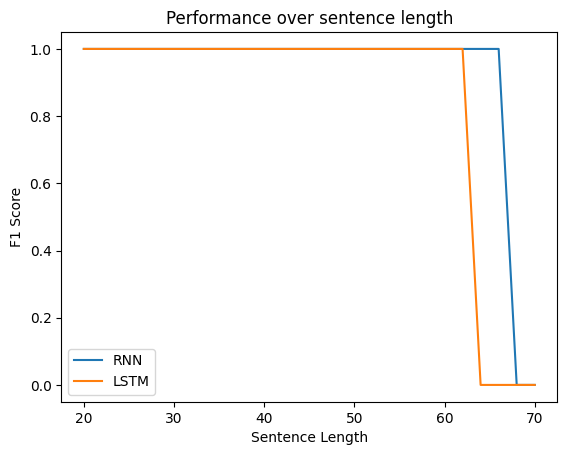

In [52]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the results
ax.plot(list(rnn_1_f1_scores.keys()), list(rnn_1_f1_scores.values()), label='RNN')
ax.plot(list(lstm_1_f1_scores.keys()), list(lstm_1_f1_scores.values()), label='LSTM')

# Add labels and title
ax.set_xlabel('Sentence Length')
ax.set_ylabel('F1 Score')
ax.set_title('Performance over sentence length')
ax.legend()  # Add a legend

# Show the plot
plt.show()

In [53]:
# Data loader
abc_train_loader = DataLoader(dataset=abc_train_dataset, batch_size=256, shuffle=True)
abc_valid_loader = DataLoader(dataset=abc_valid_dataset, batch_size=256, shuffle=True)

# Initialize models
abc_rnn_model = SimpleRNN(vocab_size = 4, input_size=10, hidden_size=128, num_layers=3, num_classes=2).to(device)
abc_rnn_model_optimizer = torch.optim.Adam(abc_rnn_model.parameters(), lr=0.0001488)

abc_lstm_model = SimpleLSTM(vocab_size = 4, input_size=5, hidden_size=32, num_layers=2, num_classes=2).to(device)
abc_lstm_model_optimizer = torch.optim.Adam(abc_lstm_model.parameters(), lr=0.00009976)

# Train models
training_loop(abc_rnn_model, abc_train_loader, abc_valid_loader, abc_rnn_model_optimizer, 50, device)
training_loop(abc_lstm_model, abc_train_loader, abc_valid_loader, abc_lstm_model_optimizer, 50, device)

100%|██████████| 79/79 [00:01<00:00, 68.09it/s]


====> Epoch: 0 Training loss: 0.0068921626
====> Epoch: 0 Validation loss: 0.0053176324


100%|██████████| 79/79 [00:00<00:00, 88.74it/s]


====> Epoch: 1 Training loss: 0.0042293879
====> Epoch: 1 Validation loss: 0.0048261014


100%|██████████| 79/79 [00:00<00:00, 80.59it/s]


====> Epoch: 2 Training loss: 0.0036085279
====> Epoch: 2 Validation loss: 0.0052133131


100%|██████████| 79/79 [00:01<00:00, 77.56it/s]


====> Epoch: 3 Training loss: 0.0032490166
====> Epoch: 3 Validation loss: 0.0051118571


100%|██████████| 79/79 [00:01<00:00, 76.34it/s]


====> Epoch: 4 Training loss: 0.0028552617
====> Epoch: 4 Validation loss: 0.0050084861


100%|██████████| 79/79 [00:01<00:00, 75.64it/s]


====> Epoch: 5 Training loss: 0.0024917019
====> Epoch: 5 Validation loss: 0.0052077886


100%|██████████| 79/79 [00:01<00:00, 75.94it/s]


====> Epoch: 6 Training loss: 0.0022772530
====> Epoch: 6 Validation loss: 0.0055432618


100%|██████████| 79/79 [00:01<00:00, 75.59it/s]


====> Epoch: 7 Training loss: 0.0021808460
====> Epoch: 7 Validation loss: 0.0057935215


100%|██████████| 79/79 [00:01<00:00, 76.26it/s]


====> Epoch: 8 Training loss: 0.0019450561
====> Epoch: 8 Validation loss: 0.0066486282


100%|██████████| 79/79 [00:01<00:00, 75.22it/s]


====> Epoch: 9 Training loss: 0.0017446828
====> Epoch: 9 Validation loss: 0.0080603381


100%|██████████| 79/79 [00:01<00:00, 76.20it/s]


====> Epoch: 10 Training loss: 0.0015778354
====> Epoch: 10 Validation loss: 0.0105343965


100%|██████████| 79/79 [00:01<00:00, 75.34it/s]


====> Epoch: 11 Training loss: 0.0019116346
====> Epoch: 11 Validation loss: 0.0121935805


100%|██████████| 79/79 [00:01<00:00, 74.63it/s]


====> Epoch: 12 Training loss: 0.0015068971
====> Epoch: 12 Validation loss: 0.0169606805


100%|██████████| 79/79 [00:01<00:00, 75.73it/s]


====> Epoch: 13 Training loss: 0.0013456503
====> Epoch: 13 Validation loss: 0.0200135942


100%|██████████| 79/79 [00:01<00:00, 74.62it/s]


====> Epoch: 14 Training loss: 0.0016603935
====> Epoch: 14 Validation loss: 0.0266873043


100%|██████████| 79/79 [00:01<00:00, 74.94it/s]


====> Epoch: 15 Training loss: 0.0012397906
====> Epoch: 15 Validation loss: 0.0253323746


100%|██████████| 79/79 [00:00<00:00, 79.41it/s]


====> Epoch: 16 Training loss: 0.0012027642
====> Epoch: 16 Validation loss: 0.0271919932


100%|██████████| 79/79 [00:01<00:00, 77.22it/s]


====> Epoch: 17 Training loss: 0.0010739396
====> Epoch: 17 Validation loss: 0.0302134340


100%|██████████| 79/79 [00:01<00:00, 75.61it/s]


====> Epoch: 18 Training loss: 0.0013382654
====> Epoch: 18 Validation loss: 0.0382929840


100%|██████████| 79/79 [00:01<00:00, 77.16it/s]


====> Epoch: 19 Training loss: 0.0011693649
====> Epoch: 19 Validation loss: 0.0375555050


100%|██████████| 79/79 [00:01<00:00, 78.19it/s]


====> Epoch: 20 Training loss: 0.0013214455
====> Epoch: 20 Validation loss: 0.0377659831


100%|██████████| 79/79 [00:01<00:00, 75.05it/s]


====> Epoch: 21 Training loss: 0.0010387114
====> Epoch: 21 Validation loss: 0.0408991332


100%|██████████| 79/79 [00:01<00:00, 77.56it/s]


====> Epoch: 22 Training loss: 0.0010084067
====> Epoch: 22 Validation loss: 0.0389235411


100%|██████████| 79/79 [00:01<00:00, 74.61it/s]


====> Epoch: 23 Training loss: 0.0009955729
====> Epoch: 23 Validation loss: 0.0400806446


100%|██████████| 79/79 [00:01<00:00, 76.10it/s]


====> Epoch: 24 Training loss: 0.0009359937
====> Epoch: 24 Validation loss: 0.0471376271


100%|██████████| 79/79 [00:01<00:00, 75.60it/s]


====> Epoch: 25 Training loss: 0.0009226630
====> Epoch: 25 Validation loss: 0.0483041525


100%|██████████| 79/79 [00:01<00:00, 76.69it/s]


====> Epoch: 26 Training loss: 0.0008888405
====> Epoch: 26 Validation loss: 0.0458679070


100%|██████████| 79/79 [00:01<00:00, 75.68it/s]


====> Epoch: 27 Training loss: 0.0008600484
====> Epoch: 27 Validation loss: 0.0477498097


100%|██████████| 79/79 [00:01<00:00, 73.77it/s]


====> Epoch: 28 Training loss: 0.0008529207
====> Epoch: 28 Validation loss: 0.0471360521


100%|██████████| 79/79 [00:01<00:00, 74.62it/s]


====> Epoch: 29 Training loss: 0.0014253242
====> Epoch: 29 Validation loss: 0.0422418323


100%|██████████| 79/79 [00:01<00:00, 73.21it/s]


====> Epoch: 30 Training loss: 0.0014910484
====> Epoch: 30 Validation loss: 0.0454087305


100%|██████████| 79/79 [00:01<00:00, 77.67it/s]


====> Epoch: 31 Training loss: 0.0009441237
====> Epoch: 31 Validation loss: 0.0488975902


100%|██████████| 79/79 [00:01<00:00, 77.05it/s]


====> Epoch: 32 Training loss: 0.0008804588
====> Epoch: 32 Validation loss: 0.0495373473


100%|██████████| 79/79 [00:01<00:00, 74.80it/s]


====> Epoch: 33 Training loss: 0.0008065480
====> Epoch: 33 Validation loss: 0.0500096850


100%|██████████| 79/79 [00:01<00:00, 75.74it/s]


====> Epoch: 34 Training loss: 0.0008040132
====> Epoch: 34 Validation loss: 0.0478208923


100%|██████████| 79/79 [00:01<00:00, 75.50it/s]


====> Epoch: 35 Training loss: 0.0008370177
====> Epoch: 35 Validation loss: 0.0543448067


100%|██████████| 79/79 [00:01<00:00, 72.81it/s]


====> Epoch: 36 Training loss: 0.0007630868
====> Epoch: 36 Validation loss: 0.0544742298


100%|██████████| 79/79 [00:01<00:00, 77.68it/s]


====> Epoch: 37 Training loss: 0.0008638335
====> Epoch: 37 Validation loss: 0.0581496353


100%|██████████| 79/79 [00:01<00:00, 76.26it/s]


====> Epoch: 38 Training loss: 0.0007695545
====> Epoch: 38 Validation loss: 0.0619932337


100%|██████████| 79/79 [00:01<00:00, 74.49it/s]


====> Epoch: 39 Training loss: 0.0047536630
====> Epoch: 39 Validation loss: 0.0049015991


100%|██████████| 79/79 [00:01<00:00, 74.23it/s]


====> Epoch: 40 Training loss: 0.0043138772
====> Epoch: 40 Validation loss: 0.0051856616


100%|██████████| 79/79 [00:01<00:00, 75.54it/s]


====> Epoch: 41 Training loss: 0.0036446822
====> Epoch: 41 Validation loss: 0.0113351784


100%|██████████| 79/79 [00:01<00:00, 75.84it/s]


====> Epoch: 42 Training loss: 0.0021029456
====> Epoch: 42 Validation loss: 0.0271659136


100%|██████████| 79/79 [00:00<00:00, 79.24it/s]


====> Epoch: 43 Training loss: 0.0013290203
====> Epoch: 43 Validation loss: 0.0284438515


100%|██████████| 79/79 [00:01<00:00, 76.96it/s]


====> Epoch: 44 Training loss: 0.0010483327
====> Epoch: 44 Validation loss: 0.0306446471


100%|██████████| 79/79 [00:00<00:00, 80.22it/s]


====> Epoch: 45 Training loss: 0.0009410750
====> Epoch: 45 Validation loss: 0.0321685359


100%|██████████| 79/79 [00:00<00:00, 80.63it/s]


====> Epoch: 46 Training loss: 0.0009333711
====> Epoch: 46 Validation loss: 0.0352468996


100%|██████████| 79/79 [00:01<00:00, 74.91it/s]


====> Epoch: 47 Training loss: 0.0008572677
====> Epoch: 47 Validation loss: 0.0379888930


100%|██████████| 79/79 [00:00<00:00, 80.99it/s]


====> Epoch: 48 Training loss: 0.0008197999
====> Epoch: 48 Validation loss: 0.0394082594


100%|██████████| 79/79 [00:01<00:00, 78.12it/s]


====> Epoch: 49 Training loss: 0.0008143008
====> Epoch: 49 Validation loss: 0.0385505626


100%|██████████| 79/79 [00:00<00:00, 91.81it/s]


====> Epoch: 0 Training loss: 0.0153499707
====> Epoch: 0 Validation loss: 0.0149573785


100%|██████████| 79/79 [00:00<00:00, 80.91it/s]


====> Epoch: 1 Training loss: 0.0135683195
====> Epoch: 1 Validation loss: 0.0117097783


100%|██████████| 79/79 [00:00<00:00, 81.79it/s]


====> Epoch: 2 Training loss: 0.0078364461
====> Epoch: 2 Validation loss: 0.0056560608


100%|██████████| 79/79 [00:00<00:00, 81.18it/s]


====> Epoch: 3 Training loss: 0.0054451875
====> Epoch: 3 Validation loss: 0.0053877177


100%|██████████| 79/79 [00:00<00:00, 83.91it/s]


====> Epoch: 4 Training loss: 0.0053076133
====> Epoch: 4 Validation loss: 0.0053591931


100%|██████████| 79/79 [00:01<00:00, 78.12it/s]


====> Epoch: 5 Training loss: 0.0052792211
====> Epoch: 5 Validation loss: 0.0053503177


100%|██████████| 79/79 [00:01<00:00, 76.94it/s]


====> Epoch: 6 Training loss: 0.0052722346
====> Epoch: 6 Validation loss: 0.0053507107


100%|██████████| 79/79 [00:00<00:00, 90.17it/s]


====> Epoch: 7 Training loss: 0.0052355756
====> Epoch: 7 Validation loss: 0.0053209918


100%|██████████| 79/79 [00:00<00:00, 94.16it/s]


====> Epoch: 8 Training loss: 0.0051495791
====> Epoch: 8 Validation loss: 0.0052835317


100%|██████████| 79/79 [00:00<00:00, 82.81it/s]


====> Epoch: 9 Training loss: 0.0049961204
====> Epoch: 9 Validation loss: 0.0052699190


100%|██████████| 79/79 [00:01<00:00, 77.99it/s]


====> Epoch: 10 Training loss: 0.0047563630
====> Epoch: 10 Validation loss: 0.0052340971


100%|██████████| 79/79 [00:00<00:00, 81.61it/s]


====> Epoch: 11 Training loss: 0.0044861055
====> Epoch: 11 Validation loss: 0.0051919592


100%|██████████| 79/79 [00:00<00:00, 98.63it/s] 


====> Epoch: 12 Training loss: 0.0041922735
====> Epoch: 12 Validation loss: 0.0050242857


100%|██████████| 79/79 [00:00<00:00, 89.28it/s]


====> Epoch: 13 Training loss: 0.0040079627
====> Epoch: 13 Validation loss: 0.0049844030


100%|██████████| 79/79 [00:01<00:00, 78.32it/s]


====> Epoch: 14 Training loss: 0.0038876604
====> Epoch: 14 Validation loss: 0.0049682590


100%|██████████| 79/79 [00:00<00:00, 80.01it/s]


====> Epoch: 15 Training loss: 0.0037663725
====> Epoch: 15 Validation loss: 0.0048910618


100%|██████████| 79/79 [00:01<00:00, 78.75it/s]


====> Epoch: 16 Training loss: 0.0036286121
====> Epoch: 16 Validation loss: 0.0048795457


100%|██████████| 79/79 [00:00<00:00, 95.40it/s]


====> Epoch: 17 Training loss: 0.0034769218
====> Epoch: 17 Validation loss: 0.0048486904


100%|██████████| 79/79 [00:00<00:00, 94.45it/s]


====> Epoch: 18 Training loss: 0.0032928810
====> Epoch: 18 Validation loss: 0.0047619206


100%|██████████| 79/79 [00:01<00:00, 77.21it/s]


====> Epoch: 19 Training loss: 0.0030892952
====> Epoch: 19 Validation loss: 0.0045073137


100%|██████████| 79/79 [00:00<00:00, 80.85it/s]


====> Epoch: 20 Training loss: 0.0028939366
====> Epoch: 20 Validation loss: 0.0043979816


100%|██████████| 79/79 [00:00<00:00, 89.59it/s]


====> Epoch: 21 Training loss: 0.0027821175
====> Epoch: 21 Validation loss: 0.0043006839


100%|██████████| 79/79 [00:00<00:00, 96.93it/s]


====> Epoch: 22 Training loss: 0.0026469287
====> Epoch: 22 Validation loss: 0.0043823707


100%|██████████| 79/79 [00:00<00:00, 89.92it/s]


====> Epoch: 23 Training loss: 0.0025420692
====> Epoch: 23 Validation loss: 0.0044032366


100%|██████████| 79/79 [00:01<00:00, 78.91it/s]


====> Epoch: 24 Training loss: 0.0024581035
====> Epoch: 24 Validation loss: 0.0044106661


100%|██████████| 79/79 [00:00<00:00, 85.85it/s]


====> Epoch: 25 Training loss: 0.0023630217
====> Epoch: 25 Validation loss: 0.0042823839


100%|██████████| 79/79 [00:00<00:00, 96.22it/s]


====> Epoch: 26 Training loss: 0.0022936056
====> Epoch: 26 Validation loss: 0.0224211414


100%|██████████| 79/79 [00:00<00:00, 87.64it/s]


====> Epoch: 27 Training loss: 0.0021569223
====> Epoch: 27 Validation loss: 0.0416168242


100%|██████████| 79/79 [00:01<00:00, 77.72it/s]


====> Epoch: 28 Training loss: 0.0020856312
====> Epoch: 28 Validation loss: 0.0527829437


100%|██████████| 79/79 [00:00<00:00, 79.43it/s]


====> Epoch: 29 Training loss: 0.0018652521
====> Epoch: 29 Validation loss: 0.0550026979


100%|██████████| 79/79 [00:00<00:00, 98.58it/s] 


====> Epoch: 30 Training loss: 0.0017477890
====> Epoch: 30 Validation loss: 0.0574493823


100%|██████████| 79/79 [00:00<00:00, 96.61it/s]


====> Epoch: 31 Training loss: 0.0016508930
====> Epoch: 31 Validation loss: 0.0595658140


100%|██████████| 79/79 [00:00<00:00, 86.97it/s]


====> Epoch: 32 Training loss: 0.0015846178
====> Epoch: 32 Validation loss: 0.0613871579


100%|██████████| 79/79 [00:00<00:00, 80.84it/s]


====> Epoch: 33 Training loss: 0.0015031677
====> Epoch: 33 Validation loss: 0.0634544811


100%|██████████| 79/79 [00:00<00:00, 81.82it/s]


====> Epoch: 34 Training loss: 0.0014618627
====> Epoch: 34 Validation loss: 0.0650681009


100%|██████████| 79/79 [00:00<00:00, 81.41it/s]


====> Epoch: 35 Training loss: 0.0014207376
====> Epoch: 35 Validation loss: 0.0667826324


100%|██████████| 79/79 [00:00<00:00, 83.90it/s]


====> Epoch: 36 Training loss: 0.0013537557
====> Epoch: 36 Validation loss: 0.0684867625


100%|██████████| 79/79 [00:00<00:00, 83.23it/s]


====> Epoch: 37 Training loss: 0.0013228909
====> Epoch: 37 Validation loss: 0.0699646640


100%|██████████| 79/79 [00:00<00:00, 84.04it/s]


====> Epoch: 38 Training loss: 0.0013169378
====> Epoch: 38 Validation loss: 0.0714102945


100%|██████████| 79/79 [00:00<00:00, 85.04it/s]


====> Epoch: 39 Training loss: 0.0012829943
====> Epoch: 39 Validation loss: 0.0735576458


100%|██████████| 79/79 [00:00<00:00, 83.24it/s]


====> Epoch: 40 Training loss: 0.0012517231
====> Epoch: 40 Validation loss: 0.0746721764


100%|██████████| 79/79 [00:00<00:00, 79.97it/s]


====> Epoch: 41 Training loss: 0.0012271144
====> Epoch: 41 Validation loss: 0.0760387821


100%|██████████| 79/79 [00:00<00:00, 98.54it/s] 


====> Epoch: 42 Training loss: 0.0011703509
====> Epoch: 42 Validation loss: 0.0770393438


100%|██████████| 79/79 [00:00<00:00, 97.17it/s] 


====> Epoch: 43 Training loss: 0.0011719478
====> Epoch: 43 Validation loss: 0.0784073563


100%|██████████| 79/79 [00:00<00:00, 79.93it/s]


====> Epoch: 44 Training loss: 0.0011442169
====> Epoch: 44 Validation loss: 0.0796544075


100%|██████████| 79/79 [00:01<00:00, 73.20it/s]


====> Epoch: 45 Training loss: 0.0010971672
====> Epoch: 45 Validation loss: 0.0808073902


100%|██████████| 79/79 [00:00<00:00, 79.21it/s]


====> Epoch: 46 Training loss: 0.0010949292
====> Epoch: 46 Validation loss: 0.0818007154


100%|██████████| 79/79 [00:00<00:00, 81.92it/s]


====> Epoch: 47 Training loss: 0.0011342482
====> Epoch: 47 Validation loss: 0.0833083057


100%|██████████| 79/79 [00:00<00:00, 98.63it/s] 


====> Epoch: 48 Training loss: 0.0010744504
====> Epoch: 48 Validation loss: 0.0842090225


100%|██████████| 79/79 [00:00<00:00, 96.35it/s]


====> Epoch: 49 Training loss: 0.0010529501
====> Epoch: 49 Validation loss: 0.0858619099


In [54]:
abc_test_loader = DataLoader(dataset=abc_test_dataset, batch_size=1, shuffle=True)

rnn_2_f1_scores = evaluate_model(abc_rnn_model, abc_test_loader, device)
lstm_2_f1_scores = evaluate_model(abc_lstm_model, abc_test_loader, device)

rnn_2_f1_scores = dict(sorted(rnn_2_f1_scores.items()))
lstm_2_f1_scores = dict(sorted(lstm_2_f1_scores.items()))

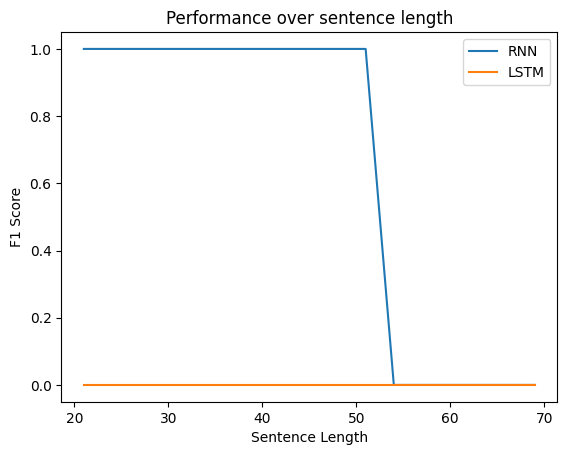

In [55]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the results
ax.plot(list(rnn_2_f1_scores.keys()), list(rnn_2_f1_scores.values()), label='RNN')
ax.plot(list(lstm_2_f1_scores.keys()), list(lstm_2_f1_scores.values()), label='LSTM')

# Add labels and title
ax.set_xlabel('Sentence Length')
ax.set_ylabel('F1 Score')
ax.set_title('Performance over sentence length')
ax.legend()  # Add a legend

# Show the plot
plt.show()